# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/14rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/15rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/16rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/14rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/15rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/16rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.323270        0.200792  0.050435  0.298915  0.017996   
       1.0    0.314750        0.176585  0.071932  0.189340  0.133361   
       2.0    0.307585        0.154357  0.092327  0.171743  0.159756   
       3.0    0.313313        0.119846  0.080972  0.158589  0.177545   
       4.0    0.341446        0.094506  0.061824  0.159940  0.212381   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.201447  0.009249  0.040422  0.048604  0.000000  
       1.0   0.210116  0.007212  0.038360  0.048818  0.003357  
       2.0   0.207801  0.004337  0.035138  0.047719  0.008700  
       3.0   0.239283  0.003208  0.029035  0.043263  0.013358  
       4.0   0.265384  0.003465  0.032810  0.041169  0.017466

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.295315        0.203393  0.049610  0.292473  0.020236   
       1.0    0.314523        0.179589  0.078641  0.187215  0.130772   
       2.0    0.325300        0.140887  0.088427  0.152139  0.167135   
       3.0    0.305541        0.112034  0.070429  0.152127  0.183884   
       4.0    0.357362        0.091606  0.065560  0.162714  0.193155   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.182364  0.009452  0.037824  0.049237  0.000000  
       1.0   0.209903  0.006875  0.039878  0.051088  0.003710  
       2.0   0.198220  0.003905  0.036067  0.051233  0.009263  
       3.0   0.235181  0.003261  0.031134  0.042614  0.015155  
       4.0   0.288752  0.003102  0.030190  0.040274  0.020164

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.301919        0.184715  0.048514  0.300995  0.018765   
       1.0    0.305686        0.180808  0.072830  0.174139  0.132269   
       2.0    0.323136        0.147500  0.089107  0.174317  0.170149   
       3.0    0.312377        0.106049  0.080771  0.175176  0.187713   
       4.0    0.335824        0.092359  0.057670  0.173212  0.201076   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.193786  0.009556  0.040998  0.048033  0.000000  
       1.0   0.222998  0.006837  0.034244  0.046736  0.004183  
       2.0   0.225724  0.004191  0.032718  0.048000  0.008554  
       3.0   0.247792  0.003299  0.030195  0.041751  0.013263  
       4.0   0.290455  0.003499  0.029595  0.042027  0.018482

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.306835        0.196300  0.049520  0.297461  0.018999   
         1.0    0.282697        0.176581  0.087728  0.184113  0.133885   
         2.0    0.254123        0.142941  0.082568  0.194118  0.180057   
         3.0    0.217567        0.105751  0.055444  0.191026  0.221720   
         4.0    0.214458        0.083180  0.035644  0.188577  0.256957   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.192532  0.009419  0.039748  0.048625  0.000000  
         1.0   0.214255  0.007101  0.037460  0.050141  0.002497  
         2.0   0.211037  0.004522  0.034353  0.052155  0.005991  
         3.0   0.246870  0.003805  0.029583  0.047162  0.009623  
         4.0   0.299917  0.004679  0.029792  0.047737  0.013185

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   6.082450e+01  3.899512e+01      36.613773  5.713511e+01   
         1.0   6.146475e+06  4.521988e+06  480888.711008  3.034596e+06   
         2.0   6.357254e+06  5.562650e+06  576741.449844  3.850479e+06   
         3.0   6.741533e+06  6.040231e+06  654641.466513  3.893106e+06   
         4.0   6.607378e+06  5.744616e+06  646943.575807  4.469854e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         1.0   9.853482e+05  5.409896e+06  3.937284e+06  8.544349e+05   
         2.0   1.228962e+06  7.389592e+06  4.074265e+06  9.779973e+05   
         3.0   1.205014e+06  8.136914e+06  4.043052e+06  1.092896e+06   
         4.0   1.340911e+06  8.143322e+06  4.197575e+06  1.104371e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          29.506563  
         1.0      404286.707202  
         2.0      493971.358043  
         3.0      536863.547327  
         4.0      580542.731221

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


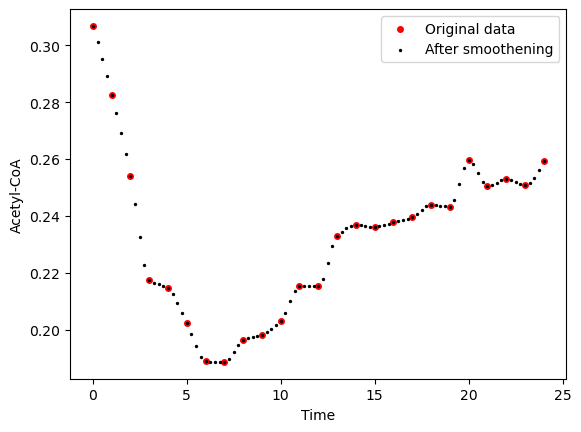

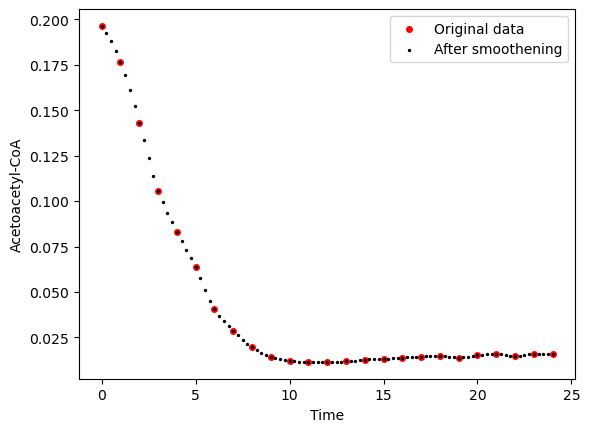

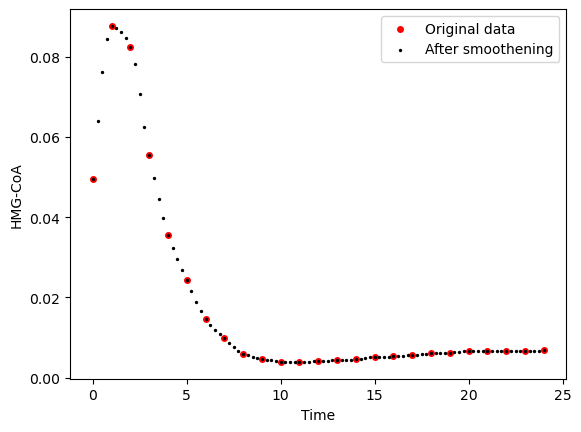

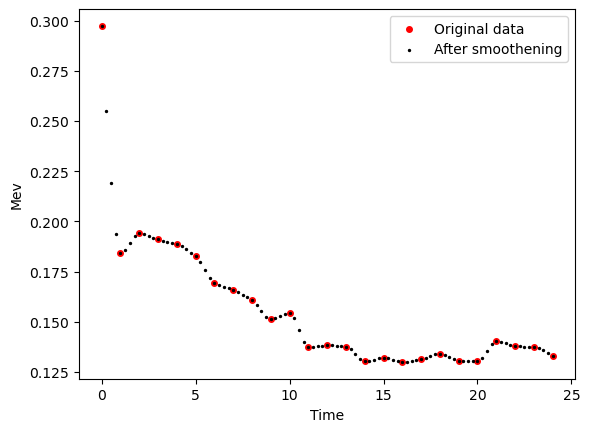

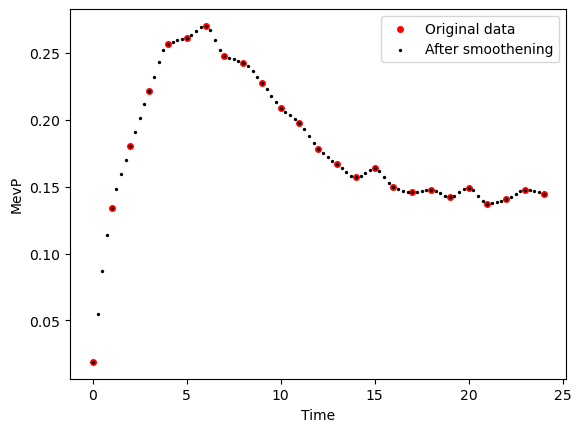

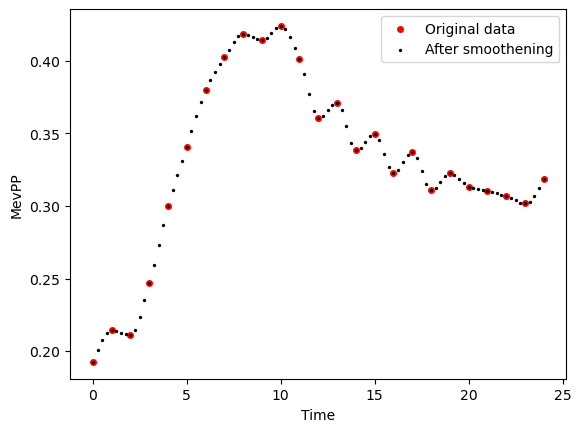

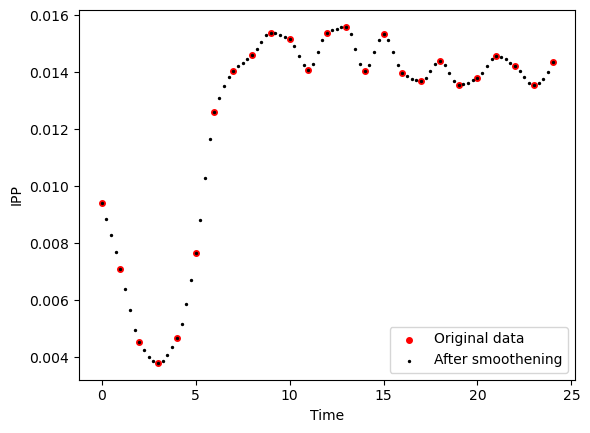

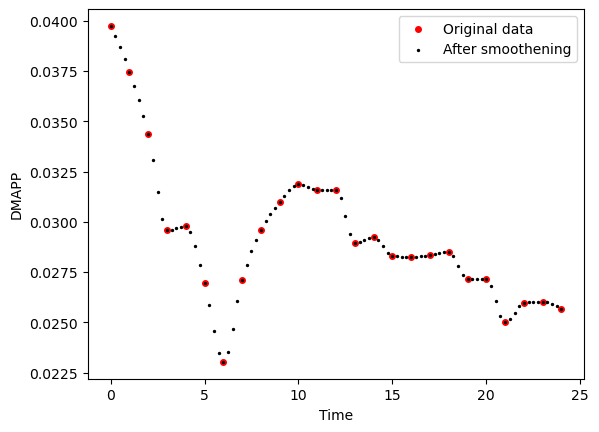

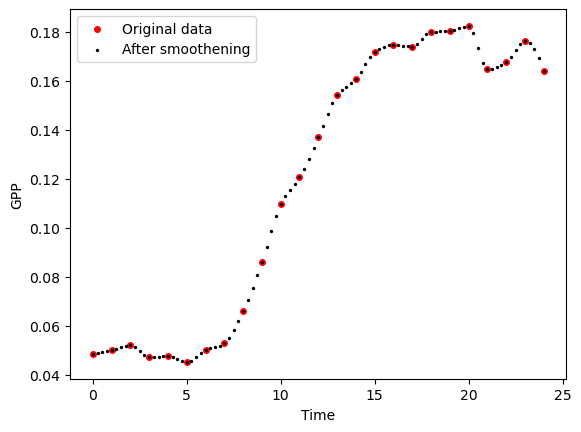

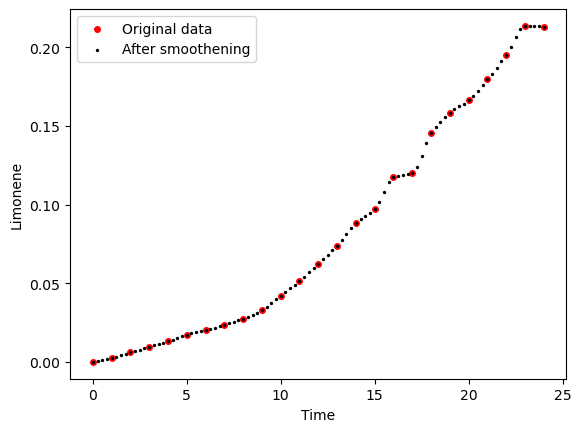

Strain Strain 2


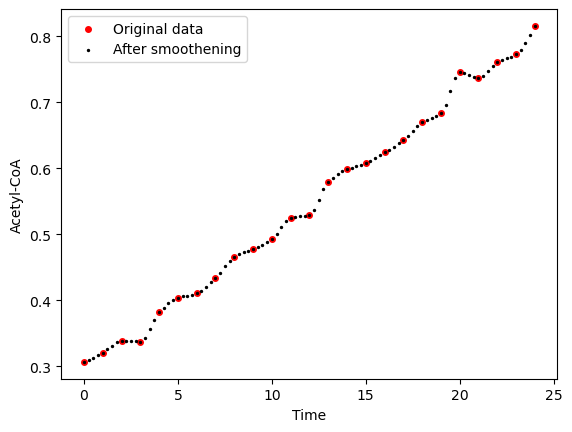

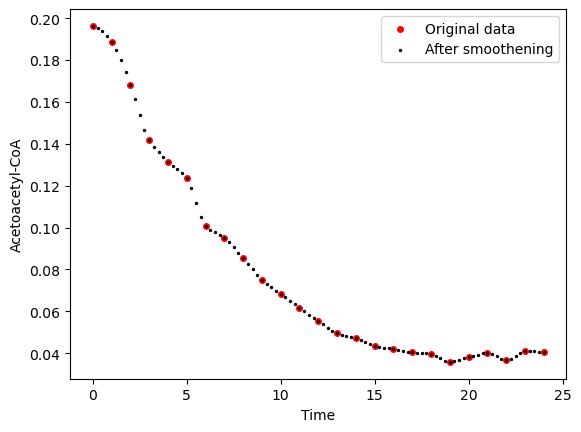

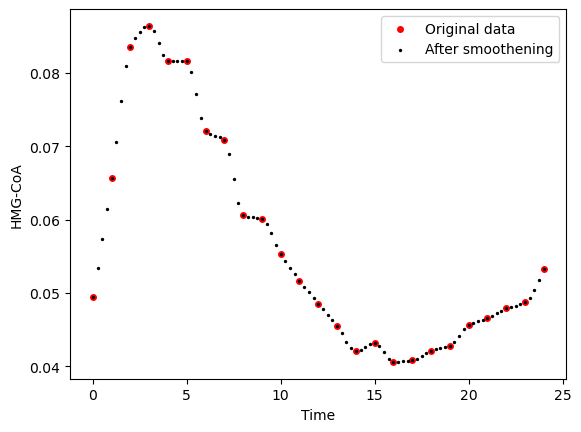

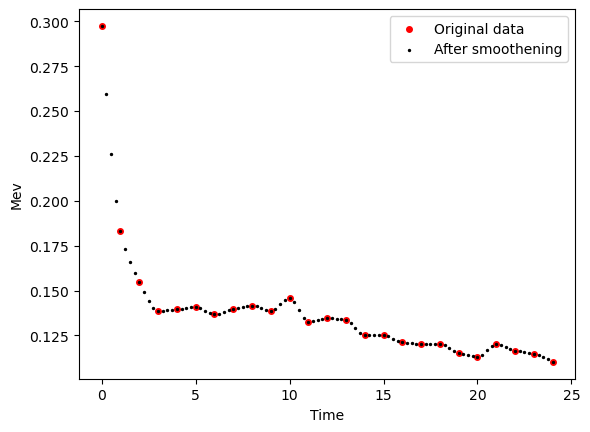

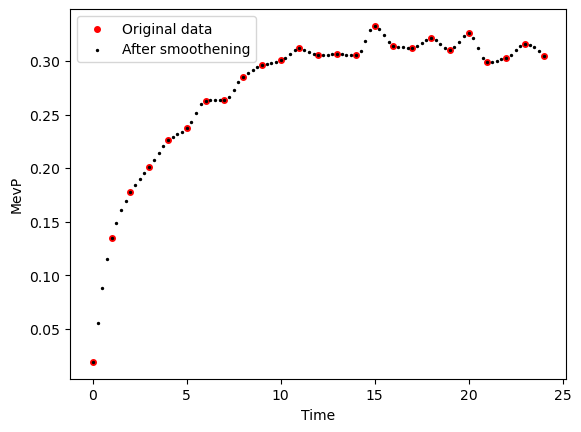

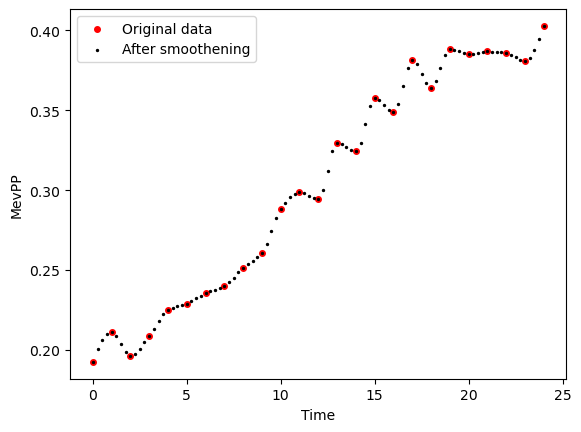

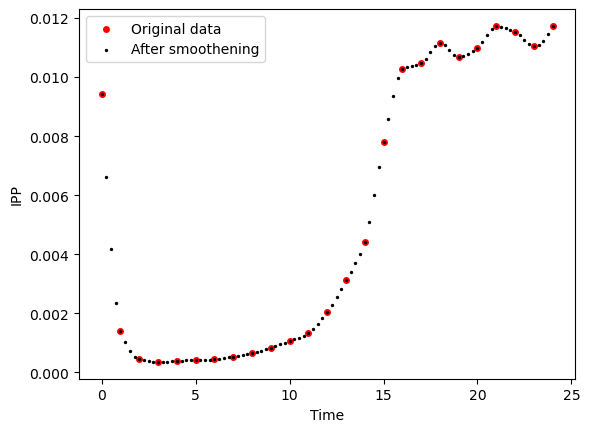

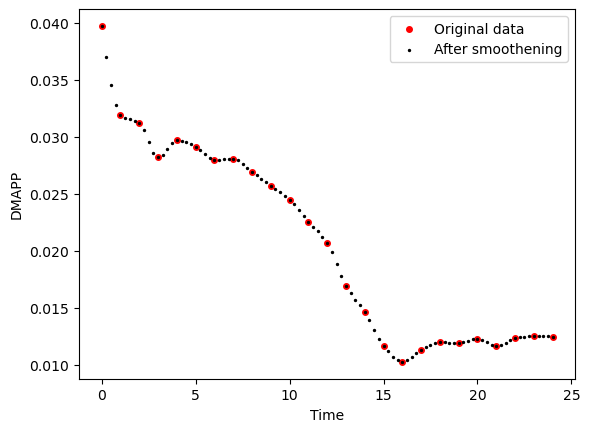

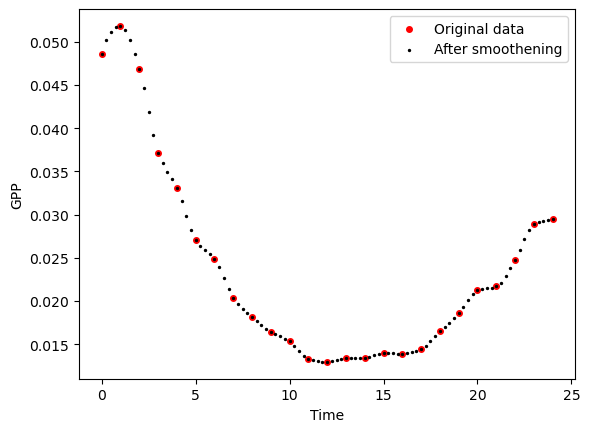

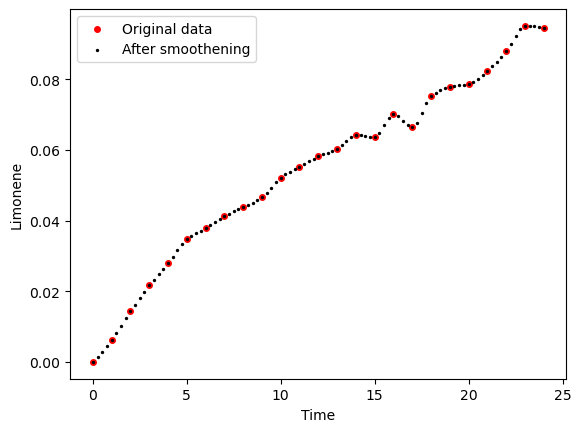

Strain Strain 3


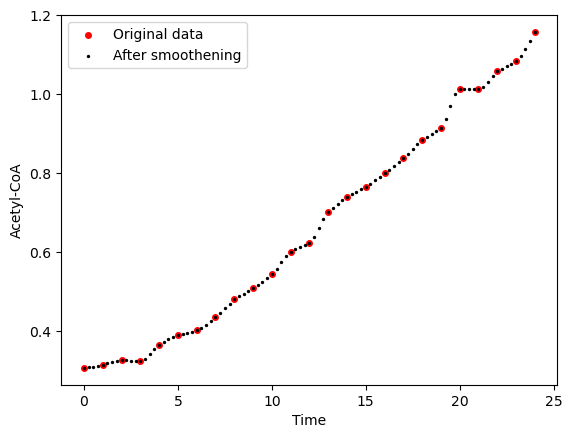

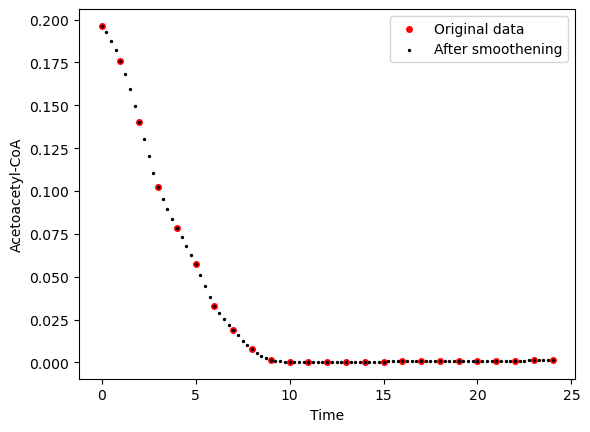

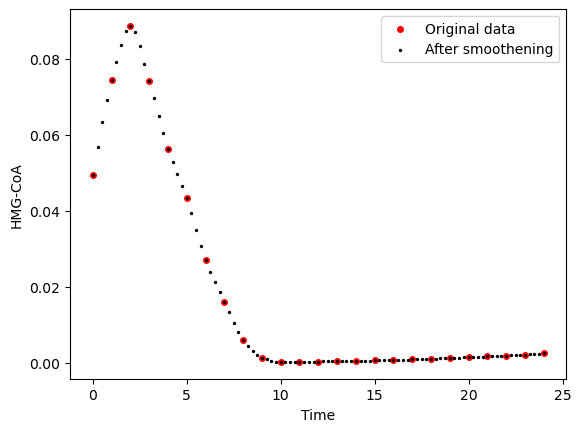

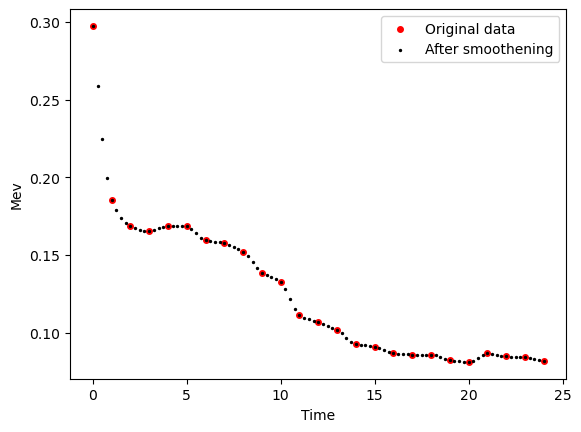

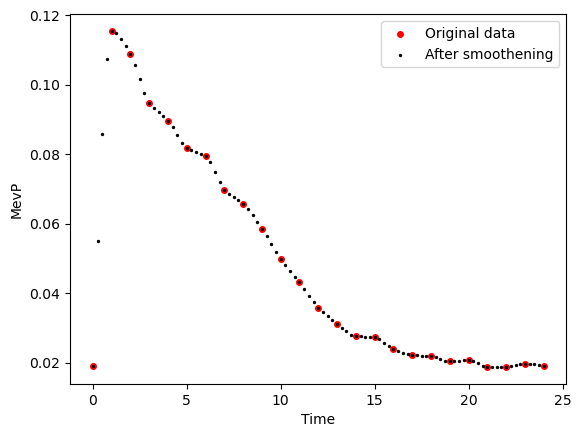

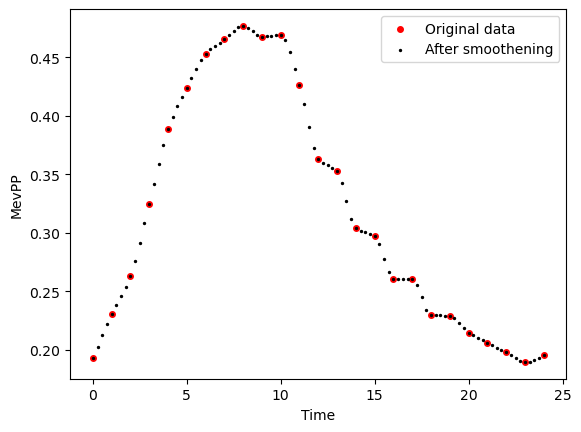

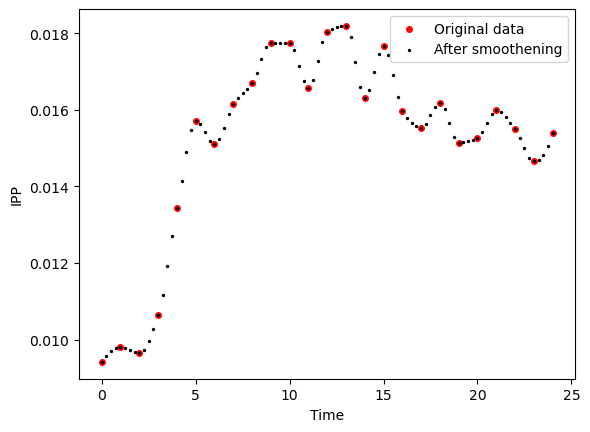

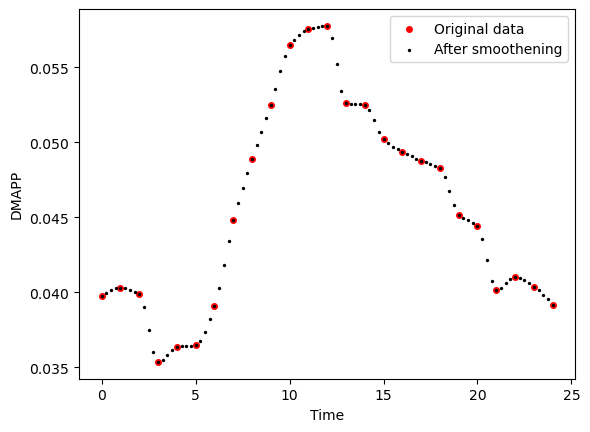

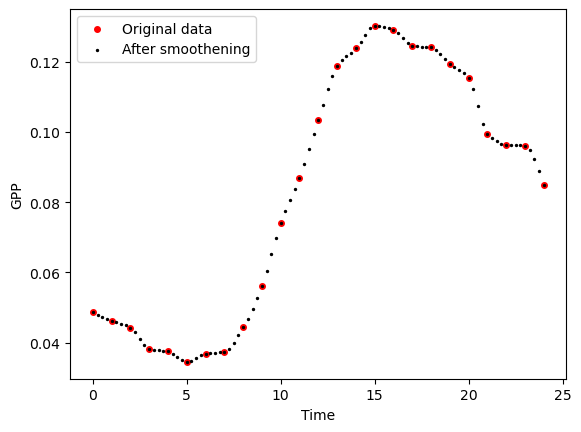

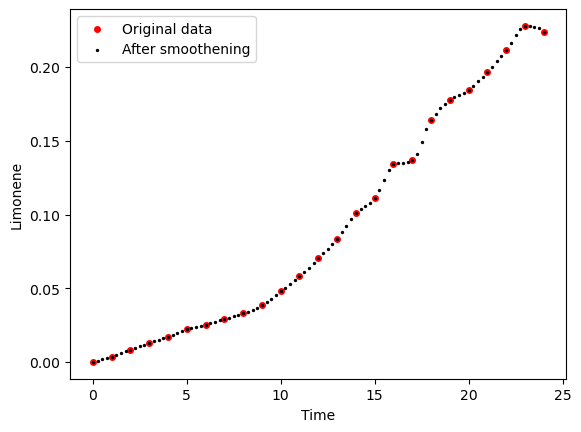

Strain WT


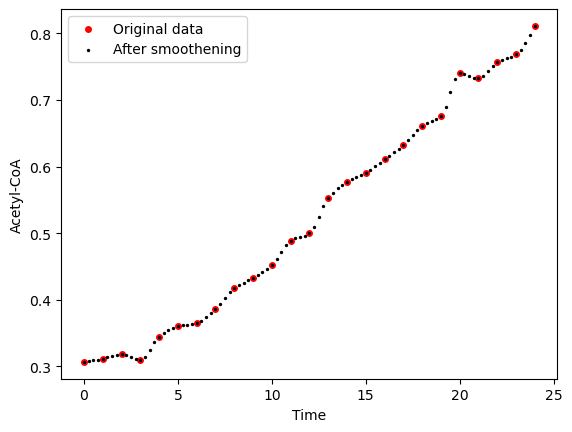

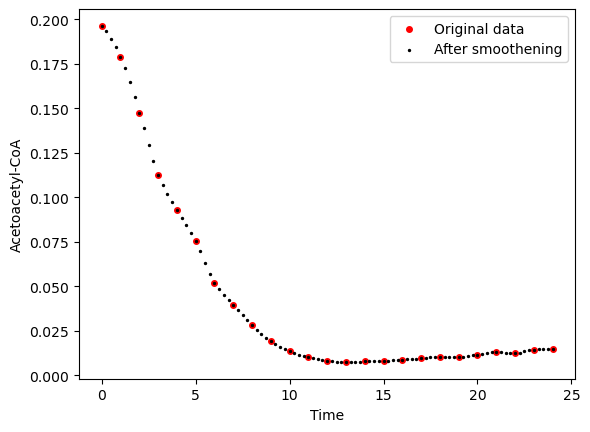

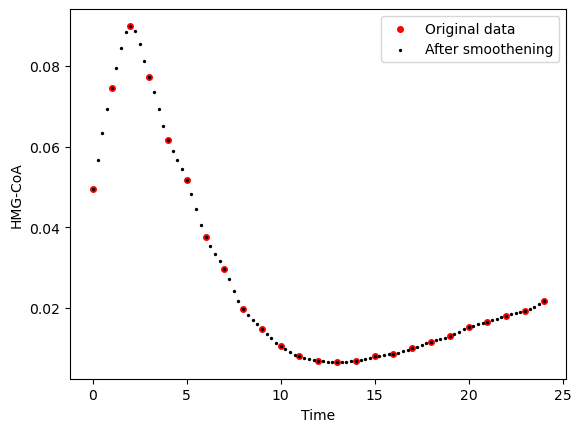

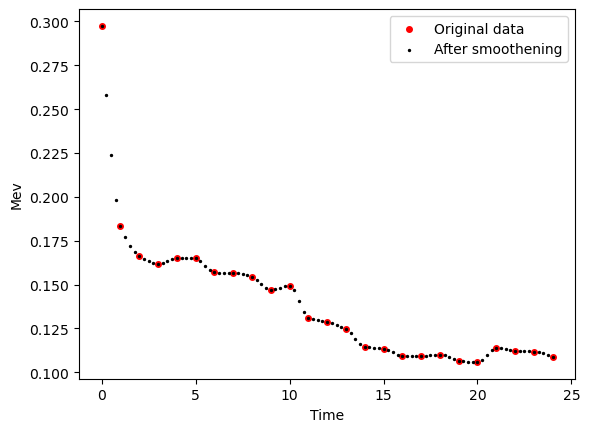

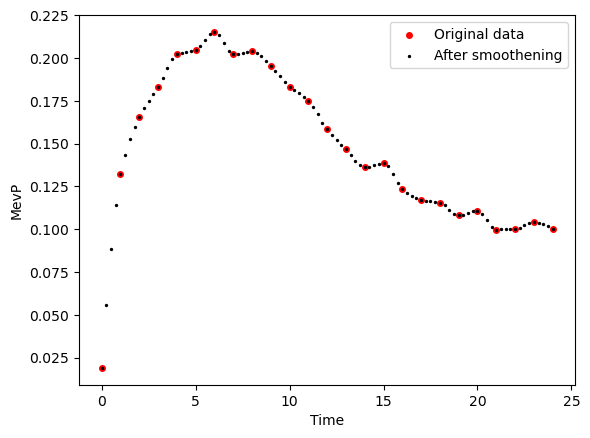

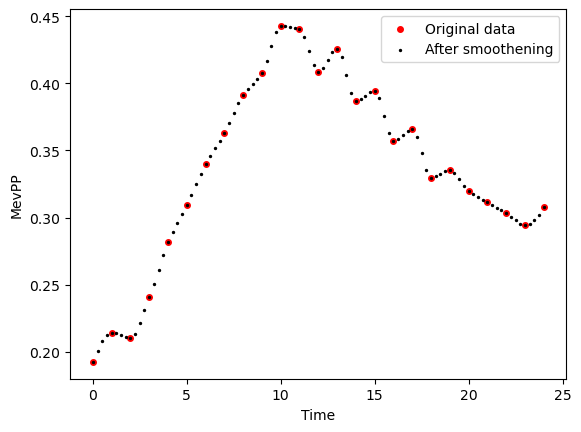

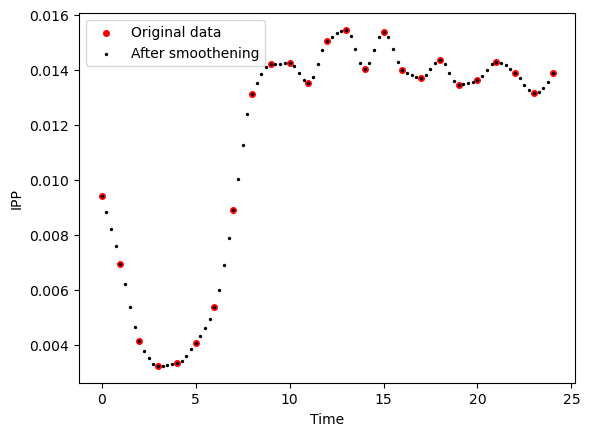

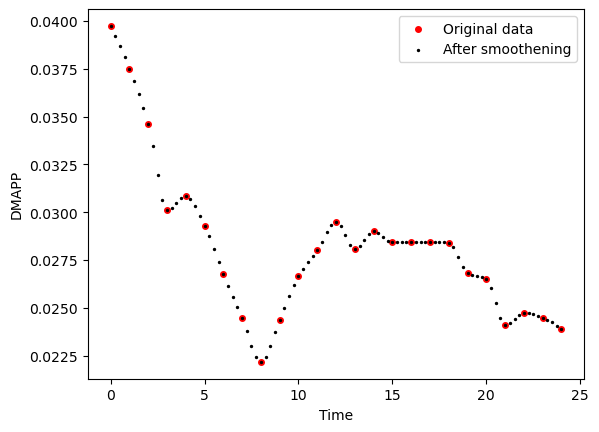

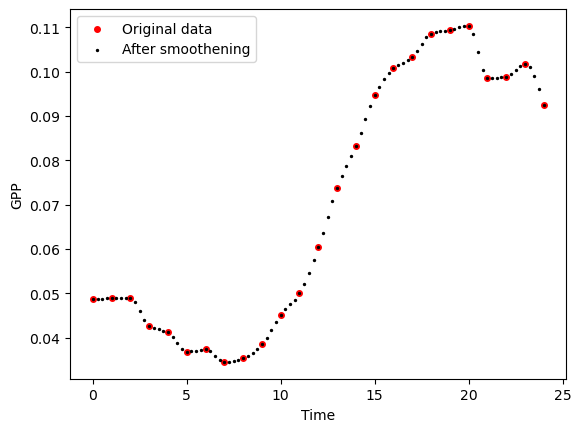

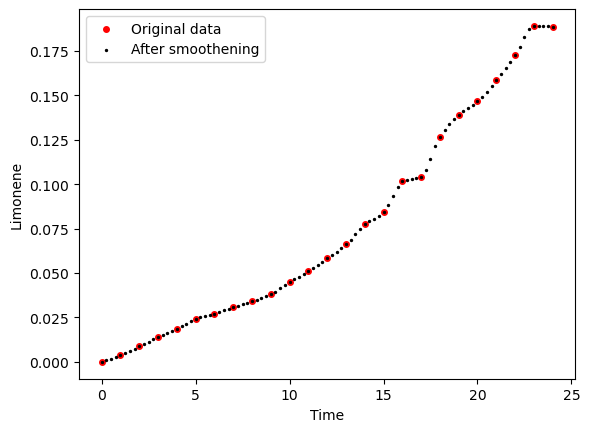

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


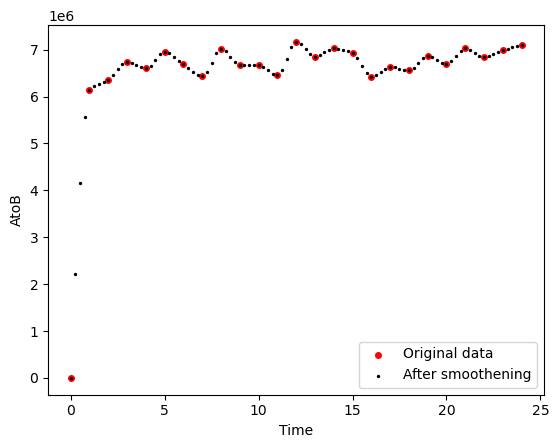

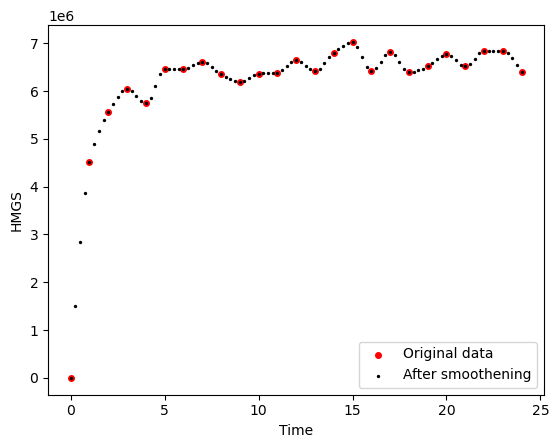

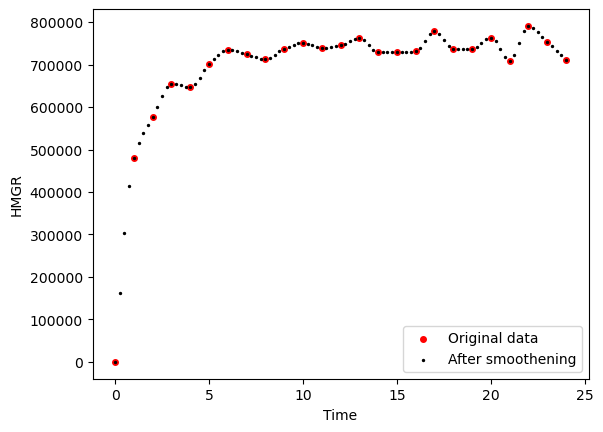

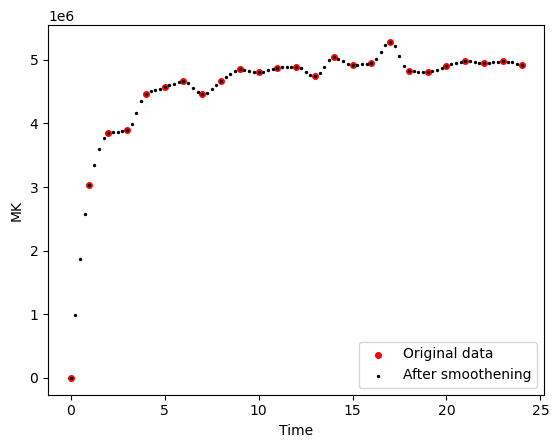

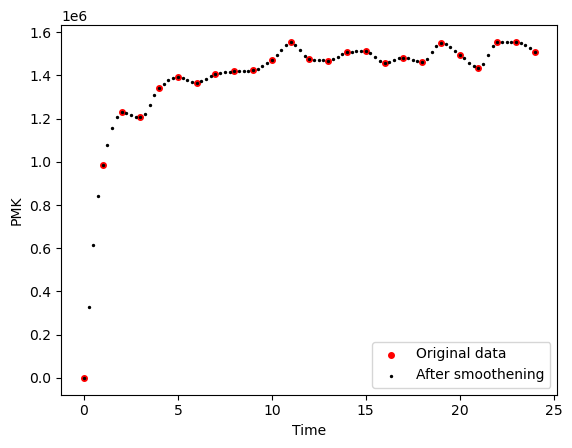

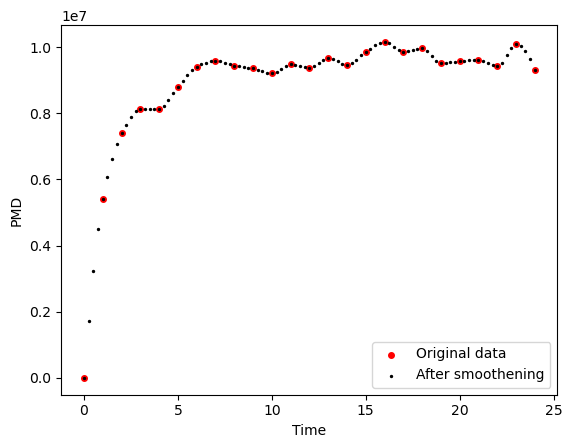

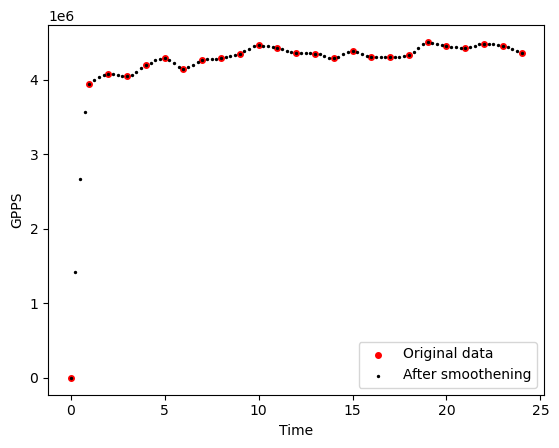

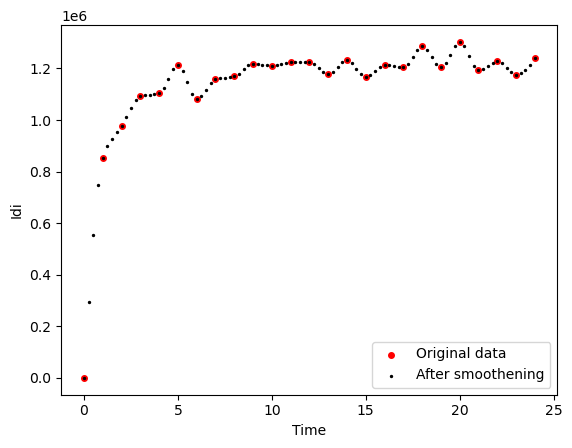

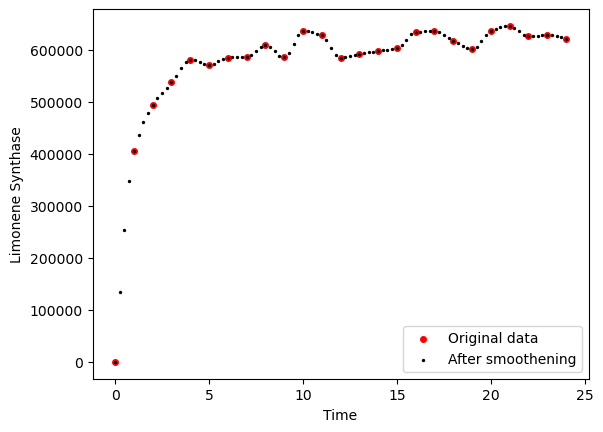

Strain Strain 2


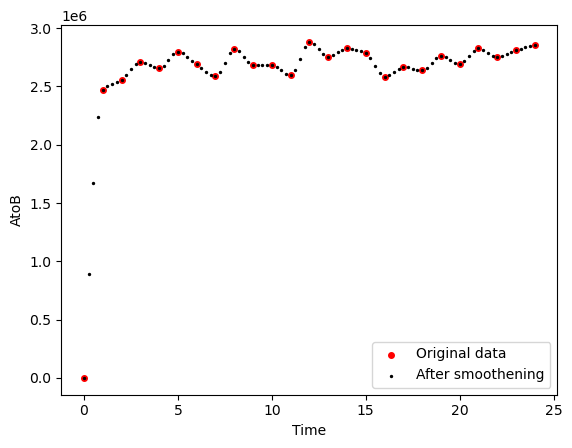

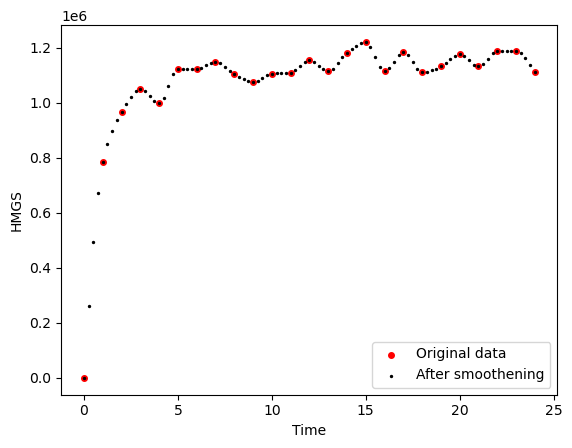

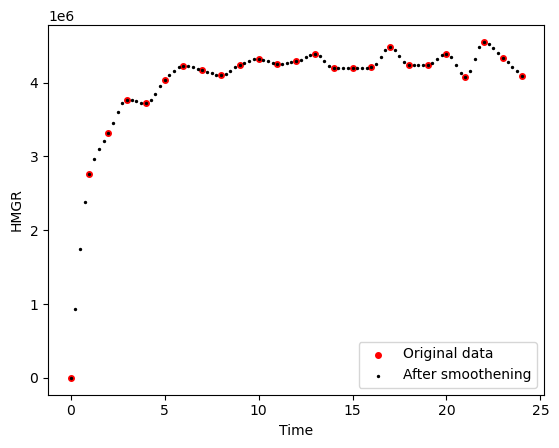

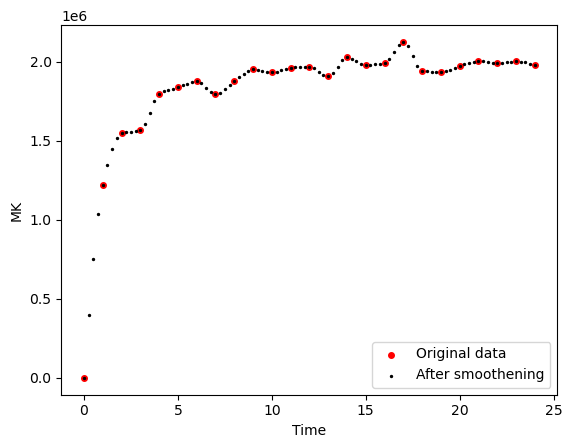

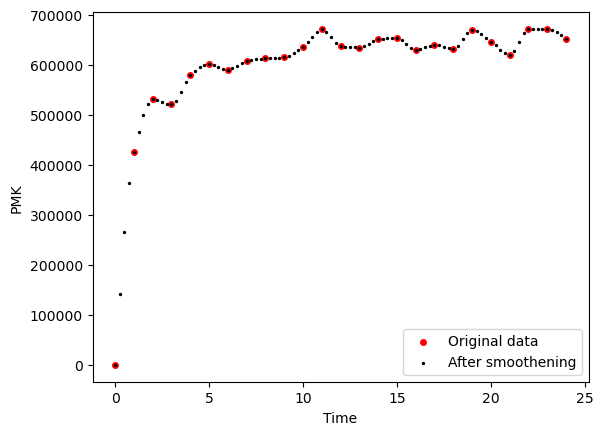

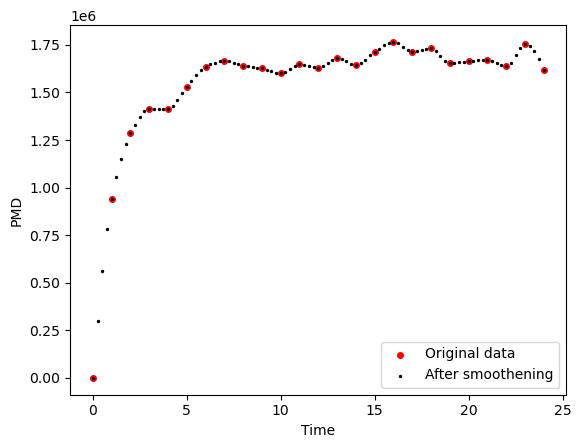

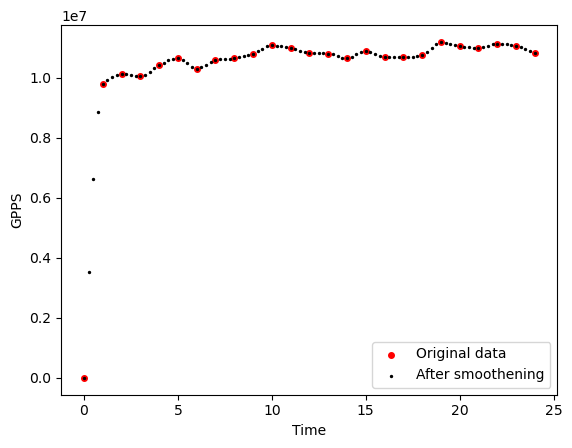

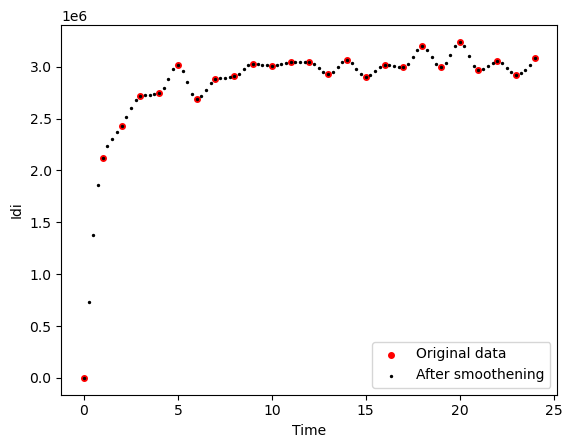

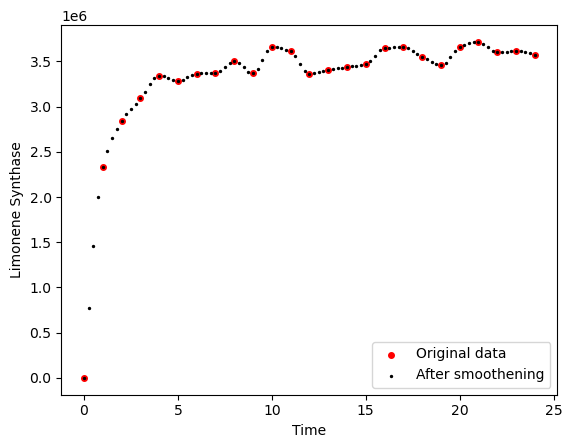

Strain Strain 3


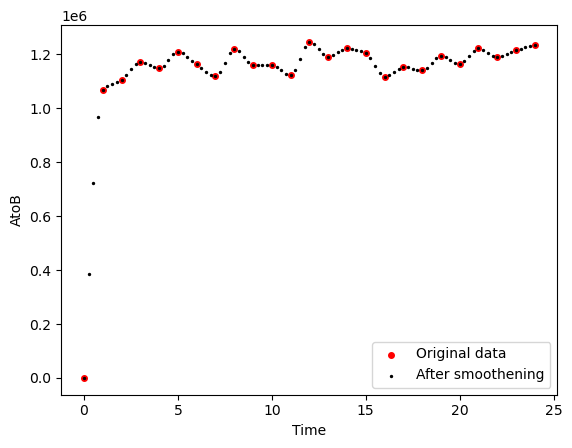

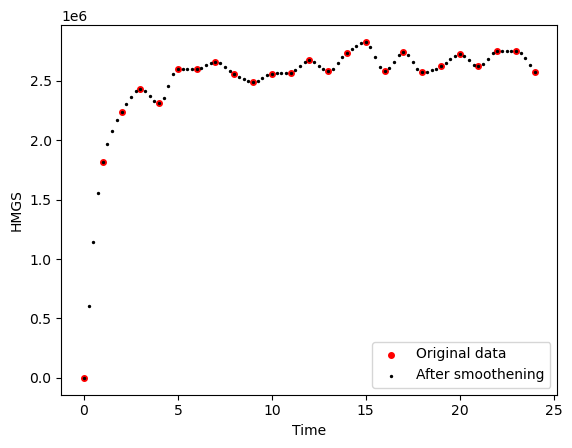

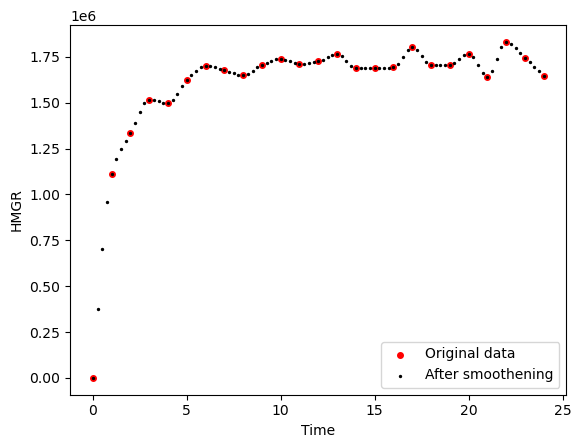

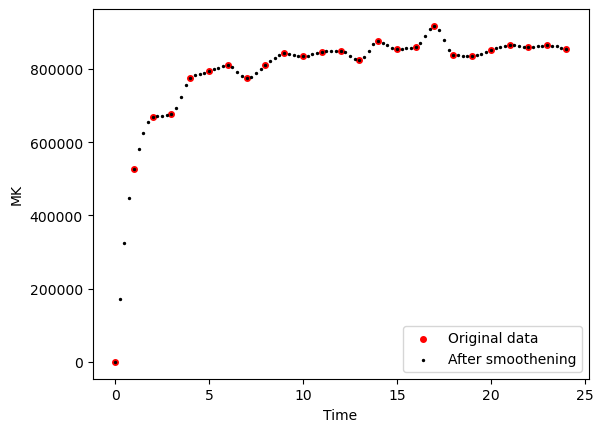

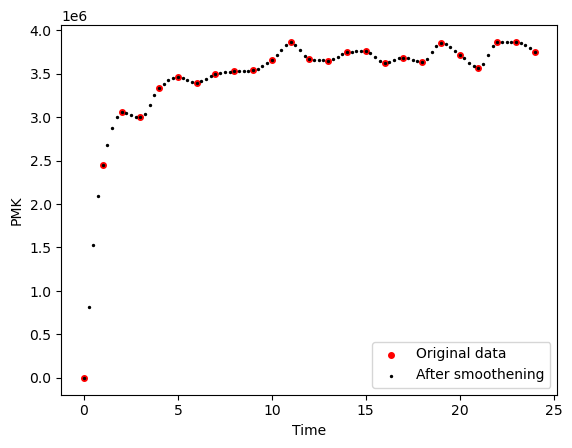

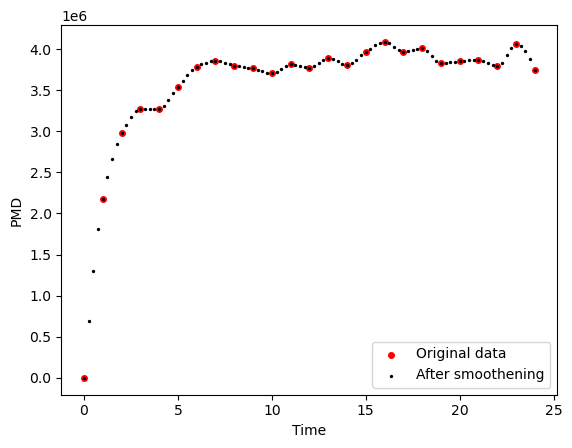

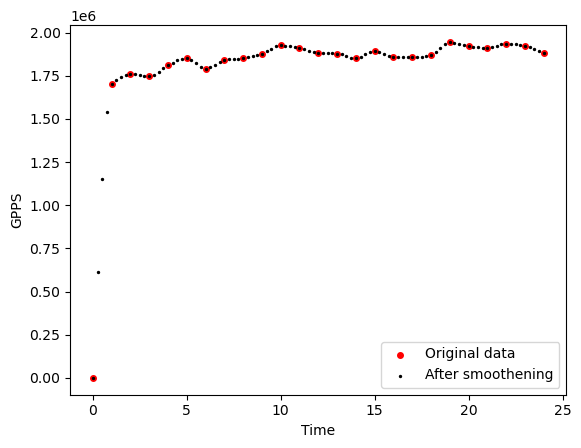

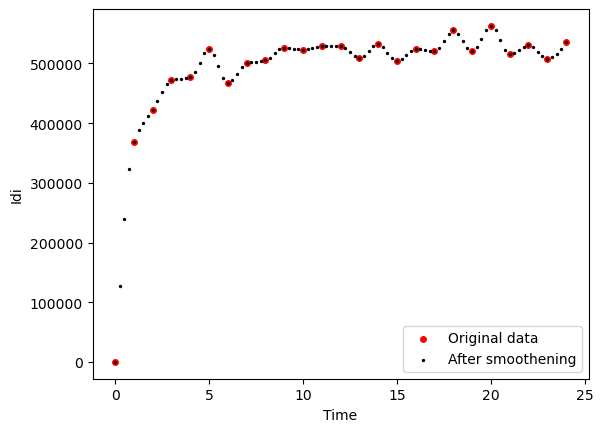

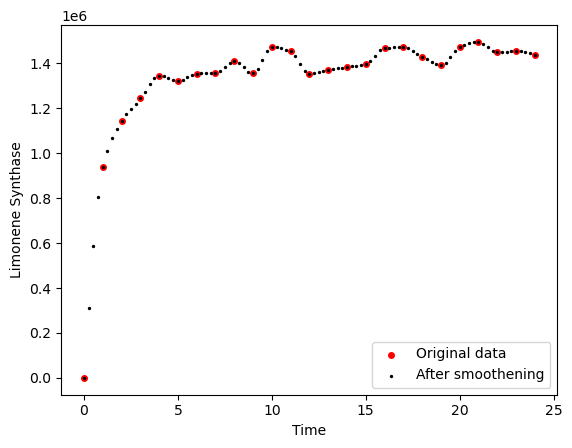

Strain WT


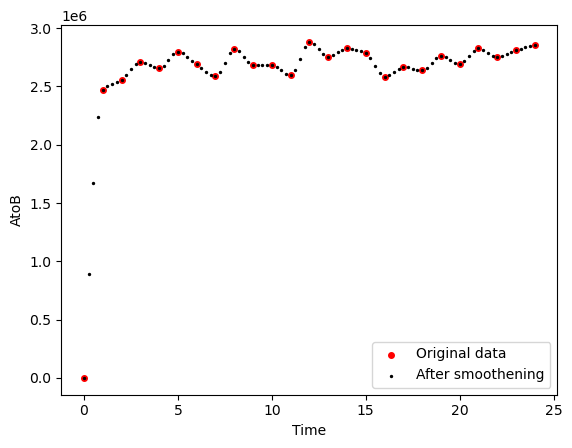

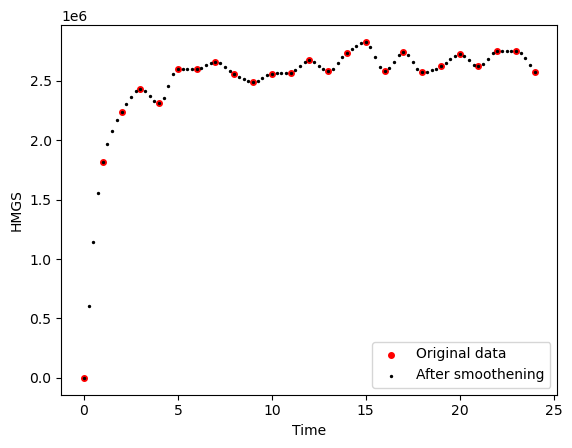

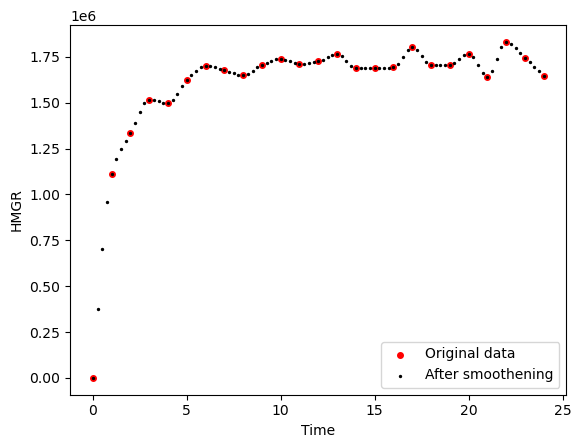

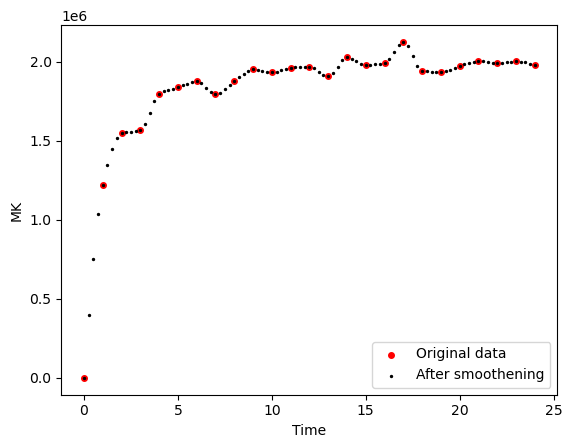

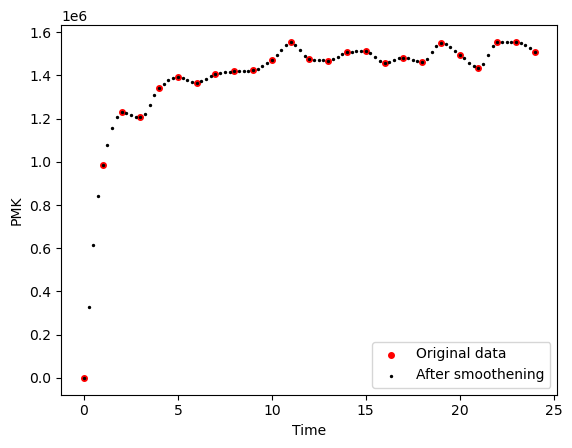

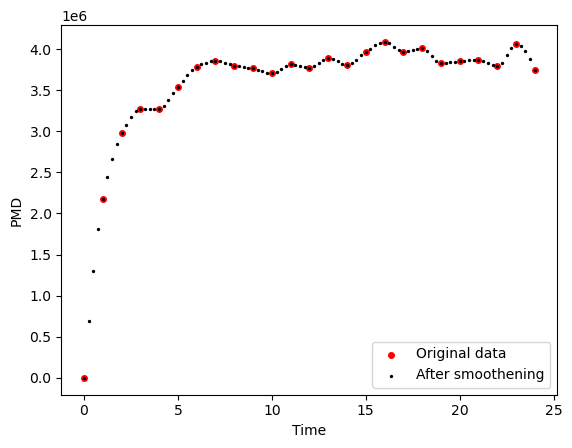

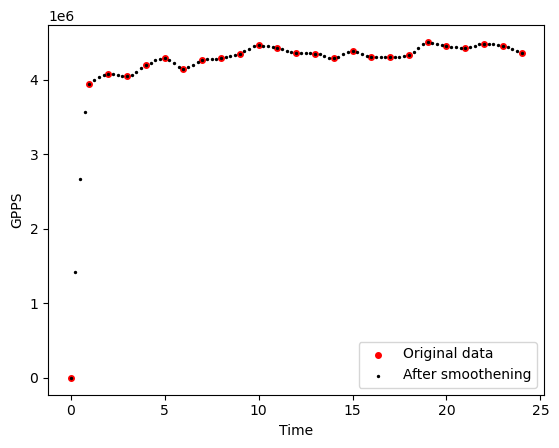

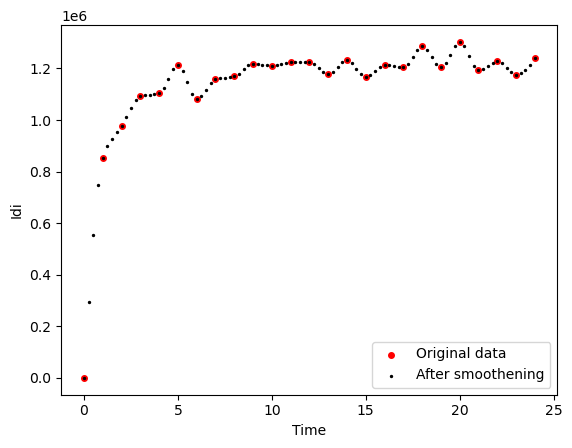

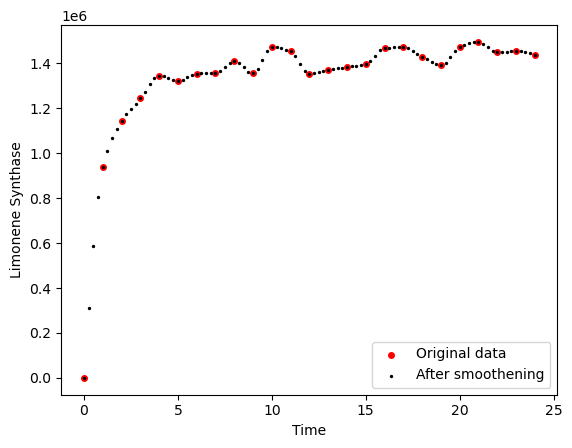

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative

df_allSmooth=estimate_state_derivative(df_allSmooth,5,2)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.306835        0.196300  0.049520  0.297461  0.018999   
         0.25    0.301207        0.192590  0.063912  0.255138  0.054849   
         0.50    0.295297        0.187954  0.076110  0.218909  0.086863   
         0.75    0.289121        0.182561  0.084565  0.193620  0.113667   
         1.00    0.282697        0.176581  0.087728  0.184113  0.133885   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.768320        0.014410  0.019301  0.111857  0.103953   
         23.25   0.774781        0.014552  0.019778  0.111519  0.103733   
         23.50   0.784605        0.014667  0.020382  0.110833  0.103072   
         23.75   0.796944        0.014744  0.021088  0.109907  0.101963   
         24.00   0.810953        0.014772  0.021873  0.108845  0.100400   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.192532  0.009419  0.039748  0.048625  0.000000  ...   
         0.25   0.200735  0.008864  0.039250  0.048959  0.000534  ...   
         0.50   0.207668  0.008292  0.038699  0.049325  0.001134  ...   
         0.75   0.212464  0.007704  0.038100  0.049720  0.001791  ...   
         1.00   0.214255  0.007101  0.037460  0.050141  0.002497  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.294506  0.013176  0.024490  0.101743  0.189064  ...   
         23.25  0.295440  0.013219  0.024381  0.101021  0.189055  ...   
         23.50  0.298103  0.013351  0.024240  0.099050  0.188991  ...   
         23.75  0.302287  0.013570  0.024073  0.096127  0.188818  ...   
         24.00  0.307787  0.013879  0.023886  0.092547  0.188481  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.022021       -0.013734  0.068774 -0.202798  0.157122   
         0.25    -0.023083       -0.016760  0.053801 -0.159042  0.136279   
         0.50    -0.024145       -0.019787  0.038828 -0.115286  0.115436   
         0.75    -0.025162       -0.023034  0.023380 -0.069487  0.093577   
         1.00    -0.026145       -0.026738  0.009202 -0.027012  0.072150   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.021847        0.001246  0.001699 -0.001107  0.000811   
         23.25    0.032278        0.000679  0.002142 -0.002044 -0.001515   
         23.50    0.042972        0.000366  0.002581 -0.003054 -0.003550   
         23.75    0.053035        0.000214  0.002992 -0.004019 -0.005342   
         24.00    0.063099        0.000062  0.003403 -0.004985 -0.007133   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.039166 -0.002192 -0.001912  0.001286  0.002042  
         0.25   0.030618 -0.002255 -0.002101  0.001402  0.002271  
         0.50   0.022070 -0.002318 -0.002291  0.001518  0.002500  
         0.75   0.013049 -0.002441 -0.002471  0.001718  0.002746  
         1.00   0.004498 -0.002635 -0.002649  0.002023  0.003021  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000154 -0.000113 -0.000421 -0.001171  0.005694  
         23.25  0.006872  0.000315 -0.000507 -0.005229  0.001248  
         23.50  0.013363  0.000703 -0.000606 -0.009314 -0.000562  
         23.75  0.019451  0.001056 -0.000709 -0.013125 -0.001000  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

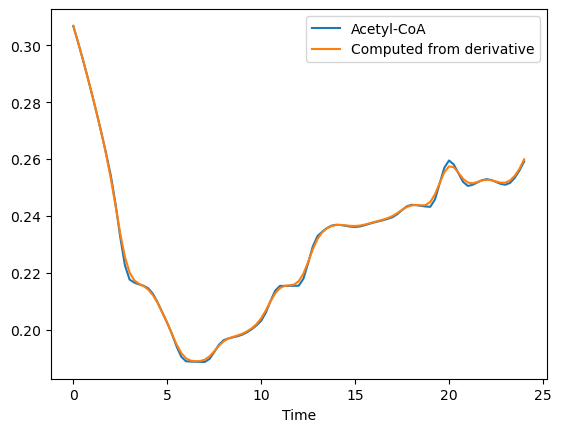

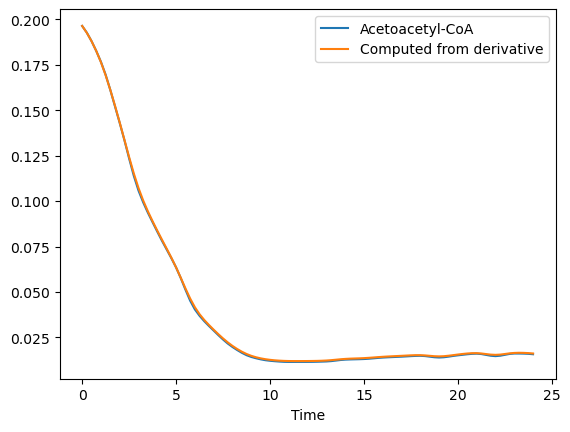

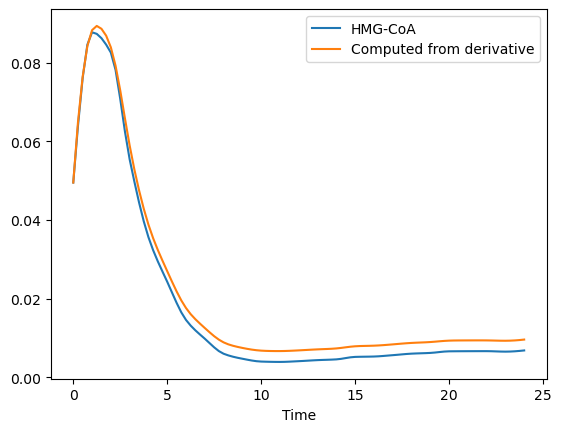

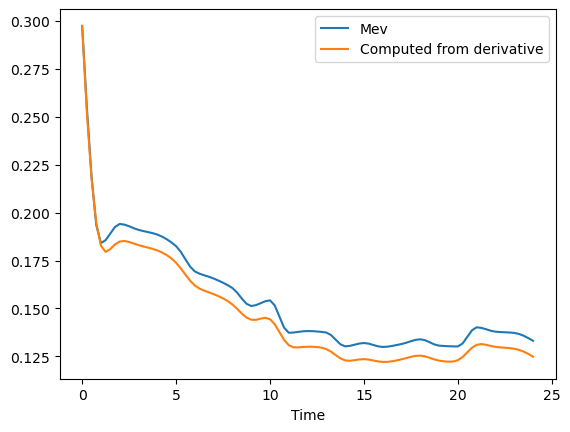

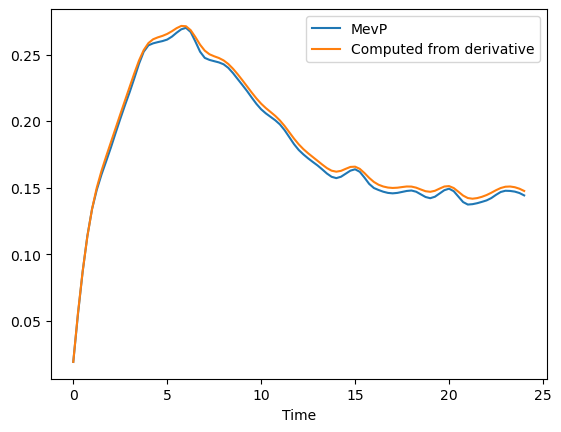

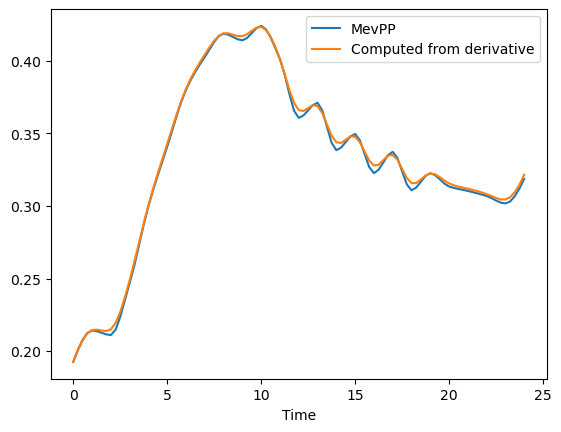

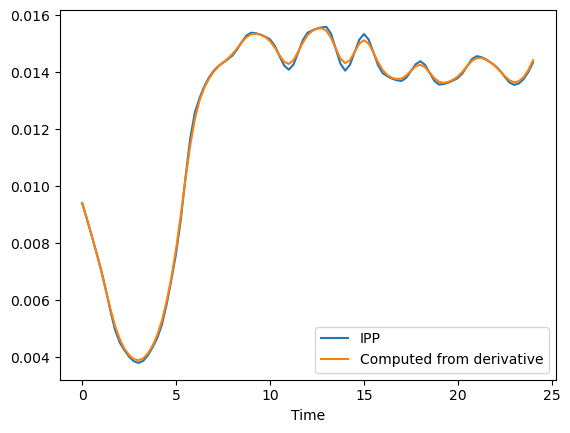

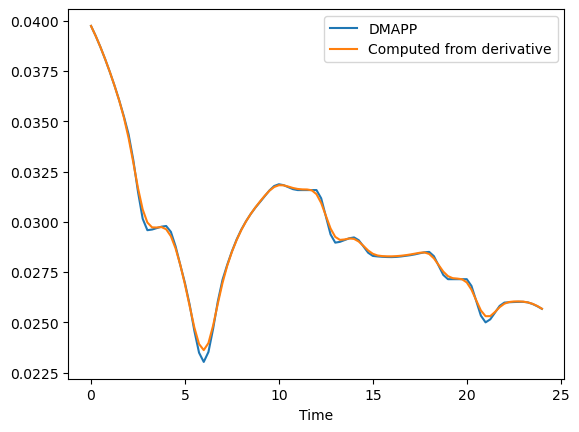

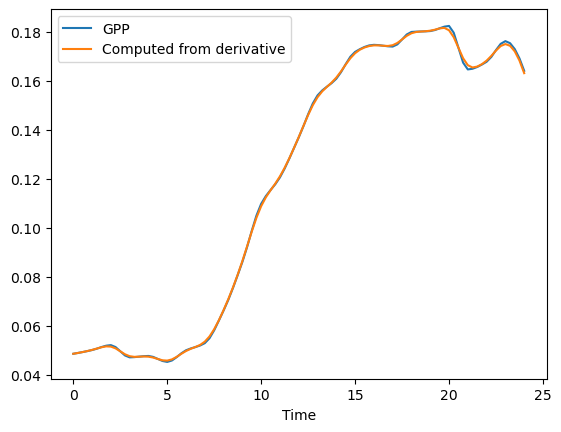

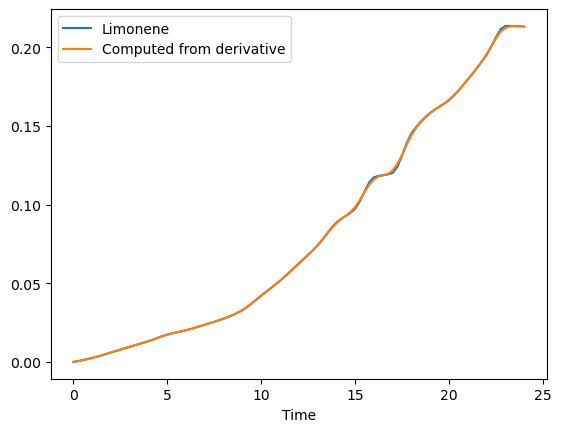

'Time profile from derivative vs. actual profile for Strain 2'

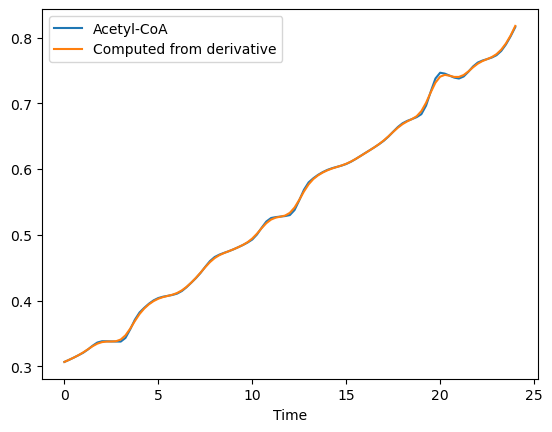

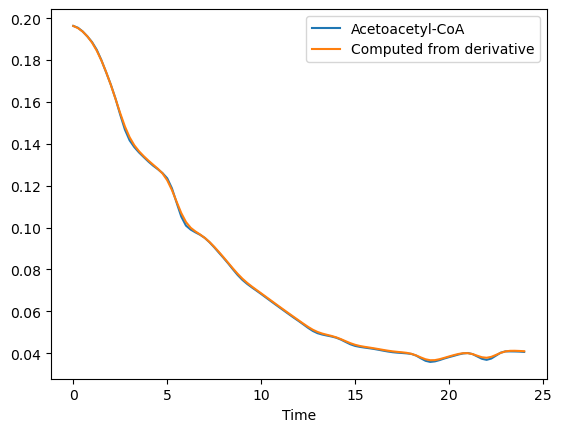

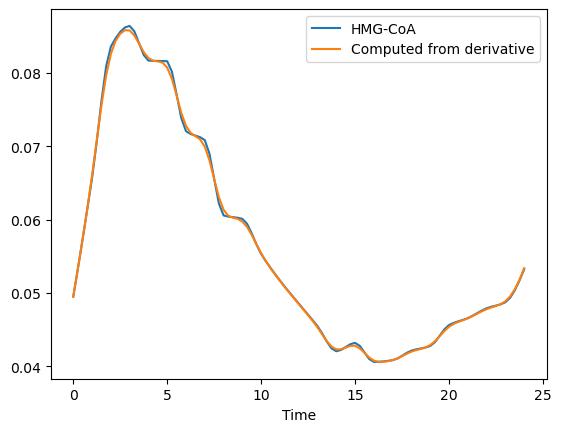

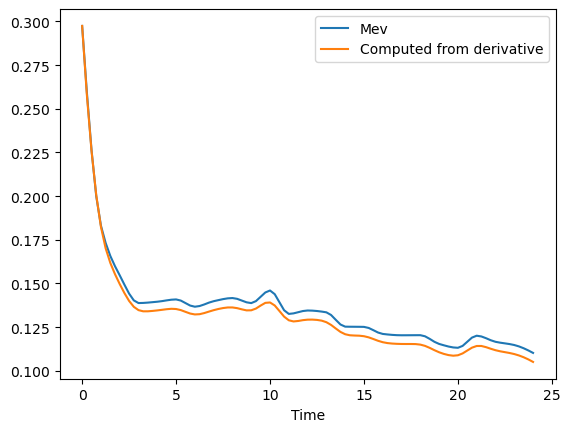

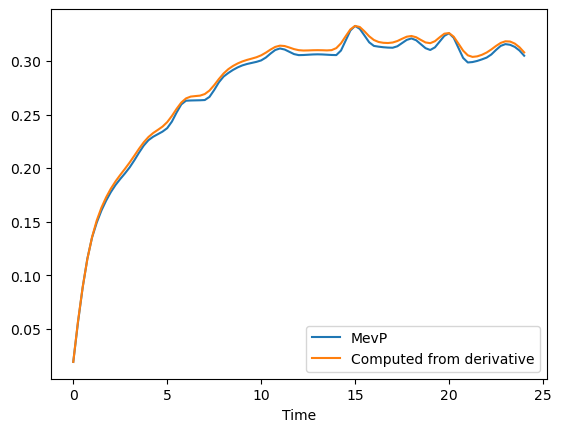

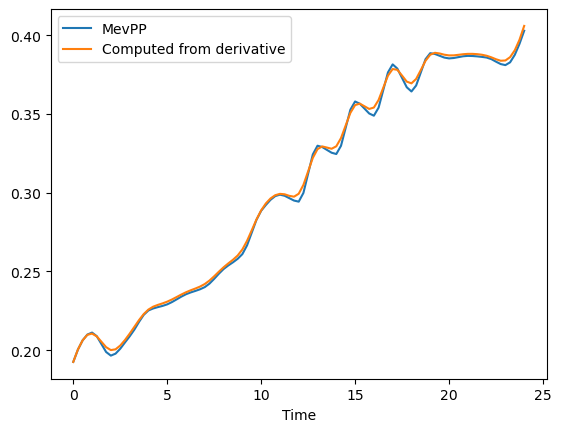

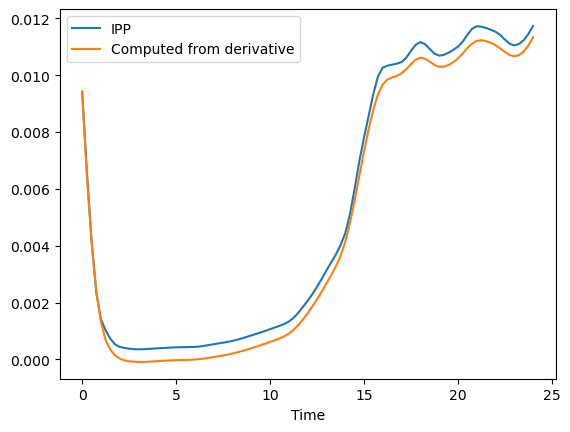

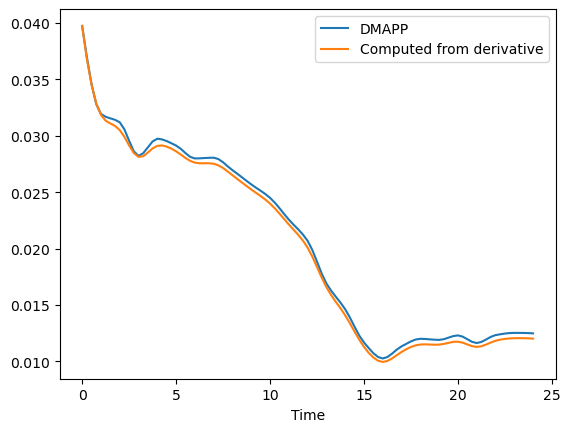

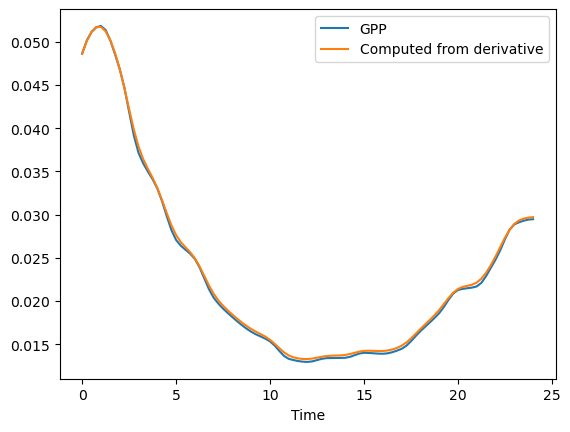

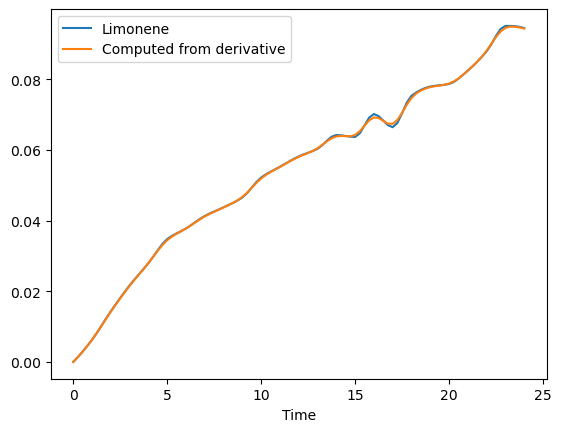

'Time profile from derivative vs. actual profile for Strain 3'

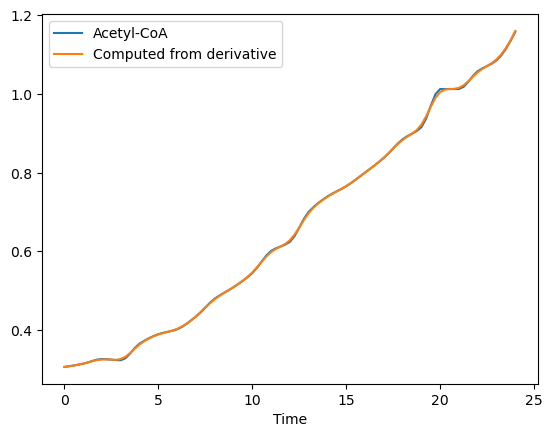

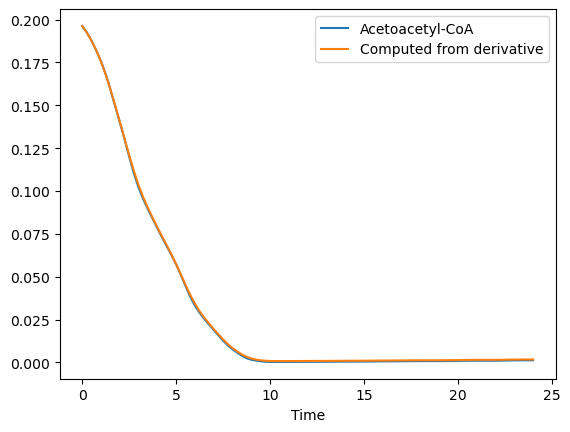

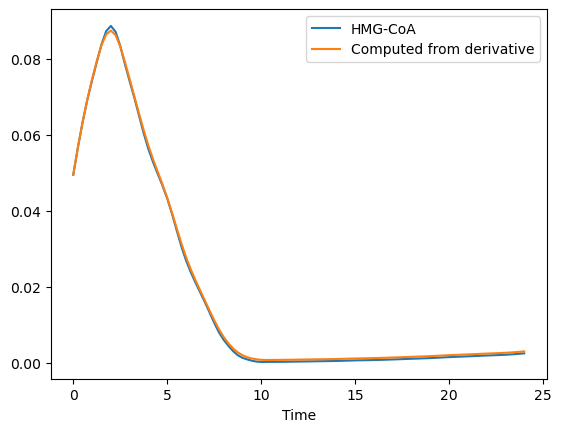

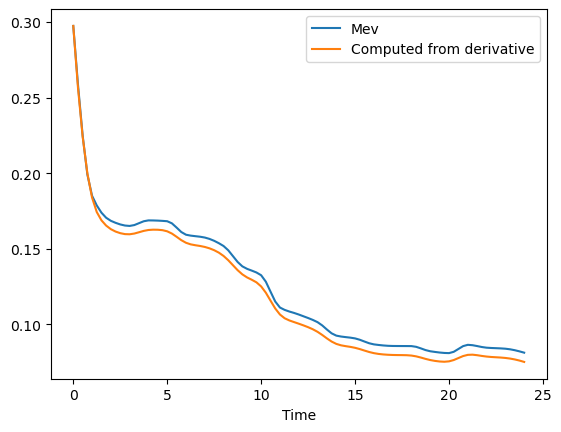

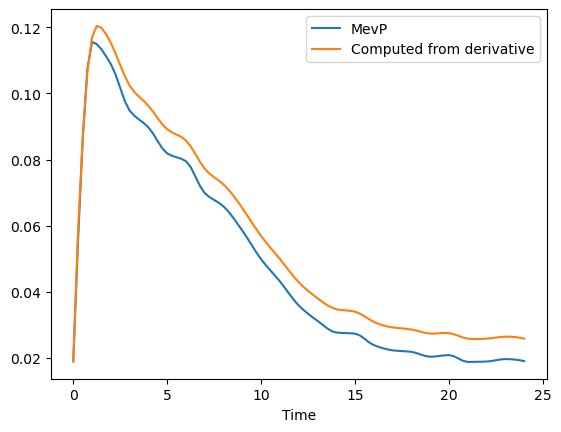

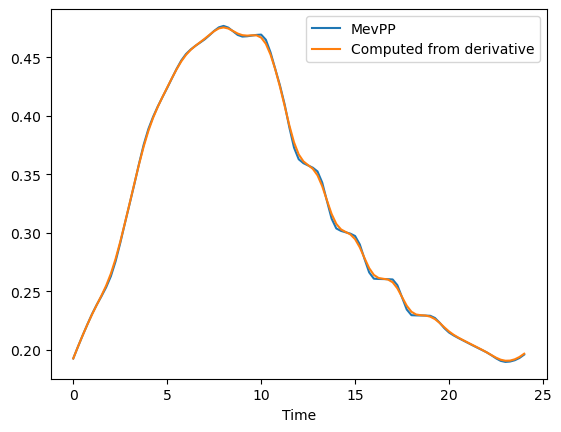

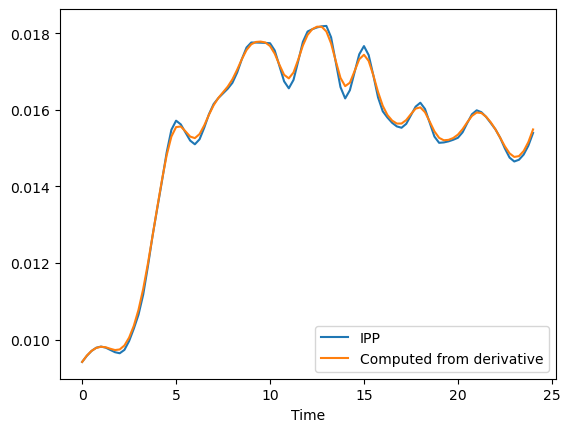

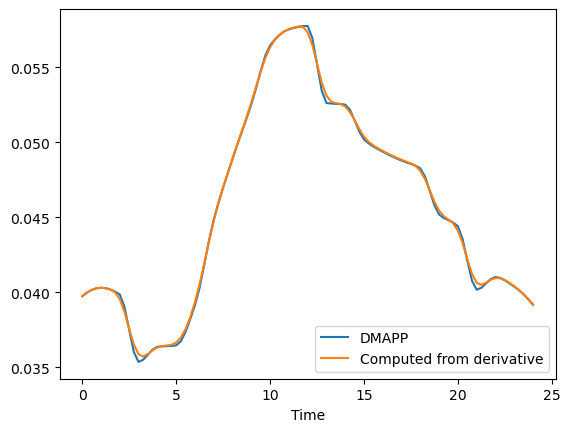

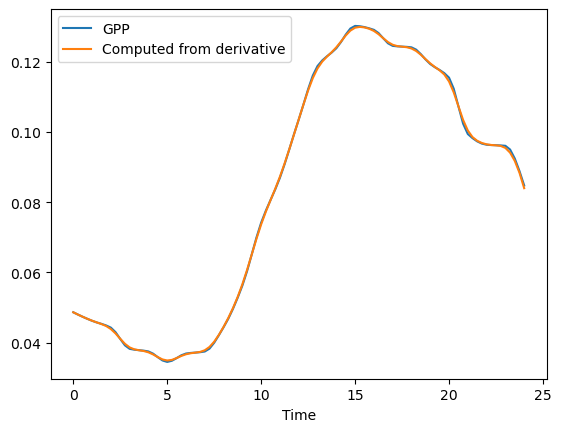

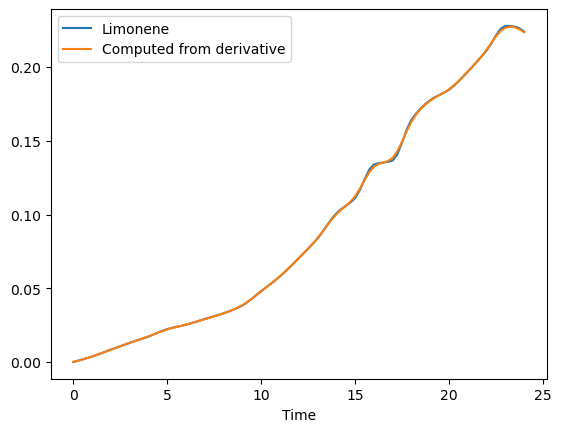

'Time profile from derivative vs. actual profile for WT'

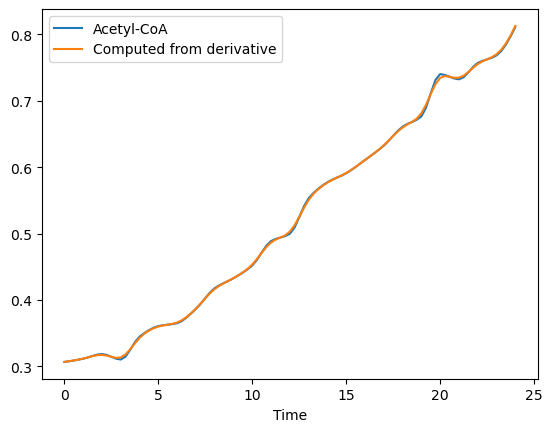

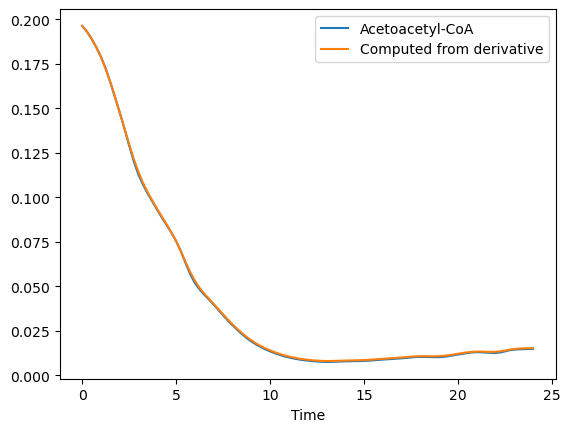

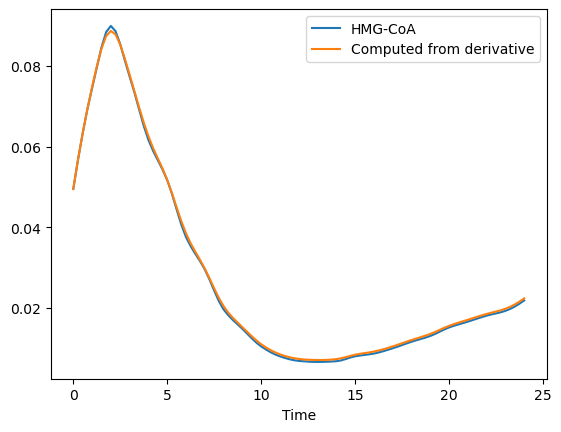

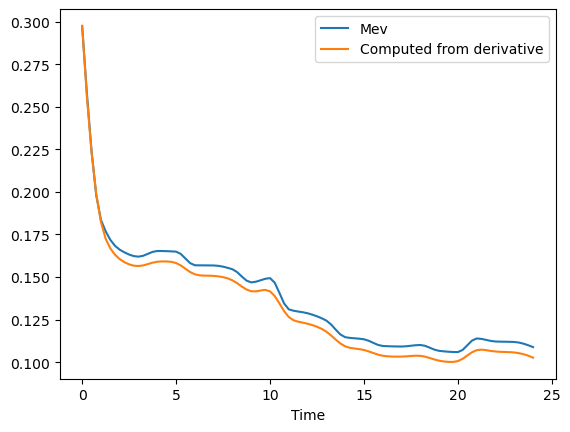

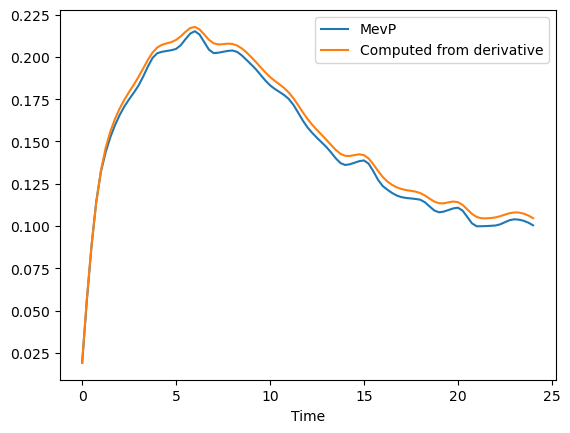

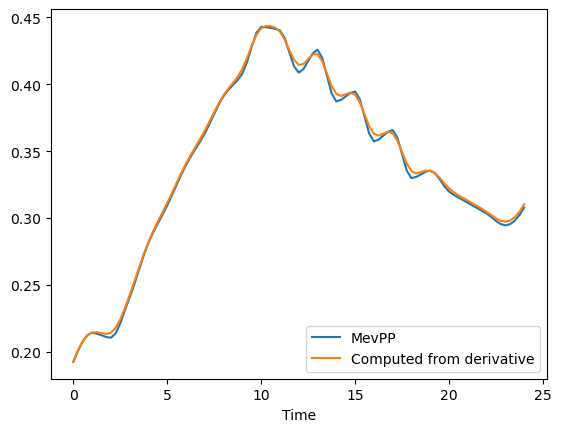

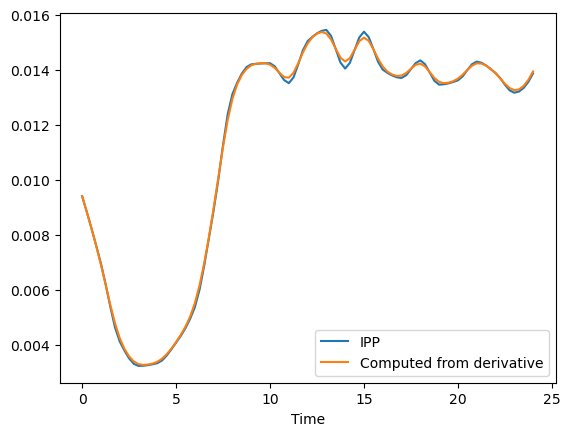

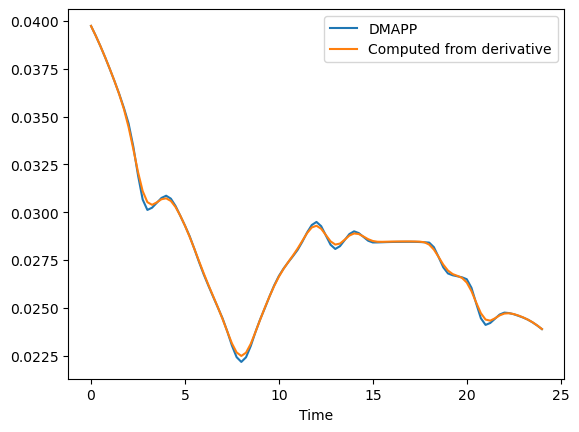

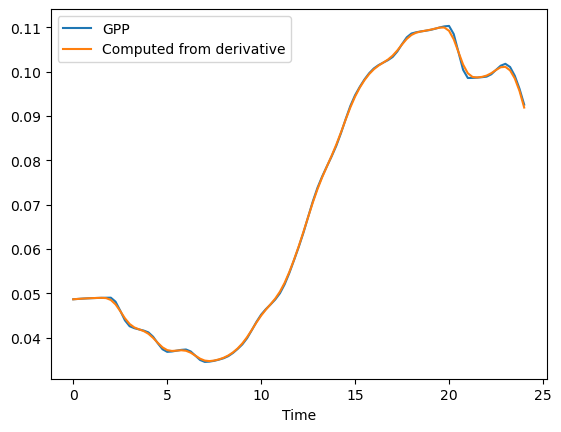

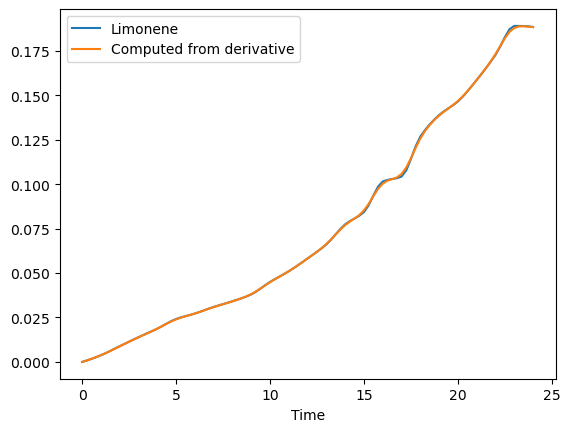

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.082450e+01  3.899512e+01  3.661377e+01  5.713511e+01   
         0.25   2.223022e+06  1.507961e+06  1.623672e+05  9.966537e+05   
         0.50   4.161600e+06  2.832345e+06  3.046513e+05  1.874560e+06   
         0.75   5.556012e+06  3.871063e+06  4.148411e+05  2.573849e+06   
         1.00   6.146475e+06  4.521988e+06  4.808887e+05  3.034596e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.812875e+06  2.745716e+06  1.744861e+06  2.002287e+06   
         23.25  2.824919e+06  2.728716e+06  1.720968e+06  2.000392e+06   
         23.50  2.835945e+06  2.688893e+06  1.695967e+06  1.995136e+06   
         23.75  2.845734e+06  2.633603e+06  1.669922e+06  1.987163e+06   
         24.00  2.854065e+06  2.570202e+06  1.642897e+06  1.977116e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         0.25   3.263830e+05  1.711408e+06  1.423713e+06  2.949412e+05   
         0.50   6.133784e+05  3.233258e+06  2.665244e+06  5.527194e+05   
         0.75   8.400280e+05  4.490966e+06  3.558487e+06  7.477513e+05   
         1.00   9.853482e+05  5.409896e+06  3.937284e+06  8.544349e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.554259e+06  4.058035e+06  4.448439e+06  1.176464e+06   
         23.25  1.550166e+06  4.037079e+06  4.432885e+06  1.180627e+06   
         23.50  1.539335e+06  3.975787e+06  4.411514e+06  1.192777e+06   
         23.75  1.523935e+06  3.876526e+06  4.385614e+06  1.212401e+06   
         24.00  1.506139e+06  3.741661e+06  4.356475e+06  1.238988e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       2.950656e+01   0.306835        0.196300  0.049520   
         0.25       1.352804e+05   0.301207        0.192590  0.063912   
         0.50       2.540009e+05   0.295297        0.187954  0.076110   
         0.75       3.467999e+05   0.289121        0.182561  0.084565   
         1.00       4.042867e+05   0.282697        0.176581  0.087728   
...                          ...        ...             ...       ...   
WT       23.00      1.454117e+06   0.768320        0.014410  0.019301   
         23.25      1.452689e+06   0.774781        0.014552  0.019778   
         23.50      1.448799e+06   0.784605        0.014667  0.020382   
         23.75      1.443034e+06   0.796944        0.014744  0.021088   
         24.00      1.435983e+06   0.810953        0.014772  0.021873   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.297461  0.018999  0.192532  0.009419  0.039748  0.048625   
         0.25   0.255138  0.054849  0.200735  0.008864  0.039250  0.048959   
         0.50   0.218909  0.086863  0.207668  0.008292  0.038699  0.049325   
         0.75   0.193620  0.113667  0.212464  0.007704  0.038100  0.049720   
         1.00   0.184113  0.133885  0.214255  0.007101  0.037460  0.050141   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.111857  0.103953  0.294506  0.013176  0.024490  0.101743   
         23.25  0.111519  0.103733  0.295440  0.013219  0.024381  0.101021   
         23.50  0.110833  0.103072  0.298103  0.013351  0.024240 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00    -0.022021       -0.013734  0.068774 -0.202798  0.157122   
         0.25    -0.023083       -0.016760  0.053801 -0.159042  0.136279   
         0.50    -0.024145       -0.019787  0.038828 -0.115286  0.115436   
         0.75    -0.025162       -0.023034  0.023380 -0.069487  0.093577   
         1.00    -0.026145       -0.026738  0.009202 -0.027012  0.072150   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.021847        0.001246  0.001699 -0.001107  0.000811   
         23.25    0.032278        0.000679  0.002142 -0.002044 -0.001515   
         23.50    0.042972        0.000366  0.002581 -0.003054 -0.003550   
         23.75    0.053035        0.000214  0.002992 -0.004019 -0.005342   
         24.00    0.063099        0.000062  0.003403 -0.004985 -0.007133   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.039166 -0.002192 -0.001912  0.001286  0.002042  
         0.25   0.030618 -0.002255 -0.002101  0.001402  0.002271  
         0.50   0.022070 -0.002318 -0.002291  0.001518  0.002500  
         0.75   0.013049 -0.002441 -0.002471  0.001718  0.002746  
         1.00   0.004498 -0.002635 -0.002649  0.002023  0.003021  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000154 -0.000113 -0.000421 -0.001171  0.005694  
         23.25  0.006872  0.000315 -0.000507 -0.005229  0.001248  
         23.50  0.013363  0.000703 -0.000606 -0.009314 -0.000562  
         23.75  0.019451  0.001056 -0.000709 -0.013125 -0.001000  
         24.00  0.025539  0.001409 -0.000813 -0.016935 -0.001438  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 4.781813E+188 | 8.782652E+113
     2 |       74 | 9.979230E+129 |  4.407852E+84
     3 |      138 |  4.244399E+97 |  1.405331E+82
     4 |      202 |  3.643754E+85 |  1.948425E+71
     5 |      266 |  9.445768E+75 |  1.482435E+55
     6 |      330 |  8.496038E+69 |  1.216864E+53
     7 |      394 |  1.767354E+62 |  8.461252E+47
     8 |      458 |  3.360178E+52 |  1.301025E+44
     9 |      522 |  3.211967E+46 |  8.976953E+39
    10 |      586 |  6.403905E+43 |  4.476922E+27
    11 |      650 |  7.895057E+42 |  4.476922E+27
    12 |      714 |  2.724820E+40 |  4.476922E+27
    13 |      778 |  2.704065E+38 |  7.191531E+25
    14 |      842 |  2.100772E+37 |  1.694024E+25
    15 |      906 |  6.494508E+36 |  3.281679E+20
    16 |      970 |  3.867420E+32 |  3.281679E+20
    17 |     1034 |  4.099051E+32 |  3.281679E+20
    18 |     1098 |  4.492325E+30 |  9.301809E+17
    19 |     1162 |  4.931

   162 |    10314 |  2.398000E+01 |  2.325986E+01
   163 |    10378 |  2.387391E+01 |  2.325986E+01
   164 |    10442 |  2.389295E+01 |  2.325986E+01
   165 |    10506 |  2.377464E+01 |  2.325986E+01
   166 |    10570 |  2.386881E+01 |  2.325986E+01
   167 |    10634 |  2.386305E+01 |  2.325986E+01
   168 |    10698 |  2.380260E+01 |  2.325986E+01
   169 |    10762 |  2.378766E+01 |  2.325986E+01
   170 |    10826 |  2.368198E+01 |  2.325986E+01
   171 |    10890 |  2.353011E+01 |  2.320554E+01
   172 |    10954 |  2.350740E+01 |  2.320554E+01
   173 |    11018 |  2.332212E+01 |  2.304932E+01
   174 |    11082 |  2.321228E+01 |  2.237471E+01
   175 |    11146 |  2.312475E+01 |  2.237471E+01
   176 |    11210 |  2.310282E+01 |  2.186733E+01
   177 |    11274 |  2.282270E+01 |  2.186733E+01
   178 |    11338 |  2.266964E+01 |  2.186733E+01
   179 |    11402 |  2.252138E+01 |  2.186733E+01
   180 |    11466 |  2.271609E+01 |  2.185107E+01
   181 |    11530 |  2.238295E+01 |  2.159883E+01


   326 |    20810 |  2.008100E+01 |  1.991164E+01
   327 |    20874 |  2.014307E+01 |  1.991164E+01
   328 |    20938 |  2.010244E+01 |  1.991164E+01
   329 |    21002 |  2.014940E+01 |  1.991164E+01
   330 |    21066 |  2.010726E+01 |  1.991164E+01
   331 |    21130 |  2.011038E+01 |  1.991164E+01
   332 |    21194 |  2.015814E+01 |  1.991164E+01
   333 |    21258 |  2.000241E+01 |  1.982463E+01
   334 |    21322 |  1.993916E+01 |  1.978277E+01
   335 |    21386 |  1.987212E+01 |  1.978277E+01
   336 |    21450 |  1.985163E+01 |  1.978277E+01
   337 |    21514 |  1.986127E+01 |  1.977572E+01
   338 |    21578 |  1.986390E+01 |  1.977572E+01
   339 |    21642 |  1.985944E+01 |  1.977572E+01
   340 |    21706 |  1.986882E+01 |  1.974390E+01
   341 |    21770 |  1.985629E+01 |  1.973443E+01
   342 |    21834 |  1.982961E+01 |  1.973443E+01
   343 |    21898 |  1.978781E+01 |  1.965790E+01
   344 |    21962 |  1.976613E+01 |  1.965790E+01
   345 |    22026 |  1.976933E+01 |  1.965790E+01


   490 |    31306 |  1.848952E+01 |  1.838187E+01
   491 |    31370 |  1.845953E+01 |  1.838187E+01
   492 |    31434 |  1.843898E+01 |  1.838187E+01
   493 |    31498 |  1.841488E+01 |  1.833313E+01
   494 |    31562 |  1.842275E+01 |  1.833313E+01
   495 |    31626 |  1.842101E+01 |  1.833313E+01
   496 |    31690 |  1.839367E+01 |  1.833241E+01
   497 |    31754 |  1.836429E+01 |  1.831958E+01
   498 |    31818 |  1.836755E+01 |  1.831636E+01
   499 |    31882 |  1.835592E+01 |  1.831636E+01
   500 |    31946 |  1.833835E+01 |  1.831076E+01
   501 |    32010 |  1.834317E+01 |  1.827955E+01
   502 |    32074 |  1.832401E+01 |  1.826669E+01
   503 |    32138 |  1.833075E+01 |  1.826669E+01
   504 |    32202 |  1.833477E+01 |  1.826078E+01
   505 |    32266 |  1.834324E+01 |  1.826078E+01
   506 |    32330 |  1.831373E+01 |  1.826078E+01
   507 |    32394 |  1.833530E+01 |  1.826078E+01
   508 |    32458 |  1.832640E+01 |  1.826078E+01
   509 |    32522 |  1.831775E+01 |  1.826078E+01


   654 |    41802 |  1.747166E+01 |  1.746306E+01
   655 |    41866 |  1.747274E+01 |  1.746106E+01
   656 |    41930 |  1.746963E+01 |  1.746106E+01
   657 |    41994 |  1.747128E+01 |  1.746106E+01
   658 |    42058 |  1.746755E+01 |  1.745955E+01
   659 |    42122 |  1.746715E+01 |  1.745955E+01
   660 |    42186 |  1.746774E+01 |  1.745955E+01
   661 |    42250 |  1.746899E+01 |  1.745955E+01
   662 |    42314 |  1.746710E+01 |  1.745955E+01
   663 |    42378 |  1.746740E+01 |  1.745955E+01
   664 |    42442 |  1.746514E+01 |  1.745955E+01
   665 |    42506 |  1.746395E+01 |  1.745955E+01
   666 |    42570 |  1.746347E+01 |  1.745833E+01
   667 |    42634 |  1.746215E+01 |  1.745833E+01
   668 |    42698 |  1.746264E+01 |  1.745833E+01
   669 |    42762 |  1.746185E+01 |  1.745833E+01
   670 |    42826 |  1.746005E+01 |  1.745598E+01
   671 |    42890 |  1.745885E+01 |  1.745582E+01
   672 |    42954 |  1.745789E+01 |  1.745330E+01
   673 |    43018 |  1.745474E+01 |  1.745065E+01


   818 |    52298 |  1.708609E+01 |  1.707382E+01
   819 |    52362 |  1.708097E+01 |  1.707382E+01
   820 |    52426 |  1.707829E+01 |  1.706998E+01
   821 |    52490 |  1.707267E+01 |  1.706609E+01
   822 |    52554 |  1.706840E+01 |  1.706338E+01
   823 |    52618 |  1.706560E+01 |  1.706171E+01
   824 |    52682 |  1.706176E+01 |  1.705877E+01
   825 |    52746 |  1.706092E+01 |  1.705526E+01
   826 |    52810 |  1.705644E+01 |  1.705340E+01
   827 |    52874 |  1.705436E+01 |  1.704980E+01
   828 |    52938 |  1.705324E+01 |  1.704980E+01
   829 |    53002 |  1.705389E+01 |  1.704915E+01
   830 |    53066 |  1.705286E+01 |  1.704754E+01
   831 |    53130 |  1.705027E+01 |  1.704307E+01
   832 |    53194 |  1.704925E+01 |  1.704273E+01
   833 |    53258 |  1.704656E+01 |  1.704273E+01
   834 |    53322 |  1.704388E+01 |  1.704040E+01
   835 |    53386 |  1.704151E+01 |  1.703692E+01
   836 |    53450 |  1.703626E+01 |  1.703011E+01
   837 |    53514 |  1.703221E+01 |  1.702745E+01


   982 |    62794 |  1.598701E+01 |  1.595110E+01
   983 |    62858 |  1.599070E+01 |  1.595110E+01
   984 |    62922 |  1.599677E+01 |  1.595110E+01
   985 |    62986 |  1.600320E+01 |  1.595110E+01
   986 |    63050 |  1.600668E+01 |  1.595110E+01
   987 |    63114 |  1.599656E+01 |  1.595110E+01
   988 |    63178 |  1.599507E+01 |  1.595110E+01
   989 |    63242 |  1.601403E+01 |  1.595110E+01
   990 |    63306 |  1.600958E+01 |  1.595110E+01
   991 |    63370 |  1.599730E+01 |  1.595110E+01
   992 |    63434 |  1.597524E+01 |  1.593863E+01
   993 |    63498 |  1.596095E+01 |  1.593863E+01
   994 |    63562 |  1.596572E+01 |  1.593863E+01
   995 |    63626 |  1.596355E+01 |  1.593863E+01
   996 |    63690 |  1.595108E+01 |  1.593863E+01
   997 |    63754 |  1.595340E+01 |  1.593863E+01
   998 |    63818 |  1.596298E+01 |  1.593816E+01
   999 |    63882 |  1.595769E+01 |  1.593604E+01
  1000 |    63946 |  1.595307E+01 |  1.593305E+01
  1001 |    64010 |  1.594874E+01 |  1.592771E+01


  1146 |    73290 |  1.582599E+01 |  1.582501E+01
  1147 |    73354 |  1.582547E+01 |  1.582362E+01
  1148 |    73418 |  1.582503E+01 |  1.582362E+01
  1149 |    73482 |  1.582455E+01 |  1.582362E+01
  1150 |    73546 |  1.582416E+01 |  1.582284E+01
  1151 |    73610 |  1.582371E+01 |  1.582245E+01
  1152 |    73674 |  1.582297E+01 |  1.582209E+01
  1153 |    73738 |  1.582256E+01 |  1.582190E+01
  1154 |    73802 |  1.582223E+01 |  1.582149E+01
  1155 |    73866 |  1.582189E+01 |  1.582114E+01
  1156 |    73930 |  1.582139E+01 |  1.582085E+01
  1157 |    73994 |  1.582115E+01 |  1.582083E+01
  1158 |    74058 |  1.582101E+01 |  1.582040E+01
  1159 |    74122 |  1.582071E+01 |  1.581999E+01
  1160 |    74186 |  1.582033E+01 |  1.581967E+01
  1161 |    74250 |  1.581979E+01 |  1.581920E+01
  1162 |    74314 |  1.581958E+01 |  1.581873E+01
  1163 |    74378 |  1.581908E+01 |  1.581858E+01
  1164 |    74442 |  1.581868E+01 |  1.581785E+01
  1165 |    74506 |  1.581823E+01 |  1.581762E+01


  1310 |    83786 |  1.575115E+01 |  1.575043E+01
  1311 |    83850 |  1.575091E+01 |  1.575011E+01
  1312 |    83914 |  1.575090E+01 |  1.574980E+01
  1313 |    83978 |  1.575054E+01 |  1.574980E+01
  1314 |    84042 |  1.575022E+01 |  1.574980E+01
  1315 |    84106 |  1.575000E+01 |  1.574889E+01
  1316 |    84170 |  1.574982E+01 |  1.574889E+01
  1317 |    84234 |  1.574942E+01 |  1.574869E+01
  1318 |    84298 |  1.574909E+01 |  1.574863E+01
  1319 |    84362 |  1.574872E+01 |  1.574839E+01
  1320 |    84426 |  1.574852E+01 |  1.574757E+01
  1321 |    84490 |  1.574825E+01 |  1.574755E+01
  1322 |    84554 |  1.574799E+01 |  1.574728E+01
  1323 |    84618 |  1.574742E+01 |  1.574662E+01
  1324 |    84682 |  1.574706E+01 |  1.574607E+01
  1325 |    84746 |  1.574649E+01 |  1.574583E+01
  1326 |    84810 |  1.574604E+01 |  1.574543E+01
  1327 |    84874 |  1.574569E+01 |  1.574488E+01
  1328 |    84938 |  1.574552E+01 |  1.574488E+01
  1329 |    85002 |  1.574532E+01 |  1.574488E+01


  1474 |    94282 |  1.570417E+01 |  1.570307E+01
  1475 |    94346 |  1.570371E+01 |  1.570289E+01
  1476 |    94410 |  1.570334E+01 |  1.570180E+01
  1477 |    94474 |  1.570311E+01 |  1.570157E+01
  1478 |    94538 |  1.570280E+01 |  1.570157E+01
  1479 |    94602 |  1.570228E+01 |  1.570089E+01
  1480 |    94666 |  1.570227E+01 |  1.570089E+01
  1481 |    94730 |  1.570246E+01 |  1.570089E+01
  1482 |    94794 |  1.570232E+01 |  1.570089E+01
  1483 |    94858 |  1.570156E+01 |  1.570024E+01
  1484 |    94922 |  1.570118E+01 |  1.570024E+01
  1485 |    94986 |  1.570112E+01 |  1.570024E+01
  1486 |    95050 |  1.570075E+01 |  1.570013E+01
  1487 |    95114 |  1.570070E+01 |  1.569970E+01
  1488 |    95178 |  1.570069E+01 |  1.569970E+01
  1489 |    95242 |  1.570053E+01 |  1.569968E+01
  1490 |    95306 |  1.570038E+01 |  1.569968E+01
  1491 |    95370 |  1.570024E+01 |  1.569940E+01
  1492 |    95434 |  1.569971E+01 |  1.569938E+01
  1493 |    95498 |  1.569981E+01 |  1.569899E+01


  1638 |   104778 |  1.560788E+01 |  1.560661E+01
  1639 |   104842 |  1.560758E+01 |  1.560637E+01
  1640 |   104906 |  1.560747E+01 |  1.560637E+01
  1641 |   104970 |  1.560714E+01 |  1.560637E+01
  1642 |   105034 |  1.560676E+01 |  1.560592E+01
  1643 |   105098 |  1.560638E+01 |  1.560589E+01
  1644 |   105162 |  1.560594E+01 |  1.560548E+01
  1645 |   105226 |  1.560584E+01 |  1.560548E+01
  1646 |   105290 |  1.560569E+01 |  1.560499E+01
  1647 |   105354 |  1.560531E+01 |  1.560458E+01
  1648 |   105418 |  1.560526E+01 |  1.560458E+01
  1649 |   105482 |  1.560499E+01 |  1.560377E+01
  1650 |   105546 |  1.560471E+01 |  1.560365E+01
  1651 |   105610 |  1.560425E+01 |  1.560355E+01
  1652 |   105674 |  1.560394E+01 |  1.560290E+01
  1653 |   105738 |  1.560368E+01 |  1.560290E+01
  1654 |   105802 |  1.560324E+01 |  1.560243E+01
  1655 |   105866 |  1.560308E+01 |  1.560229E+01
  1656 |   105930 |  1.560294E+01 |  1.560229E+01
  1657 |   105994 |  1.560289E+01 |  1.560223E+01


  1802 |   115274 |  1.555035E+01 |  1.554943E+01
  1803 |   115338 |  1.554975E+01 |  1.554899E+01
  1804 |   115402 |  1.554934E+01 |  1.554874E+01
  1805 |   115466 |  1.554882E+01 |  1.554791E+01
  1806 |   115530 |  1.554820E+01 |  1.554762E+01
  1807 |   115594 |  1.554786E+01 |  1.554746E+01
  1808 |   115658 |  1.554737E+01 |  1.554609E+01
  1809 |   115722 |  1.554655E+01 |  1.554605E+01
  1810 |   115786 |  1.554627E+01 |  1.554546E+01
  1811 |   115850 |  1.554561E+01 |  1.554520E+01
  1812 |   115914 |  1.554558E+01 |  1.554487E+01
  1813 |   115978 |  1.554571E+01 |  1.554472E+01
  1814 |   116042 |  1.554511E+01 |  1.554461E+01
  1815 |   116106 |  1.554465E+01 |  1.554377E+01
  1816 |   116170 |  1.554434E+01 |  1.554351E+01
  1817 |   116234 |  1.554380E+01 |  1.554238E+01
  1818 |   116298 |  1.554345E+01 |  1.554238E+01
  1819 |   116362 |  1.554319E+01 |  1.554238E+01
  1820 |   116426 |  1.554287E+01 |  1.554190E+01
  1821 |   116490 |  1.554248E+01 |  1.554181E+01


  1966 |   125770 |  1.547487E+01 |  1.547389E+01
  1967 |   125834 |  1.547454E+01 |  1.547307E+01
  1968 |   125898 |  1.547384E+01 |  1.547307E+01
  1969 |   125962 |  1.547322E+01 |  1.547251E+01
  1970 |   126026 |  1.547287E+01 |  1.547251E+01
  1971 |   126090 |  1.547256E+01 |  1.547174E+01
  1972 |   126154 |  1.547180E+01 |  1.547069E+01
  1973 |   126218 |  1.547118E+01 |  1.547030E+01
  1974 |   126282 |  1.547037E+01 |  1.546962E+01
  1975 |   126346 |  1.546963E+01 |  1.546894E+01
  1976 |   126410 |  1.546925E+01 |  1.546872E+01
  1977 |   126474 |  1.546885E+01 |  1.546818E+01
  1978 |   126538 |  1.546852E+01 |  1.546772E+01
  1979 |   126602 |  1.546798E+01 |  1.546666E+01
  1980 |   126666 |  1.546727E+01 |  1.546666E+01
  1981 |   126730 |  1.546664E+01 |  1.546634E+01
  1982 |   126794 |  1.546619E+01 |  1.546527E+01
  1983 |   126858 |  1.546583E+01 |  1.546527E+01
  1984 |   126922 |  1.546532E+01 |  1.546485E+01
  1985 |   126986 |  1.546494E+01 |  1.546430E+01


  2130 |   136266 |  1.539934E+01 |  1.539808E+01
  2131 |   136330 |  1.539860E+01 |  1.539654E+01
  2132 |   136394 |  1.539711E+01 |  1.539528E+01
  2133 |   136458 |  1.539580E+01 |  1.539352E+01
  2134 |   136522 |  1.539447E+01 |  1.539319E+01
  2135 |   136586 |  1.539348E+01 |  1.539243E+01
  2136 |   136650 |  1.539195E+01 |  1.538997E+01
  2137 |   136714 |  1.539163E+01 |  1.538997E+01
  2138 |   136778 |  1.539054E+01 |  1.538916E+01
  2139 |   136842 |  1.538986E+01 |  1.538890E+01
  2140 |   136906 |  1.538888E+01 |  1.538850E+01
  2141 |   136970 |  1.538805E+01 |  1.538618E+01
  2142 |   137034 |  1.538725E+01 |  1.538607E+01
  2143 |   137098 |  1.538715E+01 |  1.538592E+01
  2144 |   137162 |  1.538594E+01 |  1.538423E+01
  2145 |   137226 |  1.538478E+01 |  1.538330E+01
  2146 |   137290 |  1.538306E+01 |  1.538119E+01
  2147 |   137354 |  1.538194E+01 |  1.538083E+01
  2148 |   137418 |  1.538178E+01 |  1.538027E+01
  2149 |   137482 |  1.538157E+01 |  1.537842E+01


  2294 |   146762 |  1.491038E+01 |  1.490433E+01
  2295 |   146826 |  1.490828E+01 |  1.490152E+01
  2296 |   146890 |  1.490460E+01 |  1.489900E+01
  2297 |   146954 |  1.490363E+01 |  1.489900E+01
  2298 |   147018 |  1.490307E+01 |  1.489717E+01
  2299 |   147082 |  1.489888E+01 |  1.489565E+01
  2300 |   147146 |  1.489931E+01 |  1.489371E+01
  2301 |   147210 |  1.489731E+01 |  1.488751E+01
  2302 |   147274 |  1.489272E+01 |  1.488745E+01
  2303 |   147338 |  1.489299E+01 |  1.488489E+01
  2304 |   147402 |  1.488525E+01 |  1.487536E+01
  2305 |   147466 |  1.488286E+01 |  1.486747E+01
  2306 |   147530 |  1.487651E+01 |  1.486747E+01
  2307 |   147594 |  1.486940E+01 |  1.486477E+01
  2308 |   147658 |  1.486223E+01 |  1.485355E+01
  2309 |   147722 |  1.485448E+01 |  1.484752E+01
  2310 |   147786 |  1.485175E+01 |  1.484388E+01
  2311 |   147850 |  1.484597E+01 |  1.483870E+01
  2312 |   147914 |  1.484434E+01 |  1.483805E+01
  2313 |   147978 |  1.484047E+01 |  1.483219E+01


  2458 |   157258 |  1.452943E+01 |  1.452456E+01
  2459 |   157322 |  1.452834E+01 |  1.452199E+01
  2460 |   157386 |  1.452836E+01 |  1.452199E+01
  2461 |   157450 |  1.452604E+01 |  1.452199E+01
  2462 |   157514 |  1.452729E+01 |  1.452199E+01
  2463 |   157578 |  1.452856E+01 |  1.452199E+01
  2464 |   157642 |  1.452882E+01 |  1.452199E+01
  2465 |   157706 |  1.452669E+01 |  1.452101E+01
  2466 |   157770 |  1.452580E+01 |  1.452101E+01
  2467 |   157834 |  1.452534E+01 |  1.452101E+01
  2468 |   157898 |  1.452616E+01 |  1.452101E+01
  2469 |   157962 |  1.452518E+01 |  1.452101E+01
  2470 |   158026 |  1.452571E+01 |  1.452101E+01
  2471 |   158090 |  1.452364E+01 |  1.451726E+01
  2472 |   158154 |  1.452116E+01 |  1.451726E+01
  2473 |   158218 |  1.451951E+01 |  1.451549E+01
  2474 |   158282 |  1.451875E+01 |  1.451549E+01
  2475 |   158346 |  1.451796E+01 |  1.451216E+01
  2476 |   158410 |  1.451733E+01 |  1.451216E+01
  2477 |   158474 |  1.451612E+01 |  1.451154E+01


  2622 |   167754 |  1.432658E+01 |  1.432390E+01
  2623 |   167818 |  1.432341E+01 |  1.432093E+01
  2624 |   167882 |  1.432113E+01 |  1.431695E+01
  2625 |   167946 |  1.431781E+01 |  1.431389E+01
  2626 |   168010 |  1.431241E+01 |  1.430747E+01
  2627 |   168074 |  1.430946E+01 |  1.430713E+01
  2628 |   168138 |  1.430848E+01 |  1.430651E+01
  2629 |   168202 |  1.430448E+01 |  1.429885E+01
  2630 |   168266 |  1.429932E+01 |  1.429388E+01
  2631 |   168330 |  1.429650E+01 |  1.429301E+01
  2632 |   168394 |  1.429542E+01 |  1.429213E+01
  2633 |   168458 |  1.429302E+01 |  1.428840E+01
  2634 |   168522 |  1.429097E+01 |  1.428631E+01
  2635 |   168586 |  1.428930E+01 |  1.428557E+01
  2636 |   168650 |  1.428659E+01 |  1.428072E+01
  2637 |   168714 |  1.428597E+01 |  1.428072E+01
  2638 |   168778 |  1.428254E+01 |  1.427766E+01
  2639 |   168842 |  1.427786E+01 |  1.427094E+01
  2640 |   168906 |  1.427202E+01 |  1.426522E+01
  2641 |   168970 |  1.426539E+01 |  1.426071E+01


  2786 |   178250 |  1.396197E+01 |  1.395878E+01
  2787 |   178314 |  1.395955E+01 |  1.395702E+01
  2788 |   178378 |  1.395752E+01 |  1.395511E+01
  2789 |   178442 |  1.395488E+01 |  1.395243E+01
  2790 |   178506 |  1.395173E+01 |  1.394854E+01
  2791 |   178570 |  1.394892E+01 |  1.394411E+01
  2792 |   178634 |  1.394572E+01 |  1.394170E+01
  2793 |   178698 |  1.394288E+01 |  1.393863E+01
  2794 |   178762 |  1.394005E+01 |  1.393799E+01
  2795 |   178826 |  1.393768E+01 |  1.393553E+01
  2796 |   178890 |  1.393477E+01 |  1.393198E+01
  2797 |   178954 |  1.393287E+01 |  1.392808E+01
  2798 |   179018 |  1.392998E+01 |  1.392633E+01
  2799 |   179082 |  1.392708E+01 |  1.392455E+01
  2800 |   179146 |  1.392563E+01 |  1.392282E+01
  2801 |   179210 |  1.392293E+01 |  1.391965E+01
  2802 |   179274 |  1.392034E+01 |  1.391513E+01
  2803 |   179338 |  1.391674E+01 |  1.391455E+01
  2804 |   179402 |  1.391227E+01 |  1.390633E+01
  2805 |   179466 |  1.390976E+01 |  1.390607E+01


  2950 |   188746 |  1.342364E+01 |  1.341713E+01
  2951 |   188810 |  1.341971E+01 |  1.341555E+01
  2952 |   188874 |  1.341692E+01 |  1.340983E+01
  2953 |   188938 |  1.341362E+01 |  1.340379E+01
  2954 |   189002 |  1.341082E+01 |  1.340379E+01
  2955 |   189066 |  1.340903E+01 |  1.340266E+01
  2956 |   189130 |  1.340767E+01 |  1.340266E+01
  2957 |   189194 |  1.340715E+01 |  1.340266E+01
  2958 |   189258 |  1.340420E+01 |  1.339841E+01
  2959 |   189322 |  1.340190E+01 |  1.339841E+01
  2960 |   189386 |  1.339887E+01 |  1.339196E+01
  2961 |   189450 |  1.339800E+01 |  1.339196E+01
  2962 |   189514 |  1.339956E+01 |  1.339196E+01
  2963 |   189578 |  1.339262E+01 |  1.338349E+01
  2964 |   189642 |  1.338801E+01 |  1.337919E+01
  2965 |   189706 |  1.338456E+01 |  1.337834E+01
  2966 |   189770 |  1.338069E+01 |  1.337125E+01
  2967 |   189834 |  1.337242E+01 |  1.336714E+01
  2968 |   189898 |  1.336763E+01 |  1.336524E+01
  2969 |   189962 |  1.336775E+01 |  1.335639E+01


  3114 |   199242 |  1.273753E+01 |  1.272381E+01
  3115 |   199306 |  1.273271E+01 |  1.271937E+01
  3116 |   199370 |  1.272907E+01 |  1.271937E+01
  3117 |   199434 |  1.272428E+01 |  1.270026E+01
  3118 |   199498 |  1.271528E+01 |  1.270026E+01
  3119 |   199562 |  1.270493E+01 |  1.269547E+01
  3120 |   199626 |  1.270318E+01 |  1.269547E+01
  3121 |   199690 |  1.270418E+01 |  1.269171E+01
  3122 |   199754 |  1.269668E+01 |  1.268887E+01
  3123 |   199818 |  1.269490E+01 |  1.267412E+01
  3124 |   199882 |  1.268939E+01 |  1.267412E+01
  3125 |   199946 |  1.268499E+01 |  1.267412E+01
  3126 |   200010 |  1.268098E+01 |  1.266592E+01
  3127 |   200074 |  1.267857E+01 |  1.266116E+01
  3128 |   200138 |  1.267047E+01 |  1.265846E+01
  3129 |   200202 |  1.266048E+01 |  1.264180E+01
  3130 |   200266 |  1.265870E+01 |  1.264180E+01
  3131 |   200330 |  1.265634E+01 |  1.264180E+01
  3132 |   200394 |  1.265657E+01 |  1.264180E+01
  3133 |   200458 |  1.265896E+01 |  1.264180E+01


  3278 |   209738 |  1.244558E+01 |  1.244357E+01
  3279 |   209802 |  1.244466E+01 |  1.244357E+01
  3280 |   209866 |  1.244423E+01 |  1.244283E+01
  3281 |   209930 |  1.244353E+01 |  1.244188E+01
  3282 |   209994 |  1.244286E+01 |  1.244154E+01
  3283 |   210058 |  1.244095E+01 |  1.243959E+01
  3284 |   210122 |  1.244013E+01 |  1.243777E+01
  3285 |   210186 |  1.243877E+01 |  1.243775E+01
  3286 |   210250 |  1.243867E+01 |  1.243602E+01
  3287 |   210314 |  1.243735E+01 |  1.243602E+01
  3288 |   210378 |  1.243640E+01 |  1.243500E+01
  3289 |   210442 |  1.243466E+01 |  1.243219E+01
  3290 |   210506 |  1.243213E+01 |  1.242856E+01
  3291 |   210570 |  1.242969E+01 |  1.242748E+01
  3292 |   210634 |  1.242853E+01 |  1.242702E+01
  3293 |   210698 |  1.242661E+01 |  1.242412E+01
  3294 |   210762 |  1.242348E+01 |  1.242112E+01
  3295 |   210826 |  1.242200E+01 |  1.241935E+01
  3296 |   210890 |  1.241974E+01 |  1.241483E+01
  3297 |   210954 |  1.241567E+01 |  1.241379E+01


  3442 |   220234 |  1.185678E+01 |  1.184436E+01
  3443 |   220298 |  1.184551E+01 |  1.183013E+01
  3444 |   220362 |  1.183599E+01 |  1.182227E+01
  3445 |   220426 |  1.182596E+01 |  1.181514E+01
  3446 |   220490 |  1.182119E+01 |  1.181178E+01
  3447 |   220554 |  1.181669E+01 |  1.179819E+01
  3448 |   220618 |  1.180610E+01 |  1.179462E+01
  3449 |   220682 |  1.180187E+01 |  1.179006E+01
  3450 |   220746 |  1.179677E+01 |  1.179006E+01
  3451 |   220810 |  1.178585E+01 |  1.176639E+01
  3452 |   220874 |  1.177072E+01 |  1.175625E+01
  3453 |   220938 |  1.176166E+01 |  1.174213E+01
  3454 |   221002 |  1.175917E+01 |  1.174213E+01
  3455 |   221066 |  1.176243E+01 |  1.174213E+01
  3456 |   221130 |  1.176356E+01 |  1.174213E+01
  3457 |   221194 |  1.176389E+01 |  1.174213E+01
  3458 |   221258 |  1.175224E+01 |  1.174024E+01
  3459 |   221322 |  1.174717E+01 |  1.173529E+01
  3460 |   221386 |  1.173814E+01 |  1.172620E+01
  3461 |   221450 |  1.173249E+01 |  1.172332E+01


  3606 |   230730 |  9.9704684692 |  9.9270925167
  3607 |   230794 |  9.9216314525 |  9.8306351961
  3608 |   230858 |  9.8646996231 |  9.8306351961
  3609 |   230922 |  9.8567058613 |  9.8306351961
  3610 |   230986 |  9.8491888047 |  9.8108002441
  3611 |   231050 |  9.8073515162 |  9.7616638699
  3612 |   231114 |  9.7702007176 |  9.7310021239
  3613 |   231178 |  9.7345047129 |  9.6468740351
  3614 |   231242 |  9.7073277195 |  9.5715445648
  3615 |   231306 |  9.6470570661 |  9.5715445648
  3616 |   231370 |  9.6001170379 |  9.5131522862
  3617 |   231434 |  9.5603921223 |  9.5059357843
  3618 |   231498 |  9.5586722860 |  9.4752660496
  3619 |   231562 |  9.5195977504 |  9.4570978256
  3620 |   231626 |  9.4855016876 |  9.4168133314
  3621 |   231690 |  9.4639815137 |  9.3937660880
  3622 |   231754 |  9.4226067162 |  9.3854544311
  3623 |   231818 |  9.4010589985 |  9.3640326166
  3624 |   231882 |  9.3737519885 |  9.3307107334
  3625 |   231946 |  9.3562402344 |  9.3029579698


  3770 |   241226 |  8.8317662351 |  8.8304698438
  3771 |   241290 |  8.8317653672 |  8.8298657486
  3772 |   241354 |  8.8313962038 |  8.8298657486
  3773 |   241418 |  8.8306394495 |  8.8290474084
  3774 |   241482 |  8.8302719726 |  8.8285481071
  3775 |   241546 |  8.8295575686 |  8.8279943474
  3776 |   241610 |  8.8291009963 |  8.8279306859
  3777 |   241674 |  8.8284812759 |  8.8269587175
  3778 |   241738 |  8.8274707861 |  8.8266642941
  3779 |   241802 |  8.8274011129 |  8.8256866888
  3780 |   241866 |  8.8270872885 |  8.8256866888
  3781 |   241930 |  8.8264272250 |  8.8254498918
  3782 |   241994 |  8.8261092538 |  8.8244777337
  3783 |   242058 |  8.8259537574 |  8.8244777337
  3784 |   242122 |  8.8254455580 |  8.8244636565
  3785 |   242186 |  8.8248754797 |  8.8233036165
  3786 |   242250 |  8.8239793317 |  8.8232510465
  3787 |   242314 |  8.8239206432 |  8.8232223513
  3788 |   242378 |  8.8236536960 |  8.8218707974
  3789 |   242442 |  8.8223761085 |  8.8217055394


  3934 |   251722 |  8.7313611776 |  8.7304503616
  3935 |   251786 |  8.7305622887 |  8.7295477970
  3936 |   251850 |  8.7296902202 |  8.7286988727
  3937 |   251914 |  8.7286326237 |  8.7277420424
  3938 |   251978 |  8.7284677336 |  8.7267761057
  3939 |   252042 |  8.7283466932 |  8.7267761057
  3940 |   252106 |  8.7282608054 |  8.7267761057
  3941 |   252170 |  8.7276334157 |  8.7267146214
  3942 |   252234 |  8.7266819872 |  8.7250350678
  3943 |   252298 |  8.7253085283 |  8.7235433068
  3944 |   252362 |  8.7245804469 |  8.7232199551
  3945 |   252426 |  8.7243332639 |  8.7224238335
  3946 |   252490 |  8.7230544659 |  8.7216742226
  3947 |   252554 |  8.7224274435 |  8.7201885768
  3948 |   252618 |  8.7205799572 |  8.7185900049
  3949 |   252682 |  8.7201199801 |  8.7183683739
  3950 |   252746 |  8.7199596718 |  8.7183683739
  3951 |   252810 |  8.7198691363 |  8.7183683739
  3952 |   252874 |  8.7196615376 |  8.7168285700
  3953 |   252938 |  8.7179069056 |  8.7158885937


  4098 |   262218 |  8.6978243856 |  8.6977005469
  4099 |   262282 |  8.6977220846 |  8.6975045656
  4100 |   262346 |  8.6975908481 |  8.6974355807
  4101 |   262410 |  8.6975098255 |  8.6973968221
  4102 |   262474 |  8.6974630630 |  8.6973933938
  4103 |   262538 |  8.6973684286 |  8.6972998689
  4104 |   262602 |  8.6973454586 |  8.6971325512
  4105 |   262666 |  8.6972520929 |  8.6970207947
  4106 |   262730 |  8.6971952999 |  8.6970207947
  4107 |   262794 |  8.6971713107 |  8.6970207947
  4108 |   262858 |  8.6970618006 |  8.6968797472
  4109 |   262922 |  8.6970128812 |  8.6967312929
  4110 |   262986 |  8.6968874368 |  8.6965372027
  4111 |   263050 |  8.6966634733 |  8.6963683071
  4112 |   263114 |  8.6965321409 |  8.6963683071
  4113 |   263178 |  8.6963997876 |  8.6961915074
  4114 |   263242 |  8.6961945014 |  8.6960094816
  4115 |   263306 |  8.6961208952 |  8.6959422242
  4116 |   263370 |  8.6961011588 |  8.6959422242
  4117 |   263434 |  8.6959795324 |  8.6957301022


  4262 |   272714 |  8.6521849680 |  8.6513070402
  4263 |   272778 |  8.6517166340 |  8.6508903502
  4264 |   272842 |  8.6509791002 |  8.6498965058
  4265 |   272906 |  8.6504824164 |  8.6495566498
  4266 |   272970 |  8.6501102364 |  8.6490749931
  4267 |   273034 |  8.6495809636 |  8.6483199116
  4268 |   273098 |  8.6489183253 |  8.6481442124
  4269 |   273162 |  8.6485572553 |  8.6480053017
  4270 |   273226 |  8.6483383514 |  8.6469160957
  4271 |   273290 |  8.6472181032 |  8.6457579498
  4272 |   273354 |  8.6466015570 |  8.6457579498
  4273 |   273418 |  8.6458867179 |  8.6447133168
  4274 |   273482 |  8.6452578883 |  8.6446656514
  4275 |   273546 |  8.6450196220 |  8.6445292782
  4276 |   273610 |  8.6449687240 |  8.6442159303
  4277 |   273674 |  8.6447478309 |  8.6435219123
  4278 |   273738 |  8.6443133246 |  8.6435219123
  4279 |   273802 |  8.6435287684 |  8.6429591110
  4280 |   273866 |  8.6432896231 |  8.6424566820
  4281 |   273930 |  8.6429416255 |  8.6417083508


  4426 |   283210 |  8.5939832988 |  8.5937533743
  4427 |   283274 |  8.5937847685 |  8.5935874542
  4428 |   283338 |  8.5936435920 |  8.5935357861
  4429 |   283402 |  8.5935292976 |  8.5933338743
  4430 |   283466 |  8.5933370841 |  8.5928425447
  4431 |   283530 |  8.5929372950 |  8.5924833035
  4432 |   283594 |  8.5926015752 |  8.5924503916
  4433 |   283658 |  8.5924874487 |  8.5923467931
  4434 |   283722 |  8.5923655384 |  8.5919228921
  4435 |   283786 |  8.5920948747 |  8.5919161979
  4436 |   283850 |  8.5920160269 |  8.5919161979
  4437 |   283914 |  8.5918848173 |  8.5917182261
  4438 |   283978 |  8.5917719144 |  8.5915007849
  4439 |   284042 |  8.5916257041 |  8.5914461976
  4440 |   284106 |  8.5915652599 |  8.5914332332
  4441 |   284170 |  8.5913995308 |  8.5911089954
  4442 |   284234 |  8.5911133327 |  8.5908896002
  4443 |   284298 |  8.5908893311 |  8.5907607451
  4444 |   284362 |  8.5908679945 |  8.5906739232
  4445 |   284426 |  8.5906831209 |  8.5905802429


  4590 |   293706 |  8.5681891251 |  8.5677823764
  4591 |   293770 |  8.5679548179 |  8.5674920622
  4592 |   293834 |  8.5675734882 |  8.5670533522
  4593 |   293898 |  8.5670933865 |  8.5664035646
  4594 |   293962 |  8.5666283536 |  8.5659363013
  4595 |   294026 |  8.5660658266 |  8.5657708503
  4596 |   294090 |  8.5657749378 |  8.5654722924
  4597 |   294154 |  8.5653801668 |  8.5651665071
  4598 |   294218 |  8.5652271634 |  8.5645822768
  4599 |   294282 |  8.5646368698 |  8.5642360595
  4600 |   294346 |  8.5641938453 |  8.5638859421
  4601 |   294410 |  8.5638192436 |  8.5625059818
  4602 |   294474 |  8.5627135221 |  8.5619149641
  4603 |   294538 |  8.5617438802 |  8.5610470326
  4604 |   294602 |  8.5610201958 |  8.5605571956
  4605 |   294666 |  8.5607988645 |  8.5604358694
  4606 |   294730 |  8.5603620152 |  8.5597929796
  4607 |   294794 |  8.5597976840 |  8.5594565114
  4608 |   294858 |  8.5596514744 |  8.5593179109
  4609 |   294922 |  8.5593012120 |  8.5585808891


  4754 |   304202 |  8.4624041165 |  8.4620089908
  4755 |   304266 |  8.4623396024 |  8.4620089908
  4756 |   304330 |  8.4620342119 |  8.4616162431
  4757 |   304394 |  8.4619925592 |  8.4616162431
  4758 |   304458 |  8.4618558999 |  8.4615235236
  4759 |   304522 |  8.4616763379 |  8.4615097209
  4760 |   304586 |  8.4615391201 |  8.4613344676
  4761 |   304650 |  8.4613315425 |  8.4607891925
  4762 |   304714 |  8.4611351715 |  8.4607372328
  4763 |   304778 |  8.4610162404 |  8.4602124532
  4764 |   304842 |  8.4606750262 |  8.4599538978
  4765 |   304906 |  8.4602411419 |  8.4599199921
  4766 |   304970 |  8.4600110849 |  8.4597537427
  4767 |   305034 |  8.4598221519 |  8.4594855346
  4768 |   305098 |  8.4596485771 |  8.4594772244
  4769 |   305162 |  8.4594800108 |  8.4590409573
  4770 |   305226 |  8.4592367839 |  8.4586351429
  4771 |   305290 |  8.4589611621 |  8.4586351429
  4772 |   305354 |  8.4587289024 |  8.4583758910
  4773 |   305418 |  8.4585769496 |  8.4582555996


  4918 |   314698 |  8.4110105569 |  8.4095829900
  4919 |   314762 |  8.4108797095 |  8.4095829900
  4920 |   314826 |  8.4104304470 |  8.4095829900
  4921 |   314890 |  8.4103261798 |  8.4094773077
  4922 |   314954 |  8.4104606879 |  8.4094773077
  4923 |   315018 |  8.4101027998 |  8.4094773077
  4924 |   315082 |  8.4099423822 |  8.4091110539
  4925 |   315146 |  8.4095848267 |  8.4087281447
  4926 |   315210 |  8.4093436596 |  8.4086491019
  4927 |   315274 |  8.4086283835 |  8.4082319729
  4928 |   315338 |  8.4083853258 |  8.4078834820
  4929 |   315402 |  8.4082385583 |  8.4077930553
  4930 |   315466 |  8.4081465427 |  8.4076272370
  4931 |   315530 |  8.4078939326 |  8.4074883589
  4932 |   315594 |  8.4075386486 |  8.4071159251
  4933 |   315658 |  8.4075834314 |  8.4071159251
  4934 |   315722 |  8.4077216239 |  8.4071159251
  4935 |   315786 |  8.4075636370 |  8.4067872938
  4936 |   315850 |  8.4073184470 |  8.4067872938
  4937 |   315914 |  8.4071756663 |  8.4067872938


  5082 |   325194 |  8.3823126882 |  8.3820372371
  5083 |   325258 |  8.3822768952 |  8.3820372371
  5084 |   325322 |  8.3821324312 |  8.3819533478
  5085 |   325386 |  8.3819722067 |  8.3818039954
  5086 |   325450 |  8.3818627512 |  8.3817704325
  5087 |   325514 |  8.3818274072 |  8.3817704325
  5088 |   325578 |  8.3817298455 |  8.3815245020
  5089 |   325642 |  8.3815866930 |  8.3815070410
  5090 |   325706 |  8.3815065729 |  8.3813378034
  5091 |   325770 |  8.3814521770 |  8.3813378034
  5092 |   325834 |  8.3813906368 |  8.3812600840
  5093 |   325898 |  8.3813514424 |  8.3812600840
  5094 |   325962 |  8.3812606892 |  8.3811823839
  5095 |   326026 |  8.3811773901 |  8.3810546871
  5096 |   326090 |  8.3811100331 |  8.3810546871
  5097 |   326154 |  8.3810402896 |  8.3809587164
  5098 |   326218 |  8.3810171255 |  8.3808820158
  5099 |   326282 |  8.3809712238 |  8.3808557382
  5100 |   326346 |  8.3809018030 |  8.3808231892
  5101 |   326410 |  8.3807991631 |  8.3806635859


  5246 |   335690 |  8.3216443314 |  8.3200617772
  5247 |   335754 |  8.3208998531 |  8.3197895692
  5248 |   335818 |  8.3202631598 |  8.3192244933
  5249 |   335882 |  8.3198664312 |  8.3192244933
  5250 |   335946 |  8.3191327451 |  8.3180420361
  5251 |   336010 |  8.3183437018 |  8.3170177121
  5252 |   336074 |  8.3176800941 |  8.3169908578
  5253 |   336138 |  8.3170332299 |  8.3157332454
  5254 |   336202 |  8.3163827088 |  8.3157332454
  5255 |   336266 |  8.3161684881 |  8.3151431346
  5256 |   336330 |  8.3160427132 |  8.3151431346
  5257 |   336394 |  8.3156242631 |  8.3150793318
  5258 |   336458 |  8.3151083765 |  8.3142606557
  5259 |   336522 |  8.3142013540 |  8.3136280327
  5260 |   336586 |  8.3136774046 |  8.3129111481
  5261 |   336650 |  8.3136130338 |  8.3126057341
  5262 |   336714 |  8.3133214807 |  8.3126057341
  5263 |   336778 |  8.3133801381 |  8.3126057341
  5264 |   336842 |  8.3134518199 |  8.3116099409
  5265 |   336906 |  8.3129511863 |  8.3116099409


  5410 |   346186 |  8.2403678095 |  8.2392619455
  5411 |   346250 |  8.2405164204 |  8.2390207475
  5412 |   346314 |  8.2400513308 |  8.2383586878
  5413 |   346378 |  8.2400762963 |  8.2383586878
  5414 |   346442 |  8.2396816390 |  8.2379171460
  5415 |   346506 |  8.2384093940 |  8.2365757915
  5416 |   346570 |  8.2381594176 |  8.2365757915
  5417 |   346634 |  8.2376688360 |  8.2364616897
  5418 |   346698 |  8.2369011093 |  8.2357640102
  5419 |   346762 |  8.2363170177 |  8.2345762648
  5420 |   346826 |  8.2357300841 |  8.2345762648
  5421 |   346890 |  8.2347720967 |  8.2341498682
  5422 |   346954 |  8.2344039459 |  8.2334757879
  5423 |   347018 |  8.2340934316 |  8.2334757879
  5424 |   347082 |  8.2337807902 |  8.2330961606
  5425 |   347146 |  8.2331778670 |  8.2322284731
  5426 |   347210 |  8.2328759805 |  8.2321185407
  5427 |   347274 |  8.2325188146 |  8.2319472549
  5428 |   347338 |  8.2325068388 |  8.2316618273
  5429 |   347402 |  8.2318730287 |  8.2311204218


  5574 |   356682 |  8.2031608212 |  8.2024737977
  5575 |   356746 |  8.2029625947 |  8.2021344680
  5576 |   356810 |  8.2024765689 |  8.2017552477
  5577 |   356874 |  8.2027430444 |  8.2017552477
  5578 |   356938 |  8.2022530984 |  8.2017552477
  5579 |   357002 |  8.2020155175 |  8.2012180206
  5580 |   357066 |  8.2017332977 |  8.2009859205
  5581 |   357130 |  8.2015637948 |  8.2007554422
  5582 |   357194 |  8.2010582689 |  8.2001717352
  5583 |   357258 |  8.2006703289 |  8.2001717352
  5584 |   357322 |  8.2004302914 |  8.1995723364
  5585 |   357386 |  8.2002443149 |  8.1992317950
  5586 |   357450 |  8.1997931016 |  8.1989863245
  5587 |   357514 |  8.1995769344 |  8.1987066110
  5588 |   357578 |  8.1992457186 |  8.1987066110
  5589 |   357642 |  8.1985607813 |  8.1974006248
  5590 |   357706 |  8.1980357069 |  8.1974006248
  5591 |   357770 |  8.1974125960 |  8.1970046155
  5592 |   357834 |  8.1971913663 |  8.1967798238
  5593 |   357898 |  8.1964952664 |  8.1951893837


  5738 |   367178 |  8.1300372035 |  8.1287886273
  5739 |   367242 |  8.1299486220 |  8.1287886273
  5740 |   367306 |  8.1297859606 |  8.1287886273
  5741 |   367370 |  8.1297952675 |  8.1287212859
  5742 |   367434 |  8.1294976992 |  8.1287035945
  5743 |   367498 |  8.1290145785 |  8.1281801819
  5744 |   367562 |  8.1284500426 |  8.1271152329
  5745 |   367626 |  8.1282349638 |  8.1271152329
  5746 |   367690 |  8.1279706128 |  8.1268494545
  5747 |   367754 |  8.1276922157 |  8.1268494545
  5748 |   367818 |  8.1274592489 |  8.1264529817
  5749 |   367882 |  8.1271782879 |  8.1261646083
  5750 |   367946 |  8.1267526948 |  8.1260506982
  5751 |   368010 |  8.1268007762 |  8.1260506982
  5752 |   368074 |  8.1266209260 |  8.1259287438
  5753 |   368138 |  8.1266572203 |  8.1256969769
  5754 |   368202 |  8.1265048942 |  8.1254097799
  5755 |   368266 |  8.1264018186 |  8.1254097799
  5756 |   368330 |  8.1264866361 |  8.1254097799
  5757 |   368394 |  8.1267715519 |  8.1254097799


  5902 |   377674 |  8.0862043546 |  8.0855912370
  5903 |   377738 |  8.0859023818 |  8.0848807196
  5904 |   377802 |  8.0857279404 |  8.0845074714
  5905 |   377866 |  8.0848673527 |  8.0832336495
  5906 |   377930 |  8.0837349424 |  8.0832336495
  5907 |   377994 |  8.0832398721 |  8.0825752561
  5908 |   378058 |  8.0827212985 |  8.0819323799
  5909 |   378122 |  8.0824772714 |  8.0818136048
  5910 |   378186 |  8.0820245852 |  8.0813025292
  5911 |   378250 |  8.0818413944 |  8.0813025292
  5912 |   378314 |  8.0817552112 |  8.0813025292
  5913 |   378378 |  8.0814856823 |  8.0808936444
  5914 |   378442 |  8.0812261305 |  8.0805006321
  5915 |   378506 |  8.0808205711 |  8.0801269604
  5916 |   378570 |  8.0805679180 |  8.0795957975
  5917 |   378634 |  8.0801171867 |  8.0792102265
  5918 |   378698 |  8.0795819265 |  8.0791469256
  5919 |   378762 |  8.0794730773 |  8.0790738542
  5920 |   378826 |  8.0792728644 |  8.0787472244
  5921 |   378890 |  8.0790682449 |  8.0787348557


  6066 |   388170 |  8.0432719537 |  8.0428603956
  6067 |   388234 |  8.0431604811 |  8.0427392597
  6068 |   388298 |  8.0429230405 |  8.0426310985
  6069 |   388362 |  8.0428179927 |  8.0421175986
  6070 |   388426 |  8.0425945220 |  8.0420991984
  6071 |   388490 |  8.0423694647 |  8.0419530281
  6072 |   388554 |  8.0421641113 |  8.0417739987
  6073 |   388618 |  8.0420651389 |  8.0417739987
  6074 |   388682 |  8.0419679714 |  8.0417739987
  6075 |   388746 |  8.0417786193 |  8.0416204262
  6076 |   388810 |  8.0417055431 |  8.0411736417
  6077 |   388874 |  8.0414797982 |  8.0411736417
  6078 |   388938 |  8.0413294059 |  8.0411037545
  6079 |   389002 |  8.0412746503 |  8.0410588318
  6080 |   389066 |  8.0410186980 |  8.0405343574
  6081 |   389130 |  8.0408490505 |  8.0405343574
  6082 |   389194 |  8.0406546487 |  8.0403935569
  6083 |   389258 |  8.0404902371 |  8.0398970490
  6084 |   389322 |  8.0403892066 |  8.0398970490
  6085 |   389386 |  8.0403939642 |  8.0395074981


  6230 |   398666 |  8.0137029004 |  8.0131905108
  6231 |   398730 |  8.0135512670 |  8.0131559161
  6232 |   398794 |  8.0133075296 |  8.0130005396
  6233 |   398858 |  8.0133087536 |  8.0129186822
  6234 |   398922 |  8.0132635071 |  8.0128858028
  6235 |   398986 |  8.0131626214 |  8.0128772199
  6236 |   399050 |  8.0131654001 |  8.0128772199
  6237 |   399114 |  8.0130381784 |  8.0124247218
  6238 |   399178 |  8.0128692951 |  8.0124247218
  6239 |   399242 |  8.0124789367 |  8.0121322404
  6240 |   399306 |  8.0122909220 |  8.0117943279
  6241 |   399370 |  8.0121057617 |  8.0117894524
  6242 |   399434 |  8.0119892899 |  8.0112583971
  6243 |   399498 |  8.0117202279 |  8.0112583971
  6244 |   399562 |  8.0115368258 |  8.0112480309
  6245 |   399626 |  8.0115164496 |  8.0111711790
  6246 |   399690 |  8.0114384643 |  8.0111711790
  6247 |   399754 |  8.0113524817 |  8.0109681075
  6248 |   399818 |  8.0111938670 |  8.0109310644
  6249 |   399882 |  8.0111119461 |  8.0108305705


  6394 |   409162 |  7.9848907299 |  7.9840318982
  6395 |   409226 |  7.9845835999 |  7.9835876786
  6396 |   409290 |  7.9841669744 |  7.9835876786
  6397 |   409354 |  7.9836710294 |  7.9831501752
  6398 |   409418 |  7.9833796279 |  7.9829624039
  6399 |   409482 |  7.9833689775 |  7.9829624039
  6400 |   409546 |  7.9831314732 |  7.9818873434
  6401 |   409610 |  7.9827911453 |  7.9818873434
  6402 |   409674 |  7.9820610899 |  7.9813954561
  6403 |   409738 |  7.9815487165 |  7.9803270288
  6404 |   409802 |  7.9810666815 |  7.9803270288
  6405 |   409866 |  7.9805144091 |  7.9798044877
  6406 |   409930 |  7.9806003592 |  7.9798044877
  6407 |   409994 |  7.9805673594 |  7.9798044877
  6408 |   410058 |  7.9801346913 |  7.9797945680
  6409 |   410122 |  7.9796861458 |  7.9789779524
  6410 |   410186 |  7.9795374980 |  7.9786417459
  6411 |   410250 |  7.9788579596 |  7.9770240074
  6412 |   410314 |  7.9777668118 |  7.9768582896
  6413 |   410378 |  7.9775716572 |  7.9767986221


  6558 |   419658 |  7.9344385032 |  7.9320931952
  6559 |   419722 |  7.9335327294 |  7.9318725628
  6560 |   419786 |  7.9325698955 |  7.9312462739
  6561 |   419850 |  7.9329247333 |  7.9312462739
  6562 |   419914 |  7.9321298905 |  7.9310405370
  6563 |   419978 |  7.9315542964 |  7.9308210944
  6564 |   420042 |  7.9312838023 |  7.9302984685
  6565 |   420106 |  7.9306733142 |  7.9289206325
  6566 |   420170 |  7.9303747219 |  7.9289206325
  6567 |   420234 |  7.9305863621 |  7.9289206325
  6568 |   420298 |  7.9304801279 |  7.9289206325
  6569 |   420362 |  7.9301667505 |  7.9289206325
  6570 |   420426 |  7.9299836326 |  7.9278963934
  6571 |   420490 |  7.9292156505 |  7.9269838286
  6572 |   420554 |  7.9280972954 |  7.9255951117
  6573 |   420618 |  7.9286572073 |  7.9255951117
  6574 |   420682 |  7.9282806327 |  7.9255951117
  6575 |   420746 |  7.9277508175 |  7.9255951117
  6576 |   420810 |  7.9269979748 |  7.9254162258
  6577 |   420874 |  7.9265687461 |  7.9253050100


  6722 |   430154 |  7.8844270094 |  7.8840414859
  6723 |   430218 |  7.8840426267 |  7.8834427750
  6724 |   430282 |  7.8836453116 |  7.8832036525
  6725 |   430346 |  7.8835337103 |  7.8830168707
  6726 |   430410 |  7.8833069416 |  7.8827786704
  6727 |   430474 |  7.8827504364 |  7.8818288878
  6728 |   430538 |  7.8826428106 |  7.8818288878
  6729 |   430602 |  7.8822101858 |  7.8815257687
  6730 |   430666 |  7.8819051495 |  7.8810903714
  6731 |   430730 |  7.8816289484 |  7.8810903714
  6732 |   430794 |  7.8811418228 |  7.8805873089
  6733 |   430858 |  7.8807886812 |  7.8800725857
  6734 |   430922 |  7.8803419272 |  7.8795892281
  6735 |   430986 |  7.8798643225 |  7.8791893803
  6736 |   431050 |  7.8793860292 |  7.8784387268
  6737 |   431114 |  7.8787244690 |  7.8780041921
  6738 |   431178 |  7.8782537547 |  7.8778958259
  6739 |   431242 |  7.8780137298 |  7.8770387814
  6740 |   431306 |  7.8773636868 |  7.8763020809
  6741 |   431370 |  7.8769877887 |  7.8762203870


  6886 |   440650 |  7.8218671044 |  7.8213135699
  6887 |   440714 |  7.8217065022 |  7.8211149923
  6888 |   440778 |  7.8214354039 |  7.8203012134
  6889 |   440842 |  7.8212269041 |  7.8203012134
  6890 |   440906 |  7.8210429439 |  7.8201671193
  6891 |   440970 |  7.8206698646 |  7.8201638021
  6892 |   441034 |  7.8206300628 |  7.8201638021
  6893 |   441098 |  7.8203833605 |  7.8195321397
  6894 |   441162 |  7.8201622577 |  7.8194309189
  6895 |   441226 |  7.8195867832 |  7.8189858046
  6896 |   441290 |  7.8193368821 |  7.8187033625
  6897 |   441354 |  7.8187850605 |  7.8183303852
  6898 |   441418 |  7.8184428062 |  7.8176947723
  6899 |   441482 |  7.8182198648 |  7.8176947723
  6900 |   441546 |  7.8181852586 |  7.8175136628
  6901 |   441610 |  7.8176702125 |  7.8170999011
  6902 |   441674 |  7.8173895119 |  7.8170999011
  6903 |   441738 |  7.8174947338 |  7.8170999011
  6904 |   441802 |  7.8173075746 |  7.8169647054
  6905 |   441866 |  7.8169255377 |  7.8166919845


  7050 |   451146 |  7.7885525182 |  7.7884380622
  7051 |   451210 |  7.7884475557 |  7.7881091121
  7052 |   451274 |  7.7882693711 |  7.7879533043
  7053 |   451338 |  7.7881122923 |  7.7878350229
  7054 |   451402 |  7.7879830896 |  7.7877654778
  7055 |   451466 |  7.7877919219 |  7.7876351006
  7056 |   451530 |  7.7876728523 |  7.7875003980
  7057 |   451594 |  7.7876312748 |  7.7874453820
  7058 |   451658 |  7.7876610434 |  7.7874453820
  7059 |   451722 |  7.7875853938 |  7.7874349787
  7060 |   451786 |  7.7872874052 |  7.7868335264
  7061 |   451850 |  7.7868878445 |  7.7866728960
  7062 |   451914 |  7.7868226723 |  7.7865925619
  7063 |   451978 |  7.7867737937 |  7.7865684708
  7064 |   452042 |  7.7864603232 |  7.7859842533
  7065 |   452106 |  7.7862551368 |  7.7859842533
  7066 |   452170 |  7.7861372578 |  7.7859842533
  7067 |   452234 |  7.7861218213 |  7.7858710440
  7068 |   452298 |  7.7860782793 |  7.7857762977
  7069 |   452362 |  7.7858399298 |  7.7855220919


  7214 |   461642 |  7.7499412348 |  7.7497224304
  7215 |   461706 |  7.7497516779 |  7.7495925516
  7216 |   461770 |  7.7496739180 |  7.7495730568
  7217 |   461834 |  7.7495593561 |  7.7493216021
  7218 |   461898 |  7.7494836275 |  7.7491078684
  7219 |   461962 |  7.7494203567 |  7.7491078684
  7220 |   462026 |  7.7492433854 |  7.7491078684
  7221 |   462090 |  7.7491373423 |  7.7489656822
  7222 |   462154 |  7.7490099448 |  7.7488049525
  7223 |   462218 |  7.7489349359 |  7.7486662921
  7224 |   462282 |  7.7487143536 |  7.7485197038
  7225 |   462346 |  7.7485465778 |  7.7481429629
  7226 |   462410 |  7.7484040776 |  7.7480152415
  7227 |   462474 |  7.7481547635 |  7.7479196593
  7228 |   462538 |  7.7481043652 |  7.7479196593
  7229 |   462602 |  7.7481211205 |  7.7479196593
  7230 |   462666 |  7.7479122063 |  7.7476302182
  7231 |   462730 |  7.7477792227 |  7.7475558964
  7232 |   462794 |  7.7475402477 |  7.7470812123
  7233 |   462858 |  7.7472873778 |  7.7470220604


  7378 |   472138 |  7.7279967758 |  7.7278819472
  7379 |   472202 |  7.7278911608 |  7.7276601672
  7380 |   472266 |  7.7277984191 |  7.7276341054
  7381 |   472330 |  7.7277075614 |  7.7275326905
  7382 |   472394 |  7.7275928934 |  7.7275061787
  7383 |   472458 |  7.7275364891 |  7.7274022796
  7384 |   472522 |  7.7274998803 |  7.7273282186
  7385 |   472586 |  7.7274876837 |  7.7273282186
  7386 |   472650 |  7.7273711122 |  7.7271325857
  7387 |   472714 |  7.7272775552 |  7.7271153299
  7388 |   472778 |  7.7271089892 |  7.7269788913
  7389 |   472842 |  7.7270203143 |  7.7268670580
  7390 |   472906 |  7.7269501260 |  7.7267443702
  7391 |   472970 |  7.7268104891 |  7.7265279035
  7392 |   473034 |  7.7266666614 |  7.7265279035
  7393 |   473098 |  7.7266103705 |  7.7264767713
  7394 |   473162 |  7.7265455648 |  7.7264669711
  7395 |   473226 |  7.7265159041 |  7.7263101862
  7396 |   473290 |  7.7265261830 |  7.7263101862
  7397 |   473354 |  7.7264320250 |  7.7260373382


  7542 |   482634 |  7.7131778569 |  7.7130200493
  7543 |   482698 |  7.7130946404 |  7.7129633357
  7544 |   482762 |  7.7129971084 |  7.7128680181
  7545 |   482826 |  7.7129031583 |  7.7127493225
  7546 |   482890 |  7.7127765710 |  7.7126556339
  7547 |   482954 |  7.7126774314 |  7.7124936704
  7548 |   483018 |  7.7125747449 |  7.7124472575
  7549 |   483082 |  7.7124820549 |  7.7123966065
  7550 |   483146 |  7.7124110873 |  7.7123204037
  7551 |   483210 |  7.7123143066 |  7.7122364433
  7552 |   483274 |  7.7122403367 |  7.7120647541
  7553 |   483338 |  7.7121187635 |  7.7119804503
  7554 |   483402 |  7.7120178439 |  7.7119529947
  7555 |   483466 |  7.7120262131 |  7.7119424659
  7556 |   483530 |  7.7120673452 |  7.7119424659
  7557 |   483594 |  7.7120456062 |  7.7118769322
  7558 |   483658 |  7.7119495355 |  7.7118145933
  7559 |   483722 |  7.7118999011 |  7.7117321902
  7560 |   483786 |  7.7117712782 |  7.7116595531
  7561 |   483850 |  7.7117334591 |  7.7116484298


  7706 |   493130 |  7.6974620542 |  7.6972754077
  7707 |   493194 |  7.6973449360 |  7.6972233876
  7708 |   493258 |  7.6972705912 |  7.6972233876
  7709 |   493322 |  7.6972280719 |  7.6971827517
  7710 |   493386 |  7.6971906356 |  7.6970889740
  7711 |   493450 |  7.6970936203 |  7.6969630863
  7712 |   493514 |  7.6969628432 |  7.6968631379
  7713 |   493578 |  7.6968130445 |  7.6966452483
  7714 |   493642 |  7.6965355763 |  7.6962874357
  7715 |   493706 |  7.6963738760 |  7.6962704640
  7716 |   493770 |  7.6961271172 |  7.6960140247
  7717 |   493834 |  7.6959497304 |  7.6957254994
  7718 |   493898 |  7.6957508235 |  7.6955071228
  7719 |   493962 |  7.6955619583 |  7.6952159245
  7720 |   494026 |  7.6953715119 |  7.6952159245
  7721 |   494090 |  7.6952703705 |  7.6951119593
  7722 |   494154 |  7.6950388662 |  7.6945498746
  7723 |   494218 |  7.6946967939 |  7.6941380135
  7724 |   494282 |  7.6943231038 |  7.6939556305
  7725 |   494346 |  7.6941333909 |  7.6939257327


  7870 |   503626 |  7.6353335414 |  7.6348309515
  7871 |   503690 |  7.6351205399 |  7.6344995796
  7872 |   503754 |  7.6346202720 |  7.6338485731
  7873 |   503818 |  7.6346268613 |  7.6335085227
  7874 |   503882 |  7.6342985062 |  7.6332227908
  7875 |   503946 |  7.6337804570 |  7.6332012642
  7876 |   504010 |  7.6337248681 |  7.6328461571
  7877 |   504074 |  7.6333934419 |  7.6328080328
  7878 |   504138 |  7.6333251322 |  7.6328080328
  7879 |   504202 |  7.6330319093 |  7.6325665568
  7880 |   504266 |  7.6326536505 |  7.6320512529
  7881 |   504330 |  7.6322361194 |  7.6314469409
  7882 |   504394 |  7.6316706463 |  7.6307788159
  7883 |   504458 |  7.6312625590 |  7.6305157065
  7884 |   504522 |  7.6310485727 |  7.6305053476
  7885 |   504586 |  7.6308194915 |  7.6303832089
  7886 |   504650 |  7.6305076080 |  7.6301744104
  7887 |   504714 |  7.6300561625 |  7.6296623562
  7888 |   504778 |  7.6297572769 |  7.6295007354
  7889 |   504842 |  7.6295459191 |  7.6293850752


  8034 |   514122 |  7.6047325616 |  7.6045462849
  8035 |   514186 |  7.6046772463 |  7.6044410725
  8036 |   514250 |  7.6045711099 |  7.6043768525
  8037 |   514314 |  7.6043741843 |  7.6040092873
  8038 |   514378 |  7.6042270608 |  7.6039204248
  8039 |   514442 |  7.6039947279 |  7.6037707238
  8040 |   514506 |  7.6039460802 |  7.6036965690
  8041 |   514570 |  7.6038756004 |  7.6036965690
  8042 |   514634 |  7.6037309240 |  7.6034950815
  8043 |   514698 |  7.6035310533 |  7.6033268919
  8044 |   514762 |  7.6033153615 |  7.6028858447
  8045 |   514826 |  7.6031853937 |  7.6028858447
  8046 |   514890 |  7.6032721073 |  7.6028858447
  8047 |   514954 |  7.6030708086 |  7.6027660554
  8048 |   515018 |  7.6029253528 |  7.6027205389
  8049 |   515082 |  7.6027431245 |  7.6025436193
  8050 |   515146 |  7.6026834436 |  7.6023480590
  8051 |   515210 |  7.6026924431 |  7.6023480590
  8052 |   515274 |  7.6025808619 |  7.6023001590
  8053 |   515338 |  7.6023445148 |  7.6019629582


  8198 |   524618 |  7.5807466052 |  7.5803026517
  8199 |   524682 |  7.5805952061 |  7.5802637301
  8200 |   524746 |  7.5806109787 |  7.5800887831
  8201 |   524810 |  7.5805906392 |  7.5799028845
  8202 |   524874 |  7.5804492033 |  7.5799028845
  8203 |   524938 |  7.5799110551 |  7.5793338450
  8204 |   525002 |  7.5797508957 |  7.5793338450
  8205 |   525066 |  7.5793999467 |  7.5790278401
  8206 |   525130 |  7.5792122557 |  7.5788746180
  8207 |   525194 |  7.5789999993 |  7.5785444388
  8208 |   525258 |  7.5785881681 |  7.5775967460
  8209 |   525322 |  7.5780086178 |  7.5775967460
  8210 |   525386 |  7.5778254519 |  7.5774685570
  8211 |   525450 |  7.5777468039 |  7.5773561781
  8212 |   525514 |  7.5776510156 |  7.5773561781
  8213 |   525578 |  7.5774761119 |  7.5772871688
  8214 |   525642 |  7.5773406684 |  7.5768604569
  8215 |   525706 |  7.5771094515 |  7.5762818539
  8216 |   525770 |  7.5764915792 |  7.5762462137
  8217 |   525834 |  7.5764064038 |  7.5761626695


  8362 |   535114 |  7.5448316106 |  7.5444727977
  8363 |   535178 |  7.5448574814 |  7.5444727977
  8364 |   535242 |  7.5446432752 |  7.5440670175
  8365 |   535306 |  7.5441109409 |  7.5438314658
  8366 |   535370 |  7.5438310884 |  7.5433347029
  8367 |   535434 |  7.5434094531 |  7.5430732700
  8368 |   535498 |  7.5432500804 |  7.5427455886
  8369 |   535562 |  7.5431422095 |  7.5427455886
  8370 |   535626 |  7.5429408211 |  7.5425364338
  8371 |   535690 |  7.5429887166 |  7.5425364338
  8372 |   535754 |  7.5425195192 |  7.5422836803
  8373 |   535818 |  7.5423511593 |  7.5419313785
  8374 |   535882 |  7.5420858885 |  7.5415991577
  8375 |   535946 |  7.5420425801 |  7.5415991577
  8376 |   536010 |  7.5415622971 |  7.5405595441
  8377 |   536074 |  7.5411438436 |  7.5405542209
  8378 |   536138 |  7.5406463992 |  7.5400427252
  8379 |   536202 |  7.5404224936 |  7.5398300574
  8380 |   536266 |  7.5401086570 |  7.5397526738
  8381 |   536330 |  7.5400690292 |  7.5393238290


  8526 |   545610 |  7.5099672268 |  7.5096937238
  8527 |   545674 |  7.5097850148 |  7.5095875084
  8528 |   545738 |  7.5096239859 |  7.5092907583
  8529 |   545802 |  7.5092881558 |  7.5087096901
  8530 |   545866 |  7.5087804646 |  7.5085024475
  8531 |   545930 |  7.5083785913 |  7.5076789889
  8532 |   545994 |  7.5077691208 |  7.5072672328
  8533 |   546058 |  7.5073620473 |  7.5069779937
  8534 |   546122 |  7.5071044201 |  7.5068722532
  8535 |   546186 |  7.5069517559 |  7.5066881196
  8536 |   546250 |  7.5067780118 |  7.5065730710
  8537 |   546314 |  7.5066558889 |  7.5064340150
  8538 |   546378 |  7.5064211040 |  7.5060885321
  8539 |   546442 |  7.5061613437 |  7.5056319869
  8540 |   546506 |  7.5056492813 |  7.5049188114
  8541 |   546570 |  7.5050327406 |  7.5043907234
  8542 |   546634 |  7.5046468197 |  7.5043774156
  8543 |   546698 |  7.5044502425 |  7.5040036421
  8544 |   546762 |  7.5042283932 |  7.5040036421
  8545 |   546826 |  7.5039359456 |  7.5036830542


  8690 |   556106 |  7.4850042814 |  7.4849192456
  8691 |   556170 |  7.4849613217 |  7.4848838711
  8692 |   556234 |  7.4849318769 |  7.4848581193
  8693 |   556298 |  7.4848924826 |  7.4847613889
  8694 |   556362 |  7.4848087601 |  7.4846864462
  8695 |   556426 |  7.4847454581 |  7.4846855274
  8696 |   556490 |  7.4847000338 |  7.4846196189
  8697 |   556554 |  7.4846799798 |  7.4845642326
  8698 |   556618 |  7.4846529663 |  7.4845173211
  8699 |   556682 |  7.4845784719 |  7.4844325915
  8700 |   556746 |  7.4844950990 |  7.4844267955
  8701 |   556810 |  7.4844412394 |  7.4843538191
  8702 |   556874 |  7.4843811711 |  7.4843043987
  8703 |   556938 |  7.4843243238 |  7.4841699751
  8704 |   557002 |  7.4841966454 |  7.4840672559
  8705 |   557066 |  7.4841012814 |  7.4840262516
  8706 |   557130 |  7.4840469343 |  7.4839056332
  8707 |   557194 |  7.4839600822 |  7.4837951994
  8708 |   557258 |  7.4839039194 |  7.4837897680
  8709 |   557322 |  7.4838307600 |  7.4837130228


  8854 |   566602 |  7.4758749269 |  7.4757392193
  8855 |   566666 |  7.4758227704 |  7.4756888614
  8856 |   566730 |  7.4757786534 |  7.4756070979
  8857 |   566794 |  7.4757158238 |  7.4756070979
  8858 |   566858 |  7.4757239602 |  7.4756070979
  8859 |   566922 |  7.4756802208 |  7.4755947506
  8860 |   566986 |  7.4756521549 |  7.4755211839
  8861 |   567050 |  7.4756120225 |  7.4754424958
  8862 |   567114 |  7.4755053080 |  7.4754090618
  8863 |   567178 |  7.4755398837 |  7.4754090618
  8864 |   567242 |  7.4755147232 |  7.4754059224
  8865 |   567306 |  7.4754549173 |  7.4754059224
  8866 |   567370 |  7.4754349799 |  7.4753180044
  8867 |   567434 |  7.4753703531 |  7.4751601492
  8868 |   567498 |  7.4752669143 |  7.4750506964
  8869 |   567562 |  7.4751550032 |  7.4750506964
  8870 |   567626 |  7.4750702516 |  7.4750144253
  8871 |   567690 |  7.4750096280 |  7.4749161375
  8872 |   567754 |  7.4749355154 |  7.4748593275
  8873 |   567818 |  7.4748642529 |  7.4747843963


  9018 |   577098 |  7.4604497438 |  7.4603771490
  9019 |   577162 |  7.4603470601 |  7.4600930719
  9020 |   577226 |  7.4602592544 |  7.4599857139
  9021 |   577290 |  7.4601356340 |  7.4599844712
  9022 |   577354 |  7.4600620380 |  7.4598030978
  9023 |   577418 |  7.4598979060 |  7.4597762384
  9024 |   577482 |  7.4598097408 |  7.4596401565
  9025 |   577546 |  7.4597042329 |  7.4595638116
  9026 |   577610 |  7.4596817461 |  7.4594292255
  9027 |   577674 |  7.4595217366 |  7.4593655598
  9028 |   577738 |  7.4594440703 |  7.4592040931
  9029 |   577802 |  7.4593383228 |  7.4591288025
  9030 |   577866 |  7.4592301512 |  7.4591288025
  9031 |   577930 |  7.4591436288 |  7.4590376736
  9032 |   577994 |  7.4590456405 |  7.4588473373
  9033 |   578058 |  7.4589463525 |  7.4588473373
  9034 |   578122 |  7.4588881382 |  7.4587856521
  9035 |   578186 |  7.4588450278 |  7.4587693344
  9036 |   578250 |  7.4588389803 |  7.4587693344
  9037 |   578314 |  7.4587579123 |  7.4586072087


  9182 |   587594 |  7.4483281825 |  7.4482756898
  9183 |   587658 |  7.4482678780 |  7.4482058633
  9184 |   587722 |  7.4481808417 |  7.4481056417
  9185 |   587786 |  7.4481522936 |  7.4480251786
  9186 |   587850 |  7.4480829290 |  7.4479151855
  9187 |   587914 |  7.4480004662 |  7.4479151855
  9188 |   587978 |  7.4479454083 |  7.4478615676
  9189 |   588042 |  7.4479156497 |  7.4478282745
  9190 |   588106 |  7.4479261881 |  7.4477595144
  9191 |   588170 |  7.4478146654 |  7.4476677692
  9192 |   588234 |  7.4477820583 |  7.4476677692
  9193 |   588298 |  7.4477448563 |  7.4475662318
  9194 |   588362 |  7.4476296358 |  7.4475108239
  9195 |   588426 |  7.4476261457 |  7.4475108239
  9196 |   588490 |  7.4475615547 |  7.4474550341
  9197 |   588554 |  7.4475061214 |  7.4474168652
  9198 |   588618 |  7.4474287436 |  7.4473191374
  9199 |   588682 |  7.4472708619 |  7.4471972838
  9200 |   588746 |  7.4471747469 |  7.4471237394
  9201 |   588810 |  7.4471100002 |  7.4470608037


  9346 |   598090 |  7.4339983243 |  7.4336842200
  9347 |   598154 |  7.4338461520 |  7.4332426690
  9348 |   598218 |  7.4335814060 |  7.4332064212
  9349 |   598282 |  7.4334489632 |  7.4332064212
  9350 |   598346 |  7.4332354708 |  7.4330245832
  9351 |   598410 |  7.4330879103 |  7.4327124203
  9352 |   598474 |  7.4329887957 |  7.4327124203
  9353 |   598538 |  7.4327560907 |  7.4322722175
  9354 |   598602 |  7.4325572274 |  7.4322722175
  9355 |   598666 |  7.4324202690 |  7.4321627692
  9356 |   598730 |  7.4323527613 |  7.4321627692
  9357 |   598794 |  7.4323153998 |  7.4321627692
  9358 |   598858 |  7.4321366655 |  7.4319526244
  9359 |   598922 |  7.4319573708 |  7.4317456982
  9360 |   598986 |  7.4318394721 |  7.4317254198
  9361 |   599050 |  7.4317562286 |  7.4315873425
  9362 |   599114 |  7.4317165594 |  7.4315053182
  9363 |   599178 |  7.4317033906 |  7.4315053182
  9364 |   599242 |  7.4316707830 |  7.4315053182
  9365 |   599306 |  7.4316188892 |  7.4314299596


  9510 |   608586 |  7.4256031359 |  7.4255610720
  9511 |   608650 |  7.4255853683 |  7.4255527610
  9512 |   608714 |  7.4255579744 |  7.4255308155
  9513 |   608778 |  7.4255342182 |  7.4255109196
  9514 |   608842 |  7.4255380748 |  7.4255109196
  9515 |   608906 |  7.4255055880 |  7.4254617610
  9516 |   608970 |  7.4254731101 |  7.4254316256
  9517 |   609034 |  7.4254399330 |  7.4253942023
  9518 |   609098 |  7.4253938250 |  7.4253467850
  9519 |   609162 |  7.4253634729 |  7.4253080749
  9520 |   609226 |  7.4253326162 |  7.4252740951
  9521 |   609290 |  7.4252879263 |  7.4252515743
  9522 |   609354 |  7.4252593484 |  7.4252239693
  9523 |   609418 |  7.4252343233 |  7.4252018267
  9524 |   609482 |  7.4251882619 |  7.4250973008
  9525 |   609546 |  7.4251231441 |  7.4250857064
  9526 |   609610 |  7.4250941289 |  7.4250657059
  9527 |   609674 |  7.4250801073 |  7.4250454577
  9528 |   609738 |  7.4250263350 |  7.4249731415
  9529 |   609802 |  7.4249818184 |  7.4249474698


  9674 |   619082 |  7.4163195348 |  7.4162244717
  9675 |   619146 |  7.4162907077 |  7.4161845411
  9676 |   619210 |  7.4162433159 |  7.4161148818
  9677 |   619274 |  7.4161362072 |  7.4160310692
  9678 |   619338 |  7.4160305379 |  7.4159413755
  9679 |   619402 |  7.4159572010 |  7.4158338182
  9680 |   619466 |  7.4158921720 |  7.4158086156
  9681 |   619530 |  7.4158225825 |  7.4157468632
  9682 |   619594 |  7.4156971391 |  7.4155966968
  9683 |   619658 |  7.4156201598 |  7.4155278401
  9684 |   619722 |  7.4155441012 |  7.4153608625
  9685 |   619786 |  7.4153830281 |  7.4152009037
  9686 |   619850 |  7.4153000971 |  7.4152009037
  9687 |   619914 |  7.4152579461 |  7.4151508216
  9688 |   619978 |  7.4152172379 |  7.4151278081
  9689 |   620042 |  7.4151971650 |  7.4150439401
  9690 |   620106 |  7.4150792776 |  7.4150327933
  9691 |   620170 |  7.4150274650 |  7.4149743886
  9692 |   620234 |  7.4149664406 |  7.4148671004
  9693 |   620298 |  7.4148928762 |  7.4148257998


  9838 |   629578 |  7.4066624768 |  7.4065725737
  9839 |   629642 |  7.4066353775 |  7.4065431548
  9840 |   629706 |  7.4065769647 |  7.4065254235
  9841 |   629770 |  7.4065643234 |  7.4064861796
  9842 |   629834 |  7.4065355635 |  7.4064823389
  9843 |   629898 |  7.4065315626 |  7.4064563684
  9844 |   629962 |  7.4064910433 |  7.4064225124
  9845 |   630026 |  7.4064494456 |  7.4063223733
  9846 |   630090 |  7.4064119610 |  7.4063133177
  9847 |   630154 |  7.4063626151 |  7.4062849215
  9848 |   630218 |  7.4063451935 |  7.4062493644
  9849 |   630282 |  7.4063045830 |  7.4062472233
  9850 |   630346 |  7.4063059994 |  7.4062088110
  9851 |   630410 |  7.4062030288 |  7.4060774910
  9852 |   630474 |  7.4061591776 |  7.4060517829
  9853 |   630538 |  7.4061546311 |  7.4060379132
  9854 |   630602 |  7.4060500191 |  7.4059399929
  9855 |   630666 |  7.4060306711 |  7.4059399929
  9856 |   630730 |  7.4060081309 |  7.4059258250
  9857 |   630794 |  7.4059806498 |  7.4057928419


 10002 |   640074 |  7.3949501562 |  7.3946388512
 10003 |   640138 |  7.3949388541 |  7.3946388512
 10004 |   640202 |  7.3947751649 |  7.3944528040
 10005 |   640266 |  7.3946331942 |  7.3944083769
 10006 |   640330 |  7.3946851817 |  7.3944083769
 10007 |   640394 |  7.3945158723 |  7.3942724442
 10008 |   640458 |  7.3941655209 |  7.3936552306
 10009 |   640522 |  7.3940427038 |  7.3936552306
 10010 |   640586 |  7.3939133348 |  7.3936109953
 10011 |   640650 |  7.3937653837 |  7.3934691654
 10012 |   640714 |  7.3936510408 |  7.3933440400
 10013 |   640778 |  7.3935148142 |  7.3933025983
 10014 |   640842 |  7.3934954220 |  7.3931636581
 10015 |   640906 |  7.3933978253 |  7.3930432007
 10016 |   640970 |  7.3933916133 |  7.3930432007
 10017 |   641034 |  7.3933986137 |  7.3930432007
 10018 |   641098 |  7.3932341162 |  7.3927993852
 10019 |   641162 |  7.3931093583 |  7.3927993852
 10020 |   641226 |  7.3930616025 |  7.3927754748
 10021 |   641290 |  7.3930674014 |  7.3927754748


 10166 |   650570 |  7.3864963739 |  7.3864619146
 10167 |   650634 |  7.3864321499 |  7.3863732585
 10168 |   650698 |  7.3863864335 |  7.3863473886
 10169 |   650762 |  7.3863636835 |  7.3863373032
 10170 |   650826 |  7.3863023652 |  7.3862302331
 10171 |   650890 |  7.3862416064 |  7.3861771297
 10172 |   650954 |  7.3861747246 |  7.3860660409
 10173 |   651018 |  7.3861277766 |  7.3860608958
 10174 |   651082 |  7.3860759423 |  7.3860327274
 10175 |   651146 |  7.3860292221 |  7.3859271949
 10176 |   651210 |  7.3859428487 |  7.3858727469
 10177 |   651274 |  7.3859015429 |  7.3858271812
 10178 |   651338 |  7.3858312469 |  7.3857467826
 10179 |   651402 |  7.3857397204 |  7.3856759308
 10180 |   651466 |  7.3856657930 |  7.3855909456
 10181 |   651530 |  7.3855977427 |  7.3855100154
 10182 |   651594 |  7.3855156993 |  7.3854173345
 10183 |   651658 |  7.3854190136 |  7.3852787356
 10184 |   651722 |  7.3853081430 |  7.3852124929
 10185 |   651786 |  7.3852031326 |  7.3851076036


 10330 |   661066 |  7.3742888143 |  7.3740686090
 10331 |   661130 |  7.3741661700 |  7.3739839069
 10332 |   661194 |  7.3741439846 |  7.3739190763
 10333 |   661258 |  7.3741630842 |  7.3739190763
 10334 |   661322 |  7.3741212788 |  7.3739190763
 10335 |   661386 |  7.3741343040 |  7.3739190763
 10336 |   661450 |  7.3740155159 |  7.3738444650
 10337 |   661514 |  7.3740601889 |  7.3738444650
 10338 |   661578 |  7.3740091067 |  7.3737173186
 10339 |   661642 |  7.3737519456 |  7.3735705523
 10340 |   661706 |  7.3734422078 |  7.3730931392
 10341 |   661770 |  7.3731495803 |  7.3729101923
 10342 |   661834 |  7.3729959392 |  7.3727523431
 10343 |   661898 |  7.3729367251 |  7.3727523431
 10344 |   661962 |  7.3729109627 |  7.3727232618
 10345 |   662026 |  7.3727654046 |  7.3726194851
 10346 |   662090 |  7.3727102489 |  7.3725925666
 10347 |   662154 |  7.3727001516 |  7.3724641501
 10348 |   662218 |  7.3726468027 |  7.3724369022
 10349 |   662282 |  7.3726452668 |  7.3724042958


 10494 |   671562 |  7.3637293614 |  7.3636559656
 10495 |   671626 |  7.3636756322 |  7.3635779992
 10496 |   671690 |  7.3636324944 |  7.3635639231
 10497 |   671754 |  7.3635807095 |  7.3635277302
 10498 |   671818 |  7.3635451559 |  7.3634874605
 10499 |   671882 |  7.3634876459 |  7.3634298816
 10500 |   671946 |  7.3634382664 |  7.3633951197
 10501 |   672010 |  7.3634152667 |  7.3633547488
 10502 |   672074 |  7.3633694678 |  7.3633049734
 10503 |   672138 |  7.3633524646 |  7.3632678707
 10504 |   672202 |  7.3633183954 |  7.3632658495
 10505 |   672266 |  7.3633135599 |  7.3632555357
 10506 |   672330 |  7.3632763989 |  7.3631610506
 10507 |   672394 |  7.3632375047 |  7.3631610506
 10508 |   672458 |  7.3632205344 |  7.3631610506
 10509 |   672522 |  7.3632068703 |  7.3631426025
 10510 |   672586 |  7.3631902434 |  7.3631249149
 10511 |   672650 |  7.3632041678 |  7.3631249149
 10512 |   672714 |  7.3631958405 |  7.3631084396
 10513 |   672778 |  7.3631456767 |  7.3630111135


 10658 |   682058 |  7.3573164248 |  7.3572997976
 10659 |   682122 |  7.3572945264 |  7.3572250388
 10660 |   682186 |  7.3572802477 |  7.3572250388
 10661 |   682250 |  7.3572891635 |  7.3572250388
 10662 |   682314 |  7.3572958548 |  7.3572250388
 10663 |   682378 |  7.3572237576 |  7.3571681767
 10664 |   682442 |  7.3571918651 |  7.3569991442
 10665 |   682506 |  7.3571065883 |  7.3569444745
 10666 |   682570 |  7.3570510803 |  7.3569016247
 10667 |   682634 |  7.3570029673 |  7.3568788354
 10668 |   682698 |  7.3569687189 |  7.3568458132
 10669 |   682762 |  7.3568727846 |  7.3568260463
 10670 |   682826 |  7.3568533051 |  7.3568122696
 10671 |   682890 |  7.3568027870 |  7.3567508684
 10672 |   682954 |  7.3567530129 |  7.3566771251
 10673 |   683018 |  7.3567082242 |  7.3566387037
 10674 |   683082 |  7.3566165422 |  7.3565151884
 10675 |   683146 |  7.3565515345 |  7.3564038180
 10676 |   683210 |  7.3564683289 |  7.3564038180
 10677 |   683274 |  7.3564468788 |  7.3563791578


 10822 |   692554 |  7.3521519076 |  7.3520987917
 10823 |   692618 |  7.3521089391 |  7.3520728975
 10824 |   692682 |  7.3520656705 |  7.3519923620
 10825 |   692746 |  7.3520036021 |  7.3519547475
 10826 |   692810 |  7.3519507887 |  7.3518974512
 10827 |   692874 |  7.3519346668 |  7.3518904196
 10828 |   692938 |  7.3518637511 |  7.3518182767
 10829 |   693002 |  7.3518251143 |  7.3517821055
 10830 |   693066 |  7.3517834374 |  7.3517129179
 10831 |   693130 |  7.3517330108 |  7.3516432236
 10832 |   693194 |  7.3516717301 |  7.3516432236
 10833 |   693258 |  7.3516221946 |  7.3515492860
 10834 |   693322 |  7.3515686350 |  7.3514753399
 10835 |   693386 |  7.3514667987 |  7.3513645200
 10836 |   693450 |  7.3514023229 |  7.3513135495
 10837 |   693514 |  7.3513366594 |  7.3512438600
 10838 |   693578 |  7.3512161297 |  7.3511400457
 10839 |   693642 |  7.3511563013 |  7.3510562945
 10840 |   693706 |  7.3510921419 |  7.3510151076
 10841 |   693770 |  7.3510547650 |  7.3510151076


 10986 |   703050 |  7.3332146210 |  7.3331135520
 10987 |   703114 |  7.3331967293 |  7.3330900500
 10988 |   703178 |  7.3330778281 |  7.3329437839
 10989 |   703242 |  7.3330409810 |  7.3328622980
 10990 |   703306 |  7.3329698874 |  7.3328440689
 10991 |   703370 |  7.3328877138 |  7.3326845044
 10992 |   703434 |  7.3328017275 |  7.3326554006
 10993 |   703498 |  7.3326873484 |  7.3324581994
 10994 |   703562 |  7.3326555294 |  7.3323835116
 10995 |   703626 |  7.3324545619 |  7.3322564011
 10996 |   703690 |  7.3323171439 |  7.3322487768
 10997 |   703754 |  7.3322518379 |  7.3321668074
 10998 |   703818 |  7.3322247414 |  7.3321168382
 10999 |   703882 |  7.3321755683 |  7.3320645932
 11000 |   703946 |  7.3321425601 |  7.3320509086
 11001 |   704010 |  7.3321289044 |  7.3320076858
 11002 |   704074 |  7.3320501390 |  7.3319353629
 11003 |   704138 |  7.3319620232 |  7.3318180490
 11004 |   704202 |  7.3318764026 |  7.3317716042
 11005 |   704266 |  7.3318262857 |  7.3316590281


 11150 |   713546 |  7.3251867472 |  7.3251106087
 11151 |   713610 |  7.3251824521 |  7.3250551731
 11152 |   713674 |  7.3250492421 |  7.3249026168
 11153 |   713738 |  7.3249639316 |  7.3248979396
 11154 |   713802 |  7.3249359014 |  7.3248201933
 11155 |   713866 |  7.3248736008 |  7.3247972363
 11156 |   713930 |  7.3248241994 |  7.3247832070
 11157 |   713994 |  7.3247450724 |  7.3245234788
 11158 |   714058 |  7.3245749614 |  7.3244553817
 11159 |   714122 |  7.3244706654 |  7.3244228404
 11160 |   714186 |  7.3244589432 |  7.3243778258
 11161 |   714250 |  7.3244439700 |  7.3243216434
 11162 |   714314 |  7.3244391018 |  7.3242583430
 11163 |   714378 |  7.3243387779 |  7.3242583430
 11164 |   714442 |  7.3243247344 |  7.3241799286
 11165 |   714506 |  7.3242447510 |  7.3240918602
 11166 |   714570 |  7.3242026826 |  7.3240737673
 11167 |   714634 |  7.3241815236 |  7.3240737673
 11168 |   714698 |  7.3241331580 |  7.3240322623
 11169 |   714762 |  7.3240802015 |  7.3240264321


 11314 |   724042 |  7.3152698596 |  7.3150568381
 11315 |   724106 |  7.3151604052 |  7.3149435797
 11316 |   724170 |  7.3150178877 |  7.3147140638
 11317 |   724234 |  7.3149374720 |  7.3147140638
 11318 |   724298 |  7.3149019776 |  7.3147140638
 11319 |   724362 |  7.3148591460 |  7.3146690236
 11320 |   724426 |  7.3147813348 |  7.3144343995
 11321 |   724490 |  7.3146731209 |  7.3141682007
 11322 |   724554 |  7.3145177352 |  7.3141682007
 11323 |   724618 |  7.3143991769 |  7.3141435519
 11324 |   724682 |  7.3142064836 |  7.3140067074
 11325 |   724746 |  7.3140079514 |  7.3138698685
 11326 |   724810 |  7.3138864426 |  7.3136890036
 11327 |   724874 |  7.3137933584 |  7.3135843599
 11328 |   724938 |  7.3136109215 |  7.3133940245
 11329 |   725002 |  7.3135219655 |  7.3132168815
 11330 |   725066 |  7.3134875419 |  7.3132168815
 11331 |   725130 |  7.3133563968 |  7.3132168815
 11332 |   725194 |  7.3133004715 |  7.3131645017
 11333 |   725258 |  7.3131919080 |  7.3130917091


 11478 |   734538 |  7.3020390345 |  7.3019723003
 11479 |   734602 |  7.3019828996 |  7.3019192794
 11480 |   734666 |  7.3019473096 |  7.3019005302
 11481 |   734730 |  7.3019047082 |  7.3018787642
 11482 |   734794 |  7.3018791966 |  7.3018319324
 11483 |   734858 |  7.3018533121 |  7.3018080338
 11484 |   734922 |  7.3018086605 |  7.3017649930
 11485 |   734986 |  7.3017644700 |  7.3017354057
 11486 |   735050 |  7.3017222841 |  7.3016790258
 11487 |   735114 |  7.3016937933 |  7.3016612414
 11488 |   735178 |  7.3016790311 |  7.3016398497
 11489 |   735242 |  7.3016404671 |  7.3016150215
 11490 |   735306 |  7.3016161707 |  7.3015707300
 11491 |   735370 |  7.3015910687 |  7.3015491101
 11492 |   735434 |  7.3015579891 |  7.3015358129
 11493 |   735498 |  7.3015354209 |  7.3014269667
 11494 |   735562 |  7.3014750686 |  7.3014222888
 11495 |   735626 |  7.3014742267 |  7.3014222888
 11496 |   735690 |  7.3014355703 |  7.3013582037
 11497 |   735754 |  7.3014100149 |  7.3013057460


 11642 |   745034 |  7.2878307458 |  7.2875937396
 11643 |   745098 |  7.2876903630 |  7.2874645057
 11644 |   745162 |  7.2874759408 |  7.2871530971
 11645 |   745226 |  7.2873135300 |  7.2870750830
 11646 |   745290 |  7.2873959960 |  7.2870750830
 11647 |   745354 |  7.2873363102 |  7.2870750830
 11648 |   745418 |  7.2872033377 |  7.2869949127
 11649 |   745482 |  7.2873047934 |  7.2869949127
 11650 |   745546 |  7.2871001852 |  7.2869440720
 11651 |   745610 |  7.2870891705 |  7.2868415984
 11652 |   745674 |  7.2870007200 |  7.2867361506
 11653 |   745738 |  7.2869524495 |  7.2866092610
 11654 |   745802 |  7.2868288342 |  7.2865977123
 11655 |   745866 |  7.2866919443 |  7.2864312827
 11656 |   745930 |  7.2866069265 |  7.2862407573
 11657 |   745994 |  7.2864409919 |  7.2862407573
 11658 |   746058 |  7.2863963314 |  7.2862407573
 11659 |   746122 |  7.2863392769 |  7.2860865285
 11660 |   746186 |  7.2862635034 |  7.2860163470
 11661 |   746250 |  7.2860829876 |  7.2857718135


 11806 |   755530 |  7.2778191320 |  7.2773394443
 11807 |   755594 |  7.2777853110 |  7.2773394443
 11808 |   755658 |  7.2775467180 |  7.2772523800
 11809 |   755722 |  7.2774978142 |  7.2772523800
 11810 |   755786 |  7.2772833589 |  7.2768878897
 11811 |   755850 |  7.2771606064 |  7.2767519294
 11812 |   755914 |  7.2769133633 |  7.2763098673
 11813 |   755978 |  7.2765849038 |  7.2761658949
 11814 |   756042 |  7.2764511020 |  7.2761658949
 11815 |   756106 |  7.2764669516 |  7.2761658949
 11816 |   756170 |  7.2763145689 |  7.2760356082
 11817 |   756234 |  7.2761872190 |  7.2760193643
 11818 |   756298 |  7.2760363001 |  7.2757566168
 11819 |   756362 |  7.2760046035 |  7.2757566168
 11820 |   756426 |  7.2759322875 |  7.2755532816
 11821 |   756490 |  7.2759214106 |  7.2755532816
 11822 |   756554 |  7.2756632627 |  7.2751345126
 11823 |   756618 |  7.2754324687 |  7.2751345126
 11824 |   756682 |  7.2753232352 |  7.2750813375
 11825 |   756746 |  7.2753441073 |  7.2750241240


 11970 |   766026 |  7.2630302145 |  7.2629734108
 11971 |   766090 |  7.2629848786 |  7.2629440432
 11972 |   766154 |  7.2629822622 |  7.2629039935
 11973 |   766218 |  7.2629646939 |  7.2627605595
 11974 |   766282 |  7.2628651487 |  7.2627034911
 11975 |   766346 |  7.2628066809 |  7.2627034911
 11976 |   766410 |  7.2627648493 |  7.2626808192
 11977 |   766474 |  7.2627066445 |  7.2626373211
 11978 |   766538 |  7.2626590158 |  7.2625802052
 11979 |   766602 |  7.2626261366 |  7.2625802052
 11980 |   766666 |  7.2626120032 |  7.2625696211
 11981 |   766730 |  7.2626141742 |  7.2625696211
 11982 |   766794 |  7.2626104449 |  7.2625504119
 11983 |   766858 |  7.2626109150 |  7.2625504119
 11984 |   766922 |  7.2626192802 |  7.2625504119
 11985 |   766986 |  7.2626124798 |  7.2625504119
 11986 |   767050 |  7.2626207456 |  7.2625487825
 11987 |   767114 |  7.2625992659 |  7.2625103366
 11988 |   767178 |  7.2625538420 |  7.2624786569
 11989 |   767242 |  7.2625024443 |  7.2624491097


 12134 |   776522 |  7.2564648573 |  7.2563162089
 12135 |   776586 |  7.2563688910 |  7.2562906337
 12136 |   776650 |  7.2563593682 |  7.2562172818
 12137 |   776714 |  7.2563152960 |  7.2562172818
 12138 |   776778 |  7.2563128871 |  7.2562172818
 12139 |   776842 |  7.2563006724 |  7.2562138779
 12140 |   776906 |  7.2562173530 |  7.2561642503
 12141 |   776970 |  7.2561745883 |  7.2561162960
 12142 |   777034 |  7.2561507401 |  7.2560801985
 12143 |   777098 |  7.2560846708 |  7.2559065689
 12144 |   777162 |  7.2559867557 |  7.2558598311
 12145 |   777226 |  7.2558875615 |  7.2558069201
 12146 |   777290 |  7.2558359810 |  7.2557821755
 12147 |   777354 |  7.2558033772 |  7.2557381552
 12148 |   777418 |  7.2557559999 |  7.2557149214
 12149 |   777482 |  7.2557067970 |  7.2556487583
 12150 |   777546 |  7.2556619218 |  7.2555497214
 12151 |   777610 |  7.2556266283 |  7.2555497214
 12152 |   777674 |  7.2555876435 |  7.2554893993
 12153 |   777738 |  7.2555510860 |  7.2554803869


 12298 |   787018 |  7.2486869492 |  7.2485898126
 12299 |   787082 |  7.2487131304 |  7.2485898126
 12300 |   787146 |  7.2485615564 |  7.2483455100
 12301 |   787210 |  7.2484612372 |  7.2483135076
 12302 |   787274 |  7.2483497457 |  7.2482843329
 12303 |   787338 |  7.2482916823 |  7.2482141412
 12304 |   787402 |  7.2482085619 |  7.2480961100
 12305 |   787466 |  7.2481679285 |  7.2480907871
 12306 |   787530 |  7.2480791985 |  7.2479518096
 12307 |   787594 |  7.2479953186 |  7.2477794485
 12308 |   787658 |  7.2478701667 |  7.2475924293
 12309 |   787722 |  7.2477802194 |  7.2475924293
 12310 |   787786 |  7.2476947401 |  7.2475147117
 12311 |   787850 |  7.2476121962 |  7.2475147117
 12312 |   787914 |  7.2475788528 |  7.2474125119
 12313 |   787978 |  7.2474670499 |  7.2473615232
 12314 |   788042 |  7.2474227118 |  7.2472378597
 12315 |   788106 |  7.2473839995 |  7.2470618158
 12316 |   788170 |  7.2471893315 |  7.2469355957
 12317 |   788234 |  7.2471678589 |  7.2469103521


 12462 |   797514 |  7.2376918748 |  7.2375972724
 12463 |   797578 |  7.2375761418 |  7.2374059235
 12464 |   797642 |  7.2374338973 |  7.2372375477
 12465 |   797706 |  7.2373196060 |  7.2372375477
 12466 |   797770 |  7.2372551800 |  7.2371709984
 12467 |   797834 |  7.2370938693 |  7.2369489382
 12468 |   797898 |  7.2370091823 |  7.2368967855
 12469 |   797962 |  7.2368618276 |  7.2367453240
 12470 |   798026 |  7.2367499142 |  7.2366108479
 12471 |   798090 |  7.2366485444 |  7.2364493647
 12472 |   798154 |  7.2365053012 |  7.2363697654
 12473 |   798218 |  7.2364087362 |  7.2362106341
 12474 |   798282 |  7.2363471886 |  7.2362082572
 12475 |   798346 |  7.2362857211 |  7.2361911733
 12476 |   798410 |  7.2361931106 |  7.2360377499
 12477 |   798474 |  7.2361348487 |  7.2360377499
 12478 |   798538 |  7.2360843412 |  7.2359928628
 12479 |   798602 |  7.2360297247 |  7.2359630674
 12480 |   798666 |  7.2360172458 |  7.2359630674
 12481 |   798730 |  7.2359802426 |  7.2359336812


 12626 |   808010 |  7.2260707112 |  7.2259583865
 12627 |   808074 |  7.2260305015 |  7.2259583865
 12628 |   808138 |  7.2259859823 |  7.2259385469
 12629 |   808202 |  7.2259422268 |  7.2259121117
 12630 |   808266 |  7.2258887327 |  7.2257927988
 12631 |   808330 |  7.2258752698 |  7.2257594153
 12632 |   808394 |  7.2258239986 |  7.2257594153
 12633 |   808458 |  7.2257835025 |  7.2256759663
 12634 |   808522 |  7.2257172972 |  7.2255817532
 12635 |   808586 |  7.2256396368 |  7.2255233562
 12636 |   808650 |  7.2255844205 |  7.2255043438
 12637 |   808714 |  7.2255794425 |  7.2254788095
 12638 |   808778 |  7.2255818509 |  7.2254788095
 12639 |   808842 |  7.2255318724 |  7.2254428736
 12640 |   808906 |  7.2254722159 |  7.2254211716
 12641 |   808970 |  7.2254207694 |  7.2253383772
 12642 |   809034 |  7.2253965337 |  7.2252861107
 12643 |   809098 |  7.2254380633 |  7.2252861107
 12644 |   809162 |  7.2254562889 |  7.2252704040
 12645 |   809226 |  7.2253554708 |  7.2251730539


 12790 |   818506 |  7.2084226319 |  7.2082010155
 12791 |   818570 |  7.2081782639 |  7.2076961675
 12792 |   818634 |  7.2080304835 |  7.2076649370
 12793 |   818698 |  7.2077408596 |  7.2076538715
 12794 |   818762 |  7.2075586813 |  7.2073630081
 12795 |   818826 |  7.2074016684 |  7.2072083440
 12796 |   818890 |  7.2071481479 |  7.2067087714
 12797 |   818954 |  7.2069581834 |  7.2064414727
 12798 |   819018 |  7.2066663264 |  7.2064065967
 12799 |   819082 |  7.2065333108 |  7.2063186905
 12800 |   819146 |  7.2063071933 |  7.2059716056
 12801 |   819210 |  7.2060818812 |  7.2058581133
 12802 |   819274 |  7.2059348335 |  7.2057483348
 12803 |   819338 |  7.2059794482 |  7.2055676019
 12804 |   819402 |  7.2058092284 |  7.2054432805
 12805 |   819466 |  7.2057430199 |  7.2054432805
 12806 |   819530 |  7.2056766594 |  7.2054432805
 12807 |   819594 |  7.2055801915 |  7.2054366204
 12808 |   819658 |  7.2053669572 |  7.2051105219
 12809 |   819722 |  7.2050263320 |  7.2047972356


 12954 |   829002 |  7.1861196447 |  7.1858138452
 12955 |   829066 |  7.1859370985 |  7.1856368629
 12956 |   829130 |  7.1857796828 |  7.1854805342
 12957 |   829194 |  7.1856890534 |  7.1853198628
 12958 |   829258 |  7.1856231088 |  7.1853198628
 12959 |   829322 |  7.1855665303 |  7.1853198628
 12960 |   829386 |  7.1854032676 |  7.1849303084
 12961 |   829450 |  7.1851027790 |  7.1847582988
 12962 |   829514 |  7.1849657277 |  7.1847582988
 12963 |   829578 |  7.1849496795 |  7.1847582988
 12964 |   829642 |  7.1847737965 |  7.1845569552
 12965 |   829706 |  7.1846932144 |  7.1845412039
 12966 |   829770 |  7.1845657390 |  7.1844157614
 12967 |   829834 |  7.1844110584 |  7.1842081376
 12968 |   829898 |  7.1843116956 |  7.1841550119
 12969 |   829962 |  7.1841300546 |  7.1839359257
 12970 |   830026 |  7.1841409697 |  7.1839359257
 12971 |   830090 |  7.1840541385 |  7.1838599350
 12972 |   830154 |  7.1840039778 |  7.1838599350
 12973 |   830218 |  7.1838963354 |  7.1836014088


 13118 |   839498 |  7.1697242865 |  7.1695643539
 13119 |   839562 |  7.1696835440 |  7.1694988125
 13120 |   839626 |  7.1696455665 |  7.1690754848
 13121 |   839690 |  7.1694115922 |  7.1690754848
 13122 |   839754 |  7.1692799824 |  7.1690754848
 13123 |   839818 |  7.1691429566 |  7.1689825139
 13124 |   839882 |  7.1691088098 |  7.1688891905
 13125 |   839946 |  7.1690629560 |  7.1688332433
 13126 |   840010 |  7.1689714142 |  7.1688199696
 13127 |   840074 |  7.1689661119 |  7.1687818313
 13128 |   840138 |  7.1689195108 |  7.1687789893
 13129 |   840202 |  7.1686821743 |  7.1684251883
 13130 |   840266 |  7.1686066492 |  7.1684056396
 13131 |   840330 |  7.1684998883 |  7.1682195586
 13132 |   840394 |  7.1683365001 |  7.1680542292
 13133 |   840458 |  7.1681811106 |  7.1680449941
 13134 |   840522 |  7.1681387445 |  7.1678338949
 13135 |   840586 |  7.1680699272 |  7.1677882791
 13136 |   840650 |  7.1680116388 |  7.1677882791
 13137 |   840714 |  7.1680034982 |  7.1677882791


 13282 |   849994 |  7.1509816838 |  7.1507357722
 13283 |   850058 |  7.1508389929 |  7.1507319370
 13284 |   850122 |  7.1508341175 |  7.1505612796
 13285 |   850186 |  7.1506724937 |  7.1504814925
 13286 |   850250 |  7.1505732803 |  7.1504746352
 13287 |   850314 |  7.1505185025 |  7.1502782228
 13288 |   850378 |  7.1503529888 |  7.1501472407
 13289 |   850442 |  7.1501303886 |  7.1497817542
 13290 |   850506 |  7.1499550625 |  7.1497028440
 13291 |   850570 |  7.1497651869 |  7.1494126507
 13292 |   850634 |  7.1496372242 |  7.1494126507
 13293 |   850698 |  7.1494850125 |  7.1493227470
 13294 |   850762 |  7.1494699396 |  7.1492946374
 13295 |   850826 |  7.1494207892 |  7.1491994225
 13296 |   850890 |  7.1493341262 |  7.1491083386
 13297 |   850954 |  7.1492215296 |  7.1491083386
 13298 |   851018 |  7.1490875366 |  7.1487176867
 13299 |   851082 |  7.1490724196 |  7.1487176867
 13300 |   851146 |  7.1489338326 |  7.1486124500
 13301 |   851210 |  7.1487173243 |  7.1483031552


 13446 |   860490 |  7.1315166859 |  7.1313647665
 13447 |   860554 |  7.1314492335 |  7.1313647665
 13448 |   860618 |  7.1314536178 |  7.1313321380
 13449 |   860682 |  7.1314871891 |  7.1313262726
 13450 |   860746 |  7.1312988427 |  7.1311299379
 13451 |   860810 |  7.1312205421 |  7.1308553911
 13452 |   860874 |  7.1310478968 |  7.1307052367
 13453 |   860938 |  7.1309440007 |  7.1306945411
 13454 |   861002 |  7.1308880531 |  7.1306945411
 13455 |   861066 |  7.1308206014 |  7.1305604903
 13456 |   861130 |  7.1307491961 |  7.1305604903
 13457 |   861194 |  7.1305936915 |  7.1304821425
 13458 |   861258 |  7.1305125599 |  7.1304071064
 13459 |   861322 |  7.1304533797 |  7.1302166002
 13460 |   861386 |  7.1303634077 |  7.1302166002
 13461 |   861450 |  7.1302818128 |  7.1302037169
 13462 |   861514 |  7.1301937106 |  7.1301477033
 13463 |   861578 |  7.1301434225 |  7.1299823572
 13464 |   861642 |  7.1300633025 |  7.1299443355
 13465 |   861706 |  7.1300162217 |  7.1298749402


 13610 |   870986 |  7.1234245058 |  7.1233142915
 13611 |   871050 |  7.1233548352 |  7.1233142915
 13612 |   871114 |  7.1233468133 |  7.1232485634
 13613 |   871178 |  7.1232856125 |  7.1231766325
 13614 |   871242 |  7.1231888589 |  7.1231036384
 13615 |   871306 |  7.1230813416 |  7.1229632183
 13616 |   871370 |  7.1230262713 |  7.1229381368
 13617 |   871434 |  7.1229399339 |  7.1228585387
 13618 |   871498 |  7.1228858018 |  7.1227737958
 13619 |   871562 |  7.1228843512 |  7.1227737958
 13620 |   871626 |  7.1228356938 |  7.1227737958
 13621 |   871690 |  7.1227966350 |  7.1227028160
 13622 |   871754 |  7.1227492375 |  7.1227028160
 13623 |   871818 |  7.1226635784 |  7.1225620296
 13624 |   871882 |  7.1225825242 |  7.1224834918
 13625 |   871946 |  7.1225595125 |  7.1224834918
 13626 |   872010 |  7.1224806446 |  7.1222850317
 13627 |   872074 |  7.1223583244 |  7.1222446459
 13628 |   872138 |  7.1222441464 |  7.1221394598
 13629 |   872202 |  7.1221713633 |  7.1219420274


 13774 |   881482 |  7.1110034337 |  7.1108335810
 13775 |   881546 |  7.1109318736 |  7.1107322763
 13776 |   881610 |  7.1108829440 |  7.1107322763
 13777 |   881674 |  7.1108493945 |  7.1107322763
 13778 |   881738 |  7.1108328701 |  7.1107322763
 13779 |   881802 |  7.1107532037 |  7.1106813283
 13780 |   881866 |  7.1107343582 |  7.1106480016
 13781 |   881930 |  7.1107406475 |  7.1106480016
 13782 |   881994 |  7.1106405356 |  7.1105076381
 13783 |   882058 |  7.1105773676 |  7.1104366431
 13784 |   882122 |  7.1105095870 |  7.1103443810
 13785 |   882186 |  7.1104225707 |  7.1102969260
 13786 |   882250 |  7.1103577264 |  7.1102607864
 13787 |   882314 |  7.1103234159 |  7.1102607864
 13788 |   882378 |  7.1102983860 |  7.1102349860
 13789 |   882442 |  7.1101157034 |  7.1099814600
 13790 |   882506 |  7.1100576743 |  7.1098718949
 13791 |   882570 |  7.1099466727 |  7.1098591940
 13792 |   882634 |  7.1099070014 |  7.1098391569
 13793 |   882698 |  7.1098604638 |  7.1097949438


 13938 |   891978 |  7.1032159598 |  7.1031272514
 13939 |   892042 |  7.1031580876 |  7.1029606048
 13940 |   892106 |  7.1030664090 |  7.1029460936
 13941 |   892170 |  7.1029772855 |  7.1028762902
 13942 |   892234 |  7.1029285927 |  7.1028173405
 13943 |   892298 |  7.1028874928 |  7.1027651238
 13944 |   892362 |  7.1028426594 |  7.1027610509
 13945 |   892426 |  7.1027295092 |  7.1026305864
 13946 |   892490 |  7.1026651353 |  7.1025362974
 13947 |   892554 |  7.1026104753 |  7.1024951439
 13948 |   892618 |  7.1025336025 |  7.1023723512
 13949 |   892682 |  7.1024670974 |  7.1023723512
 13950 |   892746 |  7.1023994767 |  7.1022926968
 13951 |   892810 |  7.1023737719 |  7.1022911027
 13952 |   892874 |  7.1023096220 |  7.1021778812
 13953 |   892938 |  7.1022932247 |  7.1021778812
 13954 |   893002 |  7.1022104163 |  7.1020798662
 13955 |   893066 |  7.1021150359 |  7.1020031127
 13956 |   893130 |  7.1020944558 |  7.1020031127
 13957 |   893194 |  7.1020140576 |  7.1019553052


 14102 |   902474 |  7.0968708809 |  7.0968031265
 14103 |   902538 |  7.0968348575 |  7.0967838346
 14104 |   902602 |  7.0968004710 |  7.0967558524
 14105 |   902666 |  7.0967718942 |  7.0967119323
 14106 |   902730 |  7.0967500699 |  7.0967109747
 14107 |   902794 |  7.0967257304 |  7.0966640932
 14108 |   902858 |  7.0966977705 |  7.0966324759
 14109 |   902922 |  7.0966703338 |  7.0966000684
 14110 |   902986 |  7.0966361750 |  7.0966000684
 14111 |   903050 |  7.0966152168 |  7.0965800969
 14112 |   903114 |  7.0965955484 |  7.0965322708
 14113 |   903178 |  7.0965647828 |  7.0964848167
 14114 |   903242 |  7.0965164280 |  7.0964331958
 14115 |   903306 |  7.0964440371 |  7.0963846035
 14116 |   903370 |  7.0963895371 |  7.0963457952
 14117 |   903434 |  7.0963378892 |  7.0962985823
 14118 |   903498 |  7.0962889024 |  7.0961567090
 14119 |   903562 |  7.0962120071 |  7.0961286744
 14120 |   903626 |  7.0962002507 |  7.0961081651
 14121 |   903690 |  7.0961658991 |  7.0961081651


 14266 |   912970 |  7.0901582009 |  7.0900988646
 14267 |   913034 |  7.0901095297 |  7.0900635495
 14268 |   913098 |  7.0900593996 |  7.0900160992
 14269 |   913162 |  7.0900370654 |  7.0899625647
 14270 |   913226 |  7.0900300477 |  7.0899625647
 14271 |   913290 |  7.0899231570 |  7.0898725484
 14272 |   913354 |  7.0898909213 |  7.0898137203
 14273 |   913418 |  7.0898420474 |  7.0897734617
 14274 |   913482 |  7.0897876828 |  7.0896887469
 14275 |   913546 |  7.0896974185 |  7.0896403288
 14276 |   913610 |  7.0896737454 |  7.0896223946
 14277 |   913674 |  7.0896218627 |  7.0895727269
 14278 |   913738 |  7.0895860753 |  7.0895295062
 14279 |   913802 |  7.0895101347 |  7.0894235949
 14280 |   913866 |  7.0894305313 |  7.0893639324
 14281 |   913930 |  7.0893689944 |  7.0892910587
 14282 |   913994 |  7.0893520626 |  7.0892881855
 14283 |   914058 |  7.0892841633 |  7.0891597927
 14284 |   914122 |  7.0892506949 |  7.0891597927
 14285 |   914186 |  7.0892007314 |  7.0891458633


 14430 |   923466 |  7.0813638654 |  7.0812933139
 14431 |   923530 |  7.0813865923 |  7.0812885989
 14432 |   923594 |  7.0813452995 |  7.0811604586
 14433 |   923658 |  7.0812614462 |  7.0811604586
 14434 |   923722 |  7.0812040482 |  7.0810535099
 14435 |   923786 |  7.0811301877 |  7.0810535099
 14436 |   923850 |  7.0811094368 |  7.0809506077
 14437 |   923914 |  7.0809811097 |  7.0807797141
 14438 |   923978 |  7.0809619341 |  7.0807797141
 14439 |   924042 |  7.0809062088 |  7.0807708336
 14440 |   924106 |  7.0808997730 |  7.0806868005
 14441 |   924170 |  7.0808402962 |  7.0806868005
 14442 |   924234 |  7.0808083133 |  7.0806762245
 14443 |   924298 |  7.0807310842 |  7.0805039950
 14444 |   924362 |  7.0806149353 |  7.0804791699
 14445 |   924426 |  7.0805599204 |  7.0804646292
 14446 |   924490 |  7.0804502705 |  7.0803922950
 14447 |   924554 |  7.0804260134 |  7.0803639365
 14448 |   924618 |  7.0803948022 |  7.0802707014
 14449 |   924682 |  7.0803376115 |  7.0802110857


 14594 |   933962 |  7.0683680012 |  7.0683035674
 14595 |   934026 |  7.0682911158 |  7.0681895218
 14596 |   934090 |  7.0682517249 |  7.0681794383
 14597 |   934154 |  7.0682514281 |  7.0681794383
 14598 |   934218 |  7.0682412865 |  7.0680715271
 14599 |   934282 |  7.0681259787 |  7.0680254515
 14600 |   934346 |  7.0680939758 |  7.0680254515
 14601 |   934410 |  7.0680212007 |  7.0679576913
 14602 |   934474 |  7.0679686133 |  7.0679206931
 14603 |   934538 |  7.0679801836 |  7.0679206931
 14604 |   934602 |  7.0679415491 |  7.0677950420
 14605 |   934666 |  7.0679119378 |  7.0677950420
 14606 |   934730 |  7.0678549269 |  7.0677689863
 14607 |   934794 |  7.0678280642 |  7.0677386064
 14608 |   934858 |  7.0678040790 |  7.0677386064
 14609 |   934922 |  7.0677861950 |  7.0677060457
 14610 |   934986 |  7.0676985704 |  7.0675816010
 14611 |   935050 |  7.0676304350 |  7.0675816010
 14612 |   935114 |  7.0676260262 |  7.0675288647
 14613 |   935178 |  7.0675796838 |  7.0675166895


 14758 |   944458 |  7.0614966635 |  7.0613696351
 14759 |   944522 |  7.0614582342 |  7.0613696351
 14760 |   944586 |  7.0614713215 |  7.0613696351
 14761 |   944650 |  7.0614584905 |  7.0613696351
 14762 |   944714 |  7.0614276137 |  7.0613696351
 14763 |   944778 |  7.0613957959 |  7.0613566380
 14764 |   944842 |  7.0613873221 |  7.0613090342
 14765 |   944906 |  7.0613396061 |  7.0612481976
 14766 |   944970 |  7.0613286385 |  7.0612044074
 14767 |   945034 |  7.0613123953 |  7.0611929394
 14768 |   945098 |  7.0612614756 |  7.0611929394
 14769 |   945162 |  7.0612440456 |  7.0611690525
 14770 |   945226 |  7.0612573248 |  7.0611647727
 14771 |   945290 |  7.0612470857 |  7.0611647727
 14772 |   945354 |  7.0611798011 |  7.0610165851
 14773 |   945418 |  7.0611047939 |  7.0610165851
 14774 |   945482 |  7.0610424065 |  7.0609950301
 14775 |   945546 |  7.0610282610 |  7.0609552164
 14776 |   945610 |  7.0609954031 |  7.0608523555
 14777 |   945674 |  7.0609769286 |  7.0608523555


 14922 |   954954 |  7.0553674568 |  7.0552992673
 14923 |   955018 |  7.0552781230 |  7.0551527593
 14924 |   955082 |  7.0551876249 |  7.0550990346
 14925 |   955146 |  7.0551787548 |  7.0550526738
 14926 |   955210 |  7.0550123051 |  7.0548051652
 14927 |   955274 |  7.0549059227 |  7.0547248567
 14928 |   955338 |  7.0548504936 |  7.0546318918
 14929 |   955402 |  7.0547334541 |  7.0546111352
 14930 |   955466 |  7.0546862053 |  7.0544667106
 14931 |   955530 |  7.0546566851 |  7.0544667106
 14932 |   955594 |  7.0546561008 |  7.0544667106
 14933 |   955658 |  7.0545243229 |  7.0544404229
 14934 |   955722 |  7.0545001789 |  7.0543390859
 14935 |   955786 |  7.0544588960 |  7.0542573626
 14936 |   955850 |  7.0543776224 |  7.0541435026
 14937 |   955914 |  7.0542764085 |  7.0540844554
 14938 |   955978 |  7.0541376466 |  7.0540289199
 14939 |   956042 |  7.0540944682 |  7.0539710993
 14940 |   956106 |  7.0540917447 |  7.0539710993
 14941 |   956170 |  7.0541382890 |  7.0539710993


 15086 |   965450 |  7.0470698190 |  7.0469937928
 15087 |   965514 |  7.0470021548 |  7.0469047574
 15088 |   965578 |  7.0469902131 |  7.0469047574
 15089 |   965642 |  7.0469599982 |  7.0469039193
 15090 |   965706 |  7.0469236724 |  7.0468474483
 15091 |   965770 |  7.0468764351 |  7.0467606574
 15092 |   965834 |  7.0468618406 |  7.0467606574
 15093 |   965898 |  7.0468163599 |  7.0467181805
 15094 |   965962 |  7.0467955482 |  7.0466772856
 15095 |   966026 |  7.0467365677 |  7.0466453052
 15096 |   966090 |  7.0466260407 |  7.0465530002
 15097 |   966154 |  7.0465732604 |  7.0464099911
 15098 |   966218 |  7.0464803095 |  7.0462333317
 15099 |   966282 |  7.0463810181 |  7.0462127474
 15100 |   966346 |  7.0463451097 |  7.0462127474
 15101 |   966410 |  7.0463150763 |  7.0462127474
 15102 |   966474 |  7.0462947679 |  7.0461386581
 15103 |   966538 |  7.0461487287 |  7.0460116139
 15104 |   966602 |  7.0460493241 |  7.0458430211
 15105 |   966666 |  7.0459502641 |  7.0457488021


 15250 |   975946 |  7.0355502805 |  7.0353226127
 15251 |   976010 |  7.0354834448 |  7.0352987923
 15252 |   976074 |  7.0353706904 |  7.0352687140
 15253 |   976138 |  7.0353813083 |  7.0352687140
 15254 |   976202 |  7.0353235945 |  7.0350827598
 15255 |   976266 |  7.0351898806 |  7.0349339610
 15256 |   976330 |  7.0351038189 |  7.0349339610
 15257 |   976394 |  7.0349695474 |  7.0348648864
 15258 |   976458 |  7.0349056100 |  7.0346590779
 15259 |   976522 |  7.0347832048 |  7.0345813954
 15260 |   976586 |  7.0346393000 |  7.0344459985
 15261 |   976650 |  7.0346410037 |  7.0344459985
 15262 |   976714 |  7.0346145874 |  7.0344215556
 15263 |   976778 |  7.0345259626 |  7.0342071885
 15264 |   976842 |  7.0343969839 |  7.0342004643
 15265 |   976906 |  7.0343354959 |  7.0340325780
 15266 |   976970 |  7.0341112342 |  7.0339460892
 15267 |   977034 |  7.0339911284 |  7.0338930539
 15268 |   977098 |  7.0339659610 |  7.0338546592
 15269 |   977162 |  7.0339439233 |  7.0337780241


 15414 |   986442 |  7.0284619482 |  7.0284395099
 15415 |   986506 |  7.0284591676 |  7.0284044765
 15416 |   986570 |  7.0284364950 |  7.0284044765
 15417 |   986634 |  7.0284270274 |  7.0284030018
 15418 |   986698 |  7.0284187641 |  7.0283825020
 15419 |   986762 |  7.0283921549 |  7.0283383383
 15420 |   986826 |  7.0283703412 |  7.0283220923
 15421 |   986890 |  7.0283325897 |  7.0282593669
 15422 |   986954 |  7.0283225228 |  7.0282593669
 15423 |   987018 |  7.0283102353 |  7.0282593669
 15424 |   987082 |  7.0282768706 |  7.0282177542
 15425 |   987146 |  7.0282340592 |  7.0281972512
 15426 |   987210 |  7.0282006582 |  7.0281649021
 15427 |   987274 |  7.0281776646 |  7.0281158477
 15428 |   987338 |  7.0281220550 |  7.0280519091
 15429 |   987402 |  7.0280113572 |  7.0278124380
 15430 |   987466 |  7.0279027766 |  7.0278124380
 15431 |   987530 |  7.0278769315 |  7.0277469432
 15432 |   987594 |  7.0278220567 |  7.0277469432
 15433 |   987658 |  7.0277653149 |  7.0276664922


 15578 |   996938 |  7.0220897327 |  7.0219653121
 15579 |   997002 |  7.0219982099 |  7.0219476592
 15580 |   997066 |  7.0219638199 |  7.0218846814
 15581 |   997130 |  7.0219335900 |  7.0218231155
 15582 |   997194 |  7.0218692460 |  7.0218055727
 15583 |   997258 |  7.0218158238 |  7.0217441368
 15584 |   997322 |  7.0217929254 |  7.0217286595
 15585 |   997386 |  7.0217693180 |  7.0217165395
 15586 |   997450 |  7.0217254535 |  7.0216816052
 15587 |   997514 |  7.0216869555 |  7.0216431506
 15588 |   997578 |  7.0216600745 |  7.0216151677
 15589 |   997642 |  7.0216290700 |  7.0215860223
 15590 |   997706 |  7.0215683102 |  7.0214790678
 15591 |   997770 |  7.0215377452 |  7.0214682428
 15592 |   997834 |  7.0215116793 |  7.0214682428
 15593 |   997898 |  7.0214665040 |  7.0214154328
 15594 |   997962 |  7.0214341044 |  7.0213641956
 15595 |   998026 |  7.0214019767 |  7.0213467939
 15596 |   998090 |  7.0213724675 |  7.0213056510
 15597 |   998154 |  7.0213346249 |  7.0212800907


 15742 |  1007434 |  7.0173367496 |  7.0172815169
 15743 |  1007498 |  7.0173407704 |  7.0172815169
 15744 |  1007562 |  7.0173423833 |  7.0172815169
 15745 |  1007626 |  7.0173265624 |  7.0172622135
 15746 |  1007690 |  7.0173158589 |  7.0172622135
 15747 |  1007754 |  7.0172790884 |  7.0172177408
 15748 |  1007818 |  7.0172360037 |  7.0172138369
 15749 |  1007882 |  7.0172275079 |  7.0171666176
 15750 |  1007946 |  7.0171981537 |  7.0171598970
 15751 |  1008010 |  7.0171664765 |  7.0170577429
 15752 |  1008074 |  7.0170983433 |  7.0170552407
 15753 |  1008138 |  7.0170672055 |  7.0170094264
 15754 |  1008202 |  7.0170572131 |  7.0170094264
 15755 |  1008266 |  7.0170825053 |  7.0170094264
 15756 |  1008330 |  7.0170586985 |  7.0170058481
 15757 |  1008394 |  7.0170406084 |  7.0169772140
 15758 |  1008458 |  7.0169852019 |  7.0169348598
 15759 |  1008522 |  7.0169725057 |  7.0169159755
 15760 |  1008586 |  7.0169524199 |  7.0169027643
 15761 |  1008650 |  7.0169461449 |  7.0168754525


 15906 |  1017930 |  7.0099575007 |  7.0098005808
 15907 |  1017994 |  7.0098698908 |  7.0097389003
 15908 |  1018058 |  7.0098140650 |  7.0096919491
 15909 |  1018122 |  7.0097478990 |  7.0096158451
 15910 |  1018186 |  7.0096787149 |  7.0095634745
 15911 |  1018250 |  7.0096323093 |  7.0095634745
 15912 |  1018314 |  7.0095797329 |  7.0094789892
 15913 |  1018378 |  7.0095686050 |  7.0093763815
 15914 |  1018442 |  7.0094224861 |  7.0092305909
 15915 |  1018506 |  7.0093327155 |  7.0091656148
 15916 |  1018570 |  7.0092578082 |  7.0091656148
 15917 |  1018634 |  7.0092027877 |  7.0090666634
 15918 |  1018698 |  7.0091536889 |  7.0090284829
 15919 |  1018762 |  7.0090135650 |  7.0088259210
 15920 |  1018826 |  7.0089742060 |  7.0088259210
 15921 |  1018890 |  7.0089347791 |  7.0087874741
 15922 |  1018954 |  7.0088150989 |  7.0086779479
 15923 |  1019018 |  7.0087963146 |  7.0086779479
 15924 |  1019082 |  7.0087569326 |  7.0085526837
 15925 |  1019146 |  7.0086251856 |  7.0084601536


 16070 |  1028426 |  6.9972761447 |  6.9971589983
 16071 |  1028490 |  6.9972157609 |  6.9971364739
 16072 |  1028554 |  6.9971597735 |  6.9970376102
 16073 |  1028618 |  6.9971356887 |  6.9970231063
 16074 |  1028682 |  6.9969864793 |  6.9967455432
 16075 |  1028746 |  6.9969227656 |  6.9967221590
 16076 |  1028810 |  6.9968194864 |  6.9967206591
 16077 |  1028874 |  6.9967284397 |  6.9965571379
 16078 |  1028938 |  6.9966203557 |  6.9965245806
 16079 |  1029002 |  6.9964720199 |  6.9961889981
 16080 |  1029066 |  6.9963083309 |  6.9960452789
 16081 |  1029130 |  6.9961704272 |  6.9958693799
 16082 |  1029194 |  6.9960706145 |  6.9958693799
 16083 |  1029258 |  6.9960358272 |  6.9958693799
 16084 |  1029322 |  6.9959956446 |  6.9958693799
 16085 |  1029386 |  6.9959624507 |  6.9958586215
 16086 |  1029450 |  6.9958458728 |  6.9957242250
 16087 |  1029514 |  6.9957743613 |  6.9956983346
 16088 |  1029578 |  6.9956793818 |  6.9955824841
 16089 |  1029642 |  6.9956213737 |  6.9955039483


 16234 |  1038922 |  6.9887961619 |  6.9887488683
 16235 |  1038986 |  6.9887366636 |  6.9886583116
 16236 |  1039050 |  6.9887052854 |  6.9886583116
 16237 |  1039114 |  6.9886663679 |  6.9886194720
 16238 |  1039178 |  6.9886273164 |  6.9885717170
 16239 |  1039242 |  6.9886089393 |  6.9885533320
 16240 |  1039306 |  6.9885756157 |  6.9885356998
 16241 |  1039370 |  6.9885129985 |  6.9884728482
 16242 |  1039434 |  6.9884640048 |  6.9883909612
 16243 |  1039498 |  6.9884158096 |  6.9883909612
 16244 |  1039562 |  6.9884102737 |  6.9883819459
 16245 |  1039626 |  6.9883705094 |  6.9883345346
 16246 |  1039690 |  6.9883498695 |  6.9882807749
 16247 |  1039754 |  6.9883273057 |  6.9882651362
 16248 |  1039818 |  6.9883099457 |  6.9882651362
 16249 |  1039882 |  6.9882873073 |  6.9881826548
 16250 |  1039946 |  6.9882331631 |  6.9881598977
 16251 |  1040010 |  6.9881972925 |  6.9881384180
 16252 |  1040074 |  6.9881647065 |  6.9881269440
 16253 |  1040138 |  6.9881396419 |  6.9881196989


 16398 |  1049418 |  6.9832669803 |  6.9832000915
 16399 |  1049482 |  6.9832575508 |  6.9831751912
 16400 |  1049546 |  6.9831730322 |  6.9830969192
 16401 |  1049610 |  6.9831464194 |  6.9830969192
 16402 |  1049674 |  6.9831184755 |  6.9830236281
 16403 |  1049738 |  6.9831036141 |  6.9830236281
 16404 |  1049802 |  6.9830772801 |  6.9830228667
 16405 |  1049866 |  6.9830747067 |  6.9830228667
 16406 |  1049930 |  6.9830451316 |  6.9829842624
 16407 |  1049994 |  6.9830039696 |  6.9829561387
 16408 |  1050058 |  6.9829722382 |  6.9828627466
 16409 |  1050122 |  6.9829227689 |  6.9828627466
 16410 |  1050186 |  6.9828754863 |  6.9827738985
 16411 |  1050250 |  6.9828549129 |  6.9827738985
 16412 |  1050314 |  6.9828181807 |  6.9827367851
 16413 |  1050378 |  6.9827346374 |  6.9826978233
 16414 |  1050442 |  6.9826921157 |  6.9826073500
 16415 |  1050506 |  6.9826714682 |  6.9825658990
 16416 |  1050570 |  6.9825616962 |  6.9824805167
 16417 |  1050634 |  6.9825350573 |  6.9824805167


 16562 |  1059914 |  6.9781826462 |  6.9780440217
 16563 |  1059978 |  6.9780887360 |  6.9779512583
 16564 |  1060042 |  6.9781427123 |  6.9779512583
 16565 |  1060106 |  6.9781046071 |  6.9779349556
 16566 |  1060170 |  6.9780948125 |  6.9779281141
 16567 |  1060234 |  6.9780807257 |  6.9779281141
 16568 |  1060298 |  6.9780650291 |  6.9779281141
 16569 |  1060362 |  6.9780811536 |  6.9779281141
 16570 |  1060426 |  6.9780654139 |  6.9776595711
 16571 |  1060490 |  6.9778694916 |  6.9776595711
 16572 |  1060554 |  6.9777020370 |  6.9775744521
 16573 |  1060618 |  6.9775907428 |  6.9774835733
 16574 |  1060682 |  6.9775641505 |  6.9774792395
 16575 |  1060746 |  6.9775560525 |  6.9774792395
 16576 |  1060810 |  6.9774703059 |  6.9773536456
 16577 |  1060874 |  6.9774239986 |  6.9772934084
 16578 |  1060938 |  6.9773560001 |  6.9772846740
 16579 |  1061002 |  6.9773110763 |  6.9771786022
 16580 |  1061066 |  6.9772694106 |  6.9771786022
 16581 |  1061130 |  6.9771931467 |  6.9770581255


 16726 |  1070410 |  6.9733494847 |  6.9733145476
 16727 |  1070474 |  6.9733256814 |  6.9733041497
 16728 |  1070538 |  6.9733146069 |  6.9732892815
 16729 |  1070602 |  6.9733012746 |  6.9732837427
 16730 |  1070666 |  6.9732916834 |  6.9732661228
 16731 |  1070730 |  6.9732838374 |  6.9732661228
 16732 |  1070794 |  6.9732738769 |  6.9732521967
 16733 |  1070858 |  6.9732649646 |  6.9732436839
 16734 |  1070922 |  6.9732527244 |  6.9732406565
 16735 |  1070986 |  6.9732467419 |  6.9732298666
 16736 |  1071050 |  6.9732331711 |  6.9732141910
 16737 |  1071114 |  6.9732086368 |  6.9731716198
 16738 |  1071178 |  6.9731928288 |  6.9731716198
 16739 |  1071242 |  6.9731864397 |  6.9731566407
 16740 |  1071306 |  6.9731643311 |  6.9731480692
 16741 |  1071370 |  6.9731507428 |  6.9731275733
 16742 |  1071434 |  6.9731367405 |  6.9731192959
 16743 |  1071498 |  6.9731232450 |  6.9730840934
 16744 |  1071562 |  6.9730961943 |  6.9730706986
 16745 |  1071626 |  6.9730784852 |  6.9730613581


 16890 |  1080906 |  6.9709052947 |  6.9708736549
 16891 |  1080970 |  6.9708776874 |  6.9708558704
 16892 |  1081034 |  6.9708818614 |  6.9708558704
 16893 |  1081098 |  6.9708756991 |  6.9708330058
 16894 |  1081162 |  6.9708670032 |  6.9708330058
 16895 |  1081226 |  6.9708446732 |  6.9708039239
 16896 |  1081290 |  6.9708224075 |  6.9707671717
 16897 |  1081354 |  6.9707885494 |  6.9707626078
 16898 |  1081418 |  6.9707715274 |  6.9707503649
 16899 |  1081482 |  6.9707641598 |  6.9707462687
 16900 |  1081546 |  6.9707521179 |  6.9707344084
 16901 |  1081610 |  6.9707312240 |  6.9707182801
 16902 |  1081674 |  6.9707280089 |  6.9707156359
 16903 |  1081738 |  6.9707128596 |  6.9706854834
 16904 |  1081802 |  6.9707023143 |  6.9706854834
 16905 |  1081866 |  6.9706857998 |  6.9706649648
 16906 |  1081930 |  6.9706783882 |  6.9706598270
 16907 |  1081994 |  6.9706727899 |  6.9706592560
 16908 |  1082058 |  6.9706627060 |  6.9706479062
 16909 |  1082122 |  6.9706474297 |  6.9706160333


 17054 |  1091402 |  6.9657684124 |  6.9657271376
 17055 |  1091466 |  6.9657392936 |  6.9657052255
 17056 |  1091530 |  6.9657179322 |  6.9656640600
 17057 |  1091594 |  6.9656794107 |  6.9655773821
 17058 |  1091658 |  6.9655999461 |  6.9654432341
 17059 |  1091722 |  6.9655279439 |  6.9654296440
 17060 |  1091786 |  6.9654359374 |  6.9652982932
 17061 |  1091850 |  6.9653525750 |  6.9651556620
 17062 |  1091914 |  6.9652442629 |  6.9651153745
 17063 |  1091978 |  6.9651357028 |  6.9650748219
 17064 |  1092042 |  6.9651016711 |  6.9650237328
 17065 |  1092106 |  6.9650594621 |  6.9649967187
 17066 |  1092170 |  6.9649892715 |  6.9649523672
 17067 |  1092234 |  6.9648892150 |  6.9647629264
 17068 |  1092298 |  6.9648156332 |  6.9647623588
 17069 |  1092362 |  6.9647768181 |  6.9646033168
 17070 |  1092426 |  6.9646674121 |  6.9645820620
 17071 |  1092490 |  6.9646105390 |  6.9645015749
 17072 |  1092554 |  6.9645680868 |  6.9645015749
 17073 |  1092618 |  6.9645097169 |  6.9644405889


 17218 |  1101898 |  6.9594055993 |  6.9593713563
 17219 |  1101962 |  6.9593970719 |  6.9593713563
 17220 |  1102026 |  6.9593992829 |  6.9593713563
 17221 |  1102090 |  6.9593879763 |  6.9593509978
 17222 |  1102154 |  6.9593798150 |  6.9593252886
 17223 |  1102218 |  6.9593523838 |  6.9592943674
 17224 |  1102282 |  6.9593428621 |  6.9592943674
 17225 |  1102346 |  6.9593240617 |  6.9592606211
 17226 |  1102410 |  6.9593063184 |  6.9592606211
 17227 |  1102474 |  6.9592618306 |  6.9591924319
 17228 |  1102538 |  6.9592362299 |  6.9591924319
 17229 |  1102602 |  6.9591911989 |  6.9591755930
 17230 |  1102666 |  6.9591902736 |  6.9591686532
 17231 |  1102730 |  6.9591846170 |  6.9591425221
 17232 |  1102794 |  6.9591612967 |  6.9591045248
 17233 |  1102858 |  6.9591318467 |  6.9591045248
 17234 |  1102922 |  6.9591156855 |  6.9590816011
 17235 |  1102986 |  6.9590847482 |  6.9590591279
 17236 |  1103050 |  6.9590675923 |  6.9590380875
 17237 |  1103114 |  6.9590503043 |  6.9590148911


 17382 |  1112394 |  6.9551613834 |  6.9551271771
 17383 |  1112458 |  6.9551383469 |  6.9550875992
 17384 |  1112522 |  6.9551257570 |  6.9550875992
 17385 |  1112586 |  6.9551204833 |  6.9550875992
 17386 |  1112650 |  6.9551054417 |  6.9550648198
 17387 |  1112714 |  6.9550955206 |  6.9550357016
 17388 |  1112778 |  6.9550684025 |  6.9550238583
 17389 |  1112842 |  6.9550299944 |  6.9549558004
 17390 |  1112906 |  6.9549999520 |  6.9549444545
 17391 |  1112970 |  6.9549801437 |  6.9549444545
 17392 |  1113034 |  6.9549591564 |  6.9549282007
 17393 |  1113098 |  6.9549440092 |  6.9549043258
 17394 |  1113162 |  6.9549507177 |  6.9549043258
 17395 |  1113226 |  6.9549017390 |  6.9548160600
 17396 |  1113290 |  6.9548728024 |  6.9548160600
 17397 |  1113354 |  6.9548276573 |  6.9547753233
 17398 |  1113418 |  6.9548152759 |  6.9547753233
 17399 |  1113482 |  6.9547690390 |  6.9546692563
 17400 |  1113546 |  6.9547285655 |  6.9546692563
 17401 |  1113610 |  6.9546821240 |  6.9546239810


 17546 |  1122890 |  6.9501439899 |  6.9500580357
 17547 |  1122954 |  6.9501048141 |  6.9500580357
 17548 |  1123018 |  6.9500856690 |  6.9500514470
 17549 |  1123082 |  6.9500796516 |  6.9500180618
 17550 |  1123146 |  6.9500451112 |  6.9500119355
 17551 |  1123210 |  6.9500341759 |  6.9499953550
 17552 |  1123274 |  6.9500348409 |  6.9499861153
 17553 |  1123338 |  6.9499995728 |  6.9499539055
 17554 |  1123402 |  6.9499960911 |  6.9499539055
 17555 |  1123466 |  6.9499830013 |  6.9499477725
 17556 |  1123530 |  6.9499701048 |  6.9499329572
 17557 |  1123594 |  6.9499654981 |  6.9499301903
 17558 |  1123658 |  6.9499144582 |  6.9498585270
 17559 |  1123722 |  6.9499016483 |  6.9498585270
 17560 |  1123786 |  6.9498980652 |  6.9498585270
 17561 |  1123850 |  6.9498799445 |  6.9498263272
 17562 |  1123914 |  6.9498772073 |  6.9498263272
 17563 |  1123978 |  6.9498600719 |  6.9498263272
 17564 |  1124042 |  6.9498352152 |  6.9497797601
 17565 |  1124106 |  6.9498148010 |  6.9497797601


 17710 |  1133386 |  6.9395318827 |  6.9394101085
 17711 |  1133450 |  6.9395162434 |  6.9393639774
 17712 |  1133514 |  6.9394868976 |  6.9393639774
 17713 |  1133578 |  6.9395316865 |  6.9393639774
 17714 |  1133642 |  6.9394492120 |  6.9393639774
 17715 |  1133706 |  6.9393883007 |  6.9392669466
 17716 |  1133770 |  6.9393489179 |  6.9392028413
 17717 |  1133834 |  6.9392870461 |  6.9391544925
 17718 |  1133898 |  6.9392390026 |  6.9391357944
 17719 |  1133962 |  6.9391586263 |  6.9389537858
 17720 |  1134026 |  6.9391038936 |  6.9389537858
 17721 |  1134090 |  6.9390854201 |  6.9389537858
 17722 |  1134154 |  6.9390916100 |  6.9389327566
 17723 |  1134218 |  6.9390044695 |  6.9388609905
 17724 |  1134282 |  6.9388577776 |  6.9387108370
 17725 |  1134346 |  6.9387631875 |  6.9385968051
 17726 |  1134410 |  6.9386915372 |  6.9385860526
 17727 |  1134474 |  6.9386447326 |  6.9383147987
 17728 |  1134538 |  6.9385527697 |  6.9383147987
 17729 |  1134602 |  6.9385099497 |  6.9383147987


 17874 |  1143882 |  6.9302685242 |  6.9302042811
 17875 |  1143946 |  6.9302318082 |  6.9301258906
 17876 |  1144010 |  6.9302122122 |  6.9301258906
 17877 |  1144074 |  6.9301132428 |  6.9300222945
 17878 |  1144138 |  6.9300916674 |  6.9300222945
 17879 |  1144202 |  6.9300877235 |  6.9300102235
 17880 |  1144266 |  6.9300226511 |  6.9298639581
 17881 |  1144330 |  6.9299672370 |  6.9298625770
 17882 |  1144394 |  6.9299289662 |  6.9297973424
 17883 |  1144458 |  6.9299215635 |  6.9297372246
 17884 |  1144522 |  6.9298562637 |  6.9297372246
 17885 |  1144586 |  6.9297970926 |  6.9296291407
 17886 |  1144650 |  6.9296879438 |  6.9295458972
 17887 |  1144714 |  6.9295629715 |  6.9294993383
 17888 |  1144778 |  6.9294730203 |  6.9293462149
 17889 |  1144842 |  6.9293650750 |  6.9292648117
 17890 |  1144906 |  6.9293062540 |  6.9292206762
 17891 |  1144970 |  6.9292383217 |  6.9290227871
 17892 |  1145034 |  6.9291518119 |  6.9290227871
 17893 |  1145098 |  6.9291100472 |  6.9289630392


 18038 |  1154378 |  6.9241733144 |  6.9241263215
 18039 |  1154442 |  6.9241473101 |  6.9241224721
 18040 |  1154506 |  6.9241265137 |  6.9240995916
 18041 |  1154570 |  6.9241382530 |  6.9240956181
 18042 |  1154634 |  6.9241098158 |  6.9240678451
 18043 |  1154698 |  6.9240908456 |  6.9240181464
 18044 |  1154762 |  6.9240779070 |  6.9239915909
 18045 |  1154826 |  6.9240371282 |  6.9239823153
 18046 |  1154890 |  6.9240401108 |  6.9239823153
 18047 |  1154954 |  6.9240367103 |  6.9239612650
 18048 |  1155018 |  6.9239910664 |  6.9239124779
 18049 |  1155082 |  6.9239837621 |  6.9239124779
 18050 |  1155146 |  6.9239595819 |  6.9239007593
 18051 |  1155210 |  6.9239304451 |  6.9238857284
 18052 |  1155274 |  6.9239021647 |  6.9238129495
 18053 |  1155338 |  6.9238789927 |  6.9238129495
 18054 |  1155402 |  6.9238801508 |  6.9238129495
 18055 |  1155466 |  6.9238792484 |  6.9238129495
 18056 |  1155530 |  6.9238568665 |  6.9238101273
 18057 |  1155594 |  6.9238534268 |  6.9238080360


 18202 |  1164874 |  6.9199733287 |  6.9199154034
 18203 |  1164938 |  6.9199472977 |  6.9198951905
 18204 |  1165002 |  6.9199355441 |  6.9198376127
 18205 |  1165066 |  6.9199206882 |  6.9197914899
 18206 |  1165130 |  6.9198751138 |  6.9197914899
 18207 |  1165194 |  6.9198368520 |  6.9197869674
 18208 |  1165258 |  6.9197717396 |  6.9197268737
 18209 |  1165322 |  6.9197346269 |  6.9196900058
 18210 |  1165386 |  6.9196906771 |  6.9196329949
 18211 |  1165450 |  6.9196724798 |  6.9196280965
 18212 |  1165514 |  6.9196558529 |  6.9196112630
 18213 |  1165578 |  6.9196124698 |  6.9195463097
 18214 |  1165642 |  6.9196025921 |  6.9195463097
 18215 |  1165706 |  6.9195838779 |  6.9195398677
 18216 |  1165770 |  6.9195625751 |  6.9195254531
 18217 |  1165834 |  6.9195290939 |  6.9194895760
 18218 |  1165898 |  6.9194953333 |  6.9194480503
 18219 |  1165962 |  6.9194414260 |  6.9193493674
 18220 |  1166026 |  6.9194133969 |  6.9193493674
 18221 |  1166090 |  6.9193888829 |  6.9193425882


 18366 |  1175370 |  6.9138274727 |  6.9137137386
 18367 |  1175434 |  6.9137498013 |  6.9135820048
 18368 |  1175498 |  6.9136520744 |  6.9135820048
 18369 |  1175562 |  6.9136482316 |  6.9135044772
 18370 |  1175626 |  6.9136089966 |  6.9134968260
 18371 |  1175690 |  6.9135340693 |  6.9134468085
 18372 |  1175754 |  6.9134797996 |  6.9133848886
 18373 |  1175818 |  6.9134356017 |  6.9133568886
 18374 |  1175882 |  6.9133852364 |  6.9132135101
 18375 |  1175946 |  6.9133130881 |  6.9132135101
 18376 |  1176010 |  6.9132880186 |  6.9132135101
 18377 |  1176074 |  6.9132920752 |  6.9131293545
 18378 |  1176138 |  6.9131734558 |  6.9130513423
 18379 |  1176202 |  6.9131054674 |  6.9129887949
 18380 |  1176266 |  6.9129882938 |  6.9127887194
 18381 |  1176330 |  6.9129343271 |  6.9127887194
 18382 |  1176394 |  6.9128924422 |  6.9127887194
 18383 |  1176458 |  6.9128774405 |  6.9126447718
 18384 |  1176522 |  6.9128064539 |  6.9126447718
 18385 |  1176586 |  6.9128228212 |  6.9126447718


 18530 |  1185866 |  6.9026679340 |  6.9025051886
 18531 |  1185930 |  6.9026579989 |  6.9023136254
 18532 |  1185994 |  6.9025720644 |  6.9022796474
 18533 |  1186058 |  6.9024745540 |  6.9022229788
 18534 |  1186122 |  6.9024256571 |  6.9022229788
 18535 |  1186186 |  6.9023530473 |  6.9020689531
 18536 |  1186250 |  6.9021995247 |  6.9020683046
 18537 |  1186314 |  6.9021401339 |  6.9019953753
 18538 |  1186378 |  6.9021067525 |  6.9019417955
 18539 |  1186442 |  6.9021150515 |  6.9019417955
 18540 |  1186506 |  6.9020779849 |  6.9019043098
 18541 |  1186570 |  6.9020652100 |  6.9019043098
 18542 |  1186634 |  6.9020129417 |  6.9019043098
 18543 |  1186698 |  6.9019600622 |  6.9017859243
 18544 |  1186762 |  6.9018457276 |  6.9016417475
 18545 |  1186826 |  6.9017074000 |  6.9015095858
 18546 |  1186890 |  6.9016369956 |  6.9014601678
 18547 |  1186954 |  6.9016076934 |  6.9014601678
 18548 |  1187018 |  6.9015893826 |  6.9013455034
 18549 |  1187082 |  6.9014264898 |  6.9012214430


 18694 |  1196362 |  6.8931885387 |  6.8930479436
 18695 |  1196426 |  6.8931971405 |  6.8930300337
 18696 |  1196490 |  6.8932150280 |  6.8930300337
 18697 |  1196554 |  6.8932312140 |  6.8929931346
 18698 |  1196618 |  6.8931597522 |  6.8929931346
 18699 |  1196682 |  6.8931273899 |  6.8929931346
 18700 |  1196746 |  6.8931747241 |  6.8929931346
 18701 |  1196810 |  6.8931313141 |  6.8929577295
 18702 |  1196874 |  6.8931529990 |  6.8929577295
 18703 |  1196938 |  6.8930801059 |  6.8929222767
 18704 |  1197002 |  6.8930589875 |  6.8929222767
 18705 |  1197066 |  6.8930468741 |  6.8929222767
 18706 |  1197130 |  6.8930019081 |  6.8928299817
 18707 |  1197194 |  6.8929280264 |  6.8926821157
 18708 |  1197258 |  6.8928331689 |  6.8926241079
 18709 |  1197322 |  6.8927617092 |  6.8926241079
 18710 |  1197386 |  6.8926818254 |  6.8925462083
 18711 |  1197450 |  6.8926891789 |  6.8925462083
 18712 |  1197514 |  6.8927152231 |  6.8925462083
 18713 |  1197578 |  6.8926548939 |  6.8925462083


 18858 |  1206858 |  6.8891126821 |  6.8889605902
 18859 |  1206922 |  6.8890806305 |  6.8889308411
 18860 |  1206986 |  6.8890867877 |  6.8889276410
 18861 |  1207050 |  6.8889900886 |  6.8888608598
 18862 |  1207114 |  6.8889978131 |  6.8887371537
 18863 |  1207178 |  6.8889646950 |  6.8887371537
 18864 |  1207242 |  6.8889915961 |  6.8887371537
 18865 |  1207306 |  6.8889400290 |  6.8887371537
 18866 |  1207370 |  6.8889189091 |  6.8886454431
 18867 |  1207434 |  6.8889034482 |  6.8886454431
 18868 |  1207498 |  6.8888630817 |  6.8886074106
 18869 |  1207562 |  6.8887660100 |  6.8886074106
 18870 |  1207626 |  6.8887047354 |  6.8886074106
 18871 |  1207690 |  6.8886470083 |  6.8884801093
 18872 |  1207754 |  6.8886139961 |  6.8884801093
 18873 |  1207818 |  6.8885687757 |  6.8884795998
 18874 |  1207882 |  6.8884673578 |  6.8883505900
 18875 |  1207946 |  6.8884610434 |  6.8883402234
 18876 |  1208010 |  6.8884031079 |  6.8882769295
 18877 |  1208074 |  6.8883784897 |  6.8882355638


 19022 |  1217354 |  6.8852097970 |  6.8851531948
 19023 |  1217418 |  6.8851989703 |  6.8851531948
 19024 |  1217482 |  6.8851721792 |  6.8851490974
 19025 |  1217546 |  6.8851464857 |  6.8851147802
 19026 |  1217610 |  6.8851355394 |  6.8850852084
 19027 |  1217674 |  6.8851114065 |  6.8850740209
 19028 |  1217738 |  6.8850927869 |  6.8850740209
 19029 |  1217802 |  6.8850856793 |  6.8850608544
 19030 |  1217866 |  6.8850847023 |  6.8850219055
 19031 |  1217930 |  6.8850407478 |  6.8849682479
 19032 |  1217994 |  6.8850227935 |  6.8849682479
 19033 |  1218058 |  6.8850000179 |  6.8849628546
 19034 |  1218122 |  6.8849782693 |  6.8849308660
 19035 |  1218186 |  6.8849583962 |  6.8849044169
 19036 |  1218250 |  6.8849276975 |  6.8849016031
 19037 |  1218314 |  6.8849258750 |  6.8848926746
 19038 |  1218378 |  6.8848965153 |  6.8848567555
 19039 |  1218442 |  6.8848818356 |  6.8848133624
 19040 |  1218506 |  6.8848630807 |  6.8848133624
 19041 |  1218570 |  6.8848509474 |  6.8848133624


 19186 |  1227850 |  6.8827969459 |  6.8827648587
 19187 |  1227914 |  6.8827791714 |  6.8827632220
 19188 |  1227978 |  6.8827621655 |  6.8827302033
 19189 |  1228042 |  6.8827454776 |  6.8826922430
 19190 |  1228106 |  6.8827071754 |  6.8826454745
 19191 |  1228170 |  6.8826716980 |  6.8826454745
 19192 |  1228234 |  6.8826744959 |  6.8826352940
 19193 |  1228298 |  6.8826730348 |  6.8826238025
 19194 |  1228362 |  6.8826400604 |  6.8825645130
 19195 |  1228426 |  6.8826072047 |  6.8825377557
 19196 |  1228490 |  6.8825674336 |  6.8825142549
 19197 |  1228554 |  6.8825527024 |  6.8825142549
 19198 |  1228618 |  6.8825172423 |  6.8824921899
 19199 |  1228682 |  6.8825073074 |  6.8824630147
 19200 |  1228746 |  6.8825084267 |  6.8824630147
 19201 |  1228810 |  6.8824965745 |  6.8824630147
 19202 |  1228874 |  6.8824816397 |  6.8824400515
 19203 |  1228938 |  6.8824708646 |  6.8824304376
 19204 |  1229002 |  6.8824681360 |  6.8824204632
 19205 |  1229066 |  6.8824506477 |  6.8824204632


 19350 |  1238346 |  6.8797254804 |  6.8796875157
 19351 |  1238410 |  6.8797148564 |  6.8796730029
 19352 |  1238474 |  6.8797098647 |  6.8796730029
 19353 |  1238538 |  6.8796952392 |  6.8796454654
 19354 |  1238602 |  6.8796831520 |  6.8796454654
 19355 |  1238666 |  6.8796592537 |  6.8796200860
 19356 |  1238730 |  6.8796409334 |  6.8796071261
 19357 |  1238794 |  6.8796325313 |  6.8796032238
 19358 |  1238858 |  6.8796207021 |  6.8795924124
 19359 |  1238922 |  6.8796081442 |  6.8795855417
 19360 |  1238986 |  6.8795939038 |  6.8795333558
 19361 |  1239050 |  6.8795615943 |  6.8795214037
 19362 |  1239114 |  6.8795410673 |  6.8795101016
 19363 |  1239178 |  6.8795416252 |  6.8795101016
 19364 |  1239242 |  6.8795185305 |  6.8794743302
 19365 |  1239306 |  6.8794924010 |  6.8794743302
 19366 |  1239370 |  6.8794872684 |  6.8794676578
 19367 |  1239434 |  6.8794805631 |  6.8794540146
 19368 |  1239498 |  6.8794750988 |  6.8794336456
 19369 |  1239562 |  6.8794518936 |  6.8794027348


 19514 |  1248842 |  6.8767995552 |  6.8767560590
 19515 |  1248906 |  6.8767759754 |  6.8767560590
 19516 |  1248970 |  6.8767700457 |  6.8767280136
 19517 |  1249034 |  6.8767330839 |  6.8767029348
 19518 |  1249098 |  6.8767223854 |  6.8766805819
 19519 |  1249162 |  6.8766922490 |  6.8766582564
 19520 |  1249226 |  6.8766695271 |  6.8766256001
 19521 |  1249290 |  6.8766525661 |  6.8766076692
 19522 |  1249354 |  6.8766251098 |  6.8765699419
 19523 |  1249418 |  6.8765999696 |  6.8765646855
 19524 |  1249482 |  6.8765772717 |  6.8765407890
 19525 |  1249546 |  6.8765552421 |  6.8765307421
 19526 |  1249610 |  6.8765197846 |  6.8764823926
 19527 |  1249674 |  6.8764992255 |  6.8764528176
 19528 |  1249738 |  6.8764859284 |  6.8764528176
 19529 |  1249802 |  6.8764506043 |  6.8764109987
 19530 |  1249866 |  6.8764187350 |  6.8763764657
 19531 |  1249930 |  6.8763941468 |  6.8763641805
 19532 |  1249994 |  6.8763702381 |  6.8763422983
 19533 |  1250058 |  6.8763600304 |  6.8763271446


 19678 |  1259338 |  6.8708387824 |  6.8707400074
 19679 |  1259402 |  6.8708221477 |  6.8707400074
 19680 |  1259466 |  6.8708037935 |  6.8707400074
 19681 |  1259530 |  6.8707691998 |  6.8707238750
 19682 |  1259594 |  6.8707289262 |  6.8706598667
 19683 |  1259658 |  6.8706912212 |  6.8705938025
 19684 |  1259722 |  6.8706466309 |  6.8705916649
 19685 |  1259786 |  6.8705817589 |  6.8704804878
 19686 |  1259850 |  6.8705271622 |  6.8704682964
 19687 |  1259914 |  6.8704682308 |  6.8704204244
 19688 |  1259978 |  6.8704609426 |  6.8704204244
 19689 |  1260042 |  6.8704299411 |  6.8704036154
 19690 |  1260106 |  6.8704223070 |  6.8703951781
 19691 |  1260170 |  6.8703968231 |  6.8703055537
 19692 |  1260234 |  6.8703758310 |  6.8702733125
 19693 |  1260298 |  6.8703387946 |  6.8702542033
 19694 |  1260362 |  6.8702823207 |  6.8702322371
 19695 |  1260426 |  6.8702887981 |  6.8702311541
 19696 |  1260490 |  6.8702245991 |  6.8701352150
 19697 |  1260554 |  6.8701902870 |  6.8701352150


 19842 |  1269834 |  6.8621759059 |  6.8620119541
 19843 |  1269898 |  6.8621869669 |  6.8620119541
 19844 |  1269962 |  6.8621050732 |  6.8619437972
 19845 |  1270026 |  6.8620824859 |  6.8619437972
 19846 |  1270090 |  6.8620337234 |  6.8619437972
 19847 |  1270154 |  6.8619315099 |  6.8616469467
 19848 |  1270218 |  6.8618476048 |  6.8616469467
 19849 |  1270282 |  6.8618230399 |  6.8616469467
 19850 |  1270346 |  6.8617578237 |  6.8614447537
 19851 |  1270410 |  6.8616713456 |  6.8614317741
 19852 |  1270474 |  6.8616169367 |  6.8614317741
 19853 |  1270538 |  6.8615844773 |  6.8613638094
 19854 |  1270602 |  6.8614905260 |  6.8613078674
 19855 |  1270666 |  6.8614893922 |  6.8612592730
 19856 |  1270730 |  6.8614150469 |  6.8612592730
 19857 |  1270794 |  6.8613795537 |  6.8612107623
 19858 |  1270858 |  6.8613671326 |  6.8612107623
 19859 |  1270922 |  6.8613554059 |  6.8610930560
 19860 |  1270986 |  6.8614461960 |  6.8609624539
 19861 |  1271050 |  6.8613074823 |  6.8609240269


 20006 |  1280330 |  6.8513425947 |  6.8512872273
 20007 |  1280394 |  6.8513388119 |  6.8512808416
 20008 |  1280458 |  6.8513016616 |  6.8512634782
 20009 |  1280522 |  6.8512730120 |  6.8512038193
 20010 |  1280586 |  6.8512298759 |  6.8511698854
 20011 |  1280650 |  6.8511993972 |  6.8511698854
 20012 |  1280714 |  6.8511990815 |  6.8511479461
 20013 |  1280778 |  6.8511856679 |  6.8511479461
 20014 |  1280842 |  6.8511733410 |  6.8511348566
 20015 |  1280906 |  6.8511483821 |  6.8510832176
 20016 |  1280970 |  6.8511224160 |  6.8510602373
 20017 |  1281034 |  6.8511216068 |  6.8510602373
 20018 |  1281098 |  6.8510906776 |  6.8510586829
 20019 |  1281162 |  6.8510662083 |  6.8510192743
 20020 |  1281226 |  6.8510401040 |  6.8509895334
 20021 |  1281290 |  6.8510190327 |  6.8509809561
 20022 |  1281354 |  6.8510124287 |  6.8509809561
 20023 |  1281418 |  6.8510046458 |  6.8509755181
 20024 |  1281482 |  6.8509931386 |  6.8509526987
 20025 |  1281546 |  6.8509591812 |  6.8509201088


 20170 |  1290826 |  6.8482194734 |  6.8481650593
 20171 |  1290890 |  6.8481826430 |  6.8481389939
 20172 |  1290954 |  6.8481686933 |  6.8481269656
 20173 |  1291018 |  6.8481489571 |  6.8480828137
 20174 |  1291082 |  6.8481413715 |  6.8480828137
 20175 |  1291146 |  6.8481340902 |  6.8480828137
 20176 |  1291210 |  6.8481131160 |  6.8480692236
 20177 |  1291274 |  6.8481022645 |  6.8480536168
 20178 |  1291338 |  6.8480751750 |  6.8480345788
 20179 |  1291402 |  6.8480508347 |  6.8480190270
 20180 |  1291466 |  6.8480032550 |  6.8479685716
 20181 |  1291530 |  6.8479845506 |  6.8479563096
 20182 |  1291594 |  6.8479892089 |  6.8479455187
 20183 |  1291658 |  6.8479659378 |  6.8479346981
 20184 |  1291722 |  6.8479539594 |  6.8479278911
 20185 |  1291786 |  6.8479350495 |  6.8478979612
 20186 |  1291850 |  6.8478919355 |  6.8478291064
 20187 |  1291914 |  6.8478763311 |  6.8477755197
 20188 |  1291978 |  6.8478275099 |  6.8477597864
 20189 |  1292042 |  6.8478234999 |  6.8477240832


 20334 |  1301322 |  6.8454948690 |  6.8454658854
 20335 |  1301386 |  6.8454767230 |  6.8454280353
 20336 |  1301450 |  6.8454518890 |  6.8454101040
 20337 |  1301514 |  6.8454345766 |  6.8454101040
 20338 |  1301578 |  6.8454064925 |  6.8453766223
 20339 |  1301642 |  6.8453983932 |  6.8453766223
 20340 |  1301706 |  6.8453993761 |  6.8453658349
 20341 |  1301770 |  6.8453916786 |  6.8453605552
 20342 |  1301834 |  6.8453702291 |  6.8453452622
 20343 |  1301898 |  6.8453649570 |  6.8453452622
 20344 |  1301962 |  6.8453582051 |  6.8453417118
 20345 |  1302026 |  6.8453549170 |  6.8453417118
 20346 |  1302090 |  6.8453437462 |  6.8453140871
 20347 |  1302154 |  6.8453248586 |  6.8452814992
 20348 |  1302218 |  6.8453067525 |  6.8452814992
 20349 |  1302282 |  6.8452899686 |  6.8452608626
 20350 |  1302346 |  6.8452756753 |  6.8452527476
 20351 |  1302410 |  6.8452778549 |  6.8452527476
 20352 |  1302474 |  6.8452649171 |  6.8452433601
 20353 |  1302538 |  6.8452444692 |  6.8452142839


 20498 |  1311818 |  6.8436301998 |  6.8436039034
 20499 |  1311882 |  6.8436289441 |  6.8436013501
 20500 |  1311946 |  6.8436036620 |  6.8435785177
 20501 |  1312010 |  6.8435872033 |  6.8435663090
 20502 |  1312074 |  6.8435565827 |  6.8435338472
 20503 |  1312138 |  6.8435389224 |  6.8435241920
 20504 |  1312202 |  6.8435189573 |  6.8435021508
 20505 |  1312266 |  6.8434920000 |  6.8434741330
 20506 |  1312330 |  6.8434651043 |  6.8434157838
 20507 |  1312394 |  6.8434391931 |  6.8434137535
 20508 |  1312458 |  6.8434202129 |  6.8433979787
 20509 |  1312522 |  6.8433827289 |  6.8433646840
 20510 |  1312586 |  6.8433658665 |  6.8433313445
 20511 |  1312650 |  6.8433379498 |  6.8432782523
 20512 |  1312714 |  6.8433089824 |  6.8432738415
 20513 |  1312778 |  6.8432832269 |  6.8432018721
 20514 |  1312842 |  6.8432666077 |  6.8432018721
 20515 |  1312906 |  6.8432539543 |  6.8432018721
 20516 |  1312970 |  6.8432652165 |  6.8432018721
 20517 |  1313034 |  6.8432426622 |  6.8432018721


 20662 |  1322314 |  6.8393929508 |  6.8393635279
 20663 |  1322378 |  6.8393926688 |  6.8393419535
 20664 |  1322442 |  6.8393557098 |  6.8393057552
 20665 |  1322506 |  6.8393495292 |  6.8393057552
 20666 |  1322570 |  6.8393141345 |  6.8392569326
 20667 |  1322634 |  6.8392814537 |  6.8392371466
 20668 |  1322698 |  6.8392878006 |  6.8392371466
 20669 |  1322762 |  6.8392832704 |  6.8392371466
 20670 |  1322826 |  6.8392836652 |  6.8392362314
 20671 |  1322890 |  6.8392517168 |  6.8392156330
 20672 |  1322954 |  6.8392282420 |  6.8391835177
 20673 |  1323018 |  6.8392040398 |  6.8391604430
 20674 |  1323082 |  6.8391658330 |  6.8391258652
 20675 |  1323146 |  6.8391259744 |  6.8390803348
 20676 |  1323210 |  6.8391079672 |  6.8390772850
 20677 |  1323274 |  6.8390893457 |  6.8390597586
 20678 |  1323338 |  6.8390730863 |  6.8390578722
 20679 |  1323402 |  6.8390735792 |  6.8390475559
 20680 |  1323466 |  6.8390730088 |  6.8390450263
 20681 |  1323530 |  6.8390611136 |  6.8390317613


 20826 |  1332810 |  6.8362268257 |  6.8361534913
 20827 |  1332874 |  6.8362201842 |  6.8361534913
 20828 |  1332938 |  6.8362091114 |  6.8361534913
 20829 |  1333002 |  6.8362073301 |  6.8361534913
 20830 |  1333066 |  6.8361715189 |  6.8361316621
 20831 |  1333130 |  6.8361547143 |  6.8360735739
 20832 |  1333194 |  6.8361426226 |  6.8360677063
 20833 |  1333258 |  6.8361399781 |  6.8360677063
 20834 |  1333322 |  6.8361123255 |  6.8360563693
 20835 |  1333386 |  6.8361015669 |  6.8360534841
 20836 |  1333450 |  6.8360901380 |  6.8360137379
 20837 |  1333514 |  6.8360316563 |  6.8359967760
 20838 |  1333578 |  6.8359970926 |  6.8359129258
 20839 |  1333642 |  6.8359740329 |  6.8358737189
 20840 |  1333706 |  6.8359403847 |  6.8358577455
 20841 |  1333770 |  6.8359073706 |  6.8358226454
 20842 |  1333834 |  6.8358307458 |  6.8357480669
 20843 |  1333898 |  6.8357980899 |  6.8357372336
 20844 |  1333962 |  6.8357666231 |  6.8356969135
 20845 |  1334026 |  6.8357316924 |  6.8356670702


 20990 |  1343306 |  6.8315201791 |  6.8314789828
 20991 |  1343370 |  6.8314878002 |  6.8313816328
 20992 |  1343434 |  6.8314213050 |  6.8313816328
 20993 |  1343498 |  6.8314062959 |  6.8313780572
 20994 |  1343562 |  6.8313765526 |  6.8313509397
 20995 |  1343626 |  6.8313406531 |  6.8313004077
 20996 |  1343690 |  6.8313255938 |  6.8312940900
 20997 |  1343754 |  6.8312988535 |  6.8312646108
 20998 |  1343818 |  6.8312826894 |  6.8312197010
 20999 |  1343882 |  6.8312524691 |  6.8312197010
 21000 |  1343946 |  6.8312364560 |  6.8311791660
 21001 |  1344010 |  6.8311984328 |  6.8311559547
 21002 |  1344074 |  6.8311831412 |  6.8311559547
 21003 |  1344138 |  6.8311569982 |  6.8311300124
 21004 |  1344202 |  6.8311544867 |  6.8311212890
 21005 |  1344266 |  6.8311484823 |  6.8311196003
 21006 |  1344330 |  6.8311319390 |  6.8311074759
 21007 |  1344394 |  6.8311165688 |  6.8310640032
 21008 |  1344458 |  6.8310855718 |  6.8310243312
 21009 |  1344522 |  6.8310576369 |  6.8310243312


 21154 |  1353802 |  6.8271512670 |  6.8270853665
 21155 |  1353866 |  6.8271047700 |  6.8270714579
 21156 |  1353930 |  6.8270842323 |  6.8270350824
 21157 |  1353994 |  6.8270708955 |  6.8270350824
 21158 |  1354058 |  6.8270652932 |  6.8270350824
 21159 |  1354122 |  6.8270405314 |  6.8269944997
 21160 |  1354186 |  6.8270290779 |  6.8269236983
 21161 |  1354250 |  6.8269868487 |  6.8269154875
 21162 |  1354314 |  6.8269599700 |  6.8268991339
 21163 |  1354378 |  6.8269231745 |  6.8268933010
 21164 |  1354442 |  6.8268925549 |  6.8268629203
 21165 |  1354506 |  6.8268659842 |  6.8268353239
 21166 |  1354570 |  6.8268441942 |  6.8268043190
 21167 |  1354634 |  6.8268142212 |  6.8267856941
 21168 |  1354698 |  6.8268016037 |  6.8267600610
 21169 |  1354762 |  6.8267852836 |  6.8267600610
 21170 |  1354826 |  6.8267708764 |  6.8267457821
 21171 |  1354890 |  6.8267337631 |  6.8266949700
 21172 |  1354954 |  6.8266969882 |  6.8266779791
 21173 |  1355018 |  6.8266727391 |  6.8266234380


 21318 |  1364298 |  6.8234508569 |  6.8234117723
 21319 |  1364362 |  6.8234462969 |  6.8233860320
 21320 |  1364426 |  6.8234448726 |  6.8233860320
 21321 |  1364490 |  6.8233913754 |  6.8233148391
 21322 |  1364554 |  6.8233743445 |  6.8233148391
 21323 |  1364618 |  6.8233632493 |  6.8233115353
 21324 |  1364682 |  6.8233486643 |  6.8233011984
 21325 |  1364746 |  6.8232989921 |  6.8232597419
 21326 |  1364810 |  6.8232855196 |  6.8232152595
 21327 |  1364874 |  6.8232864229 |  6.8232152595
 21328 |  1364938 |  6.8232706237 |  6.8232152595
 21329 |  1365002 |  6.8232416602 |  6.8231693608
 21330 |  1365066 |  6.8231865715 |  6.8231286698
 21331 |  1365130 |  6.8231571234 |  6.8231091155
 21332 |  1365194 |  6.8230974081 |  6.8230249475
 21333 |  1365258 |  6.8230647599 |  6.8229810225
 21334 |  1365322 |  6.8230259453 |  6.8229552603
 21335 |  1365386 |  6.8229845740 |  6.8228862623
 21336 |  1365450 |  6.8229278418 |  6.8228125768
 21337 |  1365514 |  6.8228892542 |  6.8227927494


 21482 |  1374794 |  6.8186095216 |  6.8185844829
 21483 |  1374858 |  6.8186001891 |  6.8185844829
 21484 |  1374922 |  6.8185920825 |  6.8185644709
 21485 |  1374986 |  6.8185800514 |  6.8185644709
 21486 |  1375050 |  6.8185717384 |  6.8185438434
 21487 |  1375114 |  6.8185580026 |  6.8185325027
 21488 |  1375178 |  6.8185508772 |  6.8185313505
 21489 |  1375242 |  6.8185499560 |  6.8185188718
 21490 |  1375306 |  6.8185389630 |  6.8185164306
 21491 |  1375370 |  6.8185247215 |  6.8185020938
 21492 |  1375434 |  6.8185072757 |  6.8184765579
 21493 |  1375498 |  6.8184835000 |  6.8184558085
 21494 |  1375562 |  6.8184612283 |  6.8184397484
 21495 |  1375626 |  6.8184403196 |  6.8184075238
 21496 |  1375690 |  6.8184137192 |  6.8183807089
 21497 |  1375754 |  6.8183999351 |  6.8183756644
 21498 |  1375818 |  6.8183935833 |  6.8183721105
 21499 |  1375882 |  6.8183820488 |  6.8183371706
 21500 |  1375946 |  6.8183630726 |  6.8183371706
 21501 |  1376010 |  6.8183660557 |  6.8183371706


 21646 |  1385290 |  6.8147834141 |  6.8147390415
 21647 |  1385354 |  6.8147695088 |  6.8147131869
 21648 |  1385418 |  6.8147693181 |  6.8147131869
 21649 |  1385482 |  6.8147474544 |  6.8147091701
 21650 |  1385546 |  6.8147328343 |  6.8147091701
 21651 |  1385610 |  6.8147329969 |  6.8147091701
 21652 |  1385674 |  6.8147234346 |  6.8147052444
 21653 |  1385738 |  6.8147071504 |  6.8146637262
 21654 |  1385802 |  6.8146955501 |  6.8146637262
 21655 |  1385866 |  6.8146988444 |  6.8146637262
 21656 |  1385930 |  6.8146906729 |  6.8146609409
 21657 |  1385994 |  6.8146730267 |  6.8146282224
 21658 |  1386058 |  6.8146445938 |  6.8146112099
 21659 |  1386122 |  6.8146289832 |  6.8145932515
 21660 |  1386186 |  6.8146126959 |  6.8145897421
 21661 |  1386250 |  6.8145937870 |  6.8145602530
 21662 |  1386314 |  6.8145653771 |  6.8145469351
 21663 |  1386378 |  6.8145632347 |  6.8145311693
 21664 |  1386442 |  6.8145532416 |  6.8145138043
 21665 |  1386506 |  6.8145381654 |  6.8144839330


 21810 |  1395786 |  6.8095099436 |  6.8094349640
 21811 |  1395850 |  6.8094431397 |  6.8093825097
 21812 |  1395914 |  6.8093882244 |  6.8092722243
 21813 |  1395978 |  6.8093054178 |  6.8091939149
 21814 |  1396042 |  6.8093098102 |  6.8091672155
 21815 |  1396106 |  6.8093136168 |  6.8091672155
 21816 |  1396170 |  6.8092722221 |  6.8091533649
 21817 |  1396234 |  6.8092058273 |  6.8091345340
 21818 |  1396298 |  6.8091256334 |  6.8090404254
 21819 |  1396362 |  6.8091077053 |  6.8090404254
 21820 |  1396426 |  6.8090923249 |  6.8090404254
 21821 |  1396490 |  6.8090565934 |  6.8088936316
 21822 |  1396554 |  6.8090166228 |  6.8088936316
 21823 |  1396618 |  6.8089838329 |  6.8088270096
 21824 |  1396682 |  6.8089514222 |  6.8088047407
 21825 |  1396746 |  6.8088574932 |  6.8087294180
 21826 |  1396810 |  6.8088361451 |  6.8087290475
 21827 |  1396874 |  6.8087446878 |  6.8086414835
 21828 |  1396938 |  6.8086991233 |  6.8085938793
 21829 |  1397002 |  6.8086602508 |  6.8085542879


 21974 |  1406282 |  6.8059086026 |  6.8058858273
 21975 |  1406346 |  6.8059175076 |  6.8058858273
 21976 |  1406410 |  6.8058846376 |  6.8058465718
 21977 |  1406474 |  6.8058736183 |  6.8058365369
 21978 |  1406538 |  6.8058778485 |  6.8058365369
 21979 |  1406602 |  6.8058525232 |  6.8058144030
 21980 |  1406666 |  6.8058307676 |  6.8057876120
 21981 |  1406730 |  6.8058224564 |  6.8057876120
 21982 |  1406794 |  6.8058084430 |  6.8057821202
 21983 |  1406858 |  6.8057918896 |  6.8057213569
 21984 |  1406922 |  6.8057554244 |  6.8056987760
 21985 |  1406986 |  6.8057263212 |  6.8056828190
 21986 |  1407050 |  6.8057233402 |  6.8056828190
 21987 |  1407114 |  6.8056978239 |  6.8056678435
 21988 |  1407178 |  6.8056689662 |  6.8056515694
 21989 |  1407242 |  6.8056762586 |  6.8056499523
 21990 |  1407306 |  6.8056634058 |  6.8056416303
 21991 |  1407370 |  6.8056437312 |  6.8056205844
 21992 |  1407434 |  6.8056423558 |  6.8056124121
 21993 |  1407498 |  6.8056437415 |  6.8056002407


 22138 |  1416778 |  6.8036700506 |  6.8036178588
 22139 |  1416842 |  6.8036586207 |  6.8036107498
 22140 |  1416906 |  6.8036253587 |  6.8035805511
 22141 |  1416970 |  6.8036062956 |  6.8035805511
 22142 |  1417034 |  6.8035877880 |  6.8035666915
 22143 |  1417098 |  6.8035798023 |  6.8035666915
 22144 |  1417162 |  6.8035660249 |  6.8035327495
 22145 |  1417226 |  6.8035520899 |  6.8035327495
 22146 |  1417290 |  6.8035399311 |  6.8035184294
 22147 |  1417354 |  6.8035284897 |  6.8035184294
 22148 |  1417418 |  6.8035129350 |  6.8034951499
 22149 |  1417482 |  6.8034959489 |  6.8034836881
 22150 |  1417546 |  6.8034882273 |  6.8034757360
 22151 |  1417610 |  6.8034835037 |  6.8034692476
 22152 |  1417674 |  6.8034697149 |  6.8034638451
 22153 |  1417738 |  6.8034624338 |  6.8034546616
 22154 |  1417802 |  6.8034523131 |  6.8034412934
 22155 |  1417866 |  6.8034471836 |  6.8034296728
 22156 |  1417930 |  6.8034318194 |  6.8034185790
 22157 |  1417994 |  6.8034239627 |  6.8034085004


 22302 |  1427274 |  6.7996543711 |  6.7995979509
 22303 |  1427338 |  6.7996501661 |  6.7995979509
 22304 |  1427402 |  6.7996360437 |  6.7995942595
 22305 |  1427466 |  6.7996022542 |  6.7995013908
 22306 |  1427530 |  6.7995596054 |  6.7994374742
 22307 |  1427594 |  6.7994965472 |  6.7994374742
 22308 |  1427658 |  6.7994587797 |  6.7993627494
 22309 |  1427722 |  6.7994279725 |  6.7993627494
 22310 |  1427786 |  6.7994052974 |  6.7993459595
 22311 |  1427850 |  6.7993569634 |  6.7992874223
 22312 |  1427914 |  6.7993167403 |  6.7992694452
 22313 |  1427978 |  6.7993098019 |  6.7992694452
 22314 |  1428042 |  6.7993051351 |  6.7992655003
 22315 |  1428106 |  6.7992967133 |  6.7992655003
 22316 |  1428170 |  6.7992941470 |  6.7992193095
 22317 |  1428234 |  6.7992685741 |  6.7991784997
 22318 |  1428298 |  6.7992510485 |  6.7991540079
 22319 |  1428362 |  6.7992212970 |  6.7991540079
 22320 |  1428426 |  6.7991363393 |  6.7990861618
 22321 |  1428490 |  6.7991211404 |  6.7990558604


 22466 |  1437770 |  6.7951584509 |  6.7950485695
 22467 |  1437834 |  6.7950971007 |  6.7949967954
 22468 |  1437898 |  6.7950337266 |  6.7949673533
 22469 |  1437962 |  6.7949798848 |  6.7949305734
 22470 |  1438026 |  6.7949524535 |  6.7949107109
 22471 |  1438090 |  6.7949151778 |  6.7948848470
 22472 |  1438154 |  6.7948782756 |  6.7948526238
 22473 |  1438218 |  6.7948055812 |  6.7947389692
 22474 |  1438282 |  6.7947863652 |  6.7947389692
 22475 |  1438346 |  6.7947567232 |  6.7947081139
 22476 |  1438410 |  6.7947391208 |  6.7946697150
 22477 |  1438474 |  6.7947077334 |  6.7946663121
 22478 |  1438538 |  6.7946879389 |  6.7946000088
 22479 |  1438602 |  6.7946327271 |  6.7945739784
 22480 |  1438666 |  6.7946169585 |  6.7945031230
 22481 |  1438730 |  6.7945519755 |  6.7945022525
 22482 |  1438794 |  6.7945262416 |  6.7944970286
 22483 |  1438858 |  6.7945011195 |  6.7944523311
 22484 |  1438922 |  6.7944731768 |  6.7944052214
 22485 |  1438986 |  6.7944087104 |  6.7943335216


 22630 |  1448266 |  6.7884701547 |  6.7884317138
 22631 |  1448330 |  6.7884663432 |  6.7884248201
 22632 |  1448394 |  6.7884497772 |  6.7884025830
 22633 |  1448458 |  6.7884294280 |  6.7883741467
 22634 |  1448522 |  6.7883827458 |  6.7883283776
 22635 |  1448586 |  6.7883475171 |  6.7882876574
 22636 |  1448650 |  6.7883292757 |  6.7882713306
 22637 |  1448714 |  6.7883086668 |  6.7882686037
 22638 |  1448778 |  6.7882798145 |  6.7882318869
 22639 |  1448842 |  6.7882680737 |  6.7882318869
 22640 |  1448906 |  6.7882472068 |  6.7882145033
 22641 |  1448970 |  6.7882013856 |  6.7881634144
 22642 |  1449034 |  6.7881834566 |  6.7881530592
 22643 |  1449098 |  6.7881540538 |  6.7881059759
 22644 |  1449162 |  6.7880946454 |  6.7880395210
 22645 |  1449226 |  6.7880526973 |  6.7880028164
 22646 |  1449290 |  6.7880265958 |  6.7879841613
 22647 |  1449354 |  6.7879907147 |  6.7879462141
 22648 |  1449418 |  6.7879724876 |  6.7879326722
 22649 |  1449482 |  6.7879536539 |  6.7879236070


 22794 |  1458762 |  6.7843988086 |  6.7843372858
 22795 |  1458826 |  6.7843721795 |  6.7842962724
 22796 |  1458890 |  6.7843318836 |  6.7842373018
 22797 |  1458954 |  6.7842779154 |  6.7842213148
 22798 |  1459018 |  6.7842583131 |  6.7841991969
 22799 |  1459082 |  6.7842398433 |  6.7841991969
 22800 |  1459146 |  6.7842085763 |  6.7841770202
 22801 |  1459210 |  6.7842084741 |  6.7841736313
 22802 |  1459274 |  6.7842014449 |  6.7841706565
 22803 |  1459338 |  6.7841924792 |  6.7841700233
 22804 |  1459402 |  6.7841724199 |  6.7841424898
 22805 |  1459466 |  6.7841573620 |  6.7841154478
 22806 |  1459530 |  6.7841312547 |  6.7840973338
 22807 |  1459594 |  6.7841328339 |  6.7840973338
 22808 |  1459658 |  6.7841207423 |  6.7840882681
 22809 |  1459722 |  6.7841154346 |  6.7840792083
 22810 |  1459786 |  6.7841046808 |  6.7840792083
 22811 |  1459850 |  6.7840906740 |  6.7840659960
 22812 |  1459914 |  6.7840937619 |  6.7840572160
 22813 |  1459978 |  6.7840783096 |  6.7840494907


 22958 |  1469258 |  6.7804626164 |  6.7804199330
 22959 |  1469322 |  6.7804242308 |  6.7803734285
 22960 |  1469386 |  6.7803955661 |  6.7803530654
 22961 |  1469450 |  6.7803924397 |  6.7803530654
 22962 |  1469514 |  6.7803779196 |  6.7803474541
 22963 |  1469578 |  6.7803634548 |  6.7803060130
 22964 |  1469642 |  6.7803246745 |  6.7802559266
 22965 |  1469706 |  6.7803098403 |  6.7802340808
 22966 |  1469770 |  6.7802953919 |  6.7802340808
 22967 |  1469834 |  6.7802711217 |  6.7802164006
 22968 |  1469898 |  6.7802238435 |  6.7801915586
 22969 |  1469962 |  6.7802183968 |  6.7801915586
 22970 |  1470026 |  6.7801999695 |  6.7801496638
 22971 |  1470090 |  6.7801483277 |  6.7800683264
 22972 |  1470154 |  6.7800941322 |  6.7800328282
 22973 |  1470218 |  6.7800609234 |  6.7800191422
 22974 |  1470282 |  6.7800438848 |  6.7800094152
 22975 |  1470346 |  6.7800260947 |  6.7799888218
 22976 |  1470410 |  6.7800153274 |  6.7799876830
 22977 |  1470474 |  6.7799924742 |  6.7799680874


 23122 |  1479754 |  6.7750884611 |  6.7749878352
 23123 |  1479818 |  6.7750154477 |  6.7749374793
 23124 |  1479882 |  6.7749439653 |  6.7748625723
 23125 |  1479946 |  6.7749483081 |  6.7748625723
 23126 |  1480010 |  6.7749003545 |  6.7747461377
 23127 |  1480074 |  6.7748336391 |  6.7747461377
 23128 |  1480138 |  6.7747671676 |  6.7747258420
 23129 |  1480202 |  6.7747000828 |  6.7745153090
 23130 |  1480266 |  6.7745824907 |  6.7745131772
 23131 |  1480330 |  6.7745171829 |  6.7743930944
 23132 |  1480394 |  6.7744698616 |  6.7743575979
 23133 |  1480458 |  6.7743919021 |  6.7742751441
 23134 |  1480522 |  6.7743245525 |  6.7742296200
 23135 |  1480586 |  6.7743217652 |  6.7741748598
 23136 |  1480650 |  6.7742483061 |  6.7741131055
 23137 |  1480714 |  6.7741820886 |  6.7740377240
 23138 |  1480778 |  6.7741423932 |  6.7740377240
 23139 |  1480842 |  6.7740832252 |  6.7740124488
 23140 |  1480906 |  6.7740159770 |  6.7737968290
 23141 |  1480970 |  6.7739628674 |  6.7737968290


 23286 |  1490250 |  6.7663589987 |  6.7661325310
 23287 |  1490314 |  6.7662483531 |  6.7661325310
 23288 |  1490378 |  6.7662293461 |  6.7660672650
 23289 |  1490442 |  6.7662327702 |  6.7660047325
 23290 |  1490506 |  6.7661701438 |  6.7660047325
 23291 |  1490570 |  6.7661362432 |  6.7660047325
 23292 |  1490634 |  6.7661173417 |  6.7659489245
 23293 |  1490698 |  6.7660269706 |  6.7659108224
 23294 |  1490762 |  6.7659782272 |  6.7658112270
 23295 |  1490826 |  6.7659632250 |  6.7658112270
 23296 |  1490890 |  6.7659448439 |  6.7658112270
 23297 |  1490954 |  6.7658283045 |  6.7657038538
 23298 |  1491018 |  6.7657865239 |  6.7656947599
 23299 |  1491082 |  6.7657463393 |  6.7656772690
 23300 |  1491146 |  6.7657324884 |  6.7656755099
 23301 |  1491210 |  6.7657023916 |  6.7656534512
 23302 |  1491274 |  6.7657020502 |  6.7656534512
 23303 |  1491338 |  6.7657229835 |  6.7655968326
 23304 |  1491402 |  6.7656668911 |  6.7655968326
 23305 |  1491466 |  6.7655985769 |  6.7654614018


 23450 |  1500746 |  6.7631040109 |  6.7630929093
 23451 |  1500810 |  6.7630981990 |  6.7630744642
 23452 |  1500874 |  6.7630886725 |  6.7630453720
 23453 |  1500938 |  6.7630801929 |  6.7630453720
 23454 |  1501002 |  6.7630664149 |  6.7630419034
 23455 |  1501066 |  6.7630474051 |  6.7630146810
 23456 |  1501130 |  6.7630275393 |  6.7629784723
 23457 |  1501194 |  6.7630152304 |  6.7629531640
 23458 |  1501258 |  6.7629999320 |  6.7629531640
 23459 |  1501322 |  6.7629750186 |  6.7629214956
 23460 |  1501386 |  6.7629417560 |  6.7629138785
 23461 |  1501450 |  6.7629474713 |  6.7629138785
 23462 |  1501514 |  6.7629372600 |  6.7629076719
 23463 |  1501578 |  6.7629445126 |  6.7628879145
 23464 |  1501642 |  6.7629215364 |  6.7628699712
 23465 |  1501706 |  6.7629059923 |  6.7628516785
 23466 |  1501770 |  6.7629031470 |  6.7628490805
 23467 |  1501834 |  6.7628797108 |  6.7628227098
 23468 |  1501898 |  6.7628551943 |  6.7628227098
 23469 |  1501962 |  6.7628242769 |  6.7627554979


 23614 |  1511242 |  6.7574386239 |  6.7573443811
 23615 |  1511306 |  6.7573630366 |  6.7573219890
 23616 |  1511370 |  6.7573782220 |  6.7572474266
 23617 |  1511434 |  6.7573213989 |  6.7572192978
 23618 |  1511498 |  6.7572463389 |  6.7571200822
 23619 |  1511562 |  6.7571218655 |  6.7570449646
 23620 |  1511626 |  6.7570828921 |  6.7568622526
 23621 |  1511690 |  6.7570463101 |  6.7568622526
 23622 |  1511754 |  6.7569970053 |  6.7568489747
 23623 |  1511818 |  6.7569634008 |  6.7567616423
 23624 |  1511882 |  6.7568248980 |  6.7566984788
 23625 |  1511946 |  6.7567321266 |  6.7566249399
 23626 |  1512010 |  6.7567161692 |  6.7565947710
 23627 |  1512074 |  6.7566653550 |  6.7565607500
 23628 |  1512138 |  6.7566294756 |  6.7564871286
 23629 |  1512202 |  6.7564796686 |  6.7563403856
 23630 |  1512266 |  6.7564243403 |  6.7562460166
 23631 |  1512330 |  6.7563672124 |  6.7562460166
 23632 |  1512394 |  6.7563573818 |  6.7561106013
 23633 |  1512458 |  6.7562608289 |  6.7559780699


 23778 |  1521738 |  6.7489299427 |  6.7488259170
 23779 |  1521802 |  6.7489228092 |  6.7487697602
 23780 |  1521866 |  6.7488233407 |  6.7487165895
 23781 |  1521930 |  6.7487829327 |  6.7486581673
 23782 |  1521994 |  6.7487036117 |  6.7486394915
 23783 |  1522058 |  6.7486922975 |  6.7486285141
 23784 |  1522122 |  6.7486606457 |  6.7485900086
 23785 |  1522186 |  6.7486081123 |  6.7485394290
 23786 |  1522250 |  6.7485754634 |  6.7485232533
 23787 |  1522314 |  6.7485610816 |  6.7484888268
 23788 |  1522378 |  6.7485405675 |  6.7484888268
 23789 |  1522442 |  6.7485187982 |  6.7484386462
 23790 |  1522506 |  6.7485136656 |  6.7483944555
 23791 |  1522570 |  6.7484263158 |  6.7483770368
 23792 |  1522634 |  6.7483974314 |  6.7483766620
 23793 |  1522698 |  6.7483791047 |  6.7483547897
 23794 |  1522762 |  6.7483581404 |  6.7483157071
 23795 |  1522826 |  6.7483531775 |  6.7483150942
 23796 |  1522890 |  6.7483050004 |  6.7482421275
 23797 |  1522954 |  6.7482696920 |  6.7481834190


 23942 |  1532234 |  6.7436316265 |  6.7435859022
 23943 |  1532298 |  6.7436070667 |  6.7435261313
 23944 |  1532362 |  6.7435607121 |  6.7435064138
 23945 |  1532426 |  6.7435362967 |  6.7435052981
 23946 |  1532490 |  6.7435313592 |  6.7435052981
 23947 |  1532554 |  6.7435275318 |  6.7434993734
 23948 |  1532618 |  6.7435154709 |  6.7434993734
 23949 |  1532682 |  6.7435253785 |  6.7434547017
 23950 |  1532746 |  6.7434839585 |  6.7434337823
 23951 |  1532810 |  6.7434829136 |  6.7434197271
 23952 |  1532874 |  6.7434624462 |  6.7434197271
 23953 |  1532938 |  6.7434588164 |  6.7434197271
 23954 |  1533002 |  6.7434550855 |  6.7434113668
 23955 |  1533066 |  6.7434670821 |  6.7434113668
 23956 |  1533130 |  6.7434393718 |  6.7434113668
 23957 |  1533194 |  6.7434285181 |  6.7433830426
 23958 |  1533258 |  6.7434114962 |  6.7433485983
 23959 |  1533322 |  6.7433743539 |  6.7433243485
 23960 |  1533386 |  6.7433616256 |  6.7433243485
 23961 |  1533450 |  6.7433394388 |  6.7433243485


 24106 |  1542730 |  6.7406687672 |  6.7406429546
 24107 |  1542794 |  6.7406693625 |  6.7406376131
 24108 |  1542858 |  6.7406558606 |  6.7406251592
 24109 |  1542922 |  6.7406374882 |  6.7405961519
 24110 |  1542986 |  6.7406263740 |  6.7405961519
 24111 |  1543050 |  6.7405777495 |  6.7405369698
 24112 |  1543114 |  6.7405476420 |  6.7405106212
 24113 |  1543178 |  6.7405062922 |  6.7404580117
 24114 |  1543242 |  6.7404760936 |  6.7404474379
 24115 |  1543306 |  6.7404518383 |  6.7404297890
 24116 |  1543370 |  6.7404470200 |  6.7404082282
 24117 |  1543434 |  6.7404505084 |  6.7404082282
 24118 |  1543498 |  6.7404232578 |  6.7403682892
 24119 |  1543562 |  6.7403953688 |  6.7403228020
 24120 |  1543626 |  6.7403745796 |  6.7403228020
 24121 |  1543690 |  6.7403416441 |  6.7402814403
 24122 |  1543754 |  6.7402878511 |  6.7402547782
 24123 |  1543818 |  6.7402624449 |  6.7402217517
 24124 |  1543882 |  6.7402253164 |  6.7401894765
 24125 |  1543946 |  6.7402025073 |  6.7401597900


 24270 |  1553226 |  6.7355832754 |  6.7354774721
 24271 |  1553290 |  6.7355226002 |  6.7354412573
 24272 |  1553354 |  6.7354946298 |  6.7353768551
 24273 |  1553418 |  6.7353998647 |  6.7351389336
 24274 |  1553482 |  6.7352308861 |  6.7350692179
 24275 |  1553546 |  6.7351312304 |  6.7350082098
 24276 |  1553610 |  6.7350905834 |  6.7349698648
 24277 |  1553674 |  6.7349367841 |  6.7348075457
 24278 |  1553738 |  6.7348703609 |  6.7346927820
 24279 |  1553802 |  6.7347833660 |  6.7346272453
 24280 |  1553866 |  6.7347351742 |  6.7345599797
 24281 |  1553930 |  6.7346792203 |  6.7343456936
 24282 |  1553994 |  6.7345910161 |  6.7343456936
 24283 |  1554058 |  6.7345103690 |  6.7343456936
 24284 |  1554122 |  6.7343765539 |  6.7342151527
 24285 |  1554186 |  6.7343336357 |  6.7340340991
 24286 |  1554250 |  6.7342055870 |  6.7340340991
 24287 |  1554314 |  6.7342261670 |  6.7340340991
 24288 |  1554378 |  6.7342501295 |  6.7340340991
 24289 |  1554442 |  6.7342038074 |  6.7340340991


 24434 |  1563722 |  6.7292594475 |  6.7291297515
 24435 |  1563786 |  6.7292387522 |  6.7291297515
 24436 |  1563850 |  6.7292084054 |  6.7291297515
 24437 |  1563914 |  6.7291753510 |  6.7290976709
 24438 |  1563978 |  6.7291715256 |  6.7290976709
 24439 |  1564042 |  6.7291816840 |  6.7290976709
 24440 |  1564106 |  6.7291504509 |  6.7290676947
 24441 |  1564170 |  6.7290990763 |  6.7290339820
 24442 |  1564234 |  6.7290691892 |  6.7290339820
 24443 |  1564298 |  6.7290435881 |  6.7289919956
 24444 |  1564362 |  6.7290133142 |  6.7289560605
 24445 |  1564426 |  6.7290098756 |  6.7289560605
 24446 |  1564490 |  6.7289779177 |  6.7289003186
 24447 |  1564554 |  6.7289745387 |  6.7289003186
 24448 |  1564618 |  6.7289214466 |  6.7288553866
 24449 |  1564682 |  6.7288585331 |  6.7288357174
 24450 |  1564746 |  6.7288575898 |  6.7288151838
 24451 |  1564810 |  6.7288227424 |  6.7287851604
 24452 |  1564874 |  6.7287880994 |  6.7287120068
 24453 |  1564938 |  6.7287485856 |  6.7286633692


 24598 |  1574218 |  6.7217833763 |  6.7216200047
 24599 |  1574282 |  6.7217938100 |  6.7216200047
 24600 |  1574346 |  6.7217998587 |  6.7216200047
 24601 |  1574410 |  6.7217151157 |  6.7215498649
 24602 |  1574474 |  6.7217335137 |  6.7215498649
 24603 |  1574538 |  6.7217277715 |  6.7215352443
 24604 |  1574602 |  6.7216946817 |  6.7215352443
 24605 |  1574666 |  6.7216501124 |  6.7215352443
 24606 |  1574730 |  6.7216547362 |  6.7214830393
 24607 |  1574794 |  6.7216449769 |  6.7214830393
 24608 |  1574858 |  6.7216690809 |  6.7214830393
 24609 |  1574922 |  6.7216805510 |  6.7214830393
 24610 |  1574986 |  6.7216101523 |  6.7214830393
 24611 |  1575050 |  6.7215884977 |  6.7214218333
 24612 |  1575114 |  6.7215583477 |  6.7213987703
 24613 |  1575178 |  6.7215215964 |  6.7213152941
 24614 |  1575242 |  6.7214494508 |  6.7213152941
 24615 |  1575306 |  6.7214288376 |  6.7212877995
 24616 |  1575370 |  6.7213982480 |  6.7212877995
 24617 |  1575434 |  6.7213819244 |  6.7212113208


 24762 |  1584714 |  6.7144780364 |  6.7142259490
 24763 |  1584778 |  6.7144396642 |  6.7142259490
 24764 |  1584842 |  6.7143993560 |  6.7141706155
 24765 |  1584906 |  6.7142129742 |  6.7141211966
 24766 |  1584970 |  6.7141832311 |  6.7141062767
 24767 |  1585034 |  6.7141142356 |  6.7139731232
 24768 |  1585098 |  6.7141106590 |  6.7139731232
 24769 |  1585162 |  6.7141101762 |  6.7139470565
 24770 |  1585226 |  6.7140628200 |  6.7139470565
 24771 |  1585290 |  6.7140150006 |  6.7139245356
 24772 |  1585354 |  6.7139815038 |  6.7138601744
 24773 |  1585418 |  6.7139948590 |  6.7138601744
 24774 |  1585482 |  6.7139699233 |  6.7138601744
 24775 |  1585546 |  6.7139462652 |  6.7138601744
 24776 |  1585610 |  6.7139379024 |  6.7137960242
 24777 |  1585674 |  6.7139644427 |  6.7137960242
 24778 |  1585738 |  6.7139177385 |  6.7137125387
 24779 |  1585802 |  6.7138724849 |  6.7137125387
 24780 |  1585866 |  6.7138407434 |  6.7137125387
 24781 |  1585930 |  6.7138801189 |  6.7137125387


 24926 |  1595210 |  6.7070893589 |  6.7070687644
 24927 |  1595274 |  6.7070737352 |  6.7070412231
 24928 |  1595338 |  6.7070491628 |  6.7069907517
 24929 |  1595402 |  6.7070138896 |  6.7069907517
 24930 |  1595466 |  6.7069902583 |  6.7069480235
 24931 |  1595530 |  6.7069697450 |  6.7069436097
 24932 |  1595594 |  6.7069619308 |  6.7069412263
 24933 |  1595658 |  6.7069607625 |  6.7069193945
 24934 |  1595722 |  6.7069422704 |  6.7069035360
 24935 |  1595786 |  6.7069204774 |  6.7068862476
 24936 |  1595850 |  6.7068750763 |  6.7068359285
 24937 |  1595914 |  6.7068841815 |  6.7068359285
 24938 |  1595978 |  6.7068531541 |  6.7068144014
 24939 |  1596042 |  6.7068285199 |  6.7067848030
 24940 |  1596106 |  6.7067868220 |  6.7067548596
 24941 |  1596170 |  6.7067605133 |  6.7067154659
 24942 |  1596234 |  6.7067529800 |  6.7067154659
 24943 |  1596298 |  6.7067316942 |  6.7066959533
 24944 |  1596362 |  6.7066937405 |  6.7066261531
 24945 |  1596426 |  6.7066675154 |  6.7066261531


 25090 |  1605706 |  6.6934210001 |  6.6932967559
 25091 |  1605770 |  6.6934074343 |  6.6932967559
 25092 |  1605834 |  6.6933728693 |  6.6932967559
 25093 |  1605898 |  6.6933235939 |  6.6931209606
 25094 |  1605962 |  6.6931805982 |  6.6929559317
 25095 |  1606026 |  6.6930279250 |  6.6928888914
 25096 |  1606090 |  6.6929682998 |  6.6928644301
 25097 |  1606154 |  6.6929401596 |  6.6927122924
 25098 |  1606218 |  6.6928186174 |  6.6927030194
 25099 |  1606282 |  6.6927145746 |  6.6925895661
 25100 |  1606346 |  6.6926276912 |  6.6925559893
 25101 |  1606410 |  6.6925789123 |  6.6924892802
 25102 |  1606474 |  6.6925786879 |  6.6924892802
 25103 |  1606538 |  6.6925329943 |  6.6924759105
 25104 |  1606602 |  6.6924624097 |  6.6923393304
 25105 |  1606666 |  6.6924181394 |  6.6923391414
 25106 |  1606730 |  6.6923634386 |  6.6922853468
 25107 |  1606794 |  6.6923328976 |  6.6922595144
 25108 |  1606858 |  6.6922767595 |  6.6921882825
 25109 |  1606922 |  6.6922090214 |  6.6921698972


 25254 |  1616202 |  6.6879902718 |  6.6879562693
 25255 |  1616266 |  6.6879703728 |  6.6879354584
 25256 |  1616330 |  6.6879420760 |  6.6878954893
 25257 |  1616394 |  6.6879101590 |  6.6878827680
 25258 |  1616458 |  6.6878904091 |  6.6878787501
 25259 |  1616522 |  6.6878868568 |  6.6878572584
 25260 |  1616586 |  6.6878662572 |  6.6878479214
 25261 |  1616650 |  6.6878660733 |  6.6878413708
 25262 |  1616714 |  6.6878567181 |  6.6878120230
 25263 |  1616778 |  6.6878308287 |  6.6878057635
 25264 |  1616842 |  6.6878021045 |  6.6877779605
 25265 |  1616906 |  6.6877886996 |  6.6877736974
 25266 |  1616970 |  6.6877903520 |  6.6877695628
 25267 |  1617034 |  6.6877744817 |  6.6877613036
 25268 |  1617098 |  6.6877619181 |  6.6877265217
 25269 |  1617162 |  6.6877276202 |  6.6876941954
 25270 |  1617226 |  6.6877016877 |  6.6876682779
 25271 |  1617290 |  6.6876808169 |  6.6876377060
 25272 |  1617354 |  6.6876593340 |  6.6876205653
 25273 |  1617418 |  6.6876119721 |  6.6875644636


 25418 |  1626698 |  6.6849174940 |  6.6849004626
 25419 |  1626762 |  6.6849141865 |  6.6848954099
 25420 |  1626826 |  6.6848997594 |  6.6848830450
 25421 |  1626890 |  6.6848834993 |  6.6848667485
 25422 |  1626954 |  6.6848776499 |  6.6848483102
 25423 |  1627018 |  6.6848630196 |  6.6848444923
 25424 |  1627082 |  6.6848588881 |  6.6848444923
 25425 |  1627146 |  6.6848474336 |  6.6848344375
 25426 |  1627210 |  6.6848343826 |  6.6848130023
 25427 |  1627274 |  6.6848381106 |  6.6848130023
 25428 |  1627338 |  6.6848429892 |  6.6848130023
 25429 |  1627402 |  6.6848463856 |  6.6847965222
 25430 |  1627466 |  6.6848419373 |  6.6847965222
 25431 |  1627530 |  6.6848252938 |  6.6847965222
 25432 |  1627594 |  6.6848291546 |  6.6847965222
 25433 |  1627658 |  6.6848248620 |  6.6847965222
 25434 |  1627722 |  6.6848227405 |  6.6847965222
 25435 |  1627786 |  6.6848134628 |  6.6847794898
 25436 |  1627850 |  6.6848199043 |  6.6847794898
 25437 |  1627914 |  6.6848230505 |  6.6847794898


 25582 |  1637194 |  6.6831178889 |  6.6830290929
 25583 |  1637258 |  6.6830860911 |  6.6830290929
 25584 |  1637322 |  6.6830342599 |  6.6829563683
 25585 |  1637386 |  6.6829560710 |  6.6829212803
 25586 |  1637450 |  6.6829335345 |  6.6828893226
 25587 |  1637514 |  6.6829093358 |  6.6828725770
 25588 |  1637578 |  6.6828976935 |  6.6828725770
 25589 |  1637642 |  6.6828791283 |  6.6828346241
 25590 |  1637706 |  6.6828576021 |  6.6828346241
 25591 |  1637770 |  6.6828572225 |  6.6828111887
 25592 |  1637834 |  6.6828337286 |  6.6827904824
 25593 |  1637898 |  6.6828111349 |  6.6827822383
 25594 |  1637962 |  6.6827963431 |  6.6827473013
 25595 |  1638026 |  6.6827587531 |  6.6827114174
 25596 |  1638090 |  6.6827328449 |  6.6826881443
 25597 |  1638154 |  6.6827311371 |  6.6826881443
 25598 |  1638218 |  6.6827190876 |  6.6826714469
 25599 |  1638282 |  6.6826991186 |  6.6826638734
 25600 |  1638346 |  6.6826830216 |  6.6826367816
 25601 |  1638410 |  6.6826540422 |  6.6826155550


 25746 |  1647690 |  6.6795722736 |  6.6794918484
 25747 |  1647754 |  6.6795222853 |  6.6794777555
 25748 |  1647818 |  6.6795095749 |  6.6794572356
 25749 |  1647882 |  6.6795075805 |  6.6794329465
 25750 |  1647946 |  6.6794426318 |  6.6793983697
 25751 |  1648010 |  6.6793887455 |  6.6793461358
 25752 |  1648074 |  6.6793546200 |  6.6792946391
 25753 |  1648138 |  6.6793201109 |  6.6792946391
 25754 |  1648202 |  6.6793288100 |  6.6792887594
 25755 |  1648266 |  6.6792995931 |  6.6792325305
 25756 |  1648330 |  6.6792663155 |  6.6791788609
 25757 |  1648394 |  6.6792537649 |  6.6791788609
 25758 |  1648458 |  6.6792480428 |  6.6791788609
 25759 |  1648522 |  6.6792251773 |  6.6791527873
 25760 |  1648586 |  6.6791814352 |  6.6791515092
 25761 |  1648650 |  6.6791584320 |  6.6790822182
 25762 |  1648714 |  6.6791262750 |  6.6790822182
 25763 |  1648778 |  6.6791190784 |  6.6790787904
 25764 |  1648842 |  6.6790845965 |  6.6789517841
 25765 |  1648906 |  6.6790329755 |  6.6789517841


 25910 |  1658186 |  6.6764441528 |  6.6764111359
 25911 |  1658250 |  6.6764404164 |  6.6763995841
 25912 |  1658314 |  6.6764321342 |  6.6763938485
 25913 |  1658378 |  6.6764228724 |  6.6763908454
 25914 |  1658442 |  6.6764141749 |  6.6763561491
 25915 |  1658506 |  6.6763749161 |  6.6763219178
 25916 |  1658570 |  6.6763519130 |  6.6762991334
 25917 |  1658634 |  6.6763000368 |  6.6762248370
 25918 |  1658698 |  6.6762630611 |  6.6762010324
 25919 |  1658762 |  6.6762304786 |  6.6761729513
 25920 |  1658826 |  6.6761971007 |  6.6761430221
 25921 |  1658890 |  6.6761917030 |  6.6761363402
 25922 |  1658954 |  6.6761682537 |  6.6761123223
 25923 |  1659018 |  6.6761452427 |  6.6760845088
 25924 |  1659082 |  6.6761366207 |  6.6760841423
 25925 |  1659146 |  6.6760939269 |  6.6760312020
 25926 |  1659210 |  6.6760769411 |  6.6760312020
 25927 |  1659274 |  6.6760782553 |  6.6760093711
 25928 |  1659338 |  6.6760685654 |  6.6760093711
 25929 |  1659402 |  6.6760602253 |  6.6760093711


 26074 |  1668682 |  6.6727484384 |  6.6727165615
 26075 |  1668746 |  6.6727535965 |  6.6727165615
 26076 |  1668810 |  6.6727342021 |  6.6726891695
 26077 |  1668874 |  6.6727206359 |  6.6726891689
 26078 |  1668938 |  6.6726911703 |  6.6726355104
 26079 |  1669002 |  6.6726779067 |  6.6726304647
 26080 |  1669066 |  6.6726610292 |  6.6726304647
 26081 |  1669130 |  6.6726585374 |  6.6725868906
 26082 |  1669194 |  6.6726141742 |  6.6725618410
 26083 |  1669258 |  6.6725798307 |  6.6725357738
 26084 |  1669322 |  6.6725450814 |  6.6724919127
 26085 |  1669386 |  6.6724948670 |  6.6724696745
 26086 |  1669450 |  6.6724854580 |  6.6724606150
 26087 |  1669514 |  6.6724733801 |  6.6724526162
 26088 |  1669578 |  6.6724444033 |  6.6724040441
 26089 |  1669642 |  6.6724182781 |  6.6723952487
 26090 |  1669706 |  6.6724165352 |  6.6723952487
 26091 |  1669770 |  6.6724112741 |  6.6723728232
 26092 |  1669834 |  6.6723889776 |  6.6723382831
 26093 |  1669898 |  6.6723668845 |  6.6723307168


 26238 |  1679178 |  6.6700545072 |  6.6699872547
 26239 |  1679242 |  6.6700373794 |  6.6699500508
 26240 |  1679306 |  6.6700246177 |  6.6699500508
 26241 |  1679370 |  6.6700255465 |  6.6699500508
 26242 |  1679434 |  6.6699943861 |  6.6699500508
 26243 |  1679498 |  6.6699795796 |  6.6699267537
 26244 |  1679562 |  6.6699416186 |  6.6698805435
 26245 |  1679626 |  6.6699320356 |  6.6698557916
 26246 |  1679690 |  6.6699015925 |  6.6698557916
 26247 |  1679754 |  6.6698895178 |  6.6698127117
 26248 |  1679818 |  6.6698528887 |  6.6697501663
 26249 |  1679882 |  6.6698046218 |  6.6697408696
 26250 |  1679946 |  6.6698176765 |  6.6697385730
 26251 |  1680010 |  6.6698040628 |  6.6697137013
 26252 |  1680074 |  6.6698016474 |  6.6697137013
 26253 |  1680138 |  6.6697521215 |  6.6697061629
 26254 |  1680202 |  6.6697237329 |  6.6696782314
 26255 |  1680266 |  6.6696909151 |  6.6695920450
 26256 |  1680330 |  6.6696794734 |  6.6695769002
 26257 |  1680394 |  6.6696471077 |  6.6695626857


 26402 |  1689674 |  6.6674437607 |  6.6674382891
 26403 |  1689738 |  6.6674389813 |  6.6674301969
 26404 |  1689802 |  6.6674331372 |  6.6674260971
 26405 |  1689866 |  6.6674305665 |  6.6674202050
 26406 |  1689930 |  6.6674254556 |  6.6674153543
 26407 |  1689994 |  6.6674213415 |  6.6674147067
 26408 |  1690058 |  6.6674131116 |  6.6674079196
 26409 |  1690122 |  6.6674075205 |  6.6673964309
 26410 |  1690186 |  6.6674055048 |  6.6673964309
 26411 |  1690250 |  6.6674014455 |  6.6673940491
 26412 |  1690314 |  6.6673961669 |  6.6673686102
 26413 |  1690378 |  6.6673782139 |  6.6673603132
 26414 |  1690442 |  6.6673670014 |  6.6673603132
 26415 |  1690506 |  6.6673625385 |  6.6673553697
 26416 |  1690570 |  6.6673518082 |  6.6673419085
 26417 |  1690634 |  6.6673456266 |  6.6673361710
 26418 |  1690698 |  6.6673367194 |  6.6673274834
 26419 |  1690762 |  6.6673315320 |  6.6673251818
 26420 |  1690826 |  6.6673220689 |  6.6673123925
 26421 |  1690890 |  6.6673121356 |  6.6673079636


 26566 |  1700170 |  6.6658433592 |  6.6658108983
 26567 |  1700234 |  6.6658249183 |  6.6658108983
 26568 |  1700298 |  6.6658208027 |  6.6658098682
 26569 |  1700362 |  6.6658161641 |  6.6658029142
 26570 |  1700426 |  6.6658134418 |  6.6658020635
 26571 |  1700490 |  6.6658034763 |  6.6657898568
 26572 |  1700554 |  6.6657979025 |  6.6657836183
 26573 |  1700618 |  6.6657866093 |  6.6657760240
 26574 |  1700682 |  6.6657776690 |  6.6657645989
 26575 |  1700746 |  6.6657758352 |  6.6657620388
 26576 |  1700810 |  6.6657681527 |  6.6657597260
 26577 |  1700874 |  6.6657598926 |  6.6657413654
 26578 |  1700938 |  6.6657502654 |  6.6657328226
 26579 |  1701002 |  6.6657431097 |  6.6657112365
 26580 |  1701066 |  6.6657340407 |  6.6657112365
 26581 |  1701130 |  6.6657203359 |  6.6657089365
 26582 |  1701194 |  6.6657082629 |  6.6656928144
 26583 |  1701258 |  6.6657094232 |  6.6656928144
 26584 |  1701322 |  6.6657005137 |  6.6656742588
 26585 |  1701386 |  6.6656826196 |  6.6656679545


 26730 |  1710666 |  6.6635656356 |  6.6635369652
 26731 |  1710730 |  6.6635373068 |  6.6635046155
 26732 |  1710794 |  6.6635203237 |  6.6634850484
 26733 |  1710858 |  6.6635056020 |  6.6634548440
 26734 |  1710922 |  6.6634836408 |  6.6634548440
 26735 |  1710986 |  6.6634632583 |  6.6634341589
 26736 |  1711050 |  6.6634283777 |  6.6633958391
 26737 |  1711114 |  6.6634296333 |  6.6633597785
 26738 |  1711178 |  6.6634046493 |  6.6633597785
 26739 |  1711242 |  6.6633835605 |  6.6633490164
 26740 |  1711306 |  6.6633586574 |  6.6633357698
 26741 |  1711370 |  6.6633320512 |  6.6632492340
 26742 |  1711434 |  6.6632926646 |  6.6632492340
 26743 |  1711498 |  6.6632743112 |  6.6632411612
 26744 |  1711562 |  6.6632633707 |  6.6632411612
 26745 |  1711626 |  6.6632439879 |  6.6632069965
 26746 |  1711690 |  6.6632244311 |  6.6632069965
 26747 |  1711754 |  6.6632050710 |  6.6631923431
 26748 |  1711818 |  6.6632070913 |  6.6631883874
 26749 |  1711882 |  6.6631861659 |  6.6631311965


 26894 |  1721162 |  6.6614211045 |  6.6614009696
 26895 |  1721226 |  6.6614058892 |  6.6613832801
 26896 |  1721290 |  6.6613993647 |  6.6613832801
 26897 |  1721354 |  6.6613924910 |  6.6613819438
 26898 |  1721418 |  6.6613773466 |  6.6613573238
 26899 |  1721482 |  6.6613636177 |  6.6613318287
 26900 |  1721546 |  6.6613505288 |  6.6613318287
 26901 |  1721610 |  6.6613433466 |  6.6613311179
 26902 |  1721674 |  6.6613348592 |  6.6613256621
 26903 |  1721738 |  6.6613322257 |  6.6613247230
 26904 |  1721802 |  6.6613281831 |  6.6613161112
 26905 |  1721866 |  6.6613179794 |  6.6613116870
 26906 |  1721930 |  6.6613104066 |  6.6612997967
 26907 |  1721994 |  6.6613037304 |  6.6612903432
 26908 |  1722058 |  6.6612931933 |  6.6612799158
 26909 |  1722122 |  6.6612854813 |  6.6612765580
 26910 |  1722186 |  6.6612754377 |  6.6612629368
 26911 |  1722250 |  6.6612699882 |  6.6612594474
 26912 |  1722314 |  6.6612623971 |  6.6612527906
 26913 |  1722378 |  6.6612564007 |  6.6612479085


 27058 |  1731658 |  6.6601104589 |  6.6600956896
 27059 |  1731722 |  6.6601033809 |  6.6600938798
 27060 |  1731786 |  6.6600938291 |  6.6600795765
 27061 |  1731850 |  6.6600956767 |  6.6600737030
 27062 |  1731914 |  6.6600837850 |  6.6600721753
 27063 |  1731978 |  6.6600701175 |  6.6600598831
 27064 |  1732042 |  6.6600630543 |  6.6600478729
 27065 |  1732106 |  6.6600498638 |  6.6600334037
 27066 |  1732170 |  6.6600397508 |  6.6600061832
 27067 |  1732234 |  6.6600252533 |  6.6600033741
 27068 |  1732298 |  6.6600092455 |  6.6599859576
 27069 |  1732362 |  6.6599969097 |  6.6599849869
 27070 |  1732426 |  6.6599853993 |  6.6599766350
 27071 |  1732490 |  6.6599778246 |  6.6599409076
 27072 |  1732554 |  6.6599639910 |  6.6599409076
 27073 |  1732618 |  6.6599572700 |  6.6599220942
 27074 |  1732682 |  6.6599409315 |  6.6599220942
 27075 |  1732746 |  6.6599399367 |  6.6599220942
 27076 |  1732810 |  6.6599205180 |  6.6599019575
 27077 |  1732874 |  6.6599121463 |  6.6598894223


 27222 |  1742154 |  6.6573251745 |  6.6572736737
 27223 |  1742218 |  6.6573075840 |  6.6572408028
 27224 |  1742282 |  6.6572741874 |  6.6572408028
 27225 |  1742346 |  6.6572643069 |  6.6572079542
 27226 |  1742410 |  6.6572360902 |  6.6571946326
 27227 |  1742474 |  6.6572144174 |  6.6571636574
 27228 |  1742538 |  6.6572166263 |  6.6571636574
 27229 |  1742602 |  6.6572190264 |  6.6571225706
 27230 |  1742666 |  6.6572079342 |  6.6571225706
 27231 |  1742730 |  6.6571771180 |  6.6570979692
 27232 |  1742794 |  6.6571478777 |  6.6570920670
 27233 |  1742858 |  6.6571150768 |  6.6570656205
 27234 |  1742922 |  6.6571059662 |  6.6570656205
 27235 |  1742986 |  6.6570808780 |  6.6569988302
 27236 |  1743050 |  6.6570622904 |  6.6569988302
 27237 |  1743114 |  6.6570218761 |  6.6569278678
 27238 |  1743178 |  6.6569896508 |  6.6569278678
 27239 |  1743242 |  6.6569713942 |  6.6569092714
 27240 |  1743306 |  6.6569391262 |  6.6568621117
 27241 |  1743370 |  6.6569063137 |  6.6568621117


 27386 |  1752650 |  6.6540204042 |  6.6539100093
 27387 |  1752714 |  6.6540058238 |  6.6539100093
 27388 |  1752778 |  6.6539795201 |  6.6538408712
 27389 |  1752842 |  6.6539540507 |  6.6538272499
 27390 |  1752906 |  6.6539353011 |  6.6538272499
 27391 |  1752970 |  6.6539530138 |  6.6538272499
 27392 |  1753034 |  6.6539125956 |  6.6537728581
 27393 |  1753098 |  6.6539148747 |  6.6537728581
 27394 |  1753162 |  6.6538900367 |  6.6537683199
 27395 |  1753226 |  6.6538605178 |  6.6537683199
 27396 |  1753290 |  6.6538402584 |  6.6537528511
 27397 |  1753354 |  6.6538324098 |  6.6537528511
 27398 |  1753418 |  6.6538291864 |  6.6537118974
 27399 |  1753482 |  6.6538497511 |  6.6537118974
 27400 |  1753546 |  6.6538380246 |  6.6537118974
 27401 |  1753610 |  6.6538767377 |  6.6537118974
 27402 |  1753674 |  6.6538686605 |  6.6537118974
 27403 |  1753738 |  6.6537856687 |  6.6536865336
 27404 |  1753802 |  6.6537298927 |  6.6536779672
 27405 |  1753866 |  6.6537269150 |  6.6536627956


 27550 |  1763146 |  6.6518954735 |  6.6518585890
 27551 |  1763210 |  6.6518763574 |  6.6518320877
 27552 |  1763274 |  6.6518461169 |  6.6518283938
 27553 |  1763338 |  6.6518410058 |  6.6518197770
 27554 |  1763402 |  6.6518253306 |  6.6517993285
 27555 |  1763466 |  6.6518123321 |  6.6517786915
 27556 |  1763530 |  6.6517938603 |  6.6517786915
 27557 |  1763594 |  6.6517856838 |  6.6517740830
 27558 |  1763658 |  6.6517715132 |  6.6517507248
 27559 |  1763722 |  6.6517527398 |  6.6517369136
 27560 |  1763786 |  6.6517399316 |  6.6517099985
 27561 |  1763850 |  6.6517268887 |  6.6517021368
 27562 |  1763914 |  6.6517165545 |  6.6517021368
 27563 |  1763978 |  6.6517167189 |  6.6516768496
 27564 |  1764042 |  6.6516943099 |  6.6516673524
 27565 |  1764106 |  6.6516846342 |  6.6516673524
 27566 |  1764170 |  6.6516798364 |  6.6516622264
 27567 |  1764234 |  6.6516692372 |  6.6516533251
 27568 |  1764298 |  6.6516659915 |  6.6516533251
 27569 |  1764362 |  6.6516683469 |  6.6516333876


 27714 |  1773642 |  6.6505482866 |  6.6505194151
 27715 |  1773706 |  6.6505323104 |  6.6505113602
 27716 |  1773770 |  6.6505135489 |  6.6504883088
 27717 |  1773834 |  6.6505083220 |  6.6504817003
 27718 |  1773898 |  6.6504909498 |  6.6504759988
 27719 |  1773962 |  6.6504944056 |  6.6504706793
 27720 |  1774026 |  6.6504738245 |  6.6504505388
 27721 |  1774090 |  6.6504502411 |  6.6504344671
 27722 |  1774154 |  6.6504405468 |  6.6504212766
 27723 |  1774218 |  6.6504412111 |  6.6504212766
 27724 |  1774282 |  6.6504241154 |  6.6504137494
 27725 |  1774346 |  6.6504161532 |  6.6503982918
 27726 |  1774410 |  6.6504109759 |  6.6503982918
 27727 |  1774474 |  6.6504074931 |  6.6503982918
 27728 |  1774538 |  6.6503998659 |  6.6503806745
 27729 |  1774602 |  6.6503968289 |  6.6503806745
 27730 |  1774666 |  6.6503927337 |  6.6503772259
 27731 |  1774730 |  6.6503903509 |  6.6503734363
 27732 |  1774794 |  6.6503861759 |  6.6503734363
 27733 |  1774858 |  6.6503773840 |  6.6503664299


 27878 |  1784138 |  6.6478114039 |  6.6477945094
 27879 |  1784202 |  6.6477895807 |  6.6477582983
 27880 |  1784266 |  6.6477726564 |  6.6477448125
 27881 |  1784330 |  6.6477365172 |  6.6477051597
 27882 |  1784394 |  6.6477300243 |  6.6477051597
 27883 |  1784458 |  6.6477164821 |  6.6476747204
 27884 |  1784522 |  6.6476850565 |  6.6476211696
 27885 |  1784586 |  6.6476479751 |  6.6475901635
 27886 |  1784650 |  6.6476030317 |  6.6475616521
 27887 |  1784714 |  6.6475810509 |  6.6475544246
 27888 |  1784778 |  6.6475527255 |  6.6475226855
 27889 |  1784842 |  6.6475343198 |  6.6475093652
 27890 |  1784906 |  6.6475189456 |  6.6475005617
 27891 |  1784970 |  6.6474873137 |  6.6474422043
 27892 |  1785034 |  6.6474631477 |  6.6474422043
 27893 |  1785098 |  6.6474517537 |  6.6474314619
 27894 |  1785162 |  6.6474389319 |  6.6474126872
 27895 |  1785226 |  6.6474237453 |  6.6473858696
 27896 |  1785290 |  6.6473998164 |  6.6473760529
 27897 |  1785354 |  6.6473858639 |  6.6473182710


 28042 |  1794634 |  6.6421274394 |  6.6420989772
 28043 |  1794698 |  6.6421032074 |  6.6420806730
 28044 |  1794762 |  6.6420694997 |  6.6420381621
 28045 |  1794826 |  6.6420446719 |  6.6420194816
 28046 |  1794890 |  6.6420209315 |  6.6419709442
 28047 |  1794954 |  6.6419846634 |  6.6419410141
 28048 |  1795018 |  6.6419635466 |  6.6419410141
 28049 |  1795082 |  6.6419415860 |  6.6419157443
 28050 |  1795146 |  6.6419077978 |  6.6418664163
 28051 |  1795210 |  6.6418706835 |  6.6418025631
 28052 |  1795274 |  6.6418167111 |  6.6417663278
 28053 |  1795338 |  6.6417988971 |  6.6417647778
 28054 |  1795402 |  6.6417647584 |  6.6417312111
 28055 |  1795466 |  6.6417358906 |  6.6417134260
 28056 |  1795530 |  6.6417396908 |  6.6417091043
 28057 |  1795594 |  6.6417071659 |  6.6416575607
 28058 |  1795658 |  6.6416754722 |  6.6416261595
 28059 |  1795722 |  6.6416625627 |  6.6416179506
 28060 |  1795786 |  6.6416334183 |  6.6415931927
 28061 |  1795850 |  6.6416091981 |  6.6415610608


 28206 |  1805130 |  6.6392147955 |  6.6391812904
 28207 |  1805194 |  6.6391904284 |  6.6391704929
 28208 |  1805258 |  6.6391838510 |  6.6391704929
 28209 |  1805322 |  6.6391760385 |  6.6391467949
 28210 |  1805386 |  6.6391723545 |  6.6391260629
 28211 |  1805450 |  6.6391519283 |  6.6391260629
 28212 |  1805514 |  6.6391366587 |  6.6391161552
 28213 |  1805578 |  6.6391297070 |  6.6390993347
 28214 |  1805642 |  6.6391189428 |  6.6390824674
 28215 |  1805706 |  6.6391091164 |  6.6390824674
 28216 |  1805770 |  6.6391129113 |  6.6390824674
 28217 |  1805834 |  6.6391118935 |  6.6390824674
 28218 |  1805898 |  6.6391006824 |  6.6390793257
 28219 |  1805962 |  6.6390930082 |  6.6390767041
 28220 |  1806026 |  6.6390867850 |  6.6390724579
 28221 |  1806090 |  6.6390852059 |  6.6390724579
 28222 |  1806154 |  6.6390869393 |  6.6390724579
 28223 |  1806218 |  6.6390781784 |  6.6390620844
 28224 |  1806282 |  6.6390779011 |  6.6390618924
 28225 |  1806346 |  6.6390801153 |  6.6390599489


 28370 |  1815626 |  6.6367706203 |  6.6367288716
 28371 |  1815690 |  6.6367194926 |  6.6366795988
 28372 |  1815754 |  6.6366859371 |  6.6366508136
 28373 |  1815818 |  6.6366749322 |  6.6366335872
 28374 |  1815882 |  6.6366810734 |  6.6366335872
 28375 |  1815946 |  6.6366583979 |  6.6365895906
 28376 |  1816010 |  6.6366340969 |  6.6365796452
 28377 |  1816074 |  6.6366207117 |  6.6365364806
 28378 |  1816138 |  6.6365921340 |  6.6365364806
 28379 |  1816202 |  6.6365835805 |  6.6365364806
 28380 |  1816266 |  6.6365368216 |  6.6365105166
 28381 |  1816330 |  6.6365629963 |  6.6365105166
 28382 |  1816394 |  6.6365166503 |  6.6364534769
 28383 |  1816458 |  6.6364785510 |  6.6364297690
 28384 |  1816522 |  6.6364730021 |  6.6364297690
 28385 |  1816586 |  6.6364338308 |  6.6363660280
 28386 |  1816650 |  6.6363776998 |  6.6362892380
 28387 |  1816714 |  6.6363493642 |  6.6362890645
 28388 |  1816778 |  6.6363189477 |  6.6362747499
 28389 |  1816842 |  6.6363064438 |  6.6362747499


 28534 |  1826122 |  6.6340008067 |  6.6339810875
 28535 |  1826186 |  6.6339958048 |  6.6339810875
 28536 |  1826250 |  6.6339739480 |  6.6339383325
 28537 |  1826314 |  6.6339532237 |  6.6339369612
 28538 |  1826378 |  6.6339377833 |  6.6339130773
 28539 |  1826442 |  6.6339128474 |  6.6338946345
 28540 |  1826506 |  6.6338989112 |  6.6338793284
 28541 |  1826570 |  6.6338878142 |  6.6338660269
 28542 |  1826634 |  6.6338696427 |  6.6338463168
 28543 |  1826698 |  6.6338555137 |  6.6338287578
 28544 |  1826762 |  6.6338292353 |  6.6338011540
 28545 |  1826826 |  6.6338101283 |  6.6337959173
 28546 |  1826890 |  6.6337929145 |  6.6337621276
 28547 |  1826954 |  6.6337701484 |  6.6337469968
 28548 |  1827018 |  6.6337529120 |  6.6337224483
 28549 |  1827082 |  6.6337419134 |  6.6337224483
 28550 |  1827146 |  6.6337367946 |  6.6337078617
 28551 |  1827210 |  6.6337094316 |  6.6336704051
 28552 |  1827274 |  6.6336702328 |  6.6336351195
 28553 |  1827338 |  6.6336492804 |  6.6336066985


 28698 |  1836618 |  6.6281886577 |  6.6281436008
 28699 |  1836682 |  6.6281424161 |  6.6280844501
 28700 |  1836746 |  6.6281124093 |  6.6280745411
 28701 |  1836810 |  6.6280957829 |  6.6280530161
 28702 |  1836874 |  6.6280830917 |  6.6280530161
 28703 |  1836938 |  6.6280681319 |  6.6279468172
 28704 |  1837002 |  6.6280635199 |  6.6279468172
 28705 |  1837066 |  6.6280019159 |  6.6279439787
 28706 |  1837130 |  6.6279859850 |  6.6279439787
 28707 |  1837194 |  6.6279332266 |  6.6277943239
 28708 |  1837258 |  6.6279097918 |  6.6277943239
 28709 |  1837322 |  6.6278987387 |  6.6277943239
 28710 |  1837386 |  6.6278397880 |  6.6276946421
 28711 |  1837450 |  6.6277704305 |  6.6276946421
 28712 |  1837514 |  6.6277206301 |  6.6276783831
 28713 |  1837578 |  6.6276948216 |  6.6276113054
 28714 |  1837642 |  6.6276746577 |  6.6275829646
 28715 |  1837706 |  6.6276303742 |  6.6275480074
 28716 |  1837770 |  6.6276036245 |  6.6274988926
 28717 |  1837834 |  6.6275533319 |  6.6274865519


 28862 |  1847114 |  6.6243598922 |  6.6243173874
 28863 |  1847178 |  6.6243398650 |  6.6242888413
 28864 |  1847242 |  6.6243070051 |  6.6242757358
 28865 |  1847306 |  6.6242942497 |  6.6242757358
 28866 |  1847370 |  6.6242849138 |  6.6242559781
 28867 |  1847434 |  6.6242623238 |  6.6242430358
 28868 |  1847498 |  6.6242658469 |  6.6242364496
 28869 |  1847562 |  6.6242518946 |  6.6242194384
 28870 |  1847626 |  6.6242216825 |  6.6241374131
 28871 |  1847690 |  6.6241729518 |  6.6241374131
 28872 |  1847754 |  6.6241575418 |  6.6241294910
 28873 |  1847818 |  6.6241372759 |  6.6240768512
 28874 |  1847882 |  6.6241090186 |  6.6240755037
 28875 |  1847946 |  6.6240941663 |  6.6240585126
 28876 |  1848010 |  6.6240798514 |  6.6240253273
 28877 |  1848074 |  6.6240588295 |  6.6240146653
 28878 |  1848138 |  6.6240608264 |  6.6240146653
 28879 |  1848202 |  6.6240516200 |  6.6240146653
 28880 |  1848266 |  6.6240451744 |  6.6239829354
 28881 |  1848330 |  6.6240329214 |  6.6239829354


 29026 |  1857610 |  6.6218544701 |  6.6218357429
 29027 |  1857674 |  6.6218390814 |  6.6218281925
 29028 |  1857738 |  6.6218293417 |  6.6218060796
 29029 |  1857802 |  6.6218216408 |  6.6218035696
 29030 |  1857866 |  6.6218082693 |  6.6217856898
 29031 |  1857930 |  6.6217973518 |  6.6217659285
 29032 |  1857994 |  6.6217901468 |  6.6217659285
 29033 |  1858058 |  6.6217913966 |  6.6217659285
 29034 |  1858122 |  6.6217820977 |  6.6217465800
 29035 |  1858186 |  6.6217772402 |  6.6217465800
 29036 |  1858250 |  6.6217685027 |  6.6217465800
 29037 |  1858314 |  6.6217647305 |  6.6217465800
 29038 |  1858378 |  6.6217615641 |  6.6217303831
 29039 |  1858442 |  6.6217461290 |  6.6217054352
 29040 |  1858506 |  6.6217322027 |  6.6216802217
 29041 |  1858570 |  6.6217178019 |  6.6216802217
 29042 |  1858634 |  6.6217117688 |  6.6216802217
 29043 |  1858698 |  6.6217005870 |  6.6216604199
 29044 |  1858762 |  6.6216806873 |  6.6216530949
 29045 |  1858826 |  6.6216771587 |  6.6216469257


 29190 |  1868106 |  6.6182292747 |  6.6181407089
 29191 |  1868170 |  6.6182052644 |  6.6181172688
 29192 |  1868234 |  6.6181553945 |  6.6181172688
 29193 |  1868298 |  6.6181246211 |  6.6180192498
 29194 |  1868362 |  6.6181371420 |  6.6180192498
 29195 |  1868426 |  6.6180830075 |  6.6179774186
 29196 |  1868490 |  6.6180328911 |  6.6178896220
 29197 |  1868554 |  6.6179527795 |  6.6178896220
 29198 |  1868618 |  6.6178924498 |  6.6178141440
 29199 |  1868682 |  6.6178473890 |  6.6177791170
 29200 |  1868746 |  6.6178242175 |  6.6177791170
 29201 |  1868810 |  6.6177962766 |  6.6176644967
 29202 |  1868874 |  6.6177388099 |  6.6176549413
 29203 |  1868938 |  6.6176999132 |  6.6175571115
 29204 |  1869002 |  6.6176236855 |  6.6174695210
 29205 |  1869066 |  6.6175566156 |  6.6174695210
 29206 |  1869130 |  6.6175300865 |  6.6174517290
 29207 |  1869194 |  6.6175094548 |  6.6174285202
 29208 |  1869258 |  6.6174731734 |  6.6174285202
 29209 |  1869322 |  6.6174530321 |  6.6173903575


 29354 |  1878602 |  6.6154966771 |  6.6154538079
 29355 |  1878666 |  6.6154750982 |  6.6154456884
 29356 |  1878730 |  6.6154721642 |  6.6154236275
 29357 |  1878794 |  6.6154479835 |  6.6154100783
 29358 |  1878858 |  6.6154312376 |  6.6154100783
 29359 |  1878922 |  6.6154173640 |  6.6153545555
 29360 |  1878986 |  6.6153842776 |  6.6153484430
 29361 |  1879050 |  6.6153841562 |  6.6153365051
 29362 |  1879114 |  6.6153713340 |  6.6153365051
 29363 |  1879178 |  6.6153645591 |  6.6153365051
 29364 |  1879242 |  6.6153676993 |  6.6153365051
 29365 |  1879306 |  6.6153657467 |  6.6153365051
 29366 |  1879370 |  6.6153715929 |  6.6153326757
 29367 |  1879434 |  6.6153732983 |  6.6153326757
 29368 |  1879498 |  6.6153536114 |  6.6153170683
 29369 |  1879562 |  6.6153427380 |  6.6152963725
 29370 |  1879626 |  6.6153426363 |  6.6152963725
 29371 |  1879690 |  6.6153438295 |  6.6152963725
 29372 |  1879754 |  6.6153278371 |  6.6152909531
 29373 |  1879818 |  6.6152954496 |  6.6152292240


 29518 |  1889098 |  6.6121890917 |  6.6121468980
 29519 |  1889162 |  6.6121708613 |  6.6121197142
 29520 |  1889226 |  6.6121534999 |  6.6121197142
 29521 |  1889290 |  6.6121379539 |  6.6120838109
 29522 |  1889354 |  6.6121331385 |  6.6120838109
 29523 |  1889418 |  6.6121403719 |  6.6120838109
 29524 |  1889482 |  6.6121188623 |  6.6120838109
 29525 |  1889546 |  6.6120995194 |  6.6120622051
 29526 |  1889610 |  6.6120904392 |  6.6120479148
 29527 |  1889674 |  6.6120699026 |  6.6120167578
 29528 |  1889738 |  6.6120543852 |  6.6120167578
 29529 |  1889802 |  6.6120434748 |  6.6119964355
 29530 |  1889866 |  6.6120463405 |  6.6119964355
 29531 |  1889930 |  6.6120193516 |  6.6119878783
 29532 |  1889994 |  6.6120169687 |  6.6119699780
 29533 |  1890058 |  6.6120011034 |  6.6119452061
 29534 |  1890122 |  6.6119737436 |  6.6119178101
 29535 |  1890186 |  6.6119348972 |  6.6118990078
 29536 |  1890250 |  6.6119141669 |  6.6118922254
 29537 |  1890314 |  6.6118985261 |  6.6118730843


 29682 |  1899594 |  6.6104789208 |  6.6104598075
 29683 |  1899658 |  6.6104693987 |  6.6104471465
 29684 |  1899722 |  6.6104584682 |  6.6104383190
 29685 |  1899786 |  6.6104473175 |  6.6104278182
 29686 |  1899850 |  6.6104429841 |  6.6104278182
 29687 |  1899914 |  6.6104364867 |  6.6104278182
 29688 |  1899978 |  6.6104265423 |  6.6104227756
 29689 |  1900042 |  6.6104228027 |  6.6103993523
 29690 |  1900106 |  6.6104141081 |  6.6103947395
 29691 |  1900170 |  6.6104050689 |  6.6103890150
 29692 |  1900234 |  6.6103992722 |  6.6103749831
 29693 |  1900298 |  6.6103898841 |  6.6103749831
 29694 |  1900362 |  6.6103868538 |  6.6103731888
 29695 |  1900426 |  6.6103731468 |  6.6103613149
 29696 |  1900490 |  6.6103635070 |  6.6103365611
 29697 |  1900554 |  6.6103450972 |  6.6103255840
 29698 |  1900618 |  6.6103425701 |  6.6103247764
 29699 |  1900682 |  6.6103411354 |  6.6103247764
 29700 |  1900746 |  6.6103374148 |  6.6103247764
 29701 |  1900810 |  6.6103276118 |  6.6103130461


 29846 |  1910090 |  6.6090636644 |  6.6090572420
 29847 |  1910154 |  6.6090597457 |  6.6090441385
 29848 |  1910218 |  6.6090562076 |  6.6090441385
 29849 |  1910282 |  6.6090500100 |  6.6090362633
 29850 |  1910346 |  6.6090419433 |  6.6090241077
 29851 |  1910410 |  6.6090342718 |  6.6090229818
 29852 |  1910474 |  6.6090222702 |  6.6090129891
 29853 |  1910538 |  6.6090156761 |  6.6090034144
 29854 |  1910602 |  6.6090046572 |  6.6089970322
 29855 |  1910666 |  6.6089996507 |  6.6089887315
 29856 |  1910730 |  6.6089931269 |  6.6089823032
 29857 |  1910794 |  6.6089915450 |  6.6089788593
 29858 |  1910858 |  6.6089817422 |  6.6089736215
 29859 |  1910922 |  6.6089745466 |  6.6089665791
 29860 |  1910986 |  6.6089643746 |  6.6089486890
 29861 |  1911050 |  6.6089585349 |  6.6089398326
 29862 |  1911114 |  6.6089502314 |  6.6089290036
 29863 |  1911178 |  6.6089410343 |  6.6089116806
 29864 |  1911242 |  6.6089250858 |  6.6089074238
 29865 |  1911306 |  6.6089160184 |  6.6089063198


 30010 |  1920586 |  6.6067975931 |  6.6067742338
 30011 |  1920650 |  6.6067897306 |  6.6067732248
 30012 |  1920714 |  6.6067914282 |  6.6067627289
 30013 |  1920778 |  6.6067868379 |  6.6067627289
 30014 |  1920842 |  6.6067674987 |  6.6067479960
 30015 |  1920906 |  6.6067649586 |  6.6067372814
 30016 |  1920970 |  6.6067481159 |  6.6067130064
 30017 |  1921034 |  6.6067278789 |  6.6067077104
 30018 |  1921098 |  6.6067171586 |  6.6067016221
 30019 |  1921162 |  6.6067113755 |  6.6066996012
 30020 |  1921226 |  6.6067118235 |  6.6066972134
 30021 |  1921290 |  6.6067043961 |  6.6066786064
 30022 |  1921354 |  6.6066940518 |  6.6066786064
 30023 |  1921418 |  6.6066931419 |  6.6066786064
 30024 |  1921482 |  6.6066895161 |  6.6066695398
 30025 |  1921546 |  6.6066814066 |  6.6066695398
 30026 |  1921610 |  6.6066769545 |  6.6066669124
 30027 |  1921674 |  6.6066695039 |  6.6066635840
 30028 |  1921738 |  6.6066637639 |  6.6066419703
 30029 |  1921802 |  6.6066571536 |  6.6066419703


 30174 |  1931082 |  6.6046536137 |  6.6046079751
 30175 |  1931146 |  6.6046266940 |  6.6045827706
 30176 |  1931210 |  6.6045836203 |  6.6045467379
 30177 |  1931274 |  6.6045576879 |  6.6045042566
 30178 |  1931338 |  6.6045171593 |  6.6045024419
 30179 |  1931402 |  6.6044961640 |  6.6044716829
 30180 |  1931466 |  6.6044717561 |  6.6044159371
 30181 |  1931530 |  6.6044467641 |  6.6043919237
 30182 |  1931594 |  6.6044162110 |  6.6043919237
 30183 |  1931658 |  6.6043941157 |  6.6043424357
 30184 |  1931722 |  6.6043701220 |  6.6043424357
 30185 |  1931786 |  6.6043664222 |  6.6043424357
 30186 |  1931850 |  6.6043478728 |  6.6043190468
 30187 |  1931914 |  6.6043318668 |  6.6043060009
 30188 |  1931978 |  6.6043034548 |  6.6042650394
 30189 |  1932042 |  6.6042831650 |  6.6042371198
 30190 |  1932106 |  6.6042597380 |  6.6042108909
 30191 |  1932170 |  6.6042464906 |  6.6042019856
 30192 |  1932234 |  6.6042257852 |  6.6041942332
 30193 |  1932298 |  6.6042089153 |  6.6041924878


 30338 |  1941578 |  6.6014925164 |  6.6014393465
 30339 |  1941642 |  6.6014489569 |  6.6014142478
 30340 |  1941706 |  6.6014335728 |  6.6014120228
 30341 |  1941770 |  6.6014182845 |  6.6014057878
 30342 |  1941834 |  6.6013970542 |  6.6013699181
 30343 |  1941898 |  6.6013859590 |  6.6013546638
 30344 |  1941962 |  6.6013651402 |  6.6013357086
 30345 |  1942026 |  6.6013432472 |  6.6013244029
 30346 |  1942090 |  6.6013357144 |  6.6013107373
 30347 |  1942154 |  6.6013007818 |  6.6012718353
 30348 |  1942218 |  6.6012815244 |  6.6012339447
 30349 |  1942282 |  6.6012574071 |  6.6012150735
 30350 |  1942346 |  6.6012365380 |  6.6012000498
 30351 |  1942410 |  6.6012168291 |  6.6011754917
 30352 |  1942474 |  6.6012013101 |  6.6011751198
 30353 |  1942538 |  6.6011835844 |  6.6011424881
 30354 |  1942602 |  6.6011700957 |  6.6011424881
 30355 |  1942666 |  6.6011659646 |  6.6011423026
 30356 |  1942730 |  6.6011532988 |  6.6010953844
 30357 |  1942794 |  6.6011082814 |  6.6010831943


 30502 |  1952074 |  6.5972371120 |  6.5972056100
 30503 |  1952138 |  6.5972380799 |  6.5971710710
 30504 |  1952202 |  6.5972300235 |  6.5971710710
 30505 |  1952266 |  6.5972241813 |  6.5971607558
 30506 |  1952330 |  6.5971865031 |  6.5971478162
 30507 |  1952394 |  6.5971606277 |  6.5971381638
 30508 |  1952458 |  6.5971489354 |  6.5970908302
 30509 |  1952522 |  6.5970943707 |  6.5970552552
 30510 |  1952586 |  6.5970614426 |  6.5970264168
 30511 |  1952650 |  6.5970278953 |  6.5969918415
 30512 |  1952714 |  6.5970032787 |  6.5969333648
 30513 |  1952778 |  6.5969660855 |  6.5968698645
 30514 |  1952842 |  6.5969388934 |  6.5968698645
 30515 |  1952906 |  6.5969150602 |  6.5968698645
 30516 |  1952970 |  6.5968842912 |  6.5968540358
 30517 |  1953034 |  6.5968855479 |  6.5968540358
 30518 |  1953098 |  6.5968667076 |  6.5968407334
 30519 |  1953162 |  6.5968629106 |  6.5968407334
 30520 |  1953226 |  6.5968481681 |  6.5967955601
 30521 |  1953290 |  6.5968377250 |  6.5967955601


 30666 |  1962570 |  6.5938850612 |  6.5938666692
 30667 |  1962634 |  6.5938761760 |  6.5938429031
 30668 |  1962698 |  6.5938628641 |  6.5938377545
 30669 |  1962762 |  6.5938562342 |  6.5938377545
 30670 |  1962826 |  6.5938467282 |  6.5938264205
 30671 |  1962890 |  6.5938319424 |  6.5938150831
 30672 |  1962954 |  6.5938192156 |  6.5937986953
 30673 |  1963018 |  6.5938049332 |  6.5937802752
 30674 |  1963082 |  6.5938068643 |  6.5937802752
 30675 |  1963146 |  6.5938038151 |  6.5937802752
 30676 |  1963210 |  6.5937991495 |  6.5937802752
 30677 |  1963274 |  6.5937905012 |  6.5937730495
 30678 |  1963338 |  6.5937797000 |  6.5937502663
 30679 |  1963402 |  6.5937612554 |  6.5937477572
 30680 |  1963466 |  6.5937607870 |  6.5937467313
 30681 |  1963530 |  6.5937572224 |  6.5937388850
 30682 |  1963594 |  6.5937436083 |  6.5937193629
 30683 |  1963658 |  6.5937425623 |  6.5937193629
 30684 |  1963722 |  6.5937320745 |  6.5936905606
 30685 |  1963786 |  6.5937155903 |  6.5936772072


 30830 |  1973066 |  6.5909715448 |  6.5909506133
 30831 |  1973130 |  6.5909696325 |  6.5909506133
 30832 |  1973194 |  6.5909561366 |  6.5909204836
 30833 |  1973258 |  6.5909417510 |  6.5909204836
 30834 |  1973322 |  6.5909310812 |  6.5909202362
 30835 |  1973386 |  6.5909216389 |  6.5908980384
 30836 |  1973450 |  6.5909039679 |  6.5908870097
 30837 |  1973514 |  6.5908894223 |  6.5908704233
 30838 |  1973578 |  6.5908679052 |  6.5908517432
 30839 |  1973642 |  6.5908599784 |  6.5908449702
 30840 |  1973706 |  6.5908543583 |  6.5908397505
 30841 |  1973770 |  6.5908451281 |  6.5908233935
 30842 |  1973834 |  6.5908307614 |  6.5908188412
 30843 |  1973898 |  6.5908115255 |  6.5907904153
 30844 |  1973962 |  6.5907837856 |  6.5907529802
 30845 |  1974026 |  6.5907728568 |  6.5907454552
 30846 |  1974090 |  6.5907485148 |  6.5907244355
 30847 |  1974154 |  6.5907334361 |  6.5906982334
 30848 |  1974218 |  6.5907099177 |  6.5906891510
 30849 |  1974282 |  6.5906918249 |  6.5906178338


 30994 |  1983562 |  6.5878076835 |  6.5877827804
 30995 |  1983626 |  6.5877823709 |  6.5877251509
 30996 |  1983690 |  6.5877585219 |  6.5877251509
 30997 |  1983754 |  6.5877442060 |  6.5876910612
 30998 |  1983818 |  6.5877568109 |  6.5876910612
 30999 |  1983882 |  6.5877405561 |  6.5876910612
 31000 |  1983946 |  6.5877028377 |  6.5876704610
 31001 |  1984010 |  6.5877010391 |  6.5876690181
 31002 |  1984074 |  6.5876824261 |  6.5876425307
 31003 |  1984138 |  6.5876696914 |  6.5875842396
 31004 |  1984202 |  6.5876386544 |  6.5875842396
 31005 |  1984266 |  6.5876158085 |  6.5875644968
 31006 |  1984330 |  6.5875916706 |  6.5875644968
 31007 |  1984394 |  6.5875735401 |  6.5875532365
 31008 |  1984458 |  6.5875584204 |  6.5875158485
 31009 |  1984522 |  6.5875270502 |  6.5875117185
 31010 |  1984586 |  6.5875192286 |  6.5874907662
 31011 |  1984650 |  6.5875017942 |  6.5874807388
 31012 |  1984714 |  6.5874817289 |  6.5874497111
 31013 |  1984778 |  6.5874753949 |  6.5874481762


 31158 |  1994058 |  6.5858930315 |  6.5858717503
 31159 |  1994122 |  6.5858848961 |  6.5858695022
 31160 |  1994186 |  6.5858752105 |  6.5858502489
 31161 |  1994250 |  6.5858549021 |  6.5858170323
 31162 |  1994314 |  6.5858288486 |  6.5858037371
 31163 |  1994378 |  6.5858197952 |  6.5857975892
 31164 |  1994442 |  6.5858315797 |  6.5857975892
 31165 |  1994506 |  6.5858252169 |  6.5857936415
 31166 |  1994570 |  6.5858212944 |  6.5857936415
 31167 |  1994634 |  6.5858242843 |  6.5857820968
 31168 |  1994698 |  6.5858064602 |  6.5857820968
 31169 |  1994762 |  6.5857942774 |  6.5857598450
 31170 |  1994826 |  6.5857715553 |  6.5857293434
 31171 |  1994890 |  6.5857342176 |  6.5856992266
 31172 |  1994954 |  6.5857213201 |  6.5856754234
 31173 |  1995018 |  6.5857102831 |  6.5856754234
 31174 |  1995082 |  6.5856931703 |  6.5856639206
 31175 |  1995146 |  6.5856784861 |  6.5856515534
 31176 |  1995210 |  6.5856562386 |  6.5856162431
 31177 |  1995274 |  6.5856360528 |  6.5856035393


 31322 |  2004554 |  6.5846533963 |  6.5846468931
 31323 |  2004618 |  6.5846559648 |  6.5846449950
 31324 |  2004682 |  6.5846575724 |  6.5846449950
 31325 |  2004746 |  6.5846497721 |  6.5846416610
 31326 |  2004810 |  6.5846463336 |  6.5846336992
 31327 |  2004874 |  6.5846404877 |  6.5846107876
 31328 |  2004938 |  6.5846229803 |  6.5846019061
 31329 |  2005002 |  6.5846186102 |  6.5846019061
 31330 |  2005066 |  6.5846151090 |  6.5846019061
 31331 |  2005130 |  6.5846136755 |  6.5845993098
 31332 |  2005194 |  6.5846050552 |  6.5845963388
 31333 |  2005258 |  6.5846010332 |  6.5845861421
 31334 |  2005322 |  6.5845917487 |  6.5845789323
 31335 |  2005386 |  6.5845868897 |  6.5845728916
 31336 |  2005450 |  6.5845822938 |  6.5845661370
 31337 |  2005514 |  6.5845796396 |  6.5845661370
 31338 |  2005578 |  6.5845775732 |  6.5845661370
 31339 |  2005642 |  6.5845709055 |  6.5845618812
 31340 |  2005706 |  6.5845652686 |  6.5845554692
 31341 |  2005770 |  6.5845559514 |  6.5845482004


 31486 |  2015050 |  6.5831420599 |  6.5831138164
 31487 |  2015114 |  6.5831235954 |  6.5831138164
 31488 |  2015178 |  6.5831049883 |  6.5830542604
 31489 |  2015242 |  6.5830507788 |  6.5830097461
 31490 |  2015306 |  6.5830198482 |  6.5829877357
 31491 |  2015370 |  6.5830017934 |  6.5829553871
 31492 |  2015434 |  6.5829896073 |  6.5829458168
 31493 |  2015498 |  6.5829741330 |  6.5829386895
 31494 |  2015562 |  6.5829473340 |  6.5829125319
 31495 |  2015626 |  6.5829377091 |  6.5829125319
 31496 |  2015690 |  6.5829264639 |  6.5829125319
 31497 |  2015754 |  6.5829261526 |  6.5829125319
 31498 |  2015818 |  6.5829108197 |  6.5828796296
 31499 |  2015882 |  6.5828841973 |  6.5828457484
 31500 |  2015946 |  6.5828721848 |  6.5828457484
 31501 |  2016010 |  6.5828540349 |  6.5828345335
 31502 |  2016074 |  6.5828355083 |  6.5828052731
 31503 |  2016138 |  6.5828242675 |  6.5828040067
 31504 |  2016202 |  6.5828197080 |  6.5828038451
 31505 |  2016266 |  6.5828076073 |  6.5827784661


 31650 |  2025546 |  6.5804002462 |  6.5803899629
 31651 |  2025610 |  6.5803983025 |  6.5803806062
 31652 |  2025674 |  6.5803870879 |  6.5803751590
 31653 |  2025738 |  6.5803797981 |  6.5803530173
 31654 |  2025802 |  6.5803642521 |  6.5803530173
 31655 |  2025866 |  6.5803583235 |  6.5803384878
 31656 |  2025930 |  6.5803482436 |  6.5803384878
 31657 |  2025994 |  6.5803457655 |  6.5803329129
 31658 |  2026058 |  6.5803432382 |  6.5803329129
 31659 |  2026122 |  6.5803421212 |  6.5803329129
 31660 |  2026186 |  6.5803445050 |  6.5803329129
 31661 |  2026250 |  6.5803341872 |  6.5803192621
 31662 |  2026314 |  6.5803316970 |  6.5803192621
 31663 |  2026378 |  6.5803311100 |  6.5803160407
 31664 |  2026442 |  6.5803273461 |  6.5803141151
 31665 |  2026506 |  6.5803222397 |  6.5803061493
 31666 |  2026570 |  6.5803193631 |  6.5803015219
 31667 |  2026634 |  6.5803064507 |  6.5802795904
 31668 |  2026698 |  6.5803012340 |  6.5802795904
 31669 |  2026762 |  6.5802830240 |  6.5802645395


 31814 |  2036042 |  6.5793532364 |  6.5793419197
 31815 |  2036106 |  6.5793316518 |  6.5793151475
 31816 |  2036170 |  6.5793206619 |  6.5793068913
 31817 |  2036234 |  6.5793118501 |  6.5793012742
 31818 |  2036298 |  6.5793061865 |  6.5793012742
 31819 |  2036362 |  6.5792940393 |  6.5792679329
 31820 |  2036426 |  6.5792789272 |  6.5792679329
 31821 |  2036490 |  6.5792732741 |  6.5792594436
 31822 |  2036554 |  6.5792621044 |  6.5792472565
 31823 |  2036618 |  6.5792570132 |  6.5792472565
 31824 |  2036682 |  6.5792434212 |  6.5792233196
 31825 |  2036746 |  6.5792297783 |  6.5792145964
 31826 |  2036810 |  6.5792277183 |  6.5792145964
 31827 |  2036874 |  6.5792195300 |  6.5792070433
 31828 |  2036938 |  6.5792068188 |  6.5791855841
 31829 |  2037002 |  6.5791875060 |  6.5791714486
 31830 |  2037066 |  6.5791730479 |  6.5791388132
 31831 |  2037130 |  6.5791600705 |  6.5791302606
 31832 |  2037194 |  6.5791447984 |  6.5791244448
 31833 |  2037258 |  6.5791338307 |  6.5791217096


 31978 |  2046538 |  6.5773296894 |  6.5773026539
 31979 |  2046602 |  6.5773274589 |  6.5773026539
 31980 |  2046666 |  6.5773199942 |  6.5772987197
 31981 |  2046730 |  6.5773217703 |  6.5772987197
 31982 |  2046794 |  6.5773263998 |  6.5772987197
 31983 |  2046858 |  6.5773274224 |  6.5772987197
 31984 |  2046922 |  6.5773170735 |  6.5772817468
 31985 |  2046986 |  6.5773100543 |  6.5772632450
 31986 |  2047050 |  6.5772938673 |  6.5772529967
 31987 |  2047114 |  6.5772851694 |  6.5772529967
 31988 |  2047178 |  6.5772873890 |  6.5772529967
 31989 |  2047242 |  6.5772733456 |  6.5772454056
 31990 |  2047306 |  6.5772524327 |  6.5772024788
 31991 |  2047370 |  6.5772203022 |  6.5771942842
 31992 |  2047434 |  6.5772134091 |  6.5771858460
 31993 |  2047498 |  6.5771972429 |  6.5771747718
 31994 |  2047562 |  6.5771879626 |  6.5771747718
 31995 |  2047626 |  6.5771821489 |  6.5771507397
 31996 |  2047690 |  6.5771701322 |  6.5771433583
 31997 |  2047754 |  6.5771668690 |  6.5771385836


 32142 |  2057034 |  6.5761198146 |  6.5761130515
 32143 |  2057098 |  6.5761158197 |  6.5761030131
 32144 |  2057162 |  6.5761103068 |  6.5760949446
 32145 |  2057226 |  6.5760990291 |  6.5760782948
 32146 |  2057290 |  6.5760838199 |  6.5760685727
 32147 |  2057354 |  6.5760805084 |  6.5760685727
 32148 |  2057418 |  6.5760815844 |  6.5760685727
 32149 |  2057482 |  6.5760761322 |  6.5760579202
 32150 |  2057546 |  6.5760618444 |  6.5760495654
 32151 |  2057610 |  6.5760533183 |  6.5760439422
 32152 |  2057674 |  6.5760461280 |  6.5760239088
 32153 |  2057738 |  6.5760316634 |  6.5760175327
 32154 |  2057802 |  6.5760208019 |  6.5760094014
 32155 |  2057866 |  6.5760102642 |  6.5759976930
 32156 |  2057930 |  6.5759987501 |  6.5759817503
 32157 |  2057994 |  6.5759869408 |  6.5759715333
 32158 |  2058058 |  6.5759787438 |  6.5759665412
 32159 |  2058122 |  6.5759656899 |  6.5759602247
 32160 |  2058186 |  6.5759593732 |  6.5759454664
 32161 |  2058250 |  6.5759519624 |  6.5759350913


 32306 |  2067530 |  6.5753166838 |  6.5753079223
 32307 |  2067594 |  6.5753096033 |  6.5752973075
 32308 |  2067658 |  6.5753055643 |  6.5752950994
 32309 |  2067722 |  6.5753057213 |  6.5752950994
 32310 |  2067786 |  6.5753009736 |  6.5752914052
 32311 |  2067850 |  6.5752964409 |  6.5752896195
 32312 |  2067914 |  6.5752916197 |  6.5752872295
 32313 |  2067978 |  6.5752849732 |  6.5752775082
 32314 |  2068042 |  6.5752823017 |  6.5752752008
 32315 |  2068106 |  6.5752796441 |  6.5752731248
 32316 |  2068170 |  6.5752744700 |  6.5752663226
 32317 |  2068234 |  6.5752692226 |  6.5752548387
 32318 |  2068298 |  6.5752633684 |  6.5752548387
 32319 |  2068362 |  6.5752617095 |  6.5752548387
 32320 |  2068426 |  6.5752601288 |  6.5752466222
 32321 |  2068490 |  6.5752600124 |  6.5752466222
 32322 |  2068554 |  6.5752643821 |  6.5752449557
 32323 |  2068618 |  6.5752524412 |  6.5752325420
 32324 |  2068682 |  6.5752440068 |  6.5752320550
 32325 |  2068746 |  6.5752411295 |  6.5752289160


 32470 |  2078026 |  6.5742750650 |  6.5742582975
 32471 |  2078090 |  6.5742712799 |  6.5742576811
 32472 |  2078154 |  6.5742538914 |  6.5742242086
 32473 |  2078218 |  6.5742500055 |  6.5742242086
 32474 |  2078282 |  6.5742426761 |  6.5742242086
 32475 |  2078346 |  6.5742405503 |  6.5742021296
 32476 |  2078410 |  6.5742118438 |  6.5741757491
 32477 |  2078474 |  6.5742093539 |  6.5741757491
 32478 |  2078538 |  6.5741784437 |  6.5741362855
 32479 |  2078602 |  6.5741554225 |  6.5741243287
 32480 |  2078666 |  6.5741520490 |  6.5741243287
 32481 |  2078730 |  6.5741456618 |  6.5741243287
 32482 |  2078794 |  6.5741317391 |  6.5741205629
 32483 |  2078858 |  6.5741235550 |  6.5741089388
 32484 |  2078922 |  6.5741192989 |  6.5740962642
 32485 |  2078986 |  6.5741140720 |  6.5740939367
 32486 |  2079050 |  6.5741126557 |  6.5740928249
 32487 |  2079114 |  6.5740833491 |  6.5740479863
 32488 |  2079178 |  6.5740711449 |  6.5740479863
 32489 |  2079242 |  6.5740578987 |  6.5740401209


 32634 |  2088522 |  6.5731050976 |  6.5730726326
 32635 |  2088586 |  6.5731027031 |  6.5730726326
 32636 |  2088650 |  6.5730992566 |  6.5730726326
 32637 |  2088714 |  6.5730957814 |  6.5730676769
 32638 |  2088778 |  6.5730995379 |  6.5730676769
 32639 |  2088842 |  6.5730837739 |  6.5730644912
 32640 |  2088906 |  6.5730856489 |  6.5730644912
 32641 |  2088970 |  6.5730829361 |  6.5730512190
 32642 |  2089034 |  6.5730768935 |  6.5730512190
 32643 |  2089098 |  6.5730731600 |  6.5730427590
 32644 |  2089162 |  6.5730643234 |  6.5730427590
 32645 |  2089226 |  6.5730595673 |  6.5730427590
 32646 |  2089290 |  6.5730634314 |  6.5730427590
 32647 |  2089354 |  6.5730630237 |  6.5730427590
 32648 |  2089418 |  6.5730614861 |  6.5730365124
 32649 |  2089482 |  6.5730557936 |  6.5730317458
 32650 |  2089546 |  6.5730449810 |  6.5730288493
 32651 |  2089610 |  6.5730488301 |  6.5730288493
 32652 |  2089674 |  6.5730458743 |  6.5730257221
 32653 |  2089738 |  6.5730425800 |  6.5730239978


 32798 |  2099018 |  6.5722102957 |  6.5721997005
 32799 |  2099082 |  6.5722075076 |  6.5721997005
 32800 |  2099146 |  6.5722056999 |  6.5721997005
 32801 |  2099210 |  6.5721998886 |  6.5721880475
 32802 |  2099274 |  6.5721867374 |  6.5721722272
 32803 |  2099338 |  6.5721833682 |  6.5721722272
 32804 |  2099402 |  6.5721779854 |  6.5721710235
 32805 |  2099466 |  6.5721726101 |  6.5721634061
 32806 |  2099530 |  6.5721634546 |  6.5721598390
 32807 |  2099594 |  6.5721596486 |  6.5721504372
 32808 |  2099658 |  6.5721459057 |  6.5721388213
 32809 |  2099722 |  6.5721419172 |  6.5721343344
 32810 |  2099786 |  6.5721351059 |  6.5721187768
 32811 |  2099850 |  6.5721203577 |  6.5721104024
 32812 |  2099914 |  6.5721172410 |  6.5721099662
 32813 |  2099978 |  6.5721077878 |  6.5721026330
 32814 |  2100042 |  6.5721038872 |  6.5720994946
 32815 |  2100106 |  6.5720993483 |  6.5720935904
 32816 |  2100170 |  6.5720921018 |  6.5720790294
 32817 |  2100234 |  6.5720829807 |  6.5720734878


 32962 |  2109514 |  6.5699895567 |  6.5699787765
 32963 |  2109578 |  6.5699751394 |  6.5699624852
 32964 |  2109642 |  6.5699552790 |  6.5698954952
 32965 |  2109706 |  6.5699141153 |  6.5698908109
 32966 |  2109770 |  6.5699011101 |  6.5698852267
 32967 |  2109834 |  6.5698890995 |  6.5698525348
 32968 |  2109898 |  6.5698711588 |  6.5698508872
 32969 |  2109962 |  6.5698567137 |  6.5698478652
 32970 |  2110026 |  6.5698474160 |  6.5698322172
 32971 |  2110090 |  6.5698351643 |  6.5698227380
 32972 |  2110154 |  6.5698206325 |  6.5698045769
 32973 |  2110218 |  6.5697983665 |  6.5697841142
 32974 |  2110282 |  6.5697841491 |  6.5697695213
 32975 |  2110346 |  6.5697802612 |  6.5697695213
 32976 |  2110410 |  6.5697677084 |  6.5697323964
 32977 |  2110474 |  6.5697555338 |  6.5697323964
 32978 |  2110538 |  6.5697441466 |  6.5697290977
 32979 |  2110602 |  6.5697274526 |  6.5697125152
 32980 |  2110666 |  6.5697198229 |  6.5697089017
 32981 |  2110730 |  6.5697122315 |  6.5697033612


 33126 |  2120010 |  6.5669969214 |  6.5669615328
 33127 |  2120074 |  6.5669816658 |  6.5669448453
 33128 |  2120138 |  6.5669528565 |  6.5669314210
 33129 |  2120202 |  6.5669378336 |  6.5669248669
 33130 |  2120266 |  6.5669309743 |  6.5669135025
 33131 |  2120330 |  6.5669253660 |  6.5669131879
 33132 |  2120394 |  6.5669246151 |  6.5669100846
 33133 |  2120458 |  6.5669170058 |  6.5668938972
 33134 |  2120522 |  6.5669029195 |  6.5668828852
 33135 |  2120586 |  6.5668928646 |  6.5668800148
 33136 |  2120650 |  6.5668813081 |  6.5668742827
 33137 |  2120714 |  6.5668840673 |  6.5668742827
 33138 |  2120778 |  6.5668791881 |  6.5668678904
 33139 |  2120842 |  6.5668699203 |  6.5668610679
 33140 |  2120906 |  6.5668763752 |  6.5668610679
 33141 |  2120970 |  6.5668667778 |  6.5668426439
 33142 |  2121034 |  6.5668579796 |  6.5668398903
 33143 |  2121098 |  6.5668543860 |  6.5668398903
 33144 |  2121162 |  6.5668531618 |  6.5668318237
 33145 |  2121226 |  6.5668485815 |  6.5668242191


 33290 |  2130506 |  6.5657845263 |  6.5657592204
 33291 |  2130570 |  6.5657692577 |  6.5657581387
 33292 |  2130634 |  6.5657577914 |  6.5657425534
 33293 |  2130698 |  6.5657427009 |  6.5657189196
 33294 |  2130762 |  6.5657300317 |  6.5657152448
 33295 |  2130826 |  6.5657027446 |  6.5656793777
 33296 |  2130890 |  6.5656801039 |  6.5656656268
 33297 |  2130954 |  6.5656630547 |  6.5656341439
 33298 |  2131018 |  6.5656486816 |  6.5656233873
 33299 |  2131082 |  6.5656285344 |  6.5656017861
 33300 |  2131146 |  6.5656182121 |  6.5655993906
 33301 |  2131210 |  6.5656092433 |  6.5655993906
 33302 |  2131274 |  6.5655919666 |  6.5655548226
 33303 |  2131338 |  6.5655749140 |  6.5655505157
 33304 |  2131402 |  6.5655459530 |  6.5655202570
 33305 |  2131466 |  6.5655297096 |  6.5654993325
 33306 |  2131530 |  6.5655070135 |  6.5654894255
 33307 |  2131594 |  6.5654869834 |  6.5654649331
 33308 |  2131658 |  6.5654731664 |  6.5654506458
 33309 |  2131722 |  6.5654697146 |  6.5654447980


 33454 |  2141002 |  6.5628828010 |  6.5628465387
 33455 |  2141066 |  6.5628527781 |  6.5628368047
 33456 |  2141130 |  6.5628408212 |  6.5628160190
 33457 |  2141194 |  6.5628377620 |  6.5628160190
 33458 |  2141258 |  6.5628451437 |  6.5628101645
 33459 |  2141322 |  6.5628169525 |  6.5627847866
 33460 |  2141386 |  6.5628203761 |  6.5627814040
 33461 |  2141450 |  6.5628072633 |  6.5627814040
 33462 |  2141514 |  6.5627884060 |  6.5627401711
 33463 |  2141578 |  6.5627776972 |  6.5627318756
 33464 |  2141642 |  6.5627547184 |  6.5627196599
 33465 |  2141706 |  6.5627488854 |  6.5627196599
 33466 |  2141770 |  6.5627359231 |  6.5626975763
 33467 |  2141834 |  6.5627307853 |  6.5626975763
 33468 |  2141898 |  6.5627119172 |  6.5626792922
 33469 |  2141962 |  6.5626791699 |  6.5626574473
 33470 |  2142026 |  6.5626759673 |  6.5626448550
 33471 |  2142090 |  6.5626660207 |  6.5626448550
 33472 |  2142154 |  6.5626575069 |  6.5626448550
 33473 |  2142218 |  6.5626625736 |  6.5626448550


 33618 |  2151498 |  6.5614478779 |  6.5614223977
 33619 |  2151562 |  6.5614420685 |  6.5614200181
 33620 |  2151626 |  6.5614358937 |  6.5614073858
 33621 |  2151690 |  6.5614350950 |  6.5614073858
 33622 |  2151754 |  6.5614317843 |  6.5614073858
 33623 |  2151818 |  6.5614171366 |  6.5614031951
 33624 |  2151882 |  6.5614139290 |  6.5613980060
 33625 |  2151946 |  6.5614108425 |  6.5613926676
 33626 |  2152010 |  6.5613998219 |  6.5613799325
 33627 |  2152074 |  6.5613985259 |  6.5613736906
 33628 |  2152138 |  6.5613915673 |  6.5613681731
 33629 |  2152202 |  6.5613903261 |  6.5613654398
 33630 |  2152266 |  6.5613718671 |  6.5613389706
 33631 |  2152330 |  6.5613639214 |  6.5613389706
 33632 |  2152394 |  6.5613637941 |  6.5613389706
 33633 |  2152458 |  6.5613506047 |  6.5613220755
 33634 |  2152522 |  6.5613472718 |  6.5613220755
 33635 |  2152586 |  6.5613443341 |  6.5613220755
 33636 |  2152650 |  6.5613349069 |  6.5613215323
 33637 |  2152714 |  6.5613412131 |  6.5613215323


 33782 |  2161994 |  6.5601928153 |  6.5601641363
 33783 |  2162058 |  6.5601840352 |  6.5601641363
 33784 |  2162122 |  6.5601737270 |  6.5601585143
 33785 |  2162186 |  6.5601760716 |  6.5601544830
 33786 |  2162250 |  6.5601609931 |  6.5601366445
 33787 |  2162314 |  6.5601560994 |  6.5601321963
 33788 |  2162378 |  6.5601532447 |  6.5601321963
 33789 |  2162442 |  6.5601402963 |  6.5601243936
 33790 |  2162506 |  6.5601349209 |  6.5601237699
 33791 |  2162570 |  6.5601444792 |  6.5601237699
 33792 |  2162634 |  6.5601266446 |  6.5600940262
 33793 |  2162698 |  6.5601202225 |  6.5600865698
 33794 |  2162762 |  6.5601064468 |  6.5600846170
 33795 |  2162826 |  6.5600935144 |  6.5600733206
 33796 |  2162890 |  6.5600928746 |  6.5600567820
 33797 |  2162954 |  6.5600727019 |  6.5600384864
 33798 |  2163018 |  6.5600618223 |  6.5600384864
 33799 |  2163082 |  6.5600545737 |  6.5600287427
 33800 |  2163146 |  6.5600362215 |  6.5600063966
 33801 |  2163210 |  6.5600213355 |  6.5600063966


 33946 |  2172490 |  6.5580368245 |  6.5579513230
 33947 |  2172554 |  6.5580326826 |  6.5579513230
 33948 |  2172618 |  6.5579999536 |  6.5579292057
 33949 |  2172682 |  6.5580144126 |  6.5578968200
 33950 |  2172746 |  6.5580101167 |  6.5578968200
 33951 |  2172810 |  6.5580194047 |  6.5578381205
 33952 |  2172874 |  6.5579620255 |  6.5578381205
 33953 |  2172938 |  6.5579096540 |  6.5578147480
 33954 |  2173002 |  6.5579044441 |  6.5578147480
 33955 |  2173066 |  6.5578979873 |  6.5578147480
 33956 |  2173130 |  6.5578581979 |  6.5577808619
 33957 |  2173194 |  6.5578388655 |  6.5577808619
 33958 |  2173258 |  6.5578743404 |  6.5577808619
 33959 |  2173322 |  6.5578438817 |  6.5577095285
 33960 |  2173386 |  6.5577653219 |  6.5576795259
 33961 |  2173450 |  6.5577518525 |  6.5576795259
 33962 |  2173514 |  6.5577435727 |  6.5576053370
 33963 |  2173578 |  6.5576984430 |  6.5576053370
 33964 |  2173642 |  6.5576758975 |  6.5576053370
 33965 |  2173706 |  6.5576837615 |  6.5576053370


 34110 |  2182986 |  6.5558755162 |  6.5558348248
 34111 |  2183050 |  6.5558603668 |  6.5558348248
 34112 |  2183114 |  6.5558423568 |  6.5558143364
 34113 |  2183178 |  6.5558534124 |  6.5558056577
 34114 |  2183242 |  6.5558434087 |  6.5558056577
 34115 |  2183306 |  6.5558500065 |  6.5558056577
 34116 |  2183370 |  6.5558669933 |  6.5558056577
 34117 |  2183434 |  6.5558633706 |  6.5558028316
 34118 |  2183498 |  6.5558439348 |  6.5557693728
 34119 |  2183562 |  6.5558204006 |  6.5557693728
 34120 |  2183626 |  6.5558375710 |  6.5557693728
 34121 |  2183690 |  6.5558298558 |  6.5557356715
 34122 |  2183754 |  6.5558080389 |  6.5557356715
 34123 |  2183818 |  6.5558260687 |  6.5557356715
 34124 |  2183882 |  6.5558079075 |  6.5557326143
 34125 |  2183946 |  6.5557820626 |  6.5557074420
 34126 |  2184010 |  6.5557549507 |  6.5556969594
 34127 |  2184074 |  6.5557046838 |  6.5556531657
 34128 |  2184138 |  6.5556890043 |  6.5556531657
 34129 |  2184202 |  6.5556822329 |  6.5556348142


 34274 |  2193482 |  6.5539769190 |  6.5539581592
 34275 |  2193546 |  6.5539738450 |  6.5539494820
 34276 |  2193610 |  6.5539670145 |  6.5539494820
 34277 |  2193674 |  6.5539556635 |  6.5539420878
 34278 |  2193738 |  6.5539291694 |  6.5538983413
 34279 |  2193802 |  6.5539210069 |  6.5538983413
 34280 |  2193866 |  6.5539195780 |  6.5538983413
 34281 |  2193930 |  6.5539152512 |  6.5538840609
 34282 |  2193994 |  6.5538944876 |  6.5538826435
 34283 |  2194058 |  6.5538849781 |  6.5538721686
 34284 |  2194122 |  6.5538749366 |  6.5538544121
 34285 |  2194186 |  6.5538676182 |  6.5538416771
 34286 |  2194250 |  6.5538585414 |  6.5538416771
 34287 |  2194314 |  6.5538531389 |  6.5538416771
 34288 |  2194378 |  6.5538442591 |  6.5538355235
 34289 |  2194442 |  6.5538395310 |  6.5538185441
 34290 |  2194506 |  6.5538332587 |  6.5538093826
 34291 |  2194570 |  6.5538239464 |  6.5538093826
 34292 |  2194634 |  6.5538191875 |  6.5537970274
 34293 |  2194698 |  6.5538073542 |  6.5537928963


 34438 |  2203978 |  6.5523208589 |  6.5523095930
 34439 |  2204042 |  6.5523180479 |  6.5523034882
 34440 |  2204106 |  6.5523141645 |  6.5522962377
 34441 |  2204170 |  6.5523028955 |  6.5522772273
 34442 |  2204234 |  6.5522886730 |  6.5522624651
 34443 |  2204298 |  6.5522760296 |  6.5522452804
 34444 |  2204362 |  6.5522687085 |  6.5522452804
 34445 |  2204426 |  6.5522541825 |  6.5522293238
 34446 |  2204490 |  6.5522468680 |  6.5522225875
 34447 |  2204554 |  6.5522343757 |  6.5522087536
 34448 |  2204618 |  6.5522197431 |  6.5521861812
 34449 |  2204682 |  6.5522104514 |  6.5521699595
 34450 |  2204746 |  6.5521801856 |  6.5521584509
 34451 |  2204810 |  6.5521639897 |  6.5521467664
 34452 |  2204874 |  6.5521535482 |  6.5521433669
 34453 |  2204938 |  6.5521428203 |  6.5520936208
 34454 |  2205002 |  6.5521053709 |  6.5520668380
 34455 |  2205066 |  6.5520746646 |  6.5520571309
 34456 |  2205130 |  6.5520713534 |  6.5520562850
 34457 |  2205194 |  6.5520492720 |  6.5520289589


 34602 |  2214474 |  6.5501062650 |  6.5500893086
 34603 |  2214538 |  6.5501068405 |  6.5500846928
 34604 |  2214602 |  6.5500976754 |  6.5500792331
 34605 |  2214666 |  6.5500877445 |  6.5500736370
 34606 |  2214730 |  6.5500742460 |  6.5500581342
 34607 |  2214794 |  6.5500621147 |  6.5500526723
 34608 |  2214858 |  6.5500541809 |  6.5500430268
 34609 |  2214922 |  6.5500516816 |  6.5500402688
 34610 |  2214986 |  6.5500474073 |  6.5500366325
 34611 |  2215050 |  6.5500403535 |  6.5500310528
 34612 |  2215114 |  6.5500393021 |  6.5500179608
 34613 |  2215178 |  6.5500366924 |  6.5500179608
 34614 |  2215242 |  6.5500269272 |  6.5500004607
 34615 |  2215306 |  6.5500220228 |  6.5500004607
 34616 |  2215370 |  6.5500180670 |  6.5500004607
 34617 |  2215434 |  6.5500110840 |  6.5499914170
 34618 |  2215498 |  6.5500013951 |  6.5499812902
 34619 |  2215562 |  6.5499952074 |  6.5499812902
 34620 |  2215626 |  6.5499813033 |  6.5499558850
 34621 |  2215690 |  6.5499747182 |  6.5499558850


 34766 |  2224970 |  6.5486727309 |  6.5486532192
 34767 |  2225034 |  6.5486507588 |  6.5486401257
 34768 |  2225098 |  6.5486450852 |  6.5486292193
 34769 |  2225162 |  6.5486407195 |  6.5486156514
 34770 |  2225226 |  6.5486283399 |  6.5485971223
 34771 |  2225290 |  6.5486213011 |  6.5485971223
 34772 |  2225354 |  6.5486019007 |  6.5485726450
 34773 |  2225418 |  6.5485881755 |  6.5485668756
 34774 |  2225482 |  6.5485766860 |  6.5485589257
 34775 |  2225546 |  6.5485673667 |  6.5485334809
 34776 |  2225610 |  6.5485534285 |  6.5485276594
 34777 |  2225674 |  6.5485437734 |  6.5485239892
 34778 |  2225738 |  6.5485318761 |  6.5485011225
 34779 |  2225802 |  6.5485133414 |  6.5484987184
 34780 |  2225866 |  6.5485052991 |  6.5484835024
 34781 |  2225930 |  6.5484819795 |  6.5484383439
 34782 |  2225994 |  6.5484608126 |  6.5484064920
 34783 |  2226058 |  6.5484307791 |  6.5483955052
 34784 |  2226122 |  6.5484181159 |  6.5483778652
 34785 |  2226186 |  6.5484011367 |  6.5483733448


 34930 |  2235466 |  6.5470335090 |  6.5470274244
 34931 |  2235530 |  6.5470301539 |  6.5470173589
 34932 |  2235594 |  6.5470245601 |  6.5470130222
 34933 |  2235658 |  6.5470189724 |  6.5470130222
 34934 |  2235722 |  6.5470145963 |  6.5470108211
 34935 |  2235786 |  6.5470093868 |  6.5469993057
 34936 |  2235850 |  6.5470032635 |  6.5469982003
 34937 |  2235914 |  6.5469989192 |  6.5469941430
 34938 |  2235978 |  6.5469953914 |  6.5469906883
 34939 |  2236042 |  6.5469928724 |  6.5469837845
 34940 |  2236106 |  6.5469889956 |  6.5469813632
 34941 |  2236170 |  6.5469802092 |  6.5469732166
 34942 |  2236234 |  6.5469717846 |  6.5469597237
 34943 |  2236298 |  6.5469657220 |  6.5469597237
 34944 |  2236362 |  6.5469621517 |  6.5469551105
 34945 |  2236426 |  6.5469567466 |  6.5469490527
 34946 |  2236490 |  6.5469548862 |  6.5469487194
 34947 |  2236554 |  6.5469485748 |  6.5469419437
 34948 |  2236618 |  6.5469464877 |  6.5469356498
 34949 |  2236682 |  6.5469434922 |  6.5469341254


 35094 |  2245962 |  6.5453296905 |  6.5452876421
 35095 |  2246026 |  6.5453076923 |  6.5452866264
 35096 |  2246090 |  6.5452994742 |  6.5452844426
 35097 |  2246154 |  6.5452774250 |  6.5452497493
 35098 |  2246218 |  6.5452570041 |  6.5452322638
 35099 |  2246282 |  6.5452565735 |  6.5452258904
 35100 |  2246346 |  6.5452367665 |  6.5452224656
 35101 |  2246410 |  6.5452201087 |  6.5451949532
 35102 |  2246474 |  6.5452116419 |  6.5451739509
 35103 |  2246538 |  6.5451986029 |  6.5451445928
 35104 |  2246602 |  6.5451719023 |  6.5451445928
 35105 |  2246666 |  6.5451670375 |  6.5450839849
 35106 |  2246730 |  6.5451232535 |  6.5450755206
 35107 |  2246794 |  6.5451000357 |  6.5450755206
 35108 |  2246858 |  6.5450940404 |  6.5450309771
 35109 |  2246922 |  6.5450597224 |  6.5450264827
 35110 |  2246986 |  6.5450386246 |  6.5449893216
 35111 |  2247050 |  6.5450212966 |  6.5449880042
 35112 |  2247114 |  6.5449888231 |  6.5449707664
 35113 |  2247178 |  6.5449700737 |  6.5449331031


 35258 |  2256458 |  6.5433254840 |  6.5432938333
 35259 |  2256522 |  6.5433183417 |  6.5432938333
 35260 |  2256586 |  6.5433068119 |  6.5432834698
 35261 |  2256650 |  6.5432953623 |  6.5432431991
 35262 |  2256714 |  6.5432926728 |  6.5432431991
 35263 |  2256778 |  6.5432694987 |  6.5432357477
 35264 |  2256842 |  6.5432292372 |  6.5431917440
 35265 |  2256906 |  6.5432102000 |  6.5431724940
 35266 |  2256970 |  6.5432151980 |  6.5431724940
 35267 |  2257034 |  6.5431766233 |  6.5431517998
 35268 |  2257098 |  6.5431521417 |  6.5431294507
 35269 |  2257162 |  6.5431592713 |  6.5431143084
 35270 |  2257226 |  6.5431552056 |  6.5431143084
 35271 |  2257290 |  6.5431409418 |  6.5431046361
 35272 |  2257354 |  6.5431299568 |  6.5431046361
 35273 |  2257418 |  6.5431257096 |  6.5430896520
 35274 |  2257482 |  6.5431200206 |  6.5430896520
 35275 |  2257546 |  6.5431069375 |  6.5430896520
 35276 |  2257610 |  6.5431017211 |  6.5430880486
 35277 |  2257674 |  6.5430969582 |  6.5430819329


 35422 |  2266954 |  6.5417708031 |  6.5417275277
 35423 |  2267018 |  6.5417621574 |  6.5417275277
 35424 |  2267082 |  6.5417435646 |  6.5417261769
 35425 |  2267146 |  6.5417202532 |  6.5417099371
 35426 |  2267210 |  6.5417199611 |  6.5417099371
 35427 |  2267274 |  6.5417155102 |  6.5416937350
 35428 |  2267338 |  6.5417066190 |  6.5416877153
 35429 |  2267402 |  6.5416977948 |  6.5416720158
 35430 |  2267466 |  6.5416925727 |  6.5416648232
 35431 |  2267530 |  6.5416964131 |  6.5416648232
 35432 |  2267594 |  6.5416959602 |  6.5416573342
 35433 |  2267658 |  6.5416740557 |  6.5416246507
 35434 |  2267722 |  6.5416554334 |  6.5415867890
 35435 |  2267786 |  6.5416035263 |  6.5415579996
 35436 |  2267850 |  6.5415959740 |  6.5415579996
 35437 |  2267914 |  6.5415920494 |  6.5415579996
 35438 |  2267978 |  6.5415905404 |  6.5415415569
 35439 |  2268042 |  6.5415682061 |  6.5415289536
 35440 |  2268106 |  6.5415496147 |  6.5415207210
 35441 |  2268170 |  6.5415527900 |  6.5415207210


 35586 |  2277450 |  6.5401576352 |  6.5401493161
 35587 |  2277514 |  6.5401578905 |  6.5401347355
 35588 |  2277578 |  6.5401401959 |  6.5401312298
 35589 |  2277642 |  6.5401351528 |  6.5401226428
 35590 |  2277706 |  6.5401273447 |  6.5401165237
 35591 |  2277770 |  6.5401225017 |  6.5401088090
 35592 |  2277834 |  6.5401125275 |  6.5400918484
 35593 |  2277898 |  6.5401049963 |  6.5400879378
 35594 |  2277962 |  6.5400913462 |  6.5400595736
 35595 |  2278026 |  6.5400787659 |  6.5400595736
 35596 |  2278090 |  6.5400667048 |  6.5400544803
 35597 |  2278154 |  6.5400554675 |  6.5400346204
 35598 |  2278218 |  6.5400469600 |  6.5400146011
 35599 |  2278282 |  6.5400307844 |  6.5400146011
 35600 |  2278346 |  6.5400213620 |  6.5400089394
 35601 |  2278410 |  6.5400142940 |  6.5400004671
 35602 |  2278474 |  6.5399977298 |  6.5399608365
 35603 |  2278538 |  6.5399783755 |  6.5399599029
 35604 |  2278602 |  6.5399595976 |  6.5399203090
 35605 |  2278666 |  6.5399396808 |  6.5399067798


 35750 |  2287946 |  6.5351277643 |  6.5350964385
 35751 |  2288010 |  6.5351276543 |  6.5350964385
 35752 |  2288074 |  6.5351236280 |  6.5350964385
 35753 |  2288138 |  6.5351149992 |  6.5350956689
 35754 |  2288202 |  6.5351177383 |  6.5350956689
 35755 |  2288266 |  6.5351113731 |  6.5350954366
 35756 |  2288330 |  6.5351067521 |  6.5350833724
 35757 |  2288394 |  6.5350921364 |  6.5350631395
 35758 |  2288458 |  6.5350802903 |  6.5350631395
 35759 |  2288522 |  6.5350849577 |  6.5350631395
 35760 |  2288586 |  6.5350735677 |  6.5350482749
 35761 |  2288650 |  6.5350675589 |  6.5350471546
 35762 |  2288714 |  6.5350536228 |  6.5350305998
 35763 |  2288778 |  6.5350447682 |  6.5350305998
 35764 |  2288842 |  6.5350395659 |  6.5350152920
 35765 |  2288906 |  6.5350306188 |  6.5350152920
 35766 |  2288970 |  6.5350228279 |  6.5349993569
 35767 |  2289034 |  6.5350062038 |  6.5349914522
 35768 |  2289098 |  6.5350018938 |  6.5349843196
 35769 |  2289162 |  6.5350018321 |  6.5349843196


 35914 |  2298442 |  6.5344599930 |  6.5344515079
 35915 |  2298506 |  6.5344562736 |  6.5344515079
 35916 |  2298570 |  6.5344518804 |  6.5344487937
 35917 |  2298634 |  6.5344493329 |  6.5344457024
 35918 |  2298698 |  6.5344463573 |  6.5344416607
 35919 |  2298762 |  6.5344446260 |  6.5344410255
 35920 |  2298826 |  6.5344415100 |  6.5344372823
 35921 |  2298890 |  6.5344387506 |  6.5344344535
 35922 |  2298954 |  6.5344349936 |  6.5344313325
 35923 |  2299018 |  6.5344317187 |  6.5344289796
 35924 |  2299082 |  6.5344289628 |  6.5344262151
 35925 |  2299146 |  6.5344259110 |  6.5344243875
 35926 |  2299210 |  6.5344215849 |  6.5344167148
 35927 |  2299274 |  6.5344158489 |  6.5344108400
 35928 |  2299338 |  6.5344120224 |  6.5344083747
 35929 |  2299402 |  6.5344107403 |  6.5344083694
 35930 |  2299466 |  6.5344085200 |  6.5344026488
 35931 |  2299530 |  6.5344038897 |  6.5343991776
 35932 |  2299594 |  6.5343989784 |  6.5343962378
 35933 |  2299658 |  6.5343967189 |  6.5343934778


 36078 |  2308938 |  6.5331798671 |  6.5331579863
 36079 |  2309002 |  6.5331604023 |  6.5331322941
 36080 |  2309066 |  6.5331403161 |  6.5331159159
 36081 |  2309130 |  6.5331338786 |  6.5331015903
 36082 |  2309194 |  6.5331254434 |  6.5331015903
 36083 |  2309258 |  6.5331160312 |  6.5331015903
 36084 |  2309322 |  6.5331260727 |  6.5330945850
 36085 |  2309386 |  6.5331085702 |  6.5330829711
 36086 |  2309450 |  6.5330970395 |  6.5330816658
 36087 |  2309514 |  6.5330969859 |  6.5330786889
 36088 |  2309578 |  6.5330870271 |  6.5330192887
 36089 |  2309642 |  6.5330520840 |  6.5330192887
 36090 |  2309706 |  6.5330396848 |  6.5330192887
 36091 |  2309770 |  6.5330244999 |  6.5330060930
 36092 |  2309834 |  6.5330027691 |  6.5329926023
 36093 |  2309898 |  6.5330014643 |  6.5329667639
 36094 |  2309962 |  6.5329797499 |  6.5329530553
 36095 |  2310026 |  6.5329668779 |  6.5329356651
 36096 |  2310090 |  6.5329582147 |  6.5329253273
 36097 |  2310154 |  6.5329449058 |  6.5329253273


 36242 |  2319434 |  6.5307967527 |  6.5307813938
 36243 |  2319498 |  6.5307984097 |  6.5307756419
 36244 |  2319562 |  6.5307898917 |  6.5307730278
 36245 |  2319626 |  6.5307878997 |  6.5307666289
 36246 |  2319690 |  6.5307802878 |  6.5307666289
 36247 |  2319754 |  6.5307697366 |  6.5307629101
 36248 |  2319818 |  6.5307678280 |  6.5307623524
 36249 |  2319882 |  6.5307620816 |  6.5307551627
 36250 |  2319946 |  6.5307530317 |  6.5307447463
 36251 |  2320010 |  6.5307547235 |  6.5307444683
 36252 |  2320074 |  6.5307544574 |  6.5307444683
 36253 |  2320138 |  6.5307635770 |  6.5307416779
 36254 |  2320202 |  6.5307532579 |  6.5307287274
 36255 |  2320266 |  6.5307450470 |  6.5307287274
 36256 |  2320330 |  6.5307333288 |  6.5307198392
 36257 |  2320394 |  6.5307328562 |  6.5307189031
 36258 |  2320458 |  6.5307275398 |  6.5307186353
 36259 |  2320522 |  6.5307259503 |  6.5307149341
 36260 |  2320586 |  6.5307218085 |  6.5307098988
 36261 |  2320650 |  6.5307280168 |  6.5307098988


 36406 |  2329930 |  6.5297756989 |  6.5297599699
 36407 |  2329994 |  6.5297663589 |  6.5297546268
 36408 |  2330058 |  6.5297604420 |  6.5297508854
 36409 |  2330122 |  6.5297619877 |  6.5297508854
 36410 |  2330186 |  6.5297540197 |  6.5297358754
 36411 |  2330250 |  6.5297394147 |  6.5297135532
 36412 |  2330314 |  6.5297254248 |  6.5297111080
 36413 |  2330378 |  6.5297164081 |  6.5297011702
 36414 |  2330442 |  6.5297078439 |  6.5296915422
 36415 |  2330506 |  6.5296997507 |  6.5296897958
 36416 |  2330570 |  6.5296875966 |  6.5296708978
 36417 |  2330634 |  6.5296836790 |  6.5296708978
 36418 |  2330698 |  6.5296763565 |  6.5296534008
 36419 |  2330762 |  6.5296646190 |  6.5296508678
 36420 |  2330826 |  6.5296526619 |  6.5296398145
 36421 |  2330890 |  6.5296491749 |  6.5296274942
 36422 |  2330954 |  6.5296365744 |  6.5296021452
 36423 |  2331018 |  6.5296268164 |  6.5295999823
 36424 |  2331082 |  6.5296099066 |  6.5295900809
 36425 |  2331146 |  6.5296001181 |  6.5295782867


 36570 |  2340426 |  6.5287639816 |  6.5287558027
 36571 |  2340490 |  6.5287599568 |  6.5287477875
 36572 |  2340554 |  6.5287545791 |  6.5287477875
 36573 |  2340618 |  6.5287521735 |  6.5287476756
 36574 |  2340682 |  6.5287462520 |  6.5287388724
 36575 |  2340746 |  6.5287407573 |  6.5287329731
 36576 |  2340810 |  6.5287350017 |  6.5287272139
 36577 |  2340874 |  6.5287307958 |  6.5287214853
 36578 |  2340938 |  6.5287275560 |  6.5287165493
 36579 |  2341002 |  6.5287227116 |  6.5287041099
 36580 |  2341066 |  6.5287131142 |  6.5287018743
 36581 |  2341130 |  6.5287054331 |  6.5286977398
 36582 |  2341194 |  6.5287020224 |  6.5286962885
 36583 |  2341258 |  6.5286973579 |  6.5286899230
 36584 |  2341322 |  6.5286959336 |  6.5286851070
 36585 |  2341386 |  6.5286926487 |  6.5286827444
 36586 |  2341450 |  6.5286843582 |  6.5286719816
 36587 |  2341514 |  6.5286810734 |  6.5286719816
 36588 |  2341578 |  6.5286800540 |  6.5286719816
 36589 |  2341642 |  6.5286789045 |  6.5286719816


 36734 |  2350922 |  6.5275595176 |  6.5275426813
 36735 |  2350986 |  6.5275512224 |  6.5275415639
 36736 |  2351050 |  6.5275440017 |  6.5275320677
 36737 |  2351114 |  6.5275412053 |  6.5275320677
 36738 |  2351178 |  6.5275434851 |  6.5275320677
 36739 |  2351242 |  6.5275416824 |  6.5275320677
 36740 |  2351306 |  6.5275333494 |  6.5275159914
 36741 |  2351370 |  6.5275311652 |  6.5275159914
 36742 |  2351434 |  6.5275277067 |  6.5275159435
 36743 |  2351498 |  6.5275231048 |  6.5275134310
 36744 |  2351562 |  6.5275186497 |  6.5275050503
 36745 |  2351626 |  6.5275057590 |  6.5274928961
 36746 |  2351690 |  6.5274964673 |  6.5274866206
 36747 |  2351754 |  6.5274919066 |  6.5274709564
 36748 |  2351818 |  6.5274799446 |  6.5274695527
 36749 |  2351882 |  6.5274765347 |  6.5274690997
 36750 |  2351946 |  6.5274697185 |  6.5274560446
 36751 |  2352010 |  6.5274626518 |  6.5274560446
 36752 |  2352074 |  6.5274601964 |  6.5274493519
 36753 |  2352138 |  6.5274555447 |  6.5274476717


 36898 |  2361418 |  6.5264758120 |  6.5264676349
 36899 |  2361482 |  6.5264692365 |  6.5264607837
 36900 |  2361546 |  6.5264584575 |  6.5264496393
 36901 |  2361610 |  6.5264589493 |  6.5264494934
 36902 |  2361674 |  6.5264519463 |  6.5264381850
 36903 |  2361738 |  6.5264475239 |  6.5264272887
 36904 |  2361802 |  6.5264416234 |  6.5264246193
 36905 |  2361866 |  6.5264323957 |  6.5264133359
 36906 |  2361930 |  6.5264178701 |  6.5263823012
 36907 |  2361994 |  6.5263987053 |  6.5263784523
 36908 |  2362058 |  6.5263933392 |  6.5263784523
 36909 |  2362122 |  6.5263772777 |  6.5263504624
 36910 |  2362186 |  6.5263639629 |  6.5263261136
 36911 |  2362250 |  6.5263448567 |  6.5263160735
 36912 |  2362314 |  6.5263414006 |  6.5263160735
 36913 |  2362378 |  6.5263360683 |  6.5263160735
 36914 |  2362442 |  6.5263361231 |  6.5263160735
 36915 |  2362506 |  6.5263273681 |  6.5263023301
 36916 |  2362570 |  6.5263156940 |  6.5262832997
 36917 |  2362634 |  6.5262923631 |  6.5262703723


 37062 |  2371914 |  6.5246599585 |  6.5246553187
 37063 |  2371978 |  6.5246555903 |  6.5246431790
 37064 |  2372042 |  6.5246479243 |  6.5246325918
 37065 |  2372106 |  6.5246386271 |  6.5246262167
 37066 |  2372170 |  6.5246314809 |  6.5246246345
 37067 |  2372234 |  6.5246278078 |  6.5246215082
 37068 |  2372298 |  6.5246210279 |  6.5246110362
 37069 |  2372362 |  6.5246173093 |  6.5246110362
 37070 |  2372426 |  6.5246166466 |  6.5246097018
 37071 |  2372490 |  6.5246166136 |  6.5246091309
 37072 |  2372554 |  6.5246106093 |  6.5246013356
 37073 |  2372618 |  6.5246019848 |  6.5245906318
 37074 |  2372682 |  6.5245962826 |  6.5245880066
 37075 |  2372746 |  6.5245937655 |  6.5245880066
 37076 |  2372810 |  6.5245931320 |  6.5245811957
 37077 |  2372874 |  6.5245868888 |  6.5245794557
 37078 |  2372938 |  6.5245800565 |  6.5245713839
 37079 |  2373002 |  6.5245747600 |  6.5245675518
 37080 |  2373066 |  6.5245682153 |  6.5245605847
 37081 |  2373130 |  6.5245648922 |  6.5245572632


 37226 |  2382410 |  6.5240498788 |  6.5240433468
 37227 |  2382474 |  6.5240500161 |  6.5240433468
 37228 |  2382538 |  6.5240484988 |  6.5240417078
 37229 |  2382602 |  6.5240459454 |  6.5240407379
 37230 |  2382666 |  6.5240435857 |  6.5240390125
 37231 |  2382730 |  6.5240397113 |  6.5240348326
 37232 |  2382794 |  6.5240390337 |  6.5240275347
 37233 |  2382858 |  6.5240324308 |  6.5240148470
 37234 |  2382922 |  6.5240272013 |  6.5240148470
 37235 |  2382986 |  6.5240167411 |  6.5240091687
 37236 |  2383050 |  6.5240182863 |  6.5240091687
 37237 |  2383114 |  6.5240144716 |  6.5240071526
 37238 |  2383178 |  6.5240130664 |  6.5240038304
 37239 |  2383242 |  6.5240103379 |  6.5239972157
 37240 |  2383306 |  6.5240045500 |  6.5239958513
 37241 |  2383370 |  6.5239970323 |  6.5239873701
 37242 |  2383434 |  6.5239859227 |  6.5239751191
 37243 |  2383498 |  6.5239796232 |  6.5239737402
 37244 |  2383562 |  6.5239751434 |  6.5239663267
 37245 |  2383626 |  6.5239709638 |  6.5239663267


 37390 |  2392906 |  6.5231814709 |  6.5231721649
 37391 |  2392970 |  6.5231808164 |  6.5231710045
 37392 |  2393034 |  6.5231787630 |  6.5231710045
 37393 |  2393098 |  6.5231744085 |  6.5231589640
 37394 |  2393162 |  6.5231684831 |  6.5231589640
 37395 |  2393226 |  6.5231660797 |  6.5231589640
 37396 |  2393290 |  6.5231626615 |  6.5231589640
 37397 |  2393354 |  6.5231591056 |  6.5231439344
 37398 |  2393418 |  6.5231522938 |  6.5231423110
 37399 |  2393482 |  6.5231458732 |  6.5231398186
 37400 |  2393546 |  6.5231412932 |  6.5231352167
 37401 |  2393610 |  6.5231362679 |  6.5231266286
 37402 |  2393674 |  6.5231335710 |  6.5231266286
 37403 |  2393738 |  6.5231278717 |  6.5231161813
 37404 |  2393802 |  6.5231240578 |  6.5231147142
 37405 |  2393866 |  6.5231212734 |  6.5231051493
 37406 |  2393930 |  6.5231115717 |  6.5231028043
 37407 |  2393994 |  6.5231062567 |  6.5230948375
 37408 |  2394058 |  6.5231056906 |  6.5230861412
 37409 |  2394122 |  6.5230978958 |  6.5230854305


 37554 |  2403402 |  6.5224570211 |  6.5224523767
 37555 |  2403466 |  6.5224562754 |  6.5224523767
 37556 |  2403530 |  6.5224493638 |  6.5224370447
 37557 |  2403594 |  6.5224452003 |  6.5224370447
 37558 |  2403658 |  6.5224416663 |  6.5224337265
 37559 |  2403722 |  6.5224347740 |  6.5224272769
 37560 |  2403786 |  6.5224330598 |  6.5224248854
 37561 |  2403850 |  6.5224299072 |  6.5224248854
 37562 |  2403914 |  6.5224273026 |  6.5224205983
 37563 |  2403978 |  6.5224227184 |  6.5224175599
 37564 |  2404042 |  6.5224173918 |  6.5224145400
 37565 |  2404106 |  6.5224156704 |  6.5224084149
 37566 |  2404170 |  6.5224126173 |  6.5224084149
 37567 |  2404234 |  6.5224096482 |  6.5224052765
 37568 |  2404298 |  6.5224064028 |  6.5224030937
 37569 |  2404362 |  6.5224033585 |  6.5224008356
 37570 |  2404426 |  6.5224000142 |  6.5223932843
 37571 |  2404490 |  6.5223948535 |  6.5223923103
 37572 |  2404554 |  6.5223919531 |  6.5223870816
 37573 |  2404618 |  6.5223881952 |  6.5223798528


 37718 |  2413898 |  6.5219270323 |  6.5219224768
 37719 |  2413962 |  6.5219258959 |  6.5219194999
 37720 |  2414026 |  6.5219222035 |  6.5219092127
 37721 |  2414090 |  6.5219137818 |  6.5219092127
 37722 |  2414154 |  6.5219095466 |  6.5219030505
 37723 |  2414218 |  6.5219058831 |  6.5218957114
 37724 |  2414282 |  6.5219006580 |  6.5218943446
 37725 |  2414346 |  6.5218971518 |  6.5218913392
 37726 |  2414410 |  6.5218925837 |  6.5218872056
 37727 |  2414474 |  6.5218912747 |  6.5218871086
 37728 |  2414538 |  6.5218882463 |  6.5218755793
 37729 |  2414602 |  6.5218833476 |  6.5218748476
 37730 |  2414666 |  6.5218771947 |  6.5218726820
 37731 |  2414730 |  6.5218730919 |  6.5218635625
 37732 |  2414794 |  6.5218679024 |  6.5218564560
 37733 |  2414858 |  6.5218617191 |  6.5218558176
 37734 |  2414922 |  6.5218558105 |  6.5218493283
 37735 |  2414986 |  6.5218537005 |  6.5218491953
 37736 |  2415050 |  6.5218483728 |  6.5218451797
 37737 |  2415114 |  6.5218447495 |  6.5218386673


 37882 |  2424394 |  6.5212705176 |  6.5212637193
 37883 |  2424458 |  6.5212709958 |  6.5212585000
 37884 |  2424522 |  6.5212660283 |  6.5212530892
 37885 |  2424586 |  6.5212592883 |  6.5212530892
 37886 |  2424650 |  6.5212577122 |  6.5212522499
 37887 |  2424714 |  6.5212560157 |  6.5212522499
 37888 |  2424778 |  6.5212512440 |  6.5212482820
 37889 |  2424842 |  6.5212495602 |  6.5212439113
 37890 |  2424906 |  6.5212434935 |  6.5212362831
 37891 |  2424970 |  6.5212406574 |  6.5212321946
 37892 |  2425034 |  6.5212393570 |  6.5212321946
 37893 |  2425098 |  6.5212352314 |  6.5212292814
 37894 |  2425162 |  6.5212317694 |  6.5212199331
 37895 |  2425226 |  6.5212247659 |  6.5212178220
 37896 |  2425290 |  6.5212201443 |  6.5212110824
 37897 |  2425354 |  6.5212139333 |  6.5212026082
 37898 |  2425418 |  6.5212135532 |  6.5212026082
 37899 |  2425482 |  6.5212094234 |  6.5212003428
 37900 |  2425546 |  6.5212026516 |  6.5211918275
 37901 |  2425610 |  6.5211978683 |  6.5211851266


 38046 |  2434890 |  6.5196807980 |  6.5196550229
 38047 |  2434954 |  6.5196703812 |  6.5196550229
 38048 |  2435018 |  6.5196627204 |  6.5196515142
 38049 |  2435082 |  6.5196590655 |  6.5196466154
 38050 |  2435146 |  6.5196492933 |  6.5196211694
 38051 |  2435210 |  6.5196399919 |  6.5196139595
 38052 |  2435274 |  6.5196280816 |  6.5195979256
 38053 |  2435338 |  6.5196151587 |  6.5195728747
 38054 |  2435402 |  6.5195963423 |  6.5195728747
 38055 |  2435466 |  6.5195886494 |  6.5195674022
 38056 |  2435530 |  6.5195693954 |  6.5195368712
 38057 |  2435594 |  6.5195489767 |  6.5195298124
 38058 |  2435658 |  6.5195285551 |  6.5195131593
 38059 |  2435722 |  6.5195167303 |  6.5194994471
 38060 |  2435786 |  6.5195123749 |  6.5194800791
 38061 |  2435850 |  6.5195080095 |  6.5194800791
 38062 |  2435914 |  6.5194931444 |  6.5194488647
 38063 |  2435978 |  6.5194696422 |  6.5194436269
 38064 |  2436042 |  6.5194400491 |  6.5194225195
 38065 |  2436106 |  6.5194277014 |  6.5194012654


 38210 |  2445386 |  6.5184298443 |  6.5184266869
 38211 |  2445450 |  6.5184276373 |  6.5184259045
 38212 |  2445514 |  6.5184264506 |  6.5184209253
 38213 |  2445578 |  6.5184240290 |  6.5184209253
 38214 |  2445642 |  6.5184225310 |  6.5184168469
 38215 |  2445706 |  6.5184218738 |  6.5184168469
 38216 |  2445770 |  6.5184183826 |  6.5184126335
 38217 |  2445834 |  6.5184146350 |  6.5184095298
 38218 |  2445898 |  6.5184142307 |  6.5184095298
 38219 |  2445962 |  6.5184140709 |  6.5184095298
 38220 |  2446026 |  6.5184109309 |  6.5184078833
 38221 |  2446090 |  6.5184112124 |  6.5184078833
 38222 |  2446154 |  6.5184082309 |  6.5184026603
 38223 |  2446218 |  6.5184066163 |  6.5184011414
 38224 |  2446282 |  6.5184003717 |  6.5183965000
 38225 |  2446346 |  6.5183966525 |  6.5183911069
 38226 |  2446410 |  6.5183967126 |  6.5183911069
 38227 |  2446474 |  6.5183982724 |  6.5183911069
 38228 |  2446538 |  6.5183944482 |  6.5183910119
 38229 |  2446602 |  6.5183903889 |  6.5183868020


 38374 |  2455882 |  6.5171108013 |  6.5170916570
 38375 |  2455946 |  6.5170961447 |  6.5170822397
 38376 |  2456010 |  6.5170917644 |  6.5170783503
 38377 |  2456074 |  6.5170893059 |  6.5170783503
 38378 |  2456138 |  6.5170779273 |  6.5170698536
 38379 |  2456202 |  6.5170694666 |  6.5170611846
 38380 |  2456266 |  6.5170671903 |  6.5170559309
 38381 |  2456330 |  6.5170608464 |  6.5170352878
 38382 |  2456394 |  6.5170407819 |  6.5170269826
 38383 |  2456458 |  6.5170306229 |  6.5170236423
 38384 |  2456522 |  6.5170258306 |  6.5170116689
 38385 |  2456586 |  6.5170148843 |  6.5169836946
 38386 |  2456650 |  6.5169990600 |  6.5169792555
 38387 |  2456714 |  6.5169876141 |  6.5169706444
 38388 |  2456778 |  6.5169761812 |  6.5169491946
 38389 |  2456842 |  6.5169609367 |  6.5169466558
 38390 |  2456906 |  6.5169525962 |  6.5169194230
 38391 |  2456970 |  6.5169307927 |  6.5168930179
 38392 |  2457034 |  6.5169103651 |  6.5168930179
 38393 |  2457098 |  6.5168936682 |  6.5168787573


 38538 |  2466378 |  6.5154383611 |  6.5154294832
 38539 |  2466442 |  6.5154290226 |  6.5154169878
 38540 |  2466506 |  6.5154210768 |  6.5154152829
 38541 |  2466570 |  6.5154155381 |  6.5154067848
 38542 |  2466634 |  6.5154109990 |  6.5153901810
 38543 |  2466698 |  6.5154086620 |  6.5153897620
 38544 |  2466762 |  6.5154062582 |  6.5153883672
 38545 |  2466826 |  6.5153967729 |  6.5153787684
 38546 |  2466890 |  6.5153992712 |  6.5153787684
 38547 |  2466954 |  6.5153859755 |  6.5153751517
 38548 |  2467018 |  6.5153837960 |  6.5153654611
 38549 |  2467082 |  6.5153762050 |  6.5153634901
 38550 |  2467146 |  6.5153735653 |  6.5153596370
 38551 |  2467210 |  6.5153626567 |  6.5153463698
 38552 |  2467274 |  6.5153585757 |  6.5153463698
 38553 |  2467338 |  6.5153466565 |  6.5153310127
 38554 |  2467402 |  6.5153424255 |  6.5153278470
 38555 |  2467466 |  6.5153412713 |  6.5153278470
 38556 |  2467530 |  6.5153440769 |  6.5153278470
 38557 |  2467594 |  6.5153381457 |  6.5153229770


 38702 |  2476874 |  6.5136493086 |  6.5136088967
 38703 |  2476938 |  6.5136606437 |  6.5136088967
 38704 |  2477002 |  6.5136370736 |  6.5135989908
 38705 |  2477066 |  6.5136052389 |  6.5135800291
 38706 |  2477130 |  6.5135902698 |  6.5135426511
 38707 |  2477194 |  6.5135682043 |  6.5135229196
 38708 |  2477258 |  6.5135358773 |  6.5135077388
 38709 |  2477322 |  6.5135343839 |  6.5134927368
 38710 |  2477386 |  6.5135357813 |  6.5134927368
 38711 |  2477450 |  6.5135221027 |  6.5134645535
 38712 |  2477514 |  6.5134955932 |  6.5134622688
 38713 |  2477578 |  6.5134791711 |  6.5134052978
 38714 |  2477642 |  6.5134443905 |  6.5134012111
 38715 |  2477706 |  6.5134492351 |  6.5133613877
 38716 |  2477770 |  6.5134288022 |  6.5133482684
 38717 |  2477834 |  6.5134084684 |  6.5133482684
 38718 |  2477898 |  6.5134025386 |  6.5133482684
 38719 |  2477962 |  6.5133825375 |  6.5133482684
 38720 |  2478026 |  6.5133805206 |  6.5133482684
 38721 |  2478090 |  6.5133685181 |  6.5133078491


 38866 |  2487370 |  6.5122908393 |  6.5122834660
 38867 |  2487434 |  6.5122865460 |  6.5122725327
 38868 |  2487498 |  6.5122773346 |  6.5122578239
 38869 |  2487562 |  6.5122683574 |  6.5122411725
 38870 |  2487626 |  6.5122480172 |  6.5122227581
 38871 |  2487690 |  6.5122388663 |  6.5122227581
 38872 |  2487754 |  6.5122368547 |  6.5122168602
 38873 |  2487818 |  6.5122296171 |  6.5122136525
 38874 |  2487882 |  6.5122102367 |  6.5121793266
 38875 |  2487946 |  6.5121934125 |  6.5121793266
 38876 |  2488010 |  6.5121796222 |  6.5121359793
 38877 |  2488074 |  6.5121670292 |  6.5121359793
 38878 |  2488138 |  6.5121437075 |  6.5121219538
 38879 |  2488202 |  6.5121245477 |  6.5121027824
 38880 |  2488266 |  6.5121122985 |  6.5120983748
 38881 |  2488330 |  6.5120941736 |  6.5120773179
 38882 |  2488394 |  6.5120856316 |  6.5120660665
 38883 |  2488458 |  6.5120824456 |  6.5120654881
 38884 |  2488522 |  6.5120760678 |  6.5120654881
 38885 |  2488586 |  6.5120683782 |  6.5120494410


 39030 |  2497866 |  6.5107051429 |  6.5106669931
 39031 |  2497930 |  6.5107033728 |  6.5106610627
 39032 |  2497994 |  6.5106877039 |  6.5106400451
 39033 |  2498058 |  6.5106796957 |  6.5106400451
 39034 |  2498122 |  6.5106590401 |  6.5106292749
 39035 |  2498186 |  6.5106536010 |  6.5106208526
 39036 |  2498250 |  6.5106545594 |  6.5106203958
 39037 |  2498314 |  6.5106437448 |  6.5106195070
 39038 |  2498378 |  6.5106285463 |  6.5106036851
 39039 |  2498442 |  6.5106347019 |  6.5106020367
 39040 |  2498506 |  6.5106280307 |  6.5106011879
 39041 |  2498570 |  6.5106222264 |  6.5105788951
 39042 |  2498634 |  6.5106183682 |  6.5105788951
 39043 |  2498698 |  6.5106063644 |  6.5105788951
 39044 |  2498762 |  6.5105951597 |  6.5105688820
 39045 |  2498826 |  6.5106004827 |  6.5105688820
 39046 |  2498890 |  6.5105816502 |  6.5105664027
 39047 |  2498954 |  6.5105857682 |  6.5105567488
 39048 |  2499018 |  6.5105862838 |  6.5105376522
 39049 |  2499082 |  6.5105744380 |  6.5105376522


 39194 |  2508362 |  6.5099097595 |  6.5098999214
 39195 |  2508426 |  6.5099057100 |  6.5098924820
 39196 |  2508490 |  6.5099012859 |  6.5098923143
 39197 |  2508554 |  6.5098963684 |  6.5098892002
 39198 |  2508618 |  6.5098936774 |  6.5098696620
 39199 |  2508682 |  6.5098745052 |  6.5098629281
 39200 |  2508746 |  6.5098674852 |  6.5098580268
 39201 |  2508810 |  6.5098567513 |  6.5098509160
 39202 |  2508874 |  6.5098543184 |  6.5098509160
 39203 |  2508938 |  6.5098487086 |  6.5098374344
 39204 |  2509002 |  6.5098387720 |  6.5098266452
 39205 |  2509066 |  6.5098376238 |  6.5098266452
 39206 |  2509130 |  6.5098377934 |  6.5098205017
 39207 |  2509194 |  6.5098316010 |  6.5098075640
 39208 |  2509258 |  6.5098263520 |  6.5098075640
 39209 |  2509322 |  6.5098172768 |  6.5098018452
 39210 |  2509386 |  6.5098080572 |  6.5097916908
 39211 |  2509450 |  6.5098043373 |  6.5097745546
 39212 |  2509514 |  6.5097910128 |  6.5097730957
 39213 |  2509578 |  6.5097901669 |  6.5097633652


 39358 |  2518858 |  6.5084929103 |  6.5084692472
 39359 |  2518922 |  6.5084812991 |  6.5084692472
 39360 |  2518986 |  6.5084798614 |  6.5084687169
 39361 |  2519050 |  6.5084734522 |  6.5084608705
 39362 |  2519114 |  6.5084696144 |  6.5084551930
 39363 |  2519178 |  6.5084646518 |  6.5084551930
 39364 |  2519242 |  6.5084575282 |  6.5084500396
 39365 |  2519306 |  6.5084569647 |  6.5084486096
 39366 |  2519370 |  6.5084564436 |  6.5084486096
 39367 |  2519434 |  6.5084504997 |  6.5084380988
 39368 |  2519498 |  6.5084378688 |  6.5084229464
 39369 |  2519562 |  6.5084268573 |  6.5084095262
 39370 |  2519626 |  6.5084193976 |  6.5084021679
 39371 |  2519690 |  6.5084087767 |  6.5083993610
 39372 |  2519754 |  6.5084040839 |  6.5083935350
 39373 |  2519818 |  6.5083941067 |  6.5083783672
 39374 |  2519882 |  6.5083855156 |  6.5083769388
 39375 |  2519946 |  6.5083826343 |  6.5083730973
 39376 |  2520010 |  6.5083757316 |  6.5083605878
 39377 |  2520074 |  6.5083706782 |  6.5083605878


 39522 |  2529354 |  6.5078112058 |  6.5078084156
 39523 |  2529418 |  6.5078102512 |  6.5078072018
 39524 |  2529482 |  6.5078062836 |  6.5078007214
 39525 |  2529546 |  6.5078025119 |  6.5077995449
 39526 |  2529610 |  6.5077991332 |  6.5077943824
 39527 |  2529674 |  6.5077960596 |  6.5077919829
 39528 |  2529738 |  6.5077926968 |  6.5077879671
 39529 |  2529802 |  6.5077868285 |  6.5077833021
 39530 |  2529866 |  6.5077821688 |  6.5077785212
 39531 |  2529930 |  6.5077757926 |  6.5077708678
 39532 |  2529994 |  6.5077705984 |  6.5077648279
 39533 |  2530058 |  6.5077669429 |  6.5077640883
 39534 |  2530122 |  6.5077648124 |  6.5077574161
 39535 |  2530186 |  6.5077621792 |  6.5077531660
 39536 |  2530250 |  6.5077554917 |  6.5077459541
 39537 |  2530314 |  6.5077500468 |  6.5077424954
 39538 |  2530378 |  6.5077450039 |  6.5077422448
 39539 |  2530442 |  6.5077434347 |  6.5077384644
 39540 |  2530506 |  6.5077408907 |  6.5077371981
 39541 |  2530570 |  6.5077381827 |  6.5077276231


 39686 |  2539850 |  6.5063295454 |  6.5063023202
 39687 |  2539914 |  6.5063200791 |  6.5062865785
 39688 |  2539978 |  6.5062985074 |  6.5062733246
 39689 |  2540042 |  6.5063011492 |  6.5062733246
 39690 |  2540106 |  6.5062941963 |  6.5062733246
 39691 |  2540170 |  6.5062853204 |  6.5062570335
 39692 |  2540234 |  6.5062664989 |  6.5062401801
 39693 |  2540298 |  6.5062658109 |  6.5062314421
 39694 |  2540362 |  6.5062456417 |  6.5062314421
 39695 |  2540426 |  6.5062456662 |  6.5062136350
 39696 |  2540490 |  6.5062427534 |  6.5062136350
 39697 |  2540554 |  6.5062222156 |  6.5062108490
 39698 |  2540618 |  6.5062320250 |  6.5062108490
 39699 |  2540682 |  6.5062240369 |  6.5061911241
 39700 |  2540746 |  6.5062176977 |  6.5061911241
 39701 |  2540810 |  6.5062112127 |  6.5061911241
 39702 |  2540874 |  6.5062024653 |  6.5061591329
 39703 |  2540938 |  6.5061772751 |  6.5061436891
 39704 |  2541002 |  6.5061649109 |  6.5061328905
 39705 |  2541066 |  6.5061556800 |  6.5060963845


 39850 |  2550346 |  6.5049057901 |  6.5048954229
 39851 |  2550410 |  6.5048997680 |  6.5048938531
 39852 |  2550474 |  6.5048944844 |  6.5048833088
 39853 |  2550538 |  6.5048902251 |  6.5048795333
 39854 |  2550602 |  6.5048842868 |  6.5048678601
 39855 |  2550666 |  6.5048770006 |  6.5048678601
 39856 |  2550730 |  6.5048623116 |  6.5048540761
 39857 |  2550794 |  6.5048573680 |  6.5048476318
 39858 |  2550858 |  6.5048493587 |  6.5048380291
 39859 |  2550922 |  6.5048369209 |  6.5048317985
 39860 |  2550986 |  6.5048285240 |  6.5048150937
 39861 |  2551050 |  6.5048071289 |  6.5047876024
 39862 |  2551114 |  6.5048048396 |  6.5047876024
 39863 |  2551178 |  6.5047897835 |  6.5047766390
 39864 |  2551242 |  6.5047883368 |  6.5047755557
 39865 |  2551306 |  6.5047643052 |  6.5047298579
 39866 |  2551370 |  6.5047408174 |  6.5047191531
 39867 |  2551434 |  6.5047330250 |  6.5047173957
 39868 |  2551498 |  6.5047250524 |  6.5047173957
 39869 |  2551562 |  6.5047149789 |  6.5047098435


 40014 |  2560842 |  6.5027210616 |  6.5026381106
 40015 |  2560906 |  6.5027053885 |  6.5026381106
 40016 |  2560970 |  6.5027089973 |  6.5026381106
 40017 |  2561034 |  6.5026988647 |  6.5026199205
 40018 |  2561098 |  6.5026568518 |  6.5025971017
 40019 |  2561162 |  6.5026738294 |  6.5025971017
 40020 |  2561226 |  6.5026361358 |  6.5025109679
 40021 |  2561290 |  6.5026000264 |  6.5025109679
 40022 |  2561354 |  6.5025848048 |  6.5025109679
 40023 |  2561418 |  6.5025955230 |  6.5024644723
 40024 |  2561482 |  6.5025251560 |  6.5024421588
 40025 |  2561546 |  6.5024823767 |  6.5024154457
 40026 |  2561610 |  6.5024802223 |  6.5023448832
 40027 |  2561674 |  6.5024129887 |  6.5023333716
 40028 |  2561738 |  6.5023550111 |  6.5023026804
 40029 |  2561802 |  6.5023753132 |  6.5023026804
 40030 |  2561866 |  6.5023726366 |  6.5023026804
 40031 |  2561930 |  6.5023598767 |  6.5023026804
 40032 |  2561994 |  6.5023517718 |  6.5022474855
 40033 |  2562058 |  6.5023149903 |  6.5022443384


 40178 |  2571338 |  6.5009938850 |  6.5009754210
 40179 |  2571402 |  6.5009908978 |  6.5009754210
 40180 |  2571466 |  6.5009844260 |  6.5009754210
 40181 |  2571530 |  6.5009816006 |  6.5009732921
 40182 |  2571594 |  6.5009793421 |  6.5009698778
 40183 |  2571658 |  6.5009780303 |  6.5009677667
 40184 |  2571722 |  6.5009696197 |  6.5009619695
 40185 |  2571786 |  6.5009653697 |  6.5009564394
 40186 |  2571850 |  6.5009604504 |  6.5009527803
 40187 |  2571914 |  6.5009543469 |  6.5009458704
 40188 |  2571978 |  6.5009507803 |  6.5009451513
 40189 |  2572042 |  6.5009520897 |  6.5009348437
 40190 |  2572106 |  6.5009428769 |  6.5009348437
 40191 |  2572170 |  6.5009389269 |  6.5009301893
 40192 |  2572234 |  6.5009419601 |  6.5009301893
 40193 |  2572298 |  6.5009436256 |  6.5009301893
 40194 |  2572362 |  6.5009460821 |  6.5009301893
 40195 |  2572426 |  6.5009397458 |  6.5009301893
 40196 |  2572490 |  6.5009367857 |  6.5009293362
 40197 |  2572554 |  6.5009324814 |  6.5009290522


 40342 |  2581834 |  6.5003411795 |  6.5003388162
 40343 |  2581898 |  6.5003417032 |  6.5003372464
 40344 |  2581962 |  6.5003399652 |  6.5003336819
 40345 |  2582026 |  6.5003382315 |  6.5003302711
 40346 |  2582090 |  6.5003329730 |  6.5003290350
 40347 |  2582154 |  6.5003293714 |  6.5003263307
 40348 |  2582218 |  6.5003279680 |  6.5003247142
 40349 |  2582282 |  6.5003243091 |  6.5003219671
 40350 |  2582346 |  6.5003233975 |  6.5003207816
 40351 |  2582410 |  6.5003217973 |  6.5003203796
 40352 |  2582474 |  6.5003202546 |  6.5003158340
 40353 |  2582538 |  6.5003179321 |  6.5003155942
 40354 |  2582602 |  6.5003166831 |  6.5003132644
 40355 |  2582666 |  6.5003157369 |  6.5003132644
 40356 |  2582730 |  6.5003131745 |  6.5003106121
 40357 |  2582794 |  6.5003121479 |  6.5003089252
 40358 |  2582858 |  6.5003112265 |  6.5003085961
 40359 |  2582922 |  6.5003079435 |  6.5003042222
 40360 |  2582986 |  6.5003059084 |  6.5003034809
 40361 |  2583050 |  6.5003042799 |  6.5002991559


 40506 |  2592330 |  6.4995989214 |  6.4995858927
 40507 |  2592394 |  6.4995915117 |  6.4995773206
 40508 |  2592458 |  6.4995839121 |  6.4995519502
 40509 |  2592522 |  6.4995648776 |  6.4995519502
 40510 |  2592586 |  6.4995562499 |  6.4995489497
 40511 |  2592650 |  6.4995532701 |  6.4995440543
 40512 |  2592714 |  6.4995564924 |  6.4995440543
 40513 |  2592778 |  6.4995517817 |  6.4995395830
 40514 |  2592842 |  6.4995534129 |  6.4995395830
 40515 |  2592906 |  6.4995482808 |  6.4995351801
 40516 |  2592970 |  6.4995462727 |  6.4995309423
 40517 |  2593034 |  6.4995428185 |  6.4995309423
 40518 |  2593098 |  6.4995402594 |  6.4995236829
 40519 |  2593162 |  6.4995358044 |  6.4995236829
 40520 |  2593226 |  6.4995449077 |  6.4995236829
 40521 |  2593290 |  6.4995410853 |  6.4995234562
 40522 |  2593354 |  6.4995389656 |  6.4995234562
 40523 |  2593418 |  6.4995300671 |  6.4995159195
 40524 |  2593482 |  6.4995339121 |  6.4995159195
 40525 |  2593546 |  6.4995342491 |  6.4995077627


 40670 |  2602826 |  6.4984591925 |  6.4984440928
 40671 |  2602890 |  6.4984555261 |  6.4984437163
 40672 |  2602954 |  6.4984532111 |  6.4984421738
 40673 |  2603018 |  6.4984529554 |  6.4984324487
 40674 |  2603082 |  6.4984448789 |  6.4984282162
 40675 |  2603146 |  6.4984428741 |  6.4984282162
 40676 |  2603210 |  6.4984372024 |  6.4984191784
 40677 |  2603274 |  6.4984320029 |  6.4984139520
 40678 |  2603338 |  6.4984290400 |  6.4984139520
 40679 |  2603402 |  6.4984306607 |  6.4984137252
 40680 |  2603466 |  6.4984239069 |  6.4984134125
 40681 |  2603530 |  6.4984282262 |  6.4984134125
 40682 |  2603594 |  6.4984304260 |  6.4984134125
 40683 |  2603658 |  6.4984254312 |  6.4984025397
 40684 |  2603722 |  6.4984185425 |  6.4984025397
 40685 |  2603786 |  6.4984092347 |  6.4983948862
 40686 |  2603850 |  6.4984009701 |  6.4983917711
 40687 |  2603914 |  6.4983925450 |  6.4983680601
 40688 |  2603978 |  6.4983751252 |  6.4983636384
 40689 |  2604042 |  6.4983732957 |  6.4983610509


 40834 |  2613322 |  6.4976956669 |  6.4976805774
 40835 |  2613386 |  6.4976832495 |  6.4976671334
 40836 |  2613450 |  6.4976761241 |  6.4976671334
 40837 |  2613514 |  6.4976664188 |  6.4976476568
 40838 |  2613578 |  6.4976561552 |  6.4976432688
 40839 |  2613642 |  6.4976465264 |  6.4976339534
 40840 |  2613706 |  6.4976370503 |  6.4976148610
 40841 |  2613770 |  6.4976258221 |  6.4976148610
 40842 |  2613834 |  6.4976125342 |  6.4976018771
 40843 |  2613898 |  6.4976049024 |  6.4975998082
 40844 |  2613962 |  6.4976019144 |  6.4975929881
 40845 |  2614026 |  6.4975955531 |  6.4975810551
 40846 |  2614090 |  6.4975898784 |  6.4975810551
 40847 |  2614154 |  6.4975883030 |  6.4975810551
 40848 |  2614218 |  6.4975845716 |  6.4975735141
 40849 |  2614282 |  6.4975791962 |  6.4975725048
 40850 |  2614346 |  6.4975738688 |  6.4975640042
 40851 |  2614410 |  6.4975689690 |  6.4975635298
 40852 |  2614474 |  6.4975619851 |  6.4975447056
 40853 |  2614538 |  6.4975504328 |  6.4975348397


 40998 |  2623818 |  6.4967670933 |  6.4967641105
 40999 |  2623882 |  6.4967644461 |  6.4967613204
 41000 |  2623946 |  6.4967636659 |  6.4967613204
 41001 |  2624010 |  6.4967619802 |  6.4967562515
 41002 |  2624074 |  6.4967588391 |  6.4967545432
 41003 |  2624138 |  6.4967571263 |  6.4967530587
 41004 |  2624202 |  6.4967558220 |  6.4967522810
 41005 |  2624266 |  6.4967535186 |  6.4967521515
 41006 |  2624330 |  6.4967518127 |  6.4967489137
 41007 |  2624394 |  6.4967496759 |  6.4967450344
 41008 |  2624458 |  6.4967475474 |  6.4967450344
 41009 |  2624522 |  6.4967466305 |  6.4967408773
 41010 |  2624586 |  6.4967435905 |  6.4967401747
 41011 |  2624650 |  6.4967427615 |  6.4967401169
 41012 |  2624714 |  6.4967403653 |  6.4967373005
 41013 |  2624778 |  6.4967396299 |  6.4967368329
 41014 |  2624842 |  6.4967363777 |  6.4967335273
 41015 |  2624906 |  6.4967335587 |  6.4967292354
 41016 |  2624970 |  6.4967327127 |  6.4967292354
 41017 |  2625034 |  6.4967308945 |  6.4967275831


 41162 |  2634314 |  6.4963228335 |  6.4963148215
 41163 |  2634378 |  6.4963167039 |  6.4963122532
 41164 |  2634442 |  6.4963149185 |  6.4963107649
 41165 |  2634506 |  6.4963090141 |  6.4962966821
 41166 |  2634570 |  6.4962983553 |  6.4962906341
 41167 |  2634634 |  6.4962942596 |  6.4962842965
 41168 |  2634698 |  6.4962849175 |  6.4962811462
 41169 |  2634762 |  6.4962814544 |  6.4962779509
 41170 |  2634826 |  6.4962816624 |  6.4962779509
 41171 |  2634890 |  6.4962795608 |  6.4962724179
 41172 |  2634954 |  6.4962765478 |  6.4962724179
 41173 |  2635018 |  6.4962745677 |  6.4962712394
 41174 |  2635082 |  6.4962720036 |  6.4962637998
 41175 |  2635146 |  6.4962665480 |  6.4962613084
 41176 |  2635210 |  6.4962611377 |  6.4962572600
 41177 |  2635274 |  6.4962580241 |  6.4962534939
 41178 |  2635338 |  6.4962554421 |  6.4962518686
 41179 |  2635402 |  6.4962533473 |  6.4962471030
 41180 |  2635466 |  6.4962497809 |  6.4962449628
 41181 |  2635530 |  6.4962443006 |  6.4962379878


 41326 |  2644810 |  6.4954281696 |  6.4954129523
 41327 |  2644874 |  6.4954170680 |  6.4954072574
 41328 |  2644938 |  6.4954137054 |  6.4954072574
 41329 |  2645002 |  6.4954030234 |  6.4953787753
 41330 |  2645066 |  6.4953928790 |  6.4953787753
 41331 |  2645130 |  6.4953851233 |  6.4953557936
 41332 |  2645194 |  6.4953744956 |  6.4953557936
 41333 |  2645258 |  6.4953619177 |  6.4953457185
 41334 |  2645322 |  6.4953630222 |  6.4953442122
 41335 |  2645386 |  6.4953484378 |  6.4953282966
 41336 |  2645450 |  6.4953372074 |  6.4953207583
 41337 |  2645514 |  6.4953272706 |  6.4953003013
 41338 |  2645578 |  6.4953209882 |  6.4953002329
 41339 |  2645642 |  6.4953131870 |  6.4952995643
 41340 |  2645706 |  6.4953021976 |  6.4952774012
 41341 |  2645770 |  6.4952842161 |  6.4952680625
 41342 |  2645834 |  6.4952725562 |  6.4952538864
 41343 |  2645898 |  6.4952653757 |  6.4952538864
 41344 |  2645962 |  6.4952618068 |  6.4952455465
 41345 |  2646026 |  6.4952473914 |  6.4952381958


 41490 |  2655306 |  6.4938570785 |  6.4938451238
 41491 |  2655370 |  6.4938558217 |  6.4938451238
 41492 |  2655434 |  6.4938515326 |  6.4938276043
 41493 |  2655498 |  6.4938391346 |  6.4938276043
 41494 |  2655562 |  6.4938337909 |  6.4938159772
 41495 |  2655626 |  6.4938243073 |  6.4938074462
 41496 |  2655690 |  6.4938206167 |  6.4938074462
 41497 |  2655754 |  6.4938149394 |  6.4938025003
 41498 |  2655818 |  6.4938106980 |  6.4938025003
 41499 |  2655882 |  6.4938038375 |  6.4937974387
 41500 |  2655946 |  6.4938027864 |  6.4937902362
 41501 |  2656010 |  6.4937991451 |  6.4937824018
 41502 |  2656074 |  6.4937967327 |  6.4937824018
 41503 |  2656138 |  6.4937912863 |  6.4937732181
 41504 |  2656202 |  6.4937872760 |  6.4937732181
 41505 |  2656266 |  6.4937883124 |  6.4937673985
 41506 |  2656330 |  6.4937845731 |  6.4937673985
 41507 |  2656394 |  6.4937684491 |  6.4937517444
 41508 |  2656458 |  6.4937642731 |  6.4937517444
 41509 |  2656522 |  6.4937638087 |  6.4937486897


 41654 |  2665802 |  6.4931556442 |  6.4931428311
 41655 |  2665866 |  6.4931469027 |  6.4931373948
 41656 |  2665930 |  6.4931398336 |  6.4931316185
 41657 |  2665994 |  6.4931351803 |  6.4931219755
 41658 |  2666058 |  6.4931319865 |  6.4931219755
 41659 |  2666122 |  6.4931235731 |  6.4931107291
 41660 |  2666186 |  6.4931179835 |  6.4931079528
 41661 |  2666250 |  6.4931146316 |  6.4931064893
 41662 |  2666314 |  6.4931125841 |  6.4931064893
 41663 |  2666378 |  6.4931096451 |  6.4931033696
 41664 |  2666442 |  6.4931089447 |  6.4931033696
 41665 |  2666506 |  6.4931081437 |  6.4931033696
 41666 |  2666570 |  6.4931072401 |  6.4931019888
 41667 |  2666634 |  6.4931084117 |  6.4931019888
 41668 |  2666698 |  6.4931111721 |  6.4931019888
 41669 |  2666762 |  6.4931051856 |  6.4930926571
 41670 |  2666826 |  6.4930999115 |  6.4930926571
 41671 |  2666890 |  6.4930974906 |  6.4930920651
 41672 |  2666954 |  6.4930956338 |  6.4930866576
 41673 |  2667018 |  6.4930918094 |  6.4930832118


 41818 |  2676298 |  6.4918060596 |  6.4917884307
 41819 |  2676362 |  6.4918019108 |  6.4917884307
 41820 |  2676426 |  6.4917934136 |  6.4917833333
 41821 |  2676490 |  6.4917817444 |  6.4917663971
 41822 |  2676554 |  6.4917691184 |  6.4917407072
 41823 |  2676618 |  6.4917538727 |  6.4917407072
 41824 |  2676682 |  6.4917480169 |  6.4917398526
 41825 |  2676746 |  6.4917459213 |  6.4917309417
 41826 |  2676810 |  6.4917422501 |  6.4917309417
 41827 |  2676874 |  6.4917408161 |  6.4917302230
 41828 |  2676938 |  6.4917366416 |  6.4917182964
 41829 |  2677002 |  6.4917380199 |  6.4917175829
 41830 |  2677066 |  6.4917296078 |  6.4917158019
 41831 |  2677130 |  6.4917227259 |  6.4917086974
 41832 |  2677194 |  6.4917209219 |  6.4916971088
 41833 |  2677258 |  6.4917140877 |  6.4916904721
 41834 |  2677322 |  6.4917022493 |  6.4916801729
 41835 |  2677386 |  6.4916897322 |  6.4916784955
 41836 |  2677450 |  6.4916854911 |  6.4916784955
 41837 |  2677514 |  6.4916826289 |  6.4916778548


 41982 |  2686794 |  6.4906000706 |  6.4905724368
 41983 |  2686858 |  6.4905902612 |  6.4905724368
 41984 |  2686922 |  6.4905835663 |  6.4905601188
 41985 |  2686986 |  6.4905658146 |  6.4905380997
 41986 |  2687050 |  6.4905543052 |  6.4905293489
 41987 |  2687114 |  6.4905396962 |  6.4905290392
 41988 |  2687178 |  6.4905404197 |  6.4905209816
 41989 |  2687242 |  6.4905314692 |  6.4905209816
 41990 |  2687306 |  6.4905312882 |  6.4905207404
 41991 |  2687370 |  6.4905302741 |  6.4905139978
 41992 |  2687434 |  6.4905184726 |  6.4905121833
 41993 |  2687498 |  6.4905066714 |  6.4904978447
 41994 |  2687562 |  6.4905073361 |  6.4904978447
 41995 |  2687626 |  6.4904981173 |  6.4904846414
 41996 |  2687690 |  6.4904896653 |  6.4904789999
 41997 |  2687754 |  6.4904813765 |  6.4904704862
 41998 |  2687818 |  6.4904759429 |  6.4904666259
 41999 |  2687882 |  6.4904683387 |  6.4904615162
 42000 |  2687946 |  6.4904605081 |  6.4904486634
 42001 |  2688010 |  6.4904543875 |  6.4904464198


 42146 |  2697290 |  6.4893001507 |  6.4892934666
 42147 |  2697354 |  6.4892908189 |  6.4892793547
 42148 |  2697418 |  6.4892829073 |  6.4892736089
 42149 |  2697482 |  6.4892775693 |  6.4892646096
 42150 |  2697546 |  6.4892743466 |  6.4892646096
 42151 |  2697610 |  6.4892690060 |  6.4892612402
 42152 |  2697674 |  6.4892618422 |  6.4892540204
 42153 |  2697738 |  6.4892587267 |  6.4892451508
 42154 |  2697802 |  6.4892586054 |  6.4892451508
 42155 |  2697866 |  6.4892556670 |  6.4892437581
 42156 |  2697930 |  6.4892521478 |  6.4892323472
 42157 |  2697994 |  6.4892476775 |  6.4892323472
 42158 |  2698058 |  6.4892492908 |  6.4892323472
 42159 |  2698122 |  6.4892410350 |  6.4892129436
 42160 |  2698186 |  6.4892281056 |  6.4892109720
 42161 |  2698250 |  6.4892202941 |  6.4892031289
 42162 |  2698314 |  6.4892075115 |  6.4891913413
 42163 |  2698378 |  6.4891891105 |  6.4891648042
 42164 |  2698442 |  6.4891757337 |  6.4891584483
 42165 |  2698506 |  6.4891636950 |  6.4891418763


 42310 |  2707786 |  6.4884829036 |  6.4884735834
 42311 |  2707850 |  6.4884824075 |  6.4884735834
 42312 |  2707914 |  6.4884762708 |  6.4884703064
 42313 |  2707978 |  6.4884725472 |  6.4884669405
 42314 |  2708042 |  6.4884723317 |  6.4884669405
 42315 |  2708106 |  6.4884695772 |  6.4884585743
 42316 |  2708170 |  6.4884636508 |  6.4884537663
 42317 |  2708234 |  6.4884557095 |  6.4884473508
 42318 |  2708298 |  6.4884472953 |  6.4884404117
 42319 |  2708362 |  6.4884431705 |  6.4884391414
 42320 |  2708426 |  6.4884410781 |  6.4884369153
 42321 |  2708490 |  6.4884383925 |  6.4884341470
 42322 |  2708554 |  6.4884383783 |  6.4884338033
 42323 |  2708618 |  6.4884362084 |  6.4884277557
 42324 |  2708682 |  6.4884296745 |  6.4884183475
 42325 |  2708746 |  6.4884252170 |  6.4884140165
 42326 |  2708810 |  6.4884214088 |  6.4884140165
 42327 |  2708874 |  6.4884172678 |  6.4884140165
 42328 |  2708938 |  6.4884126408 |  6.4884060274
 42329 |  2709002 |  6.4884100646 |  6.4884039158


 42474 |  2718282 |  6.4881143285 |  6.4881116828
 42475 |  2718346 |  6.4881128764 |  6.4881116828
 42476 |  2718410 |  6.4881123262 |  6.4881111251
 42477 |  2718474 |  6.4881107580 |  6.4881073878
 42478 |  2718538 |  6.4881089711 |  6.4881066731
 42479 |  2718602 |  6.4881075423 |  6.4881066035
 42480 |  2718666 |  6.4881069583 |  6.4881042476
 42481 |  2718730 |  6.4881053593 |  6.4881041279
 42482 |  2718794 |  6.4881049010 |  6.4881039865
 42483 |  2718858 |  6.4881040874 |  6.4881027358
 42484 |  2718922 |  6.4881036031 |  6.4881027358
 42485 |  2718986 |  6.4881036579 |  6.4881020531
 42486 |  2719050 |  6.4881019522 |  6.4880996799
 42487 |  2719114 |  6.4881001214 |  6.4880967128
 42488 |  2719178 |  6.4880971387 |  6.4880952288
 42489 |  2719242 |  6.4880961448 |  6.4880918618
 42490 |  2719306 |  6.4880942161 |  6.4880907549
 42491 |  2719370 |  6.4880928545 |  6.4880907549
 42492 |  2719434 |  6.4880913547 |  6.4880895573
 42493 |  2719498 |  6.4880898527 |  6.4880881587


 42638 |  2728778 |  6.4877391629 |  6.4877374007
 42639 |  2728842 |  6.4877387051 |  6.4877357242
 42640 |  2728906 |  6.4877379031 |  6.4877344083
 42641 |  2728970 |  6.4877368788 |  6.4877339736
 42642 |  2729034 |  6.4877339662 |  6.4877292782
 42643 |  2729098 |  6.4877312399 |  6.4877264622
 42644 |  2729162 |  6.4877298648 |  6.4877264622
 42645 |  2729226 |  6.4877280305 |  6.4877223563
 42646 |  2729290 |  6.4877241234 |  6.4877161100
 42647 |  2729354 |  6.4877192805 |  6.4877132198
 42648 |  2729418 |  6.4877164979 |  6.4877132198
 42649 |  2729482 |  6.4877160737 |  6.4877106729
 42650 |  2729546 |  6.4877134951 |  6.4877086497
 42651 |  2729610 |  6.4877108145 |  6.4877051048
 42652 |  2729674 |  6.4877071499 |  6.4877022314
 42653 |  2729738 |  6.4877061484 |  6.4876986635
 42654 |  2729802 |  6.4877029826 |  6.4876979994
 42655 |  2729866 |  6.4876989839 |  6.4876939330
 42656 |  2729930 |  6.4876983387 |  6.4876939330
 42657 |  2729994 |  6.4876955751 |  6.4876918860


 42802 |  2739274 |  6.4872126537 |  6.4872071676
 42803 |  2739338 |  6.4872090782 |  6.4872024198
 42804 |  2739402 |  6.4872035976 |  6.4871898103
 42805 |  2739466 |  6.4871999756 |  6.4871866899
 42806 |  2739530 |  6.4871961948 |  6.4871780787
 42807 |  2739594 |  6.4871877940 |  6.4871695896
 42808 |  2739658 |  6.4871802544 |  6.4871692732
 42809 |  2739722 |  6.4871774326 |  6.4871652179
 42810 |  2739786 |  6.4871802530 |  6.4871557896
 42811 |  2739850 |  6.4871678297 |  6.4871530670
 42812 |  2739914 |  6.4871589054 |  6.4871387550
 42813 |  2739978 |  6.4871562545 |  6.4871387550
 42814 |  2740042 |  6.4871502585 |  6.4871278742
 42815 |  2740106 |  6.4871382848 |  6.4871146348
 42816 |  2740170 |  6.4871310337 |  6.4871146348
 42817 |  2740234 |  6.4871208114 |  6.4871091483
 42818 |  2740298 |  6.4871075376 |  6.4870859065
 42819 |  2740362 |  6.4870987598 |  6.4870808562
 42820 |  2740426 |  6.4870911539 |  6.4870747303
 42821 |  2740490 |  6.4870809893 |  6.4870594535


 42966 |  2749770 |  6.4861315328 |  6.4861130967
 42967 |  2749834 |  6.4861207327 |  6.4861047847
 42968 |  2749898 |  6.4861105975 |  6.4860983427
 42969 |  2749962 |  6.4861030647 |  6.4860910792
 42970 |  2750026 |  6.4861022299 |  6.4860898311
 42971 |  2750090 |  6.4860909773 |  6.4860863978
 42972 |  2750154 |  6.4860911324 |  6.4860783117
 42973 |  2750218 |  6.4860781667 |  6.4860647568
 42974 |  2750282 |  6.4860637788 |  6.4860508333
 42975 |  2750346 |  6.4860570586 |  6.4860484283
 42976 |  2750410 |  6.4860495552 |  6.4860328032
 42977 |  2750474 |  6.4860312326 |  6.4860237228
 42978 |  2750538 |  6.4860284472 |  6.4860205367
 42979 |  2750602 |  6.4860213674 |  6.4860061918
 42980 |  2750666 |  6.4860144633 |  6.4860061918
 42981 |  2750730 |  6.4860131073 |  6.4859964847
 42982 |  2750794 |  6.4860052802 |  6.4859935026
 42983 |  2750858 |  6.4859908998 |  6.4859828653
 42984 |  2750922 |  6.4859865443 |  6.4859724680
 42985 |  2750986 |  6.4859786650 |  6.4859710546


 43130 |  2760266 |  6.4847949957 |  6.4847900762
 43131 |  2760330 |  6.4847875316 |  6.4847807080
 43132 |  2760394 |  6.4847861091 |  6.4847786297
 43133 |  2760458 |  6.4847842235 |  6.4847782585
 43134 |  2760522 |  6.4847821993 |  6.4847743409
 43135 |  2760586 |  6.4847795111 |  6.4847716622
 43136 |  2760650 |  6.4847726473 |  6.4847651662
 43137 |  2760714 |  6.4847690032 |  6.4847587930
 43138 |  2760778 |  6.4847672014 |  6.4847587930
 43139 |  2760842 |  6.4847666159 |  6.4847587930
 43140 |  2760906 |  6.4847673700 |  6.4847586841
 43141 |  2760970 |  6.4847661462 |  6.4847509406
 43142 |  2761034 |  6.4847548635 |  6.4847490187
 43143 |  2761098 |  6.4847547863 |  6.4847390053
 43144 |  2761162 |  6.4847478286 |  6.4847346010
 43145 |  2761226 |  6.4847463797 |  6.4847346010
 43146 |  2761290 |  6.4847456608 |  6.4847346010
 43147 |  2761354 |  6.4847456924 |  6.4847346010
 43148 |  2761418 |  6.4847386630 |  6.4847308029
 43149 |  2761482 |  6.4847372644 |  6.4847308029


 43294 |  2770762 |  6.4843638675 |  6.4843552469
 43295 |  2770826 |  6.4843619954 |  6.4843545612
 43296 |  2770890 |  6.4843590041 |  6.4843542314
 43297 |  2770954 |  6.4843561084 |  6.4843489445
 43298 |  2771018 |  6.4843551233 |  6.4843489445
 43299 |  2771082 |  6.4843493535 |  6.4843399366
 43300 |  2771146 |  6.4843432890 |  6.4843296318
 43301 |  2771210 |  6.4843404752 |  6.4843296318
 43302 |  2771274 |  6.4843377066 |  6.4843296318
 43303 |  2771338 |  6.4843345122 |  6.4843224811
 43304 |  2771402 |  6.4843299080 |  6.4843194025
 43305 |  2771466 |  6.4843258808 |  6.4843162571
 43306 |  2771530 |  6.4843208782 |  6.4843150015
 43307 |  2771594 |  6.4843199227 |  6.4843142982
 43308 |  2771658 |  6.4843198240 |  6.4843142982
 43309 |  2771722 |  6.4843192840 |  6.4843121271
 43310 |  2771786 |  6.4843159861 |  6.4843095607
 43311 |  2771850 |  6.4843140338 |  6.4843095607
 43312 |  2771914 |  6.4843126301 |  6.4843091619
 43313 |  2771978 |  6.4843090586 |  6.4843011813


 43458 |  2781258 |  6.4837381702 |  6.4837030209
 43459 |  2781322 |  6.4837250337 |  6.4837030209
 43460 |  2781386 |  6.4837239585 |  6.4837030209
 43461 |  2781450 |  6.4837038695 |  6.4836863532
 43462 |  2781514 |  6.4837014109 |  6.4836863532
 43463 |  2781578 |  6.4836988731 |  6.4836838990
 43464 |  2781642 |  6.4837019251 |  6.4836838990
 43465 |  2781706 |  6.4836870282 |  6.4836718515
 43466 |  2781770 |  6.4836789703 |  6.4836561747
 43467 |  2781834 |  6.4836654823 |  6.4836498401
 43468 |  2781898 |  6.4836653812 |  6.4836498401
 43469 |  2781962 |  6.4836560567 |  6.4836430077
 43470 |  2782026 |  6.4836496273 |  6.4836313711
 43471 |  2782090 |  6.4836438776 |  6.4836313711
 43472 |  2782154 |  6.4836418829 |  6.4836172153
 43473 |  2782218 |  6.4836268613 |  6.4836143259
 43474 |  2782282 |  6.4836219238 |  6.4836119876
 43475 |  2782346 |  6.4836202586 |  6.4835949947
 43476 |  2782410 |  6.4836063640 |  6.4835949947
 43477 |  2782474 |  6.4836042203 |  6.4835897825


 43622 |  2791754 |  6.4832567056 |  6.4832490538
 43623 |  2791818 |  6.4832531846 |  6.4832482149
 43624 |  2791882 |  6.4832531117 |  6.4832463546
 43625 |  2791946 |  6.4832507705 |  6.4832449419
 43626 |  2792010 |  6.4832463443 |  6.4832423697
 43627 |  2792074 |  6.4832448859 |  6.4832415063
 43628 |  2792138 |  6.4832426925 |  6.4832390890
 43629 |  2792202 |  6.4832408329 |  6.4832373837
 43630 |  2792266 |  6.4832393676 |  6.4832345467
 43631 |  2792330 |  6.4832411237 |  6.4832345467
 43632 |  2792394 |  6.4832392080 |  6.4832345467
 43633 |  2792458 |  6.4832408969 |  6.4832345467
 43634 |  2792522 |  6.4832387387 |  6.4832344232
 43635 |  2792586 |  6.4832353350 |  6.4832280041
 43636 |  2792650 |  6.4832326530 |  6.4832275692
 43637 |  2792714 |  6.4832307016 |  6.4832224738
 43638 |  2792778 |  6.4832307688 |  6.4832224738
 43639 |  2792842 |  6.4832279329 |  6.4832224738
 43640 |  2792906 |  6.4832266026 |  6.4832194692
 43641 |  2792970 |  6.4832218377 |  6.4832162689


 43786 |  2802250 |  6.4829845065 |  6.4829806776
 43787 |  2802314 |  6.4829833012 |  6.4829806776
 43788 |  2802378 |  6.4829810024 |  6.4829772385
 43789 |  2802442 |  6.4829779634 |  6.4829746414
 43790 |  2802506 |  6.4829765039 |  6.4829738507
 43791 |  2802570 |  6.4829748574 |  6.4829727290
 43792 |  2802634 |  6.4829737585 |  6.4829715945
 43793 |  2802698 |  6.4829723569 |  6.4829692223
 43794 |  2802762 |  6.4829707970 |  6.4829671171
 43795 |  2802826 |  6.4829692432 |  6.4829664945
 43796 |  2802890 |  6.4829688053 |  6.4829659021
 43797 |  2802954 |  6.4829672409 |  6.4829638063
 43798 |  2803018 |  6.4829656642 |  6.4829612750
 43799 |  2803082 |  6.4829648966 |  6.4829612750
 43800 |  2803146 |  6.4829627654 |  6.4829590818
 43801 |  2803210 |  6.4829617283 |  6.4829590818
 43802 |  2803274 |  6.4829599180 |  6.4829542564
 43803 |  2803338 |  6.4829569338 |  6.4829540943
 43804 |  2803402 |  6.4829560057 |  6.4829534433
 43805 |  2803466 |  6.4829559261 |  6.4829516053


 43950 |  2812746 |  6.4826697908 |  6.4826666819
 43951 |  2812810 |  6.4826623508 |  6.4826581063
 43952 |  2812874 |  6.4826602242 |  6.4826571657
 43953 |  2812938 |  6.4826605478 |  6.4826571657
 43954 |  2813002 |  6.4826580981 |  6.4826549013
 43955 |  2813066 |  6.4826587362 |  6.4826549013
 43956 |  2813130 |  6.4826586021 |  6.4826549013
 43957 |  2813194 |  6.4826559961 |  6.4826461792
 43958 |  2813258 |  6.4826515103 |  6.4826454333
 43959 |  2813322 |  6.4826508476 |  6.4826454333
 43960 |  2813386 |  6.4826488441 |  6.4826442308
 43961 |  2813450 |  6.4826473827 |  6.4826405651
 43962 |  2813514 |  6.4826444693 |  6.4826363545
 43963 |  2813578 |  6.4826439531 |  6.4826363545
 43964 |  2813642 |  6.4826417052 |  6.4826363545
 43965 |  2813706 |  6.4826404799 |  6.4826351530
 43966 |  2813770 |  6.4826383107 |  6.4826351530
 43967 |  2813834 |  6.4826366569 |  6.4826339444
 43968 |  2813898 |  6.4826339838 |  6.4826308893
 43969 |  2813962 |  6.4826348223 |  6.4826308893


 44114 |  2823242 |  6.4821586945 |  6.4821527096
 44115 |  2823306 |  6.4821543319 |  6.4821484604
 44116 |  2823370 |  6.4821514566 |  6.4821466475
 44117 |  2823434 |  6.4821484413 |  6.4821437252
 44118 |  2823498 |  6.4821463589 |  6.4821437252
 44119 |  2823562 |  6.4821406896 |  6.4821322862
 44120 |  2823626 |  6.4821362014 |  6.4821306766
 44121 |  2823690 |  6.4821327677 |  6.4821277484
 44122 |  2823754 |  6.4821270285 |  6.4821156075
 44123 |  2823818 |  6.4821233653 |  6.4821114152
 44124 |  2823882 |  6.4821160155 |  6.4821057615
 44125 |  2823946 |  6.4821062037 |  6.4821011616
 44126 |  2824010 |  6.4821028538 |  6.4820987709
 44127 |  2824074 |  6.4820951864 |  6.4820765712
 44128 |  2824138 |  6.4820833775 |  6.4820689727
 44129 |  2824202 |  6.4820741126 |  6.4820640148
 44130 |  2824266 |  6.4820717772 |  6.4820615008
 44131 |  2824330 |  6.4820706608 |  6.4820593275
 44132 |  2824394 |  6.4820683582 |  6.4820593275
 44133 |  2824458 |  6.4820659522 |  6.4820578769


 44278 |  2833738 |  6.4819138008 |  6.4819108150
 44279 |  2833802 |  6.4819124220 |  6.4819103768
 44280 |  2833866 |  6.4819112833 |  6.4819099045
 44281 |  2833930 |  6.4819098672 |  6.4819077113
 44282 |  2833994 |  6.4819084409 |  6.4819064485
 44283 |  2834058 |  6.4819072077 |  6.4819057310
 44284 |  2834122 |  6.4819056765 |  6.4819034518
 44285 |  2834186 |  6.4819047830 |  6.4819034518
 44286 |  2834250 |  6.4819036463 |  6.4819020385
 44287 |  2834314 |  6.4819021724 |  6.4819009714
 44288 |  2834378 |  6.4819011621 |  6.4818997406
 44289 |  2834442 |  6.4819000786 |  6.4818988897
 44290 |  2834506 |  6.4818990756 |  6.4818972194
 44291 |  2834570 |  6.4818982771 |  6.4818967634
 44292 |  2834634 |  6.4818973082 |  6.4818951194
 44293 |  2834698 |  6.4818964301 |  6.4818939845
 44294 |  2834762 |  6.4818941872 |  6.4818906652
 44295 |  2834826 |  6.4818922078 |  6.4818901263
 44296 |  2834890 |  6.4818920169 |  6.4818891427
 44297 |  2834954 |  6.4818914777 |  6.4818885384


 44442 |  2844234 |  6.4816586726 |  6.4816516684
 44443 |  2844298 |  6.4816542380 |  6.4816338120
 44444 |  2844362 |  6.4816381749 |  6.4816207208
 44445 |  2844426 |  6.4816267049 |  6.4816153124
 44446 |  2844490 |  6.4816222514 |  6.4816126922
 44447 |  2844554 |  6.4816205048 |  6.4816033405
 44448 |  2844618 |  6.4816095815 |  6.4815992646
 44449 |  2844682 |  6.4816017120 |  6.4815905586
 44450 |  2844746 |  6.4815971900 |  6.4815709228
 44451 |  2844810 |  6.4815837121 |  6.4815709228
 44452 |  2844874 |  6.4815775359 |  6.4815538011
 44453 |  2844938 |  6.4815570808 |  6.4815404699
 44454 |  2845002 |  6.4815413083 |  6.4815287250
 44455 |  2845066 |  6.4815392793 |  6.4815287250
 44456 |  2845130 |  6.4815301759 |  6.4815237155
 44457 |  2845194 |  6.4815260092 |  6.4815203952
 44458 |  2845258 |  6.4815186201 |  6.4814957346
 44459 |  2845322 |  6.4815097430 |  6.4814957346
 44460 |  2845386 |  6.4815047344 |  6.4814676045
 44461 |  2845450 |  6.4814917436 |  6.4814676045


 44606 |  2854730 |  6.4806885654 |  6.4806834929
 44607 |  2854794 |  6.4806861396 |  6.4806778217
 44608 |  2854858 |  6.4806830332 |  6.4806778217
 44609 |  2854922 |  6.4806814629 |  6.4806758629
 44610 |  2854986 |  6.4806805569 |  6.4806758629
 44611 |  2855050 |  6.4806769351 |  6.4806684056
 44612 |  2855114 |  6.4806744934 |  6.4806684056
 44613 |  2855178 |  6.4806715947 |  6.4806676036
 44614 |  2855242 |  6.4806698150 |  6.4806641913
 44615 |  2855306 |  6.4806699693 |  6.4806641913
 44616 |  2855370 |  6.4806706186 |  6.4806603278
 44617 |  2855434 |  6.4806651365 |  6.4806585152
 44618 |  2855498 |  6.4806636126 |  6.4806563350
 44619 |  2855562 |  6.4806634159 |  6.4806563350
 44620 |  2855626 |  6.4806621579 |  6.4806560969
 44621 |  2855690 |  6.4806620708 |  6.4806516722
 44622 |  2855754 |  6.4806578318 |  6.4806489403
 44623 |  2855818 |  6.4806546601 |  6.4806457281
 44624 |  2855882 |  6.4806505255 |  6.4806436209
 44625 |  2855946 |  6.4806494385 |  6.4806436209


 44770 |  2865226 |  6.4803596830 |  6.4803570778
 44771 |  2865290 |  6.4803577068 |  6.4803522051
 44772 |  2865354 |  6.4803564906 |  6.4803522051
 44773 |  2865418 |  6.4803547051 |  6.4803505337
 44774 |  2865482 |  6.4803528458 |  6.4803405669
 44775 |  2865546 |  6.4803453453 |  6.4803386583
 44776 |  2865610 |  6.4803445669 |  6.4803386583
 44777 |  2865674 |  6.4803420373 |  6.4803376485
 44778 |  2865738 |  6.4803393736 |  6.4803309419
 44779 |  2865802 |  6.4803358203 |  6.4803309419
 44780 |  2865866 |  6.4803339265 |  6.4803305909
 44781 |  2865930 |  6.4803300252 |  6.4803237413
 44782 |  2865994 |  6.4803279224 |  6.4803209234
 44783 |  2866058 |  6.4803259425 |  6.4803209234
 44784 |  2866122 |  6.4803249769 |  6.4803181647
 44785 |  2866186 |  6.4803234159 |  6.4803181647
 44786 |  2866250 |  6.4803230700 |  6.4803181647
 44787 |  2866314 |  6.4803205260 |  6.4803181647
 44788 |  2866378 |  6.4803197145 |  6.4803147187
 44789 |  2866442 |  6.4803181859 |  6.4803144884


 44934 |  2875722 |  6.4801129705 |  6.4801098563
 44935 |  2875786 |  6.4801125900 |  6.4801098563
 44936 |  2875850 |  6.4801119443 |  6.4801098563
 44937 |  2875914 |  6.4801111277 |  6.4801091882
 44938 |  2875978 |  6.4801100570 |  6.4801084985
 44939 |  2876042 |  6.4801087052 |  6.4801060342
 44940 |  2876106 |  6.4801077259 |  6.4801046593
 44941 |  2876170 |  6.4801060153 |  6.4801013209
 44942 |  2876234 |  6.4801042508 |  6.4801013209
 44943 |  2876298 |  6.4801034593 |  6.4801013209
 44944 |  2876362 |  6.4801026595 |  6.4800998523
 44945 |  2876426 |  6.4801006830 |  6.4800984304
 44946 |  2876490 |  6.4800991957 |  6.4800974178
 44947 |  2876554 |  6.4800985041 |  6.4800966562
 44948 |  2876618 |  6.4800980297 |  6.4800939171
 44949 |  2876682 |  6.4800950863 |  6.4800924021
 44950 |  2876746 |  6.4800935046 |  6.4800912755
 44951 |  2876810 |  6.4800917861 |  6.4800896454
 44952 |  2876874 |  6.4800903734 |  6.4800868844
 44953 |  2876938 |  6.4800882386 |  6.4800861977


 45098 |  2886218 |  6.4798304787 |  6.4798246726
 45099 |  2886282 |  6.4798298908 |  6.4798236910
 45100 |  2886346 |  6.4798268023 |  6.4798230309
 45101 |  2886410 |  6.4798238688 |  6.4798180743
 45102 |  2886474 |  6.4798216521 |  6.4798175433
 45103 |  2886538 |  6.4798209439 |  6.4798173531
 45104 |  2886602 |  6.4798175332 |  6.4798110426
 45105 |  2886666 |  6.4798132152 |  6.4798063906
 45106 |  2886730 |  6.4798098387 |  6.4798051474
 45107 |  2886794 |  6.4798086449 |  6.4798050509
 45108 |  2886858 |  6.4798069085 |  6.4798023310
 45109 |  2886922 |  6.4798038383 |  6.4797965613
 45110 |  2886986 |  6.4797977630 |  6.4797864493
 45111 |  2887050 |  6.4797924228 |  6.4797864493
 45112 |  2887114 |  6.4797883585 |  6.4797860544
 45113 |  2887178 |  6.4797846020 |  6.4797808621
 45114 |  2887242 |  6.4797823289 |  6.4797808621
 45115 |  2887306 |  6.4797815602 |  6.4797776506
 45116 |  2887370 |  6.4797805086 |  6.4797776506
 45117 |  2887434 |  6.4797793007 |  6.4797776338


 45262 |  2896714 |  6.4790987216 |  6.4790922528
 45263 |  2896778 |  6.4790962084 |  6.4790872470
 45264 |  2896842 |  6.4790889872 |  6.4790816157
 45265 |  2896906 |  6.4790867326 |  6.4790794199
 45266 |  2896970 |  6.4790831609 |  6.4790728851
 45267 |  2897034 |  6.4790803704 |  6.4790727420
 45268 |  2897098 |  6.4790779320 |  6.4790727420
 45269 |  2897162 |  6.4790757000 |  6.4790705092
 45270 |  2897226 |  6.4790754882 |  6.4790673390
 45271 |  2897290 |  6.4790745390 |  6.4790636109
 45272 |  2897354 |  6.4790660955 |  6.4790613089
 45273 |  2897418 |  6.4790660862 |  6.4790613089
 45274 |  2897482 |  6.4790627586 |  6.4790587311
 45275 |  2897546 |  6.4790608541 |  6.4790537540
 45276 |  2897610 |  6.4790546798 |  6.4790521383
 45277 |  2897674 |  6.4790544564 |  6.4790516316
 45278 |  2897738 |  6.4790508895 |  6.4790454298
 45279 |  2897802 |  6.4790445527 |  6.4790374472
 45280 |  2897866 |  6.4790394757 |  6.4790331422
 45281 |  2897930 |  6.4790386100 |  6.4790331422


 45426 |  2907210 |  6.4783791219 |  6.4783641846
 45427 |  2907274 |  6.4783752456 |  6.4783604302
 45428 |  2907338 |  6.4783698267 |  6.4783467423
 45429 |  2907402 |  6.4783642269 |  6.4783402390
 45430 |  2907466 |  6.4783573859 |  6.4783373830
 45431 |  2907530 |  6.4783512751 |  6.4783214132
 45432 |  2907594 |  6.4783297931 |  6.4783099083
 45433 |  2907658 |  6.4783229894 |  6.4783038050
 45434 |  2907722 |  6.4783131356 |  6.4782844332
 45435 |  2907786 |  6.4783031432 |  6.4782844332
 45436 |  2907850 |  6.4782942112 |  6.4782795989
 45437 |  2907914 |  6.4782946979 |  6.4782790804
 45438 |  2907978 |  6.4782910130 |  6.4782771134
 45439 |  2908042 |  6.4782894260 |  6.4782624887
 45440 |  2908106 |  6.4782821137 |  6.4782517486
 45441 |  2908170 |  6.4782744719 |  6.4782517486
 45442 |  2908234 |  6.4782778246 |  6.4782517486
 45443 |  2908298 |  6.4782786918 |  6.4782517486
 45444 |  2908362 |  6.4782769877 |  6.4782453337
 45445 |  2908426 |  6.4782686824 |  6.4782312140


 45590 |  2917706 |  6.4777354336 |  6.4777309791
 45591 |  2917770 |  6.4777338994 |  6.4777234009
 45592 |  2917834 |  6.4777321947 |  6.4777234009
 45593 |  2917898 |  6.4777265467 |  6.4777104800
 45594 |  2917962 |  6.4777218299 |  6.4777104800
 45595 |  2918026 |  6.4777217127 |  6.4777093959
 45596 |  2918090 |  6.4777153383 |  6.4777093959
 45597 |  2918154 |  6.4777118032 |  6.4777018753
 45598 |  2918218 |  6.4777018654 |  6.4776874579
 45599 |  2918282 |  6.4776977135 |  6.4776874579
 45600 |  2918346 |  6.4776931314 |  6.4776793801
 45601 |  2918410 |  6.4776876999 |  6.4776789569
 45602 |  2918474 |  6.4776861034 |  6.4776765511
 45603 |  2918538 |  6.4776797017 |  6.4776705612
 45604 |  2918602 |  6.4776751762 |  6.4776674467
 45605 |  2918666 |  6.4776726200 |  6.4776636249
 45606 |  2918730 |  6.4776701289 |  6.4776628244
 45607 |  2918794 |  6.4776656299 |  6.4776583600
 45608 |  2918858 |  6.4776562294 |  6.4776375627
 45609 |  2918922 |  6.4776478369 |  6.4776375627


 45754 |  2928202 |  6.4770580885 |  6.4770514213
 45755 |  2928266 |  6.4770524259 |  6.4770502805
 45756 |  2928330 |  6.4770506811 |  6.4770450801
 45757 |  2928394 |  6.4770484968 |  6.4770450801
 45758 |  2928458 |  6.4770480963 |  6.4770450801
 45759 |  2928522 |  6.4770478155 |  6.4770438468
 45760 |  2928586 |  6.4770461683 |  6.4770430614
 45761 |  2928650 |  6.4770419145 |  6.4770345867
 45762 |  2928714 |  6.4770363427 |  6.4770330254
 45763 |  2928778 |  6.4770334263 |  6.4770253746
 45764 |  2928842 |  6.4770293293 |  6.4770218944
 45765 |  2928906 |  6.4770244984 |  6.4770156405
 45766 |  2928970 |  6.4770188752 |  6.4770130703
 45767 |  2929034 |  6.4770159944 |  6.4770115125
 45768 |  2929098 |  6.4770151152 |  6.4770074622
 45769 |  2929162 |  6.4770124449 |  6.4770074622
 45770 |  2929226 |  6.4770114743 |  6.4770071501
 45771 |  2929290 |  6.4770092141 |  6.4770058404
 45772 |  2929354 |  6.4770081081 |  6.4770049772
 45773 |  2929418 |  6.4770061900 |  6.4770039796


 45918 |  2938698 |  6.4766748037 |  6.4766627355
 45919 |  2938762 |  6.4766664105 |  6.4766616302
 45920 |  2938826 |  6.4766582236 |  6.4766512309
 45921 |  2938890 |  6.4766549899 |  6.4766448452
 45922 |  2938954 |  6.4766536800 |  6.4766349429
 45923 |  2939018 |  6.4766491718 |  6.4766349429
 45924 |  2939082 |  6.4766392687 |  6.4766264417
 45925 |  2939146 |  6.4766308477 |  6.4766233658
 45926 |  2939210 |  6.4766245429 |  6.4766174573
 45927 |  2939274 |  6.4766175252 |  6.4766128230
 45928 |  2939338 |  6.4766203772 |  6.4766100342
 45929 |  2939402 |  6.4766166899 |  6.4766100342
 45930 |  2939466 |  6.4766130302 |  6.4766049704
 45931 |  2939530 |  6.4766060929 |  6.4765979737
 45932 |  2939594 |  6.4766027287 |  6.4765967922
 45933 |  2939658 |  6.4765977675 |  6.4765905978
 45934 |  2939722 |  6.4765923767 |  6.4765883311
 45935 |  2939786 |  6.4765900537 |  6.4765831842
 45936 |  2939850 |  6.4765869293 |  6.4765797750
 45937 |  2939914 |  6.4765828764 |  6.4765750396


 46082 |  2949194 |  6.4760964825 |  6.4760923827
 46083 |  2949258 |  6.4760934079 |  6.4760893638
 46084 |  2949322 |  6.4760911243 |  6.4760891240
 46085 |  2949386 |  6.4760890058 |  6.4760869684
 46086 |  2949450 |  6.4760868554 |  6.4760832809
 46087 |  2949514 |  6.4760859273 |  6.4760826591
 46088 |  2949578 |  6.4760831390 |  6.4760793792
 46089 |  2949642 |  6.4760801556 |  6.4760778830
 46090 |  2949706 |  6.4760793181 |  6.4760769313
 46091 |  2949770 |  6.4760778633 |  6.4760762262
 46092 |  2949834 |  6.4760757154 |  6.4760741646
 46093 |  2949898 |  6.4760743869 |  6.4760716502
 46094 |  2949962 |  6.4760732783 |  6.4760690628
 46095 |  2950026 |  6.4760702914 |  6.4760654231
 46096 |  2950090 |  6.4760671271 |  6.4760615510
 46097 |  2950154 |  6.4760625491 |  6.4760589081
 46098 |  2950218 |  6.4760593666 |  6.4760515510
 46099 |  2950282 |  6.4760547081 |  6.4760492721
 46100 |  2950346 |  6.4760494795 |  6.4760440233
 46101 |  2950410 |  6.4760470203 |  6.4760423696


 46246 |  2959690 |  6.4752748255 |  6.4752546065
 46247 |  2959754 |  6.4752732947 |  6.4752546065
 46248 |  2959818 |  6.4752665608 |  6.4752329205
 46249 |  2959882 |  6.4752555350 |  6.4752307507
 46250 |  2959946 |  6.4752520123 |  6.4752265574
 46251 |  2960010 |  6.4752529149 |  6.4752265574
 46252 |  2960074 |  6.4752397033 |  6.4752205709
 46253 |  2960138 |  6.4752288050 |  6.4752131111
 46254 |  2960202 |  6.4752230581 |  6.4752058628
 46255 |  2960266 |  6.4752331574 |  6.4751974856
 46256 |  2960330 |  6.4752200868 |  6.4751907264
 46257 |  2960394 |  6.4752087197 |  6.4751907264
 46258 |  2960458 |  6.4752003318 |  6.4751795769
 46259 |  2960522 |  6.4752015820 |  6.4751702800
 46260 |  2960586 |  6.4751745003 |  6.4751505491
 46261 |  2960650 |  6.4751617876 |  6.4750949844
 46262 |  2960714 |  6.4751334688 |  6.4750949844
 46263 |  2960778 |  6.4751141716 |  6.4750800488
 46264 |  2960842 |  6.4750895841 |  6.4750651940
 46265 |  2960906 |  6.4750578447 |  6.4750186616


 46410 |  2970186 |  6.4739938525 |  6.4739851775
 46411 |  2970250 |  6.4739938931 |  6.4739851775
 46412 |  2970314 |  6.4739907848 |  6.4739846418
 46413 |  2970378 |  6.4739869868 |  6.4739844199
 46414 |  2970442 |  6.4739820426 |  6.4739735386
 46415 |  2970506 |  6.4739785761 |  6.4739699268
 46416 |  2970570 |  6.4739751132 |  6.4739671520
 46417 |  2970634 |  6.4739720037 |  6.4739671520
 46418 |  2970698 |  6.4739716983 |  6.4739671520
 46419 |  2970762 |  6.4739714654 |  6.4739671520
 46420 |  2970826 |  6.4739692685 |  6.4739635818
 46421 |  2970890 |  6.4739657562 |  6.4739561572
 46422 |  2970954 |  6.4739611962 |  6.4739537321
 46423 |  2971018 |  6.4739580230 |  6.4739518950
 46424 |  2971082 |  6.4739539355 |  6.4739491065
 46425 |  2971146 |  6.4739528279 |  6.4739469651
 46426 |  2971210 |  6.4739522093 |  6.4739468876
 46427 |  2971274 |  6.4739496560 |  6.4739454618
 46428 |  2971338 |  6.4739476039 |  6.4739427791
 46429 |  2971402 |  6.4739482834 |  6.4739375948


 46574 |  2980682 |  6.4736047490 |  6.4736013269
 46575 |  2980746 |  6.4736021311 |  6.4735975092
 46576 |  2980810 |  6.4735999946 |  6.4735975092
 46577 |  2980874 |  6.4735992133 |  6.4735975092
 46578 |  2980938 |  6.4735990561 |  6.4735975092
 46579 |  2981002 |  6.4735971153 |  6.4735942728
 46580 |  2981066 |  6.4735960176 |  6.4735937507
 46581 |  2981130 |  6.4735945035 |  6.4735922647
 46582 |  2981194 |  6.4735936771 |  6.4735892251
 46583 |  2981258 |  6.4735904081 |  6.4735848345
 46584 |  2981322 |  6.4735868662 |  6.4735842740
 46585 |  2981386 |  6.4735853845 |  6.4735804378
 46586 |  2981450 |  6.4735821840 |  6.4735784249
 46587 |  2981514 |  6.4735786414 |  6.4735720833
 46588 |  2981578 |  6.4735748037 |  6.4735700276
 46589 |  2981642 |  6.4735716201 |  6.4735675312
 46590 |  2981706 |  6.4735697160 |  6.4735657988
 46591 |  2981770 |  6.4735677516 |  6.4735590779
 46592 |  2981834 |  6.4735654305 |  6.4735590779
 46593 |  2981898 |  6.4735627124 |  6.4735590779


 46738 |  2991178 |  6.4732030700 |  6.4731970649
 46739 |  2991242 |  6.4731981132 |  6.4731897171
 46740 |  2991306 |  6.4731965146 |  6.4731897171
 46741 |  2991370 |  6.4731927081 |  6.4731843274
 46742 |  2991434 |  6.4731892627 |  6.4731843274
 46743 |  2991498 |  6.4731865579 |  6.4731819888
 46744 |  2991562 |  6.4731836095 |  6.4731785686
 46745 |  2991626 |  6.4731802106 |  6.4731731049
 46746 |  2991690 |  6.4731785450 |  6.4731710127
 46747 |  2991754 |  6.4731714945 |  6.4731660996
 46748 |  2991818 |  6.4731666202 |  6.4731623561
 46749 |  2991882 |  6.4731629498 |  6.4731582568
 46750 |  2991946 |  6.4731596619 |  6.4731541445
 46751 |  2992010 |  6.4731540306 |  6.4731452358
 46752 |  2992074 |  6.4731512977 |  6.4731452358
 46753 |  2992138 |  6.4731462582 |  6.4731426186
 46754 |  2992202 |  6.4731421868 |  6.4731372733
 46755 |  2992266 |  6.4731403339 |  6.4731363046
 46756 |  2992330 |  6.4731344454 |  6.4731302373
 46757 |  2992394 |  6.4731308768 |  6.4731248472


 46902 |  3001674 |  6.4726473848 |  6.4726444612
 46903 |  3001738 |  6.4726445744 |  6.4726374261
 46904 |  3001802 |  6.4726406621 |  6.4726374261
 46905 |  3001866 |  6.4726366803 |  6.4726278337
 46906 |  3001930 |  6.4726321766 |  6.4726262721
 46907 |  3001994 |  6.4726277042 |  6.4726203785
 46908 |  3002058 |  6.4726198500 |  6.4726134345
 46909 |  3002122 |  6.4726165118 |  6.4726124875
 46910 |  3002186 |  6.4726137053 |  6.4726068922
 46911 |  3002250 |  6.4726108140 |  6.4726034010
 46912 |  3002314 |  6.4726080472 |  6.4726034010
 46913 |  3002378 |  6.4726029273 |  6.4725993934
 46914 |  3002442 |  6.4726021383 |  6.4725993934
 46915 |  3002506 |  6.4726002170 |  6.4725971774
 46916 |  3002570 |  6.4725974220 |  6.4725932307
 46917 |  3002634 |  6.4725925344 |  6.4725861847
 46918 |  3002698 |  6.4725875875 |  6.4725835547
 46919 |  3002762 |  6.4725855728 |  6.4725800226
 46920 |  3002826 |  6.4725818900 |  6.4725786133
 46921 |  3002890 |  6.4725780799 |  6.4725730487


 47066 |  3012170 |  6.4714740746 |  6.4714625941
 47067 |  3012234 |  6.4714639780 |  6.4714517220
 47068 |  3012298 |  6.4714615274 |  6.4714498480
 47069 |  3012362 |  6.4714611169 |  6.4714498480
 47070 |  3012426 |  6.4714572091 |  6.4714496086
 47071 |  3012490 |  6.4714538014 |  6.4714422507
 47072 |  3012554 |  6.4714529932 |  6.4714418148
 47073 |  3012618 |  6.4714474682 |  6.4714411643
 47074 |  3012682 |  6.4714400821 |  6.4714304224
 47075 |  3012746 |  6.4714336369 |  6.4714281245
 47076 |  3012810 |  6.4714343178 |  6.4714281245
 47077 |  3012874 |  6.4714328757 |  6.4714265675
 47078 |  3012938 |  6.4714290243 |  6.4714240407
 47079 |  3013002 |  6.4714309044 |  6.4714232500
 47080 |  3013066 |  6.4714268587 |  6.4714115980
 47081 |  3013130 |  6.4714190127 |  6.4713872610
 47082 |  3013194 |  6.4714130925 |  6.4713872610
 47083 |  3013258 |  6.4714048256 |  6.4713872610
 47084 |  3013322 |  6.4713964891 |  6.4713788526
 47085 |  3013386 |  6.4713863198 |  6.4713679467


 47230 |  3022666 |  6.4708816129 |  6.4708738526
 47231 |  3022730 |  6.4708802547 |  6.4708735206
 47232 |  3022794 |  6.4708794725 |  6.4708735206
 47233 |  3022858 |  6.4708774813 |  6.4708735206
 47234 |  3022922 |  6.4708729335 |  6.4708683803
 47235 |  3022986 |  6.4708699360 |  6.4708639816
 47236 |  3023050 |  6.4708696154 |  6.4708625844
 47237 |  3023114 |  6.4708686245 |  6.4708625844
 47238 |  3023178 |  6.4708697712 |  6.4708567284
 47239 |  3023242 |  6.4708653587 |  6.4708567284
 47240 |  3023306 |  6.4708626186 |  6.4708567284
 47241 |  3023370 |  6.4708617958 |  6.4708553064
 47242 |  3023434 |  6.4708570490 |  6.4708474805
 47243 |  3023498 |  6.4708556460 |  6.4708449162
 47244 |  3023562 |  6.4708527216 |  6.4708417482
 47245 |  3023626 |  6.4708508726 |  6.4708417482
 47246 |  3023690 |  6.4708457648 |  6.4708417482
 47247 |  3023754 |  6.4708421920 |  6.4708320813
 47248 |  3023818 |  6.4708384194 |  6.4708265284
 47249 |  3023882 |  6.4708341198 |  6.4708265284


 47394 |  3033162 |  6.4703235581 |  6.4703198960
 47395 |  3033226 |  6.4703209933 |  6.4703161019
 47396 |  3033290 |  6.4703197435 |  6.4703146906
 47397 |  3033354 |  6.4703150851 |  6.4703032884
 47398 |  3033418 |  6.4703090901 |  6.4703015831
 47399 |  3033482 |  6.4703028051 |  6.4702890711
 47400 |  3033546 |  6.4702974143 |  6.4702890711
 47401 |  3033610 |  6.4702928893 |  6.4702834253
 47402 |  3033674 |  6.4702865477 |  6.4702787060
 47403 |  3033738 |  6.4702809126 |  6.4702726167
 47404 |  3033802 |  6.4702740247 |  6.4702681804
 47405 |  3033866 |  6.4702711263 |  6.4702670877
 47406 |  3033930 |  6.4702689532 |  6.4702654277
 47407 |  3033994 |  6.4702650094 |  6.4702601229
 47408 |  3034058 |  6.4702632141 |  6.4702596438
 47409 |  3034122 |  6.4702623395 |  6.4702553294
 47410 |  3034186 |  6.4702590765 |  6.4702553294
 47411 |  3034250 |  6.4702576255 |  6.4702530354
 47412 |  3034314 |  6.4702566696 |  6.4702507704
 47413 |  3034378 |  6.4702553900 |  6.4702507704


 47558 |  3043658 |  6.4697814591 |  6.4697658092
 47559 |  3043722 |  6.4697709333 |  6.4697644229
 47560 |  3043786 |  6.4697719109 |  6.4697615935
 47561 |  3043850 |  6.4697724830 |  6.4697615935
 47562 |  3043914 |  6.4697757931 |  6.4697615935
 47563 |  3043978 |  6.4697743448 |  6.4697615935
 47564 |  3044042 |  6.4697702695 |  6.4697615935
 47565 |  3044106 |  6.4697636348 |  6.4697543604
 47566 |  3044170 |  6.4697553276 |  6.4697331210
 47567 |  3044234 |  6.4697452307 |  6.4697331210
 47568 |  3044298 |  6.4697415349 |  6.4697267191
 47569 |  3044362 |  6.4697333376 |  6.4697179167
 47570 |  3044426 |  6.4697255443 |  6.4697111646
 47571 |  3044490 |  6.4697223291 |  6.4697111646
 47572 |  3044554 |  6.4697105330 |  6.4696992263
 47573 |  3044618 |  6.4697055129 |  6.4696908544
 47574 |  3044682 |  6.4696992422 |  6.4696823505
 47575 |  3044746 |  6.4696969220 |  6.4696768981
 47576 |  3044810 |  6.4696938569 |  6.4696768981
 47577 |  3044874 |  6.4696893416 |  6.4696768981


 47722 |  3054154 |  6.4689332648 |  6.4689248238
 47723 |  3054218 |  6.4689301680 |  6.4689248238
 47724 |  3054282 |  6.4689257998 |  6.4689184990
 47725 |  3054346 |  6.4689195305 |  6.4689108394
 47726 |  3054410 |  6.4689150842 |  6.4689047586
 47727 |  3054474 |  6.4689105212 |  6.4689041757
 47728 |  3054538 |  6.4689044518 |  6.4688989786
 47729 |  3054602 |  6.4689029867 |  6.4688989397
 47730 |  3054666 |  6.4689019757 |  6.4688917079
 47731 |  3054730 |  6.4689000338 |  6.4688916334
 47732 |  3054794 |  6.4688973977 |  6.4688900330
 47733 |  3054858 |  6.4688931343 |  6.4688833492
 47734 |  3054922 |  6.4688881029 |  6.4688796060
 47735 |  3054986 |  6.4688869474 |  6.4688789521
 47736 |  3055050 |  6.4688816134 |  6.4688774696
 47737 |  3055114 |  6.4688748242 |  6.4688682748
 47738 |  3055178 |  6.4688675603 |  6.4688590416
 47739 |  3055242 |  6.4688612127 |  6.4688543271
 47740 |  3055306 |  6.4688539636 |  6.4688487677
 47741 |  3055370 |  6.4688506138 |  6.4688437885


 47886 |  3064650 |  6.4673888958 |  6.4673821306
 47887 |  3064714 |  6.4673833260 |  6.4673762525
 47888 |  3064778 |  6.4673821142 |  6.4673762525
 47889 |  3064842 |  6.4673794558 |  6.4673756691
 47890 |  3064906 |  6.4673748025 |  6.4673727759
 47891 |  3064970 |  6.4673715200 |  6.4673664478
 47892 |  3065034 |  6.4673670245 |  6.4673601048
 47893 |  3065098 |  6.4673643676 |  6.4673578816
 47894 |  3065162 |  6.4673595426 |  6.4673536880
 47895 |  3065226 |  6.4673565363 |  6.4673476366
 47896 |  3065290 |  6.4673507394 |  6.4673450068
 47897 |  3065354 |  6.4673459626 |  6.4673400932
 47898 |  3065418 |  6.4673444495 |  6.4673368420
 47899 |  3065482 |  6.4673432367 |  6.4673368420
 47900 |  3065546 |  6.4673365789 |  6.4673291761
 47901 |  3065610 |  6.4673300602 |  6.4673230642
 47902 |  3065674 |  6.4673291187 |  6.4673194061
 47903 |  3065738 |  6.4673233313 |  6.4673176507
 47904 |  3065802 |  6.4673196617 |  6.4673169470
 47905 |  3065866 |  6.4673184490 |  6.4673157143


 48050 |  3075146 |  6.4669530185 |  6.4669497135
 48051 |  3075210 |  6.4669495415 |  6.4669447106
 48052 |  3075274 |  6.4669468850 |  6.4669422448
 48053 |  3075338 |  6.4669470170 |  6.4669422448
 48054 |  3075402 |  6.4669451202 |  6.4669410861
 48055 |  3075466 |  6.4669431658 |  6.4669365376
 48056 |  3075530 |  6.4669380248 |  6.4669338113
 48057 |  3075594 |  6.4669347966 |  6.4669296660
 48058 |  3075658 |  6.4669311350 |  6.4669280792
 48059 |  3075722 |  6.4669326295 |  6.4669280792
 48060 |  3075786 |  6.4669309539 |  6.4669246813
 48061 |  3075850 |  6.4669272065 |  6.4669209418
 48062 |  3075914 |  6.4669260754 |  6.4669209418
 48063 |  3075978 |  6.4669214266 |  6.4669172017
 48064 |  3076042 |  6.4669185712 |  6.4669117375
 48065 |  3076106 |  6.4669157436 |  6.4669117375
 48066 |  3076170 |  6.4669159536 |  6.4669103782
 48067 |  3076234 |  6.4669171676 |  6.4669103782
 48068 |  3076298 |  6.4669154550 |  6.4669086054
 48069 |  3076362 |  6.4669119777 |  6.4669079332


 48214 |  3085642 |  6.4659804053 |  6.4659699653
 48215 |  3085706 |  6.4659747620 |  6.4659627163
 48216 |  3085770 |  6.4659625553 |  6.4659561235
 48217 |  3085834 |  6.4659575989 |  6.4659458271
 48218 |  3085898 |  6.4659538371 |  6.4659345749
 48219 |  3085962 |  6.4659494791 |  6.4659285181
 48220 |  3086026 |  6.4659469732 |  6.4659285181
 48221 |  3086090 |  6.4659354885 |  6.4659196783
 48222 |  3086154 |  6.4659256318 |  6.4659111954
 48223 |  3086218 |  6.4659179606 |  6.4659111954
 48224 |  3086282 |  6.4659154982 |  6.4659056888
 48225 |  3086346 |  6.4659117115 |  6.4659056888
 48226 |  3086410 |  6.4659097544 |  6.4658889440
 48227 |  3086474 |  6.4659032533 |  6.4658888175
 48228 |  3086538 |  6.4659000803 |  6.4658861983
 48229 |  3086602 |  6.4658952169 |  6.4658823734
 48230 |  3086666 |  6.4658869479 |  6.4658764023
 48231 |  3086730 |  6.4658792464 |  6.4658681747
 48232 |  3086794 |  6.4658720764 |  6.4658610347
 48233 |  3086858 |  6.4658632327 |  6.4658412287


 48378 |  3096138 |  6.4652744519 |  6.4652690095
 48379 |  3096202 |  6.4652669503 |  6.4652619404
 48380 |  3096266 |  6.4652619000 |  6.4652566536
 48381 |  3096330 |  6.4652605375 |  6.4652541698
 48382 |  3096394 |  6.4652544050 |  6.4652473191
 48383 |  3096458 |  6.4652470593 |  6.4652442886
 48384 |  3096522 |  6.4652449612 |  6.4652362342
 48385 |  3096586 |  6.4652407974 |  6.4652323531
 48386 |  3096650 |  6.4652300182 |  6.4652263645
 48387 |  3096714 |  6.4652262617 |  6.4652216286
 48388 |  3096778 |  6.4652205858 |  6.4652108483
 48389 |  3096842 |  6.4652154155 |  6.4652063874
 48390 |  3096906 |  6.4652119757 |  6.4652063874
 48391 |  3096970 |  6.4652081663 |  6.4651973891
 48392 |  3097034 |  6.4652013568 |  6.4651896744
 48393 |  3097098 |  6.4651963807 |  6.4651894365
 48394 |  3097162 |  6.4651942288 |  6.4651873758
 48395 |  3097226 |  6.4651877961 |  6.4651826148
 48396 |  3097290 |  6.4651836666 |  6.4651815931
 48397 |  3097354 |  6.4651765954 |  6.4651723464


 48542 |  3106634 |  6.4644934521 |  6.4644884779
 48543 |  3106698 |  6.4644917022 |  6.4644866288
 48544 |  3106762 |  6.4644866139 |  6.4644808932
 48545 |  3106826 |  6.4644811273 |  6.4644768522
 48546 |  3106890 |  6.4644797405 |  6.4644727908
 48547 |  3106954 |  6.4644741156 |  6.4644704317
 48548 |  3107018 |  6.4644754089 |  6.4644704317
 48549 |  3107082 |  6.4644762536 |  6.4644704317
 48550 |  3107146 |  6.4644670181 |  6.4644591906
 48551 |  3107210 |  6.4644623479 |  6.4644577187
 48552 |  3107274 |  6.4644608447 |  6.4644541081
 48553 |  3107338 |  6.4644570314 |  6.4644510193
 48554 |  3107402 |  6.4644552765 |  6.4644504302
 48555 |  3107466 |  6.4644497199 |  6.4644419419
 48556 |  3107530 |  6.4644463433 |  6.4644335435
 48557 |  3107594 |  6.4644380332 |  6.4644286104
 48558 |  3107658 |  6.4644341411 |  6.4644199202
 48559 |  3107722 |  6.4644273878 |  6.4644162348
 48560 |  3107786 |  6.4644222571 |  6.4644154928
 48561 |  3107850 |  6.4644190858 |  6.4644078160


 48706 |  3117130 |  6.4637660035 |  6.4637520455
 48707 |  3117194 |  6.4637653351 |  6.4637520455
 48708 |  3117258 |  6.4637617075 |  6.4637502990
 48709 |  3117322 |  6.4637563421 |  6.4637477871
 48710 |  3117386 |  6.4637575977 |  6.4637438078
 48711 |  3117450 |  6.4637542779 |  6.4637430535
 48712 |  3117514 |  6.4637552400 |  6.4637430535
 48713 |  3117578 |  6.4637502596 |  6.4637430535
 48714 |  3117642 |  6.4637495117 |  6.4637357957
 48715 |  3117706 |  6.4637462656 |  6.4637357957
 48716 |  3117770 |  6.4637454005 |  6.4637357957
 48717 |  3117834 |  6.4637433017 |  6.4637321650
 48718 |  3117898 |  6.4637408776 |  6.4637321650
 48719 |  3117962 |  6.4637375311 |  6.4637265542
 48720 |  3118026 |  6.4637322567 |  6.4637238143
 48721 |  3118090 |  6.4637286654 |  6.4637224136
 48722 |  3118154 |  6.4637247599 |  6.4637167272
 48723 |  3118218 |  6.4637223624 |  6.4637167272
 48724 |  3118282 |  6.4637165402 |  6.4637076248
 48725 |  3118346 |  6.4637141905 |  6.4637073288


 48870 |  3127626 |  6.4632557376 |  6.4632518380
 48871 |  3127690 |  6.4632544860 |  6.4632496999
 48872 |  3127754 |  6.4632538873 |  6.4632466459
 48873 |  3127818 |  6.4632505689 |  6.4632463566
 48874 |  3127882 |  6.4632487515 |  6.4632463566
 48875 |  3127946 |  6.4632446439 |  6.4632395341
 48876 |  3128010 |  6.4632436986 |  6.4632395341
 48877 |  3128074 |  6.4632398062 |  6.4632378055
 48878 |  3128138 |  6.4632402129 |  6.4632346807
 48879 |  3128202 |  6.4632353493 |  6.4632295868
 48880 |  3128266 |  6.4632301028 |  6.4632240838
 48881 |  3128330 |  6.4632274269 |  6.4632226601
 48882 |  3128394 |  6.4632240106 |  6.4632184169
 48883 |  3128458 |  6.4632210513 |  6.4632183298
 48884 |  3128522 |  6.4632175982 |  6.4632144744
 48885 |  3128586 |  6.4632143703 |  6.4632099040
 48886 |  3128650 |  6.4632127447 |  6.4632088953
 48887 |  3128714 |  6.4632099065 |  6.4632077865
 48888 |  3128778 |  6.4632078765 |  6.4632063412
 48889 |  3128842 |  6.4632025492 |  6.4631962436


 49034 |  3138122 |  6.4629289085 |  6.4629259831
 49035 |  3138186 |  6.4629283377 |  6.4629259831
 49036 |  3138250 |  6.4629270783 |  6.4629251393
 49037 |  3138314 |  6.4629266569 |  6.4629247049
 49038 |  3138378 |  6.4629259493 |  6.4629246496
 49039 |  3138442 |  6.4629251288 |  6.4629231373
 49040 |  3138506 |  6.4629241391 |  6.4629214249
 49041 |  3138570 |  6.4629236714 |  6.4629212831
 49042 |  3138634 |  6.4629234488 |  6.4629199604
 49043 |  3138698 |  6.4629206621 |  6.4629188109
 49044 |  3138762 |  6.4629196264 |  6.4629184870
 49045 |  3138826 |  6.4629191095 |  6.4629174067
 49046 |  3138890 |  6.4629183950 |  6.4629160367
 49047 |  3138954 |  6.4629178743 |  6.4629141114
 49048 |  3139018 |  6.4629155790 |  6.4629126731
 49049 |  3139082 |  6.4629135127 |  6.4629122406
 49050 |  3139146 |  6.4629133007 |  6.4629116842
 49051 |  3139210 |  6.4629123844 |  6.4629078121
 49052 |  3139274 |  6.4629095218 |  6.4629059047
 49053 |  3139338 |  6.4629078406 |  6.4629024600


 49198 |  3148618 |  6.4625074483 |  6.4625057317
 49199 |  3148682 |  6.4625054155 |  6.4625036158
 49200 |  3148746 |  6.4625038709 |  6.4625006425
 49201 |  3148810 |  6.4625018194 |  6.4624980522
 49202 |  3148874 |  6.4624992952 |  6.4624952133
 49203 |  3148938 |  6.4624965534 |  6.4624930509
 49204 |  3149002 |  6.4624941635 |  6.4624914061
 49205 |  3149066 |  6.4624940653 |  6.4624914061
 49206 |  3149130 |  6.4624938849 |  6.4624914061
 49207 |  3149194 |  6.4624933208 |  6.4624887508
 49208 |  3149258 |  6.4624918033 |  6.4624873748
 49209 |  3149322 |  6.4624902431 |  6.4624873748
 49210 |  3149386 |  6.4624887225 |  6.4624863405
 49211 |  3149450 |  6.4624869213 |  6.4624859211
 49212 |  3149514 |  6.4624868698 |  6.4624844724
 49213 |  3149578 |  6.4624846205 |  6.4624810293
 49214 |  3149642 |  6.4624836009 |  6.4624810293
 49215 |  3149706 |  6.4624820918 |  6.4624777887
 49216 |  3149770 |  6.4624804178 |  6.4624759957
 49217 |  3149834 |  6.4624801330 |  6.4624759957


 49362 |  3159114 |  6.4620502732 |  6.4620429438
 49363 |  3159178 |  6.4620475735 |  6.4620429438
 49364 |  3159242 |  6.4620444175 |  6.4620420419
 49365 |  3159306 |  6.4620433198 |  6.4620411490
 49366 |  3159370 |  6.4620403907 |  6.4620369905
 49367 |  3159434 |  6.4620381679 |  6.4620362552
 49368 |  3159498 |  6.4620366552 |  6.4620338820
 49369 |  3159562 |  6.4620334867 |  6.4620320599
 49370 |  3159626 |  6.4620317797 |  6.4620283623
 49371 |  3159690 |  6.4620303621 |  6.4620267749
 49372 |  3159754 |  6.4620288388 |  6.4620267749
 49373 |  3159818 |  6.4620273553 |  6.4620252246
 49374 |  3159882 |  6.4620264621 |  6.4620241273
 49375 |  3159946 |  6.4620266771 |  6.4620241273
 49376 |  3160010 |  6.4620243924 |  6.4620205778
 49377 |  3160074 |  6.4620229941 |  6.4620189000
 49378 |  3160138 |  6.4620220754 |  6.4620189000
 49379 |  3160202 |  6.4620197393 |  6.4620149895
 49380 |  3160266 |  6.4620164434 |  6.4620119888
 49381 |  3160330 |  6.4620139278 |  6.4620087549


 49526 |  3169610 |  6.4616532363 |  6.4616493762
 49527 |  3169674 |  6.4616494096 |  6.4616452773
 49528 |  3169738 |  6.4616458005 |  6.4616438438
 49529 |  3169802 |  6.4616444250 |  6.4616424586
 49530 |  3169866 |  6.4616400473 |  6.4616368804
 49531 |  3169930 |  6.4616376887 |  6.4616336343
 49532 |  3169994 |  6.4616326410 |  6.4616301773
 49533 |  3170058 |  6.4616295251 |  6.4616245386
 49534 |  3170122 |  6.4616268481 |  6.4616216863
 49535 |  3170186 |  6.4616208109 |  6.4616124458
 49536 |  3170250 |  6.4616179023 |  6.4616124458
 49537 |  3170314 |  6.4616156718 |  6.4616079212
 49538 |  3170378 |  6.4616091274 |  6.4615973671
 49539 |  3170442 |  6.4616047569 |  6.4615973671
 49540 |  3170506 |  6.4616036216 |  6.4615950134
 49541 |  3170570 |  6.4615988901 |  6.4615886471
 49542 |  3170634 |  6.4615904310 |  6.4615839347
 49543 |  3170698 |  6.4615861290 |  6.4615809507
 49544 |  3170762 |  6.4615793299 |  6.4615696213
 49545 |  3170826 |  6.4615702064 |  6.4615552876


 49690 |  3180106 |  6.4592683858 |  6.4592377419
 49691 |  3180170 |  6.4592504000 |  6.4592302672
 49692 |  3180234 |  6.4592393997 |  6.4592080053
 49693 |  3180298 |  6.4592156610 |  6.4591872639
 49694 |  3180362 |  6.4591954302 |  6.4591682576
 49695 |  3180426 |  6.4591887205 |  6.4591682576
 49696 |  3180490 |  6.4591796974 |  6.4591440701
 49697 |  3180554 |  6.4591605575 |  6.4591099749
 49698 |  3180618 |  6.4591511357 |  6.4591099749
 49699 |  3180682 |  6.4591620557 |  6.4591099749
 49700 |  3180746 |  6.4591545829 |  6.4591099749
 49701 |  3180810 |  6.4591313886 |  6.4590921443
 49702 |  3180874 |  6.4591197241 |  6.4590921443
 49703 |  3180938 |  6.4591077043 |  6.4590879530
 49704 |  3181002 |  6.4590949858 |  6.4590789537
 49705 |  3181066 |  6.4590898319 |  6.4590514011
 49706 |  3181130 |  6.4590816843 |  6.4590492957
 49707 |  3181194 |  6.4590667171 |  6.4590485004
 49708 |  3181258 |  6.4590594231 |  6.4590468424
 49709 |  3181322 |  6.4590550361 |  6.4590358451


 49854 |  3190602 |  6.4581918367 |  6.4581867513
 49855 |  3190666 |  6.4581859196 |  6.4581813241
 49856 |  3190730 |  6.4581803472 |  6.4581711241
 49857 |  3190794 |  6.4581748138 |  6.4581692895
 49858 |  3190858 |  6.4581670464 |  6.4581575226
 49859 |  3190922 |  6.4581631962 |  6.4581553178
 49860 |  3190986 |  6.4581595170 |  6.4581553178
 49861 |  3191050 |  6.4581560652 |  6.4581528080
 49862 |  3191114 |  6.4581544028 |  6.4581474992
 49863 |  3191178 |  6.4581490942 |  6.4581398627
 49864 |  3191242 |  6.4581422284 |  6.4581338777
 49865 |  3191306 |  6.4581365082 |  6.4581271854
 49866 |  3191370 |  6.4581337026 |  6.4581271854
 49867 |  3191434 |  6.4581298153 |  6.4581242200
 49868 |  3191498 |  6.4581252090 |  6.4581198532
 49869 |  3191562 |  6.4581232159 |  6.4581195890
 49870 |  3191626 |  6.4581197580 |  6.4581158710
 49871 |  3191690 |  6.4581171826 |  6.4581147562
 49872 |  3191754 |  6.4581129068 |  6.4581081700
 49873 |  3191818 |  6.4581086691 |  6.4581037145


 50018 |  3201098 |  6.4577058882 |  6.4576990074
 50019 |  3201162 |  6.4577010515 |  6.4576977239
 50020 |  3201226 |  6.4576977439 |  6.4576940914
 50021 |  3201290 |  6.4576942812 |  6.4576905536
 50022 |  3201354 |  6.4576897487 |  6.4576868531
 50023 |  3201418 |  6.4576864457 |  6.4576846022
 50024 |  3201482 |  6.4576831700 |  6.4576756276
 50025 |  3201546 |  6.4576774577 |  6.4576749324
 50026 |  3201610 |  6.4576742014 |  6.4576701644
 50027 |  3201674 |  6.4576709050 |  6.4576667115
 50028 |  3201738 |  6.4576618484 |  6.4576529846
 50029 |  3201802 |  6.4576556419 |  6.4576518566
 50030 |  3201866 |  6.4576506489 |  6.4576462089
 50031 |  3201930 |  6.4576467112 |  6.4576438057
 50032 |  3201994 |  6.4576439455 |  6.4576355983
 50033 |  3202058 |  6.4576356369 |  6.4576198730
 50034 |  3202122 |  6.4576237738 |  6.4576198730
 50035 |  3202186 |  6.4576197481 |  6.4576170679
 50036 |  3202250 |  6.4576144077 |  6.4576081597
 50037 |  3202314 |  6.4576067933 |  6.4575996123


 50182 |  3211594 |  6.4564656014 |  6.4564537343
 50183 |  3211658 |  6.4564607415 |  6.4564517785
 50184 |  3211722 |  6.4564643068 |  6.4564517785
 50185 |  3211786 |  6.4564478599 |  6.4564323989
 50186 |  3211850 |  6.4564526727 |  6.4564234604
 50187 |  3211914 |  6.4564421888 |  6.4564234604
 50188 |  3211978 |  6.4564320576 |  6.4564058358
 50189 |  3212042 |  6.4564281180 |  6.4564058358
 50190 |  3212106 |  6.4564201513 |  6.4564058358
 50191 |  3212170 |  6.4564195907 |  6.4564058358
 50192 |  3212234 |  6.4564179765 |  6.4564031882
 50193 |  3212298 |  6.4564102643 |  6.4563947102
 50194 |  3212362 |  6.4564084745 |  6.4563947102
 50195 |  3212426 |  6.4564090648 |  6.4563947102
 50196 |  3212490 |  6.4564019349 |  6.4563932601
 50197 |  3212554 |  6.4564000937 |  6.4563932601
 50198 |  3212618 |  6.4563968163 |  6.4563849856
 50199 |  3212682 |  6.4563873160 |  6.4563718945
 50200 |  3212746 |  6.4563812253 |  6.4563718945
 50201 |  3212810 |  6.4563781758 |  6.4563693904


 50346 |  3222090 |  6.4553742318 |  6.4553652660
 50347 |  3222154 |  6.4553691582 |  6.4553562090
 50348 |  3222218 |  6.4553565241 |  6.4553480370
 50349 |  3222282 |  6.4553519725 |  6.4553478203
 50350 |  3222346 |  6.4553527754 |  6.4553426184
 50351 |  3222410 |  6.4553461829 |  6.4553402850
 50352 |  3222474 |  6.4553429227 |  6.4553324303
 50353 |  3222538 |  6.4553384719 |  6.4553312205
 50354 |  3222602 |  6.4553298065 |  6.4553221276
 50355 |  3222666 |  6.4553246369 |  6.4553219370
 50356 |  3222730 |  6.4553174103 |  6.4553108596
 50357 |  3222794 |  6.4553131336 |  6.4553039294
 50358 |  3222858 |  6.4553120922 |  6.4553039294
 50359 |  3222922 |  6.4553063994 |  6.4552954898
 50360 |  3222986 |  6.4552995685 |  6.4552908558
 50361 |  3223050 |  6.4552983140 |  6.4552908558
 50362 |  3223114 |  6.4552890121 |  6.4552817414
 50363 |  3223178 |  6.4552824658 |  6.4552767576
 50364 |  3223242 |  6.4552818570 |  6.4552590614
 50365 |  3223306 |  6.4552766669 |  6.4552590614


 50510 |  3232586 |  6.4543754403 |  6.4543676793
 50511 |  3232650 |  6.4543692953 |  6.4543618291
 50512 |  3232714 |  6.4543642719 |  6.4543562351
 50513 |  3232778 |  6.4543604963 |  6.4543535985
 50514 |  3232842 |  6.4543569222 |  6.4543438957
 50515 |  3232906 |  6.4543467941 |  6.4543195842
 50516 |  3232970 |  6.4543377169 |  6.4543148540
 50517 |  3233034 |  6.4543228914 |  6.4543113492
 50518 |  3233098 |  6.4543172502 |  6.4543040003
 50519 |  3233162 |  6.4543114292 |  6.4543038873
 50520 |  3233226 |  6.4542969688 |  6.4542799542
 50521 |  3233290 |  6.4542908595 |  6.4542799542
 50522 |  3233354 |  6.4542900292 |  6.4542767696
 50523 |  3233418 |  6.4542856455 |  6.4542713756
 50524 |  3233482 |  6.4542807954 |  6.4542713756
 50525 |  3233546 |  6.4542769390 |  6.4542653398
 50526 |  3233610 |  6.4542729272 |  6.4542653398
 50527 |  3233674 |  6.4542658732 |  6.4542528161
 50528 |  3233738 |  6.4542607954 |  6.4542528161
 50529 |  3233802 |  6.4542632658 |  6.4542528161


 50674 |  3243082 |  6.4537110406 |  6.4537053893
 50675 |  3243146 |  6.4537042965 |  6.4536971701
 50676 |  3243210 |  6.4536966659 |  6.4536879059
 50677 |  3243274 |  6.4536918267 |  6.4536853518
 50678 |  3243338 |  6.4536878617 |  6.4536824955
 50679 |  3243402 |  6.4536879460 |  6.4536806491
 50680 |  3243466 |  6.4536835510 |  6.4536729321
 50681 |  3243530 |  6.4536785273 |  6.4536632715
 50682 |  3243594 |  6.4536707015 |  6.4536610901
 50683 |  3243658 |  6.4536688259 |  6.4536560647
 50684 |  3243722 |  6.4536650654 |  6.4536560647
 50685 |  3243786 |  6.4536571116 |  6.4536481533
 50686 |  3243850 |  6.4536523919 |  6.4536442458
 50687 |  3243914 |  6.4536481818 |  6.4536417687
 50688 |  3243978 |  6.4536439299 |  6.4536335367
 50689 |  3244042 |  6.4536399229 |  6.4536321276
 50690 |  3244106 |  6.4536392733 |  6.4536295441
 50691 |  3244170 |  6.4536355695 |  6.4536295441
 50692 |  3244234 |  6.4536348637 |  6.4536295441
 50693 |  3244298 |  6.4536309949 |  6.4536240500


 50838 |  3253578 |  6.4531975551 |  6.4531921871
 50839 |  3253642 |  6.4531939316 |  6.4531890272
 50840 |  3253706 |  6.4531944762 |  6.4531890272
 50841 |  3253770 |  6.4531934887 |  6.4531880835
 50842 |  3253834 |  6.4531892303 |  6.4531795814
 50843 |  3253898 |  6.4531868855 |  6.4531764253
 50844 |  3253962 |  6.4531825919 |  6.4531749834
 50845 |  3254026 |  6.4531843728 |  6.4531749834
 50846 |  3254090 |  6.4531841008 |  6.4531749834
 50847 |  3254154 |  6.4531831575 |  6.4531749834
 50848 |  3254218 |  6.4531817178 |  6.4531746198
 50849 |  3254282 |  6.4531834971 |  6.4531743270
 50850 |  3254346 |  6.4531816631 |  6.4531742879
 50851 |  3254410 |  6.4531815059 |  6.4531720378
 50852 |  3254474 |  6.4531824161 |  6.4531720378
 50853 |  3254538 |  6.4531792902 |  6.4531720378
 50854 |  3254602 |  6.4531785503 |  6.4531700187
 50855 |  3254666 |  6.4531774861 |  6.4531700187
 50856 |  3254730 |  6.4531783404 |  6.4531700187
 50857 |  3254794 |  6.4531771773 |  6.4531637159


 51002 |  3264074 |  6.4527987270 |  6.4527955249
 51003 |  3264138 |  6.4527956407 |  6.4527932888
 51004 |  3264202 |  6.4527933684 |  6.4527917085
 51005 |  3264266 |  6.4527909800 |  6.4527886135
 51006 |  3264330 |  6.4527894740 |  6.4527866535
 51007 |  3264394 |  6.4527872144 |  6.4527856352
 51008 |  3264458 |  6.4527862850 |  6.4527854561
 51009 |  3264522 |  6.4527848562 |  6.4527829046
 51010 |  3264586 |  6.4527829503 |  6.4527821874
 51011 |  3264650 |  6.4527819796 |  6.4527805566
 51012 |  3264714 |  6.4527811523 |  6.4527801524
 51013 |  3264778 |  6.4527790834 |  6.4527757721
 51014 |  3264842 |  6.4527764901 |  6.4527729343
 51015 |  3264906 |  6.4527745001 |  6.4527729343
 51016 |  3264970 |  6.4527740480 |  6.4527725828
 51017 |  3265034 |  6.4527719734 |  6.4527699202
 51018 |  3265098 |  6.4527710614 |  6.4527699202
 51019 |  3265162 |  6.4527708222 |  6.4527688408
 51020 |  3265226 |  6.4527697778 |  6.4527670231
 51021 |  3265290 |  6.4527681941 |  6.4527665957


 51166 |  3274570 |  6.4524970540 |  6.4524928076
 51167 |  3274634 |  6.4524935266 |  6.4524884722
 51168 |  3274698 |  6.4524889008 |  6.4524863343
 51169 |  3274762 |  6.4524850011 |  6.4524817369
 51170 |  3274826 |  6.4524828591 |  6.4524777622
 51171 |  3274890 |  6.4524809001 |  6.4524777622
 51172 |  3274954 |  6.4524771095 |  6.4524736171
 51173 |  3275018 |  6.4524744546 |  6.4524706478
 51174 |  3275082 |  6.4524726353 |  6.4524670155
 51175 |  3275146 |  6.4524723144 |  6.4524641566
 51176 |  3275210 |  6.4524672732 |  6.4524603354
 51177 |  3275274 |  6.4524638782 |  6.4524589685
 51178 |  3275338 |  6.4524622501 |  6.4524589685
 51179 |  3275402 |  6.4524611576 |  6.4524572378
 51180 |  3275466 |  6.4524563237 |  6.4524492210
 51181 |  3275530 |  6.4524510797 |  6.4524441887
 51182 |  3275594 |  6.4524495064 |  6.4524441887
 51183 |  3275658 |  6.4524439410 |  6.4524416021
 51184 |  3275722 |  6.4524432574 |  6.4524407580
 51185 |  3275786 |  6.4524401877 |  6.4524365929


 51330 |  3285066 |  6.4519596747 |  6.4519537437
 51331 |  3285130 |  6.4519561688 |  6.4519534708
 51332 |  3285194 |  6.4519547436 |  6.4519516271
 51333 |  3285258 |  6.4519521501 |  6.4519505500
 51334 |  3285322 |  6.4519509842 |  6.4519498521
 51335 |  3285386 |  6.4519501238 |  6.4519472141
 51336 |  3285450 |  6.4519495849 |  6.4519455693
 51337 |  3285514 |  6.4519455694 |  6.4519411008
 51338 |  3285578 |  6.4519440321 |  6.4519411008
 51339 |  3285642 |  6.4519425065 |  6.4519377345
 51340 |  3285706 |  6.4519405743 |  6.4519367007
 51341 |  3285770 |  6.4519397096 |  6.4519356062
 51342 |  3285834 |  6.4519375277 |  6.4519325830
 51343 |  3285898 |  6.4519339001 |  6.4519313832
 51344 |  3285962 |  6.4519315471 |  6.4519301270
 51345 |  3286026 |  6.4519307964 |  6.4519289909
 51346 |  3286090 |  6.4519301516 |  6.4519284312
 51347 |  3286154 |  6.4519281025 |  6.4519213907
 51348 |  3286218 |  6.4519270441 |  6.4519213907
 51349 |  3286282 |  6.4519232519 |  6.4519192866


 51494 |  3295562 |  6.4516071856 |  6.4515993817
 51495 |  3295626 |  6.4516014035 |  6.4515891471
 51496 |  3295690 |  6.4515953745 |  6.4515891471
 51497 |  3295754 |  6.4515940427 |  6.4515861040
 51498 |  3295818 |  6.4515931363 |  6.4515861040
 51499 |  3295882 |  6.4515921323 |  6.4515847032
 51500 |  3295946 |  6.4515916537 |  6.4515818720
 51501 |  3296010 |  6.4515906468 |  6.4515816992
 51502 |  3296074 |  6.4515860203 |  6.4515726363
 51503 |  3296138 |  6.4515798105 |  6.4515726363
 51504 |  3296202 |  6.4515761362 |  6.4515724734
 51505 |  3296266 |  6.4515700992 |  6.4515536676
 51506 |  3296330 |  6.4515649168 |  6.4515512074
 51507 |  3296394 |  6.4515612370 |  6.4515512074
 51508 |  3296458 |  6.4515582507 |  6.4515501598
 51509 |  3296522 |  6.4515575250 |  6.4515475866
 51510 |  3296586 |  6.4515495930 |  6.4515406537
 51511 |  3296650 |  6.4515440443 |  6.4515377953
 51512 |  3296714 |  6.4515393042 |  6.4515303885
 51513 |  3296778 |  6.4515372088 |  6.4515260300


 51658 |  3306058 |  6.4508850127 |  6.4508800824
 51659 |  3306122 |  6.4508810502 |  6.4508736951
 51660 |  3306186 |  6.4508746308 |  6.4508696734
 51661 |  3306250 |  6.4508702917 |  6.4508653655
 51662 |  3306314 |  6.4508684665 |  6.4508634103
 51663 |  3306378 |  6.4508631320 |  6.4508592162
 51664 |  3306442 |  6.4508608577 |  6.4508562880
 51665 |  3306506 |  6.4508587306 |  6.4508527793
 51666 |  3306570 |  6.4508547770 |  6.4508527793
 51667 |  3306634 |  6.4508529587 |  6.4508511537
 51668 |  3306698 |  6.4508531037 |  6.4508484847
 51669 |  3306762 |  6.4508509490 |  6.4508463321
 51670 |  3306826 |  6.4508511957 |  6.4508463321
 51671 |  3306890 |  6.4508483755 |  6.4508463321
 51672 |  3306954 |  6.4508458978 |  6.4508433053
 51673 |  3307018 |  6.4508430246 |  6.4508398141
 51674 |  3307082 |  6.4508425578 |  6.4508384855
 51675 |  3307146 |  6.4508389445 |  6.4508362695
 51676 |  3307210 |  6.4508375228 |  6.4508318632
 51677 |  3307274 |  6.4508353813 |  6.4508318632


 51822 |  3316554 |  6.4503997965 |  6.4503963106
 51823 |  3316618 |  6.4503986012 |  6.4503963106
 51824 |  3316682 |  6.4503988752 |  6.4503933926
 51825 |  3316746 |  6.4503955586 |  6.4503921978
 51826 |  3316810 |  6.4503931638 |  6.4503883521
 51827 |  3316874 |  6.4503881967 |  6.4503854977
 51828 |  3316938 |  6.4503868656 |  6.4503846479
 51829 |  3317002 |  6.4503850218 |  6.4503838071
 51830 |  3317066 |  6.4503843340 |  6.4503817309
 51831 |  3317130 |  6.4503828680 |  6.4503776875
 51832 |  3317194 |  6.4503810590 |  6.4503775575
 51833 |  3317258 |  6.4503804281 |  6.4503773674
 51834 |  3317322 |  6.4503781771 |  6.4503732771
 51835 |  3317386 |  6.4503756126 |  6.4503720105
 51836 |  3317450 |  6.4503734538 |  6.4503700302
 51837 |  3317514 |  6.4503706784 |  6.4503664731
 51838 |  3317578 |  6.4503688243 |  6.4503662192
 51839 |  3317642 |  6.4503667309 |  6.4503646299
 51840 |  3317706 |  6.4503658762 |  6.4503646299
 51841 |  3317770 |  6.4503657259 |  6.4503634234


 51986 |  3327050 |  6.4495073176 |  6.4494990644
 51987 |  3327114 |  6.4494949110 |  6.4494785352
 51988 |  3327178 |  6.4494853607 |  6.4494708551
 51989 |  3327242 |  6.4494753536 |  6.4494620635
 51990 |  3327306 |  6.4494756089 |  6.4494620635
 51991 |  3327370 |  6.4494648038 |  6.4494505812
 51992 |  3327434 |  6.4494578160 |  6.4494505812
 51993 |  3327498 |  6.4494478515 |  6.4494295852
 51994 |  3327562 |  6.4494380937 |  6.4494270442
 51995 |  3327626 |  6.4494395393 |  6.4494270442
 51996 |  3327690 |  6.4494432917 |  6.4494270442
 51997 |  3327754 |  6.4494489894 |  6.4494270442
 51998 |  3327818 |  6.4494361795 |  6.4494184812
 51999 |  3327882 |  6.4494371349 |  6.4494184812
 52000 |  3327946 |  6.4494352429 |  6.4494163820
 52001 |  3328010 |  6.4494314573 |  6.4494163820
 52002 |  3328074 |  6.4494211004 |  6.4494054160
 52003 |  3328138 |  6.4494139721 |  6.4494001671
 52004 |  3328202 |  6.4494053949 |  6.4494001671
 52005 |  3328266 |  6.4493982236 |  6.4493854884


 52150 |  3337546 |  6.4486208302 |  6.4486063960
 52151 |  3337610 |  6.4486159091 |  6.4486041362
 52152 |  3337674 |  6.4486186064 |  6.4485997629
 52153 |  3337738 |  6.4486057106 |  6.4485732209
 52154 |  3337802 |  6.4485924428 |  6.4485732209
 52155 |  3337866 |  6.4485927201 |  6.4485715220
 52156 |  3337930 |  6.4485833100 |  6.4485616548
 52157 |  3337994 |  6.4485711604 |  6.4485519682
 52158 |  3338058 |  6.4485699008 |  6.4485507069
 52159 |  3338122 |  6.4485631684 |  6.4485404940
 52160 |  3338186 |  6.4485480819 |  6.4485290979
 52161 |  3338250 |  6.4485417615 |  6.4485263961
 52162 |  3338314 |  6.4485409420 |  6.4485148196
 52163 |  3338378 |  6.4485289453 |  6.4485063088
 52164 |  3338442 |  6.4485193474 |  6.4484926596
 52165 |  3338506 |  6.4485105724 |  6.4484926596
 52166 |  3338570 |  6.4484982484 |  6.4484831766
 52167 |  3338634 |  6.4484944698 |  6.4484771631
 52168 |  3338698 |  6.4484871085 |  6.4484771631
 52169 |  3338762 |  6.4484815985 |  6.4484602825


 52314 |  3348042 |  6.4476807077 |  6.4476699257
 52315 |  3348106 |  6.4476778888 |  6.4476664336
 52316 |  3348170 |  6.4476732301 |  6.4476424348
 52317 |  3348234 |  6.4476583480 |  6.4476340553
 52318 |  3348298 |  6.4476518420 |  6.4476330915
 52319 |  3348362 |  6.4476447289 |  6.4476213402
 52320 |  3348426 |  6.4476294694 |  6.4476061075
 52321 |  3348490 |  6.4476228649 |  6.4476001528
 52322 |  3348554 |  6.4476099767 |  6.4475843725
 52323 |  3348618 |  6.4475776063 |  6.4475621789
 52324 |  3348682 |  6.4475725978 |  6.4475365624
 52325 |  3348746 |  6.4475605002 |  6.4475338243
 52326 |  3348810 |  6.4475450192 |  6.4475160458
 52327 |  3348874 |  6.4475356014 |  6.4475111839
 52328 |  3348938 |  6.4475259389 |  6.4475047075
 52329 |  3349002 |  6.4475211438 |  6.4475047075
 52330 |  3349066 |  6.4475176248 |  6.4475020979
 52331 |  3349130 |  6.4475146338 |  6.4475020979
 52332 |  3349194 |  6.4475053017 |  6.4474899285
 52333 |  3349258 |  6.4474919636 |  6.4474617424


 52478 |  3358538 |  6.4469986059 |  6.4469907867
 52479 |  3358602 |  6.4469940504 |  6.4469892938
 52480 |  3358666 |  6.4469866696 |  6.4469772343
 52481 |  3358730 |  6.4469776025 |  6.4469653329
 52482 |  3358794 |  6.4469725786 |  6.4469635976
 52483 |  3358858 |  6.4469718783 |  6.4469635976
 52484 |  3358922 |  6.4469660693 |  6.4469538060
 52485 |  3358986 |  6.4469634874 |  6.4469522078
 52486 |  3359050 |  6.4469573240 |  6.4469497331
 52487 |  3359114 |  6.4469585411 |  6.4469497331
 52488 |  3359178 |  6.4469525354 |  6.4469437352
 52489 |  3359242 |  6.4469462016 |  6.4469379133
 52490 |  3359306 |  6.4469434881 |  6.4469341227
 52491 |  3359370 |  6.4469369716 |  6.4469311294
 52492 |  3359434 |  6.4469356718 |  6.4469301549
 52493 |  3359498 |  6.4469312511 |  6.4469240289
 52494 |  3359562 |  6.4469273178 |  6.4469157039
 52495 |  3359626 |  6.4469203342 |  6.4469035630
 52496 |  3359690 |  6.4469139821 |  6.4469035630
 52497 |  3359754 |  6.4469100116 |  6.4469035630


 52642 |  3369034 |  6.4459559140 |  6.4459509296
 52643 |  3369098 |  6.4459541949 |  6.4459501196
 52644 |  3369162 |  6.4459510703 |  6.4459463647
 52645 |  3369226 |  6.4459485385 |  6.4459463239
 52646 |  3369290 |  6.4459477922 |  6.4459413957
 52647 |  3369354 |  6.4459440325 |  6.4459390442
 52648 |  3369418 |  6.4459409870 |  6.4459351495
 52649 |  3369482 |  6.4459380133 |  6.4459314737
 52650 |  3369546 |  6.4459341314 |  6.4459286086
 52651 |  3369610 |  6.4459311250 |  6.4459217490
 52652 |  3369674 |  6.4459273212 |  6.4459217490
 52653 |  3369738 |  6.4459244571 |  6.4459205632
 52654 |  3369802 |  6.4459218643 |  6.4459133722
 52655 |  3369866 |  6.4459189661 |  6.4459133722
 52656 |  3369930 |  6.4459187299 |  6.4459133722
 52657 |  3369994 |  6.4459166010 |  6.4459086830
 52658 |  3370058 |  6.4459143437 |  6.4459086083
 52659 |  3370122 |  6.4459125084 |  6.4459070768
 52660 |  3370186 |  6.4459105245 |  6.4459037971
 52661 |  3370250 |  6.4459065373 |  6.4459027302


 52806 |  3379530 |  6.4450541449 |  6.4450447544
 52807 |  3379594 |  6.4450394450 |  6.4450264445
 52808 |  3379658 |  6.4450361097 |  6.4450232312
 52809 |  3379722 |  6.4450309200 |  6.4450227056
 52810 |  3379786 |  6.4450212154 |  6.4450051208
 52811 |  3379850 |  6.4450206769 |  6.4450051208
 52812 |  3379914 |  6.4450146312 |  6.4450016569
 52813 |  3379978 |  6.4450113132 |  6.4449970702
 52814 |  3380042 |  6.4450066978 |  6.4449951280
 52815 |  3380106 |  6.4449980694 |  6.4449925793
 52816 |  3380170 |  6.4449959088 |  6.4449843549
 52817 |  3380234 |  6.4449838164 |  6.4449710015
 52818 |  3380298 |  6.4449831825 |  6.4449710015
 52819 |  3380362 |  6.4449804962 |  6.4449710015
 52820 |  3380426 |  6.4449768721 |  6.4449658188
 52821 |  3380490 |  6.4449748586 |  6.4449611854
 52822 |  3380554 |  6.4449684748 |  6.4449577148
 52823 |  3380618 |  6.4449680367 |  6.4449560697
 52824 |  3380682 |  6.4449648609 |  6.4449560697
 52825 |  3380746 |  6.4449608841 |  6.4449534932


 52970 |  3390026 |  6.4441080318 |  6.4440846287
 52971 |  3390090 |  6.4440960893 |  6.4440846287
 52972 |  3390154 |  6.4440932129 |  6.4440845735
 52973 |  3390218 |  6.4440874957 |  6.4440663752
 52974 |  3390282 |  6.4440829879 |  6.4440663752
 52975 |  3390346 |  6.4440783088 |  6.4440663752
 52976 |  3390410 |  6.4440728698 |  6.4440514420
 52977 |  3390474 |  6.4440613568 |  6.4440514094
 52978 |  3390538 |  6.4440563291 |  6.4440310848
 52979 |  3390602 |  6.4440394235 |  6.4440139520
 52980 |  3390666 |  6.4440289472 |  6.4440110135
 52981 |  3390730 |  6.4440243775 |  6.4440040581
 52982 |  3390794 |  6.4440109973 |  6.4439906400
 52983 |  3390858 |  6.4439945980 |  6.4439825636
 52984 |  3390922 |  6.4439884433 |  6.4439736619
 52985 |  3390986 |  6.4439837604 |  6.4439728281
 52986 |  3391050 |  6.4439765909 |  6.4439586417
 52987 |  3391114 |  6.4439753947 |  6.4439577545
 52988 |  3391178 |  6.4439686019 |  6.4439577545
 52989 |  3391242 |  6.4439617692 |  6.4439352788


 53134 |  3400522 |  6.4429830410 |  6.4429691955
 53135 |  3400586 |  6.4429749532 |  6.4429671464
 53136 |  3400650 |  6.4429758447 |  6.4429671464
 53137 |  3400714 |  6.4429730462 |  6.4429572259
 53138 |  3400778 |  6.4429682527 |  6.4429572259
 53139 |  3400842 |  6.4429598384 |  6.4429537612
 53140 |  3400906 |  6.4429598895 |  6.4429478632
 53141 |  3400970 |  6.4429565839 |  6.4429478632
 53142 |  3401034 |  6.4429497915 |  6.4429332053
 53143 |  3401098 |  6.4429443695 |  6.4429303553
 53144 |  3401162 |  6.4429394009 |  6.4429276672
 53145 |  3401226 |  6.4429370941 |  6.4429166627
 53146 |  3401290 |  6.4429330625 |  6.4429166627
 53147 |  3401354 |  6.4429312662 |  6.4429166627
 53148 |  3401418 |  6.4429244804 |  6.4429089341
 53149 |  3401482 |  6.4429210023 |  6.4429019110
 53150 |  3401546 |  6.4429083324 |  6.4428954477
 53151 |  3401610 |  6.4429060415 |  6.4428880643
 53152 |  3401674 |  6.4428987439 |  6.4428832550
 53153 |  3401738 |  6.4428964307 |  6.4428758295


 53298 |  3411018 |  6.4424587711 |  6.4424542054
 53299 |  3411082 |  6.4424585482 |  6.4424531295
 53300 |  3411146 |  6.4424575195 |  6.4424531295
 53301 |  3411210 |  6.4424544253 |  6.4424516454
 53302 |  3411274 |  6.4424549095 |  6.4424512445
 53303 |  3411338 |  6.4424529015 |  6.4424468258
 53304 |  3411402 |  6.4424510484 |  6.4424468258
 53305 |  3411466 |  6.4424500078 |  6.4424468258
 53306 |  3411530 |  6.4424485073 |  6.4424449605
 53307 |  3411594 |  6.4424478578 |  6.4424449605
 53308 |  3411658 |  6.4424475353 |  6.4424443167
 53309 |  3411722 |  6.4424476997 |  6.4424443167
 53310 |  3411786 |  6.4424478767 |  6.4424443167
 53311 |  3411850 |  6.4424462475 |  6.4424429433
 53312 |  3411914 |  6.4424447201 |  6.4424429433
 53313 |  3411978 |  6.4424423916 |  6.4424393484
 53314 |  3412042 |  6.4424412512 |  6.4424384314
 53315 |  3412106 |  6.4424398499 |  6.4424360675
 53316 |  3412170 |  6.4424385982 |  6.4424360675
 53317 |  3412234 |  6.4424362464 |  6.4424329075


 53462 |  3421514 |  6.4413405162 |  6.4413109203
 53463 |  3421578 |  6.4413296167 |  6.4413072899
 53464 |  3421642 |  6.4413020984 |  6.4412902646
 53465 |  3421706 |  6.4412774037 |  6.4412370654
 53466 |  3421770 |  6.4412564391 |  6.4412370654
 53467 |  3421834 |  6.4412421571 |  6.4412301750
 53468 |  3421898 |  6.4412433962 |  6.4412157185
 53469 |  3421962 |  6.4412308609 |  6.4412044330
 53470 |  3422026 |  6.4412229617 |  6.4412044330
 53471 |  3422090 |  6.4412148586 |  6.4411946337
 53472 |  3422154 |  6.4412019508 |  6.4411813889
 53473 |  3422218 |  6.4411887268 |  6.4411648730
 53474 |  3422282 |  6.4411746347 |  6.4411644075
 53475 |  3422346 |  6.4411638720 |  6.4411572695
 53476 |  3422410 |  6.4411579059 |  6.4411444933
 53477 |  3422474 |  6.4411523930 |  6.4411443321
 53478 |  3422538 |  6.4411418804 |  6.4411262895
 53479 |  3422602 |  6.4411337549 |  6.4411262435
 53480 |  3422666 |  6.4411301027 |  6.4411200380
 53481 |  3422730 |  6.4411222155 |  6.4411085213


 53626 |  3432010 |  6.4405747647 |  6.4405687260
 53627 |  3432074 |  6.4405711932 |  6.4405676707
 53628 |  3432138 |  6.4405694091 |  6.4405623606
 53629 |  3432202 |  6.4405651960 |  6.4405608113
 53630 |  3432266 |  6.4405642142 |  6.4405597942
 53631 |  3432330 |  6.4405628764 |  6.4405597942
 53632 |  3432394 |  6.4405615540 |  6.4405563501
 53633 |  3432458 |  6.4405605939 |  6.4405563501
 53634 |  3432522 |  6.4405583700 |  6.4405550808
 53635 |  3432586 |  6.4405565325 |  6.4405497279
 53636 |  3432650 |  6.4405558735 |  6.4405497279
 53637 |  3432714 |  6.4405540374 |  6.4405488337
 53638 |  3432778 |  6.4405513100 |  6.4405475545
 53639 |  3432842 |  6.4405483180 |  6.4405449674
 53640 |  3432906 |  6.4405454218 |  6.4405417802
 53641 |  3432970 |  6.4405422043 |  6.4405378094
 53642 |  3433034 |  6.4405409528 |  6.4405378094
 53643 |  3433098 |  6.4405384157 |  6.4405293541
 53644 |  3433162 |  6.4405335395 |  6.4405292707
 53645 |  3433226 |  6.4405322786 |  6.4405214038


 53790 |  3442506 |  6.4402403037 |  6.4402378888
 53791 |  3442570 |  6.4402386864 |  6.4402357837
 53792 |  3442634 |  6.4402369486 |  6.4402339106
 53793 |  3442698 |  6.4402375368 |  6.4402339106
 53794 |  3442762 |  6.4402339841 |  6.4402304756
 53795 |  3442826 |  6.4402330204 |  6.4402304756
 53796 |  3442890 |  6.4402322932 |  6.4402263776
 53797 |  3442954 |  6.4402303364 |  6.4402263776
 53798 |  3443018 |  6.4402264523 |  6.4402214009
 53799 |  3443082 |  6.4402239794 |  6.4402175570
 53800 |  3443146 |  6.4402206773 |  6.4402167192
 53801 |  3443210 |  6.4402189762 |  6.4402167192
 53802 |  3443274 |  6.4402172358 |  6.4402146824
 53803 |  3443338 |  6.4402155497 |  6.4402134545
 53804 |  3443402 |  6.4402132790 |  6.4402105996
 53805 |  3443466 |  6.4402128368 |  6.4402104412
 53806 |  3443530 |  6.4402110342 |  6.4402073161
 53807 |  3443594 |  6.4402098072 |  6.4402056529
 53808 |  3443658 |  6.4402071423 |  6.4402039221
 53809 |  3443722 |  6.4402053039 |  6.4402034907


 53954 |  3453002 |  6.4398615459 |  6.4398518599
 53955 |  3453066 |  6.4398591277 |  6.4398516503
 53956 |  3453130 |  6.4398541504 |  6.4398481536
 53957 |  3453194 |  6.4398468043 |  6.4398348937
 53958 |  3453258 |  6.4398351753 |  6.4398241221
 53959 |  3453322 |  6.4398264967 |  6.4398194884
 53960 |  3453386 |  6.4398177948 |  6.4398069841
 53961 |  3453450 |  6.4398115343 |  6.4398059299
 53962 |  3453514 |  6.4398024901 |  6.4397957911
 53963 |  3453578 |  6.4398000668 |  6.4397930425
 53964 |  3453642 |  6.4397936743 |  6.4397827318
 53965 |  3453706 |  6.4397893251 |  6.4397827318
 53966 |  3453770 |  6.4397894025 |  6.4397817287
 53967 |  3453834 |  6.4397861274 |  6.4397794628
 53968 |  3453898 |  6.4397784808 |  6.4397694867
 53969 |  3453962 |  6.4397723198 |  6.4397654139
 53970 |  3454026 |  6.4397691471 |  6.4397621514
 53971 |  3454090 |  6.4397648362 |  6.4397560197
 53972 |  3454154 |  6.4397587025 |  6.4397507009
 53973 |  3454218 |  6.4397525289 |  6.4397398583


 54118 |  3463498 |  6.4390925633 |  6.4390898484
 54119 |  3463562 |  6.4390911837 |  6.4390898315
 54120 |  3463626 |  6.4390882780 |  6.4390827486
 54121 |  3463690 |  6.4390871184 |  6.4390827486
 54122 |  3463754 |  6.4390851498 |  6.4390825591
 54123 |  3463818 |  6.4390842201 |  6.4390825591
 54124 |  3463882 |  6.4390833570 |  6.4390797889
 54125 |  3463946 |  6.4390806036 |  6.4390784107
 54126 |  3464010 |  6.4390800973 |  6.4390775206
 54127 |  3464074 |  6.4390792983 |  6.4390772341
 54128 |  3464138 |  6.4390791266 |  6.4390754775
 54129 |  3464202 |  6.4390757855 |  6.4390704466
 54130 |  3464266 |  6.4390710667 |  6.4390669084
 54131 |  3464330 |  6.4390685751 |  6.4390651914
 54132 |  3464394 |  6.4390679169 |  6.4390651914
 54133 |  3464458 |  6.4390637480 |  6.4390578086
 54134 |  3464522 |  6.4390598410 |  6.4390562553
 54135 |  3464586 |  6.4390557274 |  6.4390522735
 54136 |  3464650 |  6.4390533322 |  6.4390503897
 54137 |  3464714 |  6.4390496573 |  6.4390437500


 54282 |  3473994 |  6.4385094651 |  6.4384916963
 54283 |  3474058 |  6.4385013830 |  6.4384906825
 54284 |  3474122 |  6.4385000232 |  6.4384906825
 54285 |  3474186 |  6.4384984003 |  6.4384868297
 54286 |  3474250 |  6.4384919790 |  6.4384810835
 54287 |  3474314 |  6.4384870860 |  6.4384768409
 54288 |  3474378 |  6.4384829420 |  6.4384768409
 54289 |  3474442 |  6.4384795446 |  6.4384727860
 54290 |  3474506 |  6.4384746458 |  6.4384677650
 54291 |  3474570 |  6.4384763713 |  6.4384677650
 54292 |  3474634 |  6.4384755237 |  6.4384677650
 54293 |  3474698 |  6.4384715976 |  6.4384604569
 54294 |  3474762 |  6.4384657307 |  6.4384601890
 54295 |  3474826 |  6.4384622546 |  6.4384526535
 54296 |  3474890 |  6.4384599763 |  6.4384519203
 54297 |  3474954 |  6.4384497563 |  6.4384368927
 54298 |  3475018 |  6.4384398006 |  6.4384294654
 54299 |  3475082 |  6.4384388096 |  6.4384294654
 54300 |  3475146 |  6.4384343870 |  6.4384209882
 54301 |  3475210 |  6.4384294521 |  6.4384209882


 54446 |  3484490 |  6.4380358584 |  6.4380275227
 54447 |  3484554 |  6.4380282688 |  6.4380180388
 54448 |  3484618 |  6.4380262973 |  6.4380180388
 54449 |  3484682 |  6.4380245363 |  6.4380176636
 54450 |  3484746 |  6.4380179482 |  6.4380085967
 54451 |  3484810 |  6.4380124098 |  6.4380085180
 54452 |  3484874 |  6.4380117563 |  6.4379992044
 54453 |  3484938 |  6.4380080093 |  6.4379961978
 54454 |  3485002 |  6.4380034456 |  6.4379929573
 54455 |  3485066 |  6.4379954023 |  6.4379929573
 54456 |  3485130 |  6.4379896496 |  6.4379804507
 54457 |  3485194 |  6.4379847472 |  6.4379716624
 54458 |  3485258 |  6.4379813337 |  6.4379716624
 54459 |  3485322 |  6.4379735783 |  6.4379625968
 54460 |  3485386 |  6.4379721627 |  6.4379613885
 54461 |  3485450 |  6.4379674249 |  6.4379613885
 54462 |  3485514 |  6.4379635546 |  6.4379574004
 54463 |  3485578 |  6.4379592116 |  6.4379552497
 54464 |  3485642 |  6.4379564660 |  6.4379496082
 54465 |  3485706 |  6.4379505149 |  6.4379436609


 54610 |  3494986 |  6.4373830632 |  6.4373699981
 54611 |  3495050 |  6.4373753106 |  6.4373687434
 54612 |  3495114 |  6.4373716151 |  6.4373628515
 54613 |  3495178 |  6.4373669229 |  6.4373627935
 54614 |  3495242 |  6.4373649960 |  6.4373621672
 54615 |  3495306 |  6.4373653777 |  6.4373621672
 54616 |  3495370 |  6.4373651421 |  6.4373618456
 54617 |  3495434 |  6.4373628615 |  6.4373554432
 54618 |  3495498 |  6.4373608614 |  6.4373554432
 54619 |  3495562 |  6.4373601442 |  6.4373554432
 54620 |  3495626 |  6.4373579197 |  6.4373487661
 54621 |  3495690 |  6.4373535986 |  6.4373475343
 54622 |  3495754 |  6.4373514116 |  6.4373475343
 54623 |  3495818 |  6.4373509069 |  6.4373475343
 54624 |  3495882 |  6.4373493143 |  6.4373435786
 54625 |  3495946 |  6.4373459485 |  6.4373421616
 54626 |  3496010 |  6.4373438573 |  6.4373404835
 54627 |  3496074 |  6.4373441745 |  6.4373387511
 54628 |  3496138 |  6.4373401015 |  6.4373351067
 54629 |  3496202 |  6.4373381195 |  6.4373351067


 54774 |  3505482 |  6.4370140815 |  6.4370102758
 54775 |  3505546 |  6.4370115091 |  6.4370068301
 54776 |  3505610 |  6.4370089719 |  6.4370042760
 54777 |  3505674 |  6.4370061870 |  6.4370031213
 54778 |  3505738 |  6.4370026774 |  6.4369976287
 54779 |  3505802 |  6.4369996884 |  6.4369961090
 54780 |  3505866 |  6.4369978012 |  6.4369956271
 54781 |  3505930 |  6.4369963249 |  6.4369931884
 54782 |  3505994 |  6.4369959588 |  6.4369914104
 54783 |  3506058 |  6.4369947616 |  6.4369914104
 54784 |  3506122 |  6.4369925690 |  6.4369908380
 54785 |  3506186 |  6.4369909501 |  6.4369893251
 54786 |  3506250 |  6.4369885196 |  6.4369870378
 54787 |  3506314 |  6.4369862991 |  6.4369841744
 54788 |  3506378 |  6.4369845713 |  6.4369810492
 54789 |  3506442 |  6.4369824369 |  6.4369789330
 54790 |  3506506 |  6.4369788968 |  6.4369729323
 54791 |  3506570 |  6.4369752439 |  6.4369719134
 54792 |  3506634 |  6.4369684379 |  6.4369645761
 54793 |  3506698 |  6.4369651074 |  6.4369633342


 54938 |  3515978 |  6.4365797720 |  6.4365713496
 54939 |  3516042 |  6.4365733807 |  6.4365646696
 54940 |  3516106 |  6.4365706232 |  6.4365646696
 54941 |  3516170 |  6.4365603138 |  6.4365487522
 54942 |  3516234 |  6.4365551665 |  6.4365480310
 54943 |  3516298 |  6.4365486502 |  6.4365424166
 54944 |  3516362 |  6.4365459694 |  6.4365345889
 54945 |  3516426 |  6.4365411854 |  6.4365345889
 54946 |  3516490 |  6.4365386232 |  6.4365324607
 54947 |  3516554 |  6.4365407449 |  6.4365324607
 54948 |  3516618 |  6.4365331748 |  6.4365271968
 54949 |  3516682 |  6.4365294103 |  6.4365225297
 54950 |  3516746 |  6.4365248437 |  6.4365168595
 54951 |  3516810 |  6.4365215064 |  6.4365101484
 54952 |  3516874 |  6.4365169483 |  6.4365101484
 54953 |  3516938 |  6.4365126550 |  6.4365068426
 54954 |  3517002 |  6.4365106562 |  6.4365068426
 54955 |  3517066 |  6.4365092488 |  6.4365027995
 54956 |  3517130 |  6.4365040522 |  6.4364954742
 54957 |  3517194 |  6.4364978697 |  6.4364901407


 55102 |  3526474 |  6.4356062697 |  6.4355933632
 55103 |  3526538 |  6.4356032405 |  6.4355933632
 55104 |  3526602 |  6.4356007315 |  6.4355872038
 55105 |  3526666 |  6.4355969376 |  6.4355867392
 55106 |  3526730 |  6.4355874385 |  6.4355770473
 55107 |  3526794 |  6.4355789975 |  6.4355583927
 55108 |  3526858 |  6.4355764506 |  6.4355583927
 55109 |  3526922 |  6.4355718840 |  6.4355583927
 55110 |  3526986 |  6.4355731111 |  6.4355583927
 55111 |  3527050 |  6.4355701535 |  6.4355583927
 55112 |  3527114 |  6.4355621483 |  6.4355527111
 55113 |  3527178 |  6.4355521719 |  6.4355418586
 55114 |  3527242 |  6.4355467029 |  6.4355374864
 55115 |  3527306 |  6.4355448106 |  6.4355374864
 55116 |  3527370 |  6.4355369046 |  6.4355241893
 55117 |  3527434 |  6.4355377975 |  6.4355241893
 55118 |  3527498 |  6.4355389353 |  6.4355213435
 55119 |  3527562 |  6.4355410761 |  6.4355213435
 55120 |  3527626 |  6.4355335159 |  6.4355201724
 55121 |  3527690 |  6.4355295120 |  6.4355124729


 55266 |  3536970 |  6.4352330296 |  6.4352279200
 55267 |  3537034 |  6.4352295538 |  6.4352236468
 55268 |  3537098 |  6.4352254084 |  6.4352192134
 55269 |  3537162 |  6.4352227574 |  6.4352169972
 55270 |  3537226 |  6.4352204038 |  6.4352124027
 55271 |  3537290 |  6.4352170517 |  6.4352095405
 55272 |  3537354 |  6.4352162905 |  6.4352069645
 55273 |  3537418 |  6.4352141691 |  6.4352069645
 55274 |  3537482 |  6.4352124335 |  6.4352069645
 55275 |  3537546 |  6.4352087403 |  6.4352017845
 55276 |  3537610 |  6.4352059025 |  6.4351995572
 55277 |  3537674 |  6.4352034573 |  6.4351993338
 55278 |  3537738 |  6.4352024190 |  6.4351915366
 55279 |  3537802 |  6.4352012116 |  6.4351915366
 55280 |  3537866 |  6.4351981659 |  6.4351915366
 55281 |  3537930 |  6.4352004522 |  6.4351915366
 55282 |  3537994 |  6.4351948346 |  6.4351861019
 55283 |  3538058 |  6.4351902363 |  6.4351842607
 55284 |  3538122 |  6.4351901351 |  6.4351842607
 55285 |  3538186 |  6.4351901711 |  6.4351772224


 55430 |  3547466 |  6.4349793276 |  6.4349780375
 55431 |  3547530 |  6.4349778541 |  6.4349763848
 55432 |  3547594 |  6.4349764369 |  6.4349749700
 55433 |  3547658 |  6.4349755112 |  6.4349744080
 55434 |  3547722 |  6.4349743863 |  6.4349705660
 55435 |  3547786 |  6.4349745576 |  6.4349705660
 55436 |  3547850 |  6.4349731612 |  6.4349705660
 55437 |  3547914 |  6.4349715658 |  6.4349677755
 55438 |  3547978 |  6.4349698215 |  6.4349664878
 55439 |  3548042 |  6.4349692622 |  6.4349643731
 55440 |  3548106 |  6.4349675895 |  6.4349643731
 55441 |  3548170 |  6.4349656882 |  6.4349633395
 55442 |  3548234 |  6.4349650463 |  6.4349595183
 55443 |  3548298 |  6.4349631625 |  6.4349595183
 55444 |  3548362 |  6.4349608360 |  6.4349556465
 55445 |  3548426 |  6.4349604937 |  6.4349556465
 55446 |  3548490 |  6.4349608765 |  6.4349556465
 55447 |  3548554 |  6.4349581601 |  6.4349534249
 55448 |  3548618 |  6.4349568413 |  6.4349534249
 55449 |  3548682 |  6.4349561964 |  6.4349501652


 55594 |  3557962 |  6.4346951430 |  6.4346899993
 55595 |  3558026 |  6.4346932408 |  6.4346864325
 55596 |  3558090 |  6.4346920567 |  6.4346858774
 55597 |  3558154 |  6.4346886861 |  6.4346804701
 55598 |  3558218 |  6.4346815960 |  6.4346747695
 55599 |  3558282 |  6.4346767777 |  6.4346691583
 55600 |  3558346 |  6.4346741269 |  6.4346668946
 55601 |  3558410 |  6.4346700306 |  6.4346668946
 55602 |  3558474 |  6.4346693463 |  6.4346588797
 55603 |  3558538 |  6.4346650201 |  6.4346587047
 55604 |  3558602 |  6.4346603034 |  6.4346553675
 55605 |  3558666 |  6.4346566051 |  6.4346513356
 55606 |  3558730 |  6.4346512964 |  6.4346468156
 55607 |  3558794 |  6.4346459810 |  6.4346400590
 55608 |  3558858 |  6.4346433299 |  6.4346400590
 55609 |  3558922 |  6.4346407543 |  6.4346316625
 55610 |  3558986 |  6.4346337434 |  6.4346294635
 55611 |  3559050 |  6.4346309779 |  6.4346250225
 55612 |  3559114 |  6.4346263037 |  6.4346191670
 55613 |  3559178 |  6.4346166030 |  6.4346103743


 55758 |  3568458 |  6.4335226636 |  6.4335020148
 55759 |  3568522 |  6.4335151220 |  6.4334994047
 55760 |  3568586 |  6.4335155073 |  6.4334994047
 55761 |  3568650 |  6.4335147587 |  6.4334994047
 55762 |  3568714 |  6.4335068414 |  6.4334992518
 55763 |  3568778 |  6.4334938818 |  6.4334759178
 55764 |  3568842 |  6.4334784519 |  6.4334629171
 55765 |  3568906 |  6.4334684799 |  6.4334470553
 55766 |  3568970 |  6.4334579793 |  6.4334422905
 55767 |  3569034 |  6.4334579473 |  6.4334402127
 55768 |  3569098 |  6.4334509381 |  6.4334138839
 55769 |  3569162 |  6.4334345093 |  6.4334138839
 55770 |  3569226 |  6.4334294676 |  6.4333953923
 55771 |  3569290 |  6.4334225159 |  6.4333953923
 55772 |  3569354 |  6.4334109867 |  6.4333953923
 55773 |  3569418 |  6.4334148900 |  6.4333953923
 55774 |  3569482 |  6.4334068535 |  6.4333953923
 55775 |  3569546 |  6.4333890016 |  6.4333618699
 55776 |  3569610 |  6.4333740533 |  6.4333437769
 55777 |  3569674 |  6.4333726925 |  6.4333437769


 55922 |  3578954 |  6.4328871282 |  6.4328822726
 55923 |  3579018 |  6.4328849835 |  6.4328820209
 55924 |  3579082 |  6.4328825298 |  6.4328783270
 55925 |  3579146 |  6.4328795178 |  6.4328743133
 55926 |  3579210 |  6.4328781575 |  6.4328743133
 55927 |  3579274 |  6.4328764789 |  6.4328735315
 55928 |  3579338 |  6.4328772723 |  6.4328735315
 55929 |  3579402 |  6.4328774190 |  6.4328735315
 55930 |  3579466 |  6.4328760097 |  6.4328714683
 55931 |  3579530 |  6.4328748227 |  6.4328714683
 55932 |  3579594 |  6.4328731345 |  6.4328701881
 55933 |  3579658 |  6.4328711562 |  6.4328667782
 55934 |  3579722 |  6.4328703928 |  6.4328667782
 55935 |  3579786 |  6.4328694683 |  6.4328664493
 55936 |  3579850 |  6.4328684943 |  6.4328664493
 55937 |  3579914 |  6.4328675196 |  6.4328650865
 55938 |  3579978 |  6.4328664385 |  6.4328647599
 55939 |  3580042 |  6.4328659354 |  6.4328624784
 55940 |  3580106 |  6.4328635137 |  6.4328603679
 55941 |  3580170 |  6.4328626964 |  6.4328591015


 56086 |  3589450 |  6.4325454922 |  6.4325435859
 56087 |  3589514 |  6.4325448124 |  6.4325405796
 56088 |  3589578 |  6.4325427774 |  6.4325394372
 56089 |  3589642 |  6.4325400569 |  6.4325357200
 56090 |  3589706 |  6.4325379508 |  6.4325357200
 56091 |  3589770 |  6.4325368660 |  6.4325352514
 56092 |  3589834 |  6.4325352493 |  6.4325321445
 56093 |  3589898 |  6.4325344521 |  6.4325307265
 56094 |  3589962 |  6.4325329355 |  6.4325302229
 56095 |  3590026 |  6.4325314956 |  6.4325295438
 56096 |  3590090 |  6.4325301525 |  6.4325280354
 56097 |  3590154 |  6.4325281562 |  6.4325249168
 56098 |  3590218 |  6.4325261555 |  6.4325249168
 56099 |  3590282 |  6.4325243531 |  6.4325204686
 56100 |  3590346 |  6.4325226228 |  6.4325204686
 56101 |  3590410 |  6.4325214934 |  6.4325182508
 56102 |  3590474 |  6.4325199640 |  6.4325170669
 56103 |  3590538 |  6.4325179258 |  6.4325148427
 56104 |  3590602 |  6.4325156613 |  6.4325136631
 56105 |  3590666 |  6.4325150885 |  6.4325136631


 56250 |  3599946 |  6.4322782510 |  6.4322727537
 56251 |  3600010 |  6.4322733344 |  6.4322690898
 56252 |  3600074 |  6.4322715913 |  6.4322680551
 56253 |  3600138 |  6.4322702174 |  6.4322676800
 56254 |  3600202 |  6.4322690165 |  6.4322647268
 56255 |  3600266 |  6.4322668431 |  6.4322624919
 56256 |  3600330 |  6.4322631452 |  6.4322591670
 56257 |  3600394 |  6.4322610151 |  6.4322579297
 56258 |  3600458 |  6.4322597821 |  6.4322558890
 56259 |  3600522 |  6.4322563814 |  6.4322526309
 56260 |  3600586 |  6.4322547884 |  6.4322520200
 56261 |  3600650 |  6.4322549869 |  6.4322518527
 56262 |  3600714 |  6.4322537327 |  6.4322489662
 56263 |  3600778 |  6.4322525818 |  6.4322469778
 56264 |  3600842 |  6.4322519799 |  6.4322469778
 56265 |  3600906 |  6.4322487959 |  6.4322459733
 56266 |  3600970 |  6.4322467886 |  6.4322434912
 56267 |  3601034 |  6.4322450361 |  6.4322422571
 56268 |  3601098 |  6.4322430947 |  6.4322422571
 56269 |  3601162 |  6.4322422016 |  6.4322382327


 56414 |  3610442 |  6.4318748413 |  6.4318733896
 56415 |  3610506 |  6.4318736038 |  6.4318700718
 56416 |  3610570 |  6.4318733640 |  6.4318700718
 56417 |  3610634 |  6.4318707421 |  6.4318661379
 56418 |  3610698 |  6.4318659433 |  6.4318622960
 56419 |  3610762 |  6.4318634911 |  6.4318572513
 56420 |  3610826 |  6.4318625627 |  6.4318572513
 56421 |  3610890 |  6.4318594132 |  6.4318562802
 56422 |  3610954 |  6.4318571282 |  6.4318553339
 56423 |  3611018 |  6.4318572860 |  6.4318542441
 56424 |  3611082 |  6.4318547568 |  6.4318524568
 56425 |  3611146 |  6.4318542008 |  6.4318515997
 56426 |  3611210 |  6.4318524703 |  6.4318508696
 56427 |  3611274 |  6.4318509375 |  6.4318490115
 56428 |  3611338 |  6.4318495306 |  6.4318487051
 56429 |  3611402 |  6.4318490605 |  6.4318478784
 56430 |  3611466 |  6.4318485016 |  6.4318466775
 56431 |  3611530 |  6.4318467360 |  6.4318449039
 56432 |  3611594 |  6.4318466344 |  6.4318428475
 56433 |  3611658 |  6.4318444667 |  6.4318399265


 56578 |  3620938 |  6.4315276235 |  6.4315203094
 56579 |  3621002 |  6.4315283687 |  6.4315196342
 56580 |  3621066 |  6.4315263515 |  6.4315196342
 56581 |  3621130 |  6.4315235291 |  6.4315196342
 56582 |  3621194 |  6.4315198269 |  6.4315107138
 56583 |  3621258 |  6.4315131919 |  6.4315086818
 56584 |  3621322 |  6.4315055085 |  6.4315007568
 56585 |  3621386 |  6.4315024849 |  6.4314945508
 56586 |  3621450 |  6.4315001815 |  6.4314936065
 56587 |  3621514 |  6.4314926042 |  6.4314852873
 56588 |  3621578 |  6.4314886794 |  6.4314822695
 56589 |  3621642 |  6.4314836396 |  6.4314745944
 56590 |  3621706 |  6.4314748724 |  6.4314707461
 56591 |  3621770 |  6.4314718990 |  6.4314686269
 56592 |  3621834 |  6.4314703291 |  6.4314624050
 56593 |  3621898 |  6.4314673307 |  6.4314611601
 56594 |  3621962 |  6.4314636457 |  6.4314576271
 56595 |  3622026 |  6.4314621146 |  6.4314539297
 56596 |  3622090 |  6.4314592790 |  6.4314530318
 56597 |  3622154 |  6.4314515179 |  6.4314405631


 56742 |  3631434 |  6.4303413640 |  6.4303223467
 56743 |  3631498 |  6.4303257592 |  6.4302951318
 56744 |  3631562 |  6.4303135593 |  6.4302584693
 56745 |  3631626 |  6.4303004654 |  6.4302544225
 56746 |  3631690 |  6.4302813554 |  6.4302362424
 56747 |  3631754 |  6.4302688998 |  6.4302155566
 56748 |  3631818 |  6.4302402533 |  6.4302119828
 56749 |  3631882 |  6.4302378792 |  6.4302119828
 56750 |  3631946 |  6.4302350275 |  6.4302119828
 56751 |  3632010 |  6.4302271034 |  6.4302078672
 56752 |  3632074 |  6.4302090653 |  6.4301598619
 56753 |  3632138 |  6.4301934108 |  6.4301581299
 56754 |  3632202 |  6.4301701371 |  6.4301129019
 56755 |  3632266 |  6.4301348492 |  6.4301129019
 56756 |  3632330 |  6.4301283716 |  6.4300942127
 56757 |  3632394 |  6.4301193126 |  6.4300822240
 56758 |  3632458 |  6.4301236813 |  6.4300822240
 56759 |  3632522 |  6.4301043381 |  6.4300347991
 56760 |  3632586 |  6.4300761068 |  6.4300347991
 56761 |  3632650 |  6.4300702851 |  6.4300347991


 56906 |  3641930 |  6.4293461944 |  6.4293400567
 56907 |  3641994 |  6.4293429606 |  6.4293309405
 56908 |  3642058 |  6.4293421181 |  6.4293309405
 56909 |  3642122 |  6.4293387396 |  6.4293268900
 56910 |  3642186 |  6.4293317064 |  6.4293268900
 56911 |  3642250 |  6.4293277672 |  6.4293190622
 56912 |  3642314 |  6.4293152774 |  6.4292934325
 56913 |  3642378 |  6.4292992756 |  6.4292889703
 56914 |  3642442 |  6.4292966238 |  6.4292883176
 56915 |  3642506 |  6.4292939651 |  6.4292883176
 56916 |  3642570 |  6.4292876618 |  6.4292832782
 56917 |  3642634 |  6.4292841907 |  6.4292793165
 56918 |  3642698 |  6.4292798276 |  6.4292767133
 56919 |  3642762 |  6.4292769127 |  6.4292735228
 56920 |  3642826 |  6.4292744228 |  6.4292726105
 56921 |  3642890 |  6.4292727450 |  6.4292654647
 56922 |  3642954 |  6.4292715204 |  6.4292609805
 56923 |  3643018 |  6.4292659114 |  6.4292609805
 56924 |  3643082 |  6.4292635036 |  6.4292565913
 56925 |  3643146 |  6.4292634353 |  6.4292528641


 57070 |  3652426 |  6.4286018866 |  6.4285926658
 57071 |  3652490 |  6.4285920746 |  6.4285839635
 57072 |  3652554 |  6.4285920213 |  6.4285839635
 57073 |  3652618 |  6.4285894303 |  6.4285794334
 57074 |  3652682 |  6.4285800270 |  6.4285714789
 57075 |  3652746 |  6.4285770470 |  6.4285690266
 57076 |  3652810 |  6.4285752268 |  6.4285645641
 57077 |  3652874 |  6.4285730194 |  6.4285645641
 57078 |  3652938 |  6.4285665065 |  6.4285533914
 57079 |  3653002 |  6.4285608629 |  6.4285533914
 57080 |  3653066 |  6.4285516222 |  6.4285355162
 57081 |  3653130 |  6.4285453771 |  6.4285355162
 57082 |  3653194 |  6.4285440134 |  6.4285342046
 57083 |  3653258 |  6.4285380972 |  6.4285269965
 57084 |  3653322 |  6.4285330090 |  6.4285219234
 57085 |  3653386 |  6.4285330231 |  6.4285219234
 57086 |  3653450 |  6.4285303775 |  6.4285177691
 57087 |  3653514 |  6.4285237672 |  6.4285112436
 57088 |  3653578 |  6.4285214406 |  6.4285110495
 57089 |  3653642 |  6.4285207911 |  6.4285110495


 57234 |  3662922 |  6.4278490039 |  6.4278367797
 57235 |  3662986 |  6.4278451912 |  6.4278325021
 57236 |  3663050 |  6.4278459367 |  6.4278325021
 57237 |  3663114 |  6.4278373369 |  6.4278079686
 57238 |  3663178 |  6.4278322182 |  6.4278079686
 57239 |  3663242 |  6.4278303235 |  6.4278079686
 57240 |  3663306 |  6.4278316016 |  6.4278079686
 57241 |  3663370 |  6.4278299895 |  6.4278079686
 57242 |  3663434 |  6.4278251831 |  6.4278079686
 57243 |  3663498 |  6.4278181268 |  6.4278079686
 57244 |  3663562 |  6.4278178528 |  6.4278079686
 57245 |  3663626 |  6.4278149740 |  6.4278022164
 57246 |  3663690 |  6.4278134061 |  6.4278022164
 57247 |  3663754 |  6.4278141224 |  6.4278022164
 57248 |  3663818 |  6.4278134054 |  6.4277937441
 57249 |  3663882 |  6.4278059457 |  6.4277882673
 57250 |  3663946 |  6.4278003837 |  6.4277882673
 57251 |  3664010 |  6.4277952162 |  6.4277882673
 57252 |  3664074 |  6.4277870385 |  6.4277766872
 57253 |  3664138 |  6.4277875394 |  6.4277766872


 57398 |  3673418 |  6.4272614681 |  6.4272569490
 57399 |  3673482 |  6.4272624162 |  6.4272482745
 57400 |  3673546 |  6.4272587779 |  6.4272482745
 57401 |  3673610 |  6.4272539208 |  6.4272398827
 57402 |  3673674 |  6.4272455904 |  6.4272351049
 57403 |  3673738 |  6.4272390491 |  6.4272313395
 57404 |  3673802 |  6.4272339552 |  6.4272313395
 57405 |  3673866 |  6.4272325367 |  6.4272250291
 57406 |  3673930 |  6.4272253595 |  6.4272168274
 57407 |  3673994 |  6.4272206959 |  6.4272105598
 57408 |  3674058 |  6.4272142016 |  6.4272079974
 57409 |  3674122 |  6.4272079680 |  6.4272029177
 57410 |  3674186 |  6.4272039958 |  6.4272001949
 57411 |  3674250 |  6.4272018107 |  6.4271975751
 57412 |  3674314 |  6.4271972131 |  6.4271901899
 57413 |  3674378 |  6.4271923493 |  6.4271889223
 57414 |  3674442 |  6.4271930579 |  6.4271889223
 57415 |  3674506 |  6.4271907233 |  6.4271847836
 57416 |  3674570 |  6.4271885135 |  6.4271805777
 57417 |  3674634 |  6.4271844998 |  6.4271780218


 57562 |  3683914 |  6.4268152707 |  6.4268098974
 57563 |  3683978 |  6.4268103233 |  6.4268068996
 57564 |  3684042 |  6.4268076305 |  6.4268037924
 57565 |  3684106 |  6.4268022549 |  6.4267979025
 57566 |  3684170 |  6.4267976689 |  6.4267942953
 57567 |  3684234 |  6.4267935271 |  6.4267912884
 57568 |  3684298 |  6.4267918625 |  6.4267902232
 57569 |  3684362 |  6.4267890198 |  6.4267842773
 57570 |  3684426 |  6.4267886463 |  6.4267838504
 57571 |  3684490 |  6.4267866537 |  6.4267833976
 57572 |  3684554 |  6.4267849476 |  6.4267833976
 57573 |  3684618 |  6.4267821749 |  6.4267784201
 57574 |  3684682 |  6.4267815105 |  6.4267736613
 57575 |  3684746 |  6.4267790019 |  6.4267736613
 57576 |  3684810 |  6.4267783019 |  6.4267736613
 57577 |  3684874 |  6.4267735781 |  6.4267674902
 57578 |  3684938 |  6.4267709157 |  6.4267631109
 57579 |  3685002 |  6.4267687150 |  6.4267618395
 57580 |  3685066 |  6.4267647767 |  6.4267614753
 57581 |  3685130 |  6.4267623807 |  6.4267563421


 57726 |  3694410 |  6.4257376903 |  6.4256964895
 57727 |  3694474 |  6.4257005595 |  6.4256561725
 57728 |  3694538 |  6.4256791076 |  6.4256561725
 57729 |  3694602 |  6.4256773505 |  6.4256561725
 57730 |  3694666 |  6.4256671459 |  6.4256360662
 57731 |  3694730 |  6.4256669015 |  6.4256360662
 57732 |  3694794 |  6.4256408642 |  6.4256143847
 57733 |  3694858 |  6.4256280939 |  6.4256063781
 57734 |  3694922 |  6.4256288203 |  6.4256057221
 57735 |  3694986 |  6.4256160710 |  6.4255808703
 57736 |  3695050 |  6.4256087409 |  6.4255808703
 57737 |  3695114 |  6.4256034352 |  6.4255767861
 57738 |  3695178 |  6.4255919037 |  6.4255706329
 57739 |  3695242 |  6.4255831298 |  6.4255637827
 57740 |  3695306 |  6.4255863132 |  6.4255611073
 57741 |  3695370 |  6.4255726513 |  6.4255335407
 57742 |  3695434 |  6.4255454202 |  6.4255290595
 57743 |  3695498 |  6.4255413758 |  6.4255290595
 57744 |  3695562 |  6.4255346961 |  6.4255184867
 57745 |  3695626 |  6.4255233042 |  6.4255022759


 57890 |  3704906 |  6.4246116032 |  6.4245967377
 57891 |  3704970 |  6.4246049383 |  6.4245869326
 57892 |  3705034 |  6.4245977620 |  6.4245809390
 57893 |  3705098 |  6.4245945484 |  6.4245782888
 57894 |  3705162 |  6.4245836609 |  6.4245773094
 57895 |  3705226 |  6.4245766624 |  6.4245466924
 57896 |  3705290 |  6.4245698297 |  6.4245466924
 57897 |  3705354 |  6.4245657629 |  6.4245466924
 57898 |  3705418 |  6.4245616772 |  6.4245466924
 57899 |  3705482 |  6.4245552222 |  6.4245394089
 57900 |  3705546 |  6.4245443082 |  6.4245272059
 57901 |  3705610 |  6.4245352147 |  6.4245272059
 57902 |  3705674 |  6.4245337458 |  6.4245224890
 57903 |  3705738 |  6.4245286182 |  6.4245100907
 57904 |  3705802 |  6.4245235989 |  6.4245100907
 57905 |  3705866 |  6.4245235316 |  6.4245011572
 57906 |  3705930 |  6.4245073185 |  6.4244955501
 57907 |  3705994 |  6.4245042204 |  6.4244955501
 57908 |  3706058 |  6.4245007703 |  6.4244775546
 57909 |  3706122 |  6.4244821144 |  6.4244543149


 58054 |  3715402 |  6.4239683889 |  6.4239632420
 58055 |  3715466 |  6.4239638843 |  6.4239590507
 58056 |  3715530 |  6.4239614475 |  6.4239527898
 58057 |  3715594 |  6.4239552573 |  6.4239470709
 58058 |  3715658 |  6.4239499164 |  6.4239470709
 58059 |  3715722 |  6.4239451350 |  6.4239409962
 58060 |  3715786 |  6.4239404865 |  6.4239308007
 58061 |  3715850 |  6.4239368399 |  6.4239308007
 58062 |  3715914 |  6.4239337917 |  6.4239275502
 58063 |  3715978 |  6.4239310305 |  6.4239275502
 58064 |  3716042 |  6.4239259728 |  6.4239232653
 58065 |  3716106 |  6.4239197445 |  6.4239130985
 58066 |  3716170 |  6.4239162474 |  6.4239115068
 58067 |  3716234 |  6.4239118671 |  6.4239035518
 58068 |  3716298 |  6.4239071201 |  6.4239035518
 58069 |  3716362 |  6.4239038606 |  6.4238989950
 58070 |  3716426 |  6.4239023163 |  6.4238930931
 58071 |  3716490 |  6.4238977020 |  6.4238893928
 58072 |  3716554 |  6.4238910648 |  6.4238849295
 58073 |  3716618 |  6.4238912853 |  6.4238832559


 58218 |  3725898 |  6.4235336637 |  6.4235288985
 58219 |  3725962 |  6.4235302767 |  6.4235267746
 58220 |  3726026 |  6.4235286143 |  6.4235258577
 58221 |  3726090 |  6.4235277462 |  6.4235258577
 58222 |  3726154 |  6.4235275429 |  6.4235241213
 58223 |  3726218 |  6.4235271588 |  6.4235205943
 58224 |  3726282 |  6.4235243628 |  6.4235173703
 58225 |  3726346 |  6.4235204618 |  6.4235159066
 58226 |  3726410 |  6.4235153329 |  6.4235079514
 58227 |  3726474 |  6.4235109971 |  6.4235075803
 58228 |  3726538 |  6.4235074131 |  6.4235040544
 58229 |  3726602 |  6.4235022653 |  6.4235003070
 58230 |  3726666 |  6.4234981980 |  6.4234917581
 58231 |  3726730 |  6.4234938132 |  6.4234898957
 58232 |  3726794 |  6.4234903905 |  6.4234862746
 58233 |  3726858 |  6.4234878792 |  6.4234858087
 58234 |  3726922 |  6.4234855377 |  6.4234806981
 58235 |  3726986 |  6.4234815362 |  6.4234799418
 58236 |  3727050 |  6.4234791599 |  6.4234768367
 58237 |  3727114 |  6.4234731633 |  6.4234629203


 58382 |  3736394 |  6.4229365874 |  6.4229296822
 58383 |  3736458 |  6.4229369304 |  6.4229181156
 58384 |  3736522 |  6.4229268069 |  6.4229140623
 58385 |  3736586 |  6.4229229725 |  6.4229140623
 58386 |  3736650 |  6.4229194919 |  6.4229039503
 58387 |  3736714 |  6.4229166243 |  6.4229017766
 58388 |  3736778 |  6.4229130391 |  6.4228945173
 58389 |  3736842 |  6.4229053838 |  6.4228867654
 58390 |  3736906 |  6.4228944596 |  6.4228831421
 58391 |  3736970 |  6.4228899278 |  6.4228802045
 58392 |  3737034 |  6.4228890075 |  6.4228746957
 58393 |  3737098 |  6.4228829509 |  6.4228718936
 58394 |  3737162 |  6.4228895695 |  6.4228718936
 58395 |  3737226 |  6.4228823115 |  6.4228718936
 58396 |  3737290 |  6.4228680826 |  6.4228445033
 58397 |  3737354 |  6.4228590291 |  6.4228445033
 58398 |  3737418 |  6.4228573314 |  6.4228424499
 58399 |  3737482 |  6.4228544142 |  6.4228424499
 58400 |  3737546 |  6.4228605667 |  6.4228424499
 58401 |  3737610 |  6.4228580246 |  6.4228351980


 58546 |  3746890 |  6.4224969515 |  6.4224930609
 58547 |  3746954 |  6.4224949880 |  6.4224930609
 58548 |  3747018 |  6.4224941510 |  6.4224918182
 58549 |  3747082 |  6.4224916828 |  6.4224890664
 58550 |  3747146 |  6.4224901475 |  6.4224886477
 58551 |  3747210 |  6.4224899475 |  6.4224867860
 58552 |  3747274 |  6.4224873814 |  6.4224851790
 58553 |  3747338 |  6.4224866958 |  6.4224823259
 58554 |  3747402 |  6.4224855172 |  6.4224823259
 58555 |  3747466 |  6.4224840760 |  6.4224795655
 58556 |  3747530 |  6.4224814054 |  6.4224782243
 58557 |  3747594 |  6.4224787736 |  6.4224744239
 58558 |  3747658 |  6.4224764531 |  6.4224736585
 58559 |  3747722 |  6.4224740584 |  6.4224711406
 58560 |  3747786 |  6.4224733217 |  6.4224711406
 58561 |  3747850 |  6.4224717996 |  6.4224695124
 58562 |  3747914 |  6.4224709255 |  6.4224686606
 58563 |  3747978 |  6.4224701783 |  6.4224677595
 58564 |  3748042 |  6.4224690177 |  6.4224668628
 58565 |  3748106 |  6.4224672903 |  6.4224647702


 58710 |  3757386 |  6.4220824825 |  6.4220763855
 58711 |  3757450 |  6.4220788754 |  6.4220707198
 58712 |  3757514 |  6.4220748392 |  6.4220707198
 58713 |  3757578 |  6.4220719016 |  6.4220662345
 58714 |  3757642 |  6.4220710036 |  6.4220662345
 58715 |  3757706 |  6.4220713970 |  6.4220662345
 58716 |  3757770 |  6.4220686558 |  6.4220644681
 58717 |  3757834 |  6.4220659212 |  6.4220570077
 58718 |  3757898 |  6.4220625674 |  6.4220570077
 58719 |  3757962 |  6.4220597512 |  6.4220556746
 58720 |  3758026 |  6.4220562513 |  6.4220485796
 58721 |  3758090 |  6.4220527306 |  6.4220466921
 58722 |  3758154 |  6.4220469126 |  6.4220378362
 58723 |  3758218 |  6.4220389322 |  6.4220352939
 58724 |  3758282 |  6.4220329837 |  6.4220246604
 58725 |  3758346 |  6.4220274106 |  6.4220233920
 58726 |  3758410 |  6.4220196950 |  6.4220113174
 58727 |  3758474 |  6.4220170904 |  6.4220113174
 58728 |  3758538 |  6.4220122851 |  6.4220043636
 58729 |  3758602 |  6.4220058929 |  6.4219957204


 58874 |  3767882 |  6.4212861106 |  6.4212819089
 58875 |  3767946 |  6.4212848427 |  6.4212809617
 58876 |  3768010 |  6.4212834979 |  6.4212769979
 58877 |  3768074 |  6.4212811904 |  6.4212760833
 58878 |  3768138 |  6.4212784633 |  6.4212746357
 58879 |  3768202 |  6.4212733208 |  6.4212668245
 58880 |  3768266 |  6.4212719569 |  6.4212664089
 58881 |  3768330 |  6.4212691574 |  6.4212652895
 58882 |  3768394 |  6.4212681907 |  6.4212647540
 58883 |  3768458 |  6.4212672916 |  6.4212641177
 58884 |  3768522 |  6.4212658079 |  6.4212634034
 58885 |  3768586 |  6.4212636573 |  6.4212605072
 58886 |  3768650 |  6.4212599945 |  6.4212570968
 58887 |  3768714 |  6.4212574802 |  6.4212556245
 58888 |  3768778 |  6.4212558313 |  6.4212509092
 58889 |  3768842 |  6.4212529905 |  6.4212507430
 58890 |  3768906 |  6.4212514821 |  6.4212495220
 58891 |  3768970 |  6.4212458245 |  6.4212378883
 58892 |  3769034 |  6.4212411767 |  6.4212349647
 58893 |  3769098 |  6.4212412098 |  6.4212349647


 59038 |  3778378 |  6.4209279911 |  6.4209247866
 59039 |  3778442 |  6.4209274982 |  6.4209247472
 59040 |  3778506 |  6.4209270017 |  6.4209232054
 59041 |  3778570 |  6.4209269628 |  6.4209209564
 59042 |  3778634 |  6.4209252668 |  6.4209209564
 59043 |  3778698 |  6.4209252227 |  6.4209209564
 59044 |  3778762 |  6.4209227603 |  6.4209190090
 59045 |  3778826 |  6.4209223956 |  6.4209187251
 59046 |  3778890 |  6.4209219355 |  6.4209178960
 59047 |  3778954 |  6.4209191530 |  6.4209155634
 59048 |  3779018 |  6.4209173387 |  6.4209137530
 59049 |  3779082 |  6.4209166256 |  6.4209101737
 59050 |  3779146 |  6.4209122451 |  6.4209047252
 59051 |  3779210 |  6.4209097889 |  6.4209047252
 59052 |  3779274 |  6.4209081522 |  6.4209039588
 59053 |  3779338 |  6.4209097870 |  6.4209025358
 59054 |  3779402 |  6.4209059636 |  6.4209019454
 59055 |  3779466 |  6.4209058637 |  6.4209019454
 59056 |  3779530 |  6.4209052721 |  6.4209019279
 59057 |  3779594 |  6.4209064498 |  6.4209019279


 59202 |  3788874 |  6.4206069191 |  6.4206039010
 59203 |  3788938 |  6.4206051054 |  6.4205992687
 59204 |  3789002 |  6.4206030694 |  6.4205992687
 59205 |  3789066 |  6.4205992895 |  6.4205957516
 59206 |  3789130 |  6.4205997090 |  6.4205957516
 59207 |  3789194 |  6.4205974849 |  6.4205957322
 59208 |  3789258 |  6.4205955302 |  6.4205938231
 59209 |  3789322 |  6.4205939391 |  6.4205917577
 59210 |  3789386 |  6.4205945354 |  6.4205917577
 59211 |  3789450 |  6.4205933689 |  6.4205901142
 59212 |  3789514 |  6.4205928477 |  6.4205870602
 59213 |  3789578 |  6.4205897127 |  6.4205857532
 59214 |  3789642 |  6.4205867945 |  6.4205817098
 59215 |  3789706 |  6.4205840295 |  6.4205799668
 59216 |  3789770 |  6.4205824254 |  6.4205774308
 59217 |  3789834 |  6.4205782285 |  6.4205686704
 59218 |  3789898 |  6.4205738778 |  6.4205662925
 59219 |  3789962 |  6.4205694947 |  6.4205642255
 59220 |  3790026 |  6.4205654845 |  6.4205635118
 59221 |  3790090 |  6.4205628288 |  6.4205594262


 59366 |  3799370 |  6.4202432795 |  6.4202392595
 59367 |  3799434 |  6.4202386887 |  6.4202351210
 59368 |  3799498 |  6.4202361087 |  6.4202301463
 59369 |  3799562 |  6.4202332752 |  6.4202261161
 59370 |  3799626 |  6.4202275211 |  6.4202216880
 59371 |  3799690 |  6.4202226988 |  6.4202175353
 59372 |  3799754 |  6.4202189527 |  6.4202148842
 59373 |  3799818 |  6.4202186038 |  6.4202148842
 59374 |  3799882 |  6.4202164241 |  6.4202134857
 59375 |  3799946 |  6.4202145320 |  6.4202113359
 59376 |  3800010 |  6.4202131964 |  6.4202092331
 59377 |  3800074 |  6.4202085934 |  6.4201994351
 59378 |  3800138 |  6.4202041505 |  6.4201994351
 59379 |  3800202 |  6.4201992785 |  6.4201935086
 59380 |  3800266 |  6.4201943643 |  6.4201870289
 59381 |  3800330 |  6.4201904544 |  6.4201870289
 59382 |  3800394 |  6.4201889867 |  6.4201806929
 59383 |  3800458 |  6.4201859651 |  6.4201764227
 59384 |  3800522 |  6.4201833401 |  6.4201764227
 59385 |  3800586 |  6.4201820040 |  6.4201764227


 59530 |  3809866 |  6.4194745980 |  6.4194696614
 59531 |  3809930 |  6.4194722514 |  6.4194689977
 59532 |  3809994 |  6.4194719071 |  6.4194683848
 59533 |  3810058 |  6.4194678217 |  6.4194652490
 59534 |  3810122 |  6.4194657477 |  6.4194628042
 59535 |  3810186 |  6.4194653938 |  6.4194598592
 59536 |  3810250 |  6.4194623932 |  6.4194573043
 59537 |  3810314 |  6.4194608899 |  6.4194570350
 59538 |  3810378 |  6.4194597445 |  6.4194570350
 59539 |  3810442 |  6.4194602602 |  6.4194563741
 59540 |  3810506 |  6.4194564638 |  6.4194532135
 59541 |  3810570 |  6.4194567565 |  6.4194532135
 59542 |  3810634 |  6.4194551782 |  6.4194507386
 59543 |  3810698 |  6.4194535173 |  6.4194496256
 59544 |  3810762 |  6.4194526800 |  6.4194477082
 59545 |  3810826 |  6.4194528465 |  6.4194464223
 59546 |  3810890 |  6.4194478157 |  6.4194414415
 59547 |  3810954 |  6.4194443018 |  6.4194367906
 59548 |  3811018 |  6.4194359121 |  6.4194310572
 59549 |  3811082 |  6.4194347454 |  6.4194278606


 59694 |  3820362 |  6.4189173694 |  6.4189035633
 59695 |  3820426 |  6.4189104685 |  6.4188949946
 59696 |  3820490 |  6.4189049418 |  6.4188924765
 59697 |  3820554 |  6.4189005218 |  6.4188847083
 59698 |  3820618 |  6.4188981983 |  6.4188766176
 59699 |  3820682 |  6.4188949935 |  6.4188766176
 59700 |  3820746 |  6.4188976710 |  6.4188765461
 59701 |  3820810 |  6.4188927972 |  6.4188765461
 59702 |  3820874 |  6.4188881670 |  6.4188756865
 59703 |  3820938 |  6.4188782699 |  6.4188656602
 59704 |  3821002 |  6.4188784299 |  6.4188656602
 59705 |  3821066 |  6.4188874774 |  6.4188656602
 59706 |  3821130 |  6.4188862452 |  6.4188656602
 59707 |  3821194 |  6.4188817122 |  6.4188656602
 59708 |  3821258 |  6.4188834721 |  6.4188656602
 59709 |  3821322 |  6.4188807613 |  6.4188656602
 59710 |  3821386 |  6.4188793268 |  6.4188656602
 59711 |  3821450 |  6.4188736385 |  6.4188582861
 59712 |  3821514 |  6.4188692018 |  6.4188582861
 59713 |  3821578 |  6.4188647044 |  6.4188550594


 59858 |  3830858 |  6.4184741036 |  6.4184676492
 59859 |  3830922 |  6.4184695284 |  6.4184549230
 59860 |  3830986 |  6.4184576809 |  6.4184374620
 59861 |  3831050 |  6.4184448280 |  6.4184319402
 59862 |  3831114 |  6.4184378370 |  6.4184296522
 59863 |  3831178 |  6.4184301860 |  6.4184222873
 59864 |  3831242 |  6.4184251062 |  6.4184166715
 59865 |  3831306 |  6.4184192755 |  6.4184128894
 59866 |  3831370 |  6.4184133356 |  6.4184039715
 59867 |  3831434 |  6.4184096902 |  6.4183976316
 59868 |  3831498 |  6.4184044671 |  6.4183976316
 59869 |  3831562 |  6.4183973232 |  6.4183868567
 59870 |  3831626 |  6.4183862905 |  6.4183632818
 59871 |  3831690 |  6.4183740421 |  6.4183632818
 59872 |  3831754 |  6.4183673054 |  6.4183608129
 59873 |  3831818 |  6.4183615566 |  6.4183509916
 59874 |  3831882 |  6.4183541105 |  6.4183480879
 59875 |  3831946 |  6.4183460680 |  6.4183335685
 59876 |  3832010 |  6.4183397148 |  6.4183246973
 59877 |  3832074 |  6.4183317378 |  6.4183246973


 60022 |  3841354 |  6.4179999892 |  6.4179959812
 60023 |  3841418 |  6.4179976950 |  6.4179956300
 60024 |  3841482 |  6.4179967825 |  6.4179924068
 60025 |  3841546 |  6.4179957564 |  6.4179902494
 60026 |  3841610 |  6.4179923825 |  6.4179881521
 60027 |  3841674 |  6.4179921637 |  6.4179881521
 60028 |  3841738 |  6.4179902383 |  6.4179864742
 60029 |  3841802 |  6.4179890306 |  6.4179857335
 60030 |  3841866 |  6.4179868480 |  6.4179849345
 60031 |  3841930 |  6.4179859926 |  6.4179848201
 60032 |  3841994 |  6.4179864891 |  6.4179835482
 60033 |  3842058 |  6.4179837528 |  6.4179815405
 60034 |  3842122 |  6.4179827713 |  6.4179813046
 60035 |  3842186 |  6.4179797734 |  6.4179787783
 60036 |  3842250 |  6.4179784219 |  6.4179761521
 60037 |  3842314 |  6.4179764397 |  6.4179735948
 60038 |  3842378 |  6.4179755666 |  6.4179735948
 60039 |  3842442 |  6.4179741852 |  6.4179726160
 60040 |  3842506 |  6.4179729755 |  6.4179704214
 60041 |  3842570 |  6.4179706846 |  6.4179691899


 60186 |  3851850 |  6.4177760963 |  6.4177740707
 60187 |  3851914 |  6.4177750748 |  6.4177726955
 60188 |  3851978 |  6.4177737083 |  6.4177722992
 60189 |  3852042 |  6.4177716337 |  6.4177686725
 60190 |  3852106 |  6.4177712073 |  6.4177686725
 60191 |  3852170 |  6.4177700123 |  6.4177643269
 60192 |  3852234 |  6.4177650771 |  6.4177568916
 60193 |  3852298 |  6.4177610902 |  6.4177568916
 60194 |  3852362 |  6.4177583915 |  6.4177556130
 60195 |  3852426 |  6.4177561638 |  6.4177538790
 60196 |  3852490 |  6.4177527892 |  6.4177507995
 60197 |  3852554 |  6.4177514303 |  6.4177480913
 60198 |  3852618 |  6.4177496642 |  6.4177455786
 60199 |  3852682 |  6.4177473687 |  6.4177438314
 60200 |  3852746 |  6.4177459659 |  6.4177409523
 60201 |  3852810 |  6.4177438632 |  6.4177385132
 60202 |  3852874 |  6.4177410803 |  6.4177385132
 60203 |  3852938 |  6.4177384282 |  6.4177351782
 60204 |  3853002 |  6.4177385153 |  6.4177351782
 60205 |  3853066 |  6.4177378147 |  6.4177351782


 60350 |  3862346 |  6.4171423239 |  6.4171324974
 60351 |  3862410 |  6.4171420735 |  6.4171324974
 60352 |  3862474 |  6.4171396622 |  6.4171312856
 60353 |  3862538 |  6.4171410952 |  6.4171249304
 60354 |  3862602 |  6.4171389447 |  6.4171249304
 60355 |  3862666 |  6.4171430699 |  6.4171249304
 60356 |  3862730 |  6.4171352049 |  6.4171249304
 60357 |  3862794 |  6.4171342077 |  6.4171211584
 60358 |  3862858 |  6.4171348505 |  6.4171211584
 60359 |  3862922 |  6.4171258513 |  6.4171134646
 60360 |  3862986 |  6.4171241602 |  6.4171134646
 60361 |  3863050 |  6.4171230061 |  6.4171134646
 60362 |  3863114 |  6.4171228843 |  6.4171122137
 60363 |  3863178 |  6.4171197354 |  6.4171038263
 60364 |  3863242 |  6.4171098307 |  6.4170999142
 60365 |  3863306 |  6.4171067916 |  6.4170985790
 60366 |  3863370 |  6.4171029676 |  6.4170862490
 60367 |  3863434 |  6.4170951539 |  6.4170862490
 60368 |  3863498 |  6.4170921557 |  6.4170824940
 60369 |  3863562 |  6.4170882391 |  6.4170804141


 60514 |  3872842 |  6.4167084313 |  6.4167049474
 60515 |  3872906 |  6.4167068030 |  6.4167047864
 60516 |  3872970 |  6.4167058148 |  6.4167033354
 60517 |  3873034 |  6.4167050623 |  6.4167031840
 60518 |  3873098 |  6.4167043806 |  6.4167031840
 60519 |  3873162 |  6.4167045598 |  6.4167029778
 60520 |  3873226 |  6.4167040078 |  6.4167005028
 60521 |  3873290 |  6.4167029419 |  6.4167005028
 60522 |  3873354 |  6.4167025105 |  6.4167005028
 60523 |  3873418 |  6.4167025503 |  6.4167005028
 60524 |  3873482 |  6.4167018115 |  6.4167005028
 60525 |  3873546 |  6.4167012553 |  6.4166998674
 60526 |  3873610 |  6.4167013880 |  6.4166997366
 60527 |  3873674 |  6.4167009091 |  6.4166992132
 60528 |  3873738 |  6.4166999874 |  6.4166991165
 60529 |  3873802 |  6.4166990983 |  6.4166966486
 60530 |  3873866 |  6.4166977265 |  6.4166964037
 60531 |  3873930 |  6.4166966862 |  6.4166943481
 60532 |  3873994 |  6.4166960141 |  6.4166941515
 60533 |  3874058 |  6.4166945681 |  6.4166931656


 60678 |  3883338 |  6.4164219793 |  6.4164170123
 60679 |  3883402 |  6.4164201089 |  6.4164169630
 60680 |  3883466 |  6.4164191442 |  6.4164151650
 60681 |  3883530 |  6.4164190936 |  6.4164132160
 60682 |  3883594 |  6.4164136482 |  6.4164072829
 60683 |  3883658 |  6.4164090455 |  6.4164053924
 60684 |  3883722 |  6.4164066613 |  6.4163997775
 60685 |  3883786 |  6.4164027288 |  6.4163976596
 60686 |  3883850 |  6.4164010633 |  6.4163942240
 60687 |  3883914 |  6.4163984988 |  6.4163907885
 60688 |  3883978 |  6.4163983687 |  6.4163907885
 60689 |  3884042 |  6.4163983963 |  6.4163907885
 60690 |  3884106 |  6.4163964642 |  6.4163907885
 60691 |  3884170 |  6.4163952648 |  6.4163907885
 60692 |  3884234 |  6.4163939185 |  6.4163907885
 60693 |  3884298 |  6.4163929749 |  6.4163907885
 60694 |  3884362 |  6.4163903379 |  6.4163865404
 60695 |  3884426 |  6.4163896312 |  6.4163832271
 60696 |  3884490 |  6.4163861829 |  6.4163798010
 60697 |  3884554 |  6.4163828667 |  6.4163798010


 60842 |  3893834 |  6.4158513043 |  6.4158429558
 60843 |  3893898 |  6.4158463122 |  6.4158300371
 60844 |  3893962 |  6.4158369243 |  6.4158295017
 60845 |  3894026 |  6.4158324526 |  6.4158204092
 60846 |  3894090 |  6.4158300541 |  6.4158204092
 60847 |  3894154 |  6.4158250400 |  6.4158189451
 60848 |  3894218 |  6.4158157429 |  6.4157935981
 60849 |  3894282 |  6.4158041305 |  6.4157762465
 60850 |  3894346 |  6.4157907711 |  6.4157762465
 60851 |  3894410 |  6.4157844647 |  6.4157703969
 60852 |  3894474 |  6.4157817012 |  6.4157701758
 60853 |  3894538 |  6.4157705559 |  6.4157552885
 60854 |  3894602 |  6.4157691596 |  6.4157552885
 60855 |  3894666 |  6.4157644551 |  6.4157550055
 60856 |  3894730 |  6.4157552695 |  6.4157476345
 60857 |  3894794 |  6.4157485284 |  6.4157322440
 60858 |  3894858 |  6.4157415205 |  6.4157246312
 60859 |  3894922 |  6.4157345379 |  6.4157246312
 60860 |  3894986 |  6.4157333113 |  6.4157232731
 60861 |  3895050 |  6.4157290035 |  6.4157197604


 61006 |  3904330 |  6.4153446148 |  6.4153396884
 61007 |  3904394 |  6.4153430177 |  6.4153396884
 61008 |  3904458 |  6.4153433267 |  6.4153389857
 61009 |  3904522 |  6.4153399648 |  6.4153388970
 61010 |  3904586 |  6.4153409394 |  6.4153374345
 61011 |  3904650 |  6.4153376626 |  6.4153344769
 61012 |  3904714 |  6.4153374511 |  6.4153330663
 61013 |  3904778 |  6.4153374963 |  6.4153330663
 61014 |  3904842 |  6.4153369996 |  6.4153330663
 61015 |  3904906 |  6.4153347602 |  6.4153312754
 61016 |  3904970 |  6.4153318779 |  6.4153269795
 61017 |  3905034 |  6.4153293706 |  6.4153261503
 61018 |  3905098 |  6.4153285760 |  6.4153241877
 61019 |  3905162 |  6.4153270313 |  6.4153232108
 61020 |  3905226 |  6.4153260641 |  6.4153222704
 61021 |  3905290 |  6.4153258964 |  6.4153222704
 61022 |  3905354 |  6.4153217469 |  6.4153187170
 61023 |  3905418 |  6.4153184737 |  6.4153132500
 61024 |  3905482 |  6.4153164551 |  6.4153132500
 61025 |  3905546 |  6.4153151723 |  6.4153069700


 61170 |  3914826 |  6.4151377538 |  6.4151332937
 61171 |  3914890 |  6.4151380343 |  6.4151332937
 61172 |  3914954 |  6.4151367585 |  6.4151310859
 61173 |  3915018 |  6.4151318249 |  6.4151230456
 61174 |  3915082 |  6.4151292132 |  6.4151230456
 61175 |  3915146 |  6.4151259545 |  6.4151221733
 61176 |  3915210 |  6.4151259859 |  6.4151221733
 61177 |  3915274 |  6.4151254612 |  6.4151221511
 61178 |  3915338 |  6.4151253094 |  6.4151221511
 61179 |  3915402 |  6.4151246223 |  6.4151198890
 61180 |  3915466 |  6.4151234710 |  6.4151198890
 61181 |  3915530 |  6.4151218287 |  6.4151140046
 61182 |  3915594 |  6.4151194675 |  6.4151140046
 61183 |  3915658 |  6.4151181530 |  6.4151125060
 61184 |  3915722 |  6.4151175466 |  6.4151110015
 61185 |  3915786 |  6.4151160089 |  6.4151110015
 61186 |  3915850 |  6.4151104241 |  6.4150969137
 61187 |  3915914 |  6.4151059542 |  6.4150969137
 61188 |  3915978 |  6.4151040027 |  6.4150969137
 61189 |  3916042 |  6.4150990285 |  6.4150934936


 61334 |  3925322 |  6.4147229772 |  6.4147144326
 61335 |  3925386 |  6.4147200654 |  6.4147130603
 61336 |  3925450 |  6.4147190374 |  6.4147046223
 61337 |  3925514 |  6.4147125882 |  6.4146866543
 61338 |  3925578 |  6.4146999184 |  6.4146758495
 61339 |  3925642 |  6.4146958089 |  6.4146758495
 61340 |  3925706 |  6.4146911573 |  6.4146758495
 61341 |  3925770 |  6.4146904065 |  6.4146698601
 61342 |  3925834 |  6.4146807472 |  6.4146624458
 61343 |  3925898 |  6.4146834887 |  6.4146624458
 61344 |  3925962 |  6.4146800287 |  6.4146624458
 61345 |  3926026 |  6.4146731580 |  6.4146608451
 61346 |  3926090 |  6.4146699598 |  6.4146599018
 61347 |  3926154 |  6.4146580726 |  6.4146427795
 61348 |  3926218 |  6.4146473508 |  6.4146275636
 61349 |  3926282 |  6.4146366692 |  6.4146133749
 61350 |  3926346 |  6.4146264417 |  6.4146133749
 61351 |  3926410 |  6.4146263858 |  6.4146133749
 61352 |  3926474 |  6.4146223892 |  6.4146133749
 61353 |  3926538 |  6.4146257860 |  6.4146133749


 61498 |  3935818 |  6.4139093516 |  6.4139050891
 61499 |  3935882 |  6.4139082349 |  6.4138947254
 61500 |  3935946 |  6.4139054773 |  6.4138927589
 61501 |  3936010 |  6.4139048812 |  6.4138927589
 61502 |  3936074 |  6.4139026806 |  6.4138893137
 61503 |  3936138 |  6.4138954823 |  6.4138854401
 61504 |  3936202 |  6.4138899108 |  6.4138806567
 61505 |  3936266 |  6.4138827150 |  6.4138590933
 61506 |  3936330 |  6.4138687847 |  6.4138525432
 61507 |  3936394 |  6.4138625788 |  6.4138459592
 61508 |  3936458 |  6.4138616998 |  6.4138434214
 61509 |  3936522 |  6.4138536908 |  6.4138434214
 61510 |  3936586 |  6.4138484477 |  6.4138344541
 61511 |  3936650 |  6.4138421066 |  6.4138287773
 61512 |  3936714 |  6.4138350791 |  6.4138188723
 61513 |  3936778 |  6.4138341203 |  6.4138188723
 61514 |  3936842 |  6.4138324899 |  6.4138178259
 61515 |  3936906 |  6.4138264373 |  6.4138139352
 61516 |  3936970 |  6.4138236019 |  6.4138075766
 61517 |  3937034 |  6.4138244776 |  6.4138075766


 61662 |  3946314 |  6.4131054731 |  6.4130941109
 61663 |  3946378 |  6.4131015481 |  6.4130938724
 61664 |  3946442 |  6.4131029651 |  6.4130938724
 61665 |  3946506 |  6.4130990864 |  6.4130920304
 61666 |  3946570 |  6.4130969274 |  6.4130891846
 61667 |  3946634 |  6.4130966177 |  6.4130878037
 61668 |  3946698 |  6.4130946652 |  6.4130851195
 61669 |  3946762 |  6.4130896807 |  6.4130755428
 61670 |  3946826 |  6.4130821183 |  6.4130695853
 61671 |  3946890 |  6.4130755811 |  6.4130677694
 61672 |  3946954 |  6.4130745501 |  6.4130677694
 61673 |  3947018 |  6.4130761516 |  6.4130674120
 61674 |  3947082 |  6.4130736227 |  6.4130674120
 61675 |  3947146 |  6.4130685218 |  6.4130653388
 61676 |  3947210 |  6.4130674343 |  6.4130616589
 61677 |  3947274 |  6.4130659177 |  6.4130611603
 61678 |  3947338 |  6.4130648939 |  6.4130558546
 61679 |  3947402 |  6.4130617264 |  6.4130558546
 61680 |  3947466 |  6.4130559405 |  6.4130439815
 61681 |  3947530 |  6.4130515446 |  6.4130439815


 61826 |  3956810 |  6.4126190381 |  6.4126091789
 61827 |  3956874 |  6.4126198051 |  6.4126091789
 61828 |  3956938 |  6.4126186635 |  6.4126091789
 61829 |  3957002 |  6.4126142286 |  6.4126053260
 61830 |  3957066 |  6.4126116866 |  6.4126049157
 61831 |  3957130 |  6.4126087742 |  6.4126016239
 61832 |  3957194 |  6.4126050923 |  6.4125957418
 61833 |  3957258 |  6.4125997592 |  6.4125898255
 61834 |  3957322 |  6.4125955240 |  6.4125847695
 61835 |  3957386 |  6.4125897519 |  6.4125847695
 61836 |  3957450 |  6.4125847718 |  6.4125789590
 61837 |  3957514 |  6.4125788829 |  6.4125728638
 61838 |  3957578 |  6.4125763255 |  6.4125728638
 61839 |  3957642 |  6.4125731487 |  6.4125639014
 61840 |  3957706 |  6.4125694958 |  6.4125636574
 61841 |  3957770 |  6.4125707414 |  6.4125589412
 61842 |  3957834 |  6.4125675868 |  6.4125589412
 61843 |  3957898 |  6.4125623166 |  6.4125549251
 61844 |  3957962 |  6.4125609681 |  6.4125549251
 61845 |  3958026 |  6.4125609188 |  6.4125508875


 61990 |  3967306 |  6.4120816941 |  6.4120751916
 61991 |  3967370 |  6.4120775223 |  6.4120720634
 61992 |  3967434 |  6.4120757049 |  6.4120677513
 61993 |  3967498 |  6.4120731824 |  6.4120671116
 61994 |  3967562 |  6.4120705365 |  6.4120648100
 61995 |  3967626 |  6.4120673729 |  6.4120587718
 61996 |  3967690 |  6.4120632498 |  6.4120560264
 61997 |  3967754 |  6.4120621152 |  6.4120560264
 61998 |  3967818 |  6.4120595475 |  6.4120535872
 61999 |  3967882 |  6.4120562002 |  6.4120527942
 62000 |  3967946 |  6.4120553974 |  6.4120515116
 62001 |  3968010 |  6.4120528121 |  6.4120498790
 62002 |  3968074 |  6.4120506232 |  6.4120488562
 62003 |  3968138 |  6.4120497447 |  6.4120451760
 62004 |  3968202 |  6.4120489255 |  6.4120451760
 62005 |  3968266 |  6.4120475050 |  6.4120421500
 62006 |  3968330 |  6.4120464500 |  6.4120407483
 62007 |  3968394 |  6.4120424212 |  6.4120333193
 62008 |  3968458 |  6.4120346326 |  6.4120237125
 62009 |  3968522 |  6.4120245130 |  6.4120165054


 62154 |  3977802 |  6.4112552068 |  6.4112304349
 62155 |  3977866 |  6.4112490001 |  6.4112304349
 62156 |  3977930 |  6.4112447139 |  6.4112129092
 62157 |  3977994 |  6.4112367531 |  6.4112017380
 62158 |  3978058 |  6.4112235537 |  6.4111992394
 62159 |  3978122 |  6.4112168247 |  6.4111813839
 62160 |  3978186 |  6.4111990328 |  6.4111813839
 62161 |  3978250 |  6.4111853738 |  6.4111435684
 62162 |  3978314 |  6.4111794961 |  6.4111435684
 62163 |  3978378 |  6.4111677394 |  6.4111435684
 62164 |  3978442 |  6.4111669529 |  6.4111293912
 62165 |  3978506 |  6.4111493263 |  6.4111132897
 62166 |  3978570 |  6.4111374767 |  6.4111071969
 62167 |  3978634 |  6.4111213846 |  6.4110875492
 62168 |  3978698 |  6.4111071035 |  6.4110796717
 62169 |  3978762 |  6.4111002390 |  6.4110796717
 62170 |  3978826 |  6.4110969833 |  6.4110696898
 62171 |  3978890 |  6.4110828958 |  6.4110610127
 62172 |  3978954 |  6.4110798024 |  6.4110610127
 62173 |  3979018 |  6.4110685618 |  6.4110577890


 62318 |  3988298 |  6.4105377868 |  6.4105310787
 62319 |  3988362 |  6.4105381863 |  6.4105310787
 62320 |  3988426 |  6.4105376247 |  6.4105310787
 62321 |  3988490 |  6.4105368684 |  6.4105246669
 62322 |  3988554 |  6.4105320341 |  6.4105246669
 62323 |  3988618 |  6.4105310963 |  6.4105246669
 62324 |  3988682 |  6.4105260028 |  6.4105166676
 62325 |  3988746 |  6.4105218766 |  6.4105166676
 62326 |  3988810 |  6.4105212597 |  6.4105166676
 62327 |  3988874 |  6.4105215426 |  6.4105143304
 62328 |  3988938 |  6.4105177630 |  6.4105141586
 62329 |  3989002 |  6.4105153136 |  6.4105122334
 62330 |  3989066 |  6.4105133238 |  6.4105052274
 62331 |  3989130 |  6.4105128630 |  6.4105052274
 62332 |  3989194 |  6.4105130083 |  6.4105052274
 62333 |  3989258 |  6.4105085981 |  6.4105018231
 62334 |  3989322 |  6.4105061203 |  6.4105018231
 62335 |  3989386 |  6.4105071961 |  6.4105018231
 62336 |  3989450 |  6.4105070029 |  6.4105007955
 62337 |  3989514 |  6.4105058587 |  6.4104999865


 62482 |  3998794 |  6.4102860834 |  6.4102844199
 62483 |  3998858 |  6.4102846969 |  6.4102827503
 62484 |  3998922 |  6.4102829005 |  6.4102805552
 62485 |  3998986 |  6.4102819019 |  6.4102805552
 62486 |  3999050 |  6.4102799415 |  6.4102784947
 62487 |  3999114 |  6.4102792392 |  6.4102768908
 62488 |  3999178 |  6.4102778388 |  6.4102752527
 62489 |  3999242 |  6.4102762896 |  6.4102749805
 62490 |  3999306 |  6.4102749863 |  6.4102740266
 62491 |  3999370 |  6.4102727421 |  6.4102705732
 62492 |  3999434 |  6.4102711780 |  6.4102694647
 62493 |  3999498 |  6.4102706868 |  6.4102681748
 62494 |  3999562 |  6.4102692867 |  6.4102664396
 62495 |  3999626 |  6.4102678004 |  6.4102660150
 62496 |  3999690 |  6.4102659808 |  6.4102641204
 62497 |  3999754 |  6.4102648056 |  6.4102608568
 62498 |  3999818 |  6.4102634215 |  6.4102608568
 62499 |  3999882 |  6.4102603070 |  6.4102564469
 62500 |  3999946 |  6.4102569990 |  6.4102543483
 62501 |  4000010 |  6.4102530508 |  6.4102507554


 62646 |  4009290 |  6.4098095954 |  6.4098043813
 62647 |  4009354 |  6.4098056889 |  6.4098002463
 62648 |  4009418 |  6.4098061472 |  6.4098002463
 62649 |  4009482 |  6.4098059648 |  6.4097995722
 62650 |  4009546 |  6.4098007676 |  6.4097939912
 62651 |  4009610 |  6.4097986416 |  6.4097939912
 62652 |  4009674 |  6.4097953164 |  6.4097909351
 62653 |  4009738 |  6.4097948731 |  6.4097870914
 62654 |  4009802 |  6.4097929835 |  6.4097810949
 62655 |  4009866 |  6.4097869444 |  6.4097810949
 62656 |  4009930 |  6.4097852673 |  6.4097806402
 62657 |  4009994 |  6.4097867815 |  6.4097806402
 62658 |  4010058 |  6.4097846460 |  6.4097779518
 62659 |  4010122 |  6.4097834210 |  6.4097727241
 62660 |  4010186 |  6.4097823785 |  6.4097727241
 62661 |  4010250 |  6.4097842601 |  6.4097727241
 62662 |  4010314 |  6.4097849169 |  6.4097727241
 62663 |  4010378 |  6.4097884523 |  6.4097727241
 62664 |  4010442 |  6.4097816081 |  6.4097700655
 62665 |  4010506 |  6.4097812060 |  6.4097680120


 62810 |  4019786 |  6.4091174312 |  6.4091095372
 62811 |  4019850 |  6.4091128399 |  6.4091052047
 62812 |  4019914 |  6.4091078643 |  6.4091012386
 62813 |  4019978 |  6.4091013190 |  6.4090962909
 62814 |  4020042 |  6.4090955007 |  6.4090928488
 62815 |  4020106 |  6.4090936993 |  6.4090869694
 62816 |  4020170 |  6.4090906235 |  6.4090820235
 62817 |  4020234 |  6.4090849580 |  6.4090766608
 62818 |  4020298 |  6.4090828579 |  6.4090766608
 62819 |  4020362 |  6.4090770557 |  6.4090692838
 62820 |  4020426 |  6.4090744857 |  6.4090650217
 62821 |  4020490 |  6.4090699679 |  6.4090650217
 62822 |  4020554 |  6.4090641697 |  6.4090572117
 62823 |  4020618 |  6.4090581535 |  6.4090541010
 62824 |  4020682 |  6.4090561863 |  6.4090540993
 62825 |  4020746 |  6.4090480277 |  6.4090377596
 62826 |  4020810 |  6.4090417683 |  6.4090321998
 62827 |  4020874 |  6.4090390119 |  6.4090233633
 62828 |  4020938 |  6.4090344322 |  6.4090233633
 62829 |  4021002 |  6.4090295297 |  6.4090220752


 62974 |  4030282 |  6.4085475334 |  6.4085451207
 62975 |  4030346 |  6.4085446944 |  6.4085365689
 62976 |  4030410 |  6.4085427605 |  6.4085365689
 62977 |  4030474 |  6.4085406789 |  6.4085340652
 62978 |  4030538 |  6.4085378325 |  6.4085327083
 62979 |  4030602 |  6.4085339622 |  6.4085300126
 62980 |  4030666 |  6.4085304475 |  6.4085159075
 62981 |  4030730 |  6.4085209964 |  6.4085122959
 62982 |  4030794 |  6.4085181601 |  6.4085116394
 62983 |  4030858 |  6.4085167086 |  6.4085005771
 62984 |  4030922 |  6.4085056170 |  6.4084991331
 62985 |  4030986 |  6.4084957217 |  6.4084840558
 62986 |  4031050 |  6.4084860915 |  6.4084763013
 62987 |  4031114 |  6.4084808697 |  6.4084731069
 62988 |  4031178 |  6.4084731528 |  6.4084588059
 62989 |  4031242 |  6.4084625489 |  6.4084511195
 62990 |  4031306 |  6.4084598510 |  6.4084511195
 62991 |  4031370 |  6.4084511800 |  6.4084435844
 62992 |  4031434 |  6.4084463077 |  6.4084334282
 62993 |  4031498 |  6.4084392771 |  6.4084168022


 63138 |  4040778 |  6.4062266110 |  6.4062174242
 63139 |  4040842 |  6.4062217405 |  6.4062116125
 63140 |  4040906 |  6.4062197977 |  6.4062052876
 63141 |  4040970 |  6.4062046455 |  6.4061879419
 63142 |  4041034 |  6.4062024767 |  6.4061847995
 63143 |  4041098 |  6.4061929763 |  6.4061750922
 63144 |  4041162 |  6.4061928318 |  6.4061750922
 63145 |  4041226 |  6.4061748097 |  6.4061390951
 63146 |  4041290 |  6.4061629143 |  6.4061368141
 63147 |  4041354 |  6.4061451704 |  6.4061368141
 63148 |  4041418 |  6.4061348043 |  6.4061257961
 63149 |  4041482 |  6.4061324844 |  6.4061177769
 63150 |  4041546 |  6.4061200578 |  6.4061075584
 63151 |  4041610 |  6.4061071697 |  6.4060840181
 63152 |  4041674 |  6.4060933267 |  6.4060711780
 63153 |  4041738 |  6.4060854678 |  6.4060652407
 63154 |  4041802 |  6.4060712227 |  6.4060545812
 63155 |  4041866 |  6.4060637012 |  6.4060531303
 63156 |  4041930 |  6.4060551045 |  6.4060447015
 63157 |  4041994 |  6.4060565791 |  6.4060417113


 63302 |  4051274 |  6.4051012695 |  6.4050794422
 63303 |  4051338 |  6.4050886112 |  6.4050756774
 63304 |  4051402 |  6.4050709429 |  6.4050502982
 63305 |  4051466 |  6.4050548191 |  6.4050337407
 63306 |  4051530 |  6.4050438569 |  6.4050333583
 63307 |  4051594 |  6.4050371158 |  6.4050139292
 63308 |  4051658 |  6.4050274953 |  6.4050139292
 63309 |  4051722 |  6.4050195937 |  6.4050046745
 63310 |  4051786 |  6.4050067441 |  6.4049841271
 63311 |  4051850 |  6.4049921350 |  6.4049837852
 63312 |  4051914 |  6.4049887516 |  6.4049817780
 63313 |  4051978 |  6.4049876320 |  6.4049692057
 63314 |  4052042 |  6.4049754105 |  6.4049647584
 63315 |  4052106 |  6.4049663493 |  6.4049332163
 63316 |  4052170 |  6.4049482691 |  6.4049122562
 63317 |  4052234 |  6.4049381792 |  6.4049122562
 63318 |  4052298 |  6.4049223897 |  6.4048874849
 63319 |  4052362 |  6.4048991598 |  6.4048764307
 63320 |  4052426 |  6.4048895174 |  6.4048677872
 63321 |  4052490 |  6.4048855489 |  6.4048626712


 63466 |  4061770 |  6.4040919060 |  6.4040856852
 63467 |  4061834 |  6.4040964277 |  6.4040803958
 63468 |  4061898 |  6.4040922765 |  6.4040803958
 63469 |  4061962 |  6.4040840899 |  6.4040772179
 63470 |  4062026 |  6.4040879236 |  6.4040772179
 63471 |  4062090 |  6.4040844015 |  6.4040723235
 63472 |  4062154 |  6.4040842737 |  6.4040723235
 63473 |  4062218 |  6.4040794646 |  6.4040709806
 63474 |  4062282 |  6.4040768540 |  6.4040629632
 63475 |  4062346 |  6.4040772054 |  6.4040629632
 63476 |  4062410 |  6.4040719495 |  6.4040613132
 63477 |  4062474 |  6.4040681561 |  6.4040481973
 63478 |  4062538 |  6.4040677138 |  6.4040481973
 63479 |  4062602 |  6.4040631337 |  6.4040481973
 63480 |  4062666 |  6.4040757710 |  6.4040481973
 63481 |  4062730 |  6.4040684887 |  6.4040481973
 63482 |  4062794 |  6.4040645289 |  6.4040481973
 63483 |  4062858 |  6.4040577533 |  6.4040363908
 63484 |  4062922 |  6.4040498304 |  6.4040335227
 63485 |  4062986 |  6.4040536639 |  6.4040320099


 63630 |  4072266 |  6.4035667393 |  6.4035612668
 63631 |  4072330 |  6.4035641154 |  6.4035518804
 63632 |  4072394 |  6.4035603458 |  6.4035518804
 63633 |  4072458 |  6.4035569770 |  6.4035514750
 63634 |  4072522 |  6.4035567105 |  6.4035474672
 63635 |  4072586 |  6.4035539782 |  6.4035474672
 63636 |  4072650 |  6.4035466594 |  6.4035347998
 63637 |  4072714 |  6.4035356590 |  6.4035253706
 63638 |  4072778 |  6.4035325535 |  6.4035244931
 63639 |  4072842 |  6.4035288083 |  6.4035244372
 63640 |  4072906 |  6.4035250754 |  6.4035215459
 63641 |  4072970 |  6.4035249144 |  6.4035171820
 63642 |  4073034 |  6.4035178768 |  6.4035131359
 63643 |  4073098 |  6.4035151222 |  6.4035094972
 63644 |  4073162 |  6.4035138199 |  6.4035094972
 63645 |  4073226 |  6.4035141149 |  6.4035094972
 63646 |  4073290 |  6.4035132413 |  6.4035052950
 63647 |  4073354 |  6.4035128185 |  6.4035052950
 63648 |  4073418 |  6.4035064035 |  6.4035017501
 63649 |  4073482 |  6.4035080420 |  6.4035017501


 63794 |  4082762 |  6.4029298983 |  6.4029259523
 63795 |  4082826 |  6.4029290279 |  6.4029259523
 63796 |  4082890 |  6.4029305441 |  6.4029234960
 63797 |  4082954 |  6.4029289043 |  6.4029164407
 63798 |  4083018 |  6.4029271951 |  6.4029164407
 63799 |  4083082 |  6.4029240201 |  6.4029164407
 63800 |  4083146 |  6.4029212975 |  6.4029164407
 63801 |  4083210 |  6.4029196044 |  6.4029149819
 63802 |  4083274 |  6.4029166421 |  6.4029130808
 63803 |  4083338 |  6.4029156963 |  6.4029083309
 63804 |  4083402 |  6.4029111743 |  6.4029070256
 63805 |  4083466 |  6.4029083749 |  6.4029031798
 63806 |  4083530 |  6.4029055266 |  6.4029019980
 63807 |  4083594 |  6.4029035130 |  6.4029007820
 63808 |  4083658 |  6.4029016098 |  6.4028970975
 63809 |  4083722 |  6.4028976355 |  6.4028924669
 63810 |  4083786 |  6.4028960273 |  6.4028924669
 63811 |  4083850 |  6.4028942934 |  6.4028904454
 63812 |  4083914 |  6.4028936565 |  6.4028860197
 63813 |  4083978 |  6.4028895621 |  6.4028853727


 63958 |  4093258 |  6.4026698895 |  6.4026663426
 63959 |  4093322 |  6.4026692580 |  6.4026663426
 63960 |  4093386 |  6.4026664966 |  6.4026635573
 63961 |  4093450 |  6.4026638727 |  6.4026619012
 63962 |  4093514 |  6.4026617917 |  6.4026583888
 63963 |  4093578 |  6.4026608445 |  6.4026570700
 63964 |  4093642 |  6.4026592670 |  6.4026556215
 63965 |  4093706 |  6.4026581179 |  6.4026555296
 63966 |  4093770 |  6.4026558585 |  6.4026536090
 63967 |  4093834 |  6.4026535169 |  6.4026510309
 63968 |  4093898 |  6.4026525723 |  6.4026510309
 63969 |  4093962 |  6.4026519592 |  6.4026503411
 63970 |  4094026 |  6.4026517239 |  6.4026499889
 63971 |  4094090 |  6.4026504004 |  6.4026479106
 63972 |  4094154 |  6.4026493135 |  6.4026477713
 63973 |  4094218 |  6.4026489207 |  6.4026467874
 63974 |  4094282 |  6.4026475153 |  6.4026450960
 63975 |  4094346 |  6.4026449967 |  6.4026394848
 63976 |  4094410 |  6.4026427116 |  6.4026394848
 63977 |  4094474 |  6.4026420246 |  6.4026394198


 64122 |  4103754 |  6.4023230000 |  6.4023170374
 64123 |  4103818 |  6.4023186907 |  6.4023128078
 64124 |  4103882 |  6.4023158371 |  6.4023099078
 64125 |  4103946 |  6.4023125936 |  6.4023083492
 64126 |  4104010 |  6.4023097922 |  6.4023058900
 64127 |  4104074 |  6.4023073696 |  6.4023047700
 64128 |  4104138 |  6.4023056187 |  6.4023042079
 64129 |  4104202 |  6.4023034640 |  6.4022991325
 64130 |  4104266 |  6.4023028825 |  6.4022991325
 64131 |  4104330 |  6.4023012123 |  6.4022955288
 64132 |  4104394 |  6.4022976765 |  6.4022940062
 64133 |  4104458 |  6.4022905392 |  6.4022841001
 64134 |  4104522 |  6.4022869135 |  6.4022820463
 64135 |  4104586 |  6.4022845809 |  6.4022779511
 64136 |  4104650 |  6.4022811207 |  6.4022757985
 64137 |  4104714 |  6.4022769261 |  6.4022698886
 64138 |  4104778 |  6.4022720690 |  6.4022695436
 64139 |  4104842 |  6.4022714822 |  6.4022666143
 64140 |  4104906 |  6.4022691361 |  6.4022646929
 64141 |  4104970 |  6.4022652925 |  6.4022619215


 64286 |  4114250 |  6.4019828512 |  6.4019785661
 64287 |  4114314 |  6.4019817473 |  6.4019756317
 64288 |  4114378 |  6.4019795267 |  6.4019739913
 64289 |  4114442 |  6.4019773993 |  6.4019718802
 64290 |  4114506 |  6.4019753992 |  6.4019711454
 64291 |  4114570 |  6.4019744459 |  6.4019705686
 64292 |  4114634 |  6.4019727297 |  6.4019705686
 64293 |  4114698 |  6.4019707301 |  6.4019675122
 64294 |  4114762 |  6.4019686681 |  6.4019666433
 64295 |  4114826 |  6.4019683218 |  6.4019664606
 64296 |  4114890 |  6.4019673183 |  6.4019627190
 64297 |  4114954 |  6.4019647096 |  6.4019627190
 64298 |  4115018 |  6.4019634640 |  6.4019595718
 64299 |  4115082 |  6.4019627550 |  6.4019595718
 64300 |  4115146 |  6.4019601394 |  6.4019576592
 64301 |  4115210 |  6.4019591274 |  6.4019559823
 64302 |  4115274 |  6.4019582856 |  6.4019559823
 64303 |  4115338 |  6.4019571417 |  6.4019542190
 64304 |  4115402 |  6.4019561185 |  6.4019542190
 64305 |  4115466 |  6.4019547227 |  6.4019537513


 64450 |  4124746 |  6.4016314553 |  6.4016236455
 64451 |  4124810 |  6.4016303834 |  6.4016208307
 64452 |  4124874 |  6.4016251478 |  6.4016197352
 64453 |  4124938 |  6.4016226282 |  6.4016188088
 64454 |  4125002 |  6.4016221654 |  6.4016126344
 64455 |  4125066 |  6.4016200775 |  6.4016126344
 64456 |  4125130 |  6.4016231609 |  6.4016126344
 64457 |  4125194 |  6.4016226283 |  6.4016126344
 64458 |  4125258 |  6.4016223520 |  6.4016126344
 64459 |  4125322 |  6.4016207456 |  6.4016126344
 64460 |  4125386 |  6.4016194432 |  6.4016113527
 64461 |  4125450 |  6.4016148892 |  6.4016097373
 64462 |  4125514 |  6.4016134379 |  6.4016088507
 64463 |  4125578 |  6.4016130170 |  6.4016088507
 64464 |  4125642 |  6.4016096430 |  6.4016027114
 64465 |  4125706 |  6.4016066407 |  6.4016027114
 64466 |  4125770 |  6.4016053208 |  6.4015979172
 64467 |  4125834 |  6.4016026868 |  6.4015976118
 64468 |  4125898 |  6.4015957414 |  6.4015911397
 64469 |  4125962 |  6.4015928688 |  6.4015878507


 64614 |  4135242 |  6.4014022975 |  6.4014007972
 64615 |  4135306 |  6.4014018468 |  6.4014003741
 64616 |  4135370 |  6.4014009541 |  6.4013989970
 64617 |  4135434 |  6.4014007422 |  6.4013989970
 64618 |  4135498 |  6.4013994420 |  6.4013966837
 64619 |  4135562 |  6.4013982336 |  6.4013951006
 64620 |  4135626 |  6.4013964807 |  6.4013949809
 64621 |  4135690 |  6.4013947369 |  6.4013929479
 64622 |  4135754 |  6.4013937570 |  6.4013917313
 64623 |  4135818 |  6.4013932010 |  6.4013909095
 64624 |  4135882 |  6.4013921501 |  6.4013907427
 64625 |  4135946 |  6.4013906501 |  6.4013876855
 64626 |  4136010 |  6.4013890680 |  6.4013876855
 64627 |  4136074 |  6.4013876275 |  6.4013866195
 64628 |  4136138 |  6.4013868654 |  6.4013854127
 64629 |  4136202 |  6.4013857546 |  6.4013838698
 64630 |  4136266 |  6.4013842409 |  6.4013821713
 64631 |  4136330 |  6.4013830563 |  6.4013821713
 64632 |  4136394 |  6.4013819521 |  6.4013805573
 64633 |  4136458 |  6.4013801972 |  6.4013786431


 64778 |  4145738 |  6.4008628989 |  6.4008552896
 64779 |  4145802 |  6.4008615948 |  6.4008500608
 64780 |  4145866 |  6.4008550736 |  6.4008430887
 64781 |  4145930 |  6.4008446134 |  6.4008369034
 64782 |  4145994 |  6.4008379864 |  6.4008290898
 64783 |  4146058 |  6.4008336096 |  6.4008277991
 64784 |  4146122 |  6.4008290402 |  6.4008196233
 64785 |  4146186 |  6.4008193524 |  6.4008077761
 64786 |  4146250 |  6.4008063204 |  6.4007875647
 64787 |  4146314 |  6.4007931430 |  6.4007875647
 64788 |  4146378 |  6.4007880426 |  6.4007726959
 64789 |  4146442 |  6.4007777390 |  6.4007712178
 64790 |  4146506 |  6.4007753032 |  6.4007706822
 64791 |  4146570 |  6.4007705919 |  6.4007541649
 64792 |  4146634 |  6.4007677062 |  6.4007541649
 64793 |  4146698 |  6.4007584447 |  6.4007433634
 64794 |  4146762 |  6.4007480655 |  6.4007362334
 64795 |  4146826 |  6.4007421140 |  6.4007350385
 64796 |  4146890 |  6.4007379272 |  6.4007324191
 64797 |  4146954 |  6.4007363202 |  6.4007256377


 64942 |  4156234 |  6.4000965620 |  6.4000935374
 64943 |  4156298 |  6.4000946932 |  6.4000885695
 64944 |  4156362 |  6.4000953624 |  6.4000885695
 64945 |  4156426 |  6.4000925771 |  6.4000885695
 64946 |  4156490 |  6.4000932374 |  6.4000885695
 64947 |  4156554 |  6.4000906132 |  6.4000830068
 64948 |  4156618 |  6.4000885396 |  6.4000830068
 64949 |  4156682 |  6.4000866320 |  6.4000827671
 64950 |  4156746 |  6.4000863095 |  6.4000827671
 64951 |  4156810 |  6.4000860263 |  6.4000827671
 64952 |  4156874 |  6.4000840075 |  6.4000792319
 64953 |  4156938 |  6.4000822443 |  6.4000779786
 64954 |  4157002 |  6.4000814505 |  6.4000777603
 64955 |  4157066 |  6.4000799661 |  6.4000755463
 64956 |  4157130 |  6.4000773231 |  6.4000725921
 64957 |  4157194 |  6.4000738180 |  6.4000709897
 64958 |  4157258 |  6.4000711355 |  6.4000687551
 64959 |  4157322 |  6.4000712722 |  6.4000687551
 64960 |  4157386 |  6.4000704377 |  6.4000661383
 64961 |  4157450 |  6.4000692267 |  6.4000661383


 65106 |  4166730 |  6.3998523032 |  6.3998458231
 65107 |  4166794 |  6.3998484253 |  6.3998447954
 65108 |  4166858 |  6.3998480998 |  6.3998432476
 65109 |  4166922 |  6.3998441466 |  6.3998369434
 65110 |  4166986 |  6.3998425379 |  6.3998344306
 65111 |  4167050 |  6.3998376981 |  6.3998337473
 65112 |  4167114 |  6.3998354339 |  6.3998295522
 65113 |  4167178 |  6.3998331584 |  6.3998295522
 65114 |  4167242 |  6.3998300927 |  6.3998236681
 65115 |  4167306 |  6.3998262316 |  6.3998209516
 65116 |  4167370 |  6.3998248583 |  6.3998190681
 65117 |  4167434 |  6.3998228453 |  6.3998190681
 65118 |  4167498 |  6.3998195443 |  6.3998172824
 65119 |  4167562 |  6.3998170683 |  6.3998153592
 65120 |  4167626 |  6.3998152187 |  6.3998127827
 65121 |  4167690 |  6.3998116174 |  6.3998083225
 65122 |  4167754 |  6.3998099503 |  6.3998050000
 65123 |  4167818 |  6.3998074427 |  6.3998030890
 65124 |  4167882 |  6.3998031328 |  6.3997974982
 65125 |  4167946 |  6.3997982735 |  6.3997948435


 65270 |  4177226 |  6.3992686632 |  6.3992665340
 65271 |  4177290 |  6.3992675341 |  6.3992654975
 65272 |  4177354 |  6.3992656358 |  6.3992605594
 65273 |  4177418 |  6.3992640487 |  6.3992601123
 65274 |  4177482 |  6.3992614127 |  6.3992549981
 65275 |  4177546 |  6.3992589123 |  6.3992511820
 65276 |  4177610 |  6.3992576068 |  6.3992511820
 65277 |  4177674 |  6.3992571519 |  6.3992511820
 65278 |  4177738 |  6.3992550341 |  6.3992488687
 65279 |  4177802 |  6.3992519443 |  6.3992461558
 65280 |  4177866 |  6.3992475998 |  6.3992401630
 65281 |  4177930 |  6.3992432377 |  6.3992360820
 65282 |  4177994 |  6.3992405898 |  6.3992359832
 65283 |  4178058 |  6.3992358722 |  6.3992319316
 65284 |  4178122 |  6.3992339586 |  6.3992284952
 65285 |  4178186 |  6.3992302582 |  6.3992274975
 65286 |  4178250 |  6.3992277701 |  6.3992212927
 65287 |  4178314 |  6.3992252869 |  6.3992212927
 65288 |  4178378 |  6.3992231828 |  6.3992168670
 65289 |  4178442 |  6.3992212334 |  6.3992168670


 65434 |  4187722 |  6.3987626857 |  6.3987565377
 65435 |  4187786 |  6.3987608649 |  6.3987521869
 65436 |  4187850 |  6.3987617808 |  6.3987521869
 65437 |  4187914 |  6.3987564688 |  6.3987482128
 65438 |  4187978 |  6.3987557207 |  6.3987482128
 65439 |  4188042 |  6.3987519973 |  6.3987472440
 65440 |  4188106 |  6.3987530894 |  6.3987449437
 65441 |  4188170 |  6.3987523606 |  6.3987449437
 65442 |  4188234 |  6.3987504299 |  6.3987409437
 65443 |  4188298 |  6.3987456459 |  6.3987401749
 65444 |  4188362 |  6.3987444016 |  6.3987394627
 65445 |  4188426 |  6.3987468520 |  6.3987393334
 65446 |  4188490 |  6.3987401383 |  6.3987308824
 65447 |  4188554 |  6.3987319466 |  6.3987226074
 65448 |  4188618 |  6.3987287092 |  6.3987211471
 65449 |  4188682 |  6.3987278962 |  6.3987182600
 65450 |  4188746 |  6.3987246970 |  6.3987164741
 65451 |  4188810 |  6.3987238213 |  6.3987164741
 65452 |  4188874 |  6.3987173697 |  6.3987083735
 65453 |  4188938 |  6.3987114800 |  6.3987045024


 65598 |  4198218 |  6.3979575289 |  6.3979433754
 65599 |  4198282 |  6.3979565304 |  6.3979433754
 65600 |  4198346 |  6.3979465178 |  6.3979231981
 65601 |  4198410 |  6.3979449440 |  6.3979179237
 65602 |  4198474 |  6.3979318839 |  6.3979165691
 65603 |  4198538 |  6.3979246885 |  6.3979114446
 65604 |  4198602 |  6.3979178279 |  6.3978980122
 65605 |  4198666 |  6.3979178079 |  6.3978980122
 65606 |  4198730 |  6.3979080857 |  6.3978963204
 65607 |  4198794 |  6.3979023839 |  6.3978961918
 65608 |  4198858 |  6.3978942931 |  6.3978866220
 65609 |  4198922 |  6.3978820029 |  6.3978647950
 65610 |  4198986 |  6.3978692750 |  6.3978476533
 65611 |  4199050 |  6.3978566921 |  6.3978442194
 65612 |  4199114 |  6.3978418309 |  6.3978261199
 65613 |  4199178 |  6.3978305787 |  6.3978132227
 65614 |  4199242 |  6.3978215258 |  6.3978132227
 65615 |  4199306 |  6.3978155009 |  6.3977944737
 65616 |  4199370 |  6.3978054461 |  6.3977944737
 65617 |  4199434 |  6.3978085803 |  6.3977944737


 65762 |  4208714 |  6.3969791592 |  6.3969652757
 65763 |  4208778 |  6.3969699606 |  6.3969568375
 65764 |  4208842 |  6.3969658762 |  6.3969568375
 65765 |  4208906 |  6.3969651838 |  6.3969566866
 65766 |  4208970 |  6.3969589993 |  6.3969502749
 65767 |  4209034 |  6.3969493997 |  6.3969374203
 65768 |  4209098 |  6.3969469856 |  6.3969374203
 65769 |  4209162 |  6.3969428903 |  6.3969347955
 65770 |  4209226 |  6.3969362612 |  6.3969213174
 65771 |  4209290 |  6.3969330286 |  6.3969213174
 65772 |  4209354 |  6.3969307651 |  6.3969213174
 65773 |  4209418 |  6.3969296228 |  6.3969213174
 65774 |  4209482 |  6.3969272003 |  6.3969213174
 65775 |  4209546 |  6.3969230032 |  6.3969182882
 65776 |  4209610 |  6.3969195602 |  6.3969135539
 65777 |  4209674 |  6.3969182001 |  6.3969094200
 65778 |  4209738 |  6.3969114202 |  6.3969010367
 65779 |  4209802 |  6.3969116082 |  6.3969010367
 65780 |  4209866 |  6.3969053431 |  6.3968942223
 65781 |  4209930 |  6.3969015290 |  6.3968909923


 65926 |  4219210 |  6.3963815405 |  6.3963771255
 65927 |  4219274 |  6.3963776775 |  6.3963728011
 65928 |  4219338 |  6.3963706042 |  6.3963644376
 65929 |  4219402 |  6.3963643975 |  6.3963592999
 65930 |  4219466 |  6.3963591213 |  6.3963484367
 65931 |  4219530 |  6.3963535038 |  6.3963484367
 65932 |  4219594 |  6.3963492138 |  6.3963429612
 65933 |  4219658 |  6.3963427663 |  6.3963353169
 65934 |  4219722 |  6.3963342502 |  6.3963272393
 65935 |  4219786 |  6.3963287090 |  6.3963236589
 65936 |  4219850 |  6.3963239866 |  6.3963186049
 65937 |  4219914 |  6.3963186980 |  6.3963063472
 65938 |  4219978 |  6.3963120804 |  6.3963063472
 65939 |  4220042 |  6.3962994283 |  6.3962927017
 65940 |  4220106 |  6.3962966336 |  6.3962853914
 65941 |  4220170 |  6.3962937161 |  6.3962853914
 65942 |  4220234 |  6.3962926602 |  6.3962853914
 65943 |  4220298 |  6.3962879748 |  6.3962834324
 65944 |  4220362 |  6.3962806500 |  6.3962734636
 65945 |  4220426 |  6.3962786448 |  6.3962701581


 66090 |  4229706 |  6.3957127040 |  6.3957047164
 66091 |  4229770 |  6.3957084027 |  6.3957010315
 66092 |  4229834 |  6.3957036461 |  6.3956963578
 66093 |  4229898 |  6.3957022295 |  6.3956921423
 66094 |  4229962 |  6.3957011215 |  6.3956890032
 66095 |  4230026 |  6.3957000300 |  6.3956890032
 66096 |  4230090 |  6.3956931239 |  6.3956779005
 66097 |  4230154 |  6.3956836042 |  6.3956658605
 66098 |  4230218 |  6.3956756417 |  6.3956629003
 66099 |  4230282 |  6.3956680157 |  6.3956621077
 66100 |  4230346 |  6.3956679237 |  6.3956608415
 66101 |  4230410 |  6.3956627138 |  6.3956526070
 66102 |  4230474 |  6.3956555159 |  6.3956441269
 66103 |  4230538 |  6.3956498421 |  6.3956441269
 66104 |  4230602 |  6.3956465435 |  6.3956411265
 66105 |  4230666 |  6.3956408377 |  6.3956329487
 66106 |  4230730 |  6.3956322660 |  6.3956218962
 66107 |  4230794 |  6.3956224954 |  6.3956194155
 66108 |  4230858 |  6.3956216806 |  6.3956165631
 66109 |  4230922 |  6.3956168910 |  6.3956109562


 66254 |  4240202 |  6.3953267479 |  6.3953120393
 66255 |  4240266 |  6.3953211869 |  6.3953120393
 66256 |  4240330 |  6.3953163788 |  6.3953088978
 66257 |  4240394 |  6.3953178558 |  6.3952994183
 66258 |  4240458 |  6.3953157772 |  6.3952994183
 66259 |  4240522 |  6.3953121347 |  6.3952994183
 66260 |  4240586 |  6.3953103149 |  6.3952983775
 66261 |  4240650 |  6.3953054585 |  6.3952913452
 66262 |  4240714 |  6.3953022543 |  6.3952860810
 66263 |  4240778 |  6.3952951894 |  6.3952860810
 66264 |  4240842 |  6.3952953853 |  6.3952860810
 66265 |  4240906 |  6.3952939108 |  6.3952860810
 66266 |  4240970 |  6.3952930880 |  6.3952860810
 66267 |  4241034 |  6.3952885600 |  6.3952838280
 66268 |  4241098 |  6.3952828925 |  6.3952769747
 66269 |  4241162 |  6.3952815099 |  6.3952762676
 66270 |  4241226 |  6.3952769434 |  6.3952725117
 66271 |  4241290 |  6.3952743323 |  6.3952651188
 66272 |  4241354 |  6.3952718314 |  6.3952651188
 66273 |  4241418 |  6.3952703316 |  6.3952636238


 66418 |  4250698 |  6.3949287167 |  6.3949253800
 66419 |  4250762 |  6.3949263312 |  6.3949178975
 66420 |  4250826 |  6.3949254693 |  6.3949178975
 66421 |  4250890 |  6.3949233422 |  6.3949178975
 66422 |  4250954 |  6.3949209220 |  6.3949178975
 66423 |  4251018 |  6.3949198269 |  6.3949156124
 66424 |  4251082 |  6.3949168737 |  6.3949129418
 66425 |  4251146 |  6.3949157521 |  6.3949129418
 66426 |  4251210 |  6.3949157982 |  6.3949129418
 66427 |  4251274 |  6.3949153674 |  6.3949115620
 66428 |  4251338 |  6.3949133009 |  6.3949105365
 66429 |  4251402 |  6.3949104227 |  6.3949085175
 66430 |  4251466 |  6.3949091679 |  6.3949033579
 66431 |  4251530 |  6.3949077141 |  6.3949033579
 66432 |  4251594 |  6.3949063276 |  6.3949027970
 66433 |  4251658 |  6.3949039642 |  6.3949025145
 66434 |  4251722 |  6.3949037652 |  6.3948993465
 66435 |  4251786 |  6.3949033376 |  6.3948969532
 66436 |  4251850 |  6.3949032168 |  6.3948945698
 66437 |  4251914 |  6.3949016646 |  6.3948945698


 66582 |  4261194 |  6.3945627871 |  6.3945583285
 66583 |  4261258 |  6.3945595678 |  6.3945509768
 66584 |  4261322 |  6.3945569122 |  6.3945504691
 66585 |  4261386 |  6.3945497591 |  6.3945347050
 66586 |  4261450 |  6.3945468714 |  6.3945324179
 66587 |  4261514 |  6.3945405282 |  6.3945324179
 66588 |  4261578 |  6.3945391977 |  6.3945309033
 66589 |  4261642 |  6.3945350758 |  6.3945245902
 66590 |  4261706 |  6.3945297311 |  6.3945230380
 66591 |  4261770 |  6.3945243971 |  6.3945163880
 66592 |  4261834 |  6.3945224569 |  6.3945163880
 66593 |  4261898 |  6.3945193945 |  6.3945135979
 66594 |  4261962 |  6.3945158202 |  6.3945092650
 66595 |  4262026 |  6.3945161068 |  6.3945065069
 66596 |  4262090 |  6.3945093138 |  6.3944898992
 66597 |  4262154 |  6.3944981572 |  6.3944895332
 66598 |  4262218 |  6.3944946051 |  6.3944852849
 66599 |  4262282 |  6.3944942215 |  6.3944797263
 66600 |  4262346 |  6.3944862374 |  6.3944716966
 66601 |  4262410 |  6.3944828539 |  6.3944716966


 66746 |  4271690 |  6.3941736862 |  6.3941678006
 66747 |  4271754 |  6.3941723858 |  6.3941678006
 66748 |  4271818 |  6.3941686506 |  6.3941613432
 66749 |  4271882 |  6.3941644435 |  6.3941578716
 66750 |  4271946 |  6.3941605190 |  6.3941513775
 66751 |  4272010 |  6.3941545905 |  6.3941503732
 66752 |  4272074 |  6.3941503710 |  6.3941441326
 66753 |  4272138 |  6.3941460490 |  6.3941415368
 66754 |  4272202 |  6.3941434572 |  6.3941406643
 66755 |  4272266 |  6.3941398449 |  6.3941353066
 66756 |  4272330 |  6.3941369041 |  6.3941322131
 66757 |  4272394 |  6.3941348876 |  6.3941308341
 66758 |  4272458 |  6.3941326529 |  6.3941287087
 66759 |  4272522 |  6.3941337608 |  6.3941266368
 66760 |  4272586 |  6.3941306097 |  6.3941266368
 66761 |  4272650 |  6.3941267899 |  6.3941206682
 66762 |  4272714 |  6.3941247221 |  6.3941188360
 66763 |  4272778 |  6.3941220537 |  6.3941155742
 66764 |  4272842 |  6.3941191299 |  6.3941125021
 66765 |  4272906 |  6.3941177430 |  6.3941125021


 66910 |  4282186 |  6.3938283095 |  6.3938261486
 66911 |  4282250 |  6.3938277747 |  6.3938261486
 66912 |  4282314 |  6.3938276297 |  6.3938261486
 66913 |  4282378 |  6.3938267349 |  6.3938259917
 66914 |  4282442 |  6.3938259233 |  6.3938250171
 66915 |  4282506 |  6.3938255832 |  6.3938241415
 66916 |  4282570 |  6.3938254782 |  6.3938239206
 66917 |  4282634 |  6.3938240819 |  6.3938219077
 66918 |  4282698 |  6.3938232197 |  6.3938207386
 66919 |  4282762 |  6.3938227288 |  6.3938207386
 66920 |  4282826 |  6.3938223466 |  6.3938207386
 66921 |  4282890 |  6.3938210085 |  6.3938192613
 66922 |  4282954 |  6.3938208208 |  6.3938187376
 66923 |  4283018 |  6.3938194613 |  6.3938170261
 66924 |  4283082 |  6.3938177473 |  6.3938159786
 66925 |  4283146 |  6.3938164671 |  6.3938146467
 66926 |  4283210 |  6.3938160507 |  6.3938146467
 66927 |  4283274 |  6.3938150952 |  6.3938129511
 66928 |  4283338 |  6.3938142025 |  6.3938124156
 66929 |  4283402 |  6.3938129375 |  6.3938114199


 67074 |  4292682 |  6.3936572676 |  6.3936520044
 67075 |  4292746 |  6.3936524270 |  6.3936491745
 67076 |  4292810 |  6.3936501244 |  6.3936445226
 67077 |  4292874 |  6.3936501180 |  6.3936438343
 67078 |  4292938 |  6.3936503045 |  6.3936438343
 67079 |  4293002 |  6.3936490711 |  6.3936434337
 67080 |  4293066 |  6.3936477270 |  6.3936434337
 67081 |  4293130 |  6.3936455767 |  6.3936382011
 67082 |  4293194 |  6.3936439996 |  6.3936382011
 67083 |  4293258 |  6.3936433578 |  6.3936350409
 67084 |  4293322 |  6.3936411848 |  6.3936350409
 67085 |  4293386 |  6.3936378898 |  6.3936321725
 67086 |  4293450 |  6.3936341276 |  6.3936312084
 67087 |  4293514 |  6.3936335707 |  6.3936303728
 67088 |  4293578 |  6.3936345373 |  6.3936303728
 67089 |  4293642 |  6.3936338475 |  6.3936303728
 67090 |  4293706 |  6.3936329391 |  6.3936281065
 67091 |  4293770 |  6.3936319910 |  6.3936281065
 67092 |  4293834 |  6.3936304554 |  6.3936281065
 67093 |  4293898 |  6.3936303763 |  6.3936270865


 67238 |  4303178 |  6.3934104857 |  6.3934073998
 67239 |  4303242 |  6.3934099016 |  6.3934073816
 67240 |  4303306 |  6.3934090746 |  6.3934066222
 67241 |  4303370 |  6.3934056788 |  6.3934031699
 67242 |  4303434 |  6.3934040807 |  6.3934011688
 67243 |  4303498 |  6.3934031294 |  6.3934003504
 67244 |  4303562 |  6.3934004577 |  6.3933996398
 67245 |  4303626 |  6.3933995677 |  6.3933976309
 67246 |  4303690 |  6.3933974812 |  6.3933939573
 67247 |  4303754 |  6.3933960556 |  6.3933926478
 67248 |  4303818 |  6.3933941679 |  6.3933906755
 67249 |  4303882 |  6.3933921602 |  6.3933900277
 67250 |  4303946 |  6.3933909350 |  6.3933881097
 67251 |  4304010 |  6.3933888095 |  6.3933861757
 67252 |  4304074 |  6.3933887297 |  6.3933861757
 67253 |  4304138 |  6.3933882310 |  6.3933850246
 67254 |  4304202 |  6.3933869235 |  6.3933818364
 67255 |  4304266 |  6.3933860487 |  6.3933818364
 67256 |  4304330 |  6.3933851819 |  6.3933818364
 67257 |  4304394 |  6.3933840392 |  6.3933814459


 67402 |  4313674 |  6.3931826607 |  6.3931798871
 67403 |  4313738 |  6.3931810624 |  6.3931798871
 67404 |  4313802 |  6.3931801300 |  6.3931781143
 67405 |  4313866 |  6.3931792825 |  6.3931776721
 67406 |  4313930 |  6.3931781398 |  6.3931761359
 67407 |  4313994 |  6.3931764914 |  6.3931727601
 67408 |  4314058 |  6.3931751431 |  6.3931727601
 67409 |  4314122 |  6.3931731806 |  6.3931711867
 67410 |  4314186 |  6.3931715173 |  6.3931666193
 67411 |  4314250 |  6.3931671370 |  6.3931637756
 67412 |  4314314 |  6.3931642382 |  6.3931601593
 67413 |  4314378 |  6.3931615324 |  6.3931601593
 67414 |  4314442 |  6.3931596215 |  6.3931577170
 67415 |  4314506 |  6.3931590199 |  6.3931567711
 67416 |  4314570 |  6.3931582945 |  6.3931557344
 67417 |  4314634 |  6.3931561419 |  6.3931527066
 67418 |  4314698 |  6.3931545499 |  6.3931519534
 67419 |  4314762 |  6.3931518121 |  6.3931480241
 67420 |  4314826 |  6.3931498068 |  6.3931474647
 67421 |  4314890 |  6.3931478816 |  6.3931448989


 67566 |  4324170 |  6.3925818017 |  6.3925783923
 67567 |  4324234 |  6.3925786267 |  6.3925765839
 67568 |  4324298 |  6.3925746441 |  6.3925684823
 67569 |  4324362 |  6.3925733495 |  6.3925653639
 67570 |  4324426 |  6.3925702618 |  6.3925602579
 67571 |  4324490 |  6.3925642901 |  6.3925545788
 67572 |  4324554 |  6.3925595957 |  6.3925545788
 67573 |  4324618 |  6.3925572256 |  6.3925538712
 67574 |  4324682 |  6.3925564846 |  6.3925505905
 67575 |  4324746 |  6.3925484711 |  6.3925414960
 67576 |  4324810 |  6.3925421770 |  6.3925360726
 67577 |  4324874 |  6.3925406025 |  6.3925355273
 67578 |  4324938 |  6.3925349746 |  6.3925265446
 67579 |  4325002 |  6.3925324444 |  6.3925265446
 67580 |  4325066 |  6.3925306552 |  6.3925180471
 67581 |  4325130 |  6.3925243338 |  6.3925152609
 67582 |  4325194 |  6.3925202845 |  6.3925126705
 67583 |  4325258 |  6.3925174368 |  6.3925113096
 67584 |  4325322 |  6.3925159297 |  6.3925094249
 67585 |  4325386 |  6.3925136143 |  6.3925049770


 67730 |  4334666 |  6.3920886850 |  6.3920850466
 67731 |  4334730 |  6.3920859455 |  6.3920819146
 67732 |  4334794 |  6.3920835179 |  6.3920808384
 67733 |  4334858 |  6.3920819019 |  6.3920747808
 67734 |  4334922 |  6.3920788497 |  6.3920724360
 67735 |  4334986 |  6.3920762824 |  6.3920671282
 67736 |  4335050 |  6.3920762580 |  6.3920671282
 67737 |  4335114 |  6.3920766750 |  6.3920671282
 67738 |  4335178 |  6.3920752165 |  6.3920627031
 67739 |  4335242 |  6.3920729687 |  6.3920627031
 67740 |  4335306 |  6.3920711328 |  6.3920581200
 67741 |  4335370 |  6.3920653778 |  6.3920554994
 67742 |  4335434 |  6.3920635876 |  6.3920554994
 67743 |  4335498 |  6.3920586386 |  6.3920519900
 67744 |  4335562 |  6.3920569872 |  6.3920519900
 67745 |  4335626 |  6.3920550699 |  6.3920485362
 67746 |  4335690 |  6.3920508936 |  6.3920428260
 67747 |  4335754 |  6.3920483681 |  6.3920397616
 67748 |  4335818 |  6.3920444365 |  6.3920362050
 67749 |  4335882 |  6.3920404291 |  6.3920362050


 67894 |  4345162 |  6.3918195316 |  6.3918090800
 67895 |  4345226 |  6.3918127770 |  6.3918081070
 67896 |  4345290 |  6.3918089003 |  6.3918023951
 67897 |  4345354 |  6.3918041426 |  6.3917986070
 67898 |  4345418 |  6.3917991737 |  6.3917955293
 67899 |  4345482 |  6.3917967522 |  6.3917917026
 67900 |  4345546 |  6.3917937838 |  6.3917891441
 67901 |  4345610 |  6.3917887307 |  6.3917835644
 67902 |  4345674 |  6.3917867375 |  6.3917835644
 67903 |  4345738 |  6.3917840775 |  6.3917761926
 67904 |  4345802 |  6.3917791466 |  6.3917740167
 67905 |  4345866 |  6.3917739945 |  6.3917680233
 67906 |  4345930 |  6.3917737402 |  6.3917680233
 67907 |  4345994 |  6.3917710493 |  6.3917667978
 67908 |  4346058 |  6.3917658174 |  6.3917584036
 67909 |  4346122 |  6.3917622469 |  6.3917564226
 67910 |  4346186 |  6.3917579296 |  6.3917499008
 67911 |  4346250 |  6.3917530016 |  6.3917499008
 67912 |  4346314 |  6.3917514370 |  6.3917468899
 67913 |  4346378 |  6.3917478623 |  6.3917411055


 68058 |  4355658 |  6.3913975781 |  6.3913937643
 68059 |  4355722 |  6.3913944969 |  6.3913894708
 68060 |  4355786 |  6.3913913955 |  6.3913877302
 68061 |  4355850 |  6.3913856822 |  6.3913798361
 68062 |  4355914 |  6.3913817169 |  6.3913760755
 68063 |  4355978 |  6.3913794800 |  6.3913760755
 68064 |  4356042 |  6.3913780562 |  6.3913739562
 68065 |  4356106 |  6.3913752266 |  6.3913716945
 68066 |  4356170 |  6.3913714346 |  6.3913679894
 68067 |  4356234 |  6.3913690219 |  6.3913655464
 68068 |  4356298 |  6.3913668932 |  6.3913640227
 68069 |  4356362 |  6.3913658678 |  6.3913635652
 68070 |  4356426 |  6.3913627677 |  6.3913584815
 68071 |  4356490 |  6.3913631073 |  6.3913569250
 68072 |  4356554 |  6.3913625391 |  6.3913551563
 68073 |  4356618 |  6.3913587367 |  6.3913467230
 68074 |  4356682 |  6.3913551057 |  6.3913467230
 68075 |  4356746 |  6.3913516991 |  6.3913465949
 68076 |  4356810 |  6.3913474917 |  6.3913392610
 68077 |  4356874 |  6.3913408460 |  6.3913347620


 68222 |  4366154 |  6.3905231507 |  6.3905191600
 68223 |  4366218 |  6.3905173645 |  6.3905120781
 68224 |  4366282 |  6.3905133299 |  6.3905074418
 68225 |  4366346 |  6.3905092165 |  6.3905059826
 68226 |  4366410 |  6.3905038530 |  6.3904965092
 68227 |  4366474 |  6.3905004483 |  6.3904951736
 68228 |  4366538 |  6.3904989007 |  6.3904897544
 68229 |  4366602 |  6.3904919268 |  6.3904854580
 68230 |  4366666 |  6.3904880107 |  6.3904828875
 68231 |  4366730 |  6.3904855226 |  6.3904815005
 68232 |  4366794 |  6.3904841050 |  6.3904808134
 68233 |  4366858 |  6.3904804063 |  6.3904764491
 68234 |  4366922 |  6.3904789585 |  6.3904755145
 68235 |  4366986 |  6.3904755839 |  6.3904727547
 68236 |  4367050 |  6.3904749099 |  6.3904718725
 68237 |  4367114 |  6.3904732711 |  6.3904703980
 68238 |  4367178 |  6.3904674274 |  6.3904621367
 68239 |  4367242 |  6.3904651674 |  6.3904614585
 68240 |  4367306 |  6.3904639685 |  6.3904600575
 68241 |  4367370 |  6.3904607307 |  6.3904549407


 68386 |  4376650 |  6.3899417670 |  6.3899361284
 68387 |  4376714 |  6.3899380673 |  6.3899328802
 68388 |  4376778 |  6.3899352526 |  6.3899307716
 68389 |  4376842 |  6.3899346325 |  6.3899277174
 68390 |  4376906 |  6.3899287596 |  6.3899230197
 68391 |  4376970 |  6.3899259144 |  6.3899200386
 68392 |  4377034 |  6.3899189591 |  6.3899051531
 68393 |  4377098 |  6.3899147586 |  6.3899019699
 68394 |  4377162 |  6.3899051144 |  6.3898984487
 68395 |  4377226 |  6.3899016698 |  6.3898957435
 68396 |  4377290 |  6.3898969936 |  6.3898911476
 68397 |  4377354 |  6.3898916946 |  6.3898804568
 68398 |  4377418 |  6.3898878329 |  6.3898804568
 68399 |  4377482 |  6.3898839892 |  6.3898778458
 68400 |  4377546 |  6.3898828641 |  6.3898778458
 68401 |  4377610 |  6.3898805120 |  6.3898738429
 68402 |  4377674 |  6.3898791998 |  6.3898738429
 68403 |  4377738 |  6.3898825229 |  6.3898738429
 68404 |  4377802 |  6.3898815879 |  6.3898738429
 68405 |  4377866 |  6.3898777208 |  6.3898729248


 68550 |  4387146 |  6.3894243377 |  6.3894211101
 68551 |  4387210 |  6.3894238965 |  6.3894211101
 68552 |  4387274 |  6.3894219610 |  6.3894183022
 68553 |  4387338 |  6.3894218740 |  6.3894173654
 68554 |  4387402 |  6.3894167178 |  6.3894136504
 68555 |  4387466 |  6.3894150350 |  6.3894133419
 68556 |  4387530 |  6.3894124085 |  6.3894095415
 68557 |  4387594 |  6.3894086839 |  6.3894052218
 68558 |  4387658 |  6.3894081730 |  6.3894052218
 68559 |  4387722 |  6.3894048236 |  6.3894027574
 68560 |  4387786 |  6.3894042366 |  6.3894027574
 68561 |  4387850 |  6.3894022751 |  6.3893983476
 68562 |  4387914 |  6.3894001902 |  6.3893983476
 68563 |  4387978 |  6.3894019382 |  6.3893983476
 68564 |  4388042 |  6.3894000523 |  6.3893961935
 68565 |  4388106 |  6.3893975381 |  6.3893937499
 68566 |  4388170 |  6.3893962403 |  6.3893924954
 68567 |  4388234 |  6.3893940879 |  6.3893909287
 68568 |  4388298 |  6.3893935423 |  6.3893892358
 68569 |  4388362 |  6.3893908358 |  6.3893888963


 68714 |  4397642 |  6.3889538663 |  6.3889438018
 68715 |  4397706 |  6.3889477724 |  6.3889412045
 68716 |  4397770 |  6.3889415886 |  6.3889361684
 68717 |  4397834 |  6.3889360494 |  6.3889294046
 68718 |  4397898 |  6.3889304969 |  6.3889227757
 68719 |  4397962 |  6.3889236170 |  6.3889171337
 68720 |  4398026 |  6.3889178332 |  6.3889140660
 68721 |  4398090 |  6.3889132269 |  6.3889101378
 68722 |  4398154 |  6.3889075496 |  6.3889020603
 68723 |  4398218 |  6.3889044524 |  6.3888961551
 68724 |  4398282 |  6.3888994066 |  6.3888958224
 68725 |  4398346 |  6.3888936723 |  6.3888889508
 68726 |  4398410 |  6.3888887722 |  6.3888813352
 68727 |  4398474 |  6.3888834420 |  6.3888737426
 68728 |  4398538 |  6.3888766651 |  6.3888686976
 68729 |  4398602 |  6.3888702886 |  6.3888596552
 68730 |  4398666 |  6.3888577152 |  6.3888479930
 68731 |  4398730 |  6.3888544785 |  6.3888479930
 68732 |  4398794 |  6.3888501327 |  6.3888462745
 68733 |  4398858 |  6.3888475902 |  6.3888420920


 68878 |  4408138 |  6.3879354421 |  6.3879222261
 68879 |  4408202 |  6.3879293316 |  6.3879222261
 68880 |  4408266 |  6.3879230508 |  6.3879182548
 68881 |  4408330 |  6.3879201335 |  6.3879119241
 68882 |  4408394 |  6.3879144869 |  6.3879085762
 68883 |  4408458 |  6.3879116113 |  6.3879083500
 68884 |  4408522 |  6.3879098083 |  6.3879057747
 68885 |  4408586 |  6.3879064375 |  6.3878994157
 68886 |  4408650 |  6.3879047054 |  6.3878966071
 68887 |  4408714 |  6.3879028924 |  6.3878964863
 68888 |  4408778 |  6.3879011834 |  6.3878955166
 68889 |  4408842 |  6.3878981264 |  6.3878948870
 68890 |  4408906 |  6.3878959276 |  6.3878889004
 68891 |  4408970 |  6.3878924466 |  6.3878874641
 68892 |  4409034 |  6.3878890651 |  6.3878854380
 68893 |  4409098 |  6.3878861670 |  6.3878816558
 68894 |  4409162 |  6.3878840858 |  6.3878762823
 68895 |  4409226 |  6.3878806453 |  6.3878727937
 68896 |  4409290 |  6.3878781705 |  6.3878727937
 68897 |  4409354 |  6.3878767371 |  6.3878720931


 69042 |  4418634 |  6.3873042900 |  6.3873010279
 69043 |  4418698 |  6.3873025384 |  6.3872980474
 69044 |  4418762 |  6.3873012802 |  6.3872980474
 69045 |  4418826 |  6.3872994533 |  6.3872954802
 69046 |  4418890 |  6.3872977070 |  6.3872932553
 69047 |  4418954 |  6.3872968079 |  6.3872932553
 69048 |  4419018 |  6.3872943562 |  6.3872896829
 69049 |  4419082 |  6.3872922756 |  6.3872876455
 69050 |  4419146 |  6.3872905824 |  6.3872860758
 69051 |  4419210 |  6.3872895144 |  6.3872860758
 69052 |  4419274 |  6.3872872852 |  6.3872833108
 69053 |  4419338 |  6.3872856417 |  6.3872805724
 69054 |  4419402 |  6.3872827150 |  6.3872786497
 69055 |  4419466 |  6.3872800747 |  6.3872781795
 69056 |  4419530 |  6.3872791143 |  6.3872773785
 69057 |  4419594 |  6.3872780935 |  6.3872741631
 69058 |  4419658 |  6.3872755703 |  6.3872733871
 69059 |  4419722 |  6.3872755426 |  6.3872733871
 69060 |  4419786 |  6.3872754341 |  6.3872713975
 69061 |  4419850 |  6.3872730060 |  6.3872713797


 69206 |  4429130 |  6.3869723406 |  6.3869685483
 69207 |  4429194 |  6.3869716909 |  6.3869681369
 69208 |  4429258 |  6.3869653500 |  6.3869528615
 69209 |  4429322 |  6.3869589361 |  6.3869484256
 69210 |  4429386 |  6.3869484221 |  6.3869400304
 69211 |  4429450 |  6.3869427989 |  6.3869400304
 69212 |  4429514 |  6.3869429087 |  6.3869388008
 69213 |  4429578 |  6.3869418018 |  6.3869372122
 69214 |  4429642 |  6.3869439635 |  6.3869372122
 69215 |  4429706 |  6.3869391167 |  6.3869319135
 69216 |  4429770 |  6.3869424157 |  6.3869319135
 69217 |  4429834 |  6.3869415030 |  6.3869319135
 69218 |  4429898 |  6.3869406063 |  6.3869313318
 69219 |  4429962 |  6.3869368872 |  6.3869313318
 69220 |  4430026 |  6.3869337276 |  6.3869272120
 69221 |  4430090 |  6.3869317075 |  6.3869265432
 69222 |  4430154 |  6.3869283810 |  6.3869256793
 69223 |  4430218 |  6.3869273911 |  6.3869243346
 69224 |  4430282 |  6.3869242222 |  6.3869205203
 69225 |  4430346 |  6.3869239147 |  6.3869202013


 69370 |  4439626 |  6.3865934147 |  6.3865875786
 69371 |  4439690 |  6.3865909291 |  6.3865869114
 69372 |  4439754 |  6.3865907249 |  6.3865860591
 69373 |  4439818 |  6.3865895330 |  6.3865841656
 69374 |  4439882 |  6.3865879655 |  6.3865841656
 69375 |  4439946 |  6.3865855630 |  6.3865819751
 69376 |  4440010 |  6.3865848813 |  6.3865811065
 69377 |  4440074 |  6.3865842395 |  6.3865811065
 69378 |  4440138 |  6.3865847936 |  6.3865799192
 69379 |  4440202 |  6.3865848165 |  6.3865790542
 69380 |  4440266 |  6.3865826894 |  6.3865773038
 69381 |  4440330 |  6.3865811923 |  6.3865763674
 69382 |  4440394 |  6.3865786877 |  6.3865725132
 69383 |  4440458 |  6.3865759484 |  6.3865707736
 69384 |  4440522 |  6.3865747343 |  6.3865706551
 69385 |  4440586 |  6.3865720609 |  6.3865686413
 69386 |  4440650 |  6.3865710611 |  6.3865684450
 69387 |  4440714 |  6.3865700521 |  6.3865634302
 69388 |  4440778 |  6.3865699917 |  6.3865631757
 69389 |  4440842 |  6.3865674250 |  6.3865613510


 69534 |  4450122 |  6.3862860384 |  6.3862807884
 69535 |  4450186 |  6.3862845628 |  6.3862806999
 69536 |  4450250 |  6.3862831829 |  6.3862756624
 69537 |  4450314 |  6.3862811573 |  6.3862756624
 69538 |  4450378 |  6.3862793423 |  6.3862732103
 69539 |  4450442 |  6.3862722759 |  6.3862684346
 69540 |  4450506 |  6.3862703153 |  6.3862682245
 69541 |  4450570 |  6.3862707992 |  6.3862675561
 69542 |  4450634 |  6.3862698453 |  6.3862665055
 69543 |  4450698 |  6.3862641926 |  6.3862612306
 69544 |  4450762 |  6.3862633629 |  6.3862593210
 69545 |  4450826 |  6.3862620228 |  6.3862589803
 69546 |  4450890 |  6.3862603733 |  6.3862543901
 69547 |  4450954 |  6.3862564146 |  6.3862525304
 69548 |  4451018 |  6.3862515866 |  6.3862467496
 69549 |  4451082 |  6.3862486391 |  6.3862421541
 69550 |  4451146 |  6.3862487064 |  6.3862421541
 69551 |  4451210 |  6.3862440064 |  6.3862396156
 69552 |  4451274 |  6.3862427006 |  6.3862381761
 69553 |  4451338 |  6.3862419274 |  6.3862381761


 69698 |  4460618 |  6.3856501171 |  6.3856469148
 69699 |  4460682 |  6.3856462648 |  6.3856361292
 69700 |  4460746 |  6.3856389302 |  6.3856342486
 69701 |  4460810 |  6.3856359120 |  6.3856321626
 69702 |  4460874 |  6.3856317623 |  6.3856286309
 69703 |  4460938 |  6.3856262737 |  6.3856185395
 69704 |  4461002 |  6.3856217872 |  6.3856138718
 69705 |  4461066 |  6.3856132107 |  6.3856071148
 69706 |  4461130 |  6.3856036069 |  6.3855961783
 69707 |  4461194 |  6.3856031008 |  6.3855961783
 69708 |  4461258 |  6.3855960427 |  6.3855906499
 69709 |  4461322 |  6.3855883724 |  6.3855761427
 69710 |  4461386 |  6.3855835182 |  6.3855674884
 69711 |  4461450 |  6.3855724596 |  6.3855534116
 69712 |  4461514 |  6.3855629007 |  6.3855500461
 69713 |  4461578 |  6.3855524250 |  6.3855442898
 69714 |  4461642 |  6.3855423926 |  6.3855348352
 69715 |  4461706 |  6.3855297468 |  6.3855196160
 69716 |  4461770 |  6.3855213430 |  6.3855190404
 69717 |  4461834 |  6.3855183931 |  6.3855124065


 69862 |  4471114 |  6.3846978219 |  6.3846929603
 69863 |  4471178 |  6.3846954775 |  6.3846902442
 69864 |  4471242 |  6.3846948473 |  6.3846902069
 69865 |  4471306 |  6.3846939037 |  6.3846859670
 69866 |  4471370 |  6.3846929796 |  6.3846829201
 69867 |  4471434 |  6.3846894653 |  6.3846829201
 69868 |  4471498 |  6.3846861566 |  6.3846777193
 69869 |  4471562 |  6.3846873457 |  6.3846777193
 69870 |  4471626 |  6.3846878111 |  6.3846777193
 69871 |  4471690 |  6.3846863641 |  6.3846766032
 69872 |  4471754 |  6.3846794496 |  6.3846721549
 69873 |  4471818 |  6.3846764159 |  6.3846684255
 69874 |  4471882 |  6.3846768730 |  6.3846684255
 69875 |  4471946 |  6.3846726408 |  6.3846683772
 69876 |  4472010 |  6.3846725603 |  6.3846605552
 69877 |  4472074 |  6.3846705987 |  6.3846605552
 69878 |  4472138 |  6.3846655986 |  6.3846545411
 69879 |  4472202 |  6.3846621513 |  6.3846545411
 69880 |  4472266 |  6.3846598164 |  6.3846545411
 69881 |  4472330 |  6.3846576561 |  6.3846499691


 70026 |  4481610 |  6.3842981877 |  6.3842951284
 70027 |  4481674 |  6.3842952538 |  6.3842924784
 70028 |  4481738 |  6.3842932934 |  6.3842908691
 70029 |  4481802 |  6.3842902169 |  6.3842876928
 70030 |  4481866 |  6.3842888506 |  6.3842876928
 70031 |  4481930 |  6.3842866104 |  6.3842816138
 70032 |  4481994 |  6.3842824788 |  6.3842790577
 70033 |  4482058 |  6.3842807117 |  6.3842764094
 70034 |  4482122 |  6.3842764777 |  6.3842721465
 70035 |  4482186 |  6.3842744348 |  6.3842721465
 70036 |  4482250 |  6.3842731317 |  6.3842703785
 70037 |  4482314 |  6.3842706446 |  6.3842683734
 70038 |  4482378 |  6.3842680702 |  6.3842615344
 70039 |  4482442 |  6.3842635991 |  6.3842579227
 70040 |  4482506 |  6.3842600618 |  6.3842566179
 70041 |  4482570 |  6.3842585164 |  6.3842560659
 70042 |  4482634 |  6.3842560180 |  6.3842520795
 70043 |  4482698 |  6.3842533903 |  6.3842477655
 70044 |  4482762 |  6.3842512598 |  6.3842461025
 70045 |  4482826 |  6.3842484919 |  6.3842448053


 70190 |  4492106 |  6.3838796618 |  6.3838747684
 70191 |  4492170 |  6.3838822413 |  6.3838736713
 70192 |  4492234 |  6.3838779526 |  6.3838726732
 70193 |  4492298 |  6.3838743338 |  6.3838663878
 70194 |  4492362 |  6.3838720390 |  6.3838624654
 70195 |  4492426 |  6.3838704560 |  6.3838624654
 70196 |  4492490 |  6.3838655266 |  6.3838605653
 70197 |  4492554 |  6.3838636838 |  6.3838600553
 70198 |  4492618 |  6.3838624079 |  6.3838582177
 70199 |  4492682 |  6.3838587974 |  6.3838524842
 70200 |  4492746 |  6.3838597246 |  6.3838514943
 70201 |  4492810 |  6.3838536751 |  6.3838461208
 70202 |  4492874 |  6.3838483556 |  6.3838418634
 70203 |  4492938 |  6.3838458017 |  6.3838418634
 70204 |  4493002 |  6.3838442405 |  6.3838393825
 70205 |  4493066 |  6.3838422689 |  6.3838373116
 70206 |  4493130 |  6.3838387267 |  6.3838358614
 70207 |  4493194 |  6.3838361348 |  6.3838312330
 70208 |  4493258 |  6.3838344345 |  6.3838246671
 70209 |  4493322 |  6.3838301235 |  6.3838238218


 70354 |  4502602 |  6.3836084430 |  6.3836073523
 70355 |  4502666 |  6.3836071763 |  6.3836037613
 70356 |  4502730 |  6.3836053741 |  6.3836037613
 70357 |  4502794 |  6.3836047700 |  6.3836034643
 70358 |  4502858 |  6.3836049793 |  6.3836034643
 70359 |  4502922 |  6.3836045201 |  6.3836034643
 70360 |  4502986 |  6.3836040238 |  6.3836034643
 70361 |  4503050 |  6.3836037698 |  6.3836024507
 70362 |  4503114 |  6.3836033408 |  6.3836016513
 70363 |  4503178 |  6.3836029612 |  6.3836016513
 70364 |  4503242 |  6.3836024134 |  6.3836011848
 70365 |  4503306 |  6.3836013981 |  6.3835982094
 70366 |  4503370 |  6.3836005095 |  6.3835982094
 70367 |  4503434 |  6.3835995206 |  6.3835979674
 70368 |  4503498 |  6.3835989641 |  6.3835970040
 70369 |  4503562 |  6.3835978335 |  6.3835957691
 70370 |  4503626 |  6.3835965190 |  6.3835942231
 70371 |  4503690 |  6.3835949961 |  6.3835931599
 70372 |  4503754 |  6.3835940696 |  6.3835924792
 70373 |  4503818 |  6.3835932048 |  6.3835922228


 70518 |  4513098 |  6.3834397447 |  6.3834385241
 70519 |  4513162 |  6.3834393093 |  6.3834377260
 70520 |  4513226 |  6.3834386471 |  6.3834377260
 70521 |  4513290 |  6.3834380515 |  6.3834370186
 70522 |  4513354 |  6.3834374108 |  6.3834365365
 70523 |  4513418 |  6.3834365935 |  6.3834357175
 70524 |  4513482 |  6.3834359627 |  6.3834348830
 70525 |  4513546 |  6.3834353313 |  6.3834338319
 70526 |  4513610 |  6.3834345063 |  6.3834335278
 70527 |  4513674 |  6.3834340171 |  6.3834328179
 70528 |  4513738 |  6.3834332802 |  6.3834323390
 70529 |  4513802 |  6.3834328748 |  6.3834316457
 70530 |  4513866 |  6.3834326167 |  6.3834311671
 70531 |  4513930 |  6.3834318403 |  6.3834293532
 70532 |  4513994 |  6.3834304125 |  6.3834282310
 70533 |  4514058 |  6.3834293483 |  6.3834267917
 70534 |  4514122 |  6.3834289387 |  6.3834267917
 70535 |  4514186 |  6.3834269931 |  6.3834260782
 70536 |  4514250 |  6.3834263550 |  6.3834252845
 70537 |  4514314 |  6.3834256822 |  6.3834245484


 70682 |  4523594 |  6.3832512448 |  6.3832469670
 70683 |  4523658 |  6.3832488840 |  6.3832469670
 70684 |  4523722 |  6.3832457112 |  6.3832407248
 70685 |  4523786 |  6.3832439729 |  6.3832407248
 70686 |  4523850 |  6.3832424259 |  6.3832401093
 70687 |  4523914 |  6.3832402261 |  6.3832378253
 70688 |  4523978 |  6.3832394368 |  6.3832378253
 70689 |  4524042 |  6.3832397249 |  6.3832370659
 70690 |  4524106 |  6.3832370624 |  6.3832348283
 70691 |  4524170 |  6.3832338452 |  6.3832318910
 70692 |  4524234 |  6.3832324435 |  6.3832286229
 70693 |  4524298 |  6.3832280037 |  6.3832224926
 70694 |  4524362 |  6.3832251736 |  6.3832210759
 70695 |  4524426 |  6.3832239196 |  6.3832201070
 70696 |  4524490 |  6.3832203882 |  6.3832170510
 70697 |  4524554 |  6.3832165463 |  6.3832133949
 70698 |  4524618 |  6.3832131203 |  6.3832067411
 70699 |  4524682 |  6.3832098850 |  6.3832067411
 70700 |  4524746 |  6.3832072435 |  6.3831955986
 70701 |  4524810 |  6.3832004161 |  6.3831955986


 70846 |  4534090 |  6.3829039226 |  6.3828995150
 70847 |  4534154 |  6.3829019021 |  6.3828989605
 70848 |  4534218 |  6.3829019042 |  6.3828989605
 70849 |  4534282 |  6.3828988274 |  6.3828902598
 70850 |  4534346 |  6.3828941372 |  6.3828896743
 70851 |  4534410 |  6.3828906381 |  6.3828883958
 70852 |  4534474 |  6.3828878111 |  6.3828833093
 70853 |  4534538 |  6.3828846947 |  6.3828780036
 70854 |  4534602 |  6.3828794901 |  6.3828713923
 70855 |  4534666 |  6.3828731274 |  6.3828679239
 70856 |  4534730 |  6.3828710574 |  6.3828669757
 70857 |  4534794 |  6.3828693850 |  6.3828650162
 70858 |  4534858 |  6.3828680787 |  6.3828650162
 70859 |  4534922 |  6.3828665982 |  6.3828615898
 70860 |  4534986 |  6.3828641077 |  6.3828600520
 70861 |  4535050 |  6.3828627614 |  6.3828600520
 70862 |  4535114 |  6.3828592947 |  6.3828523778
 70863 |  4535178 |  6.3828563497 |  6.3828523778
 70864 |  4535242 |  6.3828553565 |  6.3828491246
 70865 |  4535306 |  6.3828512917 |  6.3828471802


 71010 |  4544586 |  6.3826200833 |  6.3826175958
 71011 |  4544650 |  6.3826195950 |  6.3826171585
 71012 |  4544714 |  6.3826188974 |  6.3826161073
 71013 |  4544778 |  6.3826181296 |  6.3826161073
 71014 |  4544842 |  6.3826179134 |  6.3826161073
 71015 |  4544906 |  6.3826177679 |  6.3826145921
 71016 |  4544970 |  6.3826175884 |  6.3826145921
 71017 |  4545034 |  6.3826173665 |  6.3826145921
 71018 |  4545098 |  6.3826176595 |  6.3826145921
 71019 |  4545162 |  6.3826159716 |  6.3826137966
 71020 |  4545226 |  6.3826146198 |  6.3826127090
 71021 |  4545290 |  6.3826139114 |  6.3826096385
 71022 |  4545354 |  6.3826134292 |  6.3826096385
 71023 |  4545418 |  6.3826140474 |  6.3826096385
 71024 |  4545482 |  6.3826151093 |  6.3826096385
 71025 |  4545546 |  6.3826140270 |  6.3826090245
 71026 |  4545610 |  6.3826122387 |  6.3826082582
 71027 |  4545674 |  6.3826105113 |  6.3826069628
 71028 |  4545738 |  6.3826088192 |  6.3826069238
 71029 |  4545802 |  6.3826076155 |  6.3826057107


 71174 |  4555082 |  6.3824818948 |  6.3824790394
 71175 |  4555146 |  6.3824809897 |  6.3824785500
 71176 |  4555210 |  6.3824798323 |  6.3824782996
 71177 |  4555274 |  6.3824789944 |  6.3824769555
 71178 |  4555338 |  6.3824785872 |  6.3824769555
 71179 |  4555402 |  6.3824784067 |  6.3824769555
 71180 |  4555466 |  6.3824777479 |  6.3824764606
 71181 |  4555530 |  6.3824773617 |  6.3824764606
 71182 |  4555594 |  6.3824765012 |  6.3824754694
 71183 |  4555658 |  6.3824760610 |  6.3824749054
 71184 |  4555722 |  6.3824750480 |  6.3824743407
 71185 |  4555786 |  6.3824745070 |  6.3824735731
 71186 |  4555850 |  6.3824741004 |  6.3824735731
 71187 |  4555914 |  6.3824735797 |  6.3824712772
 71188 |  4555978 |  6.3824723478 |  6.3824696685
 71189 |  4556042 |  6.3824709311 |  6.3824696685
 71190 |  4556106 |  6.3824710297 |  6.3824696685
 71191 |  4556170 |  6.3824708657 |  6.3824692681
 71192 |  4556234 |  6.3824701765 |  6.3824692681
 71193 |  4556298 |  6.3824699196 |  6.3824692681


 71338 |  4565578 |  6.3823410423 |  6.3823400488
 71339 |  4565642 |  6.3823395155 |  6.3823356470
 71340 |  4565706 |  6.3823371622 |  6.3823348191
 71341 |  4565770 |  6.3823355994 |  6.3823339615
 71342 |  4565834 |  6.3823358448 |  6.3823324197
 71343 |  4565898 |  6.3823341231 |  6.3823312321
 71344 |  4565962 |  6.3823331058 |  6.3823312321
 71345 |  4566026 |  6.3823325694 |  6.3823312321
 71346 |  4566090 |  6.3823319476 |  6.3823297726
 71347 |  4566154 |  6.3823304738 |  6.3823289564
 71348 |  4566218 |  6.3823289002 |  6.3823275806
 71349 |  4566282 |  6.3823284600 |  6.3823267047
 71350 |  4566346 |  6.3823278953 |  6.3823252463
 71351 |  4566410 |  6.3823267209 |  6.3823250252
 71352 |  4566474 |  6.3823263062 |  6.3823245168
 71353 |  4566538 |  6.3823261945 |  6.3823237142
 71354 |  4566602 |  6.3823244431 |  6.3823230435
 71355 |  4566666 |  6.3823231491 |  6.3823213371
 71356 |  4566730 |  6.3823222804 |  6.3823209500
 71357 |  4566794 |  6.3823212835 |  6.3823187583


 71502 |  4576074 |  6.3821451806 |  6.3821425827
 71503 |  4576138 |  6.3821440534 |  6.3821424431
 71504 |  4576202 |  6.3821430949 |  6.3821407757
 71505 |  4576266 |  6.3821419976 |  6.3821406012
 71506 |  4576330 |  6.3821403465 |  6.3821370357
 71507 |  4576394 |  6.3821384910 |  6.3821354486
 71508 |  4576458 |  6.3821382068 |  6.3821354486
 71509 |  4576522 |  6.3821370022 |  6.3821349512
 71510 |  4576586 |  6.3821363513 |  6.3821343756
 71511 |  4576650 |  6.3821351472 |  6.3821328574
 71512 |  4576714 |  6.3821322663 |  6.3821289178
 71513 |  4576778 |  6.3821300552 |  6.3821276009
 71514 |  4576842 |  6.3821287449 |  6.3821274488
 71515 |  4576906 |  6.3821268888 |  6.3821257766
 71516 |  4576970 |  6.3821253698 |  6.3821233581
 71517 |  4577034 |  6.3821253579 |  6.3821233581
 71518 |  4577098 |  6.3821240753 |  6.3821202473
 71519 |  4577162 |  6.3821211896 |  6.3821186056
 71520 |  4577226 |  6.3821206839 |  6.3821185666
 71521 |  4577290 |  6.3821179332 |  6.3821160192


 71666 |  4586570 |  6.3818751994 |  6.3818740730
 71667 |  4586634 |  6.3818745107 |  6.3818738508
 71668 |  4586698 |  6.3818738305 |  6.3818729059
 71669 |  4586762 |  6.3818728068 |  6.3818718735
 71670 |  4586826 |  6.3818730005 |  6.3818711593
 71671 |  4586890 |  6.3818718162 |  6.3818694766
 71672 |  4586954 |  6.3818708417 |  6.3818694766
 71673 |  4587018 |  6.3818692698 |  6.3818683029
 71674 |  4587082 |  6.3818686807 |  6.3818663259
 71675 |  4587146 |  6.3818674693 |  6.3818652522
 71676 |  4587210 |  6.3818658777 |  6.3818643734
 71677 |  4587274 |  6.3818646727 |  6.3818633404
 71678 |  4587338 |  6.3818628755 |  6.3818615889
 71679 |  4587402 |  6.3818623123 |  6.3818602185
 71680 |  4587466 |  6.3818612554 |  6.3818598155
 71681 |  4587530 |  6.3818602086 |  6.3818581364
 71682 |  4587594 |  6.3818587934 |  6.3818575424
 71683 |  4587658 |  6.3818579319 |  6.3818564557
 71684 |  4587722 |  6.3818573763 |  6.3818564557
 71685 |  4587786 |  6.3818570279 |  6.3818561228


 71830 |  4597066 |  6.3816389021 |  6.3816353675
 71831 |  4597130 |  6.3816380330 |  6.3816353675
 71832 |  4597194 |  6.3816373247 |  6.3816353371
 71833 |  4597258 |  6.3816329571 |  6.3816291156
 71834 |  4597322 |  6.3816310253 |  6.3816262126
 71835 |  4597386 |  6.3816294802 |  6.3816243190
 71836 |  4597450 |  6.3816266521 |  6.3816230541
 71837 |  4597514 |  6.3816230431 |  6.3816190881
 71838 |  4597578 |  6.3816220159 |  6.3816190881
 71839 |  4597642 |  6.3816215555 |  6.3816173063
 71840 |  4597706 |  6.3816196320 |  6.3816156712
 71841 |  4597770 |  6.3816176331 |  6.3816126422
 71842 |  4597834 |  6.3816173940 |  6.3816126422
 71843 |  4597898 |  6.3816161485 |  6.3816125396
 71844 |  4597962 |  6.3816139909 |  6.3816099079
 71845 |  4598026 |  6.3816140864 |  6.3816099079
 71846 |  4598090 |  6.3816139298 |  6.3816099079
 71847 |  4598154 |  6.3816114735 |  6.3816044567
 71848 |  4598218 |  6.3816095862 |  6.3816036657
 71849 |  4598282 |  6.3816064295 |  6.3815957146


 71994 |  4607562 |  6.3814260389 |  6.3814249619
 71995 |  4607626 |  6.3814254938 |  6.3814238840
 71996 |  4607690 |  6.3814254585 |  6.3814218663
 71997 |  4607754 |  6.3814237583 |  6.3814218663
 71998 |  4607818 |  6.3814234189 |  6.3814210951
 71999 |  4607882 |  6.3814237116 |  6.3814210951
 72000 |  4607946 |  6.3814238422 |  6.3814210951
 72001 |  4608010 |  6.3814216260 |  6.3814186375
 72002 |  4608074 |  6.3814204476 |  6.3814186375
 72003 |  4608138 |  6.3814202839 |  6.3814186053
 72004 |  4608202 |  6.3814193954 |  6.3814185378
 72005 |  4608266 |  6.3814188585 |  6.3814180677
 72006 |  4608330 |  6.3814181540 |  6.3814166702
 72007 |  4608394 |  6.3814171937 |  6.3814154849
 72008 |  4608458 |  6.3814162290 |  6.3814145831
 72009 |  4608522 |  6.3814155085 |  6.3814144264
 72010 |  4608586 |  6.3814144371 |  6.3814129078
 72011 |  4608650 |  6.3814136159 |  6.3814127639
 72012 |  4608714 |  6.3814133295 |  6.3814119300
 72013 |  4608778 |  6.3814125426 |  6.3814118308


 72158 |  4618058 |  6.3813460566 |  6.3813453960
 72159 |  4618122 |  6.3813457264 |  6.3813452109
 72160 |  4618186 |  6.3813459495 |  6.3813452109
 72161 |  4618250 |  6.3813456557 |  6.3813444302
 72162 |  4618314 |  6.3813453248 |  6.3813437760
 72163 |  4618378 |  6.3813449940 |  6.3813437760
 72164 |  4618442 |  6.3813446904 |  6.3813437760
 72165 |  4618506 |  6.3813441851 |  6.3813433815
 72166 |  4618570 |  6.3813440811 |  6.3813433815
 72167 |  4618634 |  6.3813433300 |  6.3813418935
 72168 |  4618698 |  6.3813423449 |  6.3813415158
 72169 |  4618762 |  6.3813419335 |  6.3813411753
 72170 |  4618826 |  6.3813417269 |  6.3813410617
 72171 |  4618890 |  6.3813416605 |  6.3813406144
 72172 |  4618954 |  6.3813409233 |  6.3813403622
 72173 |  4619018 |  6.3813409149 |  6.3813403622
 72174 |  4619082 |  6.3813407091 |  6.3813403510
 72175 |  4619146 |  6.3813405039 |  6.3813393778
 72176 |  4619210 |  6.3813400471 |  6.3813393778
 72177 |  4619274 |  6.3813399523 |  6.3813392879


 72322 |  4628554 |  6.3811286913 |  6.3811247809
 72323 |  4628618 |  6.3811251187 |  6.3811212637
 72324 |  4628682 |  6.3811227408 |  6.3811163093
 72325 |  4628746 |  6.3811197033 |  6.3811160259
 72326 |  4628810 |  6.3811151428 |  6.3811098136
 72327 |  4628874 |  6.3811115310 |  6.3811064599
 72328 |  4628938 |  6.3811126841 |  6.3811064599
 72329 |  4629002 |  6.3811105893 |  6.3811056138
 72330 |  4629066 |  6.3811088394 |  6.3811056138
 72331 |  4629130 |  6.3811059621 |  6.3811025891
 72332 |  4629194 |  6.3811045869 |  6.3811001113
 72333 |  4629258 |  6.3811025294 |  6.3810974876
 72334 |  4629322 |  6.3810992380 |  6.3810950023
 72335 |  4629386 |  6.3810961140 |  6.3810943985
 72336 |  4629450 |  6.3810954613 |  6.3810929917
 72337 |  4629514 |  6.3810942187 |  6.3810920534
 72338 |  4629578 |  6.3810924833 |  6.3810888959
 72339 |  4629642 |  6.3810904160 |  6.3810870925
 72340 |  4629706 |  6.3810890824 |  6.3810855379
 72341 |  4629770 |  6.3810878609 |  6.3810855379


 72486 |  4639050 |  6.3809269053 |  6.3809251393
 72487 |  4639114 |  6.3809259163 |  6.3809229613
 72488 |  4639178 |  6.3809242310 |  6.3809221113
 72489 |  4639242 |  6.3809231796 |  6.3809218823
 72490 |  4639306 |  6.3809211338 |  6.3809189440
 72491 |  4639370 |  6.3809199660 |  6.3809177148
 72492 |  4639434 |  6.3809185253 |  6.3809172771
 72493 |  4639498 |  6.3809164836 |  6.3809135490
 72494 |  4639562 |  6.3809149542 |  6.3809130002
 72495 |  4639626 |  6.3809138267 |  6.3809119698
 72496 |  4639690 |  6.3809133444 |  6.3809116212
 72497 |  4639754 |  6.3809115903 |  6.3809094637
 72498 |  4639818 |  6.3809103976 |  6.3809072814
 72499 |  4639882 |  6.3809083663 |  6.3809068889
 72500 |  4639946 |  6.3809073333 |  6.3809061214
 72501 |  4640010 |  6.3809067921 |  6.3809059736
 72502 |  4640074 |  6.3809063635 |  6.3809035823
 72503 |  4640138 |  6.3809049234 |  6.3809024413
 72504 |  4640202 |  6.3809048161 |  6.3809024413
 72505 |  4640266 |  6.3809031500 |  6.3809023633


 72650 |  4649546 |  6.3807764744 |  6.3807754710
 72651 |  4649610 |  6.3807758355 |  6.3807747722
 72652 |  4649674 |  6.3807745792 |  6.3807730818
 72653 |  4649738 |  6.3807735574 |  6.3807721448
 72654 |  4649802 |  6.3807731023 |  6.3807720596
 72655 |  4649866 |  6.3807725588 |  6.3807706925
 72656 |  4649930 |  6.3807721078 |  6.3807706925
 72657 |  4649994 |  6.3807710967 |  6.3807692404
 72658 |  4650058 |  6.3807707995 |  6.3807688740
 72659 |  4650122 |  6.3807698478 |  6.3807666075
 72660 |  4650186 |  6.3807686610 |  6.3807666075
 72661 |  4650250 |  6.3807673286 |  6.3807652127
 72662 |  4650314 |  6.3807668094 |  6.3807651112
 72663 |  4650378 |  6.3807665720 |  6.3807651112
 72664 |  4650442 |  6.3807654071 |  6.3807613950
 72665 |  4650506 |  6.3807644250 |  6.3807612693
 72666 |  4650570 |  6.3807624301 |  6.3807600733
 72667 |  4650634 |  6.3807620178 |  6.3807600733
 72668 |  4650698 |  6.3807604922 |  6.3807585243
 72669 |  4650762 |  6.3807597417 |  6.3807585243


 72814 |  4660042 |  6.3805567494 |  6.3805546236
 72815 |  4660106 |  6.3805551258 |  6.3805521691
 72816 |  4660170 |  6.3805532983 |  6.3805506908
 72817 |  4660234 |  6.3805518411 |  6.3805483533
 72818 |  4660298 |  6.3805492103 |  6.3805438824
 72819 |  4660362 |  6.3805471353 |  6.3805438824
 72820 |  4660426 |  6.3805467552 |  6.3805438824
 72821 |  4660490 |  6.3805462436 |  6.3805430484
 72822 |  4660554 |  6.3805459009 |  6.3805430484
 72823 |  4660618 |  6.3805434321 |  6.3805417436
 72824 |  4660682 |  6.3805433849 |  6.3805405005
 72825 |  4660746 |  6.3805426463 |  6.3805405005
 72826 |  4660810 |  6.3805408162 |  6.3805361915
 72827 |  4660874 |  6.3805390445 |  6.3805361915
 72828 |  4660938 |  6.3805371761 |  6.3805359481
 72829 |  4661002 |  6.3805354969 |  6.3805339272
 72830 |  4661066 |  6.3805346710 |  6.3805308344
 72831 |  4661130 |  6.3805338035 |  6.3805301891
 72832 |  4661194 |  6.3805328103 |  6.3805301891
 72833 |  4661258 |  6.3805310380 |  6.3805278545


 72978 |  4670538 |  6.3804143922 |  6.3804135679
 72979 |  4670602 |  6.3804136371 |  6.3804126170
 72980 |  4670666 |  6.3804128556 |  6.3804113776
 72981 |  4670730 |  6.3804122230 |  6.3804113776
 72982 |  4670794 |  6.3804119224 |  6.3804097615
 72983 |  4670858 |  6.3804113510 |  6.3804097615
 72984 |  4670922 |  6.3804107049 |  6.3804093354
 72985 |  4670986 |  6.3804100627 |  6.3804093354
 72986 |  4671050 |  6.3804094873 |  6.3804083981
 72987 |  4671114 |  6.3804093773 |  6.3804082936
 72988 |  4671178 |  6.3804085085 |  6.3804062476
 72989 |  4671242 |  6.3804070382 |  6.3804052369
 72990 |  4671306 |  6.3804061741 |  6.3804047372
 72991 |  4671370 |  6.3804053173 |  6.3804044311
 72992 |  4671434 |  6.3804049754 |  6.3804035152
 72993 |  4671498 |  6.3804037404 |  6.3804019006
 72994 |  4671562 |  6.3804024078 |  6.3804009560
 72995 |  4671626 |  6.3804011576 |  6.3804002102
 72996 |  4671690 |  6.3804002736 |  6.3803994112
 72997 |  4671754 |  6.3803990503 |  6.3803977032


 73142 |  4681034 |  6.3801651839 |  6.3801626053
 73143 |  4681098 |  6.3801641154 |  6.3801624141
 73144 |  4681162 |  6.3801623634 |  6.3801596792
 73145 |  4681226 |  6.3801610386 |  6.3801590882
 73146 |  4681290 |  6.3801607456 |  6.3801590882
 73147 |  4681354 |  6.3801604441 |  6.3801584652
 73148 |  4681418 |  6.3801597896 |  6.3801580813
 73149 |  4681482 |  6.3801600984 |  6.3801571025
 73150 |  4681546 |  6.3801576839 |  6.3801537332
 73151 |  4681610 |  6.3801562240 |  6.3801534982
 73152 |  4681674 |  6.3801549169 |  6.3801526257
 73153 |  4681738 |  6.3801531110 |  6.3801513798
 73154 |  4681802 |  6.3801516382 |  6.3801468228
 73155 |  4681866 |  6.3801493278 |  6.3801462933
 73156 |  4681930 |  6.3801481610 |  6.3801444079
 73157 |  4681994 |  6.3801458159 |  6.3801443163
 73158 |  4682058 |  6.3801443521 |  6.3801426806
 73159 |  4682122 |  6.3801432942 |  6.3801411555
 73160 |  4682186 |  6.3801418875 |  6.3801401765
 73161 |  4682250 |  6.3801410945 |  6.3801395825


 73306 |  4691530 |  6.3799834206 |  6.3799821349
 73307 |  4691594 |  6.3799828324 |  6.3799821349
 73308 |  4691658 |  6.3799823487 |  6.3799810128
 73309 |  4691722 |  6.3799821540 |  6.3799810128
 73310 |  4691786 |  6.3799817733 |  6.3799806060
 73311 |  4691850 |  6.3799817154 |  6.3799803861
 73312 |  4691914 |  6.3799817770 |  6.3799803861
 73313 |  4691978 |  6.3799813433 |  6.3799784196
 73314 |  4692042 |  6.3799797328 |  6.3799774097
 73315 |  4692106 |  6.3799780834 |  6.3799766812
 73316 |  4692170 |  6.3799782711 |  6.3799759224
 73317 |  4692234 |  6.3799778227 |  6.3799753756
 73318 |  4692298 |  6.3799772486 |  6.3799750366
 73319 |  4692362 |  6.3799764417 |  6.3799740736
 73320 |  4692426 |  6.3799763500 |  6.3799740736
 73321 |  4692490 |  6.3799751110 |  6.3799738571
 73322 |  4692554 |  6.3799752400 |  6.3799738571
 73323 |  4692618 |  6.3799737592 |  6.3799718676
 73324 |  4692682 |  6.3799733311 |  6.3799718676
 73325 |  4692746 |  6.3799728756 |  6.3799701205


 73470 |  4702026 |  6.3798841565 |  6.3798832807
 73471 |  4702090 |  6.3798840921 |  6.3798819412
 73472 |  4702154 |  6.3798828518 |  6.3798811220
 73473 |  4702218 |  6.3798813560 |  6.3798798559
 73474 |  4702282 |  6.3798813502 |  6.3798798559
 73475 |  4702346 |  6.3798811234 |  6.3798798559
 73476 |  4702410 |  6.3798807743 |  6.3798787562
 73477 |  4702474 |  6.3798795357 |  6.3798770534
 73478 |  4702538 |  6.3798788886 |  6.3798770534
 73479 |  4702602 |  6.3798783454 |  6.3798768970
 73480 |  4702666 |  6.3798774245 |  6.3798759629
 73481 |  4702730 |  6.3798765882 |  6.3798749097
 73482 |  4702794 |  6.3798764000 |  6.3798737901
 73483 |  4702858 |  6.3798751709 |  6.3798728811
 73484 |  4702922 |  6.3798739685 |  6.3798720535
 73485 |  4702986 |  6.3798744086 |  6.3798720535
 73486 |  4703050 |  6.3798733267 |  6.3798718644
 73487 |  4703114 |  6.3798725876 |  6.3798703275
 73488 |  4703178 |  6.3798726042 |  6.3798703275
 73489 |  4703242 |  6.3798722623 |  6.3798703275


 73634 |  4712522 |  6.3797254899 |  6.3797235615
 73635 |  4712586 |  6.3797250456 |  6.3797229654
 73636 |  4712650 |  6.3797241669 |  6.3797219224
 73637 |  4712714 |  6.3797232054 |  6.3797197650
 73638 |  4712778 |  6.3797215420 |  6.3797197650
 73639 |  4712842 |  6.3797198714 |  6.3797179056
 73640 |  4712906 |  6.3797191958 |  6.3797169927
 73641 |  4712970 |  6.3797178686 |  6.3797157528
 73642 |  4713034 |  6.3797167165 |  6.3797139662
 73643 |  4713098 |  6.3797151906 |  6.3797123519
 73644 |  4713162 |  6.3797136895 |  6.3797113802
 73645 |  4713226 |  6.3797130352 |  6.3797113000
 73646 |  4713290 |  6.3797123095 |  6.3797113000
 73647 |  4713354 |  6.3797114263 |  6.3797106952
 73648 |  4713418 |  6.3797103960 |  6.3797083246
 73649 |  4713482 |  6.3797093709 |  6.3797072917
 73650 |  4713546 |  6.3797083963 |  6.3797059331
 73651 |  4713610 |  6.3797073979 |  6.3797059331
 73652 |  4713674 |  6.3797075730 |  6.3797059331
 73653 |  4713738 |  6.3797061868 |  6.3797049752


 73798 |  4723018 |  6.3795900179 |  6.3795889165
 73799 |  4723082 |  6.3795894651 |  6.3795880515
 73800 |  4723146 |  6.3795887711 |  6.3795880515
 73801 |  4723210 |  6.3795888284 |  6.3795878525
 73802 |  4723274 |  6.3795884602 |  6.3795870933
 73803 |  4723338 |  6.3795877031 |  6.3795865317
 73804 |  4723402 |  6.3795875094 |  6.3795865317
 73805 |  4723466 |  6.3795869728 |  6.3795858890
 73806 |  4723530 |  6.3795860498 |  6.3795842888
 73807 |  4723594 |  6.3795854843 |  6.3795840890
 73808 |  4723658 |  6.3795848833 |  6.3795838698
 73809 |  4723722 |  6.3795841970 |  6.3795827983
 73810 |  4723786 |  6.3795836367 |  6.3795815701
 73811 |  4723850 |  6.3795826530 |  6.3795807588
 73812 |  4723914 |  6.3795822969 |  6.3795807588
 73813 |  4723978 |  6.3795818369 |  6.3795805872
 73814 |  4724042 |  6.3795806092 |  6.3795792476
 73815 |  4724106 |  6.3795801623 |  6.3795792476
 73816 |  4724170 |  6.3795798814 |  6.3795772012
 73817 |  4724234 |  6.3795787606 |  6.3795772012


 73962 |  4733514 |  6.3794917733 |  6.3794901355
 73963 |  4733578 |  6.3794903438 |  6.3794884271
 73964 |  4733642 |  6.3794891015 |  6.3794883211
 73965 |  4733706 |  6.3794883200 |  6.3794866150
 73966 |  4733770 |  6.3794877793 |  6.3794861053
 73967 |  4733834 |  6.3794866907 |  6.3794860004
 73968 |  4733898 |  6.3794862512 |  6.3794848398
 73969 |  4733962 |  6.3794853821 |  6.3794838230
 73970 |  4734026 |  6.3794839667 |  6.3794819394
 73971 |  4734090 |  6.3794829451 |  6.3794812717
 73972 |  4734154 |  6.3794817883 |  6.3794806850
 73973 |  4734218 |  6.3794809879 |  6.3794802032
 73974 |  4734282 |  6.3794795986 |  6.3794772234
 73975 |  4734346 |  6.3794773032 |  6.3794748747
 73976 |  4734410 |  6.3794762815 |  6.3794748747
 73977 |  4734474 |  6.3794762918 |  6.3794745452
 73978 |  4734538 |  6.3794757813 |  6.3794741592
 73979 |  4734602 |  6.3794744091 |  6.3794729000
 73980 |  4734666 |  6.3794737839 |  6.3794728341
 73981 |  4734730 |  6.3794729484 |  6.3794718772


 74126 |  4744010 |  6.3792561299 |  6.3792534570
 74127 |  4744074 |  6.3792535742 |  6.3792517003
 74128 |  4744138 |  6.3792526647 |  6.3792499411
 74129 |  4744202 |  6.3792507305 |  6.3792485584
 74130 |  4744266 |  6.3792488654 |  6.3792471591
 74131 |  4744330 |  6.3792470854 |  6.3792439542
 74132 |  4744394 |  6.3792462518 |  6.3792439542
 74133 |  4744458 |  6.3792452727 |  6.3792427046
 74134 |  4744522 |  6.3792443774 |  6.3792421933
 74135 |  4744586 |  6.3792429990 |  6.3792410260
 74136 |  4744650 |  6.3792424437 |  6.3792409185
 74137 |  4744714 |  6.3792406409 |  6.3792356284
 74138 |  4744778 |  6.3792381169 |  6.3792343545
 74139 |  4744842 |  6.3792360201 |  6.3792328503
 74140 |  4744906 |  6.3792352302 |  6.3792327224
 74141 |  4744970 |  6.3792332537 |  6.3792305585
 74142 |  4745034 |  6.3792305263 |  6.3792289735
 74143 |  4745098 |  6.3792296192 |  6.3792242838
 74144 |  4745162 |  6.3792276628 |  6.3792242838
 74145 |  4745226 |  6.3792267317 |  6.3792242838


 74290 |  4754506 |  6.3790826973 |  6.3790779962
 74291 |  4754570 |  6.3790812471 |  6.3790779962
 74292 |  4754634 |  6.3790800532 |  6.3790771520
 74293 |  4754698 |  6.3790765155 |  6.3790734940
 74294 |  4754762 |  6.3790753042 |  6.3790713399
 74295 |  4754826 |  6.3790739120 |  6.3790711374
 74296 |  4754890 |  6.3790724339 |  6.3790696658
 74297 |  4754954 |  6.3790704765 |  6.3790680675
 74298 |  4755018 |  6.3790690058 |  6.3790673814
 74299 |  4755082 |  6.3790674288 |  6.3790661301
 74300 |  4755146 |  6.3790657768 |  6.3790629523
 74301 |  4755210 |  6.3790641671 |  6.3790613854
 74302 |  4755274 |  6.3790635150 |  6.3790613005
 74303 |  4755338 |  6.3790614080 |  6.3790592956
 74304 |  4755402 |  6.3790608796 |  6.3790592956
 74305 |  4755466 |  6.3790595904 |  6.3790570030
 74306 |  4755530 |  6.3790584465 |  6.3790569171
 74307 |  4755594 |  6.3790581663 |  6.3790557068
 74308 |  4755658 |  6.3790567332 |  6.3790547168
 74309 |  4755722 |  6.3790561052 |  6.3790524836


 74454 |  4765002 |  6.3788878254 |  6.3788850688
 74455 |  4765066 |  6.3788867073 |  6.3788850688
 74456 |  4765130 |  6.3788855326 |  6.3788829605
 74457 |  4765194 |  6.3788847738 |  6.3788800945
 74458 |  4765258 |  6.3788818517 |  6.3788799827
 74459 |  4765322 |  6.3788794984 |  6.3788766008
 74460 |  4765386 |  6.3788773861 |  6.3788746735
 74461 |  4765450 |  6.3788753960 |  6.3788709684
 74462 |  4765514 |  6.3788721487 |  6.3788700540
 74463 |  4765578 |  6.3788699888 |  6.3788683048
 74464 |  4765642 |  6.3788689201 |  6.3788668171
 74465 |  4765706 |  6.3788672227 |  6.3788635873
 74466 |  4765770 |  6.3788639888 |  6.3788616743
 74467 |  4765834 |  6.3788625134 |  6.3788615501
 74468 |  4765898 |  6.3788624460 |  6.3788615501
 74469 |  4765962 |  6.3788599405 |  6.3788555841
 74470 |  4766026 |  6.3788581901 |  6.3788555841
 74471 |  4766090 |  6.3788549091 |  6.3788527045
 74472 |  4766154 |  6.3788537396 |  6.3788518462
 74473 |  4766218 |  6.3788513264 |  6.3788497889


 74618 |  4775498 |  6.3786081911 |  6.3786050220
 74619 |  4775562 |  6.3786072859 |  6.3786050220
 74620 |  4775626 |  6.3786066955 |  6.3786041951
 74621 |  4775690 |  6.3786057771 |  6.3786004341
 74622 |  4775754 |  6.3786033678 |  6.3785978954
 74623 |  4775818 |  6.3786018098 |  6.3785975504
 74624 |  4775882 |  6.3785990659 |  6.3785963297
 74625 |  4775946 |  6.3785964380 |  6.3785932062
 74626 |  4776010 |  6.3785958166 |  6.3785916859
 74627 |  4776074 |  6.3785955201 |  6.3785916859
 74628 |  4776138 |  6.3785947284 |  6.3785906628
 74629 |  4776202 |  6.3785929683 |  6.3785850377
 74630 |  4776266 |  6.3785898517 |  6.3785850377
 74631 |  4776330 |  6.3785874665 |  6.3785844346
 74632 |  4776394 |  6.3785848135 |  6.3785819210
 74633 |  4776458 |  6.3785834752 |  6.3785816738
 74634 |  4776522 |  6.3785830728 |  6.3785800458
 74635 |  4776586 |  6.3785817477 |  6.3785779662
 74636 |  4776650 |  6.3785781797 |  6.3785754614
 74637 |  4776714 |  6.3785776368 |  6.3785749868


 74782 |  4785994 |  6.3784773829 |  6.3784764375
 74783 |  4786058 |  6.3784767922 |  6.3784761996
 74784 |  4786122 |  6.3784768940 |  6.3784758918
 74785 |  4786186 |  6.3784768581 |  6.3784758918
 74786 |  4786250 |  6.3784764840 |  6.3784738784
 74787 |  4786314 |  6.3784751346 |  6.3784738784
 74788 |  4786378 |  6.3784746131 |  6.3784736559
 74789 |  4786442 |  6.3784743855 |  6.3784733340
 74790 |  4786506 |  6.3784737816 |  6.3784733340
 74791 |  4786570 |  6.3784734127 |  6.3784730629
 74792 |  4786634 |  6.3784729807 |  6.3784723744
 74793 |  4786698 |  6.3784726626 |  6.3784714530
 74794 |  4786762 |  6.3784719682 |  6.3784713742
 74795 |  4786826 |  6.3784716706 |  6.3784713589
 74796 |  4786890 |  6.3784713863 |  6.3784702195
 74797 |  4786954 |  6.3784704151 |  6.3784697189
 74798 |  4787018 |  6.3784697398 |  6.3784690437
 74799 |  4787082 |  6.3784693747 |  6.3784687049
 74800 |  4787146 |  6.3784688821 |  6.3784681183
 74801 |  4787210 |  6.3784684976 |  6.3784667813


 74946 |  4796490 |  6.3783897723 |  6.3783887650
 74947 |  4796554 |  6.3783891869 |  6.3783884487
 74948 |  4796618 |  6.3783886956 |  6.3783882549
 74949 |  4796682 |  6.3783885121 |  6.3783879156
 74950 |  4796746 |  6.3783882898 |  6.3783876908
 74951 |  4796810 |  6.3783876441 |  6.3783869772
 74952 |  4796874 |  6.3783873746 |  6.3783866574
 74953 |  4796938 |  6.3783870346 |  6.3783866287
 74954 |  4797002 |  6.3783868470 |  6.3783863666
 74955 |  4797066 |  6.3783860745 |  6.3783853556
 74956 |  4797130 |  6.3783859412 |  6.3783853556
 74957 |  4797194 |  6.3783857441 |  6.3783848124
 74958 |  4797258 |  6.3783851852 |  6.3783842489
 74959 |  4797322 |  6.3783849050 |  6.3783842489
 74960 |  4797386 |  6.3783845190 |  6.3783837876
 74961 |  4797450 |  6.3783837249 |  6.3783826049
 74962 |  4797514 |  6.3783825683 |  6.3783817714
 74963 |  4797578 |  6.3783825518 |  6.3783817714
 74964 |  4797642 |  6.3783819551 |  6.3783813444
 74965 |  4797706 |  6.3783813386 |  6.3783803316


 75110 |  4806986 |  6.3782993709 |  6.3782989777
 75111 |  4807050 |  6.3782989677 |  6.3782984565
 75112 |  4807114 |  6.3782985968 |  6.3782983491
 75113 |  4807178 |  6.3782978548 |  6.3782972734
 75114 |  4807242 |  6.3782970947 |  6.3782961645
 75115 |  4807306 |  6.3782963073 |  6.3782958725
 75116 |  4807370 |  6.3782958355 |  6.3782947101
 75117 |  4807434 |  6.3782948358 |  6.3782944483
 75118 |  4807498 |  6.3782946338 |  6.3782937823
 75119 |  4807562 |  6.3782939337 |  6.3782932666
 75120 |  4807626 |  6.3782934530 |  6.3782929567
 75121 |  4807690 |  6.3782932545 |  6.3782927587
 75122 |  4807754 |  6.3782925732 |  6.3782917935
 75123 |  4807818 |  6.3782920796 |  6.3782916233
 75124 |  4807882 |  6.3782915036 |  6.3782909385
 75125 |  4807946 |  6.3782910294 |  6.3782898794
 75126 |  4808010 |  6.3782902762 |  6.3782893312
 75127 |  4808074 |  6.3782900310 |  6.3782893312
 75128 |  4808138 |  6.3782896108 |  6.3782890522
 75129 |  4808202 |  6.3782890206 |  6.3782884333


 75274 |  4817482 |  6.3781726487 |  6.3781706145
 75275 |  4817546 |  6.3781732980 |  6.3781693676
 75276 |  4817610 |  6.3781724155 |  6.3781686434
 75277 |  4817674 |  6.3781719183 |  6.3781681711
 75278 |  4817738 |  6.3781691356 |  6.3781664579
 75279 |  4817802 |  6.3781670259 |  6.3781623942
 75280 |  4817866 |  6.3781650012 |  6.3781623355
 75281 |  4817930 |  6.3781632655 |  6.3781566113
 75282 |  4817994 |  6.3781601817 |  6.3781566113
 75283 |  4818058 |  6.3781589816 |  6.3781552561
 75284 |  4818122 |  6.3781579534 |  6.3781552561
 75285 |  4818186 |  6.3781566656 |  6.3781542326
 75286 |  4818250 |  6.3781539741 |  6.3781516685
 75287 |  4818314 |  6.3781526152 |  6.3781509242
 75288 |  4818378 |  6.3781515458 |  6.3781478734
 75289 |  4818442 |  6.3781494281 |  6.3781474752
 75290 |  4818506 |  6.3781473151 |  6.3781445139
 75291 |  4818570 |  6.3781464295 |  6.3781445139
 75292 |  4818634 |  6.3781456384 |  6.3781445139
 75293 |  4818698 |  6.3781454063 |  6.3781440726


 75438 |  4827978 |  6.3779948313 |  6.3779834791
 75439 |  4828042 |  6.3779883123 |  6.3779834791
 75440 |  4828106 |  6.3779886177 |  6.3779834791
 75441 |  4828170 |  6.3779865373 |  6.3779822620
 75442 |  4828234 |  6.3779846634 |  6.3779795083
 75443 |  4828298 |  6.3779848493 |  6.3779795083
 75444 |  4828362 |  6.3779844283 |  6.3779793308
 75445 |  4828426 |  6.3779825768 |  6.3779755700
 75446 |  4828490 |  6.3779818467 |  6.3779755700
 75447 |  4828554 |  6.3779784152 |  6.3779755700
 75448 |  4828618 |  6.3779783019 |  6.3779696943
 75449 |  4828682 |  6.3779743864 |  6.3779696943
 75450 |  4828746 |  6.3779747866 |  6.3779668876
 75451 |  4828810 |  6.3779748665 |  6.3779668876
 75452 |  4828874 |  6.3779705836 |  6.3779639804
 75453 |  4828938 |  6.3779705517 |  6.3779639804
 75454 |  4829002 |  6.3779669902 |  6.3779567950
 75455 |  4829066 |  6.3779661357 |  6.3779567950
 75456 |  4829130 |  6.3779598721 |  6.3779506257
 75457 |  4829194 |  6.3779560744 |  6.3779506257


 75602 |  4838474 |  6.3777927417 |  6.3777888606
 75603 |  4838538 |  6.3777911233 |  6.3777877739
 75604 |  4838602 |  6.3777902763 |  6.3777877739
 75605 |  4838666 |  6.3777902295 |  6.3777866636
 75606 |  4838730 |  6.3777888180 |  6.3777866636
 75607 |  4838794 |  6.3777883938 |  6.3777860010
 75608 |  4838858 |  6.3777873308 |  6.3777852432
 75609 |  4838922 |  6.3777864224 |  6.3777844272
 75610 |  4838986 |  6.3777856340 |  6.3777836238
 75611 |  4839050 |  6.3777839828 |  6.3777777654
 75612 |  4839114 |  6.3777815881 |  6.3777777654
 75613 |  4839178 |  6.3777804232 |  6.3777744539
 75614 |  4839242 |  6.3777778455 |  6.3777727065
 75615 |  4839306 |  6.3777766360 |  6.3777727065
 75616 |  4839370 |  6.3777759661 |  6.3777707657
 75617 |  4839434 |  6.3777733195 |  6.3777680624
 75618 |  4839498 |  6.3777714806 |  6.3777664339
 75619 |  4839562 |  6.3777682099 |  6.3777664339
 75620 |  4839626 |  6.3777675462 |  6.3777646296
 75621 |  4839690 |  6.3777647948 |  6.3777618950


 75766 |  4848970 |  6.3776181004 |  6.3776147128
 75767 |  4849034 |  6.3776175019 |  6.3776147128
 75768 |  4849098 |  6.3776162420 |  6.3776139122
 75769 |  4849162 |  6.3776149405 |  6.3776129797
 75770 |  4849226 |  6.3776141416 |  6.3776106223
 75771 |  4849290 |  6.3776137434 |  6.3776106223
 75772 |  4849354 |  6.3776127996 |  6.3776106223
 75773 |  4849418 |  6.3776134918 |  6.3776099567
 75774 |  4849482 |  6.3776120384 |  6.3776088997
 75775 |  4849546 |  6.3776090200 |  6.3776069679
 75776 |  4849610 |  6.3776082457 |  6.3776042851
 75777 |  4849674 |  6.3776060563 |  6.3776026052
 75778 |  4849738 |  6.3776061917 |  6.3776026052
 75779 |  4849802 |  6.3776035725 |  6.3776001979
 75780 |  4849866 |  6.3776015758 |  6.3775994727
 75781 |  4849930 |  6.3776020266 |  6.3775991118
 75782 |  4849994 |  6.3776017099 |  6.3775981806
 75783 |  4850058 |  6.3776001380 |  6.3775968611
 75784 |  4850122 |  6.3775976135 |  6.3775935008
 75785 |  4850186 |  6.3775960865 |  6.3775935008


 75930 |  4859466 |  6.3774562011 |  6.3774557451
 75931 |  4859530 |  6.3774557804 |  6.3774550510
 75932 |  4859594 |  6.3774550662 |  6.3774541711
 75933 |  4859658 |  6.3774547189 |  6.3774539873
 75934 |  4859722 |  6.3774547046 |  6.3774539821
 75935 |  4859786 |  6.3774544211 |  6.3774538346
 75936 |  4859850 |  6.3774545800 |  6.3774538346
 75937 |  4859914 |  6.3774540017 |  6.3774534790
 75938 |  4859978 |  6.3774536462 |  6.3774531241
 75939 |  4860042 |  6.3774531259 |  6.3774522321
 75940 |  4860106 |  6.3774528904 |  6.3774519256
 75941 |  4860170 |  6.3774525953 |  6.3774519256
 75942 |  4860234 |  6.3774523148 |  6.3774518482
 75943 |  4860298 |  6.3774517301 |  6.3774509455
 75944 |  4860362 |  6.3774517933 |  6.3774509455
 75945 |  4860426 |  6.3774513772 |  6.3774504663
 75946 |  4860490 |  6.3774506091 |  6.3774499870
 75947 |  4860554 |  6.3774499704 |  6.3774494654
 75948 |  4860618 |  6.3774494738 |  6.3774489877
 75949 |  4860682 |  6.3774489529 |  6.3774480003


 76094 |  4869962 |  6.3773967664 |  6.3773960278
 76095 |  4870026 |  6.3773969194 |  6.3773960278
 76096 |  4870090 |  6.3773967971 |  6.3773960278
 76097 |  4870154 |  6.3773961287 |  6.3773948476
 76098 |  4870218 |  6.3773956958 |  6.3773948476
 76099 |  4870282 |  6.3773951644 |  6.3773945901
 76100 |  4870346 |  6.3773949650 |  6.3773940839
 76101 |  4870410 |  6.3773943634 |  6.3773939656
 76102 |  4870474 |  6.3773937817 |  6.3773934588
 76103 |  4870538 |  6.3773935714 |  6.3773929824
 76104 |  4870602 |  6.3773928762 |  6.3773922836
 76105 |  4870666 |  6.3773927513 |  6.3773919890
 76106 |  4870730 |  6.3773923464 |  6.3773916789
 76107 |  4870794 |  6.3773919969 |  6.3773915793
 76108 |  4870858 |  6.3773919738 |  6.3773911251
 76109 |  4870922 |  6.3773910914 |  6.3773905852
 76110 |  4870986 |  6.3773908104 |  6.3773901782
 76111 |  4871050 |  6.3773902744 |  6.3773895047
 76112 |  4871114 |  6.3773898895 |  6.3773889931
 76113 |  4871178 |  6.3773897064 |  6.3773889931


 76258 |  4880458 |  6.3772695418 |  6.3772682061
 76259 |  4880522 |  6.3772685901 |  6.3772676491
 76260 |  4880586 |  6.3772669262 |  6.3772651458
 76261 |  4880650 |  6.3772654930 |  6.3772638442
 76262 |  4880714 |  6.3772647633 |  6.3772634221
 76263 |  4880778 |  6.3772636604 |  6.3772626786
 76264 |  4880842 |  6.3772628005 |  6.3772609127
 76265 |  4880906 |  6.3772615738 |  6.3772605251
 76266 |  4880970 |  6.3772610534 |  6.3772591812
 76267 |  4881034 |  6.3772596598 |  6.3772577017
 76268 |  4881098 |  6.3772593697 |  6.3772577017
 76269 |  4881162 |  6.3772594374 |  6.3772577017
 76270 |  4881226 |  6.3772579613 |  6.3772544817
 76271 |  4881290 |  6.3772571939 |  6.3772544817
 76272 |  4881354 |  6.3772564933 |  6.3772541156
 76273 |  4881418 |  6.3772546059 |  6.3772533118
 76274 |  4881482 |  6.3772539971 |  6.3772527460
 76275 |  4881546 |  6.3772529027 |  6.3772517763
 76276 |  4881610 |  6.3772517440 |  6.3772497921
 76277 |  4881674 |  6.3772505267 |  6.3772490776


 76422 |  4890954 |  6.3770974046 |  6.3770959749
 76423 |  4891018 |  6.3770965795 |  6.3770952423
 76424 |  4891082 |  6.3770964173 |  6.3770952423
 76425 |  4891146 |  6.3770958848 |  6.3770950422
 76426 |  4891210 |  6.3770955063 |  6.3770940100
 76427 |  4891274 |  6.3770946651 |  6.3770927353
 76428 |  4891338 |  6.3770942587 |  6.3770923146
 76429 |  4891402 |  6.3770931613 |  6.3770916170
 76430 |  4891466 |  6.3770915917 |  6.3770897868
 76431 |  4891530 |  6.3770912496 |  6.3770897868
 76432 |  4891594 |  6.3770905579 |  6.3770890693
 76433 |  4891658 |  6.3770899181 |  6.3770880825
 76434 |  4891722 |  6.3770885258 |  6.3770867551
 76435 |  4891786 |  6.3770883207 |  6.3770867551
 76436 |  4891850 |  6.3770878608 |  6.3770867551
 76437 |  4891914 |  6.3770865328 |  6.3770849597
 76438 |  4891978 |  6.3770860962 |  6.3770849376
 76439 |  4892042 |  6.3770856583 |  6.3770846746
 76440 |  4892106 |  6.3770850505 |  6.3770843478
 76441 |  4892170 |  6.3770845117 |  6.3770825619


 76586 |  4901450 |  6.3769155960 |  6.3769148059
 76587 |  4901514 |  6.3769150693 |  6.3769146599
 76588 |  4901578 |  6.3769148779 |  6.3769139465
 76589 |  4901642 |  6.3769145160 |  6.3769137064
 76590 |  4901706 |  6.3769139735 |  6.3769136609
 76591 |  4901770 |  6.3769132867 |  6.3769127529
 76592 |  4901834 |  6.3769127659 |  6.3769115372
 76593 |  4901898 |  6.3769117089 |  6.3769106341
 76594 |  4901962 |  6.3769103724 |  6.3769093777
 76595 |  4902026 |  6.3769093948 |  6.3769081401
 76596 |  4902090 |  6.3769079494 |  6.3769068415
 76597 |  4902154 |  6.3769073449 |  6.3769066873
 76598 |  4902218 |  6.3769063580 |  6.3769051744
 76599 |  4902282 |  6.3769057514 |  6.3769050976
 76600 |  4902346 |  6.3769053591 |  6.3769043701
 76601 |  4902410 |  6.3769046463 |  6.3769037281
 76602 |  4902474 |  6.3769042771 |  6.3769035846
 76603 |  4902538 |  6.3769035502 |  6.3769021780
 76604 |  4902602 |  6.3769026671 |  6.3769006469
 76605 |  4902666 |  6.3769025304 |  6.3769006469


 76750 |  4911946 |  6.3767556686 |  6.3767534867
 76751 |  4912010 |  6.3767548712 |  6.3767534550
 76752 |  4912074 |  6.3767531881 |  6.3767507859
 76753 |  4912138 |  6.3767518158 |  6.3767489526
 76754 |  4912202 |  6.3767495415 |  6.3767475416
 76755 |  4912266 |  6.3767476868 |  6.3767454513
 76756 |  4912330 |  6.3767458559 |  6.3767445211
 76757 |  4912394 |  6.3767442456 |  6.3767429769
 76758 |  4912458 |  6.3767431577 |  6.3767417644
 76759 |  4912522 |  6.3767426124 |  6.3767407844
 76760 |  4912586 |  6.3767433166 |  6.3767407844
 76761 |  4912650 |  6.3767420757 |  6.3767407844
 76762 |  4912714 |  6.3767408287 |  6.3767399491
 76763 |  4912778 |  6.3767395061 |  6.3767371981
 76764 |  4912842 |  6.3767383509 |  6.3767365961
 76765 |  4912906 |  6.3767377604 |  6.3767365961
 76766 |  4912970 |  6.3767365722 |  6.3767338642
 76767 |  4913034 |  6.3767365321 |  6.3767338642
 76768 |  4913098 |  6.3767347734 |  6.3767333065
 76769 |  4913162 |  6.3767329990 |  6.3767315542


 76914 |  4922442 |  6.3765695299 |  6.3765674923
 76915 |  4922506 |  6.3765689433 |  6.3765674923
 76916 |  4922570 |  6.3765680471 |  6.3765663408
 76917 |  4922634 |  6.3765674814 |  6.3765640432
 76918 |  4922698 |  6.3765661638 |  6.3765640432
 76919 |  4922762 |  6.3765655037 |  6.3765640432
 76920 |  4922826 |  6.3765649442 |  6.3765621222
 76921 |  4922890 |  6.3765638590 |  6.3765621222
 76922 |  4922954 |  6.3765634107 |  6.3765621222
 76923 |  4923018 |  6.3765624292 |  6.3765600793
 76924 |  4923082 |  6.3765624708 |  6.3765600793
 76925 |  4923146 |  6.3765620022 |  6.3765600793
 76926 |  4923210 |  6.3765603993 |  6.3765591270
 76927 |  4923274 |  6.3765600878 |  6.3765591270
 76928 |  4923338 |  6.3765594189 |  6.3765586150
 76929 |  4923402 |  6.3765589701 |  6.3765572913
 76930 |  4923466 |  6.3765581048 |  6.3765570082
 76931 |  4923530 |  6.3765579632 |  6.3765570082
 76932 |  4923594 |  6.3765574652 |  6.3765561199
 76933 |  4923658 |  6.3765567513 |  6.3765556435


 77078 |  4932938 |  6.3764832719 |  6.3764815698
 77079 |  4933002 |  6.3764830034 |  6.3764810204
 77080 |  4933066 |  6.3764820213 |  6.3764808759
 77081 |  4933130 |  6.3764815835 |  6.3764806759
 77082 |  4933194 |  6.3764805270 |  6.3764796323
 77083 |  4933258 |  6.3764801683 |  6.3764787390
 77084 |  4933322 |  6.3764790801 |  6.3764765074
 77085 |  4933386 |  6.3764774971 |  6.3764756227
 77086 |  4933450 |  6.3764766960 |  6.3764754997
 77087 |  4933514 |  6.3764758657 |  6.3764738945
 77088 |  4933578 |  6.3764745269 |  6.3764729212
 77089 |  4933642 |  6.3764738339 |  6.3764723354
 77090 |  4933706 |  6.3764734527 |  6.3764711500
 77091 |  4933770 |  6.3764727716 |  6.3764711500
 77092 |  4933834 |  6.3764726820 |  6.3764708446
 77093 |  4933898 |  6.3764715511 |  6.3764689469
 77094 |  4933962 |  6.3764705228 |  6.3764689469
 77095 |  4934026 |  6.3764700657 |  6.3764688988
 77096 |  4934090 |  6.3764700994 |  6.3764688930
 77097 |  4934154 |  6.3764690888 |  6.3764682477


 77242 |  4943434 |  6.3763992991 |  6.3763970554
 77243 |  4943498 |  6.3763984774 |  6.3763970554
 77244 |  4943562 |  6.3763976827 |  6.3763949589
 77245 |  4943626 |  6.3763970956 |  6.3763949589
 77246 |  4943690 |  6.3763959752 |  6.3763949217
 77247 |  4943754 |  6.3763958263 |  6.3763949217
 77248 |  4943818 |  6.3763952526 |  6.3763939478
 77249 |  4943882 |  6.3763948438 |  6.3763937190
 77250 |  4943946 |  6.3763941523 |  6.3763929125
 77251 |  4944010 |  6.3763934150 |  6.3763927085
 77252 |  4944074 |  6.3763929873 |  6.3763923964
 77253 |  4944138 |  6.3763925050 |  6.3763917450
 77254 |  4944202 |  6.3763921414 |  6.3763914833
 77255 |  4944266 |  6.3763915739 |  6.3763907333
 77256 |  4944330 |  6.3763914501 |  6.3763902184
 77257 |  4944394 |  6.3763908403 |  6.3763895816
 77258 |  4944458 |  6.3763896994 |  6.3763879054
 77259 |  4944522 |  6.3763879317 |  6.3763857760
 77260 |  4944586 |  6.3763867100 |  6.3763857489
 77261 |  4944650 |  6.3763863217 |  6.3763854549


 77406 |  4953930 |  6.3762952947 |  6.3762942977
 77407 |  4953994 |  6.3762943058 |  6.3762924911
 77408 |  4954058 |  6.3762934752 |  6.3762924110
 77409 |  4954122 |  6.3762932138 |  6.3762924110
 77410 |  4954186 |  6.3762922476 |  6.3762914189
 77411 |  4954250 |  6.3762917483 |  6.3762906597
 77412 |  4954314 |  6.3762895801 |  6.3762880404
 77413 |  4954378 |  6.3762888721 |  6.3762879875
 77414 |  4954442 |  6.3762878472 |  6.3762854643
 77415 |  4954506 |  6.3762864859 |  6.3762854468
 77416 |  4954570 |  6.3762851496 |  6.3762845056
 77417 |  4954634 |  6.3762840053 |  6.3762821815
 77418 |  4954698 |  6.3762830444 |  6.3762821815
 77419 |  4954762 |  6.3762822867 |  6.3762804841
 77420 |  4954826 |  6.3762811853 |  6.3762799208
 77421 |  4954890 |  6.3762797491 |  6.3762787519
 77422 |  4954954 |  6.3762787561 |  6.3762771624
 77423 |  4955018 |  6.3762774830 |  6.3762763499
 77424 |  4955082 |  6.3762767912 |  6.3762759180
 77425 |  4955146 |  6.3762758159 |  6.3762745068


 77570 |  4964426 |  6.3761462874 |  6.3761420888
 77571 |  4964490 |  6.3761449012 |  6.3761420888
 77572 |  4964554 |  6.3761440451 |  6.3761420888
 77573 |  4964618 |  6.3761420142 |  6.3761402614
 77574 |  4964682 |  6.3761410265 |  6.3761390728
 77575 |  4964746 |  6.3761400511 |  6.3761377064
 77576 |  4964810 |  6.3761388430 |  6.3761375269
 77577 |  4964874 |  6.3761372501 |  6.3761352391
 77578 |  4964938 |  6.3761363171 |  6.3761316378
 77579 |  4965002 |  6.3761339804 |  6.3761316378
 77580 |  4965066 |  6.3761329449 |  6.3761315493
 77581 |  4965130 |  6.3761313196 |  6.3761300183
 77582 |  4965194 |  6.3761284513 |  6.3761256337
 77583 |  4965258 |  6.3761275833 |  6.3761256337
 77584 |  4965322 |  6.3761267085 |  6.3761254046
 77585 |  4965386 |  6.3761255247 |  6.3761226565
 77586 |  4965450 |  6.3761236849 |  6.3761221098
 77587 |  4965514 |  6.3761229170 |  6.3761213484
 77588 |  4965578 |  6.3761207401 |  6.3761198797
 77589 |  4965642 |  6.3761197210 |  6.3761190855


 77734 |  4974922 |  6.3759600471 |  6.3759562158
 77735 |  4974986 |  6.3759582125 |  6.3759562158
 77736 |  4975050 |  6.3759567630 |  6.3759546330
 77737 |  4975114 |  6.3759544959 |  6.3759506670
 77738 |  4975178 |  6.3759535005 |  6.3759504037
 77739 |  4975242 |  6.3759508001 |  6.3759484449
 77740 |  4975306 |  6.3759500600 |  6.3759470500
 77741 |  4975370 |  6.3759501802 |  6.3759470500
 77742 |  4975434 |  6.3759487204 |  6.3759466188
 77743 |  4975498 |  6.3759461808 |  6.3759429345
 77744 |  4975562 |  6.3759439785 |  6.3759402647
 77745 |  4975626 |  6.3759415459 |  6.3759368785
 77746 |  4975690 |  6.3759402324 |  6.3759364636
 77747 |  4975754 |  6.3759396225 |  6.3759343832
 77748 |  4975818 |  6.3759379280 |  6.3759343832
 77749 |  4975882 |  6.3759370685 |  6.3759339606
 77750 |  4975946 |  6.3759358586 |  6.3759326172
 77751 |  4976010 |  6.3759338520 |  6.3759297580
 77752 |  4976074 |  6.3759329161 |  6.3759291670
 77753 |  4976138 |  6.3759314601 |  6.3759289454


 77898 |  4985418 |  6.3757447926 |  6.3757426379
 77899 |  4985482 |  6.3757441960 |  6.3757426379
 77900 |  4985546 |  6.3757435448 |  6.3757416964
 77901 |  4985610 |  6.3757427228 |  6.3757413481
 77902 |  4985674 |  6.3757424162 |  6.3757413278
 77903 |  4985738 |  6.3757419324 |  6.3757411345
 77904 |  4985802 |  6.3757417825 |  6.3757407063
 77905 |  4985866 |  6.3757412632 |  6.3757393369
 77906 |  4985930 |  6.3757397510 |  6.3757379217
 77907 |  4985994 |  6.3757389184 |  6.3757372295
 77908 |  4986058 |  6.3757383820 |  6.3757366286
 77909 |  4986122 |  6.3757380051 |  6.3757366286
 77910 |  4986186 |  6.3757374999 |  6.3757363854
 77911 |  4986250 |  6.3757361682 |  6.3757346465
 77912 |  4986314 |  6.3757359190 |  6.3757346465
 77913 |  4986378 |  6.3757354078 |  6.3757344371
 77914 |  4986442 |  6.3757349824 |  6.3757336288
 77915 |  4986506 |  6.3757341182 |  6.3757322934
 77916 |  4986570 |  6.3757337543 |  6.3757322934
 77917 |  4986634 |  6.3757336930 |  6.3757321870


 78062 |  4995914 |  6.3756576850 |  6.3756570537
 78063 |  4995978 |  6.3756570863 |  6.3756561618
 78064 |  4996042 |  6.3756565178 |  6.3756555206
 78065 |  4996106 |  6.3756558602 |  6.3756552706
 78066 |  4996170 |  6.3756555314 |  6.3756548559
 78067 |  4996234 |  6.3756550072 |  6.3756545290
 78068 |  4996298 |  6.3756545973 |  6.3756540898
 78069 |  4996362 |  6.3756543612 |  6.3756539111
 78070 |  4996426 |  6.3756539308 |  6.3756533663
 78071 |  4996490 |  6.3756535117 |  6.3756528201
 78072 |  4996554 |  6.3756528106 |  6.3756523501
 78073 |  4996618 |  6.3756524496 |  6.3756518161
 78074 |  4996682 |  6.3756519159 |  6.3756506932
 78075 |  4996746 |  6.3756513721 |  6.3756502321
 78076 |  4996810 |  6.3756507470 |  6.3756495609
 78077 |  4996874 |  6.3756505023 |  6.3756494320
 78078 |  4996938 |  6.3756499768 |  6.3756488344
 78079 |  4997002 |  6.3756495240 |  6.3756485970
 78080 |  4997066 |  6.3756488811 |  6.3756477819
 78081 |  4997130 |  6.3756479148 |  6.3756468204


 78226 |  5006410 |  6.3755442581 |  6.3755425338
 78227 |  5006474 |  6.3755432788 |  6.3755414720
 78228 |  5006538 |  6.3755425998 |  6.3755414720
 78229 |  5006602 |  6.3755414179 |  6.3755407614
 78230 |  5006666 |  6.3755400939 |  6.3755385930
 78231 |  5006730 |  6.3755396904 |  6.3755385001
 78232 |  5006794 |  6.3755387925 |  6.3755369306
 78233 |  5006858 |  6.3755378697 |  6.3755367244
 78234 |  5006922 |  6.3755369466 |  6.3755346966
 78235 |  5006986 |  6.3755360120 |  6.3755346966
 78236 |  5007050 |  6.3755360397 |  6.3755346966
 78237 |  5007114 |  6.3755356276 |  6.3755346186
 78238 |  5007178 |  6.3755357367 |  6.3755345900
 78239 |  5007242 |  6.3755355121 |  6.3755333156
 78240 |  5007306 |  6.3755344232 |  6.3755333156
 78241 |  5007370 |  6.3755339704 |  6.3755326779
 78242 |  5007434 |  6.3755333056 |  6.3755305370
 78243 |  5007498 |  6.3755323163 |  6.3755305370
 78244 |  5007562 |  6.3755318463 |  6.3755300847
 78245 |  5007626 |  6.3755313668 |  6.3755300847


 78390 |  5016906 |  6.3754378024 |  6.3754366138
 78391 |  5016970 |  6.3754365980 |  6.3754340218
 78392 |  5017034 |  6.3754348901 |  6.3754332883
 78393 |  5017098 |  6.3754342988 |  6.3754332883
 78394 |  5017162 |  6.3754335307 |  6.3754321835
 78395 |  5017226 |  6.3754324081 |  6.3754314715
 78396 |  5017290 |  6.3754318085 |  6.3754304830
 78397 |  5017354 |  6.3754312870 |  6.3754303155
 78398 |  5017418 |  6.3754305598 |  6.3754294366
 78399 |  5017482 |  6.3754297717 |  6.3754291052
 78400 |  5017546 |  6.3754291901 |  6.3754287191
 78401 |  5017610 |  6.3754290355 |  6.3754283854
 78402 |  5017674 |  6.3754287489 |  6.3754278688
 78403 |  5017738 |  6.3754279911 |  6.3754269143
 78404 |  5017802 |  6.3754274624 |  6.3754268736
 78405 |  5017866 |  6.3754271853 |  6.3754264497
 78406 |  5017930 |  6.3754267483 |  6.3754259517
 78407 |  5017994 |  6.3754259427 |  6.3754247803
 78408 |  5018058 |  6.3754256127 |  6.3754247803
 78409 |  5018122 |  6.3754252583 |  6.3754240751


 78554 |  5027402 |  6.3753587215 |  6.3753566650
 78555 |  5027466 |  6.3753569125 |  6.3753558084
 78556 |  5027530 |  6.3753564531 |  6.3753558084
 78557 |  5027594 |  6.3753556650 |  6.3753541319
 78558 |  5027658 |  6.3753547226 |  6.3753539919
 78559 |  5027722 |  6.3753541809 |  6.3753522385
 78560 |  5027786 |  6.3753532024 |  6.3753516232
 78561 |  5027850 |  6.3753522541 |  6.3753511337
 78562 |  5027914 |  6.3753505348 |  6.3753491336
 78563 |  5027978 |  6.3753499580 |  6.3753485607
 78564 |  5028042 |  6.3753487017 |  6.3753476005
 78565 |  5028106 |  6.3753475942 |  6.3753456619
 78566 |  5028170 |  6.3753465120 |  6.3753454633
 78567 |  5028234 |  6.3753456055 |  6.3753444985
 78568 |  5028298 |  6.3753446177 |  6.3753428859
 78569 |  5028362 |  6.3753432699 |  6.3753425490
 78570 |  5028426 |  6.3753414459 |  6.3753390319
 78571 |  5028490 |  6.3753391740 |  6.3753376301
 78572 |  5028554 |  6.3753384815 |  6.3753363610
 78573 |  5028618 |  6.3753372313 |  6.3753349696


 78718 |  5037898 |  6.3751046757 |  6.3751027270
 78719 |  5037962 |  6.3751033895 |  6.3751011470
 78720 |  5038026 |  6.3751020632 |  6.3751001813
 78721 |  5038090 |  6.3751017313 |  6.3751001813
 78722 |  5038154 |  6.3751016280 |  6.3751001813
 78723 |  5038218 |  6.3751021055 |  6.3750995161
 78724 |  5038282 |  6.3751012486 |  6.3750984650
 78725 |  5038346 |  6.3751006779 |  6.3750984650
 78726 |  5038410 |  6.3750993969 |  6.3750980706
 78727 |  5038474 |  6.3750976732 |  6.3750935302
 78728 |  5038538 |  6.3750962215 |  6.3750935302
 78729 |  5038602 |  6.3750948977 |  6.3750930772
 78730 |  5038666 |  6.3750943489 |  6.3750924903
 78731 |  5038730 |  6.3750922930 |  6.3750892802
 78732 |  5038794 |  6.3750912201 |  6.3750878705
 78733 |  5038858 |  6.3750888545 |  6.3750876992
 78734 |  5038922 |  6.3750872540 |  6.3750839884
 78735 |  5038986 |  6.3750848916 |  6.3750829086
 78736 |  5039050 |  6.3750838070 |  6.3750827934
 78737 |  5039114 |  6.3750837923 |  6.3750820403


 78882 |  5048394 |  6.3749958502 |  6.3749952312
 78883 |  5048458 |  6.3749954745 |  6.3749949036
 78884 |  5048522 |  6.3749946677 |  6.3749938698
 78885 |  5048586 |  6.3749941815 |  6.3749934848
 78886 |  5048650 |  6.3749937113 |  6.3749930396
 78887 |  5048714 |  6.3749931626 |  6.3749926625
 78888 |  5048778 |  6.3749926738 |  6.3749920738
 78889 |  5048842 |  6.3749923099 |  6.3749916567
 78890 |  5048906 |  6.3749920436 |  6.3749911106
 78891 |  5048970 |  6.3749912919 |  6.3749901556
 78892 |  5049034 |  6.3749906330 |  6.3749894727
 78893 |  5049098 |  6.3749901682 |  6.3749890121
 78894 |  5049162 |  6.3749895909 |  6.3749888202
 78895 |  5049226 |  6.3749890945 |  6.3749880796
 78896 |  5049290 |  6.3749886971 |  6.3749880796
 78897 |  5049354 |  6.3749885191 |  6.3749876916
 78898 |  5049418 |  6.3749879294 |  6.3749874671
 78899 |  5049482 |  6.3749872429 |  6.3749867343
 78900 |  5049546 |  6.3749871036 |  6.3749856110
 78901 |  5049610 |  6.3749871409 |  6.3749856110


 79046 |  5058890 |  6.3749228007 |  6.3749221255
 79047 |  5058954 |  6.3749221241 |  6.3749206598
 79048 |  5059018 |  6.3749218306 |  6.3749204950
 79049 |  5059082 |  6.3749208881 |  6.3749194933
 79050 |  5059146 |  6.3749202809 |  6.3749193931
 79051 |  5059210 |  6.3749196909 |  6.3749185595
 79052 |  5059274 |  6.3749194040 |  6.3749185595
 79053 |  5059338 |  6.3749188398 |  6.3749176878
 79054 |  5059402 |  6.3749183542 |  6.3749176878
 79055 |  5059466 |  6.3749181228 |  6.3749176878
 79056 |  5059530 |  6.3749174733 |  6.3749166019
 79057 |  5059594 |  6.3749168540 |  6.3749160932
 79058 |  5059658 |  6.3749161590 |  6.3749143033
 79059 |  5059722 |  6.3749155100 |  6.3749143033
 79060 |  5059786 |  6.3749151260 |  6.3749135689
 79061 |  5059850 |  6.3749143475 |  6.3749133441
 79062 |  5059914 |  6.3749135890 |  6.3749127319
 79063 |  5059978 |  6.3749134082 |  6.3749127319
 79064 |  5060042 |  6.3749127334 |  6.3749117901
 79065 |  5060106 |  6.3749127421 |  6.3749117901


 79210 |  5069386 |  6.3748085628 |  6.3748049679
 79211 |  5069450 |  6.3748051833 |  6.3748018990
 79212 |  5069514 |  6.3748060675 |  6.3748018990
 79213 |  5069578 |  6.3748037635 |  6.3748014379
 79214 |  5069642 |  6.3748026149 |  6.3748006976
 79215 |  5069706 |  6.3748028191 |  6.3747977969
 79216 |  5069770 |  6.3748015021 |  6.3747977969
 79217 |  5069834 |  6.3747999766 |  6.3747977969
 79218 |  5069898 |  6.3747990360 |  6.3747964783
 79219 |  5069962 |  6.3747967722 |  6.3747924121
 79220 |  5070026 |  6.3747960108 |  6.3747924121
 79221 |  5070090 |  6.3747948032 |  6.3747924121
 79222 |  5070154 |  6.3747948185 |  6.3747924121
 79223 |  5070218 |  6.3747951676 |  6.3747924121
 79224 |  5070282 |  6.3747942065 |  6.3747916868
 79225 |  5070346 |  6.3747929209 |  6.3747899972
 79226 |  5070410 |  6.3747915907 |  6.3747897598
 79227 |  5070474 |  6.3747910577 |  6.3747883227
 79228 |  5070538 |  6.3747900542 |  6.3747876523
 79229 |  5070602 |  6.3747893493 |  6.3747861941


 79374 |  5079882 |  6.3746942044 |  6.3746930844
 79375 |  5079946 |  6.3746935261 |  6.3746923351
 79376 |  5080010 |  6.3746928045 |  6.3746917540
 79377 |  5080074 |  6.3746918694 |  6.3746911644
 79378 |  5080138 |  6.3746917000 |  6.3746910176
 79379 |  5080202 |  6.3746914248 |  6.3746904246
 79380 |  5080266 |  6.3746911150 |  6.3746904246
 79381 |  5080330 |  6.3746909669 |  6.3746901335
 79382 |  5080394 |  6.3746908566 |  6.3746898215
 79383 |  5080458 |  6.3746902809 |  6.3746889727
 79384 |  5080522 |  6.3746892097 |  6.3746875789
 79385 |  5080586 |  6.3746885035 |  6.3746873283
 79386 |  5080650 |  6.3746886611 |  6.3746873283
 79387 |  5080714 |  6.3746883515 |  6.3746856626
 79388 |  5080778 |  6.3746874358 |  6.3746853174
 79389 |  5080842 |  6.3746872505 |  6.3746853174
 79390 |  5080906 |  6.3746863080 |  6.3746844773
 79391 |  5080970 |  6.3746849244 |  6.3746829301
 79392 |  5081034 |  6.3746840119 |  6.3746828379
 79393 |  5081098 |  6.3746831456 |  6.3746817786


 79538 |  5090378 |  6.3745487155 |  6.3745463937
 79539 |  5090442 |  6.3745471263 |  6.3745427833
 79540 |  5090506 |  6.3745459874 |  6.3745423653
 79541 |  5090570 |  6.3745449500 |  6.3745423653
 79542 |  5090634 |  6.3745445162 |  6.3745404330
 79543 |  5090698 |  6.3745431844 |  6.3745404330
 79544 |  5090762 |  6.3745428889 |  6.3745382054
 79545 |  5090826 |  6.3745388588 |  6.3745352964
 79546 |  5090890 |  6.3745368500 |  6.3745326924
 79547 |  5090954 |  6.3745342570 |  6.3745323840
 79548 |  5091018 |  6.3745334929 |  6.3745314961
 79549 |  5091082 |  6.3745331661 |  6.3745314961
 79550 |  5091146 |  6.3745320485 |  6.3745281895
 79551 |  5091210 |  6.3745300440 |  6.3745264081
 79552 |  5091274 |  6.3745288579 |  6.3745232629
 79553 |  5091338 |  6.3745263122 |  6.3745232335
 79554 |  5091402 |  6.3745251487 |  6.3745232335
 79555 |  5091466 |  6.3745256949 |  6.3745232335
 79556 |  5091530 |  6.3745259188 |  6.3745227110
 79557 |  5091594 |  6.3745254592 |  6.3745221784


 79702 |  5100874 |  6.3744360355 |  6.3744333143
 79703 |  5100938 |  6.3744356547 |  6.3744331122
 79704 |  5101002 |  6.3744347808 |  6.3744320290
 79705 |  5101066 |  6.3744335809 |  6.3744310392
 79706 |  5101130 |  6.3744320973 |  6.3744300059
 79707 |  5101194 |  6.3744312905 |  6.3744296047
 79708 |  5101258 |  6.3744310951 |  6.3744292925
 79709 |  5101322 |  6.3744296050 |  6.3744266397
 79710 |  5101386 |  6.3744289537 |  6.3744266397
 79711 |  5101450 |  6.3744283801 |  6.3744246247
 79712 |  5101514 |  6.3744262070 |  6.3744243708
 79713 |  5101578 |  6.3744261524 |  6.3744229752
 79714 |  5101642 |  6.3744254520 |  6.3744229752
 79715 |  5101706 |  6.3744249925 |  6.3744220209
 79716 |  5101770 |  6.3744244879 |  6.3744220209
 79717 |  5101834 |  6.3744231217 |  6.3744211764
 79718 |  5101898 |  6.3744224857 |  6.3744211764
 79719 |  5101962 |  6.3744223981 |  6.3744210617
 79720 |  5102026 |  6.3744220271 |  6.3744195315
 79721 |  5102090 |  6.3744214826 |  6.3744195315


 79866 |  5111370 |  6.3743099006 |  6.3743058854
 79867 |  5111434 |  6.3743077222 |  6.3743050411
 79868 |  5111498 |  6.3743056349 |  6.3743044257
 79869 |  5111562 |  6.3743051690 |  6.3743028351
 79870 |  5111626 |  6.3743033912 |  6.3743010194
 79871 |  5111690 |  6.3743010580 |  6.3742982771
 79872 |  5111754 |  6.3742995356 |  6.3742964066
 79873 |  5111818 |  6.3742993007 |  6.3742964066
 79874 |  5111882 |  6.3742991314 |  6.3742961710
 79875 |  5111946 |  6.3742986106 |  6.3742958227
 79876 |  5112010 |  6.3742975668 |  6.3742952418
 79877 |  5112074 |  6.3742968186 |  6.3742944632
 79878 |  5112138 |  6.3742962199 |  6.3742944632
 79879 |  5112202 |  6.3742970723 |  6.3742944632
 79880 |  5112266 |  6.3742963188 |  6.3742944632
 79881 |  5112330 |  6.3742958929 |  6.3742944632
 79882 |  5112394 |  6.3742949355 |  6.3742936500
 79883 |  5112458 |  6.3742944163 |  6.3742907898
 79884 |  5112522 |  6.3742918887 |  6.3742905082
 79885 |  5112586 |  6.3742906233 |  6.3742887994


 80030 |  5121866 |  6.3742051520 |  6.3742048527
 80031 |  5121930 |  6.3742050954 |  6.3742045287
 80032 |  5121994 |  6.3742048906 |  6.3742040500
 80033 |  5122058 |  6.3742046622 |  6.3742037762
 80034 |  5122122 |  6.3742040396 |  6.3742033219
 80035 |  5122186 |  6.3742040575 |  6.3742032959
 80036 |  5122250 |  6.3742036273 |  6.3742032189
 80037 |  5122314 |  6.3742033474 |  6.3742029843
 80038 |  5122378 |  6.3742029344 |  6.3742021895
 80039 |  5122442 |  6.3742025256 |  6.3742020536
 80040 |  5122506 |  6.3742022679 |  6.3742018379
 80041 |  5122570 |  6.3742021404 |  6.3742016579
 80042 |  5122634 |  6.3742017087 |  6.3742013622
 80043 |  5122698 |  6.3742012359 |  6.3742006228
 80044 |  5122762 |  6.3742011454 |  6.3742006228
 80045 |  5122826 |  6.3742006041 |  6.3742001856
 80046 |  5122890 |  6.3742005848 |  6.3742001335
 80047 |  5122954 |  6.3742001398 |  6.3741997800
 80048 |  5123018 |  6.3741999701 |  6.3741995579
 80049 |  5123082 |  6.3741994104 |  6.3741986843


 80194 |  5132362 |  6.3741340550 |  6.3741334949
 80195 |  5132426 |  6.3741335922 |  6.3741330391
 80196 |  5132490 |  6.3741333236 |  6.3741327421
 80197 |  5132554 |  6.3741328265 |  6.3741324669
 80198 |  5132618 |  6.3741322356 |  6.3741315122
 80199 |  5132682 |  6.3741317916 |  6.3741310064
 80200 |  5132746 |  6.3741312984 |  6.3741302254
 80201 |  5132810 |  6.3741307358 |  6.3741302254
 80202 |  5132874 |  6.3741305573 |  6.3741301271
 80203 |  5132938 |  6.3741300691 |  6.3741295643
 80204 |  5133002 |  6.3741296369 |  6.3741285172
 80205 |  5133066 |  6.3741287397 |  6.3741275210
 80206 |  5133130 |  6.3741275591 |  6.3741264404
 80207 |  5133194 |  6.3741269891 |  6.3741258754
 80208 |  5133258 |  6.3741265693 |  6.3741258754
 80209 |  5133322 |  6.3741258416 |  6.3741243551
 80210 |  5133386 |  6.3741248661 |  6.3741220725
 80211 |  5133450 |  6.3741232912 |  6.3741220235
 80212 |  5133514 |  6.3741221324 |  6.3741204579
 80213 |  5133578 |  6.3741218123 |  6.3741204579


 80358 |  5142858 |  6.3739733410 |  6.3739706913
 80359 |  5142922 |  6.3739734684 |  6.3739706913
 80360 |  5142986 |  6.3739724024 |  6.3739706913
 80361 |  5143050 |  6.3739718458 |  6.3739700485
 80362 |  5143114 |  6.3739701016 |  6.3739689161
 80363 |  5143178 |  6.3739695503 |  6.3739686678
 80364 |  5143242 |  6.3739687817 |  6.3739675661
 80365 |  5143306 |  6.3739680884 |  6.3739651534
 80366 |  5143370 |  6.3739663740 |  6.3739642619
 80367 |  5143434 |  6.3739657334 |  6.3739640549
 80368 |  5143498 |  6.3739643982 |  6.3739625982
 80369 |  5143562 |  6.3739636838 |  6.3739612525
 80370 |  5143626 |  6.3739629487 |  6.3739612525
 80371 |  5143690 |  6.3739616976 |  6.3739578917
 80372 |  5143754 |  6.3739602700 |  6.3739570275
 80373 |  5143818 |  6.3739597659 |  6.3739570275
 80374 |  5143882 |  6.3739585340 |  6.3739568731
 80375 |  5143946 |  6.3739569421 |  6.3739530704
 80376 |  5144010 |  6.3739557408 |  6.3739520464
 80377 |  5144074 |  6.3739548065 |  6.3739520464


 80522 |  5153354 |  6.3738359261 |  6.3738343527
 80523 |  5153418 |  6.3738346684 |  6.3738323897
 80524 |  5153482 |  6.3738342541 |  6.3738323897
 80525 |  5153546 |  6.3738332989 |  6.3738318405
 80526 |  5153610 |  6.3738329825 |  6.3738318326
 80527 |  5153674 |  6.3738333370 |  6.3738318326
 80528 |  5153738 |  6.3738328066 |  6.3738318326
 80529 |  5153802 |  6.3738327562 |  6.3738309189
 80530 |  5153866 |  6.3738318280 |  6.3738308777
 80531 |  5153930 |  6.3738320565 |  6.3738299899
 80532 |  5153994 |  6.3738319932 |  6.3738299899
 80533 |  5154058 |  6.3738313958 |  6.3738299497
 80534 |  5154122 |  6.3738299184 |  6.3738283327
 80535 |  5154186 |  6.3738299490 |  6.3738283327
 80536 |  5154250 |  6.3738296620 |  6.3738274407
 80537 |  5154314 |  6.3738290287 |  6.3738273902
 80538 |  5154378 |  6.3738290783 |  6.3738273511
 80539 |  5154442 |  6.3738297751 |  6.3738273511
 80540 |  5154506 |  6.3738294006 |  6.3738270590
 80541 |  5154570 |  6.3738286836 |  6.3738248488


 80686 |  5163850 |  6.3737138189 |  6.3737117709
 80687 |  5163914 |  6.3737127433 |  6.3737109110
 80688 |  5163978 |  6.3737114521 |  6.3737093090
 80689 |  5164042 |  6.3737106272 |  6.3737093090
 80690 |  5164106 |  6.3737093524 |  6.3737078014
 80691 |  5164170 |  6.3737080150 |  6.3737067852
 80692 |  5164234 |  6.3737076727 |  6.3737067852
 80693 |  5164298 |  6.3737068360 |  6.3737059254
 80694 |  5164362 |  6.3737057972 |  6.3737043300
 80695 |  5164426 |  6.3737042432 |  6.3737028177
 80696 |  5164490 |  6.3737029561 |  6.3737016512
 80697 |  5164554 |  6.3737025146 |  6.3737016512
 80698 |  5164618 |  6.3737022914 |  6.3737007222
 80699 |  5164682 |  6.3737017652 |  6.3737007222
 80700 |  5164746 |  6.3737010411 |  6.3736991643
 80701 |  5164810 |  6.3737005170 |  6.3736990292
 80702 |  5164874 |  6.3736995069 |  6.3736985629
 80703 |  5164938 |  6.3736993615 |  6.3736979556
 80704 |  5165002 |  6.3736987736 |  6.3736973765
 80705 |  5165066 |  6.3736977631 |  6.3736968091


 80850 |  5174346 |  6.3735814795 |  6.3735795180
 80851 |  5174410 |  6.3735806144 |  6.3735795180
 80852 |  5174474 |  6.3735799190 |  6.3735781633
 80853 |  5174538 |  6.3735793628 |  6.3735774967
 80854 |  5174602 |  6.3735794477 |  6.3735773350
 80855 |  5174666 |  6.3735786232 |  6.3735758865
 80856 |  5174730 |  6.3735770192 |  6.3735758865
 80857 |  5174794 |  6.3735763188 |  6.3735752147
 80858 |  5174858 |  6.3735752896 |  6.3735742886
 80859 |  5174922 |  6.3735748613 |  6.3735742601
 80860 |  5174986 |  6.3735744432 |  6.3735732538
 80861 |  5175050 |  6.3735737249 |  6.3735727552
 80862 |  5175114 |  6.3735730902 |  6.3735722695
 80863 |  5175178 |  6.3735728280 |  6.3735719284
 80864 |  5175242 |  6.3735721080 |  6.3735705589
 80865 |  5175306 |  6.3735713014 |  6.3735699134
 80866 |  5175370 |  6.3735707049 |  6.3735696767
 80867 |  5175434 |  6.3735699782 |  6.3735687485
 80868 |  5175498 |  6.3735701507 |  6.3735687485
 80869 |  5175562 |  6.3735695886 |  6.3735687485


 81014 |  5184842 |  6.3734739846 |  6.3734727496
 81015 |  5184906 |  6.3734731702 |  6.3734708147
 81016 |  5184970 |  6.3734718499 |  6.3734680739
 81017 |  5185034 |  6.3734711462 |  6.3734680739
 81018 |  5185098 |  6.3734703425 |  6.3734673859
 81019 |  5185162 |  6.3734703948 |  6.3734668849
 81020 |  5185226 |  6.3734693801 |  6.3734646393
 81021 |  5185290 |  6.3734690628 |  6.3734646393
 81022 |  5185354 |  6.3734692683 |  6.3734646393
 81023 |  5185418 |  6.3734678277 |  6.3734634257
 81024 |  5185482 |  6.3734677332 |  6.3734634257
 81025 |  5185546 |  6.3734646186 |  6.3734612676
 81026 |  5185610 |  6.3734635756 |  6.3734606767
 81027 |  5185674 |  6.3734621578 |  6.3734584505
 81028 |  5185738 |  6.3734619684 |  6.3734584505
 81029 |  5185802 |  6.3734617705 |  6.3734573930
 81030 |  5185866 |  6.3734590656 |  6.3734568041
 81031 |  5185930 |  6.3734577179 |  6.3734543613
 81032 |  5185994 |  6.3734568183 |  6.3734509048
 81033 |  5186058 |  6.3734563838 |  6.3734509048


 81178 |  5195338 |  6.3733739543 |  6.3733730703
 81179 |  5195402 |  6.3733744280 |  6.3733730703
 81180 |  5195466 |  6.3733742375 |  6.3733730181
 81181 |  5195530 |  6.3733740328 |  6.3733730181
 81182 |  5195594 |  6.3733741532 |  6.3733726936
 81183 |  5195658 |  6.3733735370 |  6.3733719120
 81184 |  5195722 |  6.3733726101 |  6.3733714189
 81185 |  5195786 |  6.3733722789 |  6.3733714189
 81186 |  5195850 |  6.3733721892 |  6.3733714129
 81187 |  5195914 |  6.3733716679 |  6.3733707289
 81188 |  5195978 |  6.3733720294 |  6.3733707289
 81189 |  5196042 |  6.3733714770 |  6.3733692038
 81190 |  5196106 |  6.3733704961 |  6.3733692038
 81191 |  5196170 |  6.3733702369 |  6.3733688471
 81192 |  5196234 |  6.3733694596 |  6.3733680335
 81193 |  5196298 |  6.3733690519 |  6.3733671049
 81194 |  5196362 |  6.3733687079 |  6.3733671049
 81195 |  5196426 |  6.3733681559 |  6.3733663214
 81196 |  5196490 |  6.3733671890 |  6.3733660117
 81197 |  5196554 |  6.3733676106 |  6.3733660117


 81342 |  5205834 |  6.3732950062 |  6.3732940256
 81343 |  5205898 |  6.3732947716 |  6.3732940256
 81344 |  5205962 |  6.3732942141 |  6.3732932193
 81345 |  5206026 |  6.3732937930 |  6.3732928567
 81346 |  5206090 |  6.3732933184 |  6.3732926554
 81347 |  5206154 |  6.3732924556 |  6.3732915398
 81348 |  5206218 |  6.3732920656 |  6.3732914288
 81349 |  5206282 |  6.3732916917 |  6.3732908386
 81350 |  5206346 |  6.3732911253 |  6.3732904676
 81351 |  5206410 |  6.3732909612 |  6.3732902230
 81352 |  5206474 |  6.3732904449 |  6.3732894559
 81353 |  5206538 |  6.3732898988 |  6.3732893947
 81354 |  5206602 |  6.3732899181 |  6.3732892696
 81355 |  5206666 |  6.3732895530 |  6.3732884849
 81356 |  5206730 |  6.3732893109 |  6.3732878384
 81357 |  5206794 |  6.3732887735 |  6.3732878384
 81358 |  5206858 |  6.3732881396 |  6.3732868344
 81359 |  5206922 |  6.3732873986 |  6.3732855921
 81360 |  5206986 |  6.3732860884 |  6.3732847251
 81361 |  5207050 |  6.3732853009 |  6.3732844254


 81506 |  5216330 |  6.3732078304 |  6.3732061212
 81507 |  5216394 |  6.3732071135 |  6.3732057325
 81508 |  5216458 |  6.3732069806 |  6.3732050347
 81509 |  5216522 |  6.3732066105 |  6.3732050347
 81510 |  5216586 |  6.3732065470 |  6.3732050347
 81511 |  5216650 |  6.3732059717 |  6.3732038938
 81512 |  5216714 |  6.3732051392 |  6.3732038938
 81513 |  5216778 |  6.3732051300 |  6.3732031132
 81514 |  5216842 |  6.3732045449 |  6.3732028572
 81515 |  5216906 |  6.3732038458 |  6.3732028572
 81516 |  5216970 |  6.3732035552 |  6.3732026241
 81517 |  5217034 |  6.3732034762 |  6.3732026241
 81518 |  5217098 |  6.3732031084 |  6.3732019183
 81519 |  5217162 |  6.3732028599 |  6.3732014417
 81520 |  5217226 |  6.3732020712 |  6.3732001961
 81521 |  5217290 |  6.3732009904 |  6.3731992037
 81522 |  5217354 |  6.3732002630 |  6.3731992037
 81523 |  5217418 |  6.3732003275 |  6.3731985119
 81524 |  5217482 |  6.3731996947 |  6.3731979380
 81525 |  5217546 |  6.3731992029 |  6.3731966301


 81670 |  5226826 |  6.3730940559 |  6.3730920937
 81671 |  5226890 |  6.3730927485 |  6.3730912342
 81672 |  5226954 |  6.3730920266 |  6.3730883331
 81673 |  5227018 |  6.3730898840 |  6.3730869046
 81674 |  5227082 |  6.3730887284 |  6.3730869046
 81675 |  5227146 |  6.3730877197 |  6.3730859117
 81676 |  5227210 |  6.3730872572 |  6.3730855212
 81677 |  5227274 |  6.3730873418 |  6.3730855212
 81678 |  5227338 |  6.3730865279 |  6.3730849465
 81679 |  5227402 |  6.3730854489 |  6.3730824163
 81680 |  5227466 |  6.3730845683 |  6.3730815320
 81681 |  5227530 |  6.3730830204 |  6.3730815320
 81682 |  5227594 |  6.3730812365 |  6.3730800800
 81683 |  5227658 |  6.3730797342 |  6.3730762389
 81684 |  5227722 |  6.3730787104 |  6.3730759049
 81685 |  5227786 |  6.3730771663 |  6.3730744121
 81686 |  5227850 |  6.3730759217 |  6.3730730044
 81687 |  5227914 |  6.3730740620 |  6.3730725315
 81688 |  5227978 |  6.3730738096 |  6.3730717543
 81689 |  5228042 |  6.3730729039 |  6.3730717543


 81834 |  5237322 |  6.3729666221 |  6.3729646717
 81835 |  5237386 |  6.3729656670 |  6.3729646717
 81836 |  5237450 |  6.3729652286 |  6.3729636045
 81837 |  5237514 |  6.3729650428 |  6.3729636045
 81838 |  5237578 |  6.3729641413 |  6.3729632312
 81839 |  5237642 |  6.3729639847 |  6.3729627789
 81840 |  5237706 |  6.3729632624 |  6.3729616657
 81841 |  5237770 |  6.3729627441 |  6.3729616657
 81842 |  5237834 |  6.3729626286 |  6.3729616657
 81843 |  5237898 |  6.3729621960 |  6.3729606702
 81844 |  5237962 |  6.3729609869 |  6.3729603132
 81845 |  5238026 |  6.3729608018 |  6.3729601821
 81846 |  5238090 |  6.3729606934 |  6.3729592437
 81847 |  5238154 |  6.3729599642 |  6.3729592437
 81848 |  5238218 |  6.3729596028 |  6.3729586906
 81849 |  5238282 |  6.3729589396 |  6.3729576805
 81850 |  5238346 |  6.3729573661 |  6.3729557755
 81851 |  5238410 |  6.3729565794 |  6.3729557098
 81852 |  5238474 |  6.3729563526 |  6.3729555206
 81853 |  5238538 |  6.3729561774 |  6.3729555206


 81998 |  5247818 |  6.3728961379 |  6.3728958653
 81999 |  5247882 |  6.3728959528 |  6.3728951957
 82000 |  5247946 |  6.3728954062 |  6.3728948318
 82001 |  5248010 |  6.3728948031 |  6.3728945329
 82002 |  5248074 |  6.3728943418 |  6.3728938642
 82003 |  5248138 |  6.3728940011 |  6.3728935809
 82004 |  5248202 |  6.3728934056 |  6.3728930696
 82005 |  5248266 |  6.3728929913 |  6.3728920572
 82006 |  5248330 |  6.3728926381 |  6.3728920255
 82007 |  5248394 |  6.3728924231 |  6.3728919887
 82008 |  5248458 |  6.3728917847 |  6.3728911425
 82009 |  5248522 |  6.3728912632 |  6.3728907596
 82010 |  5248586 |  6.3728904923 |  6.3728897024
 82011 |  5248650 |  6.3728898642 |  6.3728892798
 82012 |  5248714 |  6.3728896747 |  6.3728884053
 82013 |  5248778 |  6.3728888375 |  6.3728882493
 82014 |  5248842 |  6.3728884422 |  6.3728877979
 82015 |  5248906 |  6.3728881435 |  6.3728875799
 82016 |  5248970 |  6.3728875053 |  6.3728855297
 82017 |  5249034 |  6.3728864040 |  6.3728855297


 82162 |  5258314 |  6.3728186760 |  6.3728171446
 82163 |  5258378 |  6.3728174645 |  6.3728160511
 82164 |  5258442 |  6.3728159786 |  6.3728137057
 82165 |  5258506 |  6.3728149097 |  6.3728131165
 82166 |  5258570 |  6.3728137743 |  6.3728124507
 82167 |  5258634 |  6.3728125022 |  6.3728113842
 82168 |  5258698 |  6.3728119390 |  6.3728096044
 82169 |  5258762 |  6.3728110153 |  6.3728094786
 82170 |  5258826 |  6.3728099411 |  6.3728087062
 82171 |  5258890 |  6.3728093624 |  6.3728073784
 82172 |  5258954 |  6.3728080911 |  6.3728055742
 82173 |  5259018 |  6.3728058857 |  6.3728035132
 82174 |  5259082 |  6.3728038515 |  6.3728020264
 82175 |  5259146 |  6.3728025320 |  6.3728010123
 82176 |  5259210 |  6.3728016321 |  6.3728010123
 82177 |  5259274 |  6.3728003116 |  6.3727995332
 82178 |  5259338 |  6.3728001626 |  6.3727989846
 82179 |  5259402 |  6.3727994881 |  6.3727986233
 82180 |  5259466 |  6.3727987671 |  6.3727957038
 82181 |  5259530 |  6.3727969192 |  6.3727952669


 82326 |  5268810 |  6.3726434047 |  6.3726418066
 82327 |  5268874 |  6.3726425010 |  6.3726410101
 82328 |  5268938 |  6.3726408969 |  6.3726382081
 82329 |  5269002 |  6.3726390843 |  6.3726380820
 82330 |  5269066 |  6.3726380127 |  6.3726361443
 82331 |  5269130 |  6.3726372561 |  6.3726357375
 82332 |  5269194 |  6.3726358655 |  6.3726349013
 82333 |  5269258 |  6.3726347714 |  6.3726330459
 82334 |  5269322 |  6.3726337372 |  6.3726326061
 82335 |  5269386 |  6.3726335697 |  6.3726322760
 82336 |  5269450 |  6.3726327615 |  6.3726310052
 82337 |  5269514 |  6.3726320375 |  6.3726310052
 82338 |  5269578 |  6.3726311745 |  6.3726300571
 82339 |  5269642 |  6.3726302740 |  6.3726293052
 82340 |  5269706 |  6.3726299088 |  6.3726293052
 82341 |  5269770 |  6.3726288939 |  6.3726277359
 82342 |  5269834 |  6.3726284946 |  6.3726277290
 82343 |  5269898 |  6.3726285905 |  6.3726277290
 82344 |  5269962 |  6.3726278384 |  6.3726267907
 82345 |  5270026 |  6.3726269883 |  6.3726255506


 82490 |  5279306 |  6.3724506159 |  6.3724495557
 82491 |  5279370 |  6.3724499186 |  6.3724486959
 82492 |  5279434 |  6.3724496059 |  6.3724484147
 82493 |  5279498 |  6.3724487793 |  6.3724476700
 82494 |  5279562 |  6.3724479126 |  6.3724458249
 82495 |  5279626 |  6.3724466705 |  6.3724450845
 82496 |  5279690 |  6.3724463672 |  6.3724450845
 82497 |  5279754 |  6.3724450047 |  6.3724433030
 82498 |  5279818 |  6.3724440868 |  6.3724423647
 82499 |  5279882 |  6.3724431987 |  6.3724423647
 82500 |  5279946 |  6.3724431962 |  6.3724419890
 82501 |  5280010 |  6.3724428949 |  6.3724415737
 82502 |  5280074 |  6.3724416303 |  6.3724398414
 82503 |  5280138 |  6.3724409813 |  6.3724398414
 82504 |  5280202 |  6.3724398828 |  6.3724381358
 82505 |  5280266 |  6.3724396058 |  6.3724381358
 82506 |  5280330 |  6.3724390424 |  6.3724374564
 82507 |  5280394 |  6.3724387077 |  6.3724369052
 82508 |  5280458 |  6.3724374939 |  6.3724354643
 82509 |  5280522 |  6.3724355481 |  6.3724339864


 82654 |  5289802 |  6.3722514047 |  6.3722476676
 82655 |  5289866 |  6.3722490936 |  6.3722476676
 82656 |  5289930 |  6.3722481527 |  6.3722472299
 82657 |  5289994 |  6.3722469896 |  6.3722455279
 82658 |  5290058 |  6.3722459049 |  6.3722447747
 82659 |  5290122 |  6.3722454547 |  6.3722439006
 82660 |  5290186 |  6.3722452343 |  6.3722439006
 82661 |  5290250 |  6.3722440247 |  6.3722421268
 82662 |  5290314 |  6.3722431816 |  6.3722419479
 82663 |  5290378 |  6.3722415598 |  6.3722394161
 82664 |  5290442 |  6.3722405490 |  6.3722376548
 82665 |  5290506 |  6.3722400309 |  6.3722376548
 82666 |  5290570 |  6.3722396810 |  6.3722376548
 82667 |  5290634 |  6.3722393911 |  6.3722376548
 82668 |  5290698 |  6.3722381040 |  6.3722353535
 82669 |  5290762 |  6.3722366474 |  6.3722336964
 82670 |  5290826 |  6.3722358084 |  6.3722336964
 82671 |  5290890 |  6.3722345704 |  6.3722280129
 82672 |  5290954 |  6.3722310475 |  6.3722280129
 82673 |  5291018 |  6.3722286813 |  6.3722268673


 82818 |  5300298 |  6.3721210547 |  6.3721194829
 82819 |  5300362 |  6.3721205294 |  6.3721189856
 82820 |  5300426 |  6.3721205629 |  6.3721189856
 82821 |  5300490 |  6.3721199310 |  6.3721185433
 82822 |  5300554 |  6.3721191737 |  6.3721178813
 82823 |  5300618 |  6.3721185671 |  6.3721172926
 82824 |  5300682 |  6.3721179712 |  6.3721170027
 82825 |  5300746 |  6.3721174308 |  6.3721161204
 82826 |  5300810 |  6.3721171953 |  6.3721161204
 82827 |  5300874 |  6.3721172508 |  6.3721161204
 82828 |  5300938 |  6.3721165551 |  6.3721158441
 82829 |  5301002 |  6.3721160365 |  6.3721152371
 82830 |  5301066 |  6.3721156967 |  6.3721151460
 82831 |  5301130 |  6.3721153804 |  6.3721150074
 82832 |  5301194 |  6.3721153064 |  6.3721144338
 82833 |  5301258 |  6.3721147916 |  6.3721138880
 82834 |  5301322 |  6.3721141580 |  6.3721131008
 82835 |  5301386 |  6.3721136032 |  6.3721130786
 82836 |  5301450 |  6.3721128520 |  6.3721123658
 82837 |  5301514 |  6.3721121929 |  6.3721117238


 82982 |  5310794 |  6.3720535699 |  6.3720525087
 82983 |  5310858 |  6.3720528911 |  6.3720516071
 82984 |  5310922 |  6.3720522560 |  6.3720506798
 82985 |  5310986 |  6.3720511511 |  6.3720492382
 82986 |  5311050 |  6.3720498988 |  6.3720488315
 82987 |  5311114 |  6.3720492721 |  6.3720483021
 82988 |  5311178 |  6.3720477217 |  6.3720452605
 82989 |  5311242 |  6.3720465492 |  6.3720452605
 82990 |  5311306 |  6.3720448684 |  6.3720425380
 82991 |  5311370 |  6.3720437635 |  6.3720419891
 82992 |  5311434 |  6.3720420476 |  6.3720408269
 82993 |  5311498 |  6.3720406586 |  6.3720398811
 82994 |  5311562 |  6.3720403819 |  6.3720392006
 82995 |  5311626 |  6.3720398637 |  6.3720388951
 82996 |  5311690 |  6.3720393797 |  6.3720383636
 82997 |  5311754 |  6.3720382981 |  6.3720365264
 82998 |  5311818 |  6.3720375135 |  6.3720358033
 82999 |  5311882 |  6.3720364878 |  6.3720356408
 83000 |  5311946 |  6.3720364836 |  6.3720339935
 83001 |  5312010 |  6.3720362664 |  6.3720339935


 83146 |  5321290 |  6.3718718413 |  6.3718690699
 83147 |  5321354 |  6.3718696516 |  6.3718671982
 83148 |  5321418 |  6.3718689082 |  6.3718658532
 83149 |  5321482 |  6.3718679047 |  6.3718625964
 83150 |  5321546 |  6.3718670126 |  6.3718625964
 83151 |  5321610 |  6.3718659923 |  6.3718625964
 83152 |  5321674 |  6.3718649148 |  6.3718625964
 83153 |  5321738 |  6.3718644300 |  6.3718625964
 83154 |  5321802 |  6.3718646716 |  6.3718625964
 83155 |  5321866 |  6.3718636580 |  6.3718624323
 83156 |  5321930 |  6.3718638426 |  6.3718624323
 83157 |  5321994 |  6.3718630389 |  6.3718621250
 83158 |  5322058 |  6.3718627199 |  6.3718598896
 83159 |  5322122 |  6.3718617638 |  6.3718595428
 83160 |  5322186 |  6.3718601947 |  6.3718579927
 83161 |  5322250 |  6.3718594565 |  6.3718579111
 83162 |  5322314 |  6.3718592662 |  6.3718578424
 83163 |  5322378 |  6.3718587949 |  6.3718578424
 83164 |  5322442 |  6.3718583414 |  6.3718549388
 83165 |  5322506 |  6.3718572620 |  6.3718549388


 83310 |  5331786 |  6.3717515475 |  6.3717505993
 83311 |  5331850 |  6.3717505815 |  6.3717499918
 83312 |  5331914 |  6.3717506672 |  6.3717486267
 83313 |  5331978 |  6.3717493799 |  6.3717483305
 83314 |  5332042 |  6.3717494177 |  6.3717476408
 83315 |  5332106 |  6.3717484728 |  6.3717473548
 83316 |  5332170 |  6.3717484498 |  6.3717473548
 83317 |  5332234 |  6.3717471656 |  6.3717447017
 83318 |  5332298 |  6.3717463152 |  6.3717446595
 83319 |  5332362 |  6.3717460395 |  6.3717446595
 83320 |  5332426 |  6.3717454059 |  6.3717433010
 83321 |  5332490 |  6.3717445923 |  6.3717430814
 83322 |  5332554 |  6.3717443978 |  6.3717430814
 83323 |  5332618 |  6.3717445016 |  6.3717430814
 83324 |  5332682 |  6.3717439795 |  6.3717417895
 83325 |  5332746 |  6.3717431346 |  6.3717417895
 83326 |  5332810 |  6.3717418855 |  6.3717408118
 83327 |  5332874 |  6.3717422016 |  6.3717408118
 83328 |  5332938 |  6.3717417659 |  6.3717398535
 83329 |  5333002 |  6.3717407822 |  6.3717393660


 83474 |  5342282 |  6.3716590874 |  6.3716585421
 83475 |  5342346 |  6.3716586448 |  6.3716579706
 83476 |  5342410 |  6.3716585988 |  6.3716579706
 83477 |  5342474 |  6.3716586565 |  6.3716579706
 83478 |  5342538 |  6.3716585606 |  6.3716579706
 83479 |  5342602 |  6.3716577549 |  6.3716569519
 83480 |  5342666 |  6.3716577449 |  6.3716569519
 83481 |  5342730 |  6.3716572851 |  6.3716562871
 83482 |  5342794 |  6.3716571789 |  6.3716562871
 83483 |  5342858 |  6.3716567355 |  6.3716548919
 83484 |  5342922 |  6.3716561758 |  6.3716546799
 83485 |  5342986 |  6.3716557579 |  6.3716546799
 83486 |  5343050 |  6.3716553894 |  6.3716542356
 83487 |  5343114 |  6.3716554347 |  6.3716542356
 83488 |  5343178 |  6.3716549345 |  6.3716539400
 83489 |  5343242 |  6.3716547638 |  6.3716532440
 83490 |  5343306 |  6.3716541129 |  6.3716532440
 83491 |  5343370 |  6.3716541911 |  6.3716532440
 83492 |  5343434 |  6.3716533511 |  6.3716525870
 83493 |  5343498 |  6.3716534593 |  6.3716525870


 83638 |  5352778 |  6.3716048864 |  6.3716047060
 83639 |  5352842 |  6.3716048462 |  6.3716046160
 83640 |  5352906 |  6.3716047022 |  6.3716044450
 83641 |  5352970 |  6.3716045316 |  6.3716043601
 83642 |  5353034 |  6.3716045968 |  6.3716043601
 83643 |  5353098 |  6.3716044623 |  6.3716043333
 83644 |  5353162 |  6.3716042941 |  6.3716041301
 83645 |  5353226 |  6.3716043466 |  6.3716040690
 83646 |  5353290 |  6.3716042690 |  6.3716040601
 83647 |  5353354 |  6.3716041310 |  6.3716039435
 83648 |  5353418 |  6.3716040884 |  6.3716038957
 83649 |  5353482 |  6.3716039825 |  6.3716035791
 83650 |  5353546 |  6.3716038279 |  6.3716035791
 83651 |  5353610 |  6.3716037418 |  6.3716034892
 83652 |  5353674 |  6.3716036674 |  6.3716034892
 83653 |  5353738 |  6.3716035876 |  6.3716033058
 83654 |  5353802 |  6.3716035056 |  6.3716033058
 83655 |  5353866 |  6.3716034102 |  6.3716031488
 83656 |  5353930 |  6.3716032648 |  6.3716028171
 83657 |  5353994 |  6.3716030846 |  6.3716028171


 83802 |  5363274 |  6.3715193777 |  6.3715180123
 83803 |  5363338 |  6.3715185176 |  6.3715176555
 83804 |  5363402 |  6.3715181515 |  6.3715168989
 83805 |  5363466 |  6.3715177639 |  6.3715168967
 83806 |  5363530 |  6.3715175712 |  6.3715164425
 83807 |  5363594 |  6.3715167354 |  6.3715148609
 83808 |  5363658 |  6.3715159097 |  6.3715146781
 83809 |  5363722 |  6.3715154827 |  6.3715144248
 83810 |  5363786 |  6.3715145967 |  6.3715137493
 83811 |  5363850 |  6.3715140236 |  6.3715128183
 83812 |  5363914 |  6.3715136151 |  6.3715128183
 83813 |  5363978 |  6.3715134685 |  6.3715127203
 83814 |  5364042 |  6.3715128793 |  6.3715121862
 83815 |  5364106 |  6.3715128373 |  6.3715116292
 83816 |  5364170 |  6.3715125605 |  6.3715116292
 83817 |  5364234 |  6.3715119009 |  6.3715112982
 83818 |  5364298 |  6.3715118337 |  6.3715112982
 83819 |  5364362 |  6.3715112906 |  6.3715103695
 83820 |  5364426 |  6.3715107549 |  6.3715102226
 83821 |  5364490 |  6.3715105045 |  6.3715097863


 83966 |  5373770 |  6.3714589016 |  6.3714583072
 83967 |  5373834 |  6.3714586957 |  6.3714581833
 83968 |  5373898 |  6.3714584162 |  6.3714578505
 83969 |  5373962 |  6.3714580565 |  6.3714576582
 83970 |  5374026 |  6.3714579770 |  6.3714574832
 83971 |  5374090 |  6.3714575421 |  6.3714571526
 83972 |  5374154 |  6.3714572838 |  6.3714570571
 83973 |  5374218 |  6.3714570860 |  6.3714564000
 83974 |  5374282 |  6.3714566560 |  6.3714561643
 83975 |  5374346 |  6.3714562562 |  6.3714557517
 83976 |  5374410 |  6.3714558669 |  6.3714552285
 83977 |  5374474 |  6.3714554595 |  6.3714550386
 83978 |  5374538 |  6.3714552471 |  6.3714545887
 83979 |  5374602 |  6.3714550674 |  6.3714545887
 83980 |  5374666 |  6.3714547520 |  6.3714533450
 83981 |  5374730 |  6.3714544227 |  6.3714533450
 83982 |  5374794 |  6.3714538695 |  6.3714532010
 83983 |  5374858 |  6.3714535681 |  6.3714532010
 83984 |  5374922 |  6.3714532682 |  6.3714523189
 83985 |  5374986 |  6.3714528672 |  6.3714523189


 84130 |  5384266 |  6.3713965781 |  6.3713958992
 84131 |  5384330 |  6.3713964640 |  6.3713958295
 84132 |  5384394 |  6.3713961432 |  6.3713954495
 84133 |  5384458 |  6.3713956077 |  6.3713947208
 84134 |  5384522 |  6.3713954163 |  6.3713947208
 84135 |  5384586 |  6.3713949809 |  6.3713943061
 84136 |  5384650 |  6.3713946717 |  6.3713937310
 84137 |  5384714 |  6.3713940582 |  6.3713935425
 84138 |  5384778 |  6.3713932209 |  6.3713919929
 84139 |  5384842 |  6.3713924009 |  6.3713918060
 84140 |  5384906 |  6.3713922294 |  6.3713916734
 84141 |  5384970 |  6.3713918220 |  6.3713913845
 84142 |  5385034 |  6.3713913754 |  6.3713908087
 84143 |  5385098 |  6.3713911261 |  6.3713906990
 84144 |  5385162 |  6.3713908904 |  6.3713902765
 84145 |  5385226 |  6.3713902949 |  6.3713896261
 84146 |  5385290 |  6.3713902608 |  6.3713895575
 84147 |  5385354 |  6.3713894606 |  6.3713882846
 84148 |  5385418 |  6.3713886177 |  6.3713872276
 84149 |  5385482 |  6.3713879294 |  6.3713872276


 84294 |  5394762 |  6.3713131847 |  6.3713125566
 84295 |  5394826 |  6.3713129449 |  6.3713119547
 84296 |  5394890 |  6.3713125833 |  6.3713114001
 84297 |  5394954 |  6.3713119967 |  6.3713113777
 84298 |  5395018 |  6.3713116844 |  6.3713109630
 84299 |  5395082 |  6.3713114066 |  6.3713108969
 84300 |  5395146 |  6.3713111156 |  6.3713101607
 84301 |  5395210 |  6.3713105660 |  6.3713099794
 84302 |  5395274 |  6.3713102072 |  6.3713096273
 84303 |  5395338 |  6.3713097735 |  6.3713091162
 84304 |  5395402 |  6.3713092218 |  6.3713087557
 84305 |  5395466 |  6.3713090526 |  6.3713086944
 84306 |  5395530 |  6.3713089124 |  6.3713085913
 84307 |  5395594 |  6.3713087262 |  6.3713080312
 84308 |  5395658 |  6.3713083163 |  6.3713079062
 84309 |  5395722 |  6.3713079523 |  6.3713075941
 84310 |  5395786 |  6.3713076392 |  6.3713069127
 84311 |  5395850 |  6.3713071379 |  6.3713066562
 84312 |  5395914 |  6.3713068480 |  6.3713060566
 84313 |  5395978 |  6.3713062569 |  6.3713052655


 84458 |  5405258 |  6.3712661822 |  6.3712654152
 84459 |  5405322 |  6.3712660294 |  6.3712653065
 84460 |  5405386 |  6.3712659806 |  6.3712650138
 84461 |  5405450 |  6.3712655721 |  6.3712643909
 84462 |  5405514 |  6.3712651434 |  6.3712638145
 84463 |  5405578 |  6.3712648215 |  6.3712635002
 84464 |  5405642 |  6.3712645287 |  6.3712635002
 84465 |  5405706 |  6.3712642107 |  6.3712633114
 84466 |  5405770 |  6.3712638995 |  6.3712629255
 84467 |  5405834 |  6.3712636260 |  6.3712618149
 84468 |  5405898 |  6.3712627935 |  6.3712615109
 84469 |  5405962 |  6.3712620975 |  6.3712614397
 84470 |  5406026 |  6.3712619160 |  6.3712613229
 84471 |  5406090 |  6.3712613200 |  6.3712605457
 84472 |  5406154 |  6.3712610377 |  6.3712589600
 84473 |  5406218 |  6.3712600912 |  6.3712589600
 84474 |  5406282 |  6.3712599840 |  6.3712586990
 84475 |  5406346 |  6.3712596682 |  6.3712586990
 84476 |  5406410 |  6.3712595811 |  6.3712586059
 84477 |  5406474 |  6.3712591078 |  6.3712577761


 84622 |  5415754 |  6.3712018706 |  6.3712011095
 84623 |  5415818 |  6.3712016491 |  6.3712008810
 84624 |  5415882 |  6.3712012835 |  6.3712007117
 84625 |  5415946 |  6.3712010256 |  6.3711997659
 84626 |  5416010 |  6.3712005116 |  6.3711993359
 84627 |  5416074 |  6.3711995968 |  6.3711989061
 84628 |  5416138 |  6.3711994365 |  6.3711984619
 84629 |  5416202 |  6.3711990056 |  6.3711979338
 84630 |  5416266 |  6.3711983091 |  6.3711975531
 84631 |  5416330 |  6.3711979766 |  6.3711970925
 84632 |  5416394 |  6.3711973206 |  6.3711957449
 84633 |  5416458 |  6.3711967018 |  6.3711957449
 84634 |  5416522 |  6.3711960291 |  6.3711947050
 84635 |  5416586 |  6.3711954625 |  6.3711936825
 84636 |  5416650 |  6.3711941245 |  6.3711928153
 84637 |  5416714 |  6.3711938079 |  6.3711928153
 84638 |  5416778 |  6.3711930593 |  6.3711920616
 84639 |  5416842 |  6.3711925484 |  6.3711918805
 84640 |  5416906 |  6.3711922611 |  6.3711911081
 84641 |  5416970 |  6.3711916246 |  6.3711906827


 84786 |  5426250 |  6.3711387756 |  6.3711378141
 84787 |  5426314 |  6.3711382301 |  6.3711370961
 84788 |  5426378 |  6.3711381015 |  6.3711370961
 84789 |  5426442 |  6.3711374785 |  6.3711354145
 84790 |  5426506 |  6.3711369250 |  6.3711354145
 84791 |  5426570 |  6.3711365695 |  6.3711354145
 84792 |  5426634 |  6.3711365842 |  6.3711345823
 84793 |  5426698 |  6.3711354555 |  6.3711343130
 84794 |  5426762 |  6.3711348821 |  6.3711331019
 84795 |  5426826 |  6.3711343132 |  6.3711327196
 84796 |  5426890 |  6.3711338290 |  6.3711326913
 84797 |  5426954 |  6.3711333853 |  6.3711318670
 84798 |  5427018 |  6.3711332072 |  6.3711318670
 84799 |  5427082 |  6.3711329842 |  6.3711314076
 84800 |  5427146 |  6.3711326310 |  6.3711313104
 84801 |  5427210 |  6.3711316865 |  6.3711304720
 84802 |  5427274 |  6.3711310469 |  6.3711299294
 84803 |  5427338 |  6.3711305800 |  6.3711294195
 84804 |  5427402 |  6.3711308920 |  6.3711294195
 84805 |  5427466 |  6.3711307560 |  6.3711292816


 84950 |  5436746 |  6.3710619729 |  6.3710611528
 84951 |  5436810 |  6.3710615642 |  6.3710603784
 84952 |  5436874 |  6.3710611889 |  6.3710600206
 84953 |  5436938 |  6.3710607510 |  6.3710600206
 84954 |  5437002 |  6.3710601993 |  6.3710595936
 84955 |  5437066 |  6.3710599592 |  6.3710587889
 84956 |  5437130 |  6.3710598557 |  6.3710587889
 84957 |  5437194 |  6.3710595560 |  6.3710578952
 84958 |  5437258 |  6.3710593227 |  6.3710578952
 84959 |  5437322 |  6.3710589094 |  6.3710578952
 84960 |  5437386 |  6.3710585863 |  6.3710570846
 84961 |  5437450 |  6.3710582163 |  6.3710570846
 84962 |  5437514 |  6.3710581007 |  6.3710570846
 84963 |  5437578 |  6.3710572318 |  6.3710559372
 84964 |  5437642 |  6.3710565368 |  6.3710557216
 84965 |  5437706 |  6.3710558283 |  6.3710549884
 84966 |  5437770 |  6.3710556556 |  6.3710549643
 84967 |  5437834 |  6.3710551438 |  6.3710541302
 84968 |  5437898 |  6.3710550964 |  6.3710541302
 84969 |  5437962 |  6.3710550732 |  6.3710541302


 85114 |  5447242 |  6.3709411072 |  6.3709391746
 85115 |  5447306 |  6.3709396764 |  6.3709377889
 85116 |  5447370 |  6.3709395800 |  6.3709374195
 85117 |  5447434 |  6.3709379939 |  6.3709358559
 85118 |  5447498 |  6.3709372127 |  6.3709355767
 85119 |  5447562 |  6.3709356332 |  6.3709334484
 85120 |  5447626 |  6.3709348608 |  6.3709326817
 85121 |  5447690 |  6.3709335818 |  6.3709320132
 85122 |  5447754 |  6.3709329720 |  6.3709318208
 85123 |  5447818 |  6.3709316948 |  6.3709303378
 85124 |  5447882 |  6.3709312020 |  6.3709297316
 85125 |  5447946 |  6.3709298015 |  6.3709268125
 85126 |  5448010 |  6.3709275646 |  6.3709261135
 85127 |  5448074 |  6.3709267269 |  6.3709246162
 85128 |  5448138 |  6.3709249892 |  6.3709234431
 85129 |  5448202 |  6.3709239175 |  6.3709215265
 85130 |  5448266 |  6.3709225277 |  6.3709197603
 85131 |  5448330 |  6.3709211864 |  6.3709197603
 85132 |  5448394 |  6.3709197923 |  6.3709182400
 85133 |  5448458 |  6.3709187186 |  6.3709166967


 85278 |  5457738 |  6.3707423939 |  6.3707415400
 85279 |  5457802 |  6.3707413562 |  6.3707401773
 85280 |  5457866 |  6.3707415478 |  6.3707401773
 85281 |  5457930 |  6.3707407500 |  6.3707399774
 85282 |  5457994 |  6.3707404407 |  6.3707393743
 85283 |  5458058 |  6.3707396762 |  6.3707390573
 85284 |  5458122 |  6.3707392542 |  6.3707388647
 85285 |  5458186 |  6.3707389131 |  6.3707380953
 85286 |  5458250 |  6.3707383227 |  6.3707378457
 85287 |  5458314 |  6.3707381900 |  6.3707373011
 85288 |  5458378 |  6.3707379150 |  6.3707373011
 85289 |  5458442 |  6.3707375204 |  6.3707354637
 85290 |  5458506 |  6.3707367405 |  6.3707354637
 85291 |  5458570 |  6.3707361397 |  6.3707352196
 85292 |  5458634 |  6.3707355282 |  6.3707347047
 85293 |  5458698 |  6.3707344374 |  6.3707329945
 85294 |  5458762 |  6.3707336013 |  6.3707324595
 85295 |  5458826 |  6.3707332727 |  6.3707324595
 85296 |  5458890 |  6.3707327208 |  6.3707320304
 85297 |  5458954 |  6.3707321266 |  6.3707309344


 85442 |  5468234 |  6.3706741899 |  6.3706734821
 85443 |  5468298 |  6.3706736883 |  6.3706729142
 85444 |  5468362 |  6.3706731256 |  6.3706719371
 85445 |  5468426 |  6.3706726983 |  6.3706717453
 85446 |  5468490 |  6.3706719112 |  6.3706702226
 85447 |  5468554 |  6.3706706786 |  6.3706689459
 85448 |  5468618 |  6.3706697429 |  6.3706689459
 85449 |  5468682 |  6.3706690917 |  6.3706687535
 85450 |  5468746 |  6.3706691240 |  6.3706684695
 85451 |  5468810 |  6.3706687663 |  6.3706682740
 85452 |  5468874 |  6.3706684271 |  6.3706674267
 85453 |  5468938 |  6.3706680074 |  6.3706667686
 85454 |  5469002 |  6.3706672845 |  6.3706667686
 85455 |  5469066 |  6.3706670194 |  6.3706665834
 85456 |  5469130 |  6.3706669851 |  6.3706665228
 85457 |  5469194 |  6.3706666059 |  6.3706655871
 85458 |  5469258 |  6.3706659878 |  6.3706655871
 85459 |  5469322 |  6.3706654974 |  6.3706649650
 85460 |  5469386 |  6.3706649340 |  6.3706642971
 85461 |  5469450 |  6.3706643978 |  6.3706635880


 85606 |  5478730 |  6.3706206712 |  6.3706196311
 85607 |  5478794 |  6.3706201031 |  6.3706190352
 85608 |  5478858 |  6.3706195223 |  6.3706185571
 85609 |  5478922 |  6.3706193972 |  6.3706185571
 85610 |  5478986 |  6.3706193259 |  6.3706185571
 85611 |  5479050 |  6.3706190745 |  6.3706185571
 85612 |  5479114 |  6.3706188672 |  6.3706179409
 85613 |  5479178 |  6.3706189399 |  6.3706179409
 85614 |  5479242 |  6.3706185336 |  6.3706177637
 85615 |  5479306 |  6.3706183637 |  6.3706173151
 85616 |  5479370 |  6.3706172895 |  6.3706153697
 85617 |  5479434 |  6.3706168333 |  6.3706153697
 85618 |  5479498 |  6.3706153049 |  6.3706146961
 85619 |  5479562 |  6.3706144340 |  6.3706136970
 85620 |  5479626 |  6.3706141492 |  6.3706133146
 85621 |  5479690 |  6.3706138636 |  6.3706128649
 85622 |  5479754 |  6.3706133870 |  6.3706122510
 85623 |  5479818 |  6.3706130858 |  6.3706119294
 85624 |  5479882 |  6.3706125054 |  6.3706118351
 85625 |  5479946 |  6.3706124239 |  6.3706118351


 85770 |  5489226 |  6.3705602910 |  6.3705599944
 85771 |  5489290 |  6.3705602022 |  6.3705598863
 85772 |  5489354 |  6.3705599673 |  6.3705595694
 85773 |  5489418 |  6.3705597912 |  6.3705595694
 85774 |  5489482 |  6.3705596938 |  6.3705592706
 85775 |  5489546 |  6.3705594482 |  6.3705591414
 85776 |  5489610 |  6.3705593033 |  6.3705589065
 85777 |  5489674 |  6.3705591533 |  6.3705589065
 85778 |  5489738 |  6.3705589821 |  6.3705587971
 85779 |  5489802 |  6.3705588642 |  6.3705586616
 85780 |  5489866 |  6.3705587888 |  6.3705585723
 85781 |  5489930 |  6.3705585980 |  6.3705584910
 85782 |  5489994 |  6.3705583038 |  6.3705579584
 85783 |  5490058 |  6.3705580321 |  6.3705577096
 85784 |  5490122 |  6.3705579041 |  6.3705576989
 85785 |  5490186 |  6.3705578029 |  6.3705576378
 85786 |  5490250 |  6.3705576705 |  6.3705570650
 85787 |  5490314 |  6.3705575503 |  6.3705570650
 85788 |  5490378 |  6.3705573447 |  6.3705568035
 85789 |  5490442 |  6.3705570817 |  6.3705568035


 85934 |  5499722 |  6.3704866079 |  6.3704856316
 85935 |  5499786 |  6.3704857150 |  6.3704844635
 85936 |  5499850 |  6.3704845412 |  6.3704829221
 85937 |  5499914 |  6.3704841548 |  6.3704824223
 85938 |  5499978 |  6.3704829931 |  6.3704817736
 85939 |  5500042 |  6.3704819777 |  6.3704807035
 85940 |  5500106 |  6.3704819485 |  6.3704807035
 85941 |  5500170 |  6.3704810147 |  6.3704798450
 85942 |  5500234 |  6.3704808726 |  6.3704798450
 85943 |  5500298 |  6.3704798784 |  6.3704790014
 85944 |  5500362 |  6.3704796712 |  6.3704784043
 85945 |  5500426 |  6.3704778033 |  6.3704759384
 85946 |  5500490 |  6.3704770623 |  6.3704759384
 85947 |  5500554 |  6.3704767206 |  6.3704752624
 85948 |  5500618 |  6.3704756870 |  6.3704740871
 85949 |  5500682 |  6.3704757426 |  6.3704740871
 85950 |  5500746 |  6.3704753967 |  6.3704724660
 85951 |  5500810 |  6.3704751753 |  6.3704724660
 85952 |  5500874 |  6.3704746370 |  6.3704724660
 85953 |  5500938 |  6.3704732702 |  6.3704719744


 86098 |  5510218 |  6.3704045061 |  6.3704039660
 86099 |  5510282 |  6.3704042506 |  6.3704039660
 86100 |  5510346 |  6.3704041476 |  6.3704036680
 86101 |  5510410 |  6.3704038172 |  6.3704028708
 86102 |  5510474 |  6.3704033874 |  6.3704028708
 86103 |  5510538 |  6.3704030404 |  6.3704026476
 86104 |  5510602 |  6.3704024978 |  6.3704019720
 86105 |  5510666 |  6.3704021046 |  6.3704013439
 86106 |  5510730 |  6.3704014585 |  6.3704010345
 86107 |  5510794 |  6.3704010344 |  6.3704007807
 86108 |  5510858 |  6.3704009961 |  6.3704007807
 86109 |  5510922 |  6.3704007849 |  6.3704000878
 86110 |  5510986 |  6.3704004456 |  6.3704000266
 86111 |  5511050 |  6.3703998666 |  6.3703992577
 86112 |  5511114 |  6.3703994313 |  6.3703986201
 86113 |  5511178 |  6.3703989089 |  6.3703984920
 86114 |  5511242 |  6.3703984341 |  6.3703979486
 86115 |  5511306 |  6.3703980644 |  6.3703974627
 86116 |  5511370 |  6.3703975211 |  6.3703969375
 86117 |  5511434 |  6.3703972239 |  6.3703966958


 86262 |  5520714 |  6.3702423506 |  6.3702406063
 86263 |  5520778 |  6.3702411606 |  6.3702381947
 86264 |  5520842 |  6.3702391916 |  6.3702376196
 86265 |  5520906 |  6.3702377462 |  6.3702366030
 86266 |  5520970 |  6.3702367261 |  6.3702343128
 86267 |  5521034 |  6.3702343361 |  6.3702328907
 86268 |  5521098 |  6.3702340169 |  6.3702326296
 86269 |  5521162 |  6.3702332214 |  6.3702299424
 86270 |  5521226 |  6.3702309840 |  6.3702294929
 86271 |  5521290 |  6.3702304058 |  6.3702292598
 86272 |  5521354 |  6.3702285176 |  6.3702269901
 86273 |  5521418 |  6.3702266208 |  6.3702226198
 86274 |  5521482 |  6.3702233123 |  6.3702174449
 86275 |  5521546 |  6.3702199572 |  6.3702170758
 86276 |  5521610 |  6.3702181617 |  6.3702167881
 86277 |  5521674 |  6.3702154287 |  6.3702129309
 86278 |  5521738 |  6.3702143485 |  6.3702109631
 86279 |  5521802 |  6.3702101212 |  6.3702066651
 86280 |  5521866 |  6.3702060495 |  6.3702018399
 86281 |  5521930 |  6.3702040984 |  6.3702010892


 86426 |  5531210 |  6.3700412696 |  6.3700400632
 86427 |  5531274 |  6.3700405418 |  6.3700377074
 86428 |  5531338 |  6.3700393514 |  6.3700372220
 86429 |  5531402 |  6.3700388562 |  6.3700355929
 86430 |  5531466 |  6.3700380680 |  6.3700353642
 86431 |  5531530 |  6.3700366915 |  6.3700342506
 86432 |  5531594 |  6.3700357965 |  6.3700339710
 86433 |  5531658 |  6.3700354691 |  6.3700339349
 86434 |  5531722 |  6.3700351151 |  6.3700330589
 86435 |  5531786 |  6.3700342985 |  6.3700321958
 86436 |  5531850 |  6.3700332840 |  6.3700321958
 86437 |  5531914 |  6.3700327740 |  6.3700314791
 86438 |  5531978 |  6.3700315114 |  6.3700301804
 86439 |  5532042 |  6.3700304360 |  6.3700290013
 86440 |  5532106 |  6.3700291534 |  6.3700283184
 86441 |  5532170 |  6.3700289417 |  6.3700283184
 86442 |  5532234 |  6.3700284317 |  6.3700269608
 86443 |  5532298 |  6.3700278446 |  6.3700268737
 86444 |  5532362 |  6.3700274431 |  6.3700265909
 86445 |  5532426 |  6.3700272917 |  6.3700265183


 86590 |  5541706 |  6.3699556595 |  6.3699544320
 86591 |  5541770 |  6.3699546256 |  6.3699532576
 86592 |  5541834 |  6.3699541343 |  6.3699532576
 86593 |  5541898 |  6.3699540034 |  6.3699526016
 86594 |  5541962 |  6.3699538530 |  6.3699526016
 86595 |  5542026 |  6.3699531564 |  6.3699525209
 86596 |  5542090 |  6.3699527713 |  6.3699516263
 86597 |  5542154 |  6.3699524454 |  6.3699513629
 86598 |  5542218 |  6.3699516361 |  6.3699510034
 86599 |  5542282 |  6.3699516060 |  6.3699508554
 86600 |  5542346 |  6.3699509672 |  6.3699503789
 86601 |  5542410 |  6.3699510490 |  6.3699503789
 86602 |  5542474 |  6.3699510486 |  6.3699503789
 86603 |  5542538 |  6.3699511240 |  6.3699501879
 86604 |  5542602 |  6.3699510903 |  6.3699501879
 86605 |  5542666 |  6.3699510423 |  6.3699501879
 86606 |  5542730 |  6.3699512874 |  6.3699499170
 86607 |  5542794 |  6.3699507114 |  6.3699499026
 86608 |  5542858 |  6.3699505635 |  6.3699491923
 86609 |  5542922 |  6.3699498816 |  6.3699485193


 86754 |  5552202 |  6.3699207829 |  6.3699199956
 86755 |  5552266 |  6.3699208989 |  6.3699199956
 86756 |  5552330 |  6.3699203625 |  6.3699193553
 86757 |  5552394 |  6.3699200517 |  6.3699193553
 86758 |  5552458 |  6.3699198207 |  6.3699192751
 86759 |  5552522 |  6.3699199672 |  6.3699190836
 86760 |  5552586 |  6.3699197292 |  6.3699190836
 86761 |  5552650 |  6.3699197521 |  6.3699190108
 86762 |  5552714 |  6.3699193571 |  6.3699189094
 86763 |  5552778 |  6.3699193643 |  6.3699186068
 86764 |  5552842 |  6.3699191074 |  6.3699185933
 86765 |  5552906 |  6.3699189296 |  6.3699182369
 86766 |  5552970 |  6.3699189782 |  6.3699182369
 86767 |  5553034 |  6.3699188427 |  6.3699182369
 86768 |  5553098 |  6.3699186111 |  6.3699182369
 86769 |  5553162 |  6.3699184024 |  6.3699176947
 86770 |  5553226 |  6.3699182040 |  6.3699175648
 86771 |  5553290 |  6.3699181596 |  6.3699175284
 86772 |  5553354 |  6.3699178096 |  6.3699172438
 86773 |  5553418 |  6.3699177520 |  6.3699172438


 86918 |  5562698 |  6.3698888340 |  6.3698884090
 86919 |  5562762 |  6.3698885345 |  6.3698883098
 86920 |  5562826 |  6.3698884671 |  6.3698878250
 86921 |  5562890 |  6.3698881924 |  6.3698877840
 86922 |  5562954 |  6.3698879151 |  6.3698876246
 86923 |  5563018 |  6.3698876695 |  6.3698870840
 86924 |  5563082 |  6.3698875490 |  6.3698870840
 86925 |  5563146 |  6.3698870962 |  6.3698865853
 86926 |  5563210 |  6.3698868051 |  6.3698864369
 86927 |  5563274 |  6.3698865920 |  6.3698860327
 86928 |  5563338 |  6.3698864136 |  6.3698858888
 86929 |  5563402 |  6.3698860268 |  6.3698855773
 86930 |  5563466 |  6.3698857952 |  6.3698854422
 86931 |  5563530 |  6.3698856032 |  6.3698853425
 86932 |  5563594 |  6.3698853623 |  6.3698849988
 86933 |  5563658 |  6.3698852470 |  6.3698849988
 86934 |  5563722 |  6.3698850894 |  6.3698847378
 86935 |  5563786 |  6.3698849199 |  6.3698846725
 86936 |  5563850 |  6.3698846414 |  6.3698841937
 86937 |  5563914 |  6.3698844600 |  6.3698841281


 87082 |  5573194 |  6.3698356980 |  6.3698352170
 87083 |  5573258 |  6.3698353571 |  6.3698346090
 87084 |  5573322 |  6.3698349078 |  6.3698344460
 87085 |  5573386 |  6.3698346336 |  6.3698342879
 87086 |  5573450 |  6.3698344155 |  6.3698338714
 87087 |  5573514 |  6.3698341682 |  6.3698338435
 87088 |  5573578 |  6.3698340769 |  6.3698336763
 87089 |  5573642 |  6.3698336963 |  6.3698333735
 87090 |  5573706 |  6.3698334378 |  6.3698330960
 87091 |  5573770 |  6.3698332568 |  6.3698330960
 87092 |  5573834 |  6.3698330537 |  6.3698326465
 87093 |  5573898 |  6.3698328923 |  6.3698324110
 87094 |  5573962 |  6.3698326451 |  6.3698323182
 87095 |  5574026 |  6.3698322349 |  6.3698319830
 87096 |  5574090 |  6.3698320073 |  6.3698317993
 87097 |  5574154 |  6.3698318264 |  6.3698316175
 87098 |  5574218 |  6.3698316082 |  6.3698312453
 87099 |  5574282 |  6.3698315505 |  6.3698312091
 87100 |  5574346 |  6.3698310669 |  6.3698307202
 87101 |  5574410 |  6.3698307434 |  6.3698301557


 87246 |  5583690 |  6.3697590691 |  6.3697585264
 87247 |  5583754 |  6.3697581577 |  6.3697572904
 87248 |  5583818 |  6.3697576916 |  6.3697568474
 87249 |  5583882 |  6.3697569615 |  6.3697559207
 87250 |  5583946 |  6.3697560874 |  6.3697546893
 87251 |  5584010 |  6.3697554028 |  6.3697535202
 87252 |  5584074 |  6.3697541714 |  6.3697528716
 87253 |  5584138 |  6.3697531195 |  6.3697518827
 87254 |  5584202 |  6.3697526426 |  6.3697509134
 87255 |  5584266 |  6.3697520767 |  6.3697505863
 87256 |  5584330 |  6.3697510165 |  6.3697501295
 87257 |  5584394 |  6.3697502921 |  6.3697496670
 87258 |  5584458 |  6.3697494310 |  6.3697484391
 87259 |  5584522 |  6.3697489715 |  6.3697483577
 87260 |  5584586 |  6.3697486889 |  6.3697483577
 87261 |  5584650 |  6.3697484093 |  6.3697471496
 87262 |  5584714 |  6.3697476725 |  6.3697461587
 87263 |  5584778 |  6.3697472504 |  6.3697460115
 87264 |  5584842 |  6.3697454925 |  6.3697438345
 87265 |  5584906 |  6.3697449145 |  6.3697437879


 87410 |  5594186 |  6.3696226817 |  6.3696218438
 87411 |  5594250 |  6.3696222011 |  6.3696204062
 87412 |  5594314 |  6.3696216518 |  6.3696198526
 87413 |  5594378 |  6.3696205298 |  6.3696192094
 87414 |  5594442 |  6.3696196834 |  6.3696188575
 87415 |  5594506 |  6.3696189811 |  6.3696179763
 87416 |  5594570 |  6.3696185575 |  6.3696168095
 87417 |  5594634 |  6.3696171196 |  6.3696160592
 87418 |  5594698 |  6.3696169363 |  6.3696160592
 87419 |  5594762 |  6.3696165613 |  6.3696155107
 87420 |  5594826 |  6.3696155101 |  6.3696149681
 87421 |  5594890 |  6.3696150196 |  6.3696137858
 87422 |  5594954 |  6.3696147209 |  6.3696132157
 87423 |  5595018 |  6.3696135865 |  6.3696126768
 87424 |  5595082 |  6.3696127125 |  6.3696117099
 87425 |  5595146 |  6.3696122287 |  6.3696101997
 87426 |  5595210 |  6.3696113433 |  6.3696101997
 87427 |  5595274 |  6.3696106822 |  6.3696093267
 87428 |  5595338 |  6.3696096995 |  6.3696087986
 87429 |  5595402 |  6.3696089482 |  6.3696072353


 87574 |  5604682 |  6.3694939889 |  6.3694933124
 87575 |  5604746 |  6.3694932682 |  6.3694926977
 87576 |  5604810 |  6.3694930713 |  6.3694923219
 87577 |  5604874 |  6.3694925909 |  6.3694920511
 87578 |  5604938 |  6.3694926693 |  6.3694920127
 87579 |  5605002 |  6.3694922750 |  6.3694914324
 87580 |  5605066 |  6.3694919504 |  6.3694909911
 87581 |  5605130 |  6.3694912855 |  6.3694907336
 87582 |  5605194 |  6.3694910958 |  6.3694901407
 87583 |  5605258 |  6.3694908131 |  6.3694901084
 87584 |  5605322 |  6.3694903238 |  6.3694897559
 87585 |  5605386 |  6.3694902795 |  6.3694897559
 87586 |  5605450 |  6.3694901762 |  6.3694897559
 87587 |  5605514 |  6.3694901665 |  6.3694897559
 87588 |  5605578 |  6.3694903163 |  6.3694897559
 87589 |  5605642 |  6.3694897179 |  6.3694892807
 87590 |  5605706 |  6.3694891998 |  6.3694888676
 87591 |  5605770 |  6.3694888918 |  6.3694879518
 87592 |  5605834 |  6.3694885062 |  6.3694879518
 87593 |  5605898 |  6.3694880898 |  6.3694878432


 87738 |  5615178 |  6.3694276907 |  6.3694269016
 87739 |  5615242 |  6.3694275998 |  6.3694269016
 87740 |  5615306 |  6.3694278744 |  6.3694255759
 87741 |  5615370 |  6.3694276016 |  6.3694255759
 87742 |  5615434 |  6.3694268811 |  6.3694255759
 87743 |  5615498 |  6.3694270001 |  6.3694252624
 87744 |  5615562 |  6.3694263718 |  6.3694252624
 87745 |  5615626 |  6.3694260765 |  6.3694244148
 87746 |  5615690 |  6.3694256187 |  6.3694236274
 87747 |  5615754 |  6.3694250286 |  6.3694236274
 87748 |  5615818 |  6.3694245140 |  6.3694230753
 87749 |  5615882 |  6.3694241125 |  6.3694227499
 87750 |  5615946 |  6.3694234162 |  6.3694219792
 87751 |  5616010 |  6.3694219544 |  6.3694200866
 87752 |  5616074 |  6.3694209904 |  6.3694194161
 87753 |  5616138 |  6.3694204922 |  6.3694194161
 87754 |  5616202 |  6.3694195319 |  6.3694184228
 87755 |  5616266 |  6.3694190669 |  6.3694179529
 87756 |  5616330 |  6.3694185656 |  6.3694175576
 87757 |  5616394 |  6.3694182713 |  6.3694175576


 87902 |  5625674 |  6.3693230302 |  6.3693159339
 87903 |  5625738 |  6.3693209256 |  6.3693148583
 87904 |  5625802 |  6.3693205558 |  6.3693148583
 87905 |  5625866 |  6.3693193726 |  6.3693148583
 87906 |  5625930 |  6.3693203497 |  6.3693127627
 87907 |  5625994 |  6.3693173657 |  6.3693123924
 87908 |  5626058 |  6.3693171546 |  6.3693123924
 87909 |  5626122 |  6.3693173400 |  6.3693123924
 87910 |  5626186 |  6.3693166449 |  6.3693123924
 87911 |  5626250 |  6.3693154421 |  6.3693109522
 87912 |  5626314 |  6.3693134444 |  6.3693099341
 87913 |  5626378 |  6.3693131877 |  6.3693099341
 87914 |  5626442 |  6.3693105487 |  6.3693085126
 87915 |  5626506 |  6.3693098964 |  6.3693059270
 87916 |  5626570 |  6.3693084131 |  6.3693059270
 87917 |  5626634 |  6.3693092656 |  6.3693057807
 87918 |  5626698 |  6.3693099825 |  6.3693055361
 87919 |  5626762 |  6.3693098838 |  6.3693055361
 87920 |  5626826 |  6.3693094750 |  6.3693055361
 87921 |  5626890 |  6.3693070403 |  6.3693040048


 88066 |  5636170 |  6.3692115553 |  6.3692097998
 88067 |  5636234 |  6.3692110507 |  6.3692095554
 88068 |  5636298 |  6.3692103650 |  6.3692095554
 88069 |  5636362 |  6.3692099668 |  6.3692082528
 88070 |  5636426 |  6.3692089926 |  6.3692078153
 88071 |  5636490 |  6.3692084099 |  6.3692075067
 88072 |  5636554 |  6.3692078215 |  6.3692062363
 88073 |  5636618 |  6.3692071953 |  6.3692061444
 88074 |  5636682 |  6.3692064202 |  6.3692041258
 88075 |  5636746 |  6.3692054327 |  6.3692041258
 88076 |  5636810 |  6.3692049265 |  6.3692034190
 88077 |  5636874 |  6.3692039542 |  6.3692020646
 88078 |  5636938 |  6.3692031688 |  6.3692006867
 88079 |  5637002 |  6.3692020859 |  6.3692006867
 88080 |  5637066 |  6.3692018890 |  6.3692006867
 88081 |  5637130 |  6.3692012007 |  6.3692005014
 88082 |  5637194 |  6.3692002464 |  6.3691992510
 88083 |  5637258 |  6.3691998376 |  6.3691972062
 88084 |  5637322 |  6.3691988567 |  6.3691972062
 88085 |  5637386 |  6.3691989006 |  6.3691972062


 88230 |  5646666 |  6.3691166243 |  6.3691147386
 88231 |  5646730 |  6.3691161133 |  6.3691147386
 88232 |  5646794 |  6.3691160676 |  6.3691147386
 88233 |  5646858 |  6.3691157824 |  6.3691147201
 88234 |  5646922 |  6.3691154568 |  6.3691142894
 88235 |  5646986 |  6.3691154342 |  6.3691142759
 88236 |  5647050 |  6.3691152109 |  6.3691141353
 88237 |  5647114 |  6.3691150883 |  6.3691141353
 88238 |  5647178 |  6.3691148275 |  6.3691131206
 88239 |  5647242 |  6.3691135110 |  6.3691114762
 88240 |  5647306 |  6.3691125605 |  6.3691114762
 88241 |  5647370 |  6.3691124960 |  6.3691114762
 88242 |  5647434 |  6.3691122358 |  6.3691114192
 88243 |  5647498 |  6.3691119467 |  6.3691109023
 88244 |  5647562 |  6.3691120287 |  6.3691109023
 88245 |  5647626 |  6.3691115732 |  6.3691102658
 88246 |  5647690 |  6.3691108557 |  6.3691100274
 88247 |  5647754 |  6.3691108002 |  6.3691097990
 88248 |  5647818 |  6.3691104877 |  6.3691092898
 88249 |  5647882 |  6.3691099902 |  6.3691091249


 88394 |  5657162 |  6.3690644777 |  6.3690639834
 88395 |  5657226 |  6.3690637157 |  6.3690630331
 88396 |  5657290 |  6.3690628971 |  6.3690621215
 88397 |  5657354 |  6.3690623260 |  6.3690618328
 88398 |  5657418 |  6.3690619124 |  6.3690614184
 88399 |  5657482 |  6.3690612751 |  6.3690604363
 88400 |  5657546 |  6.3690608020 |  6.3690585383
 88401 |  5657610 |  6.3690595807 |  6.3690585383
 88402 |  5657674 |  6.3690584318 |  6.3690571248
 88403 |  5657738 |  6.3690569308 |  6.3690552665
 88404 |  5657802 |  6.3690561320 |  6.3690552665
 88405 |  5657866 |  6.3690554241 |  6.3690543030
 88406 |  5657930 |  6.3690543271 |  6.3690529137
 88407 |  5657994 |  6.3690538453 |  6.3690526583
 88408 |  5658058 |  6.3690526364 |  6.3690517764
 88409 |  5658122 |  6.3690511139 |  6.3690492479
 88410 |  5658186 |  6.3690500508 |  6.3690492479
 88411 |  5658250 |  6.3690491404 |  6.3690471207
 88412 |  5658314 |  6.3690476136 |  6.3690464880
 88413 |  5658378 |  6.3690473363 |  6.3690461616


 88558 |  5667658 |  6.3688910418 |  6.3688888756
 88559 |  5667722 |  6.3688899275 |  6.3688878552
 88560 |  5667786 |  6.3688904118 |  6.3688878552
 88561 |  5667850 |  6.3688893505 |  6.3688857096
 88562 |  5667914 |  6.3688886361 |  6.3688857096
 88563 |  5667978 |  6.3688877436 |  6.3688849970
 88564 |  5668042 |  6.3688878201 |  6.3688849970
 88565 |  5668106 |  6.3688881972 |  6.3688849970
 88566 |  5668170 |  6.3688877418 |  6.3688849970
 88567 |  5668234 |  6.3688873283 |  6.3688845988
 88568 |  5668298 |  6.3688867542 |  6.3688832096
 88569 |  5668362 |  6.3688875494 |  6.3688832096
 88570 |  5668426 |  6.3688869150 |  6.3688832096
 88571 |  5668490 |  6.3688866622 |  6.3688832096
 88572 |  5668554 |  6.3688850421 |  6.3688829459
 88573 |  5668618 |  6.3688844618 |  6.3688829459
 88574 |  5668682 |  6.3688840010 |  6.3688816578
 88575 |  5668746 |  6.3688837843 |  6.3688798463
 88576 |  5668810 |  6.3688822357 |  6.3688785427
 88577 |  5668874 |  6.3688804658 |  6.3688778633


 88722 |  5678154 |  6.3688270342 |  6.3688263817
 88723 |  5678218 |  6.3688270458 |  6.3688263817
 88724 |  5678282 |  6.3688267393 |  6.3688259383
 88725 |  5678346 |  6.3688265328 |  6.3688259383
 88726 |  5678410 |  6.3688262209 |  6.3688258591
 88727 |  5678474 |  6.3688260956 |  6.3688256487
 88728 |  5678538 |  6.3688257618 |  6.3688248972
 88729 |  5678602 |  6.3688254766 |  6.3688247912
 88730 |  5678666 |  6.3688249417 |  6.3688244403
 88731 |  5678730 |  6.3688246185 |  6.3688240823
 88732 |  5678794 |  6.3688243412 |  6.3688239761
 88733 |  5678858 |  6.3688241694 |  6.3688235894
 88734 |  5678922 |  6.3688242139 |  6.3688234212
 88735 |  5678986 |  6.3688238863 |  6.3688234212
 88736 |  5679050 |  6.3688234298 |  6.3688226636
 88737 |  5679114 |  6.3688230017 |  6.3688224251
 88738 |  5679178 |  6.3688221947 |  6.3688215165
 88739 |  5679242 |  6.3688218122 |  6.3688207791
 88740 |  5679306 |  6.3688213852 |  6.3688207492
 88741 |  5679370 |  6.3688210377 |  6.3688207492


 88886 |  5688650 |  6.3687611545 |  6.3687601852
 88887 |  5688714 |  6.3687609056 |  6.3687601852
 88888 |  5688778 |  6.3687603386 |  6.3687590009
 88889 |  5688842 |  6.3687598825 |  6.3687590009
 88890 |  5688906 |  6.3687594073 |  6.3687586154
 88891 |  5688970 |  6.3687587083 |  6.3687578980
 88892 |  5689034 |  6.3687580876 |  6.3687571411
 88893 |  5689098 |  6.3687579905 |  6.3687571411
 88894 |  5689162 |  6.3687577190 |  6.3687562476
 88895 |  5689226 |  6.3687572905 |  6.3687562476
 88896 |  5689290 |  6.3687566715 |  6.3687557618
 88897 |  5689354 |  6.3687564730 |  6.3687557329
 88898 |  5689418 |  6.3687561980 |  6.3687551379
 88899 |  5689482 |  6.3687558200 |  6.3687551379
 88900 |  5689546 |  6.3687553016 |  6.3687543445
 88901 |  5689610 |  6.3687553534 |  6.3687543445
 88902 |  5689674 |  6.3687546165 |  6.3687540409
 88903 |  5689738 |  6.3687541076 |  6.3687529280
 88904 |  5689802 |  6.3687530415 |  6.3687520524
 88905 |  5689866 |  6.3687527568 |  6.3687520524


 89050 |  5699146 |  6.3686620738 |  6.3686611023
 89051 |  5699210 |  6.3686613018 |  6.3686597636
 89052 |  5699274 |  6.3686604977 |  6.3686594636
 89053 |  5699338 |  6.3686592577 |  6.3686584706
 89054 |  5699402 |  6.3686584455 |  6.3686579963
 89055 |  5699466 |  6.3686574730 |  6.3686566710
 89056 |  5699530 |  6.3686563224 |  6.3686556021
 89057 |  5699594 |  6.3686553959 |  6.3686542817
 89058 |  5699658 |  6.3686542160 |  6.3686531281
 89059 |  5699722 |  6.3686532300 |  6.3686521372
 89060 |  5699786 |  6.3686525364 |  6.3686518345
 89061 |  5699850 |  6.3686516558 |  6.3686507369
 89062 |  5699914 |  6.3686508998 |  6.3686502719
 89063 |  5699978 |  6.3686501737 |  6.3686497511
 89064 |  5700042 |  6.3686497059 |  6.3686483382
 89065 |  5700106 |  6.3686493255 |  6.3686474084
 89066 |  5700170 |  6.3686485904 |  6.3686472865
 89067 |  5700234 |  6.3686473467 |  6.3686461485
 89068 |  5700298 |  6.3686466835 |  6.3686457753
 89069 |  5700362 |  6.3686462155 |  6.3686454325


 89214 |  5709642 |  6.3685156651 |  6.3685145031
 89215 |  5709706 |  6.3685155987 |  6.3685145031
 89216 |  5709770 |  6.3685147883 |  6.3685141289
 89217 |  5709834 |  6.3685149551 |  6.3685134034
 89218 |  5709898 |  6.3685143002 |  6.3685128609
 89219 |  5709962 |  6.3685134122 |  6.3685117728
 89220 |  5710026 |  6.3685130656 |  6.3685117728
 89221 |  5710090 |  6.3685133262 |  6.3685117728
 89222 |  5710154 |  6.3685121377 |  6.3685105641
 89223 |  5710218 |  6.3685113371 |  6.3685103741
 89224 |  5710282 |  6.3685106917 |  6.3685092199
 89225 |  5710346 |  6.3685095584 |  6.3685083881
 89226 |  5710410 |  6.3685088835 |  6.3685077652
 89227 |  5710474 |  6.3685086555 |  6.3685065947
 89228 |  5710538 |  6.3685072900 |  6.3685052540
 89229 |  5710602 |  6.3685056397 |  6.3685044797
 89230 |  5710666 |  6.3685045332 |  6.3685034734
 89231 |  5710730 |  6.3685038883 |  6.3685026827
 89232 |  5710794 |  6.3685035492 |  6.3685026827
 89233 |  5710858 |  6.3685027979 |  6.3685016770


 89378 |  5720138 |  6.3684325364 |  6.3684314374
 89379 |  5720202 |  6.3684321017 |  6.3684308870
 89380 |  5720266 |  6.3684310283 |  6.3684295724
 89381 |  5720330 |  6.3684296721 |  6.3684275267
 89382 |  5720394 |  6.3684286463 |  6.3684274484
 89383 |  5720458 |  6.3684276798 |  6.3684263971
 89384 |  5720522 |  6.3684270041 |  6.3684258651
 89385 |  5720586 |  6.3684261007 |  6.3684254676
 89386 |  5720650 |  6.3684255860 |  6.3684247264
 89387 |  5720714 |  6.3684250233 |  6.3684229698
 89388 |  5720778 |  6.3684233552 |  6.3684225637
 89389 |  5720842 |  6.3684225405 |  6.3684213477
 89390 |  5720906 |  6.3684217269 |  6.3684205907
 89391 |  5720970 |  6.3684212481 |  6.3684205907
 89392 |  5721034 |  6.3684204619 |  6.3684195729
 89393 |  5721098 |  6.3684192225 |  6.3684179352
 89394 |  5721162 |  6.3684186715 |  6.3684177087
 89395 |  5721226 |  6.3684174735 |  6.3684160583
 89396 |  5721290 |  6.3684165312 |  6.3684159255
 89397 |  5721354 |  6.3684161497 |  6.3684157446


 89542 |  5730634 |  6.3683106321 |  6.3683097127
 89543 |  5730698 |  6.3683096648 |  6.3683081861
 89544 |  5730762 |  6.3683088594 |  6.3683076047
 89545 |  5730826 |  6.3683082603 |  6.3683074034
 89546 |  5730890 |  6.3683073916 |  6.3683063882
 89547 |  5730954 |  6.3683071610 |  6.3683053386
 89548 |  5731018 |  6.3683063357 |  6.3683051421
 89549 |  5731082 |  6.3683061994 |  6.3683050754
 89550 |  5731146 |  6.3683062731 |  6.3683050754
 89551 |  5731210 |  6.3683056200 |  6.3683042815
 89552 |  5731274 |  6.3683051518 |  6.3683036663
 89553 |  5731338 |  6.3683044704 |  6.3683035356
 89554 |  5731402 |  6.3683032753 |  6.3683014875
 89555 |  5731466 |  6.3683025667 |  6.3683010453
 89556 |  5731530 |  6.3683018978 |  6.3683010453
 89557 |  5731594 |  6.3683019621 |  6.3683006573
 89558 |  5731658 |  6.3683014813 |  6.3682996731
 89559 |  5731722 |  6.3683004166 |  6.3682987415
 89560 |  5731786 |  6.3682997149 |  6.3682985346
 89561 |  5731850 |  6.3682996665 |  6.3682985346


 89706 |  5741130 |  6.3682573381 |  6.3682572299
 89707 |  5741194 |  6.3682571091 |  6.3682568446
 89708 |  5741258 |  6.3682570925 |  6.3682565816
 89709 |  5741322 |  6.3682566550 |  6.3682562218
 89710 |  5741386 |  6.3682565472 |  6.3682557660
 89711 |  5741450 |  6.3682560614 |  6.3682554862
 89712 |  5741514 |  6.3682556956 |  6.3682554674
 89713 |  5741578 |  6.3682555608 |  6.3682550692
 89714 |  5741642 |  6.3682552177 |  6.3682549326
 89715 |  5741706 |  6.3682548675 |  6.3682544695
 89716 |  5741770 |  6.3682544770 |  6.3682537694
 89717 |  5741834 |  6.3682540404 |  6.3682532126
 89718 |  5741898 |  6.3682536840 |  6.3682532126
 89719 |  5741962 |  6.3682532823 |  6.3682526567
 89720 |  5742026 |  6.3682530069 |  6.3682524181
 89721 |  5742090 |  6.3682524863 |  6.3682518089
 89722 |  5742154 |  6.3682519710 |  6.3682515162
 89723 |  5742218 |  6.3682516301 |  6.3682512776
 89724 |  5742282 |  6.3682514059 |  6.3682508341
 89725 |  5742346 |  6.3682510559 |  6.3682500075


 89870 |  5751626 |  6.3682020075 |  6.3682018195
 89871 |  5751690 |  6.3682018417 |  6.3682011270
 89872 |  5751754 |  6.3682013948 |  6.3682010531
 89873 |  5751818 |  6.3682013902 |  6.3682005805
 89874 |  5751882 |  6.3682009754 |  6.3682001805
 89875 |  5751946 |  6.3681999379 |  6.3681989356
 89876 |  5752010 |  6.3681993883 |  6.3681988539
 89877 |  5752074 |  6.3681988383 |  6.3681983930
 89878 |  5752138 |  6.3681985310 |  6.3681979602
 89879 |  5752202 |  6.3681981166 |  6.3681977558
 89880 |  5752266 |  6.3681978116 |  6.3681969428
 89881 |  5752330 |  6.3681972966 |  6.3681967181
 89882 |  5752394 |  6.3681971156 |  6.3681959414
 89883 |  5752458 |  6.3681968434 |  6.3681957924
 89884 |  5752522 |  6.3681959080 |  6.3681950386
 89885 |  5752586 |  6.3681955173 |  6.3681948092
 89886 |  5752650 |  6.3681953598 |  6.3681948092
 89887 |  5752714 |  6.3681946360 |  6.3681938720
 89888 |  5752778 |  6.3681938013 |  6.3681922952
 89889 |  5752842 |  6.3681926688 |  6.3681918404


 90034 |  5762122 |  6.3681256841 |  6.3681247116
 90035 |  5762186 |  6.3681248277 |  6.3681240565
 90036 |  5762250 |  6.3681248173 |  6.3681240565
 90037 |  5762314 |  6.3681246059 |  6.3681240565
 90038 |  5762378 |  6.3681241565 |  6.3681231818
 90039 |  5762442 |  6.3681233539 |  6.3681225579
 90040 |  5762506 |  6.3681230697 |  6.3681224603
 90041 |  5762570 |  6.3681226532 |  6.3681217451
 90042 |  5762634 |  6.3681222762 |  6.3681217382
 90043 |  5762698 |  6.3681220849 |  6.3681217382
 90044 |  5762762 |  6.3681220596 |  6.3681217382
 90045 |  5762826 |  6.3681220002 |  6.3681216488
 90046 |  5762890 |  6.3681217640 |  6.3681209912
 90047 |  5762954 |  6.3681213870 |  6.3681209912
 90048 |  5763018 |  6.3681215185 |  6.3681209912
 90049 |  5763082 |  6.3681214291 |  6.3681204973
 90050 |  5763146 |  6.3681210023 |  6.3681204091
 90051 |  5763210 |  6.3681207319 |  6.3681204091
 90052 |  5763274 |  6.3681207586 |  6.3681203007
 90053 |  5763338 |  6.3681205597 |  6.3681203007


 90198 |  5772618 |  6.3680761259 |  6.3680755612
 90199 |  5772682 |  6.3680753148 |  6.3680746803
 90200 |  5772746 |  6.3680747963 |  6.3680744292
 90201 |  5772810 |  6.3680744784 |  6.3680740069
 90202 |  5772874 |  6.3680741149 |  6.3680726091
 90203 |  5772938 |  6.3680734156 |  6.3680724864
 90204 |  5773002 |  6.3680729018 |  6.3680708083
 90205 |  5773066 |  6.3680717429 |  6.3680698537
 90206 |  5773130 |  6.3680708539 |  6.3680698537
 90207 |  5773194 |  6.3680704919 |  6.3680698537
 90208 |  5773258 |  6.3680703599 |  6.3680698537
 90209 |  5773322 |  6.3680693902 |  6.3680674873
 90210 |  5773386 |  6.3680685241 |  6.3680663557
 90211 |  5773450 |  6.3680672388 |  6.3680663557
 90212 |  5773514 |  6.3680665648 |  6.3680653829
 90213 |  5773578 |  6.3680663217 |  6.3680646671
 90214 |  5773642 |  6.3680652956 |  6.3680645702
 90215 |  5773706 |  6.3680648546 |  6.3680639027
 90216 |  5773770 |  6.3680647490 |  6.3680639027
 90217 |  5773834 |  6.3680642045 |  6.3680630663


 90362 |  5783114 |  6.3680132635 |  6.3680124452
 90363 |  5783178 |  6.3680128475 |  6.3680120625
 90364 |  5783242 |  6.3680127330 |  6.3680120625
 90365 |  5783306 |  6.3680125950 |  6.3680119769
 90366 |  5783370 |  6.3680123849 |  6.3680113359
 90367 |  5783434 |  6.3680122375 |  6.3680113359
 90368 |  5783498 |  6.3680120660 |  6.3680113093
 90369 |  5783562 |  6.3680118826 |  6.3680112785
 90370 |  5783626 |  6.3680117394 |  6.3680112785
 90371 |  5783690 |  6.3680118605 |  6.3680112785
 90372 |  5783754 |  6.3680115745 |  6.3680108423
 90373 |  5783818 |  6.3680109481 |  6.3680099293
 90374 |  5783882 |  6.3680107871 |  6.3680099293
 90375 |  5783946 |  6.3680108566 |  6.3680099293
 90376 |  5784010 |  6.3680107527 |  6.3680098049
 90377 |  5784074 |  6.3680104974 |  6.3680097548
 90378 |  5784138 |  6.3680101842 |  6.3680095301
 90379 |  5784202 |  6.3680099426 |  6.3680094260
 90380 |  5784266 |  6.3680097972 |  6.3680093316
 90381 |  5784330 |  6.3680091441 |  6.3680084885


 90526 |  5793610 |  6.3679522671 |  6.3679513233
 90527 |  5793674 |  6.3679514071 |  6.3679506151
 90528 |  5793738 |  6.3679507721 |  6.3679502063
 90529 |  5793802 |  6.3679504787 |  6.3679500775
 90530 |  5793866 |  6.3679501036 |  6.3679494571
 90531 |  5793930 |  6.3679498240 |  6.3679491763
 90532 |  5793994 |  6.3679495835 |  6.3679487275
 90533 |  5794058 |  6.3679492663 |  6.3679485205
 90534 |  5794122 |  6.3679492911 |  6.3679485205
 90535 |  5794186 |  6.3679491209 |  6.3679484928
 90536 |  5794250 |  6.3679490073 |  6.3679484125
 90537 |  5794314 |  6.3679486651 |  6.3679483058
 90538 |  5794378 |  6.3679488908 |  6.3679479085
 90539 |  5794442 |  6.3679483456 |  6.3679475572
 90540 |  5794506 |  6.3679481574 |  6.3679475572
 90541 |  5794570 |  6.3679478742 |  6.3679468158
 90542 |  5794634 |  6.3679475142 |  6.3679468158
 90543 |  5794698 |  6.3679474317 |  6.3679468158
 90544 |  5794762 |  6.3679471572 |  6.3679467698
 90545 |  5794826 |  6.3679468999 |  6.3679461773


 90690 |  5804106 |  6.3678705482 |  6.3678684501
 90691 |  5804170 |  6.3678690977 |  6.3678666407
 90692 |  5804234 |  6.3678683390 |  6.3678666407
 90693 |  5804298 |  6.3678675771 |  6.3678659570
 90694 |  5804362 |  6.3678659718 |  6.3678648830
 90695 |  5804426 |  6.3678648404 |  6.3678630771
 90696 |  5804490 |  6.3678637037 |  6.3678601806
 90697 |  5804554 |  6.3678608438 |  6.3678584265
 90698 |  5804618 |  6.3678599811 |  6.3678571932
 90699 |  5804682 |  6.3678590329 |  6.3678571932
 90700 |  5804746 |  6.3678578768 |  6.3678564509
 90701 |  5804810 |  6.3678569188 |  6.3678546624
 90702 |  5804874 |  6.3678553325 |  6.3678538751
 90703 |  5804938 |  6.3678544604 |  6.3678525305
 90704 |  5805002 |  6.3678533833 |  6.3678520636
 90705 |  5805066 |  6.3678526871 |  6.3678506793
 90706 |  5805130 |  6.3678520373 |  6.3678506793
 90707 |  5805194 |  6.3678515461 |  6.3678495978
 90708 |  5805258 |  6.3678505002 |  6.3678485238
 90709 |  5805322 |  6.3678498570 |  6.3678476130


 90854 |  5814602 |  6.3677289424 |  6.3677281197
 90855 |  5814666 |  6.3677296654 |  6.3677279773
 90856 |  5814730 |  6.3677296159 |  6.3677275070
 90857 |  5814794 |  6.3677282450 |  6.3677272608
 90858 |  5814858 |  6.3677283807 |  6.3677260761
 90859 |  5814922 |  6.3677283849 |  6.3677260761
 90860 |  5814986 |  6.3677281154 |  6.3677260761
 90861 |  5815050 |  6.3677277323 |  6.3677260761
 90862 |  5815114 |  6.3677274340 |  6.3677260761
 90863 |  5815178 |  6.3677270855 |  6.3677246079
 90864 |  5815242 |  6.3677259003 |  6.3677244215
 90865 |  5815306 |  6.3677256104 |  6.3677244215
 90866 |  5815370 |  6.3677252065 |  6.3677242688
 90867 |  5815434 |  6.3677251000 |  6.3677234798
 90868 |  5815498 |  6.3677242897 |  6.3677234798
 90869 |  5815562 |  6.3677241802 |  6.3677234798
 90870 |  5815626 |  6.3677241882 |  6.3677231797
 90871 |  5815690 |  6.3677241189 |  6.3677231797
 90872 |  5815754 |  6.3677239012 |  6.3677230370
 90873 |  5815818 |  6.3677236358 |  6.3677230370


 91018 |  5825098 |  6.3676834671 |  6.3676829673
 91019 |  5825162 |  6.3676832652 |  6.3676821256
 91020 |  5825226 |  6.3676829048 |  6.3676819535
 91021 |  5825290 |  6.3676825711 |  6.3676819146
 91022 |  5825354 |  6.3676821544 |  6.3676818540
 91023 |  5825418 |  6.3676821002 |  6.3676814050
 91024 |  5825482 |  6.3676816391 |  6.3676807216
 91025 |  5825546 |  6.3676811171 |  6.3676804974
 91026 |  5825610 |  6.3676807218 |  6.3676799872
 91027 |  5825674 |  6.3676805843 |  6.3676798731
 91028 |  5825738 |  6.3676802960 |  6.3676798731
 91029 |  5825802 |  6.3676799756 |  6.3676796312
 91030 |  5825866 |  6.3676796187 |  6.3676791541
 91031 |  5825930 |  6.3676795546 |  6.3676791541
 91032 |  5825994 |  6.3676796168 |  6.3676791541
 91033 |  5826058 |  6.3676795584 |  6.3676791541
 91034 |  5826122 |  6.3676795426 |  6.3676790483
 91035 |  5826186 |  6.3676795892 |  6.3676790483
 91036 |  5826250 |  6.3676796460 |  6.3676790483
 91037 |  5826314 |  6.3676795989 |  6.3676789653


 91182 |  5835594 |  6.3676305456 |  6.3676299903
 91183 |  5835658 |  6.3676304390 |  6.3676298532
 91184 |  5835722 |  6.3676303007 |  6.3676298532
 91185 |  5835786 |  6.3676302177 |  6.3676298532
 91186 |  5835850 |  6.3676297592 |  6.3676289211
 91187 |  5835914 |  6.3676294471 |  6.3676287470
 91188 |  5835978 |  6.3676291846 |  6.3676287470
 91189 |  5836042 |  6.3676287080 |  6.3676278330
 91190 |  5836106 |  6.3676283860 |  6.3676276685
 91191 |  5836170 |  6.3676284090 |  6.3676276685
 91192 |  5836234 |  6.3676283222 |  6.3676276685
 91193 |  5836298 |  6.3676280969 |  6.3676276181
 91194 |  5836362 |  6.3676279490 |  6.3676276181
 91195 |  5836426 |  6.3676277960 |  6.3676273799
 91196 |  5836490 |  6.3676274827 |  6.3676263774
 91197 |  5836554 |  6.3676269270 |  6.3676263774
 91198 |  5836618 |  6.3676267409 |  6.3676260195
 91199 |  5836682 |  6.3676263549 |  6.3676258338
 91200 |  5836746 |  6.3676263088 |  6.3676254578
 91201 |  5836810 |  6.3676262380 |  6.3676254578


 91346 |  5846090 |  6.3675697712 |  6.3675688423
 91347 |  5846154 |  6.3675694850 |  6.3675688423
 91348 |  5846218 |  6.3675688555 |  6.3675680321
 91349 |  5846282 |  6.3675684737 |  6.3675680321
 91350 |  5846346 |  6.3675680043 |  6.3675667587
 91351 |  5846410 |  6.3675675179 |  6.3675664471
 91352 |  5846474 |  6.3675671065 |  6.3675663927
 91353 |  5846538 |  6.3675665904 |  6.3675656492
 91354 |  5846602 |  6.3675663297 |  6.3675656492
 91355 |  5846666 |  6.3675660479 |  6.3675648724
 91356 |  5846730 |  6.3675655583 |  6.3675646906
 91357 |  5846794 |  6.3675649765 |  6.3675642602
 91358 |  5846858 |  6.3675644436 |  6.3675633820
 91359 |  5846922 |  6.3675637591 |  6.3675632205
 91360 |  5846986 |  6.3675634160 |  6.3675624724
 91361 |  5847050 |  6.3675629614 |  6.3675621142
 91362 |  5847114 |  6.3675627638 |  6.3675621142
 91363 |  5847178 |  6.3675624136 |  6.3675618137
 91364 |  5847242 |  6.3675619736 |  6.3675616900
 91365 |  5847306 |  6.3675615490 |  6.3675609089


 91510 |  5856586 |  6.3674935257 |  6.3674924135
 91511 |  5856650 |  6.3674936314 |  6.3674924135
 91512 |  5856714 |  6.3674930596 |  6.3674924135
 91513 |  5856778 |  6.3674928452 |  6.3674923807
 91514 |  5856842 |  6.3674926320 |  6.3674919585
 91515 |  5856906 |  6.3674924484 |  6.3674916226
 91516 |  5856970 |  6.3674921830 |  6.3674916070
 91517 |  5857034 |  6.3674916291 |  6.3674903700
 91518 |  5857098 |  6.3674911899 |  6.3674903700
 91519 |  5857162 |  6.3674908590 |  6.3674898003
 91520 |  5857226 |  6.3674902881 |  6.3674896496
 91521 |  5857290 |  6.3674900329 |  6.3674894382
 91522 |  5857354 |  6.3674897169 |  6.3674891360
 91523 |  5857418 |  6.3674894097 |  6.3674890304
 91524 |  5857482 |  6.3674891687 |  6.3674887247
 91525 |  5857546 |  6.3674888426 |  6.3674884804
 91526 |  5857610 |  6.3674885636 |  6.3674879332
 91527 |  5857674 |  6.3674882235 |  6.3674878677
 91528 |  5857738 |  6.3674880348 |  6.3674872869
 91529 |  5857802 |  6.3674876313 |  6.3674872869


 91674 |  5867082 |  6.3674356739 |  6.3674352053
 91675 |  5867146 |  6.3674353914 |  6.3674349238
 91676 |  5867210 |  6.3674353602 |  6.3674349238
 91677 |  5867274 |  6.3674352906 |  6.3674347234
 91678 |  5867338 |  6.3674350180 |  6.3674342896
 91679 |  5867402 |  6.3674350725 |  6.3674342896
 91680 |  5867466 |  6.3674350775 |  6.3674342896
 91681 |  5867530 |  6.3674346530 |  6.3674342069
 91682 |  5867594 |  6.3674343650 |  6.3674340678
 91683 |  5867658 |  6.3674338386 |  6.3674333700
 91684 |  5867722 |  6.3674335310 |  6.3674329437
 91685 |  5867786 |  6.3674332581 |  6.3674324784
 91686 |  5867850 |  6.3674331700 |  6.3674324334
 91687 |  5867914 |  6.3674329348 |  6.3674323896
 91688 |  5867978 |  6.3674325294 |  6.3674319270
 91689 |  5868042 |  6.3674322570 |  6.3674318121
 91690 |  5868106 |  6.3674323109 |  6.3674318121
 91691 |  5868170 |  6.3674320955 |  6.3674315870
 91692 |  5868234 |  6.3674320627 |  6.3674306586
 91693 |  5868298 |  6.3674313885 |  6.3674301923


 91838 |  5877578 |  6.3673936080 |  6.3673930819
 91839 |  5877642 |  6.3673934593 |  6.3673930819
 91840 |  5877706 |  6.3673929514 |  6.3673918908
 91841 |  5877770 |  6.3673924832 |  6.3673918908
 91842 |  5877834 |  6.3673923000 |  6.3673913715
 91843 |  5877898 |  6.3673919272 |  6.3673913715
 91844 |  5877962 |  6.3673918525 |  6.3673913715
 91845 |  5878026 |  6.3673918037 |  6.3673913715
 91846 |  5878090 |  6.3673916510 |  6.3673912888
 91847 |  5878154 |  6.3673916072 |  6.3673912888
 91848 |  5878218 |  6.3673912298 |  6.3673908918
 91849 |  5878282 |  6.3673908114 |  6.3673902305
 91850 |  5878346 |  6.3673903788 |  6.3673900988
 91851 |  5878410 |  6.3673900707 |  6.3673896936
 91852 |  5878474 |  6.3673897842 |  6.3673894292
 91853 |  5878538 |  6.3673895404 |  6.3673889799
 91854 |  5878602 |  6.3673891829 |  6.3673882709
 91855 |  5878666 |  6.3673890064 |  6.3673882709
 91856 |  5878730 |  6.3673886114 |  6.3673881618
 91857 |  5878794 |  6.3673885966 |  6.3673881618


 92002 |  5888074 |  6.3673300055 |  6.3673295457
 92003 |  5888138 |  6.3673298326 |  6.3673290804
 92004 |  5888202 |  6.3673295188 |  6.3673290662
 92005 |  5888266 |  6.3673293007 |  6.3673286736
 92006 |  5888330 |  6.3673288534 |  6.3673279438
 92007 |  5888394 |  6.3673283379 |  6.3673268899
 92008 |  5888458 |  6.3673274596 |  6.3673265969
 92009 |  5888522 |  6.3673270606 |  6.3673263042
 92010 |  5888586 |  6.3673266839 |  6.3673260942
 92011 |  5888650 |  6.3673262279 |  6.3673252534
 92012 |  5888714 |  6.3673256319 |  6.3673248484
 92013 |  5888778 |  6.3673252866 |  6.3673248038
 92014 |  5888842 |  6.3673245311 |  6.3673240428
 92015 |  5888906 |  6.3673239539 |  6.3673231592
 92016 |  5888970 |  6.3673235814 |  6.3673228974
 92017 |  5889034 |  6.3673234630 |  6.3673228974
 92018 |  5889098 |  6.3673234162 |  6.3673227646
 92019 |  5889162 |  6.3673228375 |  6.3673223294
 92020 |  5889226 |  6.3673223634 |  6.3673216540
 92021 |  5889290 |  6.3673221189 |  6.3673216540


 92166 |  5898570 |  6.3672229700 |  6.3672215260
 92167 |  5898634 |  6.3672221309 |  6.3672198425
 92168 |  5898698 |  6.3672212849 |  6.3672187165
 92169 |  5898762 |  6.3672196814 |  6.3672184800
 92170 |  5898826 |  6.3672190684 |  6.3672182228
 92171 |  5898890 |  6.3672189828 |  6.3672174823
 92172 |  5898954 |  6.3672183505 |  6.3672174823
 92173 |  5899018 |  6.3672183531 |  6.3672174823
 92174 |  5899082 |  6.3672176684 |  6.3672160686
 92175 |  5899146 |  6.3672167922 |  6.3672158387
 92176 |  5899210 |  6.3672169170 |  6.3672158329
 92177 |  5899274 |  6.3672161012 |  6.3672152795
 92178 |  5899338 |  6.3672157775 |  6.3672150958
 92179 |  5899402 |  6.3672155132 |  6.3672141893
 92180 |  5899466 |  6.3672151628 |  6.3672138887
 92181 |  5899530 |  6.3672144104 |  6.3672132746
 92182 |  5899594 |  6.3672142848 |  6.3672132746
 92183 |  5899658 |  6.3672139319 |  6.3672131952
 92184 |  5899722 |  6.3672135882 |  6.3672128664
 92185 |  5899786 |  6.3672133844 |  6.3672128211


 92330 |  5909066 |  6.3670983311 |  6.3670967876
 92331 |  5909130 |  6.3670976301 |  6.3670964942
 92332 |  5909194 |  6.3670971899 |  6.3670961615
 92333 |  5909258 |  6.3670966544 |  6.3670949517
 92334 |  5909322 |  6.3670967354 |  6.3670949517
 92335 |  5909386 |  6.3670969059 |  6.3670949517
 92336 |  5909450 |  6.3670973074 |  6.3670949517
 92337 |  5909514 |  6.3670964781 |  6.3670947490
 92338 |  5909578 |  6.3670955090 |  6.3670940946
 92339 |  5909642 |  6.3670953030 |  6.3670937445
 92340 |  5909706 |  6.3670947300 |  6.3670937069
 92341 |  5909770 |  6.3670950597 |  6.3670937069
 92342 |  5909834 |  6.3670943774 |  6.3670924168
 92343 |  5909898 |  6.3670939765 |  6.3670924168
 92344 |  5909962 |  6.3670935961 |  6.3670916620
 92345 |  5910026 |  6.3670924936 |  6.3670907461
 92346 |  5910090 |  6.3670925729 |  6.3670907071
 92347 |  5910154 |  6.3670916877 |  6.3670895743
 92348 |  5910218 |  6.3670906576 |  6.3670895743
 92349 |  5910282 |  6.3670901030 |  6.3670892099


 92494 |  5919562 |  6.3670238944 |  6.3670231627
 92495 |  5919626 |  6.3670234537 |  6.3670227786
 92496 |  5919690 |  6.3670231925 |  6.3670226863
 92497 |  5919754 |  6.3670227703 |  6.3670222202
 92498 |  5919818 |  6.3670224990 |  6.3670219379
 92499 |  5919882 |  6.3670223501 |  6.3670219379
 92500 |  5919946 |  6.3670225229 |  6.3670218174
 92501 |  5920010 |  6.3670220873 |  6.3670215163
 92502 |  5920074 |  6.3670218435 |  6.3670214502
 92503 |  5920138 |  6.3670213501 |  6.3670209241
 92504 |  5920202 |  6.3670209461 |  6.3670202657
 92505 |  5920266 |  6.3670206574 |  6.3670202657
 92506 |  5920330 |  6.3670204749 |  6.3670197633
 92507 |  5920394 |  6.3670199170 |  6.3670189556
 92508 |  5920458 |  6.3670194293 |  6.3670186721
 92509 |  5920522 |  6.3670192390 |  6.3670186721
 92510 |  5920586 |  6.3670187670 |  6.3670178561
 92511 |  5920650 |  6.3670182346 |  6.3670173113
 92512 |  5920714 |  6.3670176812 |  6.3670168763
 92513 |  5920778 |  6.3670173101 |  6.3670168704


 92658 |  5930058 |  6.3669707049 |  6.3669692381
 92659 |  5930122 |  6.3669702985 |  6.3669688413
 92660 |  5930186 |  6.3669693443 |  6.3669685802
 92661 |  5930250 |  6.3669683329 |  6.3669667499
 92662 |  5930314 |  6.3669676758 |  6.3669664517
 92663 |  5930378 |  6.3669668686 |  6.3669649724
 92664 |  5930442 |  6.3669658578 |  6.3669645960
 92665 |  5930506 |  6.3669655079 |  6.3669635471
 92666 |  5930570 |  6.3669644918 |  6.3669635471
 92667 |  5930634 |  6.3669639150 |  6.3669621206
 92668 |  5930698 |  6.3669625231 |  6.3669614628
 92669 |  5930762 |  6.3669622612 |  6.3669604083
 92670 |  5930826 |  6.3669615152 |  6.3669604083
 92671 |  5930890 |  6.3669611670 |  6.3669598822
 92672 |  5930954 |  6.3669611146 |  6.3669598822
 92673 |  5931018 |  6.3669613056 |  6.3669598822
 92674 |  5931082 |  6.3669609757 |  6.3669598822
 92675 |  5931146 |  6.3669604836 |  6.3669594823
 92676 |  5931210 |  6.3669600906 |  6.3669584879
 92677 |  5931274 |  6.3669598310 |  6.3669584879


 92822 |  5940554 |  6.3669168276 |  6.3669162882
 92823 |  5940618 |  6.3669165969 |  6.3669162132
 92824 |  5940682 |  6.3669163362 |  6.3669159129
 92825 |  5940746 |  6.3669162688 |  6.3669156690
 92826 |  5940810 |  6.3669159835 |  6.3669154475
 92827 |  5940874 |  6.3669158291 |  6.3669148931
 92828 |  5940938 |  6.3669154073 |  6.3669148931
 92829 |  5941002 |  6.3669151233 |  6.3669148448
 92830 |  5941066 |  6.3669149725 |  6.3669142701
 92831 |  5941130 |  6.3669145831 |  6.3669141766
 92832 |  5941194 |  6.3669144575 |  6.3669141766
 92833 |  5941258 |  6.3669145572 |  6.3669141766
 92834 |  5941322 |  6.3669144325 |  6.3669141329
 92835 |  5941386 |  6.3669144142 |  6.3669138920
 92836 |  5941450 |  6.3669142230 |  6.3669138920
 92837 |  5941514 |  6.3669139128 |  6.3669134238
 92838 |  5941578 |  6.3669138634 |  6.3669134238
 92839 |  5941642 |  6.3669135510 |  6.3669130794
 92840 |  5941706 |  6.3669132907 |  6.3669129888
 92841 |  5941770 |  6.3669130004 |  6.3669123002


 92986 |  5951050 |  6.3668524795 |  6.3668519207
 92987 |  5951114 |  6.3668520565 |  6.3668509069
 92988 |  5951178 |  6.3668514925 |  6.3668505313
 92989 |  5951242 |  6.3668508273 |  6.3668491216
 92990 |  5951306 |  6.3668497547 |  6.3668487850
 92991 |  5951370 |  6.3668489748 |  6.3668480716
 92992 |  5951434 |  6.3668480982 |  6.3668468648
 92993 |  5951498 |  6.3668476986 |  6.3668468648
 92994 |  5951562 |  6.3668473073 |  6.3668464911
 92995 |  5951626 |  6.3668472181 |  6.3668462786
 92996 |  5951690 |  6.3668467264 |  6.3668454243
 92997 |  5951754 |  6.3668461697 |  6.3668454243
 92998 |  5951818 |  6.3668458286 |  6.3668448859
 92999 |  5951882 |  6.3668452739 |  6.3668445464
 93000 |  5951946 |  6.3668444322 |  6.3668433699
 93001 |  5952010 |  6.3668439055 |  6.3668432769
 93002 |  5952074 |  6.3668438328 |  6.3668432769
 93003 |  5952138 |  6.3668436491 |  6.3668428779
 93004 |  5952202 |  6.3668430497 |  6.3668423554
 93005 |  5952266 |  6.3668427624 |  6.3668421403


 93150 |  5961546 |  6.3667615282 |  6.3667603047
 93151 |  5961610 |  6.3667606712 |  6.3667599499
 93152 |  5961674 |  6.3667600714 |  6.3667588504
 93153 |  5961738 |  6.3667595373 |  6.3667588504
 93154 |  5961802 |  6.3667587932 |  6.3667578332
 93155 |  5961866 |  6.3667585443 |  6.3667576416
 93156 |  5961930 |  6.3667579787 |  6.3667570383
 93157 |  5961994 |  6.3667573311 |  6.3667551867
 93158 |  5962058 |  6.3667564667 |  6.3667551867
 93159 |  5962122 |  6.3667557836 |  6.3667551867
 93160 |  5962186 |  6.3667554614 |  6.3667549832
 93161 |  5962250 |  6.3667548318 |  6.3667542455
 93162 |  5962314 |  6.3667540493 |  6.3667536519
 93163 |  5962378 |  6.3667539899 |  6.3667534590
 93164 |  5962442 |  6.3667536675 |  6.3667531447
 93165 |  5962506 |  6.3667534788 |  6.3667529253
 93166 |  5962570 |  6.3667532777 |  6.3667529253
 93167 |  5962634 |  6.3667527233 |  6.3667520621
 93168 |  5962698 |  6.3667522026 |  6.3667515764
 93169 |  5962762 |  6.3667517780 |  6.3667511734


 93314 |  5972042 |  6.3666889890 |  6.3666874956
 93315 |  5972106 |  6.3666884846 |  6.3666870786
 93316 |  5972170 |  6.3666876862 |  6.3666868511
 93317 |  5972234 |  6.3666871891 |  6.3666864192
 93318 |  5972298 |  6.3666869745 |  6.3666863756
 93319 |  5972362 |  6.3666864215 |  6.3666855806
 93320 |  5972426 |  6.3666858668 |  6.3666847669
 93321 |  5972490 |  6.3666855426 |  6.3666844786
 93322 |  5972554 |  6.3666846956 |  6.3666841934
 93323 |  5972618 |  6.3666842598 |  6.3666836798
 93324 |  5972682 |  6.3666839764 |  6.3666832682
 93325 |  5972746 |  6.3666833426 |  6.3666826997
 93326 |  5972810 |  6.3666826259 |  6.3666817247
 93327 |  5972874 |  6.3666822139 |  6.3666813752
 93328 |  5972938 |  6.3666817658 |  6.3666794414
 93329 |  5973002 |  6.3666813295 |  6.3666794414
 93330 |  5973066 |  6.3666802986 |  6.3666781270
 93331 |  5973130 |  6.3666790641 |  6.3666776420
 93332 |  5973194 |  6.3666784949 |  6.3666776420
 93333 |  5973258 |  6.3666779401 |  6.3666772048


 93478 |  5982538 |  6.3665942993 |  6.3665924705
 93479 |  5982602 |  6.3665946349 |  6.3665906637
 93480 |  5982666 |  6.3665941150 |  6.3665906637
 93481 |  5982730 |  6.3665921592 |  6.3665895652
 93482 |  5982794 |  6.3665925568 |  6.3665895652
 93483 |  5982858 |  6.3665932291 |  6.3665893922
 93484 |  5982922 |  6.3665916389 |  6.3665886048
 93485 |  5982986 |  6.3665907493 |  6.3665865202
 93486 |  5983050 |  6.3665889622 |  6.3665859305
 93487 |  5983114 |  6.3665851680 |  6.3665794045
 93488 |  5983178 |  6.3665820500 |  6.3665793993
 93489 |  5983242 |  6.3665805063 |  6.3665780199
 93490 |  5983306 |  6.3665776152 |  6.3665754613
 93491 |  5983370 |  6.3665765603 |  6.3665744669
 93492 |  5983434 |  6.3665751785 |  6.3665727728
 93493 |  5983498 |  6.3665749176 |  6.3665727728
 93494 |  5983562 |  6.3665744785 |  6.3665727728
 93495 |  5983626 |  6.3665741389 |  6.3665709532
 93496 |  5983690 |  6.3665730722 |  6.3665709532
 93497 |  5983754 |  6.3665714066 |  6.3665701717


 93642 |  5993034 |  6.3664880872 |  6.3664875586
 93643 |  5993098 |  6.3664877822 |  6.3664868532
 93644 |  5993162 |  6.3664869800 |  6.3664861338
 93645 |  5993226 |  6.3664863415 |  6.3664859833
 93646 |  5993290 |  6.3664860621 |  6.3664850541
 93647 |  5993354 |  6.3664858893 |  6.3664846979
 93648 |  5993418 |  6.3664856564 |  6.3664846979
 93649 |  5993482 |  6.3664854585 |  6.3664839967
 93650 |  5993546 |  6.3664847730 |  6.3664839967
 93651 |  5993610 |  6.3664843412 |  6.3664839644
 93652 |  5993674 |  6.3664843833 |  6.3664837999
 93653 |  5993738 |  6.3664838300 |  6.3664831806
 93654 |  5993802 |  6.3664835533 |  6.3664829123
 93655 |  5993866 |  6.3664831425 |  6.3664826582
 93656 |  5993930 |  6.3664832211 |  6.3664826239
 93657 |  5993994 |  6.3664830301 |  6.3664826239
 93658 |  5994058 |  6.3664832458 |  6.3664826239
 93659 |  5994122 |  6.3664829313 |  6.3664822694
 93660 |  5994186 |  6.3664826442 |  6.3664814111
 93661 |  5994250 |  6.3664820035 |  6.3664813046


 93806 |  6003530 |  6.3663714129 |  6.3663692366
 93807 |  6003594 |  6.3663707290 |  6.3663678501
 93808 |  6003658 |  6.3663694374 |  6.3663678501
 93809 |  6003722 |  6.3663684888 |  6.3663670146
 93810 |  6003786 |  6.3663686596 |  6.3663665566
 93811 |  6003850 |  6.3663688499 |  6.3663665566
 93812 |  6003914 |  6.3663686776 |  6.3663665566
 93813 |  6003978 |  6.3663682150 |  6.3663665566
 93814 |  6004042 |  6.3663675199 |  6.3663653350
 93815 |  6004106 |  6.3663682895 |  6.3663653350
 93816 |  6004170 |  6.3663671382 |  6.3663648878
 93817 |  6004234 |  6.3663662159 |  6.3663643663
 93818 |  6004298 |  6.3663644735 |  6.3663626726
 93819 |  6004362 |  6.3663640094 |  6.3663621242
 93820 |  6004426 |  6.3663638513 |  6.3663621242
 93821 |  6004490 |  6.3663626559 |  6.3663611975
 93822 |  6004554 |  6.3663619813 |  6.3663609070
 93823 |  6004618 |  6.3663612416 |  6.3663585468
 93824 |  6004682 |  6.3663602591 |  6.3663578278
 93825 |  6004746 |  6.3663589691 |  6.3663567642


 93970 |  6014026 |  6.3663019238 |  6.3662997990
 93971 |  6014090 |  6.3663020842 |  6.3662997990
 93972 |  6014154 |  6.3663019556 |  6.3662997990
 93973 |  6014218 |  6.3663028393 |  6.3662997990
 93974 |  6014282 |  6.3663032845 |  6.3662997990
 93975 |  6014346 |  6.3663028878 |  6.3662997990
 93976 |  6014410 |  6.3663025320 |  6.3662997990
 93977 |  6014474 |  6.3663022274 |  6.3662997990
 93978 |  6014538 |  6.3663024153 |  6.3662997990
 93979 |  6014602 |  6.3663029180 |  6.3662997990
 93980 |  6014666 |  6.3663024796 |  6.3662973390
 93981 |  6014730 |  6.3662996795 |  6.3662963615
 93982 |  6014794 |  6.3662981391 |  6.3662963615
 93983 |  6014858 |  6.3662972900 |  6.3662962031
 93984 |  6014922 |  6.3662968396 |  6.3662941708
 93985 |  6014986 |  6.3662964261 |  6.3662932629
 93986 |  6015050 |  6.3662954345 |  6.3662932629
 93987 |  6015114 |  6.3662958807 |  6.3662932629
 93988 |  6015178 |  6.3662952493 |  6.3662932629
 93989 |  6015242 |  6.3662949099 |  6.3662925968


 94134 |  6024522 |  6.3662424934 |  6.3662420601
 94135 |  6024586 |  6.3662422125 |  6.3662419212
 94136 |  6024650 |  6.3662420412 |  6.3662414780
 94137 |  6024714 |  6.3662419560 |  6.3662413993
 94138 |  6024778 |  6.3662415901 |  6.3662412777
 94139 |  6024842 |  6.3662413859 |  6.3662407113
 94140 |  6024906 |  6.3662413846 |  6.3662407113
 94141 |  6024970 |  6.3662409678 |  6.3662395425
 94142 |  6025034 |  6.3662402467 |  6.3662394032
 94143 |  6025098 |  6.3662397838 |  6.3662393337
 94144 |  6025162 |  6.3662399094 |  6.3662393337
 94145 |  6025226 |  6.3662394608 |  6.3662389691
 94146 |  6025290 |  6.3662394157 |  6.3662389691
 94147 |  6025354 |  6.3662389034 |  6.3662382102
 94148 |  6025418 |  6.3662385447 |  6.3662381963
 94149 |  6025482 |  6.3662382031 |  6.3662379266
 94150 |  6025546 |  6.3662378925 |  6.3662372744
 94151 |  6025610 |  6.3662380341 |  6.3662372744
 94152 |  6025674 |  6.3662374385 |  6.3662363243
 94153 |  6025738 |  6.3662368645 |  6.3662362836


 94298 |  6035018 |  6.3662021576 |  6.3662018482
 94299 |  6035082 |  6.3662018987 |  6.3662016767
 94300 |  6035146 |  6.3662015926 |  6.3662013462
 94301 |  6035210 |  6.3662013181 |  6.3662009854
 94302 |  6035274 |  6.3662010910 |  6.3662009070
 94303 |  6035338 |  6.3662009059 |  6.3662005313
 94304 |  6035402 |  6.3662005748 |  6.3662003682
 94305 |  6035466 |  6.3662002669 |  6.3661999931
 94306 |  6035530 |  6.3662000475 |  6.3661998407
 94307 |  6035594 |  6.3661999413 |  6.3661997129
 94308 |  6035658 |  6.3661996828 |  6.3661992320
 94309 |  6035722 |  6.3661994317 |  6.3661987558
 94310 |  6035786 |  6.3661990480 |  6.3661983884
 94311 |  6035850 |  6.3661988654 |  6.3661983884
 94312 |  6035914 |  6.3661985074 |  6.3661981516
 94313 |  6035978 |  6.3661983933 |  6.3661978688
 94314 |  6036042 |  6.3661982489 |  6.3661978688
 94315 |  6036106 |  6.3661980652 |  6.3661975332
 94316 |  6036170 |  6.3661976822 |  6.3661973808
 94317 |  6036234 |  6.3661973495 |  6.3661967657


 94462 |  6045514 |  6.3661371436 |  6.3661357503
 94463 |  6045578 |  6.3661375360 |  6.3661357503
 94464 |  6045642 |  6.3661367448 |  6.3661357503
 94465 |  6045706 |  6.3661361071 |  6.3661346246
 94466 |  6045770 |  6.3661361225 |  6.3661346246
 94467 |  6045834 |  6.3661358226 |  6.3661343748
 94468 |  6045898 |  6.3661359347 |  6.3661341569
 94469 |  6045962 |  6.3661348120 |  6.3661338058
 94470 |  6046026 |  6.3661341845 |  6.3661326355
 94471 |  6046090 |  6.3661341783 |  6.3661323580
 94472 |  6046154 |  6.3661337248 |  6.3661321853
 94473 |  6046218 |  6.3661337680 |  6.3661321853
 94474 |  6046282 |  6.3661333845 |  6.3661321853
 94475 |  6046346 |  6.3661335161 |  6.3661321853
 94476 |  6046410 |  6.3661332154 |  6.3661321853
 94477 |  6046474 |  6.3661329873 |  6.3661320775
 94478 |  6046538 |  6.3661327509 |  6.3661319265
 94479 |  6046602 |  6.3661324449 |  6.3661317212
 94480 |  6046666 |  6.3661324355 |  6.3661317062
 94481 |  6046730 |  6.3661321787 |  6.3661314735


 94626 |  6056010 |  6.3660606819 |  6.3660598646
 94627 |  6056074 |  6.3660601773 |  6.3660587757
 94628 |  6056138 |  6.3660597596 |  6.3660578473
 94629 |  6056202 |  6.3660588373 |  6.3660574095
 94630 |  6056266 |  6.3660586527 |  6.3660574095
 94631 |  6056330 |  6.3660581876 |  6.3660574095
 94632 |  6056394 |  6.3660586256 |  6.3660566811
 94633 |  6056458 |  6.3660576708 |  6.3660565383
 94634 |  6056522 |  6.3660568523 |  6.3660538472
 94635 |  6056586 |  6.3660554844 |  6.3660538472
 94636 |  6056650 |  6.3660557651 |  6.3660538472
 94637 |  6056714 |  6.3660568845 |  6.3660537657
 94638 |  6056778 |  6.3660565069 |  6.3660517301
 94639 |  6056842 |  6.3660549917 |  6.3660507955
 94640 |  6056906 |  6.3660545426 |  6.3660507955
 94641 |  6056970 |  6.3660524103 |  6.3660505475
 94642 |  6057034 |  6.3660511230 |  6.3660483759
 94643 |  6057098 |  6.3660495134 |  6.3660471531
 94644 |  6057162 |  6.3660490262 |  6.3660462530
 94645 |  6057226 |  6.3660477366 |  6.3660452216


 94790 |  6066506 |  6.3659820252 |  6.3659817769
 94791 |  6066570 |  6.3659817550 |  6.3659815585
 94792 |  6066634 |  6.3659815796 |  6.3659812808
 94793 |  6066698 |  6.3659813616 |  6.3659811639
 94794 |  6066762 |  6.3659811639 |  6.3659810178
 94795 |  6066826 |  6.3659810957 |  6.3659807854
 94796 |  6066890 |  6.3659809245 |  6.3659806549
 94797 |  6066954 |  6.3659806973 |  6.3659804463
 94798 |  6067018 |  6.3659804847 |  6.3659800782
 94799 |  6067082 |  6.3659802121 |  6.3659798190
 94800 |  6067146 |  6.3659800196 |  6.3659797571
 94801 |  6067210 |  6.3659798065 |  6.3659796755
 94802 |  6067274 |  6.3659796651 |  6.3659795828
 94803 |  6067338 |  6.3659795760 |  6.3659793101
 94804 |  6067402 |  6.3659794947 |  6.3659793101
 94805 |  6067466 |  6.3659793780 |  6.3659792276
 94806 |  6067530 |  6.3659792415 |  6.3659790573
 94807 |  6067594 |  6.3659790836 |  6.3659789295
 94808 |  6067658 |  6.3659789276 |  6.3659784281
 94809 |  6067722 |  6.3659787137 |  6.3659784281


 94954 |  6077002 |  6.3659345605 |  6.3659343067
 94955 |  6077066 |  6.3659341616 |  6.3659334696
 94956 |  6077130 |  6.3659340012 |  6.3659334696
 94957 |  6077194 |  6.3659338928 |  6.3659334696
 94958 |  6077258 |  6.3659334670 |  6.3659328366
 94959 |  6077322 |  6.3659330840 |  6.3659321973
 94960 |  6077386 |  6.3659328114 |  6.3659320511
 94961 |  6077450 |  6.3659324700 |  6.3659320511
 94962 |  6077514 |  6.3659320932 |  6.3659319087
 94963 |  6077578 |  6.3659320661 |  6.3659317075
 94964 |  6077642 |  6.3659316975 |  6.3659312321
 94965 |  6077706 |  6.3659314425 |  6.3659309182
 94966 |  6077770 |  6.3659311861 |  6.3659306838
 94967 |  6077834 |  6.3659309741 |  6.3659304792
 94968 |  6077898 |  6.3659308300 |  6.3659303832
 94969 |  6077962 |  6.3659305512 |  6.3659302274
 94970 |  6078026 |  6.3659304068 |  6.3659302274
 94971 |  6078090 |  6.3659300741 |  6.3659296064
 94972 |  6078154 |  6.3659299581 |  6.3659294433
 94973 |  6078218 |  6.3659294427 |  6.3659291861


 95118 |  6087498 |  6.3659043857 |  6.3659038071
 95119 |  6087562 |  6.3659042080 |  6.3659035346
 95120 |  6087626 |  6.3659041463 |  6.3659035346
 95121 |  6087690 |  6.3659037602 |  6.3659035346
 95122 |  6087754 |  6.3659035640 |  6.3659032934
 95123 |  6087818 |  6.3659035626 |  6.3659032934
 95124 |  6087882 |  6.3659034117 |  6.3659031810
 95125 |  6087946 |  6.3659032950 |  6.3659031191
 95126 |  6088010 |  6.3659031947 |  6.3659027011
 95127 |  6088074 |  6.3659032354 |  6.3659027011
 95128 |  6088138 |  6.3659031584 |  6.3659027011
 95129 |  6088202 |  6.3659030552 |  6.3659026583
 95130 |  6088266 |  6.3659030269 |  6.3659026002
 95131 |  6088330 |  6.3659026748 |  6.3659019524
 95132 |  6088394 |  6.3659023715 |  6.3659019524
 95133 |  6088458 |  6.3659019815 |  6.3659014016
 95134 |  6088522 |  6.3659017927 |  6.3659014016
 95135 |  6088586 |  6.3659015405 |  6.3659011894
 95136 |  6088650 |  6.3659013193 |  6.3659007412
 95137 |  6088714 |  6.3659010605 |  6.3659006456


 95282 |  6097994 |  6.3658662701 |  6.3658655718
 95283 |  6098058 |  6.3658658525 |  6.3658652557
 95284 |  6098122 |  6.3658654344 |  6.3658651922
 95285 |  6098186 |  6.3658650476 |  6.3658647437
 95286 |  6098250 |  6.3658650196 |  6.3658641712
 95287 |  6098314 |  6.3658646198 |  6.3658639148
 95288 |  6098378 |  6.3658642931 |  6.3658636322
 95289 |  6098442 |  6.3658640103 |  6.3658634649
 95290 |  6098506 |  6.3658633986 |  6.3658624924
 95291 |  6098570 |  6.3658630253 |  6.3658615216
 95292 |  6098634 |  6.3658621182 |  6.3658615216
 95293 |  6098698 |  6.3658618719 |  6.3658611409
 95294 |  6098762 |  6.3658615677 |  6.3658610055
 95295 |  6098826 |  6.3658613839 |  6.3658606034
 95296 |  6098890 |  6.3658612334 |  6.3658605915
 95297 |  6098954 |  6.3658608960 |  6.3658602310
 95298 |  6099018 |  6.3658606610 |  6.3658602310
 95299 |  6099082 |  6.3658606430 |  6.3658600489
 95300 |  6099146 |  6.3658603576 |  6.3658599210
 95301 |  6099210 |  6.3658604276 |  6.3658599210


 95446 |  6108490 |  6.3658264937 |  6.3658255274
 95447 |  6108554 |  6.3658261024 |  6.3658255274
 95448 |  6108618 |  6.3658259604 |  6.3658253968
 95449 |  6108682 |  6.3658257120 |  6.3658253410
 95450 |  6108746 |  6.3658254247 |  6.3658248986
 95451 |  6108810 |  6.3658250673 |  6.3658246555
 95452 |  6108874 |  6.3658248058 |  6.3658237821
 95453 |  6108938 |  6.3658246491 |  6.3658237821
 95454 |  6109002 |  6.3658244813 |  6.3658237763
 95455 |  6109066 |  6.3658241981 |  6.3658237763
 95456 |  6109130 |  6.3658239137 |  6.3658237212
 95457 |  6109194 |  6.3658237722 |  6.3658230581
 95458 |  6109258 |  6.3658234409 |  6.3658228887
 95459 |  6109322 |  6.3658228218 |  6.3658217575
 95460 |  6109386 |  6.3658221390 |  6.3658217575
 95461 |  6109450 |  6.3658219310 |  6.3658215416
 95462 |  6109514 |  6.3658217379 |  6.3658214082
 95463 |  6109578 |  6.3658214139 |  6.3658206622
 95464 |  6109642 |  6.3658207665 |  6.3658204694
 95465 |  6109706 |  6.3658206136 |  6.3658200170


 95610 |  6118986 |  6.3657851237 |  6.3657847486
 95611 |  6119050 |  6.3657846101 |  6.3657840325
 95612 |  6119114 |  6.3657840614 |  6.3657837928
 95613 |  6119178 |  6.3657837183 |  6.3657833849
 95614 |  6119242 |  6.3657833624 |  6.3657825749
 95615 |  6119306 |  6.3657829784 |  6.3657824040
 95616 |  6119370 |  6.3657825469 |  6.3657820578
 95617 |  6119434 |  6.3657819568 |  6.3657813302
 95618 |  6119498 |  6.3657815332 |  6.3657810134
 95619 |  6119562 |  6.3657811161 |  6.3657806262
 95620 |  6119626 |  6.3657807964 |  6.3657804251
 95621 |  6119690 |  6.3657801989 |  6.3657793051
 95622 |  6119754 |  6.3657793707 |  6.3657782497
 95623 |  6119818 |  6.3657783508 |  6.3657776500
 95624 |  6119882 |  6.3657778921 |  6.3657773608
 95625 |  6119946 |  6.3657771537 |  6.3657761021
 95626 |  6120010 |  6.3657761230 |  6.3657746725
 95627 |  6120074 |  6.3657750239 |  6.3657746725
 95628 |  6120138 |  6.3657748009 |  6.3657736556
 95629 |  6120202 |  6.3657740529 |  6.3657722884


 95774 |  6129482 |  6.3656883561 |  6.3656870411
 95775 |  6129546 |  6.3656877655 |  6.3656867477
 95776 |  6129610 |  6.3656870155 |  6.3656860188
 95777 |  6129674 |  6.3656868294 |  6.3656860188
 95778 |  6129738 |  6.3656867199 |  6.3656860037
 95779 |  6129802 |  6.3656861835 |  6.3656857687
 95780 |  6129866 |  6.3656860297 |  6.3656850571
 95781 |  6129930 |  6.3656856872 |  6.3656842905
 95782 |  6129994 |  6.3656848689 |  6.3656839501
 95783 |  6130058 |  6.3656843367 |  6.3656835017
 95784 |  6130122 |  6.3656841637 |  6.3656835017
 95785 |  6130186 |  6.3656840237 |  6.3656833733
 95786 |  6130250 |  6.3656836758 |  6.3656830173
 95787 |  6130314 |  6.3656835254 |  6.3656830173
 95788 |  6130378 |  6.3656832781 |  6.3656827284
 95789 |  6130442 |  6.3656831257 |  6.3656824713
 95790 |  6130506 |  6.3656827870 |  6.3656824442
 95791 |  6130570 |  6.3656826057 |  6.3656821036
 95792 |  6130634 |  6.3656822408 |  6.3656815037
 95793 |  6130698 |  6.3656819993 |  6.3656815037


 95938 |  6139978 |  6.3656275560 |  6.3656266632
 95939 |  6140042 |  6.3656277232 |  6.3656266632
 95940 |  6140106 |  6.3656261114 |  6.3656251145
 95941 |  6140170 |  6.3656257136 |  6.3656243523
 95942 |  6140234 |  6.3656253020 |  6.3656235169
 95943 |  6140298 |  6.3656239944 |  6.3656215647
 95944 |  6140362 |  6.3656227304 |  6.3656211301
 95945 |  6140426 |  6.3656223102 |  6.3656211301
 95946 |  6140490 |  6.3656210935 |  6.3656194203
 95947 |  6140554 |  6.3656206013 |  6.3656190957
 95948 |  6140618 |  6.3656195413 |  6.3656186150
 95949 |  6140682 |  6.3656194584 |  6.3656177501
 95950 |  6140746 |  6.3656184594 |  6.3656177334
 95951 |  6140810 |  6.3656182411 |  6.3656168927
 95952 |  6140874 |  6.3656179379 |  6.3656168927
 95953 |  6140938 |  6.3656172099 |  6.3656159805
 95954 |  6141002 |  6.3656172694 |  6.3656159805
 95955 |  6141066 |  6.3656172557 |  6.3656159805
 95956 |  6141130 |  6.3656172934 |  6.3656159805
 95957 |  6141194 |  6.3656166152 |  6.3656156184


 96102 |  6150474 |  6.3655525241 |  6.3655520730
 96103 |  6150538 |  6.3655521583 |  6.3655515053
 96104 |  6150602 |  6.3655517315 |  6.3655509640
 96105 |  6150666 |  6.3655513138 |  6.3655503877
 96106 |  6150730 |  6.3655510297 |  6.3655503877
 96107 |  6150794 |  6.3655506124 |  6.3655499506
 96108 |  6150858 |  6.3655505094 |  6.3655499506
 96109 |  6150922 |  6.3655502127 |  6.3655498159
 96110 |  6150986 |  6.3655499283 |  6.3655494371
 96111 |  6151050 |  6.3655495647 |  6.3655488695
 96112 |  6151114 |  6.3655493970 |  6.3655488286
 96113 |  6151178 |  6.3655492778 |  6.3655486855
 96114 |  6151242 |  6.3655490633 |  6.3655485223
 96115 |  6151306 |  6.3655489810 |  6.3655485223
 96116 |  6151370 |  6.3655488008 |  6.3655479850
 96117 |  6151434 |  6.3655485870 |  6.3655475455
 96118 |  6151498 |  6.3655479749 |  6.3655474568
 96119 |  6151562 |  6.3655478578 |  6.3655472412
 96120 |  6151626 |  6.3655476690 |  6.3655471323
 96121 |  6151690 |  6.3655472589 |  6.3655467442


 96266 |  6160970 |  6.3655177659 |  6.3655175012
 96267 |  6161034 |  6.3655177496 |  6.3655174579
 96268 |  6161098 |  6.3655174621 |  6.3655169769
 96269 |  6161162 |  6.3655172848 |  6.3655169769
 96270 |  6161226 |  6.3655170464 |  6.3655162023
 96271 |  6161290 |  6.3655164770 |  6.3655160745
 96272 |  6161354 |  6.3655161566 |  6.3655157739
 96273 |  6161418 |  6.3655159515 |  6.3655155439
 96274 |  6161482 |  6.3655154430 |  6.3655152388
 96275 |  6161546 |  6.3655153434 |  6.3655150270
 96276 |  6161610 |  6.3655149765 |  6.3655146981
 96277 |  6161674 |  6.3655145564 |  6.3655142734
 96278 |  6161738 |  6.3655144167 |  6.3655140663
 96279 |  6161802 |  6.3655142109 |  6.3655138151
 96280 |  6161866 |  6.3655140840 |  6.3655138151
 96281 |  6161930 |  6.3655140887 |  6.3655138151
 96282 |  6161994 |  6.3655140443 |  6.3655138015
 96283 |  6162058 |  6.3655138595 |  6.3655134445
 96284 |  6162122 |  6.3655137441 |  6.3655134424
 96285 |  6162186 |  6.3655135261 |  6.3655131534


 96430 |  6171466 |  6.3654919908 |  6.3654918767
 96431 |  6171530 |  6.3654918684 |  6.3654917360
 96432 |  6171594 |  6.3654917798 |  6.3654916807
 96433 |  6171658 |  6.3654916936 |  6.3654915638
 96434 |  6171722 |  6.3654917075 |  6.3654915638
 96435 |  6171786 |  6.3654915855 |  6.3654911867
 96436 |  6171850 |  6.3654914152 |  6.3654911384
 96437 |  6171914 |  6.3654912785 |  6.3654911276
 96438 |  6171978 |  6.3654912768 |  6.3654911276
 96439 |  6172042 |  6.3654910934 |  6.3654909555
 96440 |  6172106 |  6.3654910295 |  6.3654909062
 96441 |  6172170 |  6.3654910173 |  6.3654908200
 96442 |  6172234 |  6.3654909248 |  6.3654907490
 96443 |  6172298 |  6.3654907877 |  6.3654906129
 96444 |  6172362 |  6.3654906568 |  6.3654903552
 96445 |  6172426 |  6.3654905097 |  6.3654903552
 96446 |  6172490 |  6.3654904234 |  6.3654901377
 96447 |  6172554 |  6.3654903046 |  6.3654900188
 96448 |  6172618 |  6.3654902158 |  6.3654900111
 96449 |  6172682 |  6.3654901645 |  6.3654899264


 96594 |  6181962 |  6.3654584328 |  6.3654580790
 96595 |  6182026 |  6.3654582904 |  6.3654580688
 96596 |  6182090 |  6.3654581124 |  6.3654579042
 96597 |  6182154 |  6.3654579733 |  6.3654575273
 96598 |  6182218 |  6.3654576981 |  6.3654574109
 96599 |  6182282 |  6.3654574519 |  6.3654571159
 96600 |  6182346 |  6.3654571365 |  6.3654569675
 96601 |  6182410 |  6.3654569702 |  6.3654567864
 96602 |  6182474 |  6.3654568376 |  6.3654564517
 96603 |  6182538 |  6.3654565529 |  6.3654559895
 96604 |  6182602 |  6.3654561886 |  6.3654556422
 96605 |  6182666 |  6.3654560087 |  6.3654556422
 96606 |  6182730 |  6.3654558747 |  6.3654552443
 96607 |  6182794 |  6.3654555231 |  6.3654551670
 96608 |  6182858 |  6.3654553185 |  6.3654549881
 96609 |  6182922 |  6.3654550678 |  6.3654546912
 96610 |  6182986 |  6.3654548450 |  6.3654543886
 96611 |  6183050 |  6.3654543209 |  6.3654535049
 96612 |  6183114 |  6.3654539856 |  6.3654531934
 96613 |  6183178 |  6.3654537617 |  6.3654531583


 96758 |  6192458 |  6.3653859127 |  6.3653852401
 96759 |  6192522 |  6.3653855410 |  6.3653848114
 96760 |  6192586 |  6.3653852821 |  6.3653848114
 96761 |  6192650 |  6.3653849352 |  6.3653844041
 96762 |  6192714 |  6.3653845977 |  6.3653837128
 96763 |  6192778 |  6.3653839248 |  6.3653828512
 96764 |  6192842 |  6.3653838427 |  6.3653828512
 96765 |  6192906 |  6.3653836609 |  6.3653822704
 96766 |  6192970 |  6.3653832714 |  6.3653817561
 96767 |  6193034 |  6.3653824084 |  6.3653808630
 96768 |  6193098 |  6.3653814564 |  6.3653800436
 96769 |  6193162 |  6.3653808804 |  6.3653798037
 96770 |  6193226 |  6.3653804040 |  6.3653798037
 96771 |  6193290 |  6.3653804417 |  6.3653797992
 96772 |  6193354 |  6.3653799983 |  6.3653786079
 96773 |  6193418 |  6.3653791712 |  6.3653780356
 96774 |  6193482 |  6.3653784081 |  6.3653776485
 96775 |  6193546 |  6.3653782379 |  6.3653776485
 96776 |  6193610 |  6.3653779507 |  6.3653770773
 96777 |  6193674 |  6.3653775948 |  6.3653769382


 96922 |  6202954 |  6.3653326333 |  6.3653315034
 96923 |  6203018 |  6.3653323244 |  6.3653305615
 96924 |  6203082 |  6.3653320676 |  6.3653305615
 96925 |  6203146 |  6.3653321709 |  6.3653305615
 96926 |  6203210 |  6.3653318505 |  6.3653305615
 96927 |  6203274 |  6.3653315420 |  6.3653305615
 96928 |  6203338 |  6.3653315842 |  6.3653305615
 96929 |  6203402 |  6.3653314240 |  6.3653305615
 96930 |  6203466 |  6.3653315124 |  6.3653305615
 96931 |  6203530 |  6.3653311391 |  6.3653305615
 96932 |  6203594 |  6.3653309998 |  6.3653304354
 96933 |  6203658 |  6.3653307166 |  6.3653297337
 96934 |  6203722 |  6.3653304693 |  6.3653297337
 96935 |  6203786 |  6.3653306191 |  6.3653297337
 96936 |  6203850 |  6.3653308256 |  6.3653297337
 96937 |  6203914 |  6.3653306808 |  6.3653297337
 96938 |  6203978 |  6.3653307883 |  6.3653296830
 96939 |  6204042 |  6.3653306797 |  6.3653296830
 96940 |  6204106 |  6.3653305883 |  6.3653296830
 96941 |  6204170 |  6.3653306986 |  6.3653296830


 97086 |  6213450 |  6.3652973796 |  6.3652970717
 97087 |  6213514 |  6.3652972354 |  6.3652970595
 97088 |  6213578 |  6.3652970324 |  6.3652967600
 97089 |  6213642 |  6.3652969194 |  6.3652964480
 97090 |  6213706 |  6.3652965300 |  6.3652959833
 97091 |  6213770 |  6.3652961790 |  6.3652959318
 97092 |  6213834 |  6.3652960809 |  6.3652954623
 97093 |  6213898 |  6.3652958438 |  6.3652953842
 97094 |  6213962 |  6.3652957392 |  6.3652953833
 97095 |  6214026 |  6.3652955063 |  6.3652949959
 97096 |  6214090 |  6.3652952549 |  6.3652948373
 97097 |  6214154 |  6.3652949689 |  6.3652946632
 97098 |  6214218 |  6.3652947781 |  6.3652944934
 97099 |  6214282 |  6.3652946611 |  6.3652943251
 97100 |  6214346 |  6.3652945691 |  6.3652943251
 97101 |  6214410 |  6.3652943534 |  6.3652938758
 97102 |  6214474 |  6.3652943017 |  6.3652938758
 97103 |  6214538 |  6.3652942304 |  6.3652938758
 97104 |  6214602 |  6.3652940847 |  6.3652937015
 97105 |  6214666 |  6.3652938994 |  6.3652931694


 97250 |  6223946 |  6.3652580451 |  6.3652573078
 97251 |  6224010 |  6.3652572569 |  6.3652565357
 97252 |  6224074 |  6.3652569662 |  6.3652565357
 97253 |  6224138 |  6.3652568363 |  6.3652562572
 97254 |  6224202 |  6.3652568286 |  6.3652561094
 97255 |  6224266 |  6.3652562963 |  6.3652555471
 97256 |  6224330 |  6.3652559756 |  6.3652548620
 97257 |  6224394 |  6.3652559412 |  6.3652548620
 97258 |  6224458 |  6.3652555509 |  6.3652547295
 97259 |  6224522 |  6.3652550516 |  6.3652545923
 97260 |  6224586 |  6.3652551165 |  6.3652543822
 97261 |  6224650 |  6.3652546563 |  6.3652541366
 97262 |  6224714 |  6.3652545032 |  6.3652540926
 97263 |  6224778 |  6.3652546439 |  6.3652540654
 97264 |  6224842 |  6.3652544924 |  6.3652539147
 97265 |  6224906 |  6.3652547003 |  6.3652539147
 97266 |  6224970 |  6.3652544650 |  6.3652538210
 97267 |  6225034 |  6.3652540783 |  6.3652534786
 97268 |  6225098 |  6.3652538382 |  6.3652533407
 97269 |  6225162 |  6.3652539144 |  6.3652530600


 97414 |  6234442 |  6.3651842128 |  6.3651826569
 97415 |  6234506 |  6.3651834234 |  6.3651819715
 97416 |  6234570 |  6.3651829801 |  6.3651812432
 97417 |  6234634 |  6.3651824317 |  6.3651809752
 97418 |  6234698 |  6.3651821958 |  6.3651800650
 97419 |  6234762 |  6.3651817008 |  6.3651799907
 97420 |  6234826 |  6.3651816910 |  6.3651799907
 97421 |  6234890 |  6.3651812722 |  6.3651790080
 97422 |  6234954 |  6.3651808459 |  6.3651790080
 97423 |  6235018 |  6.3651798368 |  6.3651786871
 97424 |  6235082 |  6.3651798687 |  6.3651786871
 97425 |  6235146 |  6.3651792678 |  6.3651771179
 97426 |  6235210 |  6.3651781492 |  6.3651763397
 97427 |  6235274 |  6.3651776177 |  6.3651758565
 97428 |  6235338 |  6.3651771228 |  6.3651757575
 97429 |  6235402 |  6.3651764571 |  6.3651754596
 97430 |  6235466 |  6.3651756623 |  6.3651748490
 97431 |  6235530 |  6.3651754692 |  6.3651743501
 97432 |  6235594 |  6.3651754176 |  6.3651743501
 97433 |  6235658 |  6.3651753457 |  6.3651740323


 97578 |  6244938 |  6.3651400063 |  6.3651394930
 97579 |  6245002 |  6.3651395466 |  6.3651389578
 97580 |  6245066 |  6.3651393831 |  6.3651388941
 97581 |  6245130 |  6.3651392923 |  6.3651387960
 97582 |  6245194 |  6.3651390055 |  6.3651381770
 97583 |  6245258 |  6.3651385268 |  6.3651377966
 97584 |  6245322 |  6.3651382900 |  6.3651377966
 97585 |  6245386 |  6.3651383253 |  6.3651377715
 97586 |  6245450 |  6.3651379480 |  6.3651371435
 97587 |  6245514 |  6.3651376917 |  6.3651369403
 97588 |  6245578 |  6.3651370472 |  6.3651364554
 97589 |  6245642 |  6.3651370704 |  6.3651364554
 97590 |  6245706 |  6.3651365851 |  6.3651354397
 97591 |  6245770 |  6.3651360500 |  6.3651353267
 97592 |  6245834 |  6.3651354021 |  6.3651340367
 97593 |  6245898 |  6.3651347370 |  6.3651340367
 97594 |  6245962 |  6.3651341983 |  6.3651333283
 97595 |  6246026 |  6.3651336619 |  6.3651330493
 97596 |  6246090 |  6.3651334555 |  6.3651329993
 97597 |  6246154 |  6.3651332238 |  6.3651324940


 97742 |  6255434 |  6.3650676565 |  6.3650666682
 97743 |  6255498 |  6.3650668438 |  6.3650664581
 97744 |  6255562 |  6.3650665120 |  6.3650655440
 97745 |  6255626 |  6.3650660383 |  6.3650655115
 97746 |  6255690 |  6.3650658948 |  6.3650651840
 97747 |  6255754 |  6.3650656149 |  6.3650651840
 97748 |  6255818 |  6.3650654578 |  6.3650645343
 97749 |  6255882 |  6.3650650184 |  6.3650640642
 97750 |  6255946 |  6.3650646889 |  6.3650636509
 97751 |  6256010 |  6.3650642350 |  6.3650634247
 97752 |  6256074 |  6.3650639372 |  6.3650629798
 97753 |  6256138 |  6.3650638263 |  6.3650629798
 97754 |  6256202 |  6.3650631012 |  6.3650627710
 97755 |  6256266 |  6.3650630751 |  6.3650619839
 97756 |  6256330 |  6.3650626790 |  6.3650619839
 97757 |  6256394 |  6.3650622536 |  6.3650610735
 97758 |  6256458 |  6.3650618269 |  6.3650610735
 97759 |  6256522 |  6.3650615026 |  6.3650609684
 97760 |  6256586 |  6.3650614162 |  6.3650608148
 97761 |  6256650 |  6.3650605130 |  6.3650597419


 97906 |  6265930 |  6.3650040613 |  6.3650035355
 97907 |  6265994 |  6.3650038697 |  6.3650024516
 97908 |  6266058 |  6.3650035358 |  6.3650024516
 97909 |  6266122 |  6.3650031114 |  6.3650016240
 97910 |  6266186 |  6.3650023827 |  6.3650013763
 97911 |  6266250 |  6.3650020307 |  6.3650012466
 97912 |  6266314 |  6.3650014003 |  6.3650005076
 97913 |  6266378 |  6.3650007448 |  6.3649995835
 97914 |  6266442 |  6.3650004912 |  6.3649995835
 97915 |  6266506 |  6.3650002780 |  6.3649995835
 97916 |  6266570 |  6.3649994411 |  6.3649982066
 97917 |  6266634 |  6.3649992822 |  6.3649982066
 97918 |  6266698 |  6.3649980977 |  6.3649968506
 97919 |  6266762 |  6.3649972244 |  6.3649960364
 97920 |  6266826 |  6.3649964767 |  6.3649955751
 97921 |  6266890 |  6.3649960684 |  6.3649944445
 97922 |  6266954 |  6.3649952586 |  6.3649944394
 97923 |  6267018 |  6.3649948557 |  6.3649936708
 97924 |  6267082 |  6.3649938573 |  6.3649930845
 97925 |  6267146 |  6.3649926792 |  6.3649919121


 98070 |  6276426 |  6.3649072585 |  6.3649065380
 98071 |  6276490 |  6.3649067655 |  6.3649057426
 98072 |  6276554 |  6.3649063765 |  6.3649054804
 98073 |  6276618 |  6.3649058906 |  6.3649048797
 98074 |  6276682 |  6.3649055088 |  6.3649048797
 98075 |  6276746 |  6.3649056978 |  6.3649048797
 98076 |  6276810 |  6.3649057148 |  6.3649044634
 98077 |  6276874 |  6.3649049981 |  6.3649043605
 98078 |  6276938 |  6.3649045094 |  6.3649035068
 98079 |  6277002 |  6.3649047658 |  6.3649030122
 98080 |  6277066 |  6.3649043904 |  6.3649030122
 98081 |  6277130 |  6.3649044766 |  6.3649030122
 98082 |  6277194 |  6.3649039863 |  6.3649029499
 98083 |  6277258 |  6.3649038138 |  6.3649026722
 98084 |  6277322 |  6.3649030913 |  6.3649015473
 98085 |  6277386 |  6.3649022100 |  6.3649010646
 98086 |  6277450 |  6.3649015117 |  6.3649003631
 98087 |  6277514 |  6.3649006808 |  6.3648984021
 98088 |  6277578 |  6.3648994331 |  6.3648974248
 98089 |  6277642 |  6.3648988195 |  6.3648974248


 98234 |  6286922 |  6.3648668092 |  6.3648664002
 98235 |  6286986 |  6.3648666255 |  6.3648663708
 98236 |  6287050 |  6.3648662089 |  6.3648658299
 98237 |  6287114 |  6.3648658974 |  6.3648656892
 98238 |  6287178 |  6.3648657372 |  6.3648653515
 98239 |  6287242 |  6.3648655057 |  6.3648651656
 98240 |  6287306 |  6.3648652023 |  6.3648647105
 98241 |  6287370 |  6.3648651049 |  6.3648647105
 98242 |  6287434 |  6.3648649277 |  6.3648646932
 98243 |  6287498 |  6.3648649180 |  6.3648646932
 98244 |  6287562 |  6.3648648111 |  6.3648644564
 98245 |  6287626 |  6.3648648297 |  6.3648644394
 98246 |  6287690 |  6.3648644996 |  6.3648639939
 98247 |  6287754 |  6.3648643451 |  6.3648639939
 98248 |  6287818 |  6.3648643633 |  6.3648639939
 98249 |  6287882 |  6.3648642187 |  6.3648637008
 98250 |  6287946 |  6.3648642367 |  6.3648637008
 98251 |  6288010 |  6.3648640169 |  6.3648635935
 98252 |  6288074 |  6.3648637463 |  6.3648634317
 98253 |  6288138 |  6.3648634051 |  6.3648630805


 98398 |  6297418 |  6.3648094735 |  6.3648083701
 98399 |  6297482 |  6.3648087883 |  6.3648075042
 98400 |  6297546 |  6.3648082313 |  6.3648065883
 98401 |  6297610 |  6.3648084933 |  6.3648065883
 98402 |  6297674 |  6.3648087607 |  6.3648065883
 98403 |  6297738 |  6.3648078702 |  6.3648060634
 98404 |  6297802 |  6.3648071873 |  6.3648058523
 98405 |  6297866 |  6.3648074471 |  6.3648058523
 98406 |  6297930 |  6.3648067763 |  6.3648047715
 98407 |  6297994 |  6.3648054618 |  6.3648041604
 98408 |  6298058 |  6.3648051394 |  6.3648031651
 98409 |  6298122 |  6.3648048370 |  6.3648028231
 98410 |  6298186 |  6.3648029342 |  6.3648000724
 98411 |  6298250 |  6.3648024951 |  6.3648000724
 98412 |  6298314 |  6.3648020007 |  6.3648000724
 98413 |  6298378 |  6.3648010891 |  6.3647992490
 98414 |  6298442 |  6.3647998345 |  6.3647970893
 98415 |  6298506 |  6.3647991610 |  6.3647970893
 98416 |  6298570 |  6.3647990704 |  6.3647970893
 98417 |  6298634 |  6.3647983262 |  6.3647967932


 98562 |  6307914 |  6.3647400836 |  6.3647388959
 98563 |  6307978 |  6.3647392536 |  6.3647373068
 98564 |  6308042 |  6.3647376873 |  6.3647356624
 98565 |  6308106 |  6.3647368611 |  6.3647353625
 98566 |  6308170 |  6.3647360420 |  6.3647342742
 98567 |  6308234 |  6.3647353450 |  6.3647342742
 98568 |  6308298 |  6.3647345196 |  6.3647323754
 98569 |  6308362 |  6.3647343483 |  6.3647323754
 98570 |  6308426 |  6.3647345667 |  6.3647323754
 98571 |  6308490 |  6.3647336317 |  6.3647323754
 98572 |  6308554 |  6.3647330975 |  6.3647306936
 98573 |  6308618 |  6.3647328983 |  6.3647306936
 98574 |  6308682 |  6.3647330601 |  6.3647306936
 98575 |  6308746 |  6.3647329188 |  6.3647306936
 98576 |  6308810 |  6.3647321610 |  6.3647293373
 98577 |  6308874 |  6.3647316910 |  6.3647293373
 98578 |  6308938 |  6.3647314940 |  6.3647293373
 98579 |  6309002 |  6.3647307613 |  6.3647293373
 98580 |  6309066 |  6.3647300217 |  6.3647290116
 98581 |  6309130 |  6.3647300758 |  6.3647286916


 98726 |  6318410 |  6.3646774566 |  6.3646767757
 98727 |  6318474 |  6.3646772903 |  6.3646763394
 98728 |  6318538 |  6.3646771176 |  6.3646763394
 98729 |  6318602 |  6.3646768326 |  6.3646760292
 98730 |  6318666 |  6.3646765035 |  6.3646759951
 98731 |  6318730 |  6.3646761320 |  6.3646751543
 98732 |  6318794 |  6.3646756349 |  6.3646746732
 98733 |  6318858 |  6.3646752349 |  6.3646745951
 98734 |  6318922 |  6.3646753476 |  6.3646745951
 98735 |  6318986 |  6.3646752414 |  6.3646745951
 98736 |  6319050 |  6.3646754047 |  6.3646745951
 98737 |  6319114 |  6.3646748519 |  6.3646741837
 98738 |  6319178 |  6.3646743698 |  6.3646738639
 98739 |  6319242 |  6.3646741140 |  6.3646736370
 98740 |  6319306 |  6.3646735565 |  6.3646731354
 98741 |  6319370 |  6.3646732721 |  6.3646726059
 98742 |  6319434 |  6.3646728773 |  6.3646724886
 98743 |  6319498 |  6.3646726953 |  6.3646722208
 98744 |  6319562 |  6.3646723273 |  6.3646719515
 98745 |  6319626 |  6.3646721134 |  6.3646717904


 98890 |  6328906 |  6.3646357926 |  6.3646353124
 98891 |  6328970 |  6.3646354406 |  6.3646353124
 98892 |  6329034 |  6.3646353119 |  6.3646349168
 98893 |  6329098 |  6.3646351019 |  6.3646348145
 98894 |  6329162 |  6.3646350949 |  6.3646345925
 98895 |  6329226 |  6.3646350375 |  6.3646345925
 98896 |  6329290 |  6.3646347317 |  6.3646344809
 98897 |  6329354 |  6.3646345081 |  6.3646340627
 98898 |  6329418 |  6.3646342441 |  6.3646336571
 98899 |  6329482 |  6.3646340481 |  6.3646336571
 98900 |  6329546 |  6.3646338181 |  6.3646336203
 98901 |  6329610 |  6.3646337377 |  6.3646334336
 98902 |  6329674 |  6.3646335678 |  6.3646332544
 98903 |  6329738 |  6.3646333198 |  6.3646328938
 98904 |  6329802 |  6.3646331827 |  6.3646323531
 98905 |  6329866 |  6.3646329568 |  6.3646318341
 98906 |  6329930 |  6.3646327482 |  6.3646318341
 98907 |  6329994 |  6.3646323761 |  6.3646317498
 98908 |  6330058 |  6.3646320359 |  6.3646312492
 98909 |  6330122 |  6.3646315092 |  6.3646310150


 99054 |  6339402 |  6.3646095137 |  6.3646091034
 99055 |  6339466 |  6.3646092389 |  6.3646084141
 99056 |  6339530 |  6.3646087913 |  6.3646084141
 99057 |  6339594 |  6.3646085844 |  6.3646080430
 99058 |  6339658 |  6.3646083888 |  6.3646075753
 99059 |  6339722 |  6.3646078995 |  6.3646075753
 99060 |  6339786 |  6.3646076626 |  6.3646071250
 99061 |  6339850 |  6.3646073659 |  6.3646066409
 99062 |  6339914 |  6.3646068194 |  6.3646062425
 99063 |  6339978 |  6.3646065002 |  6.3646061025
 99064 |  6340042 |  6.3646061737 |  6.3646057441
 99065 |  6340106 |  6.3646058384 |  6.3646053768
 99066 |  6340170 |  6.3646053944 |  6.3646048296
 99067 |  6340234 |  6.3646051607 |  6.3646048296
 99068 |  6340298 |  6.3646047395 |  6.3646043535
 99069 |  6340362 |  6.3646045528 |  6.3646041525
 99070 |  6340426 |  6.3646041437 |  6.3646036660
 99071 |  6340490 |  6.3646037559 |  6.3646033485
 99072 |  6340554 |  6.3646035399 |  6.3646033173
 99073 |  6340618 |  6.3646032754 |  6.3646029092


 99218 |  6349898 |  6.3645202964 |  6.3645138525
 99219 |  6349962 |  6.3645178705 |  6.3645137797
 99220 |  6350026 |  6.3645160346 |  6.3645129442
 99221 |  6350090 |  6.3645148238 |  6.3645114109
 99222 |  6350154 |  6.3645133234 |  6.3645096048
 99223 |  6350218 |  6.3645117276 |  6.3645095785
 99224 |  6350282 |  6.3645123865 |  6.3645092659
 99225 |  6350346 |  6.3645099087 |  6.3645078515
 99226 |  6350410 |  6.3645086934 |  6.3645055762
 99227 |  6350474 |  6.3645087657 |  6.3645052605
 99228 |  6350538 |  6.3645090758 |  6.3645038695
 99229 |  6350602 |  6.3645110801 |  6.3645038695
 99230 |  6350666 |  6.3645059677 |  6.3645024876
 99231 |  6350730 |  6.3645036029 |  6.3644963750
 99232 |  6350794 |  6.3644992873 |  6.3644953864
 99233 |  6350858 |  6.3644934692 |  6.3644893470
 99234 |  6350922 |  6.3644894383 |  6.3644835121
 99235 |  6350986 |  6.3644873620 |  6.3644826126
 99236 |  6351050 |  6.3644868313 |  6.3644826126
 99237 |  6351114 |  6.3644860928 |  6.3644826126


 99382 |  6360394 |  6.3644084784 |  6.3644081642
 99383 |  6360458 |  6.3644079180 |  6.3644071771
 99384 |  6360522 |  6.3644074167 |  6.3644069634
 99385 |  6360586 |  6.3644065853 |  6.3644057285
 99386 |  6360650 |  6.3644061216 |  6.3644051624
 99387 |  6360714 |  6.3644059432 |  6.3644043417
 99388 |  6360778 |  6.3644045449 |  6.3644039118
 99389 |  6360842 |  6.3644039085 |  6.3644029512
 99390 |  6360906 |  6.3644036245 |  6.3644029512
 99391 |  6360970 |  6.3644027328 |  6.3644013964
 99392 |  6361034 |  6.3644021281 |  6.3644011136
 99393 |  6361098 |  6.3644017345 |  6.3644003659
 99394 |  6361162 |  6.3644011217 |  6.3643996140
 99395 |  6361226 |  6.3644004670 |  6.3643994612
 99396 |  6361290 |  6.3644003025 |  6.3643989831
 99397 |  6361354 |  6.3643997389 |  6.3643989831
 99398 |  6361418 |  6.3643995208 |  6.3643985012
 99399 |  6361482 |  6.3643986823 |  6.3643976631
 99400 |  6361546 |  6.3643983855 |  6.3643976578
 99401 |  6361610 |  6.3643980014 |  6.3643972525


 99546 |  6370890 |  6.3643523768 |  6.3643519949
 99547 |  6370954 |  6.3643520948 |  6.3643514832
 99548 |  6371018 |  6.3643517147 |  6.3643512177
 99549 |  6371082 |  6.3643514974 |  6.3643509434
 99550 |  6371146 |  6.3643511483 |  6.3643508804
 99551 |  6371210 |  6.3643507825 |  6.3643505541
 99552 |  6371274 |  6.3643506892 |  6.3643499937
 99553 |  6371338 |  6.3643502738 |  6.3643499937
 99554 |  6371402 |  6.3643500261 |  6.3643497020
 99555 |  6371466 |  6.3643499086 |  6.3643497020
 99556 |  6371530 |  6.3643498652 |  6.3643496918
 99557 |  6371594 |  6.3643498080 |  6.3643495982
 99558 |  6371658 |  6.3643497793 |  6.3643495155
 99559 |  6371722 |  6.3643497206 |  6.3643494920
 99560 |  6371786 |  6.3643496252 |  6.3643494361
 99561 |  6371850 |  6.3643494371 |  6.3643491738
 99562 |  6371914 |  6.3643493476 |  6.3643491366
 99563 |  6371978 |  6.3643493144 |  6.3643487526
 99564 |  6372042 |  6.3643491312 |  6.3643487526
 99565 |  6372106 |  6.3643489601 |  6.3643483475


 99710 |  6381386 |  6.3643337419 |  6.3643335222
 99711 |  6381450 |  6.3643336223 |  6.3643333960
 99712 |  6381514 |  6.3643334603 |  6.3643333658
 99713 |  6381578 |  6.3643334087 |  6.3643332732
 99714 |  6381642 |  6.3643332828 |  6.3643331868
 99715 |  6381706 |  6.3643331890 |  6.3643330403
 99716 |  6381770 |  6.3643330503 |  6.3643328672
 99717 |  6381834 |  6.3643329272 |  6.3643327737
 99718 |  6381898 |  6.3643327997 |  6.3643327292
 99719 |  6381962 |  6.3643327215 |  6.3643324651
 99720 |  6382026 |  6.3643326496 |  6.3643324412
 99721 |  6382090 |  6.3643325618 |  6.3643323760
 99722 |  6382154 |  6.3643323902 |  6.3643322883
 99723 |  6382218 |  6.3643322698 |  6.3643319943
 99724 |  6382282 |  6.3643321768 |  6.3643319943
 99725 |  6382346 |  6.3643320690 |  6.3643318711
 99726 |  6382410 |  6.3643318876 |  6.3643317950
 99727 |  6382474 |  6.3643317608 |  6.3643316490
 99728 |  6382538 |  6.3643316289 |  6.3643313288
 99729 |  6382602 |  6.3643313793 |  6.3643311673


 99874 |  6391882 |  6.3642563683 |  6.3642550311
 99875 |  6391946 |  6.3642561048 |  6.3642544972
 99876 |  6392010 |  6.3642553135 |  6.3642543613
 99877 |  6392074 |  6.3642550051 |  6.3642537021
 99878 |  6392138 |  6.3642549396 |  6.3642534887
 99879 |  6392202 |  6.3642545093 |  6.3642534887
 99880 |  6392266 |  6.3642541812 |  6.3642531711
 99881 |  6392330 |  6.3642535782 |  6.3642524462
 99882 |  6392394 |  6.3642530540 |  6.3642517993
 99883 |  6392458 |  6.3642520979 |  6.3642513542
 99884 |  6392522 |  6.3642519184 |  6.3642510148
 99885 |  6392586 |  6.3642516252 |  6.3642503486
 99886 |  6392650 |  6.3642512011 |  6.3642502590
 99887 |  6392714 |  6.3642506081 |  6.3642487898
 99888 |  6392778 |  6.3642500485 |  6.3642487898
 99889 |  6392842 |  6.3642492677 |  6.3642480576
 99890 |  6392906 |  6.3642487935 |  6.3642480447
 99891 |  6392970 |  6.3642488838 |  6.3642480447
 99892 |  6393034 |  6.3642486353 |  6.3642480239
 99893 |  6393098 |  6.3642482235 |  6.3642469038


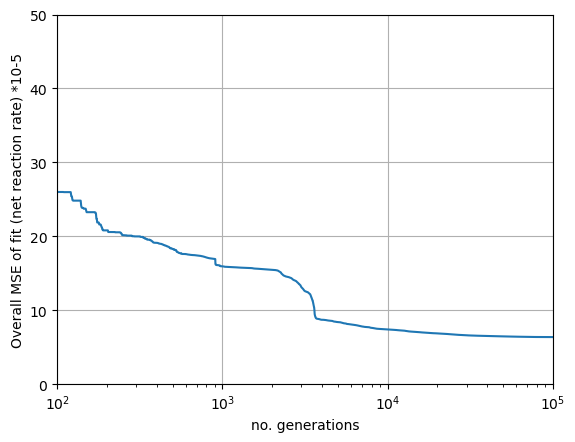

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-9.472473229875847
1.1828771233927464
0.40628608507988984
-3.984529770532981
0.4569993617919305
6.109757200221047e-07
0.4312434659315479
-3.0043672884743744
0.11727713011072975
3.097577340655503
2.2537359556744074
2.413682296377465
0.35459768885890414
0.03445768971050666
2.763853248280726
1.039673445655102e-06
0.3956609976453791
-11.06862536668685
1.7277337361624956
1.447975847919451
-10.456479800776371
1.078663370563056
3.7202109092900604
0.10700703320948812
3.554421091302403
2.721908965832921
0.8922640454443896
5.695638615364695
-8.621632832726762
2.393240305030491
1.5568055027274805
3.152765206117953
-4.613564195140169
0.6093943132479991
1.0660149712047218
-1.301029974241107


In [37]:
res.X

array([-9.47247323e+00,  1.18287712e+00,  4.06286085e-01, -3.98452977e+00,
        4.56999362e-01,  6.10975720e-07,  4.31243466e-01, -3.00436729e+00,
        1.17277130e-01,  3.09757734e+00,  2.25373596e+00,  2.41368230e+00,
        3.54597689e-01,  3.44576897e-02,  2.76385325e+00,  1.03967345e-06,
        3.95660998e-01, -1.10686254e+01,  1.72773374e+00,  1.44797585e+00,
       -1.04564798e+01,  1.07866337e+00,  3.72021091e+00,  1.07007033e-01,
        3.55442109e+00,  2.72190897e+00,  8.92264045e-01,  5.69563862e+00,
       -8.62163283e+00,  2.39324031e+00,  1.55680550e+00,  3.15276521e+00,
       -4.61356420e+00,  6.09394313e-01,  1.06601497e+00, -1.30102997e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -9.472473229875847
1.6: 1.1828771233927464
0.9: 0.40628608507988984
-4.3: -3.984529770532981
0.5: 0.4569993617919305
0.003: 6.109757200221047e-07
0.4: 0.4312434659315479
-7.9: -3.0043672884743744
0.7: 0.11727713011072975
7.2: 3.097577340655503
5.7: 2.2537359556744074
5.7: 2.413682296377465
0.8: 0.35459768885890414
0.03: 0.03445768971050666
3.1: 2.763853248280726
6.000000000000001e-09: 1.039673445655102e-06
0.1: 0.3956609976453791
-12.0: -11.06862536668685
1.9: 1.7277337361624956
1.6: 1.447975847919451
-11.6: -10.456479800776371
1.2: 1.078663370563056
4.0: 3.7202109092900604
0.01: 0.10700703320948812
4.2: 3.554421091302403
5.4: 2.721908965832921
2.2: 0.8922640454443896
11.8: 5.695638615364695
-12.0: -8.621632832726762
3.3: 2.393240305030491
1.8: 1.5568055027274805
4.2: 3.152765206117953
-4.0: -4.613564195140169
0.5: 0.6093943132479991
1.0: 1.0660149712047218
coeff fit: 0.8715064749632921
r: 0.9335451113702499


In [ ]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = np.ndarray.tolist(res.X)
krseed10 = 
krseed101 = 

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)',fontsize=18)
#plt.ylabel('Fitted parameter values (log10)',fontsize=18)

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()
